# Recommendation Systems

Companies like Amazon(books, items), Netflix(movies), Google(News,Search), and Pandora/Spotify(music) leverage recommendation systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue. 

The need to build robust recommendation systems is extremely important given the huge demand for personalized content of modern consumers.


In this assignment, you will be applying your learning of recommendation systems in this Unit towards building the following four different types of recommendation systems:

1.   Global Recommendation Systems (Statistical)   
2.   Content-based Recommendation Systems
3.   Collaborative Filtering (User-Item) Recommendation Systems
4.   Hybrid Recommendation Systems

The focus of the mini-project here would be to build a movie recommendation system.


## 1. Dataset Acquisition

Following are the key descriptions of the datasets you will be using. The data used here has been compiled from various movie datasets like Netflix and IMDb.

1. __Filename: `movie_titles.csv`:__

  - __`MovieID`__: MovieID does not correspond to actual Netflix movie ids or IMDB movie ids
  - __`YearOfRelease`__: YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release
  - __`Title`__: Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English


2. __Combined User-Ratings Dataset Description - `combined_data.csv`:__

  - The first line of the contains the movie id followed by a colon.    
  - Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. 
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.


3. __Filename: `movies_metadata.csv`__

The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.


## 2: Import Necessary Dependencies

We will be leveraging __`keras`__ on top of __`tensorflow`__ for building some of the collaborative filtering and hybrid models. There are compatibility issues with handling sparse layers with dense layers till now in TensorFlow 2 hence we are leveraging native Keras but in the long run once this issue is resolved we can leverage __`tf.keras`__ with minimal code updates.

In [ ]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack

Using TensorFlow backend.


In [ ]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 1.15.0
Keras Version: 2.2.5


Let's start loading data that will be used for building the recommendation systems

# 3. Load Datasets

## 3.1: Load Movie Metadata Datasets

First, we will load the movie_titles.csv data from the Netflix prize data source

In [ ]:
# Load data for all movies
movie_titles = pd.read_csv('./data/movie_titles.csv.zip', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17770, 2)


Year                      Name
Id                                     
8662   1995.0            Titanica: IMAX
14493  2005.0  Best of MADtv: Seasons 8
11692  2004.0          MTV: Pilates Mix
8776   1999.0                  The Pact
9686   2004.0       Saints and Soldiers

There are approximately 18000 movies in the ratings dataset and the metadata information includes the year of release and movie title

Next, we will load the movie_metadata.csv from The movies dataset source. This is to get the metadata information like description etc. related to each movie.

In [ ]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv('./data/movies_metadata.csv.zip', 
                              low_memory=False)[['original_title', 'overview', 'vote_count']]
                    .set_index('original_title')
                    .dropna())

# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


overview
original_title                                                   
The Afflicted   A story of incomprehensible abuse delivered by...
Kiss the Bride  In high school, Matt and Ryan were best friend...
Odd Thomas      In a California desert town, a short-order coo...
Rock of Ages    A small town girl and a city boy meet on the S...
Germinal        It's mid 19th century, north of France. The st...

Around 21,000 entries in the movies metadata dataset

## 3.2: Load User-Movie-Rating Dataset

In [ ]:
# Dowload large file from the shared GDrive folder
!pip install gdown
!gdown "https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2" -O data/


Downloading...
From: https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2
To: /notebooks/mec-17.4.1-recommendation-systems-mini-project/data/combined_data.csv.zip
0.00B [00:00, ?B/s]

1.57MB [00:00, 11.1MB/s]

3.15MB [00:00, 11.3MB/s]

4.72MB [00:00, 11.4MB/s]

6.29MB [00:00, 11.6MB/s]

7.86MB [00:00, 11.7MB/s]

9.44MB [00:00, 11.8MB/s]

11.0MB [00:00, 11.8MB/s]

12.6MB [00:01, 11.8MB/s]

14.2MB [00:01, 11.8MB/s]

15.7MB [00:01, 11.8MB/s]

17.3MB [00:01, 11.8MB/s]

18.9MB [00:01, 11.9MB/s]

20.4MB [00:01, 11.9MB/s]

22.0MB [00:01, 11.9MB/s]

23.6MB [00:01, 11.9MB/s]

25.2MB [00:02, 11.9MB/s]

26.7MB [00:02, 11.9MB/s]

28.3MB [00:02, 11.9MB/s]

29.9MB [00:02, 11.9MB/s]

31.5MB [00:02, 11.9MB/s]

33.0MB [00:02, 11.9MB/s]

34.6MB [00:02, 11.9MB/s]

36.0MB [00:03, 12.0MB/s]

37.5MB [00:03, 11.9MB/s]

39.1MB [00:03, 11.9MB/s]

40.7MB [00:03, 11.9MB/s]

42.2MB [00:03, 11.9MB/s]

43.8MB [00:03, 11.9MB/s]

45.4MB [00:03, 11.9MB/s]

46.6MB [00:03, 11.9MB/s]

48.2MB [00:04, 11.9MB/s]

49.7MB [00:04, 11.9MB/s]

51.3MB [00:04, 11.9MB/s]

52.9MB [00:04, 11.9MB/s]

54.5MB [00:04, 11.8MB/s]

56.1MB [00:04, 12.0MB/s]

57.7MB [00:04, 11.9MB/s]

59.2MB [00:04, 11.9MB/s]

60.8MB [00:05, 9.87MB/s]

61.9MB [00:05, 10.0MB/s]

63.4MB [00:05, 10.5MB/s]

65.0MB [00:05, 10.9MB/s]

66.6MB [00:05, 11.1MB/s]

68.1MB [00:05, 11.4MB/s]

69.7MB [00:05, 11.6MB/s]

71.3MB [00:06, 11.7MB/s]

72.9MB [00:06, 11.7MB/s]

74.2MB [00:06, 11.8MB/s]

75.8MB [00:06, 11.8MB/s]

77.4MB [00:06, 11.9MB/s]

79.0MB [00:06, 11.8MB/s]

80.5MB [00:06, 11.9MB/s]

81.8MB [00:06, 11.9MB/s]

83.4MB [00:07, 11.9MB/s]

85.0MB [00:07, 11.9MB/s]

86.5MB [00:07, 11.9MB/s]

88.1MB [00:07, 11.9MB/s]

89.8MB [00:07, 11.9MB/s]

91.4MB [00:07, 11.9MB/s]

93.0MB [00:07, 11.9MB/s]

94.5MB [00:08, 11.9MB/s]

96.1MB [00:08, 11.9MB/s]

97.8MB [00:08, 11.9MB/s]

99.3MB [00:08, 11.9MB/s]

101MB [00:08, 11.9MB/s] 

102MB [00:08, 11.9MB/s]

104MB [00:08, 11.9MB/s]

106MB [00:08, 11.9MB/s]

107MB [00:09, 11.9MB/s]

109MB [00:09, 12.0MB/s]

110MB [00:09, 11.9MB/s]

112MB [00:09, 12.0MB/s]

114MB [00:09, 11.9MB/s]

115MB [00:09, 11.9MB/s]

117MB [00:09, 11.9MB/s]

118MB [00:10, 11.9MB/s]

120MB [00:10, 11.9MB/s]

121MB [00:10, 10.2MB/s]

123MB [00:10, 9.78MB/s]

125MB [00:10, 10.4MB/s]

126MB [00:10, 10.8MB/s]

128MB [00:10, 11.1MB/s]

129MB [00:11, 11.3MB/s]

131MB [00:11, 11.4MB/s]

133MB [00:11, 11.7MB/s]

134MB [00:11, 11.7MB/s]

136MB [00:11, 11.8MB/s]

137MB [00:11, 11.8MB/s]

139MB [00:11, 11.8MB/s]

140MB [00:12, 11.9MB/s]

142MB [00:12, 11.9MB/s]

144MB [00:12, 11.9MB/s]

145MB [00:12, 11.9MB/s]

147MB [00:12, 11.8MB/s]

148MB [00:12, 11.9MB/s]

150MB [00:12, 11.9MB/s]

151MB [00:12, 11.9MB/s]

153MB [00:13, 11.9MB/s]

155MB [00:13, 11.9MB/s]

156MB [00:13, 11.9MB/s]

158MB [00:13, 11.9MB/s]

159MB [00:13, 11.9MB/s]

161MB [00:13, 11.7MB/s]


In [ ]:
# Load single data-file
df_raw = pd.read_csv('./data/combined_data.csv.zip', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(10)

Shape User-Ratings:	(24053764, 4)


User  Rating        Date  Movie
15903215  1768495     2.0  2004-03-16   3098
18678013  2447465     3.0  2001-02-15   3581
9112618    741408     4.0  2005-06-15   1799
17041237   164336     3.0  2005-02-23   3285
7566979   2382912     4.0  2005-04-01   1521
23811876   449597     5.0  2003-02-26   4441
9607591    351058     3.0  2004-02-04   1884
4701328   1399249     3.0  2005-09-11    934
15840448  1335092     3.0  2004-04-26   3085
17125596  1784150     3.0  2004-12-06   3302

There are about 24 Million+ different rating records!

We have taken the data required for building the system and now let's do some EDA on the dataset to better understand our data

# 4. Exploratory Data Analysis

## 4.1: When were the movies released?


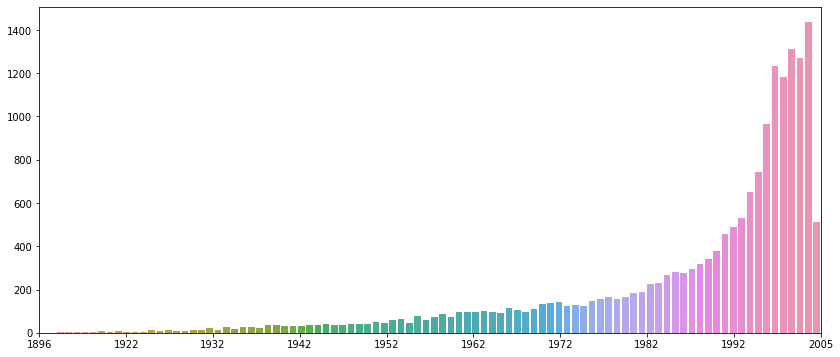

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.
The decline for the rightmost point is probably caused by an incomplete last year.

## Q 4.2: How are The Ratings Distributed?

__Your Turn:__ Build the visualization for rating distributions similar to the previous plot.


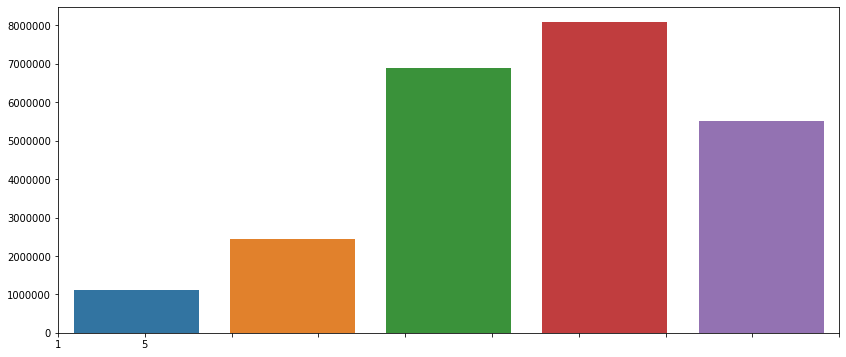

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

rating = df['Rating'].value_counts().sort_index()
x = rating.index.map(int)
y = rating.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

## 4.3: Visualize the Distribution of Number of Movie Ratings 

This is to understand how many movies (y-axis) are receiving specific number of movie ratings (x-axis)

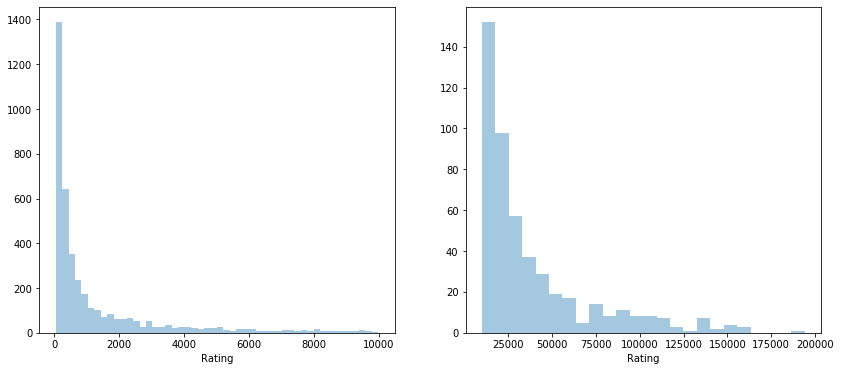

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1]);

## Q 4.4: Visualize the Distribution of Number of User Ratings 

This is to understand how many users (y-axis) are giving specific number of movie ratings (x-axis)

__Your Turn:__ Try to find out an optimal threshold as in the previous example to split the data to form two understandable subplots!

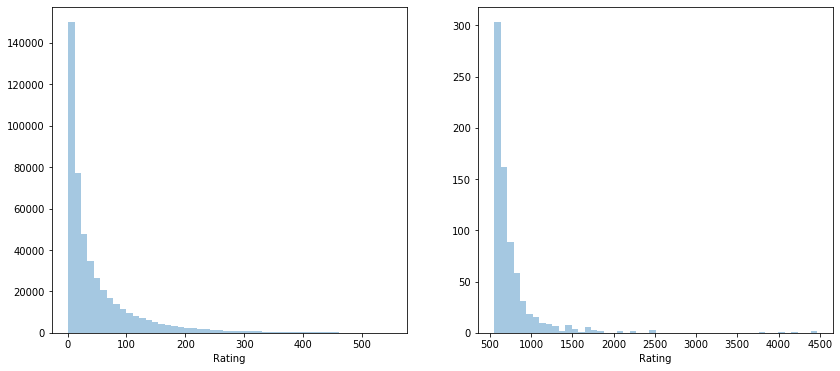

In [ ]:
d = df.groupby('User')['Rating'].count()
d.describe()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.distplot(d[d  < 550], kde=False, ax=ax[0]);
sns.distplot(d[d  > 550], kde=False, ax=ax[1]);

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# 5. Dimensionality Reduction & Filtering

## Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.


In [ ]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(5930581, 4)


After filtering sparse movies and users about 5.9M rating records are present.

# 6. Create Train and Test Datasets

Do note this will be used for the statistical method based models and collaborative filtering.

For content based filtering it is more of a model which recommends movies rather than predicting ratings and for the hybrid model we will need to recreate the train and test datasets later since we need to create a subset of movies-users-ratings which have movie text descriptions.

## Create Train and Test datasets

In [ ]:
# Shuffle DataFrame
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 100000

# Split train- & testset
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
df_train.shape, df_test.shape

((5830581, 3), (100000, 3))

The train set will be used to train all models and the test set ensures we can compare model performance on unseen data using the RMSE metric.

# 7. Transformation

### Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

A large, sparse matrix will be created in this step. Each row will represent a user and its ratings and the columns are the movies.

The movies already rated by users are the non-empty values in the matrix.

Empty values are unrated movies and the main objective is to estimate the empty values to help our users.


__Your turn:__ Create the User-Movie matrix leveraging the __`pivot_table()`__ function from pandas.

Fill in the blanks in the code below by referencing the __`pivot_table()`__ function and invoking it on __`df_train`__. Feel free to check out the documentation.

Remember, rows should be users, columns should be movies and the values in the matrix should be the movie ratings. All these should be available in the __`df_train`__ dataframe.

In [ ]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(index='User', columns='Movie', values='Rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.head(10)

Shape User-Movie-Matrix:	(20828, 1741)


Movie    3     5     6     8     16    17    18    24    25    26    ...  \
User                                                                 ...   
1000079   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000192   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000301   NaN   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  ...   
1000387   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000410   NaN   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  ...   
1000527   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000596   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000634   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN  ...   
1000710   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1000779   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

Movie    4482  4483  4484  4485  4488  4489  4490  4492  4493  4496  
User                                                                 
1000079   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN   NaN  
1000192   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1000301   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN  
1000387   NaN   NaN   NaN   1.0   2.0   NaN   NaN   1.0   NaN   NaN  
1000410   NaN   NaN   NaN   NaN   3.0   NaN   3.0   NaN   NaN   3.0  
1000527   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN  
1000596   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1000634   NaN   NaN   NaN   NaN   4.0   NaN   NaN   4.0   NaN   NaN  
1000710   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1000779   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0  

[10 rows x 1741 columns]

## 8. Building Recommendation Systems

## 8.1(a): Global Recommendation Systems (Mean Rating)

Computing the mean rating for all movies creates a ranking. The recommendation will be the same for all users and can be used if there is no information on the user.
Variations of this approach can be separate rankings for each country/year/gender/... and to use them individually to recommend movies/items to the user.

It has to be noted that this approach is biased and favours movies with fewer ratings, since large numbers of ratings tend to be less extreme in its mean ratings.

### Additional Hint

Predict model performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [ ]:
# Compute mean rating for all movies
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

# Compute rating frequencies for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Freq').to_frame()

# Combine the aggregated dataframes
combined_df = ratings_mean.join(ratings_count).join(movie_titles)
combined_df.head(5)

Rating-Mean  Rating-Freq    Year  \
Movie                                     
3456      4.654935         1307  2004.0   
2102      4.510387         2792  1994.0   
3444      4.437055         2812  2004.0   
2452      4.426322        18608  2001.0   
2172      4.385137         6190  1991.0   

                                                Name  
Movie                                                 
3456                                  Lost: Season 1  
2102                          The Simpsons: Season 6  
3444           Family Guy: Freakin' Sweet Collection  
2452   Lord of the Rings: The Fellowship of the Ring  
2172                          The Simpsons: Season 3

In [ ]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(ratings_mean)
predictions_df.head(5)

User  Rating  Rating-Mean
Movie                              
3       382405     4.0      3.45591
3      2135038     4.0      3.45591
3      1342591     3.0      3.45591
3       718564     3.0      3.45591
3       576990     1.0      3.45591

In [ ]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['Rating-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)

The RMSE Value for the Mean Rating Recommender: 1.004020117273739


In [ ]:
# View top ten rated movies
combined_df[['Name', 'Rating-Mean']].head(10)

Name  Rating-Mean
Movie                                                            
3456                                  Lost: Season 1     4.654935
2102                          The Simpsons: Season 6     4.510387
3444           Family Guy: Freakin' Sweet Collection     4.437055
2452   Lord of the Rings: The Fellowship of the Ring     4.426322
2172                          The Simpsons: Season 3     4.385137
3962                       Finding Nemo (Widescreen)     4.369773
1256                     The Best of Friends: Vol. 4     4.367808
4238                                       Inu-Yasha     4.350000
1476                        Six Feet Under: Season 4     4.349053
3046               The Simpsons: Treehouse of Horror     4.348113

## Q 8.1(b): Global Recommendation Systems (Weighted Rating)

To tackle the problem of the unstable mean with few ratings e.g. IDMb uses a weighted rating. Many good ratings outweigh few in this algorithm.

### Hint:

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

*𝑅* = average for the movie (mean) = (Rating)

*𝑣* = number of votes for the movie = (votes)

*𝑚* = minimum votes required 

*𝐶* = the mean vote across the whole report 

__Your Turn:__ Fill in the necessary code snippets below to build and test the model


In [ ]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean()

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [ ]:
# Weighted formula to compute the weighted rating
weighted_score = (v/(v+m))*R+(m/(v+m))*C

In [ ]:
# convert weighted_score into a dataframe
weighted_mean = pd.DataFrame(weighted_score, columns=['Weighted-Mean'], index=df_p.columns)

# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df = weighted_mean.join(movie_titles)
combined_df.head(5)

Weighted-Mean    Year                        Name
Movie                                                   
3           3.463668  1997.0                   Character
5           3.453535  2004.0    The Rise and Fall of ECW
6           3.375822  1997.0                        Sick
8           3.167376  2004.0  What the #$*! Do We Know!?
16          3.197782  1996.0                   Screamers

In [ ]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(weighted_mean)
predictions_df.head(5)

User  Rating  Weighted-Mean
Movie                                
3       382405     4.0       3.463668
3      2135038     4.0       3.463668
3      1342591     3.0       3.463668
3       718564     3.0       3.463668
3       576990     1.0       3.463668

In [ ]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['Weighted-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse)

The RMSE Value for the Weighted-Mean Rating Recommender: 1.0092424695917641


In [ ]:
# View top ten rated movies
sorted_combined_df = combined_df.sort_values('Weighted-Mean', ascending=False)
sorted_combined_df[['Name', 'Weighted-Mean']].head(10)

Name  Weighted-Mean
Movie                                                              
2452   Lord of the Rings: The Fellowship of the Ring       4.377438
3962                       Finding Nemo (Widescreen)       4.320968
4306                                 The Sixth Sense       4.290629
2862                        The Silence of the Lambs       4.280998
3290                                   The Godfather       4.263693
2172                          The Simpsons: Season 3       4.257553
2102                          The Simpsons: Season 6       4.235444
2782                                      Braveheart       4.218048
3046               The Simpsons: Treehouse of Horror       4.201565
3444           Family Guy: Freakin' Sweet Collection       4.182792

The variable "m" can be seen as regularizing parameter. Changing it determines how much weight is put onto the movies with many ratings.
Even if there is a better ranking the RMSE decreased slightly. There is a trade-off between interpretability and predictive power.

## 8.2: Content Based Recommendation Systems


The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. If there is no historical data for a user or there is reliable metadata for each movie, it can be useful to compare the metadata of the movies to find similar ones.

![](./images/Content-based.png)

### Cosine TFIDF Movie Description Similarity

#### TF-IDF 

This is a text vectorization technique which is used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. 

IDF is the inverse of the document frequency among the whole corpus of documents. 

TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. 

In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

![](./images/TF-IDF-FORMULA.png)


#### Cosine Similarity 
After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors.

Consider the following example

![](./images/vector-space-model.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. 

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. 

The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. 

The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

In this approch we will use the movie description to create a TFIDF-matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text-vectors. This can easily be extended to more or different features if you like.
It is impossible for this model to compute a RMSE score, since the model does not recommend the movies directly.
In this way it is possible to find movies closly related to each other.

This approach of content based filtering can be extendend to increase the model performance by adding some more features like genres, cast, crew etc.

In [ ]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [ ]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity, 
                             index=movie_metadata.index.values, 
                             columns=movie_metadata.index.values)
similarity_df.head(10)

Toy Story   Jumanji  Grumpier Old Men  \
Toy Story                     1.000000  0.015385          0.000000   
Jumanji                       0.015385  1.000000          0.046854   
Grumpier Old Men              0.000000  0.046854          1.000000   
Waiting to Exhale             0.000000  0.000000          0.000000   
Father of the Bride Part II   0.000000  0.000000          0.023903   
Heat                          0.000000  0.047646          0.000000   
Sabrina                       0.000000  0.000000          0.000000   
Tom and Huck                  0.000000  0.000000          0.006463   
Sudden Death                  0.000000  0.098488          0.000000   
GoldenEye                     0.000000  0.000000          0.000000   

                             Waiting to Exhale  Father of the Bride Part II  \
Toy Story                             0.000000                     0.000000   
Jumanji                               0.000000                     0.000000   
Grumpier Old Men                      0.000000                     0.023903   
Waiting to Exhale                     1.000000                     0.000000   
Father of the Bride Part II           0.000000                     1.000000   
Heat                                  0.007417                     0.000000   
Sabrina                               0.000000                     0.030866   
Tom and Huck                          0.008592                     0.000000   
Sudden Death                          0.000000                     0.033213   
GoldenEye                             0.000000                     0.000000   

                                 Heat   Sabrina  Tom and Huck  Sudden Death  \
Toy Story                    0.000000  0.000000      0.000000      0.000000   
Jumanji                      0.047646  0.000000      0.000000      0.098488   
Grumpier Old Men             0.000000  0.000000      0.006463      0.000000   
Waiting to Exhale            0.007417  0.000000      0.008592      0.000000   
Father of the Bride Part II  0.000000  0.030866      0.000000      0.033213   
Heat                         1.000000  0.000000      0.000000      0.046349   
Sabrina                      0.000000  1.000000      0.000000      0.000000   
Tom and Huck                 0.000000  0.000000      1.000000      0.000000   
Sudden Death                 0.046349  0.000000      0.000000      1.000000   
GoldenEye                    0.000000  0.000000      0.000000      0.000000   

                             GoldenEye  ...  The Final Storm  In a Heartbeat  \
Toy Story                          0.0  ...         0.000000        0.023356   
Jumanji                            0.0  ...         0.000000        0.000000   
Grumpier Old Men                   0.0  ...         0.000000        0.000000   
Waiting to Exhale                  0.0  ...         0.028460        0.000000   
Father of the Bride Part II        0.0  ...         0.000000        0.000000   
Heat                               0.0  ...         0.000000        0.000000   
Sabrina                            0.0  ...         0.000000        0.000000   
Tom and Huck                       0.0  ...         0.164136        0.071019   
Sudden Death                       0.0  ...         0.000000        0.000000   
GoldenEye                          1.0  ...         0.043867        0.000000   

                             Bloed, Zweet en Tranen  To Be Fat Like Me  \
Toy Story                                       0.0           0.000000   
Jumanji                                         0.0           0.004192   
Grumpier Old Men                                0.0           0.000000   
Waiting to Exhale                               0.0           0.000000   
Father of the Bride Part II                     0.0           0.022816   
Heat                                            0.0           0.000000   
Sabrina                                         0.0           0.028344   
Tom and Huck                                 

In [ ]:
# movie list 
movie_list = similarity_df.columns.values


# sample movie
movie = 'Batman Begins'

# top recommendation movie count
top_n = 10

# get movie similarity records
movie_sim = similarity_df[similarity_df.index == movie].values[0]

# get movies sorted by similarity
sorted_movie_ids = np.argsort(movie_sim)[::-1]

# get recommended movie names
recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]

print('\n\nTop Recommended Movies for:', movie, 'are:-\n', recommended_movies)



Top Recommended Movies for: Batman Begins are:-
 ['Batman Unmasked: The Psychology of the Dark Knight'
 'Batman: The Dark Knight Returns, Part 1' 'Batman: Bad Blood'
 'Batman: Year One' 'Batman: Under the Red Hood'
 'Batman Beyond: The Movie' 'Batman Forever'
 'Batman: Mask of the Phantasm' 'Batman & Bill' 'Batman']


__Your turn:__ Create a function as defined below, __`content_movie_recommender()`__ which can take in sample movie names and print a list of top N recommended movies

In [ ]:
def content_movie_recommender(input_movie, similarity_database=similarity_df, movie_database_list=movie_list, top_n=10):
    
    movie_sim = similarity_df[similarity_df.index == input_movie].values[0]
    sorted_movie_ids = np.argsort(movie_sim)[::-1]
    recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]
    print('\n\nTop Recommended Movies for:', input_movie, 'are:-\n', recommended_movies)

__Your turn:__ Test your function below on the given sample movies

In [ ]:
sample_movies = ['Captain America', 'The Terminator', 'The Exorcist', 
                 'The Hunger Games: Mockingjay - Part 1', 'The Blair Witch Project']
                 
for m in sample_movies:
    content_movie_recommender(m)



Top Recommended Movies for: Captain America are:-
 ['Iron Man & Captain America: Heroes United'
 'Captain America: The First Avenger' 'Team Thor' 'Education for Death'
 'Captain America: The Winter Soldier' '49th Parallel' 'Ultimate Avengers'
 'Philadelphia Experiment II' 'Vice Versa' 'The Lair of the White Worm']


Top Recommended Movies for: The Terminator are:-
 ['Terminator 2: Judgment Day' 'Terminator Salvation'
 'Terminator 3: Rise of the Machines' 'Silent House' 'They Wait'
 'Another World' 'Teenage Caveman' 'Appleseed Alpha' 'Respire'
 'Just Married']


Top Recommended Movies for: The Exorcist are:-
 ['Exorcist II: The Heretic' 'Domestic Disturbance' 'Damien: Omen II'
 'The Exorcist III' 'Like Sunday, Like Rain' 'People Like Us'
 'Quand on a 17 Ans' "Don't Knock Twice" 'Zero Day' 'Brick Mansions']


Top Recommended Movies for: The Hunger Games: Mockingjay - Part 1 are:-
 ['The Hunger Games: Catching Fire' 'The Hunger Games: Mockingjay - Part 2'
 'Last Train from Gun Hill' 'Th

## 8.3: Collaborative filtering Recommendation Systems

### Collaborative Filtering
Primarily recommends content to you based on inputs or actions from other people(say your friends).
![collaborative filtering](./images/collaborative-filtering.png)



### What is the intuition behind this?

*   **Personal tastes are correlated**


        1.   If Alice and Bob both like X and Alice likes Y then Bob is more likely to like Y
        2.   especially (perhaps) if Bob knows Alice

Types of Collaborative Filtering:


1.   Neighborhood methods
2.   Matrix Factorization (Latent Factor) methods



Assume you dont have users. Rather you have users' characterisics and properties(as shown in image).![Latent Factor method](https://miro.medium.com/max/876/1*AQEx38Wdo5H0WTSjRfAWtA.png)

For example, a person who is brave-hearted is more likely to be interested in dark, horrific movies rather than someone who is soft and compassionate.
* ^This is just an example(not in any literal sense)

So, once you have the properties and characteristics of each user, we call them as lower-dimensional features of the users. Similarly, we can have lower-dimensional features for movies(say its 10% action, 20% romance ...)

With these features, we represent users and movies in a low dimensional space describing their properties. **This is called as the latent space.**

We then recommend a movie based on its proximity to the user in the latent space.

### The problem:

The problem we try to address here is the rating prediction problem. 
Say, we try to guess how much Alice would rate a movie and suggest those movies that we think Alice will rate higher.

### Interesting...But, how do we predict how much Alice would rate a movie?

 The data we have is a rating history: ratings of users for items in the interval [1,5]. We can put all this data into a sparse matrix called R:
 
 $R = 
 \begin{pmatrix}
  3 & ? &? \\ 
  ? & 4 & 5 \\
  ? & ? & 2 \\
  2 & 3 & ?
 \end{pmatrix}
 \begin{matrix}
  Alice \\ 
  Bob \\
  Chand \\
  Deb
 \end{matrix}
 $

 Each row of the matrix corresponds to a given user, and each column corresponds to a given item. For instance here, Alice has rated the first movie with a rating of 3, and Chand has rated the third item with a rating of 2.

 The matrix R is sparse (more than 99% of the entries are missing), and our goal is to predict the missing entries, i.e. predict the ?.


### Anatomy of the Rating matrix: LATENT SPACE
Before predicting ratings, lets step back and understand the latent space more! \\
 In this Rating matrix, Rows represent Users and Columns represent Movies.
 $R = 
  \begin{pmatrix}
  --Alice-- \\ 
  --Bob-- \\
  --Chand-- \\
  --Deb--
 \end{pmatrix}
 $

 In latent space(low dimensional features - fanatics), for instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

```
Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ⋯ \\
Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ⋯ \\
: \\
Zoe = ⋯
```

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings.

$
R ^ T = 
  \begin{pmatrix}
  --Avengers-- \\ 
  --Matrix-- \\
  --Inception-- \\
  --Sherlock--
 \end{pmatrix}
$

In the latent space, we will associate a semantic meaning behind each of the  movies, and these semantic meanings(say movie characteristics) can build back all of our original movies.

### EXAMPLE
In the below example, we convert users and movies to vectors(embeddings) and do dot-product to predict R

user vector - U \\
movies vector - V \\
$
R = U.V
$

### Additional hints:

use dataframe map - [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)

Create tensor - [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input#view-aliases)

Create Embedding - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Dot product - [Dot](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Measure Performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

### Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL collaborative  filtering system

#### Create Configuration Parameters

In [ ]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping = {id:i for i, id in enumerate(df_filtered['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered['Movie'].unique())}

In [ ]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
train_user_data = df_train['User'].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

In [ ]:
# do the same for test data
test_user_data = df_test['User'].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)

In [ ]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

#### Construct Deep Learning Model Architecture

In [ ]:
# use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name='user')
movie_id_input = Input(shape=(1,), name='movie')

In [ ]:
# Create embedding layer for users 
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)

# create embedding layer for movies just like users
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='movie_embedding')(movie_id_input)

In [ ]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [ ]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [ ]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       2082800     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       2082800     movie[0][0]                      
____________________________________________________________________________________________

#### Train and Test the Model

In [ ]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train['Rating']

batch_size = 1024
epochs = 5
validation_split = 0.1

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs,
          validation_split=validation_split,
          shuffle=True,
          verbose=1)

Train on 5247522 samples, validate on 583059 samples
Epoch 1/5


   1024/5247522 [..............................] - ETA: 2:37:40 - loss: 13.4817

   8192/5247522 [..............................] - ETA: 20:17 - loss: 13.2112  

  15360/5247522 [..............................] - ETA: 11:07 - loss: 13.2337

  22528/5247522 [..............................] - ETA: 7:46 - loss: 13.2210 

  29696/5247522 [..............................] - ETA: 6:02 - loss: 13.2163

  36864/5247522 [..............................] - ETA: 4:59 - loss: 13.2120

  44032/5247522 [..............................] - ETA: 4:17 - loss: 13.2258

  51200/5247522 [..............................] - ETA: 3:46 - loss: 13.2336

  57344/5247522 [..............................] - ETA: 3:26 - loss: 13.2126

  64512/5247522 [..............................] - ETA: 3:07 - loss: 13.2022

  71680/5247522 [..............................] - ETA: 2:52 - loss: 13.2045

  78848/5247522 [..............................] - ETA: 2:40 - loss: 13.1993

  86016/5247522 [..............................] - ETA: 2:30 - loss: 13.1928

  93184/5247522 [..............................] - ETA: 2:21 - loss: 13.2002

 100352/5247522 [..............................] - ETA: 2:13 - loss: 13.1907

 107520/5247522 [..............................] - ETA: 2:07 - loss: 13.1884

 114688/5247522 [..............................] - ETA: 2:01 - loss: 13.1883

 121856/5247522 [..............................] - ETA: 1:56 - loss: 13.1895

 129024/5247522 [..............................] - ETA: 1:52 - loss: 13.1925

 136192/5247522 [..............................] - ETA: 1:48 - loss: 13.1926

 143360/5247522 [..............................] - ETA: 1:44 - loss: 13.1936

 150528/5247522 [..............................] - ETA: 1:41 - loss: 13.1964

 157696/5247522 [..............................] - ETA: 1:38 - loss: 13.1976

 164864/5247522 [..............................] - ETA: 1:35 - loss: 13.1961

 172032/5247522 [..............................] - ETA: 1:33 - loss: 13.1936

 179200/5247522 [>.............................] - ETA: 1:30 - loss: 13.1922

 186368/5247522 [>.............................] - ETA: 1:28 - loss: 13.1896

 193536/5247522 [>.............................] - ETA: 1:26 - loss: 13.1846

 200704/5247522 [>.............................] - ETA: 1:25 - loss: 13.1854

 207872/5247522 [>.............................] - ETA: 1:23 - loss: 13.1894

 215040/5247522 [>.............................] - ETA: 1:21 - loss: 13.1894

 222208/5247522 [>.............................] - ETA: 1:20 - loss: 13.1894

 229376/5247522 [>.............................] - ETA: 1:18 - loss: 13.1877

 235520/5247522 [>.............................] - ETA: 1:17 - loss: 13.1907

 242688/5247522 [>.............................] - ETA: 1:16 - loss: 13.1916

 249856/5247522 [>.............................] - ETA: 1:15 - loss: 13.1906

 257024/5247522 [>.............................] - ETA: 1:14 - loss: 13.1933

 264192/5247522 [>.............................] - ETA: 1:13 - loss: 13.1947

 271360/5247522 [>.............................] - ETA: 1:12 - loss: 13.1936

 278528/5247522 [>.............................] - ETA: 1:11 - loss: 13.1906

 285696/5247522 [>.............................] - ETA: 1:10 - loss: 13.1875

 292864/5247522 [>.............................] - ETA: 1:09 - loss: 13.1837

 300032/5247522 [>.............................] - ETA: 1:08 - loss: 13.1814

 307200/5247522 [>.............................] - ETA: 1:07 - loss: 13.1775

 314368/5247522 [>.............................] - ETA: 1:06 - loss: 13.1724

 321536/5247522 [>.............................] - ETA: 1:06 - loss: 13.1668

 327680/5247522 [>.............................] - ETA: 1:05 - loss: 13.1608

 334848/5247522 [>.............................] - ETA: 1:04 - loss: 13.1553

 342016/5247522 [>.............................] - ETA: 1:04 - loss: 13.1477

 349184/5247522 [>.............................] - ETA: 1:03 - loss: 13.1398

 356352/5247522 [=>............................] - ETA: 1:02 - loss: 13.1317

 363520/5247522 [=>............................] - ETA: 1:02 - loss: 13.1206

 369664/5247522 [=>............................] - ETA: 1:01 - loss: 13.1105

 376832/5247522 [=>............................] - ETA: 1:01 - loss: 13.0939

 384000/5247522 [=>............................] - ETA: 1:00 - loss: 13.0784

 391168/5247522 [=>............................] - ETA: 1:00 - loss: 13.0606

 398336/5247522 [=>............................] - ETA: 59s - loss: 13.0412 

 405504/5247522 [=>............................] - ETA: 59s - loss: 13.0190

 412672/5247522 [=>............................] - ETA: 58s - loss: 12.9944

 419840/5247522 [=>............................] - ETA: 58s - loss: 12.9672

 427008/5247522 [=>............................] - ETA: 57s - loss: 12.9388

 434176/5247522 [=>............................] - ETA: 57s - loss: 12.9070

 441344/5247522 [=>............................] - ETA: 57s - loss: 12.8725

 448512/5247522 [=>............................] - ETA: 56s - loss: 12.8345

 455680/5247522 [=>............................] - ETA: 56s - loss: 12.7918

 462848/5247522 [=>............................] - ETA: 55s - loss: 12.7482

 470016/5247522 [=>............................] - ETA: 55s - loss: 12.7013

 477184/5247522 [=>............................] - ETA: 55s - loss: 12.6490

 484352/5247522 [=>............................] - ETA: 54s - loss: 12.5960

 491520/5247522 [=>............................] - ETA: 54s - loss: 12.5392

 498688/5247522 [=>............................] - ETA: 54s - loss: 12.4799

 505856/5247522 [=>............................] - ETA: 53s - loss: 12.4166

 513024/5247522 [=>............................] - ETA: 53s - loss: 12.3498

 520192/5247522 [=>............................] - ETA: 53s - loss: 12.2797

 527360/5247522 [==>...........................] - ETA: 52s - loss: 12.2077

 534528/5247522 [==>...........................] - ETA: 52s - loss: 12.1335

 541696/5247522 [==>...........................] - ETA: 52s - loss: 12.0555

 548864/5247522 [==>...........................] - ETA: 51s - loss: 11.9771

 556032/5247522 [==>...........................] - ETA: 51s - loss: 11.8962

 563200/5247522 [==>...........................] - ETA: 51s - loss: 11.8136

 570368/5247522 [==>...........................] - ETA: 50s - loss: 11.7281

 577536/5247522 [==>...........................] - ETA: 50s - loss: 11.6416

 584704/5247522 [==>...........................] - ETA: 50s - loss: 11.5548

 591872/5247522 [==>...........................] - ETA: 50s - loss: 11.4660

 599040/5247522 [==>...........................] - ETA: 49s - loss: 11.3777

 606208/5247522 [==>...........................] - ETA: 49s - loss: 11.2879

 613376/5247522 [==>...........................] - ETA: 49s - loss: 11.1980

 620544/5247522 [==>...........................] - ETA: 49s - loss: 11.1071

 627712/5247522 [==>...........................] - ETA: 48s - loss: 11.0168

 634880/5247522 [==>...........................] - ETA: 48s - loss: 10.9265

 642048/5247522 [==>...........................] - ETA: 48s - loss: 10.8370

 649216/5247522 [==>...........................] - ETA: 48s - loss: 10.7474

 656384/5247522 [==>...........................] - ETA: 48s - loss: 10.6578

 663552/5247522 [==>...........................] - ETA: 47s - loss: 10.5689

 670720/5247522 [==>...........................] - ETA: 47s - loss: 10.4812

 677888/5247522 [==>...........................] - ETA: 47s - loss: 10.3939

 685056/5247522 [==>...........................] - ETA: 47s - loss: 10.3081

 692224/5247522 [==>...........................] - ETA: 47s - loss: 10.2231

 699392/5247522 [==>...........................] - ETA: 46s - loss: 10.1387

 706560/5247522 [===>..........................] - ETA: 46s - loss: 10.0553

 712704/5247522 [===>..........................] - ETA: 46s - loss: 9.9845 

 719872/5247522 [===>..........................] - ETA: 46s - loss: 9.9032

 727040/5247522 [===>..........................] - ETA: 46s - loss: 9.8228

 734208/5247522 [===>..........................] - ETA: 45s - loss: 9.7440

 741376/5247522 [===>..........................] - ETA: 45s - loss: 9.6659

 748544/5247522 [===>..........................] - ETA: 45s - loss: 9.5887

 755712/5247522 [===>..........................] - ETA: 45s - loss: 9.5129

 762880/5247522 [===>..........................] - ETA: 45s - loss: 9.4381

 770048/5247522 [===>..........................] - ETA: 44s - loss: 9.3639

 777216/5247522 [===>..........................] - ETA: 44s - loss: 9.2915

 784384/5247522 [===>..........................] - ETA: 44s - loss: 9.2198

 791552/5247522 [===>..........................] - ETA: 44s - loss: 9.1490

 798720/5247522 [===>..........................] - ETA: 44s - loss: 9.0796

 805888/5247522 [===>..........................] - ETA: 44s - loss: 9.0112

 813056/5247522 [===>..........................] - ETA: 43s - loss: 8.9437

 820224/5247522 [===>..........................] - ETA: 43s - loss: 8.8774

 827392/5247522 [===>..........................] - ETA: 43s - loss: 8.8119

 834560/5247522 [===>..........................] - ETA: 43s - loss: 8.7473

 841728/5247522 [===>..........................] - ETA: 43s - loss: 8.6840

 848896/5247522 [===>..........................] - ETA: 43s - loss: 8.6211

 856064/5247522 [===>..........................] - ETA: 43s - loss: 8.5591

 863232/5247522 [===>..........................] - ETA: 42s - loss: 8.4984

 870400/5247522 [===>..........................] - ETA: 42s - loss: 8.4383

 877568/5247522 [====>.........................] - ETA: 42s - loss: 8.3791

 884736/5247522 [====>.........................] - ETA: 42s - loss: 8.3204

 891904/5247522 [====>.........................] - ETA: 42s - loss: 8.2630

 899072/5247522 [====>.........................] - ETA: 42s - loss: 8.2063

 906240/5247522 [====>.........................] - ETA: 42s - loss: 8.1504

 913408/5247522 [====>.........................] - ETA: 41s - loss: 8.0954

 920576/5247522 [====>.........................] - ETA: 41s - loss: 8.0411

 927744/5247522 [====>.........................] - ETA: 41s - loss: 7.9877

 934912/5247522 [====>.........................] - ETA: 41s - loss: 7.9347

 942080/5247522 [====>.........................] - ETA: 41s - loss: 7.8824

 949248/5247522 [====>.........................] - ETA: 41s - loss: 7.8309

 956416/5247522 [====>.........................] - ETA: 41s - loss: 7.7801

 963584/5247522 [====>.........................] - ETA: 40s - loss: 7.7301

 970752/5247522 [====>.........................] - ETA: 40s - loss: 7.6808

 977920/5247522 [====>.........................] - ETA: 40s - loss: 7.6323

 985088/5247522 [====>.........................] - ETA: 40s - loss: 7.5843

 992256/5247522 [====>.........................] - ETA: 40s - loss: 7.5370

 999424/5247522 [====>.........................] - ETA: 40s - loss: 7.4905

1006592/5247522 [====>.........................] - ETA: 40s - loss: 7.4444

1013760/5247522 [====>.........................] - ETA: 40s - loss: 7.3990

1020928/5247522 [====>.........................] - ETA: 39s - loss: 7.3542

1028096/5247522 [====>.........................] - ETA: 39s - loss: 7.3102

1034240/5247522 [====>.........................] - ETA: 39s - loss: 7.2725

1040384/5247522 [====>.........................] - ETA: 39s - loss: 7.2355

1046528/5247522 [====>.........................] - ETA: 39s - loss: 7.1989

1053696/5247522 [=====>........................] - ETA: 39s - loss: 7.1567

1060864/5247522 [=====>........................] - ETA: 39s - loss: 7.1153

1068032/5247522 [=====>........................] - ETA: 39s - loss: 7.0740

1075200/5247522 [=====>........................] - ETA: 39s - loss: 7.0336

1082368/5247522 [=====>........................] - ETA: 38s - loss: 6.9934

1089536/5247522 [=====>........................] - ETA: 38s - loss: 6.9537

1096704/5247522 [=====>........................] - ETA: 38s - loss: 6.9147

1103872/5247522 [=====>........................] - ETA: 38s - loss: 6.8762

1111040/5247522 [=====>........................] - ETA: 38s - loss: 6.8380

1118208/5247522 [=====>........................] - ETA: 38s - loss: 6.8004

1125376/5247522 [=====>........................] - ETA: 38s - loss: 6.7634

1132544/5247522 [=====>........................] - ETA: 38s - loss: 6.7268

1139712/5247522 [=====>........................] - ETA: 38s - loss: 6.6905

1146880/5247522 [=====>........................] - ETA: 37s - loss: 6.6547

1154048/5247522 [=====>........................] - ETA: 37s - loss: 6.6191

1161216/5247522 [=====>........................] - ETA: 37s - loss: 6.5842

1168384/5247522 [=====>........................] - ETA: 37s - loss: 6.5497

1175552/5247522 [=====>........................] - ETA: 37s - loss: 6.5155

1182720/5247522 [=====>........................] - ETA: 37s - loss: 6.4815

1189888/5247522 [=====>........................] - ETA: 37s - loss: 6.4480

1197056/5247522 [=====>........................] - ETA: 37s - loss: 6.4149

1204224/5247522 [=====>........................] - ETA: 37s - loss: 6.3823

1211392/5247522 [=====>........................] - ETA: 37s - loss: 6.3501

1218560/5247522 [=====>........................] - ETA: 36s - loss: 6.3182

1225728/5247522 [======>.......................] - ETA: 36s - loss: 6.2866

1232896/5247522 [======>.......................] - ETA: 36s - loss: 6.2553

1240064/5247522 [======>.......................] - ETA: 36s - loss: 6.2244

1246208/5247522 [======>.......................] - ETA: 36s - loss: 6.1983

1253376/5247522 [======>.......................] - ETA: 36s - loss: 6.1680

1259520/5247522 [======>.......................] - ETA: 36s - loss: 6.1425

1266688/5247522 [======>.......................] - ETA: 36s - loss: 6.1130

1273856/5247522 [======>.......................] - ETA: 36s - loss: 6.0838

1281024/5247522 [======>.......................] - ETA: 36s - loss: 6.0548

1288192/5247522 [======>.......................] - ETA: 36s - loss: 6.0262

1294336/5247522 [======>.......................] - ETA: 35s - loss: 6.0020

1300480/5247522 [======>.......................] - ETA: 35s - loss: 5.9779

1307648/5247522 [======>.......................] - ETA: 35s - loss: 5.9501

1314816/5247522 [======>.......................] - ETA: 35s - loss: 5.9227

1321984/5247522 [======>.......................] - ETA: 35s - loss: 5.8956

1329152/5247522 [======>.......................] - ETA: 35s - loss: 5.8687

1336320/5247522 [======>.......................] - ETA: 35s - loss: 5.8421

1343488/5247522 [======>.......................] - ETA: 35s - loss: 5.8156

1350656/5247522 [======>.......................] - ETA: 35s - loss: 5.7896

1357824/5247522 [======>.......................] - ETA: 35s - loss: 5.7637

1364992/5247522 [======>.......................] - ETA: 34s - loss: 5.7382

1372160/5247522 [======>.......................] - ETA: 34s - loss: 5.7128

1379328/5247522 [======>.......................] - ETA: 34s - loss: 5.6877

1385472/5247522 [======>.......................] - ETA: 34s - loss: 5.6665

1392640/5247522 [======>.......................] - ETA: 34s - loss: 5.6419

1399808/5247522 [=======>......................] - ETA: 34s - loss: 5.6176

1406976/5247522 [=======>......................] - ETA: 34s - loss: 5.5935

1414144/5247522 [=======>......................] - ETA: 34s - loss: 5.5697

1421312/5247522 [=======>......................] - ETA: 34s - loss: 5.5459

1428480/5247522 [=======>......................] - ETA: 34s - loss: 5.5226

1435648/5247522 [=======>......................] - ETA: 34s - loss: 5.4995

1442816/5247522 [=======>......................] - ETA: 34s - loss: 5.4767

1449984/5247522 [=======>......................] - ETA: 33s - loss: 5.4540

1457152/5247522 [=======>......................] - ETA: 33s - loss: 5.4316

1463296/5247522 [=======>......................] - ETA: 33s - loss: 5.4125

1470464/5247522 [=======>......................] - ETA: 33s - loss: 5.3904

1477632/5247522 [=======>......................] - ETA: 33s - loss: 5.3687

1484800/5247522 [=======>......................] - ETA: 33s - loss: 5.3472

1491968/5247522 [=======>......................] - ETA: 33s - loss: 5.3258

1499136/5247522 [=======>......................] - ETA: 33s - loss: 5.3045

1505280/5247522 [=======>......................] - ETA: 33s - loss: 5.2865

1512448/5247522 [=======>......................] - ETA: 33s - loss: 5.2656

1519616/5247522 [=======>......................] - ETA: 33s - loss: 5.2450

1526784/5247522 [=======>......................] - ETA: 32s - loss: 5.2246

1533952/5247522 [=======>......................] - ETA: 32s - loss: 5.2042

1541120/5247522 [=======>......................] - ETA: 32s - loss: 5.1842

1548288/5247522 [=======>......................] - ETA: 32s - loss: 5.1643

1555456/5247522 [=======>......................] - ETA: 32s - loss: 5.1447

1562624/5247522 [=======>......................] - ETA: 32s - loss: 5.1250

1569792/5247522 [=======>......................] - ETA: 32s - loss: 5.1057

1576960/5247522 [========>.....................] - ETA: 32s - loss: 5.0866

1584128/5247522 [========>.....................] - ETA: 32s - loss: 5.0674

1591296/5247522 [========>.....................] - ETA: 32s - loss: 5.0486

1598464/5247522 [========>.....................] - ETA: 32s - loss: 5.0298

1605632/5247522 [========>.....................] - ETA: 32s - loss: 5.0112

1612800/5247522 [========>.....................] - ETA: 31s - loss: 4.9928

1619968/5247522 [========>.....................] - ETA: 31s - loss: 4.9746

1627136/5247522 [========>.....................] - ETA: 31s - loss: 4.9565

1634304/5247522 [========>.....................] - ETA: 31s - loss: 4.9385

1641472/5247522 [========>.....................] - ETA: 31s - loss: 4.9208

1648640/5247522 [========>.....................] - ETA: 31s - loss: 4.9032

1655808/5247522 [========>.....................] - ETA: 31s - loss: 4.8858

1662976/5247522 [========>.....................] - ETA: 31s - loss: 4.8684

1670144/5247522 [========>.....................] - ETA: 31s - loss: 4.8511

1677312/5247522 [========>.....................] - ETA: 31s - loss: 4.8341

1684480/5247522 [========>.....................] - ETA: 31s - loss: 4.8172

1691648/5247522 [========>.....................] - ETA: 31s - loss: 4.8004

1698816/5247522 [========>.....................] - ETA: 31s - loss: 4.7839

1705984/5247522 [========>.....................] - ETA: 30s - loss: 4.7675

1712128/5247522 [========>.....................] - ETA: 30s - loss: 4.7536

1719296/5247522 [========>.....................] - ETA: 30s - loss: 4.7374

1726464/5247522 [========>.....................] - ETA: 30s - loss: 4.7213

1733632/5247522 [========>.....................] - ETA: 30s - loss: 4.7055

1740800/5247522 [========>.....................] - ETA: 30s - loss: 4.6898

1747968/5247522 [========>.....................] - ETA: 30s - loss: 4.6741

1755136/5247522 [=========>....................] - ETA: 30s - loss: 4.6586

1762304/5247522 [=========>....................] - ETA: 30s - loss: 4.6430

1769472/5247522 [=========>....................] - ETA: 30s - loss: 4.6277

1776640/5247522 [=========>....................] - ETA: 30s - loss: 4.6124

1783808/5247522 [=========>....................] - ETA: 30s - loss: 4.5974

1790976/5247522 [=========>....................] - ETA: 30s - loss: 4.5824

1797120/5247522 [=========>....................] - ETA: 29s - loss: 4.5698

1804288/5247522 [=========>....................] - ETA: 29s - loss: 4.5551

1811456/5247522 [=========>....................] - ETA: 29s - loss: 4.5404

1818624/5247522 [=========>....................] - ETA: 29s - loss: 4.5259

1825792/5247522 [=========>....................] - ETA: 29s - loss: 4.5115

1832960/5247522 [=========>....................] - ETA: 29s - loss: 4.4973

1840128/5247522 [=========>....................] - ETA: 29s - loss: 4.4832

1847296/5247522 [=========>....................] - ETA: 29s - loss: 4.4691

1854464/5247522 [=========>....................] - ETA: 29s - loss: 4.4551

1861632/5247522 [=========>....................] - ETA: 29s - loss: 4.4412

1868800/5247522 [=========>....................] - ETA: 29s - loss: 4.4275

1875968/5247522 [=========>....................] - ETA: 29s - loss: 4.4140

1883136/5247522 [=========>....................] - ETA: 29s - loss: 4.4005

1890304/5247522 [=========>....................] - ETA: 29s - loss: 4.3871

1897472/5247522 [=========>....................] - ETA: 28s - loss: 4.3738

1904640/5247522 [=========>....................] - ETA: 28s - loss: 4.3607

1911808/5247522 [=========>....................] - ETA: 28s - loss: 4.3476

1918976/5247522 [=========>....................] - ETA: 28s - loss: 4.3345

1926144/5247522 [==========>...................] - ETA: 28s - loss: 4.3216

1933312/5247522 [==========>...................] - ETA: 28s - loss: 4.3089

1940480/5247522 [==========>...................] - ETA: 28s - loss: 4.2963

1947648/5247522 [==========>...................] - ETA: 28s - loss: 4.2836

1954816/5247522 [==========>...................] - ETA: 28s - loss: 4.2710

1961984/5247522 [==========>...................] - ETA: 28s - loss: 4.2587

1968128/5247522 [==========>...................] - ETA: 28s - loss: 4.2482

1975296/5247522 [==========>...................] - ETA: 28s - loss: 4.2358

1981440/5247522 [==========>...................] - ETA: 28s - loss: 4.2254

1988608/5247522 [==========>...................] - ETA: 28s - loss: 4.2133

1995776/5247522 [==========>...................] - ETA: 27s - loss: 4.2013

2002944/5247522 [==========>...................] - ETA: 27s - loss: 4.1892

2010112/5247522 [==========>...................] - ETA: 27s - loss: 4.1773

2017280/5247522 [==========>...................] - ETA: 27s - loss: 4.1655

2024448/5247522 [==========>...................] - ETA: 27s - loss: 4.1537

2031616/5247522 [==========>...................] - ETA: 27s - loss: 4.1421

2038784/5247522 [==========>...................] - ETA: 27s - loss: 4.1305

2045952/5247522 [==========>...................] - ETA: 27s - loss: 4.1192

2053120/5247522 [==========>...................] - ETA: 27s - loss: 4.1078

2060288/5247522 [==========>...................] - ETA: 27s - loss: 4.0964

2067456/5247522 [==========>...................] - ETA: 27s - loss: 4.0851

2074624/5247522 [==========>...................] - ETA: 27s - loss: 4.0739

2081792/5247522 [==========>...................] - ETA: 27s - loss: 4.0628

2088960/5247522 [==========>...................] - ETA: 26s - loss: 4.0518

2096128/5247522 [==========>...................] - ETA: 26s - loss: 4.0410

2103296/5247522 [===========>..................] - ETA: 26s - loss: 4.0302

2110464/5247522 [===========>..................] - ETA: 26s - loss: 4.0194

2117632/5247522 [===========>..................] - ETA: 26s - loss: 4.0087

2124800/5247522 [===========>..................] - ETA: 26s - loss: 3.9981

2131968/5247522 [===========>..................] - ETA: 26s - loss: 3.9874

2139136/5247522 [===========>..................] - ETA: 26s - loss: 3.9769

2146304/5247522 [===========>..................] - ETA: 26s - loss: 3.9667

2153472/5247522 [===========>..................] - ETA: 26s - loss: 3.9563

2160640/5247522 [===========>..................] - ETA: 26s - loss: 3.9460

2167808/5247522 [===========>..................] - ETA: 26s - loss: 3.9357

2174976/5247522 [===========>..................] - ETA: 26s - loss: 3.9256

2182144/5247522 [===========>..................] - ETA: 26s - loss: 3.9156

2189312/5247522 [===========>..................] - ETA: 25s - loss: 3.9055

2196480/5247522 [===========>..................] - ETA: 25s - loss: 3.8955

2203648/5247522 [===========>..................] - ETA: 25s - loss: 3.8856

2210816/5247522 [===========>..................] - ETA: 25s - loss: 3.8758

2217984/5247522 [===========>..................] - ETA: 25s - loss: 3.8661

2225152/5247522 [===========>..................] - ETA: 25s - loss: 3.8564

2232320/5247522 [===========>..................] - ETA: 25s - loss: 3.8468

2239488/5247522 [===========>..................] - ETA: 25s - loss: 3.8372

2245632/5247522 [===========>..................] - ETA: 25s - loss: 3.8291

2252800/5247522 [===========>..................] - ETA: 25s - loss: 3.8196

2259968/5247522 [===========>..................] - ETA: 25s - loss: 3.8102

2267136/5247522 [===========>..................] - ETA: 25s - loss: 3.8008

2274304/5247522 [============>.................] - ETA: 25s - loss: 3.7914

2281472/5247522 [============>.................] - ETA: 25s - loss: 3.7821

2288640/5247522 [============>.................] - ETA: 25s - loss: 3.7729

2295808/5247522 [============>.................] - ETA: 24s - loss: 3.7638

2301952/5247522 [============>.................] - ETA: 24s - loss: 3.7561

2309120/5247522 [============>.................] - ETA: 24s - loss: 3.7470

2316288/5247522 [============>.................] - ETA: 24s - loss: 3.7380

2323456/5247522 [============>.................] - ETA: 24s - loss: 3.7292

2330624/5247522 [============>.................] - ETA: 24s - loss: 3.7204

2337792/5247522 [============>.................] - ETA: 24s - loss: 3.7115

2344960/5247522 [============>.................] - ETA: 24s - loss: 3.7028

2352128/5247522 [============>.................] - ETA: 24s - loss: 3.6942

2359296/5247522 [============>.................] - ETA: 24s - loss: 3.6855

2366464/5247522 [============>.................] - ETA: 24s - loss: 3.6769

2373632/5247522 [============>.................] - ETA: 24s - loss: 3.6684

2380800/5247522 [============>.................] - ETA: 24s - loss: 3.6599

2387968/5247522 [============>.................] - ETA: 24s - loss: 3.6515

2395136/5247522 [============>.................] - ETA: 24s - loss: 3.6430

2402304/5247522 [============>.................] - ETA: 23s - loss: 3.6348

2409472/5247522 [============>.................] - ETA: 23s - loss: 3.6264

2416640/5247522 [============>.................] - ETA: 23s - loss: 3.6182

2423808/5247522 [============>.................] - ETA: 23s - loss: 3.6100

2430976/5247522 [============>.................] - ETA: 23s - loss: 3.6018

2438144/5247522 [============>.................] - ETA: 23s - loss: 3.5938

2445312/5247522 [============>.................] - ETA: 23s - loss: 3.5858

2452480/5247522 [=============>................] - ETA: 23s - loss: 3.5777

2459648/5247522 [=============>................] - ETA: 23s - loss: 3.5698

2466816/5247522 [=============>................] - ETA: 23s - loss: 3.5618

2473984/5247522 [=============>................] - ETA: 23s - loss: 3.5540

2481152/5247522 [=============>................] - ETA: 23s - loss: 3.5461

2488320/5247522 [=============>................] - ETA: 23s - loss: 3.5384

2495488/5247522 [=============>................] - ETA: 23s - loss: 3.5306

2502656/5247522 [=============>................] - ETA: 23s - loss: 3.5229

2509824/5247522 [=============>................] - ETA: 22s - loss: 3.5153

2516992/5247522 [=============>................] - ETA: 22s - loss: 3.5077

2524160/5247522 [=============>................] - ETA: 22s - loss: 3.5001

2531328/5247522 [=============>................] - ETA: 22s - loss: 3.4926

2538496/5247522 [=============>................] - ETA: 22s - loss: 3.4850

2544640/5247522 [=============>................] - ETA: 22s - loss: 3.4786

2550784/5247522 [=============>................] - ETA: 22s - loss: 3.4722

2557952/5247522 [=============>................] - ETA: 22s - loss: 3.4648

2564096/5247522 [=============>................] - ETA: 22s - loss: 3.4586

2571264/5247522 [=============>................] - ETA: 22s - loss: 3.4512

2578432/5247522 [=============>................] - ETA: 22s - loss: 3.4440

2585600/5247522 [=============>................] - ETA: 22s - loss: 3.4367

2592768/5247522 [=============>................] - ETA: 22s - loss: 3.4295

2599936/5247522 [=============>................] - ETA: 22s - loss: 3.4223

2607104/5247522 [=============>................] - ETA: 22s - loss: 3.4152

2614272/5247522 [=============>................] - ETA: 22s - loss: 3.4081

2621440/5247522 [=============>................] - ETA: 21s - loss: 3.4009

2628608/5247522 [==============>...............] - ETA: 21s - loss: 3.3939

2635776/5247522 [==============>...............] - ETA: 21s - loss: 3.3870

2642944/5247522 [==============>...............] - ETA: 21s - loss: 3.3800

2650112/5247522 [==============>...............] - ETA: 21s - loss: 3.3731

2657280/5247522 [==============>...............] - ETA: 21s - loss: 3.3663

2664448/5247522 [==============>...............] - ETA: 21s - loss: 3.3595

2671616/5247522 [==============>...............] - ETA: 21s - loss: 3.3528

2678784/5247522 [==============>...............] - ETA: 21s - loss: 3.3460

2685952/5247522 [==============>...............] - ETA: 21s - loss: 3.3393

2693120/5247522 [==============>...............] - ETA: 21s - loss: 3.3327

2700288/5247522 [==============>...............] - ETA: 21s - loss: 3.3261

2707456/5247522 [==============>...............] - ETA: 21s - loss: 3.3194

2714624/5247522 [==============>...............] - ETA: 21s - loss: 3.3128

2721792/5247522 [==============>...............] - ETA: 21s - loss: 3.3063

2728960/5247522 [==============>...............] - ETA: 20s - loss: 3.2998

2736128/5247522 [==============>...............] - ETA: 20s - loss: 3.2933

2742272/5247522 [==============>...............] - ETA: 20s - loss: 3.2878

2748416/5247522 [==============>...............] - ETA: 20s - loss: 3.2822

2755584/5247522 [==============>...............] - ETA: 20s - loss: 3.2757

2762752/5247522 [==============>...............] - ETA: 20s - loss: 3.2694

2769920/5247522 [==============>...............] - ETA: 20s - loss: 3.2631

2777088/5247522 [==============>...............] - ETA: 20s - loss: 3.2568

2784256/5247522 [==============>...............] - ETA: 20s - loss: 3.2506

2791424/5247522 [==============>...............] - ETA: 20s - loss: 3.2444

2798592/5247522 [==============>...............] - ETA: 20s - loss: 3.2382

2805760/5247522 [===============>..............] - ETA: 20s - loss: 3.2321

2812928/5247522 [===============>..............] - ETA: 20s - loss: 3.2259

2820096/5247522 [===============>..............] - ETA: 20s - loss: 3.2198

2826240/5247522 [===============>..............] - ETA: 20s - loss: 3.2145

2833408/5247522 [===============>..............] - ETA: 20s - loss: 3.2086

2840576/5247522 [===============>..............] - ETA: 20s - loss: 3.2025

2846720/5247522 [===============>..............] - ETA: 19s - loss: 3.1974

2852864/5247522 [===============>..............] - ETA: 19s - loss: 3.1924

2860032/5247522 [===============>..............] - ETA: 19s - loss: 3.1864

2867200/5247522 [===============>..............] - ETA: 19s - loss: 3.1805

2874368/5247522 [===============>..............] - ETA: 19s - loss: 3.1746

2881536/5247522 [===============>..............] - ETA: 19s - loss: 3.1687

2888704/5247522 [===============>..............] - ETA: 19s - loss: 3.1630

2895872/5247522 [===============>..............] - ETA: 19s - loss: 3.1572

2903040/5247522 [===============>..............] - ETA: 19s - loss: 3.1515

2909184/5247522 [===============>..............] - ETA: 19s - loss: 3.1465

2916352/5247522 [===============>..............] - ETA: 19s - loss: 3.1408

2923520/5247522 [===============>..............] - ETA: 19s - loss: 3.1352

2930688/5247522 [===============>..............] - ETA: 19s - loss: 3.1296

2937856/5247522 [===============>..............] - ETA: 19s - loss: 3.1239

2945024/5247522 [===============>..............] - ETA: 19s - loss: 3.1183

2952192/5247522 [===============>..............] - ETA: 19s - loss: 3.1127

2959360/5247522 [===============>..............] - ETA: 18s - loss: 3.1071

2966528/5247522 [===============>..............] - ETA: 18s - loss: 3.1017

2973696/5247522 [================>.............] - ETA: 18s - loss: 3.0962

2980864/5247522 [================>.............] - ETA: 18s - loss: 3.0907

2988032/5247522 [================>.............] - ETA: 18s - loss: 3.0852

2995200/5247522 [================>.............] - ETA: 18s - loss: 3.0798

3002368/5247522 [================>.............] - ETA: 18s - loss: 3.0744

3009536/5247522 [================>.............] - ETA: 18s - loss: 3.0690

3016704/5247522 [================>.............] - ETA: 18s - loss: 3.0637

3023872/5247522 [================>.............] - ETA: 18s - loss: 3.0584

3030016/5247522 [================>.............] - ETA: 18s - loss: 3.0539

3037184/5247522 [================>.............] - ETA: 18s - loss: 3.0486

3043328/5247522 [================>.............] - ETA: 18s - loss: 3.0441

3050496/5247522 [================>.............] - ETA: 18s - loss: 3.0388

3057664/5247522 [================>.............] - ETA: 18s - loss: 3.0336

3064832/5247522 [================>.............] - ETA: 18s - loss: 3.0285

3072000/5247522 [================>.............] - ETA: 17s - loss: 3.0233

3079168/5247522 [================>.............] - ETA: 17s - loss: 3.0181

3086336/5247522 [================>.............] - ETA: 17s - loss: 3.0130

3093504/5247522 [================>.............] - ETA: 17s - loss: 3.0079

3100672/5247522 [================>.............] - ETA: 17s - loss: 3.0028

3107840/5247522 [================>.............] - ETA: 17s - loss: 2.9978

3115008/5247522 [================>.............] - ETA: 17s - loss: 2.9928

3122176/5247522 [================>.............] - ETA: 17s - loss: 2.9878

3129344/5247522 [================>.............] - ETA: 17s - loss: 2.9828

3136512/5247522 [================>.............] - ETA: 17s - loss: 2.9778

3143680/5247522 [================>.............] - ETA: 17s - loss: 2.9729

3150848/5247522 [=================>............] - ETA: 17s - loss: 2.9680

3158016/5247522 [=================>............] - ETA: 17s - loss: 2.9631

3165184/5247522 [=================>............] - ETA: 17s - loss: 2.9583

3172352/5247522 [=================>............] - ETA: 17s - loss: 2.9534

3179520/5247522 [=================>............] - ETA: 17s - loss: 2.9486

3185664/5247522 [=================>............] - ETA: 16s - loss: 2.9445

3192832/5247522 [=================>............] - ETA: 16s - loss: 2.9397

3200000/5247522 [=================>............] - ETA: 16s - loss: 2.9349

3207168/5247522 [=================>............] - ETA: 16s - loss: 2.9301

3214336/5247522 [=================>............] - ETA: 16s - loss: 2.9254

3220480/5247522 [=================>............] - ETA: 16s - loss: 2.9213

3227648/5247522 [=================>............] - ETA: 16s - loss: 2.9167

3234816/5247522 [=================>............] - ETA: 16s - loss: 2.9119

3241984/5247522 [=================>............] - ETA: 16s - loss: 2.9072

3248128/5247522 [=================>............] - ETA: 16s - loss: 2.9033

3255296/5247522 [=================>............] - ETA: 16s - loss: 2.8987

3262464/5247522 [=================>............] - ETA: 16s - loss: 2.8940

3269632/5247522 [=================>............] - ETA: 16s - loss: 2.8894

3275776/5247522 [=================>............] - ETA: 16s - loss: 2.8855

3281920/5247522 [=================>............] - ETA: 16s - loss: 2.8817

3289088/5247522 [=================>............] - ETA: 16s - loss: 2.8772

3296256/5247522 [=================>............] - ETA: 16s - loss: 2.8727

3303424/5247522 [=================>............] - ETA: 15s - loss: 2.8682

3310592/5247522 [=================>............] - ETA: 15s - loss: 2.8638

3317760/5247522 [=================>............] - ETA: 15s - loss: 2.8594

3324928/5247522 [==================>...........] - ETA: 15s - loss: 2.8550

3332096/5247522 [==================>...........] - ETA: 15s - loss: 2.8506

3339264/5247522 [==================>...........] - ETA: 15s - loss: 2.8463

3346432/5247522 [==================>...........] - ETA: 15s - loss: 2.8420

3353600/5247522 [==================>...........] - ETA: 15s - loss: 2.8377

3360768/5247522 [==================>...........] - ETA: 15s - loss: 2.8334

3367936/5247522 [==================>...........] - ETA: 15s - loss: 2.8291

3375104/5247522 [==================>...........] - ETA: 15s - loss: 2.8248

3382272/5247522 [==================>...........] - ETA: 15s - loss: 2.8206

3389440/5247522 [==================>...........] - ETA: 15s - loss: 2.8163

3396608/5247522 [==================>...........] - ETA: 15s - loss: 2.8121

3403776/5247522 [==================>...........] - ETA: 15s - loss: 2.8079

3410944/5247522 [==================>...........] - ETA: 15s - loss: 2.8037

3418112/5247522 [==================>...........] - ETA: 15s - loss: 2.7995

3425280/5247522 [==================>...........] - ETA: 14s - loss: 2.7954

3432448/5247522 [==================>...........] - ETA: 14s - loss: 2.7912

3439616/5247522 [==================>...........] - ETA: 14s - loss: 2.7871

3446784/5247522 [==================>...........] - ETA: 14s - loss: 2.7830

3453952/5247522 [==================>...........] - ETA: 14s - loss: 2.7789

3461120/5247522 [==================>...........] - ETA: 14s - loss: 2.7748

3468288/5247522 [==================>...........] - ETA: 14s - loss: 2.7708

3475456/5247522 [==================>...........] - ETA: 14s - loss: 2.7667

3482624/5247522 [==================>...........] - ETA: 14s - loss: 2.7627

3489792/5247522 [==================>...........] - ETA: 14s - loss: 2.7587

3496960/5247522 [==================>...........] - ETA: 14s - loss: 2.7546

3504128/5247522 [===================>..........] - ETA: 14s - loss: 2.7506

3511296/5247522 [===================>..........] - ETA: 14s - loss: 2.7467

3518464/5247522 [===================>..........] - ETA: 14s - loss: 2.7427

3525632/5247522 [===================>..........] - ETA: 14s - loss: 2.7387

3532800/5247522 [===================>..........] - ETA: 14s - loss: 2.7347

3539968/5247522 [===================>..........] - ETA: 13s - loss: 2.7308

3547136/5247522 [===================>..........] - ETA: 13s - loss: 2.7269

3554304/5247522 [===================>..........] - ETA: 13s - loss: 2.7230

3561472/5247522 [===================>..........] - ETA: 13s - loss: 2.7191

3568640/5247522 [===================>..........] - ETA: 13s - loss: 2.7152

3575808/5247522 [===================>..........] - ETA: 13s - loss: 2.7113

3582976/5247522 [===================>..........] - ETA: 13s - loss: 2.7075

3590144/5247522 [===================>..........] - ETA: 13s - loss: 2.7037

3597312/5247522 [===================>..........] - ETA: 13s - loss: 2.6999

3604480/5247522 [===================>..........] - ETA: 13s - loss: 2.6962

3611648/5247522 [===================>..........] - ETA: 13s - loss: 2.6924

3618816/5247522 [===================>..........] - ETA: 13s - loss: 2.6887

3625984/5247522 [===================>..........] - ETA: 13s - loss: 2.6851

3633152/5247522 [===================>..........] - ETA: 13s - loss: 2.6813

3640320/5247522 [===================>..........] - ETA: 13s - loss: 2.6777

3647488/5247522 [===================>..........] - ETA: 13s - loss: 2.6740

3654656/5247522 [===================>..........] - ETA: 13s - loss: 2.6703

3661824/5247522 [===================>..........] - ETA: 12s - loss: 2.6666

3668992/5247522 [===================>..........] - ETA: 12s - loss: 2.6629

3676160/5247522 [====================>.........] - ETA: 12s - loss: 2.6593

3683328/5247522 [====================>.........] - ETA: 12s - loss: 2.6558

3690496/5247522 [====================>.........] - ETA: 12s - loss: 2.6522

3696640/5247522 [====================>.........] - ETA: 12s - loss: 2.6491

3702784/5247522 [====================>.........] - ETA: 12s - loss: 2.6461

3708928/5247522 [====================>.........] - ETA: 12s - loss: 2.6430

3716096/5247522 [====================>.........] - ETA: 12s - loss: 2.6395

3723264/5247522 [====================>.........] - ETA: 12s - loss: 2.6360

3730432/5247522 [====================>.........] - ETA: 12s - loss: 2.6325

3737600/5247522 [====================>.........] - ETA: 12s - loss: 2.6289

3744768/5247522 [====================>.........] - ETA: 12s - loss: 2.6255

3751936/5247522 [====================>.........] - ETA: 12s - loss: 2.6220

3759104/5247522 [====================>.........] - ETA: 12s - loss: 2.6185

3766272/5247522 [====================>.........] - ETA: 12s - loss: 2.6151

3773440/5247522 [====================>.........] - ETA: 12s - loss: 2.6116

3780608/5247522 [====================>.........] - ETA: 11s - loss: 2.6082

3787776/5247522 [====================>.........] - ETA: 11s - loss: 2.6048

3794944/5247522 [====================>.........] - ETA: 11s - loss: 2.6014

3802112/5247522 [====================>.........] - ETA: 11s - loss: 2.5980

3809280/5247522 [====================>.........] - ETA: 11s - loss: 2.5946

3816448/5247522 [====================>.........] - ETA: 11s - loss: 2.5913

3823616/5247522 [====================>.........] - ETA: 11s - loss: 2.5879

3830784/5247522 [====================>.........] - ETA: 11s - loss: 2.5845

3837952/5247522 [====================>.........] - ETA: 11s - loss: 2.5812

3845120/5247522 [====================>.........] - ETA: 11s - loss: 2.5779

3851264/5247522 [=====================>........] - ETA: 11s - loss: 2.5751

3858432/5247522 [=====================>........] - ETA: 11s - loss: 2.5718

3865600/5247522 [=====================>........] - ETA: 11s - loss: 2.5685

3872768/5247522 [=====================>........] - ETA: 11s - loss: 2.5652

3879936/5247522 [=====================>........] - ETA: 11s - loss: 2.5619

3886080/5247522 [=====================>........] - ETA: 11s - loss: 2.5591

3893248/5247522 [=====================>........] - ETA: 11s - loss: 2.5559

3900416/5247522 [=====================>........] - ETA: 10s - loss: 2.5526

3906560/5247522 [=====================>........] - ETA: 10s - loss: 2.5498

3913728/5247522 [=====================>........] - ETA: 10s - loss: 2.5466

3920896/5247522 [=====================>........] - ETA: 10s - loss: 2.5434

3928064/5247522 [=====================>........] - ETA: 10s - loss: 2.5403

3935232/5247522 [=====================>........] - ETA: 10s - loss: 2.5371

3942400/5247522 [=====================>........] - ETA: 10s - loss: 2.5339

3949568/5247522 [=====================>........] - ETA: 10s - loss: 2.5308

3956736/5247522 [=====================>........] - ETA: 10s - loss: 2.5276

3963904/5247522 [=====================>........] - ETA: 10s - loss: 2.5245

3971072/5247522 [=====================>........] - ETA: 10s - loss: 2.5214

3978240/5247522 [=====================>........] - ETA: 10s - loss: 2.5183

3985408/5247522 [=====================>........] - ETA: 10s - loss: 2.5152

3992576/5247522 [=====================>........] - ETA: 10s - loss: 2.5121

3999744/5247522 [=====================>........] - ETA: 10s - loss: 2.5090

4006912/5247522 [=====================>........] - ETA: 10s - loss: 2.5059

4014080/5247522 [=====================>........] - ETA: 10s - loss: 2.5029

4021248/5247522 [=====================>........] - ETA: 9s - loss: 2.4998 

4028416/5247522 [======================>.......] - ETA: 9s - loss: 2.4968

4035584/5247522 [======================>.......] - ETA: 9s - loss: 2.4938

4042752/5247522 [======================>.......] - ETA: 9s - loss: 2.4908

4049920/5247522 [======================>.......] - ETA: 9s - loss: 2.4878

4057088/5247522 [======================>.......] - ETA: 9s - loss: 2.4848

4064256/5247522 [======================>.......] - ETA: 9s - loss: 2.4819

4071424/5247522 [======================>.......] - ETA: 9s - loss: 2.4789

4078592/5247522 [======================>.......] - ETA: 9s - loss: 2.4759

4085760/5247522 [======================>.......] - ETA: 9s - loss: 2.4730

4092928/5247522 [======================>.......] - ETA: 9s - loss: 2.4701

4100096/5247522 [======================>.......] - ETA: 9s - loss: 2.4671

4107264/5247522 [======================>.......] - ETA: 9s - loss: 2.4642

4114432/5247522 [======================>.......] - ETA: 9s - loss: 2.4613

4121600/5247522 [======================>.......] - ETA: 9s - loss: 2.4585

4128768/5247522 [======================>.......] - ETA: 9s - loss: 2.4556

4135936/5247522 [======================>.......] - ETA: 9s - loss: 2.4527

4143104/5247522 [======================>.......] - ETA: 8s - loss: 2.4499

4150272/5247522 [======================>.......] - ETA: 8s - loss: 2.4470

4157440/5247522 [======================>.......] - ETA: 8s - loss: 2.4442

4163584/5247522 [======================>.......] - ETA: 8s - loss: 2.4417

4170752/5247522 [======================>.......] - ETA: 8s - loss: 2.4390

4177920/5247522 [======================>.......] - ETA: 8s - loss: 2.4361

4185088/5247522 [======================>.......] - ETA: 8s - loss: 2.4333

4192256/5247522 [======================>.......] - ETA: 8s - loss: 2.4304

4199424/5247522 [=======================>......] - ETA: 8s - loss: 2.4277

4206592/5247522 [=======================>......] - ETA: 8s - loss: 2.4249

4213760/5247522 [=======================>......] - ETA: 8s - loss: 2.4221

4220928/5247522 [=======================>......] - ETA: 8s - loss: 2.4194

4228096/5247522 [=======================>......] - ETA: 8s - loss: 2.4166

4235264/5247522 [=======================>......] - ETA: 8s - loss: 2.4139

4242432/5247522 [=======================>......] - ETA: 8s - loss: 2.4111

4249600/5247522 [=======================>......] - ETA: 8s - loss: 2.4084

4256768/5247522 [=======================>......] - ETA: 8s - loss: 2.4057

4263936/5247522 [=======================>......] - ETA: 7s - loss: 2.4029

4271104/5247522 [=======================>......] - ETA: 7s - loss: 2.4002

4278272/5247522 [=======================>......] - ETA: 7s - loss: 2.3975

4285440/5247522 [=======================>......] - ETA: 7s - loss: 2.3948

4292608/5247522 [=======================>......] - ETA: 7s - loss: 2.3921

4299776/5247522 [=======================>......] - ETA: 7s - loss: 2.3895

4306944/5247522 [=======================>......] - ETA: 7s - loss: 2.3868

4314112/5247522 [=======================>......] - ETA: 7s - loss: 2.3842

4321280/5247522 [=======================>......] - ETA: 7s - loss: 2.3816

4328448/5247522 [=======================>......] - ETA: 7s - loss: 2.3790

4335616/5247522 [=======================>......] - ETA: 7s - loss: 2.3764

4342784/5247522 [=======================>......] - ETA: 7s - loss: 2.3738

4349952/5247522 [=======================>......] - ETA: 7s - loss: 2.3712

4357120/5247522 [=======================>......] - ETA: 7s - loss: 2.3686

4364288/5247522 [=======================>......] - ETA: 7s - loss: 2.3660

4371456/5247522 [=======================>......] - ETA: 7s - loss: 2.3634

4378624/5247522 [========================>.....] - ETA: 7s - loss: 2.3608

4384768/5247522 [========================>.....] - ETA: 6s - loss: 2.3587

4391936/5247522 [========================>.....] - ETA: 6s - loss: 2.3561

4399104/5247522 [========================>.....] - ETA: 6s - loss: 2.3536

4405248/5247522 [========================>.....] - ETA: 6s - loss: 2.3514

4412416/5247522 [========================>.....] - ETA: 6s - loss: 2.3489

4419584/5247522 [========================>.....] - ETA: 6s - loss: 2.3464

4426752/5247522 [========================>.....] - ETA: 6s - loss: 2.3439

4433920/5247522 [========================>.....] - ETA: 6s - loss: 2.3414

4441088/5247522 [========================>.....] - ETA: 6s - loss: 2.3389

4448256/5247522 [========================>.....] - ETA: 6s - loss: 2.3364

4455424/5247522 [========================>.....] - ETA: 6s - loss: 2.3339

4462592/5247522 [========================>.....] - ETA: 6s - loss: 2.3314

4469760/5247522 [========================>.....] - ETA: 6s - loss: 2.3290

4476928/5247522 [========================>.....] - ETA: 6s - loss: 2.3265

4484096/5247522 [========================>.....] - ETA: 6s - loss: 2.3241

4491264/5247522 [========================>.....] - ETA: 6s - loss: 2.3216

4498432/5247522 [========================>.....] - ETA: 6s - loss: 2.3192

4505600/5247522 [========================>.....] - ETA: 5s - loss: 2.3168

4512768/5247522 [========================>.....] - ETA: 5s - loss: 2.3143

4519936/5247522 [========================>.....] - ETA: 5s - loss: 2.3120

4527104/5247522 [========================>.....] - ETA: 5s - loss: 2.3096

4534272/5247522 [========================>.....] - ETA: 5s - loss: 2.3072

4541440/5247522 [========================>.....] - ETA: 5s - loss: 2.3048

4548608/5247522 [=========================>....] - ETA: 5s - loss: 2.3024

4555776/5247522 [=========================>....] - ETA: 5s - loss: 2.3000

4562944/5247522 [=========================>....] - ETA: 5s - loss: 2.2977

4570112/5247522 [=========================>....] - ETA: 5s - loss: 2.2952

4577280/5247522 [=========================>....] - ETA: 5s - loss: 2.2928

4584448/5247522 [=========================>....] - ETA: 5s - loss: 2.2904

4590592/5247522 [=========================>....] - ETA: 5s - loss: 2.2884

4597760/5247522 [=========================>....] - ETA: 5s - loss: 2.2861

4604928/5247522 [=========================>....] - ETA: 5s - loss: 2.2837

4612096/5247522 [=========================>....] - ETA: 5s - loss: 2.2814

4619264/5247522 [=========================>....] - ETA: 5s - loss: 2.2791

4626432/5247522 [=========================>....] - ETA: 5s - loss: 2.2768

4633600/5247522 [=========================>....] - ETA: 4s - loss: 2.2745

4640768/5247522 [=========================>....] - ETA: 4s - loss: 2.2722

4647936/5247522 [=========================>....] - ETA: 4s - loss: 2.2699

4655104/5247522 [=========================>....] - ETA: 4s - loss: 2.2676

4662272/5247522 [=========================>....] - ETA: 4s - loss: 2.2654

4668416/5247522 [=========================>....] - ETA: 4s - loss: 2.2634

4675584/5247522 [=========================>....] - ETA: 4s - loss: 2.2612

4682752/5247522 [=========================>....] - ETA: 4s - loss: 2.2590

4689920/5247522 [=========================>....] - ETA: 4s - loss: 2.2567

4696064/5247522 [=========================>....] - ETA: 4s - loss: 2.2548

4703232/5247522 [=========================>....] - ETA: 4s - loss: 2.2526

4710400/5247522 [=========================>....] - ETA: 4s - loss: 2.2504

4717568/5247522 [=========================>....] - ETA: 4s - loss: 2.2481

4724736/5247522 [==========================>...] - ETA: 4s - loss: 2.2459

4731904/5247522 [==========================>...] - ETA: 4s - loss: 2.2437

4739072/5247522 [==========================>...] - ETA: 4s - loss: 2.2415

4746240/5247522 [==========================>...] - ETA: 4s - loss: 2.2393

4753408/5247522 [==========================>...] - ETA: 3s - loss: 2.2372

4760576/5247522 [==========================>...] - ETA: 3s - loss: 2.2350

4767744/5247522 [==========================>...] - ETA: 3s - loss: 2.2328

4773888/5247522 [==========================>...] - ETA: 3s - loss: 2.2310

4781056/5247522 [==========================>...] - ETA: 3s - loss: 2.2288

4788224/5247522 [==========================>...] - ETA: 3s - loss: 2.2266

4795392/5247522 [==========================>...] - ETA: 3s - loss: 2.2244

4802560/5247522 [==========================>...] - ETA: 3s - loss: 2.2223

4809728/5247522 [==========================>...] - ETA: 3s - loss: 2.2201

4816896/5247522 [==========================>...] - ETA: 3s - loss: 2.2180

4824064/5247522 [==========================>...] - ETA: 3s - loss: 2.2158

4831232/5247522 [==========================>...] - ETA: 3s - loss: 2.2137

4838400/5247522 [==========================>...] - ETA: 3s - loss: 2.2116

4845568/5247522 [==========================>...] - ETA: 3s - loss: 2.2095

4852736/5247522 [==========================>...] - ETA: 3s - loss: 2.2074

4859904/5247522 [==========================>...] - ETA: 3s - loss: 2.2053

4867072/5247522 [==========================>...] - ETA: 3s - loss: 2.2032

4874240/5247522 [==========================>...] - ETA: 3s - loss: 2.2011

4880384/5247522 [==========================>...] - ETA: 2s - loss: 2.1993

4887552/5247522 [==========================>...] - ETA: 2s - loss: 2.1972

4894720/5247522 [==========================>...] - ETA: 2s - loss: 2.1952

4901888/5247522 [===========================>..] - ETA: 2s - loss: 2.1931

4909056/5247522 [===========================>..] - ETA: 2s - loss: 2.1910

4916224/5247522 [===========================>..] - ETA: 2s - loss: 2.1889

4923392/5247522 [===========================>..] - ETA: 2s - loss: 2.1869

4930560/5247522 [===========================>..] - ETA: 2s - loss: 2.1849

4937728/5247522 [===========================>..] - ETA: 2s - loss: 2.1828

4944896/5247522 [===========================>..] - ETA: 2s - loss: 2.1808

4952064/5247522 [===========================>..] - ETA: 2s - loss: 2.1787

4959232/5247522 [===========================>..] - ETA: 2s - loss: 2.1767

4965376/5247522 [===========================>..] - ETA: 2s - loss: 2.1750

4971520/5247522 [===========================>..] - ETA: 2s - loss: 2.1733

4977664/5247522 [===========================>..] - ETA: 2s - loss: 2.1716

4984832/5247522 [===========================>..] - ETA: 2s - loss: 2.1696

4990976/5247522 [===========================>..] - ETA: 2s - loss: 2.1680

4998144/5247522 [===========================>..] - ETA: 2s - loss: 2.1660

5005312/5247522 [===========================>..] - ETA: 1s - loss: 2.1640

5012480/5247522 [===========================>..] - ETA: 1s - loss: 2.1620

5019648/5247522 [===========================>..] - ETA: 1s - loss: 2.1601

5026816/5247522 [===========================>..] - ETA: 1s - loss: 2.1581

5033984/5247522 [===========================>..] - ETA: 1s - loss: 2.1562

5041152/5247522 [===========================>..] - ETA: 1s - loss: 2.1542

5047296/5247522 [===========================>..] - ETA: 1s - loss: 2.1526

5054464/5247522 [===========================>..] - ETA: 1s - loss: 2.1506

5061632/5247522 [===========================>..] - ETA: 1s - loss: 2.1487

5068800/5247522 [===========================>..] - ETA: 1s - loss: 2.1468

5075968/5247522 [============================>.] - ETA: 1s - loss: 2.1448

5083136/5247522 [============================>.] - ETA: 1s - loss: 2.1429

5090304/5247522 [============================>.] - ETA: 1s - loss: 2.1410

5097472/5247522 [============================>.] - ETA: 1s - loss: 2.1391

5104640/5247522 [============================>.] - ETA: 1s - loss: 2.1372

5111808/5247522 [============================>.] - ETA: 1s - loss: 2.1353

5118976/5247522 [============================>.] - ETA: 1s - loss: 2.1334

5126144/5247522 [============================>.] - ETA: 0s - loss: 2.1315

5133312/5247522 [============================>.] - ETA: 0s - loss: 2.1296

5140480/5247522 [============================>.] - ETA: 0s - loss: 2.1277

5147648/5247522 [============================>.] - ETA: 0s - loss: 2.1258

5154816/5247522 [============================>.] - ETA: 0s - loss: 2.1240

5160960/5247522 [============================>.] - ETA: 0s - loss: 2.1224

5168128/5247522 [============================>.] - ETA: 0s - loss: 2.1205

5175296/5247522 [============================>.] - ETA: 0s - loss: 2.1186

5182464/5247522 [============================>.] - ETA: 0s - loss: 2.1168

5189632/5247522 [============================>.] - ETA: 0s - loss: 2.1150

5196800/5247522 [============================>.] - ETA: 0s - loss: 2.1131

5203968/5247522 [============================>.] - ETA: 0s - loss: 2.1113

5211136/5247522 [============================>.] - ETA: 0s - loss: 2.1095

5218304/5247522 [============================>.] - ETA: 0s - loss: 2.1077

5225472/5247522 [============================>.] - ETA: 0s - loss: 2.1058

5232640/5247522 [============================>.] - ETA: 0s - loss: 2.1040

5239808/5247522 [============================>.] - ETA: 0s - loss: 2.1022

5246976/5247522 [============================>.] - ETA: 0s - loss: 2.1004

5247522/5247522 [==============================] - 43s 8us/step - loss: 2.1003 - val_loss: 0.7807


Epoch 2/5


   1024/5247522 [..............................] - ETA: 18:09 - loss: 0.8045

   8192/5247522 [..............................] - ETA: 2:51 - loss: 0.7802 

  15360/5247522 [..............................] - ETA: 1:49 - loss: 0.7729

  22528/5247522 [..............................] - ETA: 1:27 - loss: 0.7696

  29696/5247522 [..............................] - ETA: 1:15 - loss: 0.7631

  36864/5247522 [..............................] - ETA: 1:08 - loss: 0.7606

  44032/5247522 [..............................] - ETA: 1:03 - loss: 0.7561

  51200/5247522 [..............................] - ETA: 59s - loss: 0.7540 

  58368/5247522 [..............................] - ETA: 57s - loss: 0.7559

  64512/5247522 [..............................] - ETA: 55s - loss: 0.7579

  71680/5247522 [..............................] - ETA: 53s - loss: 0.7587

  78848/5247522 [..............................] - ETA: 52s - loss: 0.7577

  86016/5247522 [..............................] - ETA: 51s - loss: 0.7596

  93184/5247522 [..............................] - ETA: 50s - loss: 0.7612

 100352/5247522 [..............................] - ETA: 49s - loss: 0.7609

 107520/5247522 [..............................] - ETA: 49s - loss: 0.7612

 114688/5247522 [..............................] - ETA: 48s - loss: 0.7616

 121856/5247522 [..............................] - ETA: 47s - loss: 0.7617

 129024/5247522 [..............................] - ETA: 47s - loss: 0.7612

 136192/5247522 [..............................] - ETA: 46s - loss: 0.7625

 143360/5247522 [..............................] - ETA: 46s - loss: 0.7619

 150528/5247522 [..............................] - ETA: 45s - loss: 0.7613

 157696/5247522 [..............................] - ETA: 45s - loss: 0.7605

 164864/5247522 [..............................] - ETA: 44s - loss: 0.7616

 172032/5247522 [..............................] - ETA: 44s - loss: 0.7611

 179200/5247522 [>.............................] - ETA: 44s - loss: 0.7608

 186368/5247522 [>.............................] - ETA: 44s - loss: 0.7603

 193536/5247522 [>.............................] - ETA: 43s - loss: 0.7609

 200704/5247522 [>.............................] - ETA: 43s - loss: 0.7605

 206848/5247522 [>.............................] - ETA: 43s - loss: 0.7599

 214016/5247522 [>.............................] - ETA: 43s - loss: 0.7600

 221184/5247522 [>.............................] - ETA: 43s - loss: 0.7602

 228352/5247522 [>.............................] - ETA: 42s - loss: 0.7599

 235520/5247522 [>.............................] - ETA: 42s - loss: 0.7598

 242688/5247522 [>.............................] - ETA: 42s - loss: 0.7605

 249856/5247522 [>.............................] - ETA: 42s - loss: 0.7610

 257024/5247522 [>.............................] - ETA: 42s - loss: 0.7605

 264192/5247522 [>.............................] - ETA: 41s - loss: 0.7604

 271360/5247522 [>.............................] - ETA: 41s - loss: 0.7603

 278528/5247522 [>.............................] - ETA: 41s - loss: 0.7608

 285696/5247522 [>.............................] - ETA: 41s - loss: 0.7610

 292864/5247522 [>.............................] - ETA: 41s - loss: 0.7612

 300032/5247522 [>.............................] - ETA: 41s - loss: 0.7609

 307200/5247522 [>.............................] - ETA: 41s - loss: 0.7614

 314368/5247522 [>.............................] - ETA: 40s - loss: 0.7608

 321536/5247522 [>.............................] - ETA: 40s - loss: 0.7602

 328704/5247522 [>.............................] - ETA: 40s - loss: 0.7605

 335872/5247522 [>.............................] - ETA: 40s - loss: 0.7602

 343040/5247522 [>.............................] - ETA: 40s - loss: 0.7607

 350208/5247522 [=>............................] - ETA: 40s - loss: 0.7606

 357376/5247522 [=>............................] - ETA: 40s - loss: 0.7605

 364544/5247522 [=>............................] - ETA: 40s - loss: 0.7605

 371712/5247522 [=>............................] - ETA: 39s - loss: 0.7606

 378880/5247522 [=>............................] - ETA: 39s - loss: 0.7604

 386048/5247522 [=>............................] - ETA: 39s - loss: 0.7604

 393216/5247522 [=>............................] - ETA: 39s - loss: 0.7606

 400384/5247522 [=>............................] - ETA: 39s - loss: 0.7608

 407552/5247522 [=>............................] - ETA: 39s - loss: 0.7611

 414720/5247522 [=>............................] - ETA: 39s - loss: 0.7613

 421888/5247522 [=>............................] - ETA: 39s - loss: 0.7612

 429056/5247522 [=>............................] - ETA: 38s - loss: 0.7611

 436224/5247522 [=>............................] - ETA: 38s - loss: 0.7610

 443392/5247522 [=>............................] - ETA: 38s - loss: 0.7610

 450560/5247522 [=>............................] - ETA: 38s - loss: 0.7606

 457728/5247522 [=>............................] - ETA: 38s - loss: 0.7606

 464896/5247522 [=>............................] - ETA: 38s - loss: 0.7608

 472064/5247522 [=>............................] - ETA: 38s - loss: 0.7606

 479232/5247522 [=>............................] - ETA: 38s - loss: 0.7605

 486400/5247522 [=>............................] - ETA: 38s - loss: 0.7603

 493568/5247522 [=>............................] - ETA: 38s - loss: 0.7605

 499712/5247522 [=>............................] - ETA: 38s - loss: 0.7604

 505856/5247522 [=>............................] - ETA: 38s - loss: 0.7602

 513024/5247522 [=>............................] - ETA: 38s - loss: 0.7602

 520192/5247522 [=>............................] - ETA: 37s - loss: 0.7602

 527360/5247522 [==>...........................] - ETA: 37s - loss: 0.7605

 534528/5247522 [==>...........................] - ETA: 37s - loss: 0.7606

 541696/5247522 [==>...........................] - ETA: 37s - loss: 0.7608

 548864/5247522 [==>...........................] - ETA: 37s - loss: 0.7608

 556032/5247522 [==>...........................] - ETA: 37s - loss: 0.7607

 563200/5247522 [==>...........................] - ETA: 37s - loss: 0.7609

 570368/5247522 [==>...........................] - ETA: 37s - loss: 0.7606

 577536/5247522 [==>...........................] - ETA: 37s - loss: 0.7605

 584704/5247522 [==>...........................] - ETA: 37s - loss: 0.7604

 591872/5247522 [==>...........................] - ETA: 37s - loss: 0.7604

 599040/5247522 [==>...........................] - ETA: 37s - loss: 0.7604

 606208/5247522 [==>...........................] - ETA: 37s - loss: 0.7601

 613376/5247522 [==>...........................] - ETA: 36s - loss: 0.7601

 620544/5247522 [==>...........................] - ETA: 36s - loss: 0.7599

 627712/5247522 [==>...........................] - ETA: 36s - loss: 0.7598

 634880/5247522 [==>...........................] - ETA: 36s - loss: 0.7596

 642048/5247522 [==>...........................] - ETA: 36s - loss: 0.7594

 649216/5247522 [==>...........................] - ETA: 36s - loss: 0.7593

 656384/5247522 [==>...........................] - ETA: 36s - loss: 0.7593

 663552/5247522 [==>...........................] - ETA: 36s - loss: 0.7593

 670720/5247522 [==>...........................] - ETA: 36s - loss: 0.7590

 677888/5247522 [==>...........................] - ETA: 36s - loss: 0.7587

 685056/5247522 [==>...........................] - ETA: 36s - loss: 0.7586

 692224/5247522 [==>...........................] - ETA: 36s - loss: 0.7583

 699392/5247522 [==>...........................] - ETA: 36s - loss: 0.7583

 706560/5247522 [===>..........................] - ETA: 36s - loss: 0.7583

 712704/5247522 [===>..........................] - ETA: 35s - loss: 0.7583

 719872/5247522 [===>..........................] - ETA: 35s - loss: 0.7582

 727040/5247522 [===>..........................] - ETA: 35s - loss: 0.7579

 733184/5247522 [===>..........................] - ETA: 35s - loss: 0.7578

 740352/5247522 [===>..........................] - ETA: 35s - loss: 0.7577

 747520/5247522 [===>..........................] - ETA: 35s - loss: 0.7576

 754688/5247522 [===>..........................] - ETA: 35s - loss: 0.7577

 761856/5247522 [===>..........................] - ETA: 35s - loss: 0.7577

 769024/5247522 [===>..........................] - ETA: 35s - loss: 0.7575

 776192/5247522 [===>..........................] - ETA: 35s - loss: 0.7576

 783360/5247522 [===>..........................] - ETA: 35s - loss: 0.7578

 790528/5247522 [===>..........................] - ETA: 35s - loss: 0.7577

 797696/5247522 [===>..........................] - ETA: 35s - loss: 0.7574

 804864/5247522 [===>..........................] - ETA: 35s - loss: 0.7572

 812032/5247522 [===>..........................] - ETA: 35s - loss: 0.7571

 819200/5247522 [===>..........................] - ETA: 34s - loss: 0.7572

 826368/5247522 [===>..........................] - ETA: 34s - loss: 0.7573

 833536/5247522 [===>..........................] - ETA: 34s - loss: 0.7572

 840704/5247522 [===>..........................] - ETA: 34s - loss: 0.7572

 847872/5247522 [===>..........................] - ETA: 34s - loss: 0.7571

 855040/5247522 [===>..........................] - ETA: 34s - loss: 0.7571

 862208/5247522 [===>..........................] - ETA: 34s - loss: 0.7572

 869376/5247522 [===>..........................] - ETA: 34s - loss: 0.7574

 876544/5247522 [====>.........................] - ETA: 34s - loss: 0.7575

 883712/5247522 [====>.........................] - ETA: 34s - loss: 0.7578

 890880/5247522 [====>.........................] - ETA: 34s - loss: 0.7578

 898048/5247522 [====>.........................] - ETA: 34s - loss: 0.7578

 905216/5247522 [====>.........................] - ETA: 34s - loss: 0.7578

 912384/5247522 [====>.........................] - ETA: 34s - loss: 0.7579

 919552/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 926720/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 933888/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

 941056/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 948224/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 955392/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

 962560/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

 969728/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 976896/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

 984064/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 991232/5247522 [====>.........................] - ETA: 33s - loss: 0.7579

 998400/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

1004544/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

1011712/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

1018880/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

1026048/5247522 [====>.........................] - ETA: 33s - loss: 0.7580

1033216/5247522 [====>.........................] - ETA: 32s - loss: 0.7580

1040384/5247522 [====>.........................] - ETA: 32s - loss: 0.7580

1047552/5247522 [====>.........................] - ETA: 32s - loss: 0.7581

1054720/5247522 [=====>........................] - ETA: 32s - loss: 0.7580

1061888/5247522 [=====>........................] - ETA: 32s - loss: 0.7581

1069056/5247522 [=====>........................] - ETA: 32s - loss: 0.7581

1075200/5247522 [=====>........................] - ETA: 32s - loss: 0.7582

1082368/5247522 [=====>........................] - ETA: 32s - loss: 0.7581

1089536/5247522 [=====>........................] - ETA: 32s - loss: 0.7579

1096704/5247522 [=====>........................] - ETA: 32s - loss: 0.7578

1103872/5247522 [=====>........................] - ETA: 32s - loss: 0.7576

1111040/5247522 [=====>........................] - ETA: 32s - loss: 0.7575

1118208/5247522 [=====>........................] - ETA: 32s - loss: 0.7576

1125376/5247522 [=====>........................] - ETA: 32s - loss: 0.7575

1132544/5247522 [=====>........................] - ETA: 32s - loss: 0.7576

1139712/5247522 [=====>........................] - ETA: 32s - loss: 0.7574

1146880/5247522 [=====>........................] - ETA: 31s - loss: 0.7574

1154048/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1161216/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1168384/5247522 [=====>........................] - ETA: 31s - loss: 0.7572

1175552/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1182720/5247522 [=====>........................] - ETA: 31s - loss: 0.7572

1189888/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1197056/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1204224/5247522 [=====>........................] - ETA: 31s - loss: 0.7573

1211392/5247522 [=====>........................] - ETA: 31s - loss: 0.7572

1218560/5247522 [=====>........................] - ETA: 31s - loss: 0.7571

1225728/5247522 [======>.......................] - ETA: 31s - loss: 0.7570

1232896/5247522 [======>.......................] - ETA: 31s - loss: 0.7572

1240064/5247522 [======>.......................] - ETA: 31s - loss: 0.7570

1247232/5247522 [======>.......................] - ETA: 31s - loss: 0.7568

1254400/5247522 [======>.......................] - ETA: 31s - loss: 0.7568

1261568/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1267712/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1274880/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1282048/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1289216/5247522 [======>.......................] - ETA: 30s - loss: 0.7571

1295360/5247522 [======>.......................] - ETA: 30s - loss: 0.7570

1302528/5247522 [======>.......................] - ETA: 30s - loss: 0.7570

1309696/5247522 [======>.......................] - ETA: 30s - loss: 0.7570

1316864/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1324032/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1331200/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1338368/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1345536/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1352704/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1359872/5247522 [======>.......................] - ETA: 30s - loss: 0.7570

1367040/5247522 [======>.......................] - ETA: 30s - loss: 0.7569

1374208/5247522 [======>.......................] - ETA: 30s - loss: 0.7568

1381376/5247522 [======>.......................] - ETA: 30s - loss: 0.7567

1388544/5247522 [======>.......................] - ETA: 29s - loss: 0.7567

1395712/5247522 [======>.......................] - ETA: 29s - loss: 0.7566

1401856/5247522 [=======>......................] - ETA: 29s - loss: 0.7568

1408000/5247522 [=======>......................] - ETA: 29s - loss: 0.7566

1415168/5247522 [=======>......................] - ETA: 29s - loss: 0.7567

1422336/5247522 [=======>......................] - ETA: 29s - loss: 0.7567

1429504/5247522 [=======>......................] - ETA: 29s - loss: 0.7567

1436672/5247522 [=======>......................] - ETA: 29s - loss: 0.7567

1442816/5247522 [=======>......................] - ETA: 29s - loss: 0.7566

1449984/5247522 [=======>......................] - ETA: 29s - loss: 0.7566

1457152/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1464320/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1471488/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1478656/5247522 [=======>......................] - ETA: 29s - loss: 0.7564

1485824/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1491968/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1499136/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1506304/5247522 [=======>......................] - ETA: 29s - loss: 0.7565

1513472/5247522 [=======>......................] - ETA: 28s - loss: 0.7565

1520640/5247522 [=======>......................] - ETA: 28s - loss: 0.7564

1527808/5247522 [=======>......................] - ETA: 28s - loss: 0.7564

1533952/5247522 [=======>......................] - ETA: 28s - loss: 0.7563

1541120/5247522 [=======>......................] - ETA: 28s - loss: 0.7563

1548288/5247522 [=======>......................] - ETA: 28s - loss: 0.7563

1555456/5247522 [=======>......................] - ETA: 28s - loss: 0.7562

1562624/5247522 [=======>......................] - ETA: 28s - loss: 0.7562

1569792/5247522 [=======>......................] - ETA: 28s - loss: 0.7561

1576960/5247522 [========>.....................] - ETA: 28s - loss: 0.7561

1584128/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1591296/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1598464/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1605632/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1612800/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1619968/5247522 [========>.....................] - ETA: 28s - loss: 0.7561

1627136/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1634304/5247522 [========>.....................] - ETA: 28s - loss: 0.7560

1641472/5247522 [========>.....................] - ETA: 27s - loss: 0.7560

1648640/5247522 [========>.....................] - ETA: 27s - loss: 0.7560

1655808/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1661952/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1669120/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1676288/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1683456/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1690624/5247522 [========>.....................] - ETA: 27s - loss: 0.7559

1697792/5247522 [========>.....................] - ETA: 27s - loss: 0.7558

1704960/5247522 [========>.....................] - ETA: 27s - loss: 0.7557

1712128/5247522 [========>.....................] - ETA: 27s - loss: 0.7557

1719296/5247522 [========>.....................] - ETA: 27s - loss: 0.7556

1726464/5247522 [========>.....................] - ETA: 27s - loss: 0.7556

1733632/5247522 [========>.....................] - ETA: 27s - loss: 0.7555

1740800/5247522 [========>.....................] - ETA: 27s - loss: 0.7554

1747968/5247522 [========>.....................] - ETA: 27s - loss: 0.7553

1754112/5247522 [=========>....................] - ETA: 27s - loss: 0.7553

1761280/5247522 [=========>....................] - ETA: 27s - loss: 0.7552

1768448/5247522 [=========>....................] - ETA: 26s - loss: 0.7551

1775616/5247522 [=========>....................] - ETA: 26s - loss: 0.7551

1782784/5247522 [=========>....................] - ETA: 26s - loss: 0.7551

1789952/5247522 [=========>....................] - ETA: 26s - loss: 0.7551

1797120/5247522 [=========>....................] - ETA: 26s - loss: 0.7551

1804288/5247522 [=========>....................] - ETA: 26s - loss: 0.7549

1811456/5247522 [=========>....................] - ETA: 26s - loss: 0.7549

1818624/5247522 [=========>....................] - ETA: 26s - loss: 0.7548

1825792/5247522 [=========>....................] - ETA: 26s - loss: 0.7547

1832960/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1839104/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1846272/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1853440/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1860608/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1867776/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1874944/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1882112/5247522 [=========>....................] - ETA: 26s - loss: 0.7546

1889280/5247522 [=========>....................] - ETA: 25s - loss: 0.7546

1896448/5247522 [=========>....................] - ETA: 25s - loss: 0.7546

1903616/5247522 [=========>....................] - ETA: 25s - loss: 0.7546

1910784/5247522 [=========>....................] - ETA: 25s - loss: 0.7547

1917952/5247522 [=========>....................] - ETA: 25s - loss: 0.7547

1925120/5247522 [==========>...................] - ETA: 25s - loss: 0.7546

1932288/5247522 [==========>...................] - ETA: 25s - loss: 0.7546

1939456/5247522 [==========>...................] - ETA: 25s - loss: 0.7546

1946624/5247522 [==========>...................] - ETA: 25s - loss: 0.7546

1953792/5247522 [==========>...................] - ETA: 25s - loss: 0.7545

1960960/5247522 [==========>...................] - ETA: 25s - loss: 0.7545

1968128/5247522 [==========>...................] - ETA: 25s - loss: 0.7544

1975296/5247522 [==========>...................] - ETA: 25s - loss: 0.7545

1982464/5247522 [==========>...................] - ETA: 25s - loss: 0.7545

1989632/5247522 [==========>...................] - ETA: 25s - loss: 0.7545

1996800/5247522 [==========>...................] - ETA: 25s - loss: 0.7544

2003968/5247522 [==========>...................] - ETA: 25s - loss: 0.7544

2011136/5247522 [==========>...................] - ETA: 25s - loss: 0.7544

2018304/5247522 [==========>...................] - ETA: 24s - loss: 0.7544

2025472/5247522 [==========>...................] - ETA: 24s - loss: 0.7544

2032640/5247522 [==========>...................] - ETA: 24s - loss: 0.7544

2039808/5247522 [==========>...................] - ETA: 24s - loss: 0.7543

2046976/5247522 [==========>...................] - ETA: 24s - loss: 0.7543

2054144/5247522 [==========>...................] - ETA: 24s - loss: 0.7544

2061312/5247522 [==========>...................] - ETA: 24s - loss: 0.7543

2068480/5247522 [==========>...................] - ETA: 24s - loss: 0.7542

2075648/5247522 [==========>...................] - ETA: 24s - loss: 0.7542

2082816/5247522 [==========>...................] - ETA: 24s - loss: 0.7541

2089984/5247522 [==========>...................] - ETA: 24s - loss: 0.7540

2097152/5247522 [==========>...................] - ETA: 24s - loss: 0.7540

2104320/5247522 [===========>..................] - ETA: 24s - loss: 0.7538

2111488/5247522 [===========>..................] - ETA: 24s - loss: 0.7539

2118656/5247522 [===========>..................] - ETA: 24s - loss: 0.7539

2125824/5247522 [===========>..................] - ETA: 24s - loss: 0.7539

2132992/5247522 [===========>..................] - ETA: 24s - loss: 0.7538

2140160/5247522 [===========>..................] - ETA: 24s - loss: 0.7538

2147328/5247522 [===========>..................] - ETA: 23s - loss: 0.7537

2154496/5247522 [===========>..................] - ETA: 23s - loss: 0.7536

2160640/5247522 [===========>..................] - ETA: 23s - loss: 0.7536

2167808/5247522 [===========>..................] - ETA: 23s - loss: 0.7537

2174976/5247522 [===========>..................] - ETA: 23s - loss: 0.7536

2181120/5247522 [===========>..................] - ETA: 23s - loss: 0.7535

2188288/5247522 [===========>..................] - ETA: 23s - loss: 0.7534

2195456/5247522 [===========>..................] - ETA: 23s - loss: 0.7533

2202624/5247522 [===========>..................] - ETA: 23s - loss: 0.7534

2209792/5247522 [===========>..................] - ETA: 23s - loss: 0.7533

2216960/5247522 [===========>..................] - ETA: 23s - loss: 0.7533

2224128/5247522 [===========>..................] - ETA: 23s - loss: 0.7532

2231296/5247522 [===========>..................] - ETA: 23s - loss: 0.7533

2238464/5247522 [===========>..................] - ETA: 23s - loss: 0.7532

2245632/5247522 [===========>..................] - ETA: 23s - loss: 0.7532

2252800/5247522 [===========>..................] - ETA: 23s - loss: 0.7531

2259968/5247522 [===========>..................] - ETA: 23s - loss: 0.7531

2267136/5247522 [===========>..................] - ETA: 23s - loss: 0.7531

2274304/5247522 [============>.................] - ETA: 22s - loss: 0.7530

2281472/5247522 [============>.................] - ETA: 22s - loss: 0.7530

2288640/5247522 [============>.................] - ETA: 22s - loss: 0.7530

2295808/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2302976/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2310144/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2317312/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2324480/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2331648/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2338816/5247522 [============>.................] - ETA: 22s - loss: 0.7528

2345984/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2353152/5247522 [============>.................] - ETA: 22s - loss: 0.7529

2360320/5247522 [============>.................] - ETA: 22s - loss: 0.7528

2367488/5247522 [============>.................] - ETA: 22s - loss: 0.7528

2374656/5247522 [============>.................] - ETA: 22s - loss: 0.7528

2381824/5247522 [============>.................] - ETA: 22s - loss: 0.7528

2387968/5247522 [============>.................] - ETA: 22s - loss: 0.7527

2395136/5247522 [============>.................] - ETA: 22s - loss: 0.7527

2402304/5247522 [============>.................] - ETA: 21s - loss: 0.7526

2409472/5247522 [============>.................] - ETA: 21s - loss: 0.7526

2416640/5247522 [============>.................] - ETA: 21s - loss: 0.7527

2422784/5247522 [============>.................] - ETA: 21s - loss: 0.7527

2429952/5247522 [============>.................] - ETA: 21s - loss: 0.7526

2437120/5247522 [============>.................] - ETA: 21s - loss: 0.7525

2444288/5247522 [============>.................] - ETA: 21s - loss: 0.7525

2451456/5247522 [=============>................] - ETA: 21s - loss: 0.7525

2458624/5247522 [=============>................] - ETA: 21s - loss: 0.7524

2465792/5247522 [=============>................] - ETA: 21s - loss: 0.7524

2472960/5247522 [=============>................] - ETA: 21s - loss: 0.7523

2480128/5247522 [=============>................] - ETA: 21s - loss: 0.7523

2487296/5247522 [=============>................] - ETA: 21s - loss: 0.7522

2494464/5247522 [=============>................] - ETA: 21s - loss: 0.7522

2501632/5247522 [=============>................] - ETA: 21s - loss: 0.7522

2508800/5247522 [=============>................] - ETA: 21s - loss: 0.7521

2515968/5247522 [=============>................] - ETA: 21s - loss: 0.7521

2523136/5247522 [=============>................] - ETA: 21s - loss: 0.7520

2530304/5247522 [=============>................] - ETA: 20s - loss: 0.7519

2537472/5247522 [=============>................] - ETA: 20s - loss: 0.7519

2544640/5247522 [=============>................] - ETA: 20s - loss: 0.7519

2551808/5247522 [=============>................] - ETA: 20s - loss: 0.7518

2558976/5247522 [=============>................] - ETA: 20s - loss: 0.7518

2565120/5247522 [=============>................] - ETA: 20s - loss: 0.7518

2572288/5247522 [=============>................] - ETA: 20s - loss: 0.7518

2579456/5247522 [=============>................] - ETA: 20s - loss: 0.7518

2586624/5247522 [=============>................] - ETA: 20s - loss: 0.7517

2593792/5247522 [=============>................] - ETA: 20s - loss: 0.7517

2600960/5247522 [=============>................] - ETA: 20s - loss: 0.7517

2608128/5247522 [=============>................] - ETA: 20s - loss: 0.7516

2615296/5247522 [=============>................] - ETA: 20s - loss: 0.7516

2622464/5247522 [=============>................] - ETA: 20s - loss: 0.7515

2629632/5247522 [==============>...............] - ETA: 20s - loss: 0.7515

2636800/5247522 [==============>...............] - ETA: 20s - loss: 0.7515

2643968/5247522 [==============>...............] - ETA: 20s - loss: 0.7515

2651136/5247522 [==============>...............] - ETA: 20s - loss: 0.7515

2658304/5247522 [==============>...............] - ETA: 19s - loss: 0.7514

2665472/5247522 [==============>...............] - ETA: 19s - loss: 0.7514

2672640/5247522 [==============>...............] - ETA: 19s - loss: 0.7514

2679808/5247522 [==============>...............] - ETA: 19s - loss: 0.7513

2686976/5247522 [==============>...............] - ETA: 19s - loss: 0.7512

2694144/5247522 [==============>...............] - ETA: 19s - loss: 0.7513

2701312/5247522 [==============>...............] - ETA: 19s - loss: 0.7512

2707456/5247522 [==============>...............] - ETA: 19s - loss: 0.7512

2714624/5247522 [==============>...............] - ETA: 19s - loss: 0.7511

2720768/5247522 [==============>...............] - ETA: 19s - loss: 0.7511

2727936/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2735104/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2742272/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2749440/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2756608/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2763776/5247522 [==============>...............] - ETA: 19s - loss: 0.7510

2770944/5247522 [==============>...............] - ETA: 19s - loss: 0.7509

2778112/5247522 [==============>...............] - ETA: 19s - loss: 0.7508

2785280/5247522 [==============>...............] - ETA: 18s - loss: 0.7508

2792448/5247522 [==============>...............] - ETA: 18s - loss: 0.7508

2799616/5247522 [===============>..............] - ETA: 18s - loss: 0.7508

2806784/5247522 [===============>..............] - ETA: 18s - loss: 0.7508

2813952/5247522 [===============>..............] - ETA: 18s - loss: 0.7508

2821120/5247522 [===============>..............] - ETA: 18s - loss: 0.7507

2828288/5247522 [===============>..............] - ETA: 18s - loss: 0.7507

2835456/5247522 [===============>..............] - ETA: 18s - loss: 0.7507

2842624/5247522 [===============>..............] - ETA: 18s - loss: 0.7506

2849792/5247522 [===============>..............] - ETA: 18s - loss: 0.7506

2856960/5247522 [===============>..............] - ETA: 18s - loss: 0.7505

2864128/5247522 [===============>..............] - ETA: 18s - loss: 0.7505

2871296/5247522 [===============>..............] - ETA: 18s - loss: 0.7504

2878464/5247522 [===============>..............] - ETA: 18s - loss: 0.7504

2885632/5247522 [===============>..............] - ETA: 18s - loss: 0.7503

2892800/5247522 [===============>..............] - ETA: 18s - loss: 0.7503

2899968/5247522 [===============>..............] - ETA: 18s - loss: 0.7502

2907136/5247522 [===============>..............] - ETA: 18s - loss: 0.7502

2913280/5247522 [===============>..............] - ETA: 17s - loss: 0.7502

2920448/5247522 [===============>..............] - ETA: 17s - loss: 0.7501

2927616/5247522 [===============>..............] - ETA: 17s - loss: 0.7501

2934784/5247522 [===============>..............] - ETA: 17s - loss: 0.7501

2941952/5247522 [===============>..............] - ETA: 17s - loss: 0.7501

2949120/5247522 [===============>..............] - ETA: 17s - loss: 0.7500

2956288/5247522 [===============>..............] - ETA: 17s - loss: 0.7500

2963456/5247522 [===============>..............] - ETA: 17s - loss: 0.7500

2970624/5247522 [===============>..............] - ETA: 17s - loss: 0.7500

2977792/5247522 [================>.............] - ETA: 17s - loss: 0.7499

2984960/5247522 [================>.............] - ETA: 17s - loss: 0.7499

2992128/5247522 [================>.............] - ETA: 17s - loss: 0.7499

2999296/5247522 [================>.............] - ETA: 17s - loss: 0.7498

3006464/5247522 [================>.............] - ETA: 17s - loss: 0.7498

3013632/5247522 [================>.............] - ETA: 17s - loss: 0.7497

3020800/5247522 [================>.............] - ETA: 17s - loss: 0.7497

3027968/5247522 [================>.............] - ETA: 17s - loss: 0.7497

3035136/5247522 [================>.............] - ETA: 17s - loss: 0.7497

3042304/5247522 [================>.............] - ETA: 16s - loss: 0.7497

3049472/5247522 [================>.............] - ETA: 16s - loss: 0.7496

3056640/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3063808/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3070976/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3078144/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3085312/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3092480/5247522 [================>.............] - ETA: 16s - loss: 0.7495

3099648/5247522 [================>.............] - ETA: 16s - loss: 0.7494

3106816/5247522 [================>.............] - ETA: 16s - loss: 0.7494

3113984/5247522 [================>.............] - ETA: 16s - loss: 0.7493

3120128/5247522 [================>.............] - ETA: 16s - loss: 0.7493

3127296/5247522 [================>.............] - ETA: 16s - loss: 0.7494

3134464/5247522 [================>.............] - ETA: 16s - loss: 0.7493

3141632/5247522 [================>.............] - ETA: 16s - loss: 0.7492

3148800/5247522 [=================>............] - ETA: 16s - loss: 0.7492

3154944/5247522 [=================>............] - ETA: 16s - loss: 0.7492

3162112/5247522 [=================>............] - ETA: 16s - loss: 0.7492

3169280/5247522 [=================>............] - ETA: 15s - loss: 0.7491

3176448/5247522 [=================>............] - ETA: 15s - loss: 0.7491

3183616/5247522 [=================>............] - ETA: 15s - loss: 0.7491

3190784/5247522 [=================>............] - ETA: 15s - loss: 0.7491

3197952/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3205120/5247522 [=================>............] - ETA: 15s - loss: 0.7491

3211264/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3218432/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3225600/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3232768/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3239936/5247522 [=================>............] - ETA: 15s - loss: 0.7490

3247104/5247522 [=================>............] - ETA: 15s - loss: 0.7489

3254272/5247522 [=================>............] - ETA: 15s - loss: 0.7489

3261440/5247522 [=================>............] - ETA: 15s - loss: 0.7488

3268608/5247522 [=================>............] - ETA: 15s - loss: 0.7488

3275776/5247522 [=================>............] - ETA: 15s - loss: 0.7487

3282944/5247522 [=================>............] - ETA: 15s - loss: 0.7487

3290112/5247522 [=================>............] - ETA: 15s - loss: 0.7487

3297280/5247522 [=================>............] - ETA: 14s - loss: 0.7486

3304448/5247522 [=================>............] - ETA: 14s - loss: 0.7486

3311616/5247522 [=================>............] - ETA: 14s - loss: 0.7486

3318784/5247522 [=================>............] - ETA: 14s - loss: 0.7485

3325952/5247522 [==================>...........] - ETA: 14s - loss: 0.7485

3333120/5247522 [==================>...........] - ETA: 14s - loss: 0.7485

3340288/5247522 [==================>...........] - ETA: 14s - loss: 0.7485

3347456/5247522 [==================>...........] - ETA: 14s - loss: 0.7485

3354624/5247522 [==================>...........] - ETA: 14s - loss: 0.7484

3361792/5247522 [==================>...........] - ETA: 14s - loss: 0.7484

3368960/5247522 [==================>...........] - ETA: 14s - loss: 0.7483

3376128/5247522 [==================>...........] - ETA: 14s - loss: 0.7483

3383296/5247522 [==================>...........] - ETA: 14s - loss: 0.7483

3390464/5247522 [==================>...........] - ETA: 14s - loss: 0.7482

3397632/5247522 [==================>...........] - ETA: 14s - loss: 0.7482

3404800/5247522 [==================>...........] - ETA: 14s - loss: 0.7482

3411968/5247522 [==================>...........] - ETA: 14s - loss: 0.7482

3419136/5247522 [==================>...........] - ETA: 14s - loss: 0.7481

3426304/5247522 [==================>...........] - ETA: 13s - loss: 0.7481

3433472/5247522 [==================>...........] - ETA: 13s - loss: 0.7481

3440640/5247522 [==================>...........] - ETA: 13s - loss: 0.7480

3447808/5247522 [==================>...........] - ETA: 13s - loss: 0.7480

3454976/5247522 [==================>...........] - ETA: 13s - loss: 0.7480

3462144/5247522 [==================>...........] - ETA: 13s - loss: 0.7479

3469312/5247522 [==================>...........] - ETA: 13s - loss: 0.7479

3476480/5247522 [==================>...........] - ETA: 13s - loss: 0.7478

3483648/5247522 [==================>...........] - ETA: 13s - loss: 0.7478

3490816/5247522 [==================>...........] - ETA: 13s - loss: 0.7478

3497984/5247522 [==================>...........] - ETA: 13s - loss: 0.7478

3504128/5247522 [===================>..........] - ETA: 13s - loss: 0.7477

3511296/5247522 [===================>..........] - ETA: 13s - loss: 0.7476

3518464/5247522 [===================>..........] - ETA: 13s - loss: 0.7476

3525632/5247522 [===================>..........] - ETA: 13s - loss: 0.7476

3532800/5247522 [===================>..........] - ETA: 13s - loss: 0.7475

3538944/5247522 [===================>..........] - ETA: 13s - loss: 0.7475

3545088/5247522 [===================>..........] - ETA: 13s - loss: 0.7475

3552256/5247522 [===================>..........] - ETA: 13s - loss: 0.7474

3559424/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3566592/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3573760/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3580928/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3588096/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3595264/5247522 [===================>..........] - ETA: 12s - loss: 0.7474

3602432/5247522 [===================>..........] - ETA: 12s - loss: 0.7473

3609600/5247522 [===================>..........] - ETA: 12s - loss: 0.7473

3616768/5247522 [===================>..........] - ETA: 12s - loss: 0.7472

3623936/5247522 [===================>..........] - ETA: 12s - loss: 0.7472

3630080/5247522 [===================>..........] - ETA: 12s - loss: 0.7472

3637248/5247522 [===================>..........] - ETA: 12s - loss: 0.7471

3644416/5247522 [===================>..........] - ETA: 12s - loss: 0.7471

3651584/5247522 [===================>..........] - ETA: 12s - loss: 0.7471

3657728/5247522 [===================>..........] - ETA: 12s - loss: 0.7471

3664896/5247522 [===================>..........] - ETA: 12s - loss: 0.7471

3672064/5247522 [===================>..........] - ETA: 12s - loss: 0.7470

3679232/5247522 [====================>.........] - ETA: 12s - loss: 0.7470

3686400/5247522 [====================>.........] - ETA: 12s - loss: 0.7469

3692544/5247522 [====================>.........] - ETA: 11s - loss: 0.7469

3699712/5247522 [====================>.........] - ETA: 11s - loss: 0.7469

3706880/5247522 [====================>.........] - ETA: 11s - loss: 0.7469

3714048/5247522 [====================>.........] - ETA: 11s - loss: 0.7468

3720192/5247522 [====================>.........] - ETA: 11s - loss: 0.7468

3726336/5247522 [====================>.........] - ETA: 11s - loss: 0.7468

3733504/5247522 [====================>.........] - ETA: 11s - loss: 0.7468

3740672/5247522 [====================>.........] - ETA: 11s - loss: 0.7467

3747840/5247522 [====================>.........] - ETA: 11s - loss: 0.7467

3755008/5247522 [====================>.........] - ETA: 11s - loss: 0.7466

3762176/5247522 [====================>.........] - ETA: 11s - loss: 0.7465

3769344/5247522 [====================>.........] - ETA: 11s - loss: 0.7464

3776512/5247522 [====================>.........] - ETA: 11s - loss: 0.7464

3783680/5247522 [====================>.........] - ETA: 11s - loss: 0.7464

3790848/5247522 [====================>.........] - ETA: 11s - loss: 0.7464

3798016/5247522 [====================>.........] - ETA: 11s - loss: 0.7463

3805184/5247522 [====================>.........] - ETA: 11s - loss: 0.7463

3812352/5247522 [====================>.........] - ETA: 11s - loss: 0.7463

3819520/5247522 [====================>.........] - ETA: 10s - loss: 0.7463

3826688/5247522 [====================>.........] - ETA: 10s - loss: 0.7463

3833856/5247522 [====================>.........] - ETA: 10s - loss: 0.7462

3841024/5247522 [====================>.........] - ETA: 10s - loss: 0.7462

3848192/5247522 [=====================>........] - ETA: 10s - loss: 0.7462

3855360/5247522 [=====================>........] - ETA: 10s - loss: 0.7462

3862528/5247522 [=====================>........] - ETA: 10s - loss: 0.7461

3869696/5247522 [=====================>........] - ETA: 10s - loss: 0.7461

3876864/5247522 [=====================>........] - ETA: 10s - loss: 0.7461

3884032/5247522 [=====================>........] - ETA: 10s - loss: 0.7460

3891200/5247522 [=====================>........] - ETA: 10s - loss: 0.7460

3898368/5247522 [=====================>........] - ETA: 10s - loss: 0.7460

3905536/5247522 [=====================>........] - ETA: 10s - loss: 0.7459

3910656/5247522 [=====================>........] - ETA: 10s - loss: 0.7459

3917824/5247522 [=====================>........] - ETA: 10s - loss: 0.7459

3924992/5247522 [=====================>........] - ETA: 10s - loss: 0.7458

3932160/5247522 [=====================>........] - ETA: 10s - loss: 0.7458

3939328/5247522 [=====================>........] - ETA: 10s - loss: 0.7458

3946496/5247522 [=====================>........] - ETA: 10s - loss: 0.7458

3953664/5247522 [=====================>........] - ETA: 9s - loss: 0.7457 

3960832/5247522 [=====================>........] - ETA: 9s - loss: 0.7456

3968000/5247522 [=====================>........] - ETA: 9s - loss: 0.7456

3975168/5247522 [=====================>........] - ETA: 9s - loss: 0.7456

3982336/5247522 [=====================>........] - ETA: 9s - loss: 0.7455

3989504/5247522 [=====================>........] - ETA: 9s - loss: 0.7455

3996672/5247522 [=====================>........] - ETA: 9s - loss: 0.7455

4003840/5247522 [=====================>........] - ETA: 9s - loss: 0.7454

4011008/5247522 [=====================>........] - ETA: 9s - loss: 0.7454

4018176/5247522 [=====================>........] - ETA: 9s - loss: 0.7453

4025344/5247522 [======================>.......] - ETA: 9s - loss: 0.7453

4032512/5247522 [======================>.......] - ETA: 9s - loss: 0.7453

4039680/5247522 [======================>.......] - ETA: 9s - loss: 0.7453

4046848/5247522 [======================>.......] - ETA: 9s - loss: 0.7453

4054016/5247522 [======================>.......] - ETA: 9s - loss: 0.7452

4061184/5247522 [======================>.......] - ETA: 9s - loss: 0.7452

4068352/5247522 [======================>.......] - ETA: 9s - loss: 0.7451

4075520/5247522 [======================>.......] - ETA: 9s - loss: 0.7451

4082688/5247522 [======================>.......] - ETA: 8s - loss: 0.7451

4089856/5247522 [======================>.......] - ETA: 8s - loss: 0.7451

4097024/5247522 [======================>.......] - ETA: 8s - loss: 0.7450

4104192/5247522 [======================>.......] - ETA: 8s - loss: 0.7450

4111360/5247522 [======================>.......] - ETA: 8s - loss: 0.7450

4118528/5247522 [======================>.......] - ETA: 8s - loss: 0.7450

4125696/5247522 [======================>.......] - ETA: 8s - loss: 0.7450

4132864/5247522 [======================>.......] - ETA: 8s - loss: 0.7449

4140032/5247522 [======================>.......] - ETA: 8s - loss: 0.7449

4147200/5247522 [======================>.......] - ETA: 8s - loss: 0.7448

4154368/5247522 [======================>.......] - ETA: 8s - loss: 0.7448

4161536/5247522 [======================>.......] - ETA: 8s - loss: 0.7448

4168704/5247522 [======================>.......] - ETA: 8s - loss: 0.7448

4174848/5247522 [======================>.......] - ETA: 8s - loss: 0.7447

4182016/5247522 [======================>.......] - ETA: 8s - loss: 0.7447

4189184/5247522 [======================>.......] - ETA: 8s - loss: 0.7446

4196352/5247522 [======================>.......] - ETA: 8s - loss: 0.7445

4203520/5247522 [=======================>......] - ETA: 8s - loss: 0.7445

4210688/5247522 [=======================>......] - ETA: 7s - loss: 0.7445

4217856/5247522 [=======================>......] - ETA: 7s - loss: 0.7444

4225024/5247522 [=======================>......] - ETA: 7s - loss: 0.7444

4232192/5247522 [=======================>......] - ETA: 7s - loss: 0.7443

4239360/5247522 [=======================>......] - ETA: 7s - loss: 0.7443

4246528/5247522 [=======================>......] - ETA: 7s - loss: 0.7443

4252672/5247522 [=======================>......] - ETA: 7s - loss: 0.7442

4259840/5247522 [=======================>......] - ETA: 7s - loss: 0.7441

4267008/5247522 [=======================>......] - ETA: 7s - loss: 0.7441

4274176/5247522 [=======================>......] - ETA: 7s - loss: 0.7440

4281344/5247522 [=======================>......] - ETA: 7s - loss: 0.7440

4288512/5247522 [=======================>......] - ETA: 7s - loss: 0.7440

4295680/5247522 [=======================>......] - ETA: 7s - loss: 0.7440

4302848/5247522 [=======================>......] - ETA: 7s - loss: 0.7440

4310016/5247522 [=======================>......] - ETA: 7s - loss: 0.7439

4317184/5247522 [=======================>......] - ETA: 7s - loss: 0.7439

4324352/5247522 [=======================>......] - ETA: 7s - loss: 0.7438

4331520/5247522 [=======================>......] - ETA: 7s - loss: 0.7438

4338688/5247522 [=======================>......] - ETA: 6s - loss: 0.7437

4345856/5247522 [=======================>......] - ETA: 6s - loss: 0.7437

4353024/5247522 [=======================>......] - ETA: 6s - loss: 0.7438

4360192/5247522 [=======================>......] - ETA: 6s - loss: 0.7437

4367360/5247522 [=======================>......] - ETA: 6s - loss: 0.7437

4374528/5247522 [========================>.....] - ETA: 6s - loss: 0.7437

4381696/5247522 [========================>.....] - ETA: 6s - loss: 0.7437

4388864/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4396032/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4403200/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4410368/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4417536/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4423680/5247522 [========================>.....] - ETA: 6s - loss: 0.7436

4430848/5247522 [========================>.....] - ETA: 6s - loss: 0.7435

4438016/5247522 [========================>.....] - ETA: 6s - loss: 0.7435

4445184/5247522 [========================>.....] - ETA: 6s - loss: 0.7434

4452352/5247522 [========================>.....] - ETA: 6s - loss: 0.7434

4459520/5247522 [========================>.....] - ETA: 6s - loss: 0.7434

4466688/5247522 [========================>.....] - ETA: 6s - loss: 0.7434

4473856/5247522 [========================>.....] - ETA: 5s - loss: 0.7434

4481024/5247522 [========================>.....] - ETA: 5s - loss: 0.7433

4488192/5247522 [========================>.....] - ETA: 5s - loss: 0.7433

4495360/5247522 [========================>.....] - ETA: 5s - loss: 0.7433

4502528/5247522 [========================>.....] - ETA: 5s - loss: 0.7432

4509696/5247522 [========================>.....] - ETA: 5s - loss: 0.7432

4515840/5247522 [========================>.....] - ETA: 5s - loss: 0.7431

4523008/5247522 [========================>.....] - ETA: 5s - loss: 0.7431

4530176/5247522 [========================>.....] - ETA: 5s - loss: 0.7430

4537344/5247522 [========================>.....] - ETA: 5s - loss: 0.7430

4544512/5247522 [========================>.....] - ETA: 5s - loss: 0.7430

4551680/5247522 [=========================>....] - ETA: 5s - loss: 0.7429

4558848/5247522 [=========================>....] - ETA: 5s - loss: 0.7429

4566016/5247522 [=========================>....] - ETA: 5s - loss: 0.7429

4573184/5247522 [=========================>....] - ETA: 5s - loss: 0.7429

4580352/5247522 [=========================>....] - ETA: 5s - loss: 0.7428

4587520/5247522 [=========================>....] - ETA: 5s - loss: 0.7428

4594688/5247522 [=========================>....] - ETA: 5s - loss: 0.7427

4601856/5247522 [=========================>....] - ETA: 4s - loss: 0.7427

4609024/5247522 [=========================>....] - ETA: 4s - loss: 0.7426

4616192/5247522 [=========================>....] - ETA: 4s - loss: 0.7426

4623360/5247522 [=========================>....] - ETA: 4s - loss: 0.7426

4630528/5247522 [=========================>....] - ETA: 4s - loss: 0.7425

4637696/5247522 [=========================>....] - ETA: 4s - loss: 0.7424

4644864/5247522 [=========================>....] - ETA: 4s - loss: 0.7424

4652032/5247522 [=========================>....] - ETA: 4s - loss: 0.7424

4659200/5247522 [=========================>....] - ETA: 4s - loss: 0.7423

4666368/5247522 [=========================>....] - ETA: 4s - loss: 0.7423

4673536/5247522 [=========================>....] - ETA: 4s - loss: 0.7423

4680704/5247522 [=========================>....] - ETA: 4s - loss: 0.7423

4687872/5247522 [=========================>....] - ETA: 4s - loss: 0.7422

4695040/5247522 [=========================>....] - ETA: 4s - loss: 0.7422

4702208/5247522 [=========================>....] - ETA: 4s - loss: 0.7422

4709376/5247522 [=========================>....] - ETA: 4s - loss: 0.7421

4716544/5247522 [=========================>....] - ETA: 4s - loss: 0.7421

4723712/5247522 [==========================>...] - ETA: 4s - loss: 0.7420

4730880/5247522 [==========================>...] - ETA: 3s - loss: 0.7420

4738048/5247522 [==========================>...] - ETA: 3s - loss: 0.7419

4745216/5247522 [==========================>...] - ETA: 3s - loss: 0.7419

4752384/5247522 [==========================>...] - ETA: 3s - loss: 0.7419

4759552/5247522 [==========================>...] - ETA: 3s - loss: 0.7418

4766720/5247522 [==========================>...] - ETA: 3s - loss: 0.7418

4773888/5247522 [==========================>...] - ETA: 3s - loss: 0.7418

4781056/5247522 [==========================>...] - ETA: 3s - loss: 0.7417

4788224/5247522 [==========================>...] - ETA: 3s - loss: 0.7417

4795392/5247522 [==========================>...] - ETA: 3s - loss: 0.7417

4802560/5247522 [==========================>...] - ETA: 3s - loss: 0.7416

4809728/5247522 [==========================>...] - ETA: 3s - loss: 0.7416

4816896/5247522 [==========================>...] - ETA: 3s - loss: 0.7416

4824064/5247522 [==========================>...] - ETA: 3s - loss: 0.7415

4831232/5247522 [==========================>...] - ETA: 3s - loss: 0.7415

4838400/5247522 [==========================>...] - ETA: 3s - loss: 0.7415

4845568/5247522 [==========================>...] - ETA: 3s - loss: 0.7414

4852736/5247522 [==========================>...] - ETA: 3s - loss: 0.7414

4859904/5247522 [==========================>...] - ETA: 2s - loss: 0.7413

4867072/5247522 [==========================>...] - ETA: 2s - loss: 0.7413

4874240/5247522 [==========================>...] - ETA: 2s - loss: 0.7413

4881408/5247522 [==========================>...] - ETA: 2s - loss: 0.7413

4888576/5247522 [==========================>...] - ETA: 2s - loss: 0.7413

4895744/5247522 [==========================>...] - ETA: 2s - loss: 0.7412

4902912/5247522 [===========================>..] - ETA: 2s - loss: 0.7412

4910080/5247522 [===========================>..] - ETA: 2s - loss: 0.7412

4917248/5247522 [===========================>..] - ETA: 2s - loss: 0.7411

4924416/5247522 [===========================>..] - ETA: 2s - loss: 0.7411

4931584/5247522 [===========================>..] - ETA: 2s - loss: 0.7410

4938752/5247522 [===========================>..] - ETA: 2s - loss: 0.7410

4945920/5247522 [===========================>..] - ETA: 2s - loss: 0.7409

4953088/5247522 [===========================>..] - ETA: 2s - loss: 0.7409

4960256/5247522 [===========================>..] - ETA: 2s - loss: 0.7409

4966400/5247522 [===========================>..] - ETA: 2s - loss: 0.7408

4973568/5247522 [===========================>..] - ETA: 2s - loss: 0.7408

4980736/5247522 [===========================>..] - ETA: 2s - loss: 0.7407

4987904/5247522 [===========================>..] - ETA: 1s - loss: 0.7407

4995072/5247522 [===========================>..] - ETA: 1s - loss: 0.7407

5001216/5247522 [===========================>..] - ETA: 1s - loss: 0.7407

5008384/5247522 [===========================>..] - ETA: 1s - loss: 0.7406

5014528/5247522 [===========================>..] - ETA: 1s - loss: 0.7406

5021696/5247522 [===========================>..] - ETA: 1s - loss: 0.7406

5027840/5247522 [===========================>..] - ETA: 1s - loss: 0.7405

5033984/5247522 [===========================>..] - ETA: 1s - loss: 0.7405

5041152/5247522 [===========================>..] - ETA: 1s - loss: 0.7404

5048320/5247522 [===========================>..] - ETA: 1s - loss: 0.7404

5055488/5247522 [===========================>..] - ETA: 1s - loss: 0.7404

5062656/5247522 [===========================>..] - ETA: 1s - loss: 0.7404

5069824/5247522 [===========================>..] - ETA: 1s - loss: 0.7404

5076992/5247522 [============================>.] - ETA: 1s - loss: 0.7403

5084160/5247522 [============================>.] - ETA: 1s - loss: 0.7403

5091328/5247522 [============================>.] - ETA: 1s - loss: 0.7402

5098496/5247522 [============================>.] - ETA: 1s - loss: 0.7402

5105664/5247522 [============================>.] - ETA: 1s - loss: 0.7401

5112832/5247522 [============================>.] - ETA: 1s - loss: 0.7401

5120000/5247522 [============================>.] - ETA: 0s - loss: 0.7401

5127168/5247522 [============================>.] - ETA: 0s - loss: 0.7400

5134336/5247522 [============================>.] - ETA: 0s - loss: 0.7400

5141504/5247522 [============================>.] - ETA: 0s - loss: 0.7399

5148672/5247522 [============================>.] - ETA: 0s - loss: 0.7399

5155840/5247522 [============================>.] - ETA: 0s - loss: 0.7399

5163008/5247522 [============================>.] - ETA: 0s - loss: 0.7398

5170176/5247522 [============================>.] - ETA: 0s - loss: 0.7398

5177344/5247522 [============================>.] - ETA: 0s - loss: 0.7398

5184512/5247522 [============================>.] - ETA: 0s - loss: 0.7398

5191680/5247522 [============================>.] - ETA: 0s - loss: 0.7397

5198848/5247522 [============================>.] - ETA: 0s - loss: 0.7397

5206016/5247522 [============================>.] - ETA: 0s - loss: 0.7397

5213184/5247522 [============================>.] - ETA: 0s - loss: 0.7397

5220352/5247522 [============================>.] - ETA: 0s - loss: 0.7397

5227520/5247522 [============================>.] - ETA: 0s - loss: 0.7396

5233664/5247522 [============================>.] - ETA: 0s - loss: 0.7396

5240832/5247522 [============================>.] - ETA: 0s - loss: 0.7395

5247522/5247522 [==============================] - 41s 8us/step - loss: 0.7395 - val_loss: 0.7284


Epoch 3/5


   1024/5247522 [..............................] - ETA: 23:29 - loss: 0.7040

   8192/5247522 [..............................] - ETA: 3:30 - loss: 0.6814 

  15360/5247522 [..............................] - ETA: 2:10 - loss: 0.6772

  21504/5247522 [..............................] - ETA: 1:45 - loss: 0.6759

  28672/5247522 [..............................] - ETA: 1:28 - loss: 0.6818

  35840/5247522 [..............................] - ETA: 1:18 - loss: 0.6806

  43008/5247522 [..............................] - ETA: 1:12 - loss: 0.6846

  50176/5247522 [..............................] - ETA: 1:07 - loss: 0.6808

  57344/5247522 [..............................] - ETA: 1:03 - loss: 0.6789

  64512/5247522 [..............................] - ETA: 1:00 - loss: 0.6784

  71680/5247522 [..............................] - ETA: 58s - loss: 0.6791 

  78848/5247522 [..............................] - ETA: 56s - loss: 0.6783

  86016/5247522 [..............................] - ETA: 55s - loss: 0.6788

  93184/5247522 [..............................] - ETA: 53s - loss: 0.6791

 100352/5247522 [..............................] - ETA: 52s - loss: 0.6796

 107520/5247522 [..............................] - ETA: 51s - loss: 0.6785

 114688/5247522 [..............................] - ETA: 50s - loss: 0.6783

 121856/5247522 [..............................] - ETA: 50s - loss: 0.6790

 129024/5247522 [..............................] - ETA: 49s - loss: 0.6798

 136192/5247522 [..............................] - ETA: 48s - loss: 0.6791

 143360/5247522 [..............................] - ETA: 48s - loss: 0.6784

 150528/5247522 [..............................] - ETA: 47s - loss: 0.6779

 157696/5247522 [..............................] - ETA: 47s - loss: 0.6774

 164864/5247522 [..............................] - ETA: 46s - loss: 0.6772

 172032/5247522 [..............................] - ETA: 46s - loss: 0.6772

 179200/5247522 [>.............................] - ETA: 45s - loss: 0.6784

 186368/5247522 [>.............................] - ETA: 45s - loss: 0.6783

 193536/5247522 [>.............................] - ETA: 45s - loss: 0.6785

 199680/5247522 [>.............................] - ETA: 45s - loss: 0.6781

 206848/5247522 [>.............................] - ETA: 44s - loss: 0.6777

 214016/5247522 [>.............................] - ETA: 44s - loss: 0.6775

 221184/5247522 [>.............................] - ETA: 44s - loss: 0.6781

 228352/5247522 [>.............................] - ETA: 44s - loss: 0.6783

 235520/5247522 [>.............................] - ETA: 43s - loss: 0.6780

 242688/5247522 [>.............................] - ETA: 43s - loss: 0.6782

 249856/5247522 [>.............................] - ETA: 43s - loss: 0.6784

 257024/5247522 [>.............................] - ETA: 43s - loss: 0.6782

 264192/5247522 [>.............................] - ETA: 42s - loss: 0.6780

 271360/5247522 [>.............................] - ETA: 42s - loss: 0.6781

 278528/5247522 [>.............................] - ETA: 42s - loss: 0.6783

 285696/5247522 [>.............................] - ETA: 42s - loss: 0.6781

 291840/5247522 [>.............................] - ETA: 42s - loss: 0.6782

 297984/5247522 [>.............................] - ETA: 42s - loss: 0.6784

 304128/5247522 [>.............................] - ETA: 42s - loss: 0.6783

 311296/5247522 [>.............................] - ETA: 41s - loss: 0.6784

 318464/5247522 [>.............................] - ETA: 41s - loss: 0.6789

 325632/5247522 [>.............................] - ETA: 41s - loss: 0.6793

 332800/5247522 [>.............................] - ETA: 41s - loss: 0.6791

 339968/5247522 [>.............................] - ETA: 41s - loss: 0.6788

 347136/5247522 [>.............................] - ETA: 41s - loss: 0.6789

 354304/5247522 [=>............................] - ETA: 41s - loss: 0.6789

 361472/5247522 [=>............................] - ETA: 40s - loss: 0.6789

 368640/5247522 [=>............................] - ETA: 40s - loss: 0.6792

 375808/5247522 [=>............................] - ETA: 40s - loss: 0.6790

 382976/5247522 [=>............................] - ETA: 40s - loss: 0.6791

 390144/5247522 [=>............................] - ETA: 40s - loss: 0.6791

 396288/5247522 [=>............................] - ETA: 40s - loss: 0.6790

 403456/5247522 [=>............................] - ETA: 40s - loss: 0.6791

 410624/5247522 [=>............................] - ETA: 40s - loss: 0.6792

 417792/5247522 [=>............................] - ETA: 39s - loss: 0.6791

 424960/5247522 [=>............................] - ETA: 39s - loss: 0.6794

 432128/5247522 [=>............................] - ETA: 39s - loss: 0.6793

 439296/5247522 [=>............................] - ETA: 39s - loss: 0.6797

 446464/5247522 [=>............................] - ETA: 39s - loss: 0.6800

 453632/5247522 [=>............................] - ETA: 39s - loss: 0.6801

 460800/5247522 [=>............................] - ETA: 39s - loss: 0.6800

 467968/5247522 [=>............................] - ETA: 39s - loss: 0.6795

 475136/5247522 [=>............................] - ETA: 39s - loss: 0.6796

 482304/5247522 [=>............................] - ETA: 39s - loss: 0.6794

 489472/5247522 [=>............................] - ETA: 38s - loss: 0.6795

 496640/5247522 [=>............................] - ETA: 38s - loss: 0.6800

 502784/5247522 [=>............................] - ETA: 38s - loss: 0.6800

 509952/5247522 [=>............................] - ETA: 38s - loss: 0.6797

 517120/5247522 [=>............................] - ETA: 38s - loss: 0.6796

 524288/5247522 [=>............................] - ETA: 38s - loss: 0.6798

 531456/5247522 [==>...........................] - ETA: 38s - loss: 0.6800

 538624/5247522 [==>...........................] - ETA: 38s - loss: 0.6800

 545792/5247522 [==>...........................] - ETA: 38s - loss: 0.6803

 552960/5247522 [==>...........................] - ETA: 38s - loss: 0.6802

 560128/5247522 [==>...........................] - ETA: 38s - loss: 0.6802

 567296/5247522 [==>...........................] - ETA: 37s - loss: 0.6803

 574464/5247522 [==>...........................] - ETA: 37s - loss: 0.6803

 581632/5247522 [==>...........................] - ETA: 37s - loss: 0.6805

 588800/5247522 [==>...........................] - ETA: 37s - loss: 0.6805

 595968/5247522 [==>...........................] - ETA: 37s - loss: 0.6806

 603136/5247522 [==>...........................] - ETA: 37s - loss: 0.6806

 610304/5247522 [==>...........................] - ETA: 37s - loss: 0.6807

 617472/5247522 [==>...........................] - ETA: 37s - loss: 0.6809

 624640/5247522 [==>...........................] - ETA: 37s - loss: 0.6809

 631808/5247522 [==>...........................] - ETA: 37s - loss: 0.6810

 638976/5247522 [==>...........................] - ETA: 37s - loss: 0.6812

 646144/5247522 [==>...........................] - ETA: 37s - loss: 0.6813

 653312/5247522 [==>...........................] - ETA: 36s - loss: 0.6814

 660480/5247522 [==>...........................] - ETA: 36s - loss: 0.6815

 667648/5247522 [==>...........................] - ETA: 36s - loss: 0.6814

 674816/5247522 [==>...........................] - ETA: 36s - loss: 0.6812

 681984/5247522 [==>...........................] - ETA: 36s - loss: 0.6810

 689152/5247522 [==>...........................] - ETA: 36s - loss: 0.6812

 696320/5247522 [==>...........................] - ETA: 36s - loss: 0.6811

 703488/5247522 [===>..........................] - ETA: 36s - loss: 0.6812

 710656/5247522 [===>..........................] - ETA: 36s - loss: 0.6811

 717824/5247522 [===>..........................] - ETA: 36s - loss: 0.6811

 723968/5247522 [===>..........................] - ETA: 36s - loss: 0.6810

 731136/5247522 [===>..........................] - ETA: 36s - loss: 0.6811

 738304/5247522 [===>..........................] - ETA: 36s - loss: 0.6810

 745472/5247522 [===>..........................] - ETA: 35s - loss: 0.6811

 752640/5247522 [===>..........................] - ETA: 35s - loss: 0.6810

 759808/5247522 [===>..........................] - ETA: 35s - loss: 0.6810

 766976/5247522 [===>..........................] - ETA: 35s - loss: 0.6812

 774144/5247522 [===>..........................] - ETA: 35s - loss: 0.6811

 781312/5247522 [===>..........................] - ETA: 35s - loss: 0.6810

 788480/5247522 [===>..........................] - ETA: 35s - loss: 0.6809

 795648/5247522 [===>..........................] - ETA: 35s - loss: 0.6809

 802816/5247522 [===>..........................] - ETA: 35s - loss: 0.6808

 809984/5247522 [===>..........................] - ETA: 35s - loss: 0.6810

 817152/5247522 [===>..........................] - ETA: 35s - loss: 0.6812

 824320/5247522 [===>..........................] - ETA: 35s - loss: 0.6813

 831488/5247522 [===>..........................] - ETA: 35s - loss: 0.6812

 838656/5247522 [===>..........................] - ETA: 35s - loss: 0.6812

 845824/5247522 [===>..........................] - ETA: 34s - loss: 0.6813

 852992/5247522 [===>..........................] - ETA: 34s - loss: 0.6812

 860160/5247522 [===>..........................] - ETA: 34s - loss: 0.6812

 867328/5247522 [===>..........................] - ETA: 34s - loss: 0.6812

 874496/5247522 [===>..........................] - ETA: 34s - loss: 0.6811

 881664/5247522 [====>.........................] - ETA: 34s - loss: 0.6811

 888832/5247522 [====>.........................] - ETA: 34s - loss: 0.6810

 896000/5247522 [====>.........................] - ETA: 34s - loss: 0.6810

 903168/5247522 [====>.........................] - ETA: 34s - loss: 0.6810

 910336/5247522 [====>.........................] - ETA: 34s - loss: 0.6809

 917504/5247522 [====>.........................] - ETA: 34s - loss: 0.6811

 923648/5247522 [====>.........................] - ETA: 34s - loss: 0.6812

 930816/5247522 [====>.........................] - ETA: 34s - loss: 0.6811

 937984/5247522 [====>.........................] - ETA: 34s - loss: 0.6811

 945152/5247522 [====>.........................] - ETA: 34s - loss: 0.6809

 952320/5247522 [====>.........................] - ETA: 33s - loss: 0.6809

 958464/5247522 [====>.........................] - ETA: 33s - loss: 0.6809

 965632/5247522 [====>.........................] - ETA: 33s - loss: 0.6810

 972800/5247522 [====>.........................] - ETA: 33s - loss: 0.6812

 979968/5247522 [====>.........................] - ETA: 33s - loss: 0.6811

 987136/5247522 [====>.........................] - ETA: 33s - loss: 0.6811

 994304/5247522 [====>.........................] - ETA: 33s - loss: 0.6811

1001472/5247522 [====>.........................] - ETA: 33s - loss: 0.6810

1008640/5247522 [====>.........................] - ETA: 33s - loss: 0.6808

1015808/5247522 [====>.........................] - ETA: 33s - loss: 0.6808

1022976/5247522 [====>.........................] - ETA: 33s - loss: 0.6807

1030144/5247522 [====>.........................] - ETA: 33s - loss: 0.6807

1037312/5247522 [====>.........................] - ETA: 33s - loss: 0.6805

1044480/5247522 [====>.........................] - ETA: 33s - loss: 0.6805

1051648/5247522 [=====>........................] - ETA: 33s - loss: 0.6806

1058816/5247522 [=====>........................] - ETA: 33s - loss: 0.6805

1065984/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1073152/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1080320/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1087488/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1094656/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1101824/5247522 [=====>........................] - ETA: 32s - loss: 0.6805

1108992/5247522 [=====>........................] - ETA: 32s - loss: 0.6805

1116160/5247522 [=====>........................] - ETA: 32s - loss: 0.6805

1122304/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1129472/5247522 [=====>........................] - ETA: 32s - loss: 0.6805

1136640/5247522 [=====>........................] - ETA: 32s - loss: 0.6803

1143808/5247522 [=====>........................] - ETA: 32s - loss: 0.6804

1150976/5247522 [=====>........................] - ETA: 32s - loss: 0.6803

1158144/5247522 [=====>........................] - ETA: 32s - loss: 0.6803

1165312/5247522 [=====>........................] - ETA: 32s - loss: 0.6802

1172480/5247522 [=====>........................] - ETA: 31s - loss: 0.6803

1179648/5247522 [=====>........................] - ETA: 31s - loss: 0.6801

1186816/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1193984/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1201152/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1208320/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1215488/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1222656/5247522 [=====>........................] - ETA: 31s - loss: 0.6800

1229824/5247522 [======>.......................] - ETA: 31s - loss: 0.6799

1236992/5247522 [======>.......................] - ETA: 31s - loss: 0.6799

1244160/5247522 [======>.......................] - ETA: 31s - loss: 0.6800

1251328/5247522 [======>.......................] - ETA: 31s - loss: 0.6800

1258496/5247522 [======>.......................] - ETA: 31s - loss: 0.6799

1265664/5247522 [======>.......................] - ETA: 31s - loss: 0.6799

1272832/5247522 [======>.......................] - ETA: 31s - loss: 0.6798

1280000/5247522 [======>.......................] - ETA: 31s - loss: 0.6799

1287168/5247522 [======>.......................] - ETA: 30s - loss: 0.6799

1294336/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1301504/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1308672/5247522 [======>.......................] - ETA: 30s - loss: 0.6799

1315840/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1323008/5247522 [======>.......................] - ETA: 30s - loss: 0.6799

1330176/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1337344/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1344512/5247522 [======>.......................] - ETA: 30s - loss: 0.6800

1351680/5247522 [======>.......................] - ETA: 30s - loss: 0.6801

1358848/5247522 [======>.......................] - ETA: 30s - loss: 0.6803

1366016/5247522 [======>.......................] - ETA: 30s - loss: 0.6803

1373184/5247522 [======>.......................] - ETA: 30s - loss: 0.6804

1380352/5247522 [======>.......................] - ETA: 30s - loss: 0.6803

1387520/5247522 [======>.......................] - ETA: 30s - loss: 0.6803

1394688/5247522 [======>.......................] - ETA: 30s - loss: 0.6803

1401856/5247522 [=======>......................] - ETA: 30s - loss: 0.6802

1409024/5247522 [=======>......................] - ETA: 29s - loss: 0.6802

1416192/5247522 [=======>......................] - ETA: 29s - loss: 0.6802

1423360/5247522 [=======>......................] - ETA: 29s - loss: 0.6802

1430528/5247522 [=======>......................] - ETA: 29s - loss: 0.6802

1436672/5247522 [=======>......................] - ETA: 29s - loss: 0.6801

1443840/5247522 [=======>......................] - ETA: 29s - loss: 0.6801

1451008/5247522 [=======>......................] - ETA: 29s - loss: 0.6801

1458176/5247522 [=======>......................] - ETA: 29s - loss: 0.6801

1465344/5247522 [=======>......................] - ETA: 29s - loss: 0.6800

1472512/5247522 [=======>......................] - ETA: 29s - loss: 0.6799

1479680/5247522 [=======>......................] - ETA: 29s - loss: 0.6799

1485824/5247522 [=======>......................] - ETA: 29s - loss: 0.6798

1492992/5247522 [=======>......................] - ETA: 29s - loss: 0.6798

1500160/5247522 [=======>......................] - ETA: 29s - loss: 0.6797

1507328/5247522 [=======>......................] - ETA: 29s - loss: 0.6798

1513472/5247522 [=======>......................] - ETA: 29s - loss: 0.6798

1520640/5247522 [=======>......................] - ETA: 29s - loss: 0.6797

1527808/5247522 [=======>......................] - ETA: 28s - loss: 0.6797

1534976/5247522 [=======>......................] - ETA: 28s - loss: 0.6797

1542144/5247522 [=======>......................] - ETA: 28s - loss: 0.6796

1549312/5247522 [=======>......................] - ETA: 28s - loss: 0.6796

1556480/5247522 [=======>......................] - ETA: 28s - loss: 0.6795

1563648/5247522 [=======>......................] - ETA: 28s - loss: 0.6796

1570816/5247522 [=======>......................] - ETA: 28s - loss: 0.6797

1577984/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1585152/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1592320/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1599488/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1606656/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1613824/5247522 [========>.....................] - ETA: 28s - loss: 0.6796

1620992/5247522 [========>.....................] - ETA: 28s - loss: 0.6795

1628160/5247522 [========>.....................] - ETA: 28s - loss: 0.6795

1635328/5247522 [========>.....................] - ETA: 28s - loss: 0.6795

1642496/5247522 [========>.....................] - ETA: 28s - loss: 0.6795

1649664/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1656832/5247522 [========>.....................] - ETA: 27s - loss: 0.6796

1664000/5247522 [========>.....................] - ETA: 27s - loss: 0.6796

1671168/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1678336/5247522 [========>.....................] - ETA: 27s - loss: 0.6794

1685504/5247522 [========>.....................] - ETA: 27s - loss: 0.6794

1692672/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1699840/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1707008/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1714176/5247522 [========>.....................] - ETA: 27s - loss: 0.6796

1721344/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1728512/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1735680/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1742848/5247522 [========>.....................] - ETA: 27s - loss: 0.6795

1750016/5247522 [=========>....................] - ETA: 27s - loss: 0.6794

1757184/5247522 [=========>....................] - ETA: 27s - loss: 0.6795

1764352/5247522 [=========>....................] - ETA: 27s - loss: 0.6795

1771520/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1778688/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1784832/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1792000/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1799168/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1806336/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1813504/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1820672/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1827840/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1835008/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1842176/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1849344/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1856512/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1863680/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1870848/5247522 [=========>....................] - ETA: 26s - loss: 0.6796

1878016/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1885184/5247522 [=========>....................] - ETA: 26s - loss: 0.6795

1892352/5247522 [=========>....................] - ETA: 26s - loss: 0.6794

1899520/5247522 [=========>....................] - ETA: 25s - loss: 0.6795

1906688/5247522 [=========>....................] - ETA: 25s - loss: 0.6795

1913856/5247522 [=========>....................] - ETA: 25s - loss: 0.6795

1921024/5247522 [=========>....................] - ETA: 25s - loss: 0.6795

1928192/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1935360/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1942528/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1949696/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1956864/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1964032/5247522 [==========>...................] - ETA: 25s - loss: 0.6796

1971200/5247522 [==========>...................] - ETA: 25s - loss: 0.6795

1977344/5247522 [==========>...................] - ETA: 25s - loss: 0.6795

1984512/5247522 [==========>...................] - ETA: 25s - loss: 0.6794

1991680/5247522 [==========>...................] - ETA: 25s - loss: 0.6794

1998848/5247522 [==========>...................] - ETA: 25s - loss: 0.6794

2006016/5247522 [==========>...................] - ETA: 25s - loss: 0.6794

2013184/5247522 [==========>...................] - ETA: 25s - loss: 0.6794

2020352/5247522 [==========>...................] - ETA: 25s - loss: 0.6795

2027520/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2034688/5247522 [==========>...................] - ETA: 24s - loss: 0.6795

2041856/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2049024/5247522 [==========>...................] - ETA: 24s - loss: 0.6795

2056192/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2063360/5247522 [==========>...................] - ETA: 24s - loss: 0.6795

2070528/5247522 [==========>...................] - ETA: 24s - loss: 0.6797

2077696/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2084864/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2092032/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2098176/5247522 [==========>...................] - ETA: 24s - loss: 0.6796

2104320/5247522 [===========>..................] - ETA: 24s - loss: 0.6796

2110464/5247522 [===========>..................] - ETA: 24s - loss: 0.6796

2117632/5247522 [===========>..................] - ETA: 24s - loss: 0.6796

2124800/5247522 [===========>..................] - ETA: 24s - loss: 0.6797

2131968/5247522 [===========>..................] - ETA: 24s - loss: 0.6796

2139136/5247522 [===========>..................] - ETA: 24s - loss: 0.6795

2146304/5247522 [===========>..................] - ETA: 24s - loss: 0.6796

2153472/5247522 [===========>..................] - ETA: 23s - loss: 0.6796

2160640/5247522 [===========>..................] - ETA: 23s - loss: 0.6796

2167808/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2174976/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2182144/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2189312/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2196480/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2203648/5247522 [===========>..................] - ETA: 23s - loss: 0.6794

2210816/5247522 [===========>..................] - ETA: 23s - loss: 0.6793

2217984/5247522 [===========>..................] - ETA: 23s - loss: 0.6793

2225152/5247522 [===========>..................] - ETA: 23s - loss: 0.6794

2231296/5247522 [===========>..................] - ETA: 23s - loss: 0.6794

2238464/5247522 [===========>..................] - ETA: 23s - loss: 0.6794

2244608/5247522 [===========>..................] - ETA: 23s - loss: 0.6794

2250752/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2257920/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2265088/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2272256/5247522 [===========>..................] - ETA: 23s - loss: 0.6795

2279424/5247522 [============>.................] - ETA: 23s - loss: 0.6796

2286592/5247522 [============>.................] - ETA: 22s - loss: 0.6796

2293760/5247522 [============>.................] - ETA: 22s - loss: 0.6796

2300928/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2308096/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2315264/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2322432/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2329600/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2336768/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2343936/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2351104/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2358272/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2365440/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2372608/5247522 [============>.................] - ETA: 22s - loss: 0.6798

2379776/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2386944/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2394112/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2401280/5247522 [============>.................] - ETA: 22s - loss: 0.6797

2408448/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2414592/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2421760/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2428928/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2435072/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2442240/5247522 [============>.................] - ETA: 21s - loss: 0.6796

2449408/5247522 [=============>................] - ETA: 21s - loss: 0.6796

2456576/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2463744/5247522 [=============>................] - ETA: 21s - loss: 0.6796

2470912/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2478080/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2485248/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2492416/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2499584/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2506752/5247522 [=============>................] - ETA: 21s - loss: 0.6794

2512896/5247522 [=============>................] - ETA: 21s - loss: 0.6794

2520064/5247522 [=============>................] - ETA: 21s - loss: 0.6794

2527232/5247522 [=============>................] - ETA: 21s - loss: 0.6795

2534400/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2541568/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2547712/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2554880/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2561024/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2567168/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2573312/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2579456/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2585600/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2591744/5247522 [=============>................] - ETA: 20s - loss: 0.6795

2597888/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2605056/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2612224/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2619392/5247522 [=============>................] - ETA: 20s - loss: 0.6794

2625536/5247522 [==============>...............] - ETA: 20s - loss: 0.6794

2632704/5247522 [==============>...............] - ETA: 20s - loss: 0.6794

2639872/5247522 [==============>...............] - ETA: 20s - loss: 0.6794

2647040/5247522 [==============>...............] - ETA: 20s - loss: 0.6793

2654208/5247522 [==============>...............] - ETA: 20s - loss: 0.6794

2661376/5247522 [==============>...............] - ETA: 20s - loss: 0.6793

2668544/5247522 [==============>...............] - ETA: 19s - loss: 0.6793

2674688/5247522 [==============>...............] - ETA: 19s - loss: 0.6793

2681856/5247522 [==============>...............] - ETA: 19s - loss: 0.6793

2689024/5247522 [==============>...............] - ETA: 19s - loss: 0.6793

2696192/5247522 [==============>...............] - ETA: 19s - loss: 0.6792

2703360/5247522 [==============>...............] - ETA: 19s - loss: 0.6792

2710528/5247522 [==============>...............] - ETA: 19s - loss: 0.6792

2717696/5247522 [==============>...............] - ETA: 19s - loss: 0.6792

2724864/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2732032/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2739200/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2746368/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2753536/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2760704/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2767872/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2775040/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2782208/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2789376/5247522 [==============>...............] - ETA: 19s - loss: 0.6791

2796544/5247522 [==============>...............] - ETA: 18s - loss: 0.6791

2803712/5247522 [===============>..............] - ETA: 18s - loss: 0.6791

2810880/5247522 [===============>..............] - ETA: 18s - loss: 0.6791

2818048/5247522 [===============>..............] - ETA: 18s - loss: 0.6790

2825216/5247522 [===============>..............] - ETA: 18s - loss: 0.6790

2832384/5247522 [===============>..............] - ETA: 18s - loss: 0.6790

2839552/5247522 [===============>..............] - ETA: 18s - loss: 0.6790

2846720/5247522 [===============>..............] - ETA: 18s - loss: 0.6790

2853888/5247522 [===============>..............] - ETA: 18s - loss: 0.6789

2861056/5247522 [===============>..............] - ETA: 18s - loss: 0.6789

2868224/5247522 [===============>..............] - ETA: 18s - loss: 0.6789

2875392/5247522 [===============>..............] - ETA: 18s - loss: 0.6789

2882560/5247522 [===============>..............] - ETA: 18s - loss: 0.6788

2888704/5247522 [===============>..............] - ETA: 18s - loss: 0.6788

2895872/5247522 [===============>..............] - ETA: 18s - loss: 0.6787

2903040/5247522 [===============>..............] - ETA: 18s - loss: 0.6787

2910208/5247522 [===============>..............] - ETA: 18s - loss: 0.6787

2917376/5247522 [===============>..............] - ETA: 18s - loss: 0.6786

2924544/5247522 [===============>..............] - ETA: 17s - loss: 0.6786

2931712/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2938880/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2946048/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2953216/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2959360/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2965504/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2972672/5247522 [===============>..............] - ETA: 17s - loss: 0.6785

2979840/5247522 [================>.............] - ETA: 17s - loss: 0.6785

2987008/5247522 [================>.............] - ETA: 17s - loss: 0.6785

2994176/5247522 [================>.............] - ETA: 17s - loss: 0.6785

3001344/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3008512/5247522 [================>.............] - ETA: 17s - loss: 0.6785

3015680/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3022848/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3030016/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3037184/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3044352/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3051520/5247522 [================>.............] - ETA: 17s - loss: 0.6784

3058688/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3065856/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3073024/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3080192/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3087360/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3094528/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3101696/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3108864/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3116032/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3123200/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3130368/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3137536/5247522 [================>.............] - ETA: 16s - loss: 0.6783

3144704/5247522 [================>.............] - ETA: 16s - loss: 0.6782

3151872/5247522 [=================>............] - ETA: 16s - loss: 0.6782

3159040/5247522 [=================>............] - ETA: 16s - loss: 0.6782

3166208/5247522 [=================>............] - ETA: 16s - loss: 0.6781

3173376/5247522 [=================>............] - ETA: 16s - loss: 0.6781

3180544/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3187712/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3194880/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3202048/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3209216/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3216384/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3223552/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3230720/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3237888/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3245056/5247522 [=================>............] - ETA: 15s - loss: 0.6781

3252224/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3259392/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3266560/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3273728/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3280896/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3288064/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3295232/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3302400/5247522 [=================>............] - ETA: 15s - loss: 0.6780

3309568/5247522 [=================>............] - ETA: 14s - loss: 0.6780

3316736/5247522 [=================>............] - ETA: 14s - loss: 0.6780

3323904/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3331072/5247522 [==================>...........] - ETA: 14s - loss: 0.6780

3338240/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3345408/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3352576/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3359744/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3366912/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3374080/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3381248/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3388416/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3395584/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3402752/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3409920/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3417088/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3424256/5247522 [==================>...........] - ETA: 14s - loss: 0.6779

3431424/5247522 [==================>...........] - ETA: 14s - loss: 0.6780

3438592/5247522 [==================>...........] - ETA: 13s - loss: 0.6780

3445760/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3452928/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3460096/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3467264/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3474432/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3481600/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3488768/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3495936/5247522 [==================>...........] - ETA: 13s - loss: 0.6779

3502080/5247522 [===================>..........] - ETA: 13s - loss: 0.6779

3509248/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3516416/5247522 [===================>..........] - ETA: 13s - loss: 0.6779

3523584/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3530752/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3537920/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3545088/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3552256/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3559424/5247522 [===================>..........] - ETA: 13s - loss: 0.6778

3566592/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3573760/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3580928/5247522 [===================>..........] - ETA: 12s - loss: 0.6779

3588096/5247522 [===================>..........] - ETA: 12s - loss: 0.6779

3595264/5247522 [===================>..........] - ETA: 12s - loss: 0.6779

3602432/5247522 [===================>..........] - ETA: 12s - loss: 0.6779

3609600/5247522 [===================>..........] - ETA: 12s - loss: 0.6779

3616768/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3623936/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3631104/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3638272/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3645440/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3652608/5247522 [===================>..........] - ETA: 12s - loss: 0.6778

3659776/5247522 [===================>..........] - ETA: 12s - loss: 0.6777

3666944/5247522 [===================>..........] - ETA: 12s - loss: 0.6777

3674112/5247522 [====================>.........] - ETA: 12s - loss: 0.6777

3681280/5247522 [====================>.........] - ETA: 12s - loss: 0.6776

3688448/5247522 [====================>.........] - ETA: 12s - loss: 0.6777

3695616/5247522 [====================>.........] - ETA: 11s - loss: 0.6776

3702784/5247522 [====================>.........] - ETA: 11s - loss: 0.6776

3709952/5247522 [====================>.........] - ETA: 11s - loss: 0.6776

3717120/5247522 [====================>.........] - ETA: 11s - loss: 0.6776

3724288/5247522 [====================>.........] - ETA: 11s - loss: 0.6775

3731456/5247522 [====================>.........] - ETA: 11s - loss: 0.6775

3738624/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3745792/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3752960/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3760128/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3767296/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3774464/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3781632/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3787776/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3793920/5247522 [====================>.........] - ETA: 11s - loss: 0.6774

3800064/5247522 [====================>.........] - ETA: 11s - loss: 0.6773

3807232/5247522 [====================>.........] - ETA: 11s - loss: 0.6773

3814400/5247522 [====================>.........] - ETA: 11s - loss: 0.6773

3821568/5247522 [====================>.........] - ETA: 10s - loss: 0.6773

3828736/5247522 [====================>.........] - ETA: 10s - loss: 0.6773

3835904/5247522 [====================>.........] - ETA: 10s - loss: 0.6773

3843072/5247522 [====================>.........] - ETA: 10s - loss: 0.6773

3850240/5247522 [=====================>........] - ETA: 10s - loss: 0.6773

3857408/5247522 [=====================>........] - ETA: 10s - loss: 0.6772

3864576/5247522 [=====================>........] - ETA: 10s - loss: 0.6772

3871744/5247522 [=====================>........] - ETA: 10s - loss: 0.6772

3878912/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3886080/5247522 [=====================>........] - ETA: 10s - loss: 0.6772

3893248/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3900416/5247522 [=====================>........] - ETA: 10s - loss: 0.6772

3907584/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3914752/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3921920/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3929088/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3936256/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3941376/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3947520/5247522 [=====================>........] - ETA: 10s - loss: 0.6771

3954688/5247522 [=====================>........] - ETA: 9s - loss: 0.6771 

3961856/5247522 [=====================>........] - ETA: 9s - loss: 0.6771

3969024/5247522 [=====================>........] - ETA: 9s - loss: 0.6770

3976192/5247522 [=====================>........] - ETA: 9s - loss: 0.6770

3983360/5247522 [=====================>........] - ETA: 9s - loss: 0.6769

3990528/5247522 [=====================>........] - ETA: 9s - loss: 0.6769

3997696/5247522 [=====================>........] - ETA: 9s - loss: 0.6769

4004864/5247522 [=====================>........] - ETA: 9s - loss: 0.6768

4012032/5247522 [=====================>........] - ETA: 9s - loss: 0.6768

4019200/5247522 [=====================>........] - ETA: 9s - loss: 0.6768

4026368/5247522 [======================>.......] - ETA: 9s - loss: 0.6768

4033536/5247522 [======================>.......] - ETA: 9s - loss: 0.6768

4040704/5247522 [======================>.......] - ETA: 9s - loss: 0.6768

4047872/5247522 [======================>.......] - ETA: 9s - loss: 0.6768

4055040/5247522 [======================>.......] - ETA: 9s - loss: 0.6767

4062208/5247522 [======================>.......] - ETA: 9s - loss: 0.6767

4069376/5247522 [======================>.......] - ETA: 9s - loss: 0.6767

4076544/5247522 [======================>.......] - ETA: 9s - loss: 0.6767

4083712/5247522 [======================>.......] - ETA: 8s - loss: 0.6767

4090880/5247522 [======================>.......] - ETA: 8s - loss: 0.6767

4097024/5247522 [======================>.......] - ETA: 8s - loss: 0.6767

4104192/5247522 [======================>.......] - ETA: 8s - loss: 0.6767

4111360/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4118528/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4125696/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4131840/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4139008/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4146176/5247522 [======================>.......] - ETA: 8s - loss: 0.6766

4153344/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4160512/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4167680/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4174848/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4182016/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4189184/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4196352/5247522 [======================>.......] - ETA: 8s - loss: 0.6765

4203520/5247522 [=======================>......] - ETA: 8s - loss: 0.6765

4210688/5247522 [=======================>......] - ETA: 7s - loss: 0.6764

4217856/5247522 [=======================>......] - ETA: 7s - loss: 0.6764

4225024/5247522 [=======================>......] - ETA: 7s - loss: 0.6764

4232192/5247522 [=======================>......] - ETA: 7s - loss: 0.6764

4238336/5247522 [=======================>......] - ETA: 7s - loss: 0.6764

4244480/5247522 [=======================>......] - ETA: 7s - loss: 0.6763

4250624/5247522 [=======================>......] - ETA: 7s - loss: 0.6763

4257792/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4264960/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4271104/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4278272/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4285440/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4292608/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4299776/5247522 [=======================>......] - ETA: 7s - loss: 0.6761

4306944/5247522 [=======================>......] - ETA: 7s - loss: 0.6761

4314112/5247522 [=======================>......] - ETA: 7s - loss: 0.6761

4321280/5247522 [=======================>......] - ETA: 7s - loss: 0.6761

4328448/5247522 [=======================>......] - ETA: 7s - loss: 0.6762

4335616/5247522 [=======================>......] - ETA: 7s - loss: 0.6761

4342784/5247522 [=======================>......] - ETA: 6s - loss: 0.6761

4348928/5247522 [=======================>......] - ETA: 6s - loss: 0.6761

4355072/5247522 [=======================>......] - ETA: 6s - loss: 0.6761

4362240/5247522 [=======================>......] - ETA: 6s - loss: 0.6761

4369408/5247522 [=======================>......] - ETA: 6s - loss: 0.6761

4376576/5247522 [========================>.....] - ETA: 6s - loss: 0.6761

4383744/5247522 [========================>.....] - ETA: 6s - loss: 0.6761

4390912/5247522 [========================>.....] - ETA: 6s - loss: 0.6761

4398080/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4405248/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4412416/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4419584/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4426752/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4433920/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4441088/5247522 [========================>.....] - ETA: 6s - loss: 0.6760

4448256/5247522 [========================>.....] - ETA: 6s - loss: 0.6759

4455424/5247522 [========================>.....] - ETA: 6s - loss: 0.6759

4462592/5247522 [========================>.....] - ETA: 6s - loss: 0.6759

4469760/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4476928/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4484096/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4491264/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4498432/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4505600/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4512768/5247522 [========================>.....] - ETA: 5s - loss: 0.6759

4518912/5247522 [========================>.....] - ETA: 5s - loss: 0.6758

4526080/5247522 [========================>.....] - ETA: 5s - loss: 0.6758

4533248/5247522 [========================>.....] - ETA: 5s - loss: 0.6758

4540416/5247522 [========================>.....] - ETA: 5s - loss: 0.6758

4547584/5247522 [========================>.....] - ETA: 5s - loss: 0.6757

4554752/5247522 [=========================>....] - ETA: 5s - loss: 0.6757

4561920/5247522 [=========================>....] - ETA: 5s - loss: 0.6757

4569088/5247522 [=========================>....] - ETA: 5s - loss: 0.6757

4576256/5247522 [=========================>....] - ETA: 5s - loss: 0.6757

4583424/5247522 [=========================>....] - ETA: 5s - loss: 0.6757

4590592/5247522 [=========================>....] - ETA: 5s - loss: 0.6756

4597760/5247522 [=========================>....] - ETA: 5s - loss: 0.6756

4604928/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4611072/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4618240/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4625408/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4631552/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4638720/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4645888/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4653056/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4660224/5247522 [=========================>....] - ETA: 4s - loss: 0.6756

4667392/5247522 [=========================>....] - ETA: 4s - loss: 0.6755

4674560/5247522 [=========================>....] - ETA: 4s - loss: 0.6755

4681728/5247522 [=========================>....] - ETA: 4s - loss: 0.6755

4688896/5247522 [=========================>....] - ETA: 4s - loss: 0.6755

4696064/5247522 [=========================>....] - ETA: 4s - loss: 0.6755

4703232/5247522 [=========================>....] - ETA: 4s - loss: 0.6754

4710400/5247522 [=========================>....] - ETA: 4s - loss: 0.6754

4717568/5247522 [=========================>....] - ETA: 4s - loss: 0.6754

4724736/5247522 [==========================>...] - ETA: 4s - loss: 0.6754

4731904/5247522 [==========================>...] - ETA: 3s - loss: 0.6753

4739072/5247522 [==========================>...] - ETA: 3s - loss: 0.6753

4746240/5247522 [==========================>...] - ETA: 3s - loss: 0.6753

4753408/5247522 [==========================>...] - ETA: 3s - loss: 0.6753

4760576/5247522 [==========================>...] - ETA: 3s - loss: 0.6753

4767744/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4774912/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4782080/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4789248/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4796416/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4803584/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4810752/5247522 [==========================>...] - ETA: 3s - loss: 0.6752

4817920/5247522 [==========================>...] - ETA: 3s - loss: 0.6751

4825088/5247522 [==========================>...] - ETA: 3s - loss: 0.6751

4832256/5247522 [==========================>...] - ETA: 3s - loss: 0.6751

4839424/5247522 [==========================>...] - ETA: 3s - loss: 0.6751

4845568/5247522 [==========================>...] - ETA: 3s - loss: 0.6750

4851712/5247522 [==========================>...] - ETA: 3s - loss: 0.6750

4858880/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4866048/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4873216/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4880384/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4887552/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4894720/5247522 [==========================>...] - ETA: 2s - loss: 0.6750

4901888/5247522 [===========================>..] - ETA: 2s - loss: 0.6750

4909056/5247522 [===========================>..] - ETA: 2s - loss: 0.6750

4916224/5247522 [===========================>..] - ETA: 2s - loss: 0.6750

4923392/5247522 [===========================>..] - ETA: 2s - loss: 0.6750

4930560/5247522 [===========================>..] - ETA: 2s - loss: 0.6749

4937728/5247522 [===========================>..] - ETA: 2s - loss: 0.6749

4943872/5247522 [===========================>..] - ETA: 2s - loss: 0.6749

4950016/5247522 [===========================>..] - ETA: 2s - loss: 0.6749

4956160/5247522 [===========================>..] - ETA: 2s - loss: 0.6748

4962304/5247522 [===========================>..] - ETA: 2s - loss: 0.6748

4969472/5247522 [===========================>..] - ETA: 2s - loss: 0.6748

4976640/5247522 [===========================>..] - ETA: 2s - loss: 0.6748

4983808/5247522 [===========================>..] - ETA: 2s - loss: 0.6748

4990976/5247522 [===========================>..] - ETA: 1s - loss: 0.6748

4998144/5247522 [===========================>..] - ETA: 1s - loss: 0.6748

5005312/5247522 [===========================>..] - ETA: 1s - loss: 0.6748

5012480/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5019648/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5026816/5247522 [===========================>..] - ETA: 1s - loss: 0.6748

5033984/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5041152/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5048320/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5055488/5247522 [===========================>..] - ETA: 1s - loss: 0.6747

5062656/5247522 [===========================>..] - ETA: 1s - loss: 0.6746

5069824/5247522 [===========================>..] - ETA: 1s - loss: 0.6746

5076992/5247522 [============================>.] - ETA: 1s - loss: 0.6746

5084160/5247522 [============================>.] - ETA: 1s - loss: 0.6746

5091328/5247522 [============================>.] - ETA: 1s - loss: 0.6745

5098496/5247522 [============================>.] - ETA: 1s - loss: 0.6745

5105664/5247522 [============================>.] - ETA: 1s - loss: 0.6745

5112832/5247522 [============================>.] - ETA: 1s - loss: 0.6745

5120000/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5127168/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5134336/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5141504/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5148672/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5155840/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5163008/5247522 [============================>.] - ETA: 0s - loss: 0.6745

5170176/5247522 [============================>.] - ETA: 0s - loss: 0.6744

5177344/5247522 [============================>.] - ETA: 0s - loss: 0.6744

5184512/5247522 [============================>.] - ETA: 0s - loss: 0.6744

5191680/5247522 [============================>.] - ETA: 0s - loss: 0.6744

5197824/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5204992/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5212160/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5219328/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5226496/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5232640/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5239808/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5246976/5247522 [============================>.] - ETA: 0s - loss: 0.6743

5247522/5247522 [==============================] - 41s 8us/step - loss: 0.6743 - val_loss: 0.6990


Epoch 4/5


   1024/5247522 [..............................] - ETA: 21:45 - loss: 0.6295

   8192/5247522 [..............................] - ETA: 3:18 - loss: 0.6029 

  14336/5247522 [..............................] - ETA: 2:11 - loss: 0.6073

  21504/5247522 [..............................] - ETA: 1:40 - loss: 0.6026

  28672/5247522 [..............................] - ETA: 1:25 - loss: 0.6011

  35840/5247522 [..............................] - ETA: 1:16 - loss: 0.6036

  43008/5247522 [..............................] - ETA: 1:10 - loss: 0.6038

  50176/5247522 [..............................] - ETA: 1:05 - loss: 0.6061

  57344/5247522 [..............................] - ETA: 1:02 - loss: 0.6084

  64512/5247522 [..............................] - ETA: 59s - loss: 0.6074 

  71680/5247522 [..............................] - ETA: 57s - loss: 0.6087

  78848/5247522 [..............................] - ETA: 55s - loss: 0.6092

  86016/5247522 [..............................] - ETA: 54s - loss: 0.6097

  93184/5247522 [..............................] - ETA: 53s - loss: 0.6096

 100352/5247522 [..............................] - ETA: 52s - loss: 0.6080

 107520/5247522 [..............................] - ETA: 51s - loss: 0.6080

 114688/5247522 [..............................] - ETA: 50s - loss: 0.6066

 121856/5247522 [..............................] - ETA: 49s - loss: 0.6062

 129024/5247522 [..............................] - ETA: 48s - loss: 0.6069

 136192/5247522 [..............................] - ETA: 48s - loss: 0.6061

 143360/5247522 [..............................] - ETA: 47s - loss: 0.6066

 150528/5247522 [..............................] - ETA: 47s - loss: 0.6061

 157696/5247522 [..............................] - ETA: 46s - loss: 0.6055

 164864/5247522 [..............................] - ETA: 46s - loss: 0.6062

 172032/5247522 [..............................] - ETA: 46s - loss: 0.6068

 179200/5247522 [>.............................] - ETA: 45s - loss: 0.6065

 185344/5247522 [>.............................] - ETA: 45s - loss: 0.6068

 191488/5247522 [>.............................] - ETA: 45s - loss: 0.6064

 198656/5247522 [>.............................] - ETA: 45s - loss: 0.6067

 205824/5247522 [>.............................] - ETA: 44s - loss: 0.6068

 212992/5247522 [>.............................] - ETA: 44s - loss: 0.6069

 220160/5247522 [>.............................] - ETA: 44s - loss: 0.6066

 227328/5247522 [>.............................] - ETA: 43s - loss: 0.6065

 234496/5247522 [>.............................] - ETA: 43s - loss: 0.6066

 241664/5247522 [>.............................] - ETA: 43s - loss: 0.6070

 248832/5247522 [>.............................] - ETA: 43s - loss: 0.6068

 256000/5247522 [>.............................] - ETA: 42s - loss: 0.6074

 263168/5247522 [>.............................] - ETA: 42s - loss: 0.6069

 270336/5247522 [>.............................] - ETA: 42s - loss: 0.6070

 276480/5247522 [>.............................] - ETA: 42s - loss: 0.6070

 283648/5247522 [>.............................] - ETA: 42s - loss: 0.6071

 290816/5247522 [>.............................] - ETA: 42s - loss: 0.6076

 297984/5247522 [>.............................] - ETA: 41s - loss: 0.6076

 305152/5247522 [>.............................] - ETA: 41s - loss: 0.6079

 312320/5247522 [>.............................] - ETA: 41s - loss: 0.6078

 319488/5247522 [>.............................] - ETA: 41s - loss: 0.6075

 326656/5247522 [>.............................] - ETA: 41s - loss: 0.6080

 333824/5247522 [>.............................] - ETA: 41s - loss: 0.6078

 340992/5247522 [>.............................] - ETA: 41s - loss: 0.6078

 348160/5247522 [>.............................] - ETA: 40s - loss: 0.6074

 355328/5247522 [=>............................] - ETA: 40s - loss: 0.6074

 362496/5247522 [=>............................] - ETA: 40s - loss: 0.6072

 369664/5247522 [=>............................] - ETA: 40s - loss: 0.6071

 376832/5247522 [=>............................] - ETA: 40s - loss: 0.6069

 384000/5247522 [=>............................] - ETA: 40s - loss: 0.6069

 391168/5247522 [=>............................] - ETA: 40s - loss: 0.6071

 398336/5247522 [=>............................] - ETA: 40s - loss: 0.6071

 405504/5247522 [=>............................] - ETA: 39s - loss: 0.6075

 412672/5247522 [=>............................] - ETA: 39s - loss: 0.6075

 419840/5247522 [=>............................] - ETA: 39s - loss: 0.6079

 427008/5247522 [=>............................] - ETA: 39s - loss: 0.6080

 434176/5247522 [=>............................] - ETA: 39s - loss: 0.6079

 441344/5247522 [=>............................] - ETA: 39s - loss: 0.6077

 448512/5247522 [=>............................] - ETA: 39s - loss: 0.6078

 455680/5247522 [=>............................] - ETA: 39s - loss: 0.6078

 462848/5247522 [=>............................] - ETA: 39s - loss: 0.6081

 470016/5247522 [=>............................] - ETA: 38s - loss: 0.6079

 477184/5247522 [=>............................] - ETA: 38s - loss: 0.6081

 484352/5247522 [=>............................] - ETA: 38s - loss: 0.6079

 491520/5247522 [=>............................] - ETA: 38s - loss: 0.6077

 498688/5247522 [=>............................] - ETA: 38s - loss: 0.6076

 505856/5247522 [=>............................] - ETA: 38s - loss: 0.6076

 513024/5247522 [=>............................] - ETA: 38s - loss: 0.6076

 520192/5247522 [=>............................] - ETA: 38s - loss: 0.6078

 527360/5247522 [==>...........................] - ETA: 38s - loss: 0.6079

 534528/5247522 [==>...........................] - ETA: 38s - loss: 0.6080

 541696/5247522 [==>...........................] - ETA: 38s - loss: 0.6078

 548864/5247522 [==>...........................] - ETA: 37s - loss: 0.6078

 556032/5247522 [==>...........................] - ETA: 37s - loss: 0.6077

 562176/5247522 [==>...........................] - ETA: 37s - loss: 0.6077

 569344/5247522 [==>...........................] - ETA: 37s - loss: 0.6077

 576512/5247522 [==>...........................] - ETA: 37s - loss: 0.6074

 583680/5247522 [==>...........................] - ETA: 37s - loss: 0.6076

 590848/5247522 [==>...........................] - ETA: 37s - loss: 0.6077

 598016/5247522 [==>...........................] - ETA: 37s - loss: 0.6078

 605184/5247522 [==>...........................] - ETA: 37s - loss: 0.6078

 612352/5247522 [==>...........................] - ETA: 37s - loss: 0.6080

 619520/5247522 [==>...........................] - ETA: 37s - loss: 0.6080

 626688/5247522 [==>...........................] - ETA: 37s - loss: 0.6081

 633856/5247522 [==>...........................] - ETA: 37s - loss: 0.6078

 641024/5247522 [==>...........................] - ETA: 36s - loss: 0.6079

 648192/5247522 [==>...........................] - ETA: 36s - loss: 0.6080

 655360/5247522 [==>...........................] - ETA: 36s - loss: 0.6080

 662528/5247522 [==>...........................] - ETA: 36s - loss: 0.6082

 669696/5247522 [==>...........................] - ETA: 36s - loss: 0.6082

 676864/5247522 [==>...........................] - ETA: 36s - loss: 0.6082

 684032/5247522 [==>...........................] - ETA: 36s - loss: 0.6082

 691200/5247522 [==>...........................] - ETA: 36s - loss: 0.6083

 698368/5247522 [==>...........................] - ETA: 36s - loss: 0.6085

 705536/5247522 [===>..........................] - ETA: 36s - loss: 0.6087

 712704/5247522 [===>..........................] - ETA: 36s - loss: 0.6088

 719872/5247522 [===>..........................] - ETA: 36s - loss: 0.6088

 727040/5247522 [===>..........................] - ETA: 36s - loss: 0.6089

 734208/5247522 [===>..........................] - ETA: 35s - loss: 0.6088

 741376/5247522 [===>..........................] - ETA: 35s - loss: 0.6089

 748544/5247522 [===>..........................] - ETA: 35s - loss: 0.6090

 755712/5247522 [===>..........................] - ETA: 35s - loss: 0.6091

 762880/5247522 [===>..........................] - ETA: 35s - loss: 0.6090

 770048/5247522 [===>..........................] - ETA: 35s - loss: 0.6091

 776192/5247522 [===>..........................] - ETA: 35s - loss: 0.6090

 783360/5247522 [===>..........................] - ETA: 35s - loss: 0.6089

 790528/5247522 [===>..........................] - ETA: 35s - loss: 0.6092

 796672/5247522 [===>..........................] - ETA: 35s - loss: 0.6091

 803840/5247522 [===>..........................] - ETA: 35s - loss: 0.6091

 809984/5247522 [===>..........................] - ETA: 35s - loss: 0.6091

 817152/5247522 [===>..........................] - ETA: 35s - loss: 0.6093

 824320/5247522 [===>..........................] - ETA: 35s - loss: 0.6094

 831488/5247522 [===>..........................] - ETA: 35s - loss: 0.6093

 838656/5247522 [===>..........................] - ETA: 35s - loss: 0.6094

 845824/5247522 [===>..........................] - ETA: 35s - loss: 0.6095

 852992/5247522 [===>..........................] - ETA: 34s - loss: 0.6095

 860160/5247522 [===>..........................] - ETA: 34s - loss: 0.6094

 867328/5247522 [===>..........................] - ETA: 34s - loss: 0.6094

 874496/5247522 [===>..........................] - ETA: 34s - loss: 0.6096

 881664/5247522 [====>.........................] - ETA: 34s - loss: 0.6094

 888832/5247522 [====>.........................] - ETA: 34s - loss: 0.6094

 896000/5247522 [====>.........................] - ETA: 34s - loss: 0.6096

 903168/5247522 [====>.........................] - ETA: 34s - loss: 0.6095

 910336/5247522 [====>.........................] - ETA: 34s - loss: 0.6095

 917504/5247522 [====>.........................] - ETA: 34s - loss: 0.6094

 924672/5247522 [====>.........................] - ETA: 34s - loss: 0.6094

 931840/5247522 [====>.........................] - ETA: 34s - loss: 0.6093

 939008/5247522 [====>.........................] - ETA: 34s - loss: 0.6093

 946176/5247522 [====>.........................] - ETA: 34s - loss: 0.6095

 953344/5247522 [====>.........................] - ETA: 33s - loss: 0.6093

 960512/5247522 [====>.........................] - ETA: 33s - loss: 0.6093

 967680/5247522 [====>.........................] - ETA: 33s - loss: 0.6092

 974848/5247522 [====>.........................] - ETA: 33s - loss: 0.6092

 982016/5247522 [====>.........................] - ETA: 33s - loss: 0.6090

 989184/5247522 [====>.........................] - ETA: 33s - loss: 0.6092

 996352/5247522 [====>.........................] - ETA: 33s - loss: 0.6093

1003520/5247522 [====>.........................] - ETA: 33s - loss: 0.6094

1010688/5247522 [====>.........................] - ETA: 33s - loss: 0.6096

1017856/5247522 [====>.........................] - ETA: 33s - loss: 0.6096

1025024/5247522 [====>.........................] - ETA: 33s - loss: 0.6095

1032192/5247522 [====>.........................] - ETA: 33s - loss: 0.6095

1039360/5247522 [====>.........................] - ETA: 33s - loss: 0.6095

1046528/5247522 [====>.........................] - ETA: 33s - loss: 0.6096

1052672/5247522 [=====>........................] - ETA: 33s - loss: 0.6096

1058816/5247522 [=====>........................] - ETA: 33s - loss: 0.6096

1065984/5247522 [=====>........................] - ETA: 33s - loss: 0.6096

1073152/5247522 [=====>........................] - ETA: 32s - loss: 0.6096

1080320/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1087488/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1094656/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1101824/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1108992/5247522 [=====>........................] - ETA: 32s - loss: 0.6096

1116160/5247522 [=====>........................] - ETA: 32s - loss: 0.6096

1123328/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1130496/5247522 [=====>........................] - ETA: 32s - loss: 0.6095

1137664/5247522 [=====>........................] - ETA: 32s - loss: 0.6096

1144832/5247522 [=====>........................] - ETA: 32s - loss: 0.6094

1152000/5247522 [=====>........................] - ETA: 32s - loss: 0.6094

1159168/5247522 [=====>........................] - ETA: 32s - loss: 0.6094

1166336/5247522 [=====>........................] - ETA: 32s - loss: 0.6093

1173504/5247522 [=====>........................] - ETA: 32s - loss: 0.6094

1180672/5247522 [=====>........................] - ETA: 31s - loss: 0.6095

1187840/5247522 [=====>........................] - ETA: 31s - loss: 0.6095

1193984/5247522 [=====>........................] - ETA: 31s - loss: 0.6095

1201152/5247522 [=====>........................] - ETA: 31s - loss: 0.6095

1208320/5247522 [=====>........................] - ETA: 31s - loss: 0.6096

1215488/5247522 [=====>........................] - ETA: 31s - loss: 0.6096

1222656/5247522 [=====>........................] - ETA: 31s - loss: 0.6096

1229824/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1236992/5247522 [======>.......................] - ETA: 31s - loss: 0.6096

1244160/5247522 [======>.......................] - ETA: 31s - loss: 0.6096

1251328/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1258496/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1265664/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1272832/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1280000/5247522 [======>.......................] - ETA: 31s - loss: 0.6097

1287168/5247522 [======>.......................] - ETA: 31s - loss: 0.6098

1294336/5247522 [======>.......................] - ETA: 30s - loss: 0.6098

1301504/5247522 [======>.......................] - ETA: 30s - loss: 0.6098

1308672/5247522 [======>.......................] - ETA: 30s - loss: 0.6099

1315840/5247522 [======>.......................] - ETA: 30s - loss: 0.6100

1323008/5247522 [======>.......................] - ETA: 30s - loss: 0.6101

1330176/5247522 [======>.......................] - ETA: 30s - loss: 0.6102

1337344/5247522 [======>.......................] - ETA: 30s - loss: 0.6101

1344512/5247522 [======>.......................] - ETA: 30s - loss: 0.6100

1351680/5247522 [======>.......................] - ETA: 30s - loss: 0.6101

1358848/5247522 [======>.......................] - ETA: 30s - loss: 0.6102

1366016/5247522 [======>.......................] - ETA: 30s - loss: 0.6102

1373184/5247522 [======>.......................] - ETA: 30s - loss: 0.6102

1380352/5247522 [======>.......................] - ETA: 30s - loss: 0.6102

1387520/5247522 [======>.......................] - ETA: 30s - loss: 0.6103

1394688/5247522 [======>.......................] - ETA: 30s - loss: 0.6103

1401856/5247522 [=======>......................] - ETA: 30s - loss: 0.6102

1409024/5247522 [=======>......................] - ETA: 30s - loss: 0.6102

1416192/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1423360/5247522 [=======>......................] - ETA: 29s - loss: 0.6101

1429504/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1436672/5247522 [=======>......................] - ETA: 29s - loss: 0.6101

1443840/5247522 [=======>......................] - ETA: 29s - loss: 0.6101

1451008/5247522 [=======>......................] - ETA: 29s - loss: 0.6101

1458176/5247522 [=======>......................] - ETA: 29s - loss: 0.6101

1465344/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1472512/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1479680/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1486848/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1492992/5247522 [=======>......................] - ETA: 29s - loss: 0.6103

1500160/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1507328/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1514496/5247522 [=======>......................] - ETA: 29s - loss: 0.6103

1520640/5247522 [=======>......................] - ETA: 29s - loss: 0.6103

1526784/5247522 [=======>......................] - ETA: 29s - loss: 0.6103

1533952/5247522 [=======>......................] - ETA: 29s - loss: 0.6103

1540096/5247522 [=======>......................] - ETA: 29s - loss: 0.6102

1546240/5247522 [=======>......................] - ETA: 28s - loss: 0.6102

1553408/5247522 [=======>......................] - ETA: 28s - loss: 0.6103

1560576/5247522 [=======>......................] - ETA: 28s - loss: 0.6103

1567744/5247522 [=======>......................] - ETA: 28s - loss: 0.6103

1574912/5247522 [========>.....................] - ETA: 28s - loss: 0.6103

1582080/5247522 [========>.....................] - ETA: 28s - loss: 0.6104

1589248/5247522 [========>.....................] - ETA: 28s - loss: 0.6104

1596416/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1603584/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1610752/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1617920/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1625088/5247522 [========>.....................] - ETA: 28s - loss: 0.6106

1632256/5247522 [========>.....................] - ETA: 28s - loss: 0.6106

1639424/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1646592/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1653760/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1660928/5247522 [========>.....................] - ETA: 28s - loss: 0.6105

1668096/5247522 [========>.....................] - ETA: 28s - loss: 0.6104

1675264/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1682432/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1689600/5247522 [========>.....................] - ETA: 27s - loss: 0.6103

1696768/5247522 [========>.....................] - ETA: 27s - loss: 0.6103

1703936/5247522 [========>.....................] - ETA: 27s - loss: 0.6103

1711104/5247522 [========>.....................] - ETA: 27s - loss: 0.6103

1718272/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1725440/5247522 [========>.....................] - ETA: 27s - loss: 0.6103

1732608/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1739776/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1746944/5247522 [========>.....................] - ETA: 27s - loss: 0.6104

1754112/5247522 [=========>....................] - ETA: 27s - loss: 0.6105

1760256/5247522 [=========>....................] - ETA: 27s - loss: 0.6104

1767424/5247522 [=========>....................] - ETA: 27s - loss: 0.6104

1774592/5247522 [=========>....................] - ETA: 27s - loss: 0.6104

1781760/5247522 [=========>....................] - ETA: 27s - loss: 0.6103

1788928/5247522 [=========>....................] - ETA: 27s - loss: 0.6103

1796096/5247522 [=========>....................] - ETA: 26s - loss: 0.6103

1803264/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1810432/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1817600/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1824768/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1831936/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1839104/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1846272/5247522 [=========>....................] - ETA: 26s - loss: 0.6103

1852416/5247522 [=========>....................] - ETA: 26s - loss: 0.6103

1858560/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1865728/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1872896/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1880064/5247522 [=========>....................] - ETA: 26s - loss: 0.6104

1887232/5247522 [=========>....................] - ETA: 26s - loss: 0.6105

1894400/5247522 [=========>....................] - ETA: 26s - loss: 0.6105

1901568/5247522 [=========>....................] - ETA: 26s - loss: 0.6105

1908736/5247522 [=========>....................] - ETA: 26s - loss: 0.6105

1915904/5247522 [=========>....................] - ETA: 25s - loss: 0.6106

1923072/5247522 [=========>....................] - ETA: 25s - loss: 0.6106

1930240/5247522 [==========>...................] - ETA: 25s - loss: 0.6105

1937408/5247522 [==========>...................] - ETA: 25s - loss: 0.6105

1944576/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1951744/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1958912/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1966080/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1973248/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1980416/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

1987584/5247522 [==========>...................] - ETA: 25s - loss: 0.6105

1994752/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

2001920/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

2009088/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

2016256/5247522 [==========>...................] - ETA: 25s - loss: 0.6106

2023424/5247522 [==========>...................] - ETA: 25s - loss: 0.6105

2030592/5247522 [==========>...................] - ETA: 25s - loss: 0.6105

2037760/5247522 [==========>...................] - ETA: 24s - loss: 0.6105

2044928/5247522 [==========>...................] - ETA: 24s - loss: 0.6105

2052096/5247522 [==========>...................] - ETA: 24s - loss: 0.6105

2059264/5247522 [==========>...................] - ETA: 24s - loss: 0.6105

2065408/5247522 [==========>...................] - ETA: 24s - loss: 0.6105

2072576/5247522 [==========>...................] - ETA: 24s - loss: 0.6104

2078720/5247522 [==========>...................] - ETA: 24s - loss: 0.6104

2085888/5247522 [==========>...................] - ETA: 24s - loss: 0.6104

2093056/5247522 [==========>...................] - ETA: 24s - loss: 0.6104

2100224/5247522 [===========>..................] - ETA: 24s - loss: 0.6105

2107392/5247522 [===========>..................] - ETA: 24s - loss: 0.6105

2114560/5247522 [===========>..................] - ETA: 24s - loss: 0.6105

2120704/5247522 [===========>..................] - ETA: 24s - loss: 0.6106

2127872/5247522 [===========>..................] - ETA: 24s - loss: 0.6106

2135040/5247522 [===========>..................] - ETA: 24s - loss: 0.6107

2142208/5247522 [===========>..................] - ETA: 24s - loss: 0.6107

2149376/5247522 [===========>..................] - ETA: 24s - loss: 0.6106

2156544/5247522 [===========>..................] - ETA: 24s - loss: 0.6107

2163712/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2170880/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2178048/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2185216/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2192384/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2199552/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2206720/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2213888/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2221056/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2228224/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2235392/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2242560/5247522 [===========>..................] - ETA: 23s - loss: 0.6109

2249728/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2256896/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2263040/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2270208/5247522 [===========>..................] - ETA: 23s - loss: 0.6108

2277376/5247522 [============>.................] - ETA: 23s - loss: 0.6108

2284544/5247522 [============>.................] - ETA: 23s - loss: 0.6109

2291712/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2298880/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2306048/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2313216/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2320384/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2327552/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2334720/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2341888/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2349056/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2356224/5247522 [============>.................] - ETA: 22s - loss: 0.6107

2363392/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2370560/5247522 [============>.................] - ETA: 22s - loss: 0.6108

2377728/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2384896/5247522 [============>.................] - ETA: 22s - loss: 0.6110

2392064/5247522 [============>.................] - ETA: 22s - loss: 0.6110

2399232/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2406400/5247522 [============>.................] - ETA: 22s - loss: 0.6110

2413568/5247522 [============>.................] - ETA: 22s - loss: 0.6109

2420736/5247522 [============>.................] - ETA: 21s - loss: 0.6109

2427904/5247522 [============>.................] - ETA: 21s - loss: 0.6110

2435072/5247522 [============>.................] - ETA: 21s - loss: 0.6110

2442240/5247522 [============>.................] - ETA: 21s - loss: 0.6110

2449408/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2456576/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2463744/5247522 [=============>................] - ETA: 21s - loss: 0.6110

2470912/5247522 [=============>................] - ETA: 21s - loss: 0.6110

2478080/5247522 [=============>................] - ETA: 21s - loss: 0.6110

2485248/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2492416/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2498560/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2505728/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2511872/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2519040/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2526208/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2533376/5247522 [=============>................] - ETA: 21s - loss: 0.6111

2540544/5247522 [=============>................] - ETA: 21s - loss: 0.6112

2547712/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2554880/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2562048/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2569216/5247522 [=============>................] - ETA: 20s - loss: 0.6110

2576384/5247522 [=============>................] - ETA: 20s - loss: 0.6110

2583552/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2590720/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2597888/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2605056/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2612224/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2619392/5247522 [=============>................] - ETA: 20s - loss: 0.6111

2625536/5247522 [==============>...............] - ETA: 20s - loss: 0.6111

2632704/5247522 [==============>...............] - ETA: 20s - loss: 0.6111

2639872/5247522 [==============>...............] - ETA: 20s - loss: 0.6112

2647040/5247522 [==============>...............] - ETA: 20s - loss: 0.6112

2654208/5247522 [==============>...............] - ETA: 20s - loss: 0.6112

2661376/5247522 [==============>...............] - ETA: 20s - loss: 0.6112

2668544/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2675712/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2682880/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2690048/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2697216/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2704384/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2711552/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2718720/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2725888/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2733056/5247522 [==============>...............] - ETA: 19s - loss: 0.6111

2740224/5247522 [==============>...............] - ETA: 19s - loss: 0.6111

2747392/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2754560/5247522 [==============>...............] - ETA: 19s - loss: 0.6112

2761728/5247522 [==============>...............] - ETA: 19s - loss: 0.6113

2768896/5247522 [==============>...............] - ETA: 19s - loss: 0.6113

2776064/5247522 [==============>...............] - ETA: 19s - loss: 0.6113

2783232/5247522 [==============>...............] - ETA: 19s - loss: 0.6113

2789376/5247522 [==============>...............] - ETA: 19s - loss: 0.6114

2795520/5247522 [==============>...............] - ETA: 19s - loss: 0.6114

2801664/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2807808/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2814976/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2822144/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2829312/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2836480/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2843648/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2850816/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2857984/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2865152/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2872320/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2879488/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2886656/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2893824/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2900992/5247522 [===============>..............] - ETA: 18s - loss: 0.6115

2908160/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2915328/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2921472/5247522 [===============>..............] - ETA: 18s - loss: 0.6114

2928640/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2935808/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2942976/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2950144/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2957312/5247522 [===============>..............] - ETA: 17s - loss: 0.6115

2964480/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2971648/5247522 [===============>..............] - ETA: 17s - loss: 0.6114

2978816/5247522 [================>.............] - ETA: 17s - loss: 0.6114

2985984/5247522 [================>.............] - ETA: 17s - loss: 0.6113

2993152/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3000320/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3007488/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3014656/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3021824/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3028992/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3036160/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3043328/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3050496/5247522 [================>.............] - ETA: 17s - loss: 0.6113

3057664/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3064832/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3072000/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3078144/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3085312/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3092480/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3098624/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3105792/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3112960/5247522 [================>.............] - ETA: 16s - loss: 0.6113

3120128/5247522 [================>.............] - ETA: 16s - loss: 0.6112

3127296/5247522 [================>.............] - ETA: 16s - loss: 0.6112

3134464/5247522 [================>.............] - ETA: 16s - loss: 0.6112

3141632/5247522 [================>.............] - ETA: 16s - loss: 0.6112

3148800/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3154944/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3161088/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3167232/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3174400/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3181568/5247522 [=================>............] - ETA: 16s - loss: 0.6112

3188736/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3195904/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3203072/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3210240/5247522 [=================>............] - ETA: 15s - loss: 0.6112

3217408/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3224576/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3231744/5247522 [=================>............] - ETA: 15s - loss: 0.6112

3238912/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3246080/5247522 [=================>............] - ETA: 15s - loss: 0.6112

3253248/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3260416/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3267584/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3274752/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3281920/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3289088/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3296256/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3303424/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3310592/5247522 [=================>............] - ETA: 15s - loss: 0.6113

3317760/5247522 [=================>............] - ETA: 14s - loss: 0.6113

3324928/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3332096/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3339264/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3346432/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3353600/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3360768/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3367936/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3375104/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3381248/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3388416/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3395584/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3401728/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3408896/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3416064/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3423232/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3430400/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3437568/5247522 [==================>...........] - ETA: 14s - loss: 0.6113

3444736/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3451904/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3459072/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3466240/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3473408/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3480576/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3487744/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3494912/5247522 [==================>...........] - ETA: 13s - loss: 0.6113

3502080/5247522 [===================>..........] - ETA: 13s - loss: 0.6113

3509248/5247522 [===================>..........] - ETA: 13s - loss: 0.6113

3516416/5247522 [===================>..........] - ETA: 13s - loss: 0.6113

3523584/5247522 [===================>..........] - ETA: 13s - loss: 0.6113

3530752/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3537920/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3544064/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3551232/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3558400/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3565568/5247522 [===================>..........] - ETA: 13s - loss: 0.6112

3572736/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3579904/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3587072/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3594240/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3601408/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3608576/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3615744/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3622912/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3630080/5247522 [===================>..........] - ETA: 12s - loss: 0.6112

3637248/5247522 [===================>..........] - ETA: 12s - loss: 0.6113

3644416/5247522 [===================>..........] - ETA: 12s - loss: 0.6113

3651584/5247522 [===================>..........] - ETA: 12s - loss: 0.6113

3658752/5247522 [===================>..........] - ETA: 12s - loss: 0.6113

3665920/5247522 [===================>..........] - ETA: 12s - loss: 0.6113

3673088/5247522 [===================>..........] - ETA: 12s - loss: 0.6114

3680256/5247522 [====================>.........] - ETA: 12s - loss: 0.6114

3687424/5247522 [====================>.........] - ETA: 12s - loss: 0.6114

3694592/5247522 [====================>.........] - ETA: 12s - loss: 0.6114

3701760/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3708928/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3716096/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3723264/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3730432/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3737600/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3744768/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3751936/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3759104/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3766272/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3773440/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3780608/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3787776/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3794944/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3802112/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3809280/5247522 [====================>.........] - ETA: 11s - loss: 0.6114

3816448/5247522 [====================>.........] - ETA: 11s - loss: 0.6113

3823616/5247522 [====================>.........] - ETA: 10s - loss: 0.6113

3830784/5247522 [====================>.........] - ETA: 10s - loss: 0.6114

3837952/5247522 [====================>.........] - ETA: 10s - loss: 0.6114

3845120/5247522 [====================>.........] - ETA: 10s - loss: 0.6114

3852288/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3859456/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3866624/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3873792/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3880960/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3888128/5247522 [=====================>........] - ETA: 10s - loss: 0.6114

3895296/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3902464/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3909632/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3916800/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3923968/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3931136/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3937280/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3944448/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3951616/5247522 [=====================>........] - ETA: 10s - loss: 0.6115

3957760/5247522 [=====================>........] - ETA: 9s - loss: 0.6116 

3963904/5247522 [=====================>........] - ETA: 9s - loss: 0.6116

3971072/5247522 [=====================>........] - ETA: 9s - loss: 0.6117

3978240/5247522 [=====================>........] - ETA: 9s - loss: 0.6117

3985408/5247522 [=====================>........] - ETA: 9s - loss: 0.6116

3992576/5247522 [=====================>........] - ETA: 9s - loss: 0.6116

3999744/5247522 [=====================>........] - ETA: 9s - loss: 0.6117

4006912/5247522 [=====================>........] - ETA: 9s - loss: 0.6117

4014080/5247522 [=====================>........] - ETA: 9s - loss: 0.6117

4021248/5247522 [=====================>........] - ETA: 9s - loss: 0.6116

4028416/5247522 [======================>.......] - ETA: 9s - loss: 0.6116

4035584/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4042752/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4049920/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4057088/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4064256/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4071424/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4078592/5247522 [======================>.......] - ETA: 9s - loss: 0.6117

4085760/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4092928/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4099072/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4106240/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4113408/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4120576/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4127744/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4134912/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4142080/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4149248/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4156416/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4163584/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4170752/5247522 [======================>.......] - ETA: 8s - loss: 0.6118

4177920/5247522 [======================>.......] - ETA: 8s - loss: 0.6118

4185088/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4192256/5247522 [======================>.......] - ETA: 8s - loss: 0.6117

4199424/5247522 [=======================>......] - ETA: 8s - loss: 0.6116

4206592/5247522 [=======================>......] - ETA: 8s - loss: 0.6117

4212736/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4219904/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4227072/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4234240/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4241408/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4248576/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4254720/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4261888/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4269056/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4276224/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4283392/5247522 [=======================>......] - ETA: 7s - loss: 0.6115

4290560/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4297728/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4304896/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4312064/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4319232/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4326400/5247522 [=======================>......] - ETA: 7s - loss: 0.6115

4332544/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4339712/5247522 [=======================>......] - ETA: 7s - loss: 0.6116

4346880/5247522 [=======================>......] - ETA: 6s - loss: 0.6116

4353024/5247522 [=======================>......] - ETA: 6s - loss: 0.6116

4360192/5247522 [=======================>......] - ETA: 6s - loss: 0.6116

4367360/5247522 [=======================>......] - ETA: 6s - loss: 0.6116

4374528/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4381696/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4388864/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4396032/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4403200/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4410368/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4417536/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4424704/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4431872/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4439040/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4446208/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4453376/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4460544/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4467712/5247522 [========================>.....] - ETA: 6s - loss: 0.6116

4473856/5247522 [========================>.....] - ETA: 5s - loss: 0.6115

4481024/5247522 [========================>.....] - ETA: 5s - loss: 0.6115

4488192/5247522 [========================>.....] - ETA: 5s - loss: 0.6115

4495360/5247522 [========================>.....] - ETA: 5s - loss: 0.6115

4502528/5247522 [========================>.....] - ETA: 5s - loss: 0.6115

4509696/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4516864/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4524032/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4531200/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4538368/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4545536/5247522 [========================>.....] - ETA: 5s - loss: 0.6116

4552704/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4559872/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4567040/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4574208/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4581376/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4588544/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4595712/5247522 [=========================>....] - ETA: 5s - loss: 0.6116

4602880/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4610048/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4617216/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4624384/5247522 [=========================>....] - ETA: 4s - loss: 0.6115

4631552/5247522 [=========================>....] - ETA: 4s - loss: 0.6115

4638720/5247522 [=========================>....] - ETA: 4s - loss: 0.6115

4645888/5247522 [=========================>....] - ETA: 4s - loss: 0.6115

4653056/5247522 [=========================>....] - ETA: 4s - loss: 0.6115

4660224/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4667392/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4674560/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4681728/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4688896/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4696064/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4703232/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4710400/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4717568/5247522 [=========================>....] - ETA: 4s - loss: 0.6116

4724736/5247522 [==========================>...] - ETA: 4s - loss: 0.6116

4731904/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4739072/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4746240/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4753408/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4760576/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4767744/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4774912/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4782080/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4789248/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4796416/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4803584/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4810752/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4817920/5247522 [==========================>...] - ETA: 3s - loss: 0.6115

4825088/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4832256/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4839424/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4846592/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4853760/5247522 [==========================>...] - ETA: 3s - loss: 0.6116

4860928/5247522 [==========================>...] - ETA: 2s - loss: 0.6116

4868096/5247522 [==========================>...] - ETA: 2s - loss: 0.6116

4875264/5247522 [==========================>...] - ETA: 2s - loss: 0.6117

4882432/5247522 [==========================>...] - ETA: 2s - loss: 0.6116

4889600/5247522 [==========================>...] - ETA: 2s - loss: 0.6116

4896768/5247522 [==========================>...] - ETA: 2s - loss: 0.6116

4903936/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4911104/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4918272/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4924416/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4931584/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4938752/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4945920/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4953088/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4960256/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4967424/5247522 [===========================>..] - ETA: 2s - loss: 0.6117

4973568/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4980736/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4987904/5247522 [===========================>..] - ETA: 2s - loss: 0.6116

4995072/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5002240/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5009408/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5015552/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5022720/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5029888/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5037056/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5044224/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5051392/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5058560/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5065728/5247522 [===========================>..] - ETA: 1s - loss: 0.6116

5072896/5247522 [============================>.] - ETA: 1s - loss: 0.6116

5080064/5247522 [============================>.] - ETA: 1s - loss: 0.6116

5087232/5247522 [============================>.] - ETA: 1s - loss: 0.6115

5094400/5247522 [============================>.] - ETA: 1s - loss: 0.6115

5101568/5247522 [============================>.] - ETA: 1s - loss: 0.6115

5108736/5247522 [============================>.] - ETA: 1s - loss: 0.6115

5115904/5247522 [============================>.] - ETA: 1s - loss: 0.6115

5123072/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5130240/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5137408/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5144576/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5151744/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5158912/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5166080/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5173248/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5180416/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5187584/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5194752/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5201920/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5209088/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5216256/5247522 [============================>.] - ETA: 0s - loss: 0.6115

5223424/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5230592/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5236736/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5243904/5247522 [============================>.] - ETA: 0s - loss: 0.6116

5247522/5247522 [==============================] - 41s 8us/step - loss: 0.6116 - val_loss: 0.6903


Epoch 5/5


   1024/5247522 [..............................] - ETA: 17:42 - loss: 0.5062

   8192/5247522 [..............................] - ETA: 2:47 - loss: 0.5278 

  15360/5247522 [..............................] - ETA: 1:48 - loss: 0.5260

  22528/5247522 [..............................] - ETA: 1:26 - loss: 0.5276

  29696/5247522 [..............................] - ETA: 1:15 - loss: 0.5283

  35840/5247522 [..............................] - ETA: 1:10 - loss: 0.5300

  43008/5247522 [..............................] - ETA: 1:05 - loss: 0.5300

  50176/5247522 [..............................] - ETA: 1:01 - loss: 0.5305

  57344/5247522 [..............................] - ETA: 58s - loss: 0.5316 

  64512/5247522 [..............................] - ETA: 56s - loss: 0.5325

  71680/5247522 [..............................] - ETA: 54s - loss: 0.5329

  78848/5247522 [..............................] - ETA: 53s - loss: 0.5339

  86016/5247522 [..............................] - ETA: 52s - loss: 0.5348

  93184/5247522 [..............................] - ETA: 51s - loss: 0.5358

  99328/5247522 [..............................] - ETA: 50s - loss: 0.5360

 105472/5247522 [..............................] - ETA: 50s - loss: 0.5350

 111616/5247522 [..............................] - ETA: 49s - loss: 0.5346

 117760/5247522 [..............................] - ETA: 49s - loss: 0.5344

 124928/5247522 [..............................] - ETA: 48s - loss: 0.5344

 132096/5247522 [..............................] - ETA: 48s - loss: 0.5333

 139264/5247522 [..............................] - ETA: 47s - loss: 0.5327

 145408/5247522 [..............................] - ETA: 47s - loss: 0.5330

 152576/5247522 [..............................] - ETA: 47s - loss: 0.5335

 159744/5247522 [..............................] - ETA: 46s - loss: 0.5333

 166912/5247522 [..............................] - ETA: 46s - loss: 0.5334

 174080/5247522 [..............................] - ETA: 45s - loss: 0.5338

 181248/5247522 [>.............................] - ETA: 45s - loss: 0.5328

 188416/5247522 [>.............................] - ETA: 45s - loss: 0.5331

 195584/5247522 [>.............................] - ETA: 44s - loss: 0.5326

 202752/5247522 [>.............................] - ETA: 44s - loss: 0.5324

 209920/5247522 [>.............................] - ETA: 44s - loss: 0.5321

 217088/5247522 [>.............................] - ETA: 44s - loss: 0.5319

 224256/5247522 [>.............................] - ETA: 43s - loss: 0.5317

 231424/5247522 [>.............................] - ETA: 43s - loss: 0.5314

 238592/5247522 [>.............................] - ETA: 43s - loss: 0.5313

 245760/5247522 [>.............................] - ETA: 43s - loss: 0.5318

 252928/5247522 [>.............................] - ETA: 42s - loss: 0.5320

 260096/5247522 [>.............................] - ETA: 42s - loss: 0.5319

 267264/5247522 [>.............................] - ETA: 42s - loss: 0.5320

 274432/5247522 [>.............................] - ETA: 42s - loss: 0.5324

 281600/5247522 [>.............................] - ETA: 42s - loss: 0.5324

 288768/5247522 [>.............................] - ETA: 42s - loss: 0.5324

 295936/5247522 [>.............................] - ETA: 41s - loss: 0.5324

 303104/5247522 [>.............................] - ETA: 41s - loss: 0.5325

 310272/5247522 [>.............................] - ETA: 41s - loss: 0.5325

 317440/5247522 [>.............................] - ETA: 41s - loss: 0.5329

 324608/5247522 [>.............................] - ETA: 41s - loss: 0.5326

 331776/5247522 [>.............................] - ETA: 41s - loss: 0.5326

 338944/5247522 [>.............................] - ETA: 41s - loss: 0.5323

 346112/5247522 [>.............................] - ETA: 40s - loss: 0.5324

 353280/5247522 [=>............................] - ETA: 40s - loss: 0.5326

 360448/5247522 [=>............................] - ETA: 40s - loss: 0.5326

 367616/5247522 [=>............................] - ETA: 40s - loss: 0.5325

 374784/5247522 [=>............................] - ETA: 40s - loss: 0.5327

 381952/5247522 [=>............................] - ETA: 40s - loss: 0.5326

 389120/5247522 [=>............................] - ETA: 40s - loss: 0.5327

 396288/5247522 [=>............................] - ETA: 40s - loss: 0.5330

 403456/5247522 [=>............................] - ETA: 39s - loss: 0.5333

 410624/5247522 [=>............................] - ETA: 39s - loss: 0.5334

 417792/5247522 [=>............................] - ETA: 39s - loss: 0.5331

 424960/5247522 [=>............................] - ETA: 39s - loss: 0.5332

 432128/5247522 [=>............................] - ETA: 39s - loss: 0.5331

 439296/5247522 [=>............................] - ETA: 39s - loss: 0.5331

 446464/5247522 [=>............................] - ETA: 39s - loss: 0.5334

 453632/5247522 [=>............................] - ETA: 39s - loss: 0.5334

 460800/5247522 [=>............................] - ETA: 39s - loss: 0.5334

 467968/5247522 [=>............................] - ETA: 39s - loss: 0.5334

 475136/5247522 [=>............................] - ETA: 38s - loss: 0.5333

 482304/5247522 [=>............................] - ETA: 38s - loss: 0.5330

 489472/5247522 [=>............................] - ETA: 38s - loss: 0.5331

 496640/5247522 [=>............................] - ETA: 38s - loss: 0.5331

 503808/5247522 [=>............................] - ETA: 38s - loss: 0.5332

 510976/5247522 [=>............................] - ETA: 38s - loss: 0.5333

 518144/5247522 [=>............................] - ETA: 38s - loss: 0.5335

 525312/5247522 [==>...........................] - ETA: 38s - loss: 0.5334

 532480/5247522 [==>...........................] - ETA: 38s - loss: 0.5335

 539648/5247522 [==>...........................] - ETA: 38s - loss: 0.5334

 546816/5247522 [==>...........................] - ETA: 38s - loss: 0.5334

 553984/5247522 [==>...........................] - ETA: 37s - loss: 0.5336

 561152/5247522 [==>...........................] - ETA: 37s - loss: 0.5335

 568320/5247522 [==>...........................] - ETA: 37s - loss: 0.5339

 575488/5247522 [==>...........................] - ETA: 37s - loss: 0.5337

 582656/5247522 [==>...........................] - ETA: 37s - loss: 0.5338

 589824/5247522 [==>...........................] - ETA: 37s - loss: 0.5339

 595968/5247522 [==>...........................] - ETA: 37s - loss: 0.5342

 603136/5247522 [==>...........................] - ETA: 37s - loss: 0.5342

 610304/5247522 [==>...........................] - ETA: 37s - loss: 0.5341

 617472/5247522 [==>...........................] - ETA: 37s - loss: 0.5339

 624640/5247522 [==>...........................] - ETA: 37s - loss: 0.5341

 631808/5247522 [==>...........................] - ETA: 37s - loss: 0.5342

 638976/5247522 [==>...........................] - ETA: 37s - loss: 0.5346

 646144/5247522 [==>...........................] - ETA: 36s - loss: 0.5345

 653312/5247522 [==>...........................] - ETA: 36s - loss: 0.5347

 660480/5247522 [==>...........................] - ETA: 36s - loss: 0.5349

 667648/5247522 [==>...........................] - ETA: 36s - loss: 0.5349

 674816/5247522 [==>...........................] - ETA: 36s - loss: 0.5349

 681984/5247522 [==>...........................] - ETA: 36s - loss: 0.5348

 689152/5247522 [==>...........................] - ETA: 36s - loss: 0.5346

 696320/5247522 [==>...........................] - ETA: 36s - loss: 0.5346

 703488/5247522 [===>..........................] - ETA: 36s - loss: 0.5344

 710656/5247522 [===>..........................] - ETA: 36s - loss: 0.5344

 717824/5247522 [===>..........................] - ETA: 36s - loss: 0.5344

 724992/5247522 [===>..........................] - ETA: 36s - loss: 0.5345

 732160/5247522 [===>..........................] - ETA: 35s - loss: 0.5346

 739328/5247522 [===>..........................] - ETA: 35s - loss: 0.5344

 746496/5247522 [===>..........................] - ETA: 35s - loss: 0.5345

 753664/5247522 [===>..........................] - ETA: 35s - loss: 0.5345

 760832/5247522 [===>..........................] - ETA: 35s - loss: 0.5346

 768000/5247522 [===>..........................] - ETA: 35s - loss: 0.5345

 775168/5247522 [===>..........................] - ETA: 35s - loss: 0.5346

 782336/5247522 [===>..........................] - ETA: 35s - loss: 0.5346

 789504/5247522 [===>..........................] - ETA: 35s - loss: 0.5347

 796672/5247522 [===>..........................] - ETA: 35s - loss: 0.5347

 803840/5247522 [===>..........................] - ETA: 35s - loss: 0.5347

 811008/5247522 [===>..........................] - ETA: 35s - loss: 0.5348

 818176/5247522 [===>..........................] - ETA: 35s - loss: 0.5349

 824320/5247522 [===>..........................] - ETA: 35s - loss: 0.5348

 831488/5247522 [===>..........................] - ETA: 34s - loss: 0.5349

 838656/5247522 [===>..........................] - ETA: 34s - loss: 0.5350

 845824/5247522 [===>..........................] - ETA: 34s - loss: 0.5350

 852992/5247522 [===>..........................] - ETA: 34s - loss: 0.5352

 860160/5247522 [===>..........................] - ETA: 34s - loss: 0.5352

 867328/5247522 [===>..........................] - ETA: 34s - loss: 0.5351

 874496/5247522 [===>..........................] - ETA: 34s - loss: 0.5352

 881664/5247522 [====>.........................] - ETA: 34s - loss: 0.5351

 887808/5247522 [====>.........................] - ETA: 34s - loss: 0.5349

 893952/5247522 [====>.........................] - ETA: 34s - loss: 0.5349

 901120/5247522 [====>.........................] - ETA: 34s - loss: 0.5352

 908288/5247522 [====>.........................] - ETA: 34s - loss: 0.5352

 915456/5247522 [====>.........................] - ETA: 34s - loss: 0.5353

 922624/5247522 [====>.........................] - ETA: 34s - loss: 0.5353

 929792/5247522 [====>.........................] - ETA: 34s - loss: 0.5352

 936960/5247522 [====>.........................] - ETA: 34s - loss: 0.5352

 944128/5247522 [====>.........................] - ETA: 34s - loss: 0.5350

 951296/5247522 [====>.........................] - ETA: 33s - loss: 0.5350

 958464/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

 965632/5247522 [====>.........................] - ETA: 33s - loss: 0.5352

 972800/5247522 [====>.........................] - ETA: 33s - loss: 0.5353

 979968/5247522 [====>.........................] - ETA: 33s - loss: 0.5352

 987136/5247522 [====>.........................] - ETA: 33s - loss: 0.5352

 994304/5247522 [====>.........................] - ETA: 33s - loss: 0.5353

1001472/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1008640/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1015808/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1022976/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1030144/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1037312/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1044480/5247522 [====>.........................] - ETA: 33s - loss: 0.5351

1051648/5247522 [=====>........................] - ETA: 33s - loss: 0.5351

1058816/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1065984/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1073152/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1080320/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1086464/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1093632/5247522 [=====>........................] - ETA: 32s - loss: 0.5351

1100800/5247522 [=====>........................] - ETA: 32s - loss: 0.5350

1107968/5247522 [=====>........................] - ETA: 32s - loss: 0.5352

1115136/5247522 [=====>........................] - ETA: 32s - loss: 0.5353

1122304/5247522 [=====>........................] - ETA: 32s - loss: 0.5353

1129472/5247522 [=====>........................] - ETA: 32s - loss: 0.5353

1136640/5247522 [=====>........................] - ETA: 32s - loss: 0.5354

1143808/5247522 [=====>........................] - ETA: 32s - loss: 0.5354

1150976/5247522 [=====>........................] - ETA: 32s - loss: 0.5353

1157120/5247522 [=====>........................] - ETA: 32s - loss: 0.5355

1164288/5247522 [=====>........................] - ETA: 32s - loss: 0.5355

1171456/5247522 [=====>........................] - ETA: 31s - loss: 0.5356

1178624/5247522 [=====>........................] - ETA: 31s - loss: 0.5357

1185792/5247522 [=====>........................] - ETA: 31s - loss: 0.5357

1192960/5247522 [=====>........................] - ETA: 31s - loss: 0.5357

1200128/5247522 [=====>........................] - ETA: 31s - loss: 0.5357

1207296/5247522 [=====>........................] - ETA: 31s - loss: 0.5357

1214464/5247522 [=====>........................] - ETA: 31s - loss: 0.5356

1221632/5247522 [=====>........................] - ETA: 31s - loss: 0.5355

1227776/5247522 [======>.......................] - ETA: 31s - loss: 0.5356

1234944/5247522 [======>.......................] - ETA: 31s - loss: 0.5356

1242112/5247522 [======>.......................] - ETA: 31s - loss: 0.5356

1249280/5247522 [======>.......................] - ETA: 31s - loss: 0.5356

1256448/5247522 [======>.......................] - ETA: 31s - loss: 0.5355

1263616/5247522 [======>.......................] - ETA: 31s - loss: 0.5356

1270784/5247522 [======>.......................] - ETA: 31s - loss: 0.5357

1277952/5247522 [======>.......................] - ETA: 31s - loss: 0.5357

1285120/5247522 [======>.......................] - ETA: 31s - loss: 0.5358

1292288/5247522 [======>.......................] - ETA: 30s - loss: 0.5358

1298432/5247522 [======>.......................] - ETA: 30s - loss: 0.5359

1305600/5247522 [======>.......................] - ETA: 30s - loss: 0.5359

1312768/5247522 [======>.......................] - ETA: 30s - loss: 0.5360

1319936/5247522 [======>.......................] - ETA: 30s - loss: 0.5360

1326080/5247522 [======>.......................] - ETA: 30s - loss: 0.5361

1332224/5247522 [======>.......................] - ETA: 30s - loss: 0.5361

1339392/5247522 [======>.......................] - ETA: 30s - loss: 0.5360

1346560/5247522 [======>.......................] - ETA: 30s - loss: 0.5360

1352704/5247522 [======>.......................] - ETA: 30s - loss: 0.5360

1359872/5247522 [======>.......................] - ETA: 30s - loss: 0.5361

1367040/5247522 [======>.......................] - ETA: 30s - loss: 0.5362

1374208/5247522 [======>.......................] - ETA: 30s - loss: 0.5362

1381376/5247522 [======>.......................] - ETA: 30s - loss: 0.5364

1388544/5247522 [======>.......................] - ETA: 30s - loss: 0.5364

1395712/5247522 [======>.......................] - ETA: 30s - loss: 0.5365

1402880/5247522 [=======>......................] - ETA: 30s - loss: 0.5365

1410048/5247522 [=======>......................] - ETA: 30s - loss: 0.5365

1416192/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1423360/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1430528/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1437696/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1444864/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1452032/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1459200/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1466368/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1473536/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1480704/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1487872/5247522 [=======>......................] - ETA: 29s - loss: 0.5366

1495040/5247522 [=======>......................] - ETA: 29s - loss: 0.5366

1502208/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1509376/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1516544/5247522 [=======>......................] - ETA: 29s - loss: 0.5366

1523712/5247522 [=======>......................] - ETA: 29s - loss: 0.5366

1530880/5247522 [=======>......................] - ETA: 29s - loss: 0.5365

1538048/5247522 [=======>......................] - ETA: 28s - loss: 0.5367

1545216/5247522 [=======>......................] - ETA: 28s - loss: 0.5367

1552384/5247522 [=======>......................] - ETA: 28s - loss: 0.5367

1559552/5247522 [=======>......................] - ETA: 28s - loss: 0.5368

1566720/5247522 [=======>......................] - ETA: 28s - loss: 0.5367

1573888/5247522 [=======>......................] - ETA: 28s - loss: 0.5367

1581056/5247522 [========>.....................] - ETA: 28s - loss: 0.5368

1588224/5247522 [========>.....................] - ETA: 28s - loss: 0.5369

1595392/5247522 [========>.....................] - ETA: 28s - loss: 0.5369

1601536/5247522 [========>.....................] - ETA: 28s - loss: 0.5370

1608704/5247522 [========>.....................] - ETA: 28s - loss: 0.5370

1615872/5247522 [========>.....................] - ETA: 28s - loss: 0.5371

1623040/5247522 [========>.....................] - ETA: 28s - loss: 0.5372

1629184/5247522 [========>.....................] - ETA: 28s - loss: 0.5373

1636352/5247522 [========>.....................] - ETA: 28s - loss: 0.5373

1643520/5247522 [========>.....................] - ETA: 28s - loss: 0.5373

1650688/5247522 [========>.....................] - ETA: 28s - loss: 0.5373

1657856/5247522 [========>.....................] - ETA: 28s - loss: 0.5374

1665024/5247522 [========>.....................] - ETA: 27s - loss: 0.5374

1672192/5247522 [========>.....................] - ETA: 27s - loss: 0.5374

1678336/5247522 [========>.....................] - ETA: 27s - loss: 0.5374

1685504/5247522 [========>.....................] - ETA: 27s - loss: 0.5375

1691648/5247522 [========>.....................] - ETA: 27s - loss: 0.5375

1697792/5247522 [========>.....................] - ETA: 27s - loss: 0.5375

1703936/5247522 [========>.....................] - ETA: 27s - loss: 0.5374

1710080/5247522 [========>.....................] - ETA: 27s - loss: 0.5375

1717248/5247522 [========>.....................] - ETA: 27s - loss: 0.5376

1724416/5247522 [========>.....................] - ETA: 27s - loss: 0.5377

1731584/5247522 [========>.....................] - ETA: 27s - loss: 0.5377

1738752/5247522 [========>.....................] - ETA: 27s - loss: 0.5378

1745920/5247522 [========>.....................] - ETA: 27s - loss: 0.5378

1753088/5247522 [=========>....................] - ETA: 27s - loss: 0.5378

1760256/5247522 [=========>....................] - ETA: 27s - loss: 0.5379

1767424/5247522 [=========>....................] - ETA: 27s - loss: 0.5379

1774592/5247522 [=========>....................] - ETA: 27s - loss: 0.5379

1781760/5247522 [=========>....................] - ETA: 27s - loss: 0.5379

1788928/5247522 [=========>....................] - ETA: 26s - loss: 0.5379

1796096/5247522 [=========>....................] - ETA: 26s - loss: 0.5379

1803264/5247522 [=========>....................] - ETA: 26s - loss: 0.5380

1810432/5247522 [=========>....................] - ETA: 26s - loss: 0.5380

1817600/5247522 [=========>....................] - ETA: 26s - loss: 0.5381

1824768/5247522 [=========>....................] - ETA: 26s - loss: 0.5381

1831936/5247522 [=========>....................] - ETA: 26s - loss: 0.5381

1839104/5247522 [=========>....................] - ETA: 26s - loss: 0.5381

1846272/5247522 [=========>....................] - ETA: 26s - loss: 0.5381

1853440/5247522 [=========>....................] - ETA: 26s - loss: 0.5382

1860608/5247522 [=========>....................] - ETA: 26s - loss: 0.5383

1867776/5247522 [=========>....................] - ETA: 26s - loss: 0.5383

1874944/5247522 [=========>....................] - ETA: 26s - loss: 0.5383

1882112/5247522 [=========>....................] - ETA: 26s - loss: 0.5384

1889280/5247522 [=========>....................] - ETA: 26s - loss: 0.5384

1896448/5247522 [=========>....................] - ETA: 26s - loss: 0.5384

1903616/5247522 [=========>....................] - ETA: 26s - loss: 0.5384

1910784/5247522 [=========>....................] - ETA: 25s - loss: 0.5384

1917952/5247522 [=========>....................] - ETA: 25s - loss: 0.5384

1925120/5247522 [==========>...................] - ETA: 25s - loss: 0.5383

1932288/5247522 [==========>...................] - ETA: 25s - loss: 0.5384

1939456/5247522 [==========>...................] - ETA: 25s - loss: 0.5385

1946624/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1953792/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1960960/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1968128/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1975296/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1982464/5247522 [==========>...................] - ETA: 25s - loss: 0.5385

1989632/5247522 [==========>...................] - ETA: 25s - loss: 0.5386

1996800/5247522 [==========>...................] - ETA: 25s - loss: 0.5387

2003968/5247522 [==========>...................] - ETA: 25s - loss: 0.5387

2011136/5247522 [==========>...................] - ETA: 25s - loss: 0.5387

2018304/5247522 [==========>...................] - ETA: 25s - loss: 0.5387

2025472/5247522 [==========>...................] - ETA: 25s - loss: 0.5388

2032640/5247522 [==========>...................] - ETA: 24s - loss: 0.5389

2039808/5247522 [==========>...................] - ETA: 24s - loss: 0.5389

2046976/5247522 [==========>...................] - ETA: 24s - loss: 0.5389

2054144/5247522 [==========>...................] - ETA: 24s - loss: 0.5389

2061312/5247522 [==========>...................] - ETA: 24s - loss: 0.5390

2068480/5247522 [==========>...................] - ETA: 24s - loss: 0.5390

2075648/5247522 [==========>...................] - ETA: 24s - loss: 0.5390

2082816/5247522 [==========>...................] - ETA: 24s - loss: 0.5391

2089984/5247522 [==========>...................] - ETA: 24s - loss: 0.5391

2097152/5247522 [==========>...................] - ETA: 24s - loss: 0.5391

2104320/5247522 [===========>..................] - ETA: 24s - loss: 0.5391

2111488/5247522 [===========>..................] - ETA: 24s - loss: 0.5391

2118656/5247522 [===========>..................] - ETA: 24s - loss: 0.5392

2125824/5247522 [===========>..................] - ETA: 24s - loss: 0.5392

2132992/5247522 [===========>..................] - ETA: 24s - loss: 0.5393

2140160/5247522 [===========>..................] - ETA: 24s - loss: 0.5393

2147328/5247522 [===========>..................] - ETA: 24s - loss: 0.5394

2154496/5247522 [===========>..................] - ETA: 24s - loss: 0.5394

2161664/5247522 [===========>..................] - ETA: 23s - loss: 0.5394

2168832/5247522 [===========>..................] - ETA: 23s - loss: 0.5394

2176000/5247522 [===========>..................] - ETA: 23s - loss: 0.5394

2183168/5247522 [===========>..................] - ETA: 23s - loss: 0.5394

2190336/5247522 [===========>..................] - ETA: 23s - loss: 0.5394

2197504/5247522 [===========>..................] - ETA: 23s - loss: 0.5395

2204672/5247522 [===========>..................] - ETA: 23s - loss: 0.5395

2211840/5247522 [===========>..................] - ETA: 23s - loss: 0.5395

2219008/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2226176/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2233344/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2240512/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2247680/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2254848/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2262016/5247522 [===========>..................] - ETA: 23s - loss: 0.5396

2268160/5247522 [===========>..................] - ETA: 23s - loss: 0.5397

2275328/5247522 [============>.................] - ETA: 23s - loss: 0.5398

2282496/5247522 [============>.................] - ETA: 23s - loss: 0.5398

2289664/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2296832/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2304000/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2311168/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2318336/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2325504/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2332672/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2339840/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2347008/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2354176/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2361344/5247522 [============>.................] - ETA: 22s - loss: 0.5399

2368512/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2375680/5247522 [============>.................] - ETA: 22s - loss: 0.5398

2382848/5247522 [============>.................] - ETA: 22s - loss: 0.5399

2390016/5247522 [============>.................] - ETA: 22s - loss: 0.5400

2397184/5247522 [============>.................] - ETA: 22s - loss: 0.5400

2404352/5247522 [============>.................] - ETA: 22s - loss: 0.5401

2411520/5247522 [============>.................] - ETA: 21s - loss: 0.5401

2418688/5247522 [============>.................] - ETA: 21s - loss: 0.5401

2425856/5247522 [============>.................] - ETA: 21s - loss: 0.5400

2433024/5247522 [============>.................] - ETA: 21s - loss: 0.5400

2440192/5247522 [============>.................] - ETA: 21s - loss: 0.5400

2447360/5247522 [============>.................] - ETA: 21s - loss: 0.5400

2454528/5247522 [=============>................] - ETA: 21s - loss: 0.5401

2461696/5247522 [=============>................] - ETA: 21s - loss: 0.5401

2467840/5247522 [=============>................] - ETA: 21s - loss: 0.5401

2475008/5247522 [=============>................] - ETA: 21s - loss: 0.5402

2482176/5247522 [=============>................] - ETA: 21s - loss: 0.5401

2489344/5247522 [=============>................] - ETA: 21s - loss: 0.5402

2496512/5247522 [=============>................] - ETA: 21s - loss: 0.5402

2503680/5247522 [=============>................] - ETA: 21s - loss: 0.5403

2510848/5247522 [=============>................] - ETA: 21s - loss: 0.5403

2518016/5247522 [=============>................] - ETA: 21s - loss: 0.5403

2525184/5247522 [=============>................] - ETA: 21s - loss: 0.5404

2532352/5247522 [=============>................] - ETA: 21s - loss: 0.5404

2538496/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2545664/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2552832/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2560000/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2567168/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2574336/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2581504/5247522 [=============>................] - ETA: 20s - loss: 0.5404

2588672/5247522 [=============>................] - ETA: 20s - loss: 0.5405

2595840/5247522 [=============>................] - ETA: 20s - loss: 0.5405

2603008/5247522 [=============>................] - ETA: 20s - loss: 0.5406

2610176/5247522 [=============>................] - ETA: 20s - loss: 0.5406

2617344/5247522 [=============>................] - ETA: 20s - loss: 0.5407

2624512/5247522 [==============>...............] - ETA: 20s - loss: 0.5407

2631680/5247522 [==============>...............] - ETA: 20s - loss: 0.5407

2638848/5247522 [==============>...............] - ETA: 20s - loss: 0.5408

2644992/5247522 [==============>...............] - ETA: 20s - loss: 0.5408

2652160/5247522 [==============>...............] - ETA: 20s - loss: 0.5408

2659328/5247522 [==============>...............] - ETA: 20s - loss: 0.5408

2666496/5247522 [==============>...............] - ETA: 19s - loss: 0.5408

2673664/5247522 [==============>...............] - ETA: 19s - loss: 0.5408

2680832/5247522 [==============>...............] - ETA: 19s - loss: 0.5409

2688000/5247522 [==============>...............] - ETA: 19s - loss: 0.5409

2695168/5247522 [==============>...............] - ETA: 19s - loss: 0.5409

2702336/5247522 [==============>...............] - ETA: 19s - loss: 0.5409

2709504/5247522 [==============>...............] - ETA: 19s - loss: 0.5409

2716672/5247522 [==============>...............] - ETA: 19s - loss: 0.5410

2723840/5247522 [==============>...............] - ETA: 19s - loss: 0.5410

2731008/5247522 [==============>...............] - ETA: 19s - loss: 0.5411

2738176/5247522 [==============>...............] - ETA: 19s - loss: 0.5412

2745344/5247522 [==============>...............] - ETA: 19s - loss: 0.5412

2752512/5247522 [==============>...............] - ETA: 19s - loss: 0.5412

2759680/5247522 [==============>...............] - ETA: 19s - loss: 0.5412

2766848/5247522 [==============>...............] - ETA: 19s - loss: 0.5412

2774016/5247522 [==============>...............] - ETA: 19s - loss: 0.5413

2781184/5247522 [==============>...............] - ETA: 19s - loss: 0.5413

2788352/5247522 [==============>...............] - ETA: 19s - loss: 0.5413

2795520/5247522 [==============>...............] - ETA: 18s - loss: 0.5413

2802688/5247522 [===============>..............] - ETA: 18s - loss: 0.5414

2809856/5247522 [===============>..............] - ETA: 18s - loss: 0.5414

2817024/5247522 [===============>..............] - ETA: 18s - loss: 0.5414

2824192/5247522 [===============>..............] - ETA: 18s - loss: 0.5414

2831360/5247522 [===============>..............] - ETA: 18s - loss: 0.5414

2838528/5247522 [===============>..............] - ETA: 18s - loss: 0.5415

2845696/5247522 [===============>..............] - ETA: 18s - loss: 0.5415

2852864/5247522 [===============>..............] - ETA: 18s - loss: 0.5415

2860032/5247522 [===============>..............] - ETA: 18s - loss: 0.5415

2867200/5247522 [===============>..............] - ETA: 18s - loss: 0.5416

2874368/5247522 [===============>..............] - ETA: 18s - loss: 0.5416

2881536/5247522 [===============>..............] - ETA: 18s - loss: 0.5416

2888704/5247522 [===============>..............] - ETA: 18s - loss: 0.5417

2895872/5247522 [===============>..............] - ETA: 18s - loss: 0.5417

2903040/5247522 [===============>..............] - ETA: 18s - loss: 0.5417

2910208/5247522 [===============>..............] - ETA: 18s - loss: 0.5416

2917376/5247522 [===============>..............] - ETA: 18s - loss: 0.5416

2924544/5247522 [===============>..............] - ETA: 17s - loss: 0.5417

2931712/5247522 [===============>..............] - ETA: 17s - loss: 0.5417

2938880/5247522 [===============>..............] - ETA: 17s - loss: 0.5417

2946048/5247522 [===============>..............] - ETA: 17s - loss: 0.5418

2953216/5247522 [===============>..............] - ETA: 17s - loss: 0.5418

2960384/5247522 [===============>..............] - ETA: 17s - loss: 0.5419

2967552/5247522 [===============>..............] - ETA: 17s - loss: 0.5419

2974720/5247522 [================>.............] - ETA: 17s - loss: 0.5419

2981888/5247522 [================>.............] - ETA: 17s - loss: 0.5419

2988032/5247522 [================>.............] - ETA: 17s - loss: 0.5419

2995200/5247522 [================>.............] - ETA: 17s - loss: 0.5419

3002368/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3009536/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3016704/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3023872/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3031040/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3038208/5247522 [================>.............] - ETA: 17s - loss: 0.5420

3045376/5247522 [================>.............] - ETA: 17s - loss: 0.5421

3052544/5247522 [================>.............] - ETA: 16s - loss: 0.5421

3059712/5247522 [================>.............] - ETA: 16s - loss: 0.5421

3065856/5247522 [================>.............] - ETA: 16s - loss: 0.5421

3073024/5247522 [================>.............] - ETA: 16s - loss: 0.5421

3080192/5247522 [================>.............] - ETA: 16s - loss: 0.5421

3087360/5247522 [================>.............] - ETA: 16s - loss: 0.5422

3093504/5247522 [================>.............] - ETA: 16s - loss: 0.5423

3100672/5247522 [================>.............] - ETA: 16s - loss: 0.5423

3107840/5247522 [================>.............] - ETA: 16s - loss: 0.5424

3115008/5247522 [================>.............] - ETA: 16s - loss: 0.5424

3122176/5247522 [================>.............] - ETA: 16s - loss: 0.5424

3129344/5247522 [================>.............] - ETA: 16s - loss: 0.5425

3136512/5247522 [================>.............] - ETA: 16s - loss: 0.5425

3143680/5247522 [================>.............] - ETA: 16s - loss: 0.5425

3150848/5247522 [=================>............] - ETA: 16s - loss: 0.5425

3156992/5247522 [=================>............] - ETA: 16s - loss: 0.5426

3164160/5247522 [=================>............] - ETA: 16s - loss: 0.5425

3171328/5247522 [=================>............] - ETA: 16s - loss: 0.5426

3178496/5247522 [=================>............] - ETA: 15s - loss: 0.5426

3185664/5247522 [=================>............] - ETA: 15s - loss: 0.5426

3192832/5247522 [=================>............] - ETA: 15s - loss: 0.5426

3200000/5247522 [=================>............] - ETA: 15s - loss: 0.5427

3207168/5247522 [=================>............] - ETA: 15s - loss: 0.5427

3214336/5247522 [=================>............] - ETA: 15s - loss: 0.5427

3220480/5247522 [=================>............] - ETA: 15s - loss: 0.5427

3226624/5247522 [=================>............] - ETA: 15s - loss: 0.5427

3232768/5247522 [=================>............] - ETA: 15s - loss: 0.5428

3239936/5247522 [=================>............] - ETA: 15s - loss: 0.5428

3247104/5247522 [=================>............] - ETA: 15s - loss: 0.5428

3254272/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3261440/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3268608/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3275776/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3282944/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3290112/5247522 [=================>............] - ETA: 15s - loss: 0.5429

3297280/5247522 [=================>............] - ETA: 15s - loss: 0.5430

3304448/5247522 [=================>............] - ETA: 15s - loss: 0.5431

3311616/5247522 [=================>............] - ETA: 14s - loss: 0.5431

3318784/5247522 [=================>............] - ETA: 14s - loss: 0.5431

3325952/5247522 [==================>...........] - ETA: 14s - loss: 0.5431

3333120/5247522 [==================>...........] - ETA: 14s - loss: 0.5431

3340288/5247522 [==================>...........] - ETA: 14s - loss: 0.5431

3347456/5247522 [==================>...........] - ETA: 14s - loss: 0.5432

3354624/5247522 [==================>...........] - ETA: 14s - loss: 0.5432

3361792/5247522 [==================>...........] - ETA: 14s - loss: 0.5432

3368960/5247522 [==================>...........] - ETA: 14s - loss: 0.5433

3376128/5247522 [==================>...........] - ETA: 14s - loss: 0.5433

3383296/5247522 [==================>...........] - ETA: 14s - loss: 0.5433

3390464/5247522 [==================>...........] - ETA: 14s - loss: 0.5434

3397632/5247522 [==================>...........] - ETA: 14s - loss: 0.5434

3404800/5247522 [==================>...........] - ETA: 14s - loss: 0.5435

3411968/5247522 [==================>...........] - ETA: 14s - loss: 0.5435

3419136/5247522 [==================>...........] - ETA: 14s - loss: 0.5435

3426304/5247522 [==================>...........] - ETA: 14s - loss: 0.5435

3433472/5247522 [==================>...........] - ETA: 14s - loss: 0.5435

3440640/5247522 [==================>...........] - ETA: 13s - loss: 0.5436

3447808/5247522 [==================>...........] - ETA: 13s - loss: 0.5436

3454976/5247522 [==================>...........] - ETA: 13s - loss: 0.5436

3462144/5247522 [==================>...........] - ETA: 13s - loss: 0.5436

3469312/5247522 [==================>...........] - ETA: 13s - loss: 0.5436

3476480/5247522 [==================>...........] - ETA: 13s - loss: 0.5437

3483648/5247522 [==================>...........] - ETA: 13s - loss: 0.5437

3490816/5247522 [==================>...........] - ETA: 13s - loss: 0.5438

3497984/5247522 [==================>...........] - ETA: 13s - loss: 0.5438

3505152/5247522 [===================>..........] - ETA: 13s - loss: 0.5438

3512320/5247522 [===================>..........] - ETA: 13s - loss: 0.5439

3519488/5247522 [===================>..........] - ETA: 13s - loss: 0.5439

3526656/5247522 [===================>..........] - ETA: 13s - loss: 0.5440

3533824/5247522 [===================>..........] - ETA: 13s - loss: 0.5440

3540992/5247522 [===================>..........] - ETA: 13s - loss: 0.5440

3548160/5247522 [===================>..........] - ETA: 13s - loss: 0.5440

3555328/5247522 [===================>..........] - ETA: 13s - loss: 0.5440

3562496/5247522 [===================>..........] - ETA: 12s - loss: 0.5441

3569664/5247522 [===================>..........] - ETA: 12s - loss: 0.5441

3576832/5247522 [===================>..........] - ETA: 12s - loss: 0.5441

3584000/5247522 [===================>..........] - ETA: 12s - loss: 0.5441

3591168/5247522 [===================>..........] - ETA: 12s - loss: 0.5441

3598336/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3605504/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3612672/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3619840/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3627008/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3634176/5247522 [===================>..........] - ETA: 12s - loss: 0.5442

3641344/5247522 [===================>..........] - ETA: 12s - loss: 0.5443

3648512/5247522 [===================>..........] - ETA: 12s - loss: 0.5443

3655680/5247522 [===================>..........] - ETA: 12s - loss: 0.5443

3662848/5247522 [===================>..........] - ETA: 12s - loss: 0.5443

3670016/5247522 [===================>..........] - ETA: 12s - loss: 0.5443

3677184/5247522 [====================>.........] - ETA: 12s - loss: 0.5443

3684352/5247522 [====================>.........] - ETA: 12s - loss: 0.5444

3691520/5247522 [====================>.........] - ETA: 12s - loss: 0.5444

3698688/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3705856/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3713024/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3720192/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3727360/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3734528/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3741696/5247522 [====================>.........] - ETA: 11s - loss: 0.5445

3748864/5247522 [====================>.........] - ETA: 11s - loss: 0.5446

3756032/5247522 [====================>.........] - ETA: 11s - loss: 0.5446

3763200/5247522 [====================>.........] - ETA: 11s - loss: 0.5446

3770368/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3777536/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3784704/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3791872/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3799040/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3806208/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3813376/5247522 [====================>.........] - ETA: 11s - loss: 0.5447

3820544/5247522 [====================>.........] - ETA: 10s - loss: 0.5447

3827712/5247522 [====================>.........] - ETA: 10s - loss: 0.5448

3834880/5247522 [====================>.........] - ETA: 10s - loss: 0.5447

3842048/5247522 [====================>.........] - ETA: 10s - loss: 0.5447

3849216/5247522 [=====================>........] - ETA: 10s - loss: 0.5447

3856384/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3863552/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3869696/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3876864/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3884032/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3891200/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3898368/5247522 [=====================>........] - ETA: 10s - loss: 0.5448

3905536/5247522 [=====================>........] - ETA: 10s - loss: 0.5449

3912704/5247522 [=====================>........] - ETA: 10s - loss: 0.5449

3919872/5247522 [=====================>........] - ETA: 10s - loss: 0.5450

3927040/5247522 [=====================>........] - ETA: 10s - loss: 0.5450

3934208/5247522 [=====================>........] - ETA: 10s - loss: 0.5450

3941376/5247522 [=====================>........] - ETA: 10s - loss: 0.5450

3948544/5247522 [=====================>........] - ETA: 10s - loss: 0.5450

3955712/5247522 [=====================>........] - ETA: 9s - loss: 0.5450 

3962880/5247522 [=====================>........] - ETA: 9s - loss: 0.5450

3970048/5247522 [=====================>........] - ETA: 9s - loss: 0.5451

3977216/5247522 [=====================>........] - ETA: 9s - loss: 0.5451

3984384/5247522 [=====================>........] - ETA: 9s - loss: 0.5452

3991552/5247522 [=====================>........] - ETA: 9s - loss: 0.5452

3998720/5247522 [=====================>........] - ETA: 9s - loss: 0.5452

4005888/5247522 [=====================>........] - ETA: 9s - loss: 0.5453

4013056/5247522 [=====================>........] - ETA: 9s - loss: 0.5453

4020224/5247522 [=====================>........] - ETA: 9s - loss: 0.5453

4027392/5247522 [======================>.......] - ETA: 9s - loss: 0.5453

4033536/5247522 [======================>.......] - ETA: 9s - loss: 0.5453

4039680/5247522 [======================>.......] - ETA: 9s - loss: 0.5453

4045824/5247522 [======================>.......] - ETA: 9s - loss: 0.5453

4051968/5247522 [======================>.......] - ETA: 9s - loss: 0.5453

4058112/5247522 [======================>.......] - ETA: 9s - loss: 0.5454

4065280/5247522 [======================>.......] - ETA: 9s - loss: 0.5454

4072448/5247522 [======================>.......] - ETA: 9s - loss: 0.5454

4079616/5247522 [======================>.......] - ETA: 9s - loss: 0.5454

4086784/5247522 [======================>.......] - ETA: 8s - loss: 0.5455

4093952/5247522 [======================>.......] - ETA: 8s - loss: 0.5455

4101120/5247522 [======================>.......] - ETA: 8s - loss: 0.5455

4108288/5247522 [======================>.......] - ETA: 8s - loss: 0.5456

4115456/5247522 [======================>.......] - ETA: 8s - loss: 0.5456

4122624/5247522 [======================>.......] - ETA: 8s - loss: 0.5457

4129792/5247522 [======================>.......] - ETA: 8s - loss: 0.5457

4136960/5247522 [======================>.......] - ETA: 8s - loss: 0.5457

4144128/5247522 [======================>.......] - ETA: 8s - loss: 0.5458

4151296/5247522 [======================>.......] - ETA: 8s - loss: 0.5458

4158464/5247522 [======================>.......] - ETA: 8s - loss: 0.5458

4165632/5247522 [======================>.......] - ETA: 8s - loss: 0.5459

4172800/5247522 [======================>.......] - ETA: 8s - loss: 0.5459

4179968/5247522 [======================>.......] - ETA: 8s - loss: 0.5459

4187136/5247522 [======================>.......] - ETA: 8s - loss: 0.5460

4194304/5247522 [======================>.......] - ETA: 8s - loss: 0.5460

4201472/5247522 [=======================>......] - ETA: 8s - loss: 0.5460

4208640/5247522 [=======================>......] - ETA: 8s - loss: 0.5461

4215808/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4222976/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4230144/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4237312/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4244480/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4251648/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4258816/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4265984/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4273152/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4280320/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4287488/5247522 [=======================>......] - ETA: 7s - loss: 0.5461

4294656/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4301824/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4308992/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4316160/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4323328/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4330496/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4337664/5247522 [=======================>......] - ETA: 7s - loss: 0.5462

4344832/5247522 [=======================>......] - ETA: 6s - loss: 0.5462

4352000/5247522 [=======================>......] - ETA: 6s - loss: 0.5463

4359168/5247522 [=======================>......] - ETA: 6s - loss: 0.5463

4366336/5247522 [=======================>......] - ETA: 6s - loss: 0.5464

4373504/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4380672/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4387840/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4395008/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4402176/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4409344/5247522 [========================>.....] - ETA: 6s - loss: 0.5464

4416512/5247522 [========================>.....] - ETA: 6s - loss: 0.5465

4423680/5247522 [========================>.....] - ETA: 6s - loss: 0.5465

4430848/5247522 [========================>.....] - ETA: 6s - loss: 0.5465

4438016/5247522 [========================>.....] - ETA: 6s - loss: 0.5466

4445184/5247522 [========================>.....] - ETA: 6s - loss: 0.5466

4452352/5247522 [========================>.....] - ETA: 6s - loss: 0.5466

4459520/5247522 [========================>.....] - ETA: 6s - loss: 0.5466

4466688/5247522 [========================>.....] - ETA: 6s - loss: 0.5466

4473856/5247522 [========================>.....] - ETA: 5s - loss: 0.5466

4481024/5247522 [========================>.....] - ETA: 5s - loss: 0.5466

4488192/5247522 [========================>.....] - ETA: 5s - loss: 0.5467

4495360/5247522 [========================>.....] - ETA: 5s - loss: 0.5467

4502528/5247522 [========================>.....] - ETA: 5s - loss: 0.5467

4509696/5247522 [========================>.....] - ETA: 5s - loss: 0.5468

4516864/5247522 [========================>.....] - ETA: 5s - loss: 0.5468

4523008/5247522 [========================>.....] - ETA: 5s - loss: 0.5469

4530176/5247522 [========================>.....] - ETA: 5s - loss: 0.5469

4537344/5247522 [========================>.....] - ETA: 5s - loss: 0.5469

4544512/5247522 [========================>.....] - ETA: 5s - loss: 0.5470

4551680/5247522 [=========================>....] - ETA: 5s - loss: 0.5470

4557824/5247522 [=========================>....] - ETA: 5s - loss: 0.5470

4564992/5247522 [=========================>....] - ETA: 5s - loss: 0.5470

4572160/5247522 [=========================>....] - ETA: 5s - loss: 0.5470

4579328/5247522 [=========================>....] - ETA: 5s - loss: 0.5470

4586496/5247522 [=========================>....] - ETA: 5s - loss: 0.5471

4593664/5247522 [=========================>....] - ETA: 5s - loss: 0.5471

4600832/5247522 [=========================>....] - ETA: 4s - loss: 0.5472

4608000/5247522 [=========================>....] - ETA: 4s - loss: 0.5472

4615168/5247522 [=========================>....] - ETA: 4s - loss: 0.5472

4622336/5247522 [=========================>....] - ETA: 4s - loss: 0.5472

4629504/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4636672/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4643840/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4649984/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4657152/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4664320/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4671488/5247522 [=========================>....] - ETA: 4s - loss: 0.5473

4678656/5247522 [=========================>....] - ETA: 4s - loss: 0.5474

4685824/5247522 [=========================>....] - ETA: 4s - loss: 0.5474

4692992/5247522 [=========================>....] - ETA: 4s - loss: 0.5475

4700160/5247522 [=========================>....] - ETA: 4s - loss: 0.5475

4707328/5247522 [=========================>....] - ETA: 4s - loss: 0.5475

4714496/5247522 [=========================>....] - ETA: 4s - loss: 0.5475

4721664/5247522 [=========================>....] - ETA: 4s - loss: 0.5475

4728832/5247522 [==========================>...] - ETA: 3s - loss: 0.5475

4736000/5247522 [==========================>...] - ETA: 3s - loss: 0.5476

4742144/5247522 [==========================>...] - ETA: 3s - loss: 0.5476

4749312/5247522 [==========================>...] - ETA: 3s - loss: 0.5476

4756480/5247522 [==========================>...] - ETA: 3s - loss: 0.5476

4763648/5247522 [==========================>...] - ETA: 3s - loss: 0.5476

4770816/5247522 [==========================>...] - ETA: 3s - loss: 0.5477

4777984/5247522 [==========================>...] - ETA: 3s - loss: 0.5477

4785152/5247522 [==========================>...] - ETA: 3s - loss: 0.5477

4792320/5247522 [==========================>...] - ETA: 3s - loss: 0.5477

4799488/5247522 [==========================>...] - ETA: 3s - loss: 0.5477

4806656/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4813824/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4820992/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4828160/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4835328/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4841472/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4847616/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4854784/5247522 [==========================>...] - ETA: 3s - loss: 0.5478

4861952/5247522 [==========================>...] - ETA: 2s - loss: 0.5478

4869120/5247522 [==========================>...] - ETA: 2s - loss: 0.5478

4876288/5247522 [==========================>...] - ETA: 2s - loss: 0.5479

4883456/5247522 [==========================>...] - ETA: 2s - loss: 0.5479

4890624/5247522 [==========================>...] - ETA: 2s - loss: 0.5479

4897792/5247522 [===========================>..] - ETA: 2s - loss: 0.5479

4904960/5247522 [===========================>..] - ETA: 2s - loss: 0.5479

4912128/5247522 [===========================>..] - ETA: 2s - loss: 0.5480

4919296/5247522 [===========================>..] - ETA: 2s - loss: 0.5480

4926464/5247522 [===========================>..] - ETA: 2s - loss: 0.5480

4933632/5247522 [===========================>..] - ETA: 2s - loss: 0.5480

4940800/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4947968/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4955136/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4962304/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4969472/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4976640/5247522 [===========================>..] - ETA: 2s - loss: 0.5481

4983808/5247522 [===========================>..] - ETA: 2s - loss: 0.5482

4990976/5247522 [===========================>..] - ETA: 1s - loss: 0.5482

4998144/5247522 [===========================>..] - ETA: 1s - loss: 0.5482

5005312/5247522 [===========================>..] - ETA: 1s - loss: 0.5482

5012480/5247522 [===========================>..] - ETA: 1s - loss: 0.5483

5019648/5247522 [===========================>..] - ETA: 1s - loss: 0.5483

5026816/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5033984/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5041152/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5048320/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5055488/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5062656/5247522 [===========================>..] - ETA: 1s - loss: 0.5484

5069824/5247522 [===========================>..] - ETA: 1s - loss: 0.5485

5076992/5247522 [============================>.] - ETA: 1s - loss: 0.5484

5083136/5247522 [============================>.] - ETA: 1s - loss: 0.5485

5090304/5247522 [============================>.] - ETA: 1s - loss: 0.5485

5097472/5247522 [============================>.] - ETA: 1s - loss: 0.5485

5104640/5247522 [============================>.] - ETA: 1s - loss: 0.5485

5111808/5247522 [============================>.] - ETA: 1s - loss: 0.5485

5118976/5247522 [============================>.] - ETA: 0s - loss: 0.5485

5126144/5247522 [============================>.] - ETA: 0s - loss: 0.5485

5133312/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5140480/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5147648/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5154816/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5161984/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5169152/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5176320/5247522 [============================>.] - ETA: 0s - loss: 0.5486

5183488/5247522 [============================>.] - ETA: 0s - loss: 0.5487

5190656/5247522 [============================>.] - ETA: 0s - loss: 0.5487

5197824/5247522 [============================>.] - ETA: 0s - loss: 0.5487

5204992/5247522 [============================>.] - ETA: 0s - loss: 0.5487

5212160/5247522 [============================>.] - ETA: 0s - loss: 0.5487

5219328/5247522 [============================>.] - ETA: 0s - loss: 0.5488

5225472/5247522 [============================>.] - ETA: 0s - loss: 0.5488

5232640/5247522 [============================>.] - ETA: 0s - loss: 0.5488

5239808/5247522 [============================>.] - ETA: 0s - loss: 0.5488

5246976/5247522 [============================>.] - ETA: 0s - loss: 0.5488

5247522/5247522 [==============================] - 41s 8us/step - loss: 0.5488 - val_loss: 0.7009


In [ ]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# get true labels
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With DL Matrix-Factorization: 0.8333 RMSE


In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': test_user_data.values,
    'Movie ID': test_movie_data.values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in test_movie_data],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

User ID  Movie ID                                      Movie Name  \
0     10665       608           Jimmy Neutron: Attack of the Twonkies   
1      6612       383                                      Crossroads   
2      1169       162        MTV: Making the Band 2: Best of Season 1   
3     12468       381    Buried in the Sand: The Deception of America   
4      9108       226           The Carol Burnett Show: Show Stoppers   
5     20818       478   George Carlin: What Am I Doing in New Jersey?   
6      9005      1320                                     Midori Days   
7     15041       533                        With a Friend Like Harry   
8      1756       474                                     Surf Ninjas   
9     15437       137                    Star Trek: Voyager: Season 1   
10    14351       241  Neon Genesis Evangelion: The End of Evangelion   
11    18097       600                The Smiths: The Complete Picture   
12      246       309                                           Leila   
13    10184       715                                    The Bravados   
14    19182       331                                      They Crawl   
15     6528         5                                            Sick   
16    13037       220                Voyage to the Planets and Beyond   
17     5961      1067                                           Ringu   
18    16812        28                                         Boycott   
19     8135       613                                   Bad Boy Bubby   

    Predicted Rating  Actual Rating  
0                2.2            3.0  
1                3.6            4.0  
2                4.4            4.0  
3                3.0            2.0  
4                2.9            4.0  
5                3.4            4.0  
6                4.5            5.0  
7                3.4            5.0  
8                4.1            4.0  
9                2.7            5.0  
10               3.4            4.0  
11               2.8            2.0  
12               4.6            4.0  
13               3.8            3.0  
14               4.1            4.0  
15               2.4            1.0  
16               3.6            3.0  
17               4.3            4.0  
18               2.8            2.0  
19               2.8            4.0

## 8.4: Hybrid Recommendation System (Content & Collaborative)

One advantage of deep learning models is, that movie-metadata can easily be added to the model.
We will tf-idf transform the short description of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to combine metadata with the embedding of the user-id and the movie-id. In this way we can add any additional metadata to our own recommender.
These kind of hybrid systems can learn how to reduce the impact of the cold start problem.

Deep learning models require lots of data to train and predict. To provide our model with more data, we will include the movie metadata as well. We will do the following:


*   Use movie metadata to combine with user and movie matrices in order to get more data
*   Use tf-idf transform to vectorize movie metadata (Sparse Layer)
*   Create an embedding of the metadata 512 -> 256 
*   Combine all embeddings for movie tf-idf vectors, user and ratings to arrive at a common embedding space (256 sized embeddings per entity)
*   Use the embeddings to train the model and get predictions on the test data







### Additional Hints:

Dense layer setup :
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#example_2)

Create model using tf.keras API : 
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks)

Compile model using : [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Predict accuracy: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)



### Q8.3: Building a Deep Learning Hybrid Recommendation System

We will be building the following hybrid deep learning recommendation model as scene in the following schematic.

![](./images/hybrid-dl-model.png)

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL hybrid recommendation system

#### Create Configuration Parameters

In [ ]:
# ceate a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [ ]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['Movie'].unique())}

In [ ]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
df_filtered_cp['User'] = df_filtered_cp['User'].map(user_id_mapping)
df_filtered_cp['Movie'] = df_filtered_cp['Movie'].map(movie_id_mapping)

#### Create Movie Description Dataset (Content)

In [ ]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()

# Preprocess titles
tmp_titles = movie_titles.drop('Year', axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index = tmp_titles.index.str.lower()

# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('Id')
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
#del tmp_metadata,tmp_titles
print('Movie Description DF Shape:', df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6939, 1)


overview
Id                                                      
16182  daryl zero is a private investigator. along wi...
15233  clear the runway for derek zoolander, vh1's th...
1210   a newly arrived governor finds his province un...
17631  in 1879, during the zulu wars, man of the peop...
17631  as a child, ali neuman narrowly escaped being ...

#### Create User-Rating Filtered Dataset (Collaborative)

Here we filter out movie-user-ratings where movies don't have descriptions (content)

In [ ]:
df_hybrid = (df_filtered_cp.set_index('Movie')
               .join(df_id_descriptions)
               .dropna()
               .drop('overview', axis=1)
               .reset_index().rename({'index':'Movie'}, 
                                      axis=1))
print('Movie-User-Rating DF Shape:', df_hybrid.shape)
df_hybrid.head()

Movie-User-Rating DF Shape: (0, 3)


Empty DataFrame
Columns: [Movie, User, Rating]
Index: []

In [ ]:
# Split train- & testset
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((5051742, 3), (300000, 3))

#### Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)

In [ ]:
# Create tf-idf matrix for movie description vectors - HINT: check the overview column of df_id_description
tfidf = TfidfVectorizer(stop_words='english')
tfidf_hybrid = tfidf.fit_transform(df_id_descriptions['overview'])

In [ ]:
# Get mapping from movie-ids to indices in tfidf-matrix
movie_idx_mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

In [ ]:
# get train data tfidf vectors
train_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train['Movie'].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_hybrid[index])

len(train_tfidf)

  0%|          | 0/5051742 [00:00<?, ?it/s]

  0%|          | 1067/5051742 [00:00<07:53, 10667.14it/s]

  0%|          | 2037/5051742 [00:00<08:07, 10355.51it/s]

  0%|          | 3118/5051742 [00:00<08:01, 10486.58it/s]

  0%|          | 4121/5051742 [00:00<08:07, 10343.72it/s]

  0%|          | 5141/5051742 [00:00<08:09, 10299.92it/s]

  0%|          | 6103/5051742 [00:00<08:20, 10084.36it/s]

  0%|          | 7124/5051742 [00:00<08:18, 10119.75it/s]

  0%|          | 8100/5051742 [00:00<08:23, 10007.71it/s]

  0%|          | 9127/5051742 [00:00<08:20, 10083.66it/s]

  0%|          | 10356/5051742 [00:01<07:53, 10656.90it/s]

  0%|          | 11438/5051742 [00:01<07:50, 10702.76it/s]

  0%|          | 12494/5051742 [00:01<11:21, 7390.91it/s] 

  0%|          | 13445/5051742 [00:01<10:36, 7918.65it/s]

  0%|          | 14523/5051742 [00:01<09:45, 8603.27it/s]

  0%|          | 15720/5051742 [00:01<08:55, 9395.93it/s]

  0%|          | 16753/5051742 [00:01<08:41, 9655.66it/s]

  0%|          | 17927/5051742 [00:01<08:13, 10198.74it/s]

  0%|          | 18998/5051742 [00:01<08:11, 10244.98it/s]

  0%|          | 20067/5051742 [00:02<08:05, 10373.99it/s]

  0%|          | 21130/5051742 [00:02<08:04, 10380.40it/s]

  0%|          | 22186/5051742 [00:02<08:04, 10389.60it/s]

  0%|          | 23238/5051742 [00:02<08:09, 10268.44it/s]

  0%|          | 24274/5051742 [00:02<08:11, 10224.08it/s]

  1%|          | 25318/5051742 [00:02<08:08, 10287.26it/s]

  1%|          | 26352/5051742 [00:02<08:09, 10267.94it/s]

  1%|          | 27384/5051742 [00:02<08:08, 10282.71it/s]

  1%|          | 28415/5051742 [00:02<08:20, 10045.89it/s]

  1%|          | 29423/5051742 [00:02<08:24, 9953.20it/s] 

  1%|          | 30455/5051742 [00:03<08:19, 10057.95it/s]

  1%|          | 31469/5051742 [00:03<08:17, 10081.15it/s]

  1%|          | 32479/5051742 [00:03<08:20, 10020.23it/s]

  1%|          | 33482/5051742 [00:03<08:26, 9914.02it/s] 

  1%|          | 34475/5051742 [00:03<08:26, 9915.11it/s]

  1%|          | 35468/5051742 [00:03<08:29, 9846.12it/s]

  1%|          | 36454/5051742 [00:03<08:31, 9797.87it/s]

  1%|          | 37435/5051742 [00:03<08:34, 9745.05it/s]

  1%|          | 38410/5051742 [00:03<08:34, 9741.38it/s]

  1%|          | 39385/5051742 [00:03<08:38, 9675.74it/s]

  1%|          | 40353/5051742 [00:04<08:40, 9633.13it/s]

  1%|          | 41317/5051742 [00:04<08:55, 9362.44it/s]

  1%|          | 42268/5051742 [00:04<08:52, 9404.87it/s]

  1%|          | 43250/5051742 [00:04<08:45, 9524.53it/s]

  1%|          | 44204/5051742 [00:04<09:02, 9227.22it/s]

  1%|          | 45188/5051742 [00:04<08:52, 9402.29it/s]

  1%|          | 46132/5051742 [00:04<09:02, 9220.35it/s]

  1%|          | 47164/5051742 [00:04<08:45, 9524.45it/s]

  1%|          | 48167/5051742 [00:04<08:37, 9670.11it/s]

  1%|          | 49180/5051742 [00:05<08:30, 9802.31it/s]

  1%|          | 50215/5051742 [00:05<08:22, 9958.15it/s]

  1%|          | 51214/5051742 [00:05<12:39, 6586.98it/s]

  1%|          | 52174/5051742 [00:05<11:27, 7270.46it/s]

  1%|          | 53065/5051742 [00:05<10:49, 7694.38it/s]

  1%|          | 54022/5051742 [00:05<10:11, 8173.75it/s]

  1%|          | 55037/5051742 [00:05<09:35, 8680.67it/s]

  1%|          | 56057/5051742 [00:05<09:09, 9084.22it/s]

  1%|          | 57014/5051742 [00:05<09:05, 9164.01it/s]

  1%|          | 58058/5051742 [00:06<08:45, 9510.87it/s]

  1%|          | 59108/5051742 [00:06<08:30, 9786.07it/s]

  1%|          | 60111/5051742 [00:06<08:26, 9855.89it/s]

  1%|          | 61112/5051742 [00:06<08:28, 9811.22it/s]

  1%|          | 62104/5051742 [00:06<08:44, 9505.20it/s]

  1%|          | 63125/5051742 [00:06<08:34, 9704.36it/s]

  1%|▏         | 64168/5051742 [00:06<08:23, 9908.67it/s]

  1%|▏         | 65250/5051742 [00:06<08:10, 10164.20it/s]

  1%|▏         | 66292/5051742 [00:06<08:07, 10236.47it/s]

  1%|▏         | 67357/5051742 [00:07<08:01, 10356.68it/s]

  1%|▏         | 68397/5051742 [00:07<08:03, 10296.87it/s]

  1%|▏         | 69430/5051742 [00:07<08:13, 10098.59it/s]

  1%|▏         | 70611/5051742 [00:07<07:51, 10557.56it/s]

  1%|▏         | 71675/5051742 [00:07<08:01, 10339.46it/s]

  1%|▏         | 72716/5051742 [00:07<08:04, 10273.96it/s]

  1%|▏         | 73803/5051742 [00:07<07:56, 10444.92it/s]

  1%|▏         | 74897/5051742 [00:07<07:50, 10587.35it/s]

  2%|▏         | 75966/5051742 [00:07<07:48, 10617.46it/s]

  2%|▏         | 77030/5051742 [00:07<07:58, 10391.10it/s]

  2%|▏         | 78072/5051742 [00:08<08:00, 10349.01it/s]

  2%|▏         | 79113/5051742 [00:08<07:59, 10365.07it/s]

  2%|▏         | 80173/5051742 [00:08<07:56, 10432.20it/s]

  2%|▏         | 81218/5051742 [00:08<08:02, 10303.99it/s]

  2%|▏         | 82250/5051742 [00:08<08:08, 10163.88it/s]

  2%|▏         | 83268/5051742 [00:08<08:08, 10166.90it/s]

  2%|▏         | 84286/5051742 [00:08<08:10, 10122.16it/s]

  2%|▏         | 85335/5051742 [00:08<08:05, 10229.34it/s]

  2%|▏         | 86513/5051742 [00:08<07:46, 10647.26it/s]

  2%|▏         | 87583/5051742 [00:08<08:09, 10145.30it/s]

  2%|▏         | 88606/5051742 [00:09<08:15, 10013.70it/s]

  2%|▏         | 89614/5051742 [00:09<08:22, 9880.99it/s] 

  2%|▏         | 90660/5051742 [00:09<08:13, 10047.70it/s]

  2%|▏         | 91669/5051742 [00:09<08:17, 9979.05it/s] 

  2%|▏         | 92752/5051742 [00:09<08:05, 10218.12it/s]

  2%|▏         | 93783/5051742 [00:09<08:03, 10245.28it/s]

  2%|▏         | 94810/5051742 [00:09<08:11, 10077.11it/s]

  2%|▏         | 95879/5051742 [00:09<08:03, 10251.08it/s]

  2%|▏         | 96907/5051742 [00:10<12:06, 6819.51it/s] 

  2%|▏         | 97879/5051742 [00:10<11:01, 7489.77it/s]

  2%|▏         | 98885/5051742 [00:10<10:10, 8109.72it/s]

  2%|▏         | 99881/5051742 [00:10<09:36, 8586.69it/s]

  2%|▏         | 100904/5051742 [00:10<09:08, 9019.70it/s]

  2%|▏         | 101952/5051742 [00:10<08:45, 9411.00it/s]

  2%|▏         | 102952/5051742 [00:10<08:36, 9580.01it/s]

  2%|▏         | 103981/5051742 [00:10<08:25, 9782.02it/s]

  2%|▏         | 104992/5051742 [00:10<08:20, 9877.57it/s]

  2%|▏         | 105998/5051742 [00:10<08:18, 9915.12it/s]

  2%|▏         | 107185/5051742 [00:11<07:54, 10428.31it/s]

  2%|▏         | 108244/5051742 [00:11<07:55, 10395.67it/s]

  2%|▏         | 109295/5051742 [00:11<08:03, 10213.84it/s]

  2%|▏         | 110325/5051742 [00:11<08:07, 10139.42it/s]

  2%|▏         | 111352/5051742 [00:11<08:05, 10175.85it/s]

  2%|▏         | 112392/5051742 [00:11<08:02, 10240.91it/s]

  2%|▏         | 113420/5051742 [00:11<08:08, 10116.29it/s]

  2%|▏         | 114435/5051742 [00:11<08:13, 10006.84it/s]

  2%|▏         | 115438/5051742 [00:11<08:24, 9791.30it/s] 

  2%|▏         | 116449/5051742 [00:11<08:19, 9884.64it/s]

  2%|▏         | 117458/5051742 [00:12<08:16, 9945.30it/s]

  2%|▏         | 118476/5051742 [00:12<08:13, 9992.72it/s]

  2%|▏         | 119535/5051742 [00:12<08:05, 10162.79it/s]

  2%|▏         | 120587/5051742 [00:12<08:00, 10266.17it/s]

  2%|▏         | 121651/5051742 [00:12<07:55, 10375.02it/s]

  2%|▏         | 122720/5051742 [00:12<07:50, 10467.43it/s]

  2%|▏         | 123811/5051742 [00:12<07:45, 10593.83it/s]

  2%|▏         | 124901/5051742 [00:12<07:41, 10683.08it/s]

  2%|▏         | 125973/5051742 [00:12<07:40, 10691.52it/s]

  3%|▎         | 127043/5051742 [00:12<07:56, 10327.92it/s]

  3%|▎         | 128116/5051742 [00:13<07:51, 10443.38it/s]

  3%|▎         | 129192/5051742 [00:13<07:47, 10536.25it/s]

  3%|▎         | 130248/5051742 [00:13<07:48, 10506.00it/s]

  3%|▎         | 131300/5051742 [00:13<07:49, 10479.36it/s]

  3%|▎         | 132390/5051742 [00:13<07:44, 10600.28it/s]

  3%|▎         | 133452/5051742 [00:13<07:52, 10417.88it/s]

  3%|▎         | 134517/5051742 [00:13<07:48, 10485.36it/s]

  3%|▎         | 135567/5051742 [00:13<07:55, 10332.10it/s]

  3%|▎         | 136656/5051742 [00:13<07:48, 10490.16it/s]

  3%|▎         | 137721/5051742 [00:14<07:46, 10536.74it/s]

  3%|▎         | 138776/5051742 [00:14<07:53, 10366.25it/s]

  3%|▎         | 139841/5051742 [00:14<07:50, 10449.11it/s]

  3%|▎         | 140888/5051742 [00:14<07:56, 10306.91it/s]

  3%|▎         | 141924/5051742 [00:14<07:55, 10322.54it/s]

  3%|▎         | 142958/5051742 [00:14<08:07, 10072.71it/s]

  3%|▎         | 143968/5051742 [00:14<08:07, 10076.49it/s]

  3%|▎         | 144978/5051742 [00:14<08:10, 9994.08it/s] 

  3%|▎         | 145979/5051742 [00:14<08:26, 9678.01it/s]

  3%|▎         | 146950/5051742 [00:15<12:47, 6388.80it/s]

  3%|▎         | 147952/5051742 [00:15<11:24, 7167.74it/s]

  3%|▎         | 149000/5051742 [00:15<10:19, 7917.29it/s]

  3%|▎         | 150019/5051742 [00:15<09:37, 8484.14it/s]

  3%|▎         | 151035/5051742 [00:15<09:09, 8925.63it/s]

  3%|▎         | 152072/5051742 [00:15<08:46, 9314.50it/s]

  3%|▎         | 153068/5051742 [00:15<08:35, 9499.00it/s]

  3%|▎         | 154103/5051742 [00:15<08:22, 9738.91it/s]

  3%|▎         | 155106/5051742 [00:15<08:23, 9719.60it/s]

  3%|▎         | 156099/5051742 [00:16<08:28, 9631.62it/s]

  3%|▎         | 157110/5051742 [00:16<08:21, 9766.24it/s]

  3%|▎         | 158114/5051742 [00:16<08:17, 9845.39it/s]

  3%|▎         | 159124/5051742 [00:16<08:13, 9920.37it/s]

  3%|▎         | 160125/5051742 [00:16<08:11, 9947.03it/s]

  3%|▎         | 161160/5051742 [00:16<08:05, 10063.56it/s]

  3%|▎         | 162286/5051742 [00:16<07:50, 10394.06it/s]

  3%|▎         | 163359/5051742 [00:16<07:45, 10491.97it/s]

  3%|▎         | 164412/5051742 [00:16<08:01, 10154.63it/s]

  3%|▎         | 165433/5051742 [00:16<08:08, 10011.79it/s]

  3%|▎         | 166439/5051742 [00:17<08:13, 9898.95it/s] 

  3%|▎         | 167432/5051742 [00:17<08:17, 9808.33it/s]

  3%|▎         | 168501/5051742 [00:17<08:05, 10056.13it/s]

  3%|▎         | 169510/5051742 [00:17<08:10, 9944.09it/s] 

  3%|▎         | 170548/5051742 [00:17<08:04, 10070.29it/s]

  3%|▎         | 171596/5051742 [00:17<07:59, 10187.67it/s]

  3%|▎         | 172659/5051742 [00:17<07:53, 10314.73it/s]

  3%|▎         | 173734/5051742 [00:17<07:47, 10441.06it/s]

  3%|▎         | 174780/5051742 [00:17<07:52, 10330.06it/s]

  3%|▎         | 175815/5051742 [00:17<07:56, 10235.13it/s]

  4%|▎         | 176872/5051742 [00:18<07:51, 10332.68it/s]

  4%|▎         | 177922/5051742 [00:18<07:49, 10379.33it/s]

  4%|▎         | 178961/5051742 [00:18<07:52, 10314.60it/s]

  4%|▎         | 179994/5051742 [00:18<07:55, 10247.52it/s]

  4%|▎         | 181020/5051742 [00:18<07:55, 10237.15it/s]

  4%|▎         | 182045/5051742 [00:18<08:02, 10091.76it/s]

  4%|▎         | 183055/5051742 [00:18<08:04, 10048.08it/s]

  4%|▎         | 184061/5051742 [00:18<08:09, 9948.68it/s] 

  4%|▎         | 185057/5051742 [00:18<08:20, 9729.03it/s]

  4%|▎         | 186058/5051742 [00:18<08:16, 9809.74it/s]

  4%|▎         | 187157/5051742 [00:19<07:59, 10135.98it/s]

  4%|▎         | 188223/5051742 [00:19<07:52, 10286.44it/s]

  4%|▎         | 189255/5051742 [00:19<07:56, 10209.34it/s]

  4%|▍         | 190280/5051742 [00:19<07:55, 10220.70it/s]

  4%|▍         | 191334/5051742 [00:19<07:51, 10314.20it/s]

  4%|▍         | 192367/5051742 [00:19<07:58, 10157.13it/s]

  4%|▍         | 193385/5051742 [00:19<08:05, 10005.56it/s]

  4%|▍         | 194388/5051742 [00:19<08:05, 10010.46it/s]

  4%|▍         | 195391/5051742 [00:19<08:08, 9937.49it/s] 

  4%|▍         | 196457/5051742 [00:20<07:58, 10140.86it/s]

  4%|▍         | 197473/5051742 [00:20<08:02, 10069.86it/s]

  4%|▍         | 198482/5051742 [00:20<08:06, 9982.10it/s] 

  4%|▍         | 199482/5051742 [00:20<08:10, 9895.38it/s]

  4%|▍         | 200473/5051742 [00:20<08:12, 9848.85it/s]

  4%|▍         | 201523/5051742 [00:20<08:03, 10035.03it/s]

  4%|▍         | 202566/5051742 [00:20<07:57, 10148.30it/s]

  4%|▍         | 203583/5051742 [00:20<12:24, 6508.34it/s] 

  4%|▍         | 204517/5051742 [00:20<11:17, 7159.51it/s]

  4%|▍         | 205557/5051742 [00:21<10:13, 7896.19it/s]

  4%|▍         | 206616/5051742 [00:21<09:26, 8547.14it/s]

  4%|▍         | 207847/5051742 [00:21<08:34, 9407.74it/s]

  4%|▍         | 208884/5051742 [00:21<08:22, 9646.85it/s]

  4%|▍         | 209918/5051742 [00:21<08:29, 9504.66it/s]

  4%|▍         | 210917/5051742 [00:21<08:25, 9584.97it/s]

  4%|▍         | 211940/5051742 [00:21<08:15, 9768.90it/s]

  4%|▍         | 212988/5051742 [00:21<08:05, 9967.33it/s]

  4%|▍         | 214043/5051742 [00:21<07:57, 10134.73it/s]

  4%|▍         | 215104/5051742 [00:22<07:50, 10271.40it/s]

  4%|▍         | 216142/5051742 [00:22<07:51, 10257.71it/s]

  4%|▍         | 217175/5051742 [00:22<07:53, 10211.10it/s]

  4%|▍         | 218203/5051742 [00:22<07:52, 10228.39it/s]

  4%|▍         | 219230/5051742 [00:22<07:57, 10125.64it/s]

  4%|▍         | 220261/5051742 [00:22<07:54, 10178.04it/s]

  4%|▍         | 221328/5051742 [00:22<07:48, 10318.88it/s]

  4%|▍         | 222362/5051742 [00:22<07:48, 10310.91it/s]

  4%|▍         | 223460/5051742 [00:22<07:39, 10501.53it/s]

  4%|▍         | 224512/5051742 [00:22<08:02, 10003.21it/s]

  4%|▍         | 225519/5051742 [00:23<08:20, 9637.36it/s] 

  4%|▍         | 226665/5051742 [00:23<07:56, 10118.07it/s]

  5%|▍         | 227689/5051742 [00:23<08:03, 9971.18it/s] 

  5%|▍         | 228695/5051742 [00:23<08:03, 9967.80it/s]

  5%|▍         | 229836/5051742 [00:23<07:45, 10359.01it/s]

  5%|▍         | 230880/5051742 [00:23<07:50, 10256.97it/s]

  5%|▍         | 231946/5051742 [00:23<07:44, 10373.15it/s]

  5%|▍         | 232988/5051742 [00:23<07:53, 10172.18it/s]

  5%|▍         | 234010/5051742 [00:23<07:56, 10111.70it/s]

  5%|▍         | 235062/5051742 [00:23<07:50, 10228.06it/s]

  5%|▍         | 236088/5051742 [00:24<07:57, 10077.14it/s]

  5%|▍         | 237130/5051742 [00:24<07:53, 10173.74it/s]

  5%|▍         | 238150/5051742 [00:24<07:55, 10131.84it/s]

  5%|▍         | 239165/5051742 [00:24<08:06, 9895.04it/s] 

  5%|▍         | 240157/5051742 [00:24<08:07, 9865.19it/s]

  5%|▍         | 241197/5051742 [00:24<08:00, 10019.50it/s]

  5%|▍         | 242220/5051742 [00:24<07:57, 10079.83it/s]

  5%|▍         | 243238/5051742 [00:24<07:55, 10107.97it/s]

  5%|▍         | 244258/5051742 [00:24<07:54, 10133.37it/s]

  5%|▍         | 245272/5051742 [00:24<07:56, 10095.55it/s]

  5%|▍         | 246303/5051742 [00:25<07:53, 10155.63it/s]

  5%|▍         | 247348/5051742 [00:25<07:49, 10239.30it/s]

  5%|▍         | 248373/5051742 [00:25<07:50, 10214.30it/s]

  5%|▍         | 249395/5051742 [00:25<07:50, 10198.06it/s]

  5%|▍         | 250416/5051742 [00:25<07:52, 10158.13it/s]

  5%|▍         | 251433/5051742 [00:25<08:14, 9708.34it/s] 

  5%|▍         | 252409/5051742 [00:25<08:32, 9357.99it/s]

  5%|▌         | 253567/5051742 [00:25<08:03, 9928.99it/s]

  5%|▌         | 254704/5051742 [00:25<07:44, 10318.77it/s]

  5%|▌         | 255750/5051742 [00:26<07:54, 10097.77it/s]

  5%|▌         | 256771/5051742 [00:26<08:01, 9961.19it/s] 

  5%|▌         | 257789/5051742 [00:26<07:58, 10025.43it/s]

  5%|▌         | 258805/5051742 [00:26<07:56, 10065.42it/s]

  5%|▌         | 259816/5051742 [00:26<07:59, 9990.65it/s] 

  5%|▌         | 260818/5051742 [00:26<07:59, 9998.12it/s]

  5%|▌         | 261864/5051742 [00:26<07:52, 10130.51it/s]

  5%|▌         | 262948/5051742 [00:26<07:43, 10331.47it/s]

  5%|▌         | 264022/5051742 [00:26<07:38, 10449.79it/s]

  5%|▌         | 265069/5051742 [00:26<07:38, 10436.95it/s]

  5%|▌         | 266133/5051742 [00:27<07:36, 10491.01it/s]

  5%|▌         | 267184/5051742 [00:27<07:47, 10244.08it/s]

  5%|▌         | 268211/5051742 [00:27<12:37, 6313.10it/s] 

  5%|▌         | 269342/5051742 [00:27<10:57, 7276.97it/s]

  5%|▌         | 270319/5051742 [00:27<10:06, 7878.85it/s]

  5%|▌         | 271354/5051742 [00:27<09:23, 8486.36it/s]

  5%|▌         | 272386/5051742 [00:27<08:53, 8962.10it/s]

  5%|▌         | 273421/5051742 [00:27<08:31, 9336.87it/s]

  5%|▌         | 274483/5051742 [00:28<08:13, 9687.36it/s]

  5%|▌         | 275514/5051742 [00:28<08:04, 9865.59it/s]

  5%|▌         | 276536/5051742 [00:28<08:08, 9779.00it/s]

  5%|▌         | 277539/5051742 [00:28<08:10, 9736.94it/s]

  6%|▌         | 278530/5051742 [00:28<08:24, 9460.13it/s]

  6%|▌         | 279497/5051742 [00:28<08:21, 9519.30it/s]

  6%|▌         | 280482/5051742 [00:28<08:16, 9615.12it/s]

  6%|▌         | 281451/5051742 [00:28<08:20, 9530.77it/s]

  6%|▌         | 282410/5051742 [00:28<08:24, 9451.01it/s]

  6%|▌         | 283359/5051742 [00:28<08:33, 9285.10it/s]

  6%|▌         | 284292/5051742 [00:29<08:32, 9298.46it/s]

  6%|▌         | 285289/5051742 [00:29<08:22, 9488.01it/s]

  6%|▌         | 286391/5051742 [00:29<08:01, 9899.73it/s]

  6%|▌         | 287406/5051742 [00:29<07:57, 9971.94it/s]

  6%|▌         | 288456/5051742 [00:29<07:50, 10123.93it/s]

  6%|▌         | 289625/5051742 [00:29<07:31, 10545.67it/s]

  6%|▌         | 290687/5051742 [00:29<07:32, 10520.36it/s]

  6%|▌         | 291745/5051742 [00:29<07:50, 10127.25it/s]

  6%|▌         | 292791/5051742 [00:29<07:45, 10221.96it/s]

  6%|▌         | 293819/5051742 [00:30<07:45, 10215.18it/s]

  6%|▌         | 294844/5051742 [00:30<08:05, 9800.18it/s] 

  6%|▌         | 295845/5051742 [00:30<08:02, 9861.82it/s]

  6%|▌         | 297047/5051742 [00:30<07:36, 10422.39it/s]

  6%|▌         | 298101/5051742 [00:30<07:37, 10385.27it/s]

  6%|▌         | 299148/5051742 [00:30<07:39, 10347.27it/s]

  6%|▌         | 300370/5051742 [00:30<07:18, 10844.83it/s]

  6%|▌         | 301465/5051742 [00:30<07:24, 10675.24it/s]

  6%|▌         | 302541/5051742 [00:30<07:40, 10302.22it/s]

  6%|▌         | 303580/5051742 [00:30<07:58, 9922.04it/s] 

  6%|▌         | 304582/5051742 [00:31<08:29, 9316.68it/s]

  6%|▌         | 305528/5051742 [00:31<08:29, 9310.89it/s]

  6%|▌         | 306469/5051742 [00:31<08:34, 9216.63it/s]

  6%|▌         | 307414/5051742 [00:31<08:30, 9284.76it/s]

  6%|▌         | 308563/5051742 [00:31<08:01, 9849.74it/s]

  6%|▌         | 309570/5051742 [00:31<07:58, 9912.09it/s]

  6%|▌         | 310649/5051742 [00:31<07:46, 10159.90it/s]

  6%|▌         | 311756/5051742 [00:31<07:35, 10415.60it/s]

  6%|▌         | 312854/5051742 [00:31<07:27, 10578.33it/s]

  6%|▌         | 313918/5051742 [00:31<07:32, 10466.31it/s]

  6%|▌         | 314969/5051742 [00:32<07:38, 10321.41it/s]

  6%|▋         | 316005/5051742 [00:32<07:46, 10143.28it/s]

  6%|▋         | 317135/5051742 [00:32<07:32, 10461.13it/s]

  6%|▋         | 318216/5051742 [00:32<07:28, 10560.76it/s]

  6%|▋         | 319311/5051742 [00:32<07:23, 10672.13it/s]

  6%|▋         | 320381/5051742 [00:32<07:28, 10540.57it/s]

  6%|▋         | 321438/5051742 [00:32<07:38, 10314.33it/s]

  6%|▋         | 322473/5051742 [00:32<07:41, 10247.07it/s]

  6%|▋         | 323500/5051742 [00:32<07:54, 9965.84it/s] 

  6%|▋         | 324500/5051742 [00:33<07:54, 9953.92it/s]

  6%|▋         | 325498/5051742 [00:33<08:04, 9751.93it/s]

  6%|▋         | 326537/5051742 [00:33<07:55, 9934.79it/s]

  6%|▋         | 327580/5051742 [00:33<07:48, 10077.26it/s]

  7%|▋         | 328637/5051742 [00:33<07:42, 10219.29it/s]

  7%|▋         | 329727/5051742 [00:33<07:33, 10412.98it/s]

  7%|▋         | 330957/5051742 [00:33<07:12, 10915.21it/s]

  7%|▋         | 332057/5051742 [00:33<07:18, 10755.04it/s]

  7%|▋         | 333188/5051742 [00:33<07:12, 10913.52it/s]

  7%|▋         | 334285/5051742 [00:33<07:24, 10610.97it/s]

  7%|▋         | 335365/5051742 [00:34<07:22, 10664.44it/s]

  7%|▋         | 336436/5051742 [00:34<07:28, 10517.98it/s]

  7%|▋         | 337491/5051742 [00:34<07:31, 10446.05it/s]

  7%|▋         | 338538/5051742 [00:34<07:35, 10350.04it/s]

  7%|▋         | 339579/5051742 [00:34<07:34, 10366.32it/s]

  7%|▋         | 340617/5051742 [00:34<12:36, 6223.70it/s] 

  7%|▋         | 341609/5051742 [00:34<11:12, 7005.87it/s]

  7%|▋         | 342483/5051742 [00:34<10:33, 7432.84it/s]

  7%|▋         | 343406/5051742 [00:35<09:56, 7892.18it/s]

  7%|▋         | 344293/5051742 [00:35<09:37, 8148.77it/s]

  7%|▋         | 345197/5051742 [00:35<09:20, 8396.70it/s]

  7%|▋         | 346139/5051742 [00:35<09:02, 8678.45it/s]

  7%|▋         | 347060/5051742 [00:35<08:52, 8830.59it/s]

  7%|▋         | 348034/5051742 [00:35<08:37, 9084.17it/s]

  7%|▋         | 348964/5051742 [00:35<08:37, 9091.85it/s]

  7%|▋         | 350107/5051742 [00:35<08:05, 9685.01it/s]

  7%|▋         | 351097/5051742 [00:35<08:48, 8899.19it/s]

  7%|▋         | 352015/5051742 [00:36<09:08, 8573.39it/s]

  7%|▋         | 352894/5051742 [00:36<09:25, 8305.25it/s]

  7%|▋         | 353742/5051742 [00:36<09:31, 8218.89it/s]

  7%|▋         | 354663/5051742 [00:36<09:13, 8491.93it/s]

  7%|▋         | 355663/5051742 [00:36<08:48, 8892.99it/s]

  7%|▋         | 356730/5051742 [00:36<08:21, 9360.64it/s]

  7%|▋         | 357699/5051742 [00:36<08:16, 9457.05it/s]

  7%|▋         | 358690/5051742 [00:36<08:09, 9585.43it/s]

  7%|▋         | 359688/5051742 [00:36<08:03, 9699.67it/s]

  7%|▋         | 360743/5051742 [00:36<07:52, 9937.48it/s]

  7%|▋         | 361743/5051742 [00:37<07:54, 9875.59it/s]

  7%|▋         | 362745/5051742 [00:37<07:52, 9917.00it/s]

  7%|▋         | 363740/5051742 [00:37<07:57, 9814.07it/s]

  7%|▋         | 364809/5051742 [00:37<07:45, 10060.22it/s]

  7%|▋         | 365915/5051742 [00:37<07:33, 10338.86it/s]

  7%|▋         | 366953/5051742 [00:37<07:33, 10327.30it/s]

  7%|▋         | 367989/5051742 [00:37<07:37, 10245.10it/s]

  7%|▋         | 369016/5051742 [00:37<07:39, 10189.82it/s]

  7%|▋         | 370037/5051742 [00:37<07:49, 9981.43it/s] 

  7%|▋         | 371038/5051742 [00:37<07:55, 9848.11it/s]

  7%|▋         | 372025/5051742 [00:38<08:07, 9595.80it/s]

  7%|▋         | 373065/5051742 [00:38<07:56, 9822.29it/s]

  7%|▋         | 374057/5051742 [00:38<07:54, 9849.63it/s]

  7%|▋         | 375045/5051742 [00:38<07:55, 9830.47it/s]

  7%|▋         | 376030/5051742 [00:38<07:57, 9791.33it/s]

  7%|▋         | 377011/5051742 [00:38<08:06, 9602.74it/s]

  7%|▋         | 377984/5051742 [00:38<08:04, 9638.05it/s]

  8%|▊         | 378949/5051742 [00:38<08:08, 9560.64it/s]

  8%|▊         | 379907/5051742 [00:38<08:15, 9434.67it/s]

  8%|▊         | 380890/5051742 [00:39<08:09, 9547.42it/s]

  8%|▊         | 381846/5051742 [00:39<08:19, 9343.39it/s]

  8%|▊         | 382851/5051742 [00:39<08:09, 9542.46it/s]

  8%|▊         | 383815/5051742 [00:39<08:07, 9568.85it/s]

  8%|▊         | 384800/5051742 [00:39<08:03, 9648.99it/s]

  8%|▊         | 385878/5051742 [00:39<07:48, 9961.91it/s]

  8%|▊         | 386991/5051742 [00:39<07:33, 10282.04it/s]

  8%|▊         | 388025/5051742 [00:39<07:43, 10070.12it/s]

  8%|▊         | 389037/5051742 [00:39<08:38, 9000.25it/s] 

  8%|▊         | 390030/5051742 [00:39<08:23, 9259.17it/s]

  8%|▊         | 390984/5051742 [00:40<08:18, 9340.88it/s]

  8%|▊         | 391933/5051742 [00:40<08:16, 9384.45it/s]

  8%|▊         | 392992/5051742 [00:40<07:59, 9714.20it/s]

  8%|▊         | 393973/5051742 [00:40<08:00, 9697.41it/s]

  8%|▊         | 394987/5051742 [00:40<07:53, 9824.74it/s]

  8%|▊         | 396004/5051742 [00:40<07:49, 9924.61it/s]

  8%|▊         | 397003/5051742 [00:40<07:48, 9942.21it/s]

  8%|▊         | 398000/5051742 [00:40<07:49, 9920.65it/s]

  8%|▊         | 398994/5051742 [00:40<07:52, 9852.02it/s]

  8%|▊         | 399981/5051742 [00:40<08:21, 9282.52it/s]

  8%|▊         | 400918/5051742 [00:41<08:35, 9025.90it/s]

  8%|▊         | 401873/5051742 [00:41<08:26, 9174.22it/s]

  8%|▊         | 402796/5051742 [00:41<08:51, 8740.29it/s]

  8%|▊         | 403687/5051742 [00:41<08:48, 8788.33it/s]

  8%|▊         | 404588/5051742 [00:41<08:44, 8853.58it/s]

  8%|▊         | 405641/5051742 [00:41<08:19, 9297.35it/s]

  8%|▊         | 406686/5051742 [00:41<08:03, 9613.95it/s]

  8%|▊         | 407758/5051742 [00:41<07:48, 9918.67it/s]

  8%|▊         | 408774/5051742 [00:41<07:44, 9989.65it/s]

  8%|▊         | 409780/5051742 [00:42<07:56, 9737.26it/s]

  8%|▊         | 410887/5051742 [00:42<07:39, 10100.94it/s]

  8%|▊         | 412041/5051742 [00:42<07:22, 10491.91it/s]

  8%|▊         | 413119/5051742 [00:42<07:18, 10575.17it/s]

  8%|▊         | 414184/5051742 [00:42<07:18, 10565.67it/s]

  8%|▊         | 415251/5051742 [00:42<07:17, 10595.59it/s]

  8%|▊         | 416330/5051742 [00:42<07:15, 10650.70it/s]

  8%|▊         | 417398/5051742 [00:42<07:20, 10515.67it/s]

  8%|▊         | 418452/5051742 [00:42<07:20, 10514.61it/s]

  8%|▊         | 419505/5051742 [00:42<07:32, 10232.76it/s]

  8%|▊         | 420531/5051742 [00:43<07:46, 9918.12it/s] 

  8%|▊         | 421527/5051742 [00:43<13:54, 5550.89it/s]

  8%|▊         | 422593/5051742 [00:43<11:54, 6482.95it/s]

  8%|▊         | 423550/5051742 [00:43<10:44, 7177.48it/s]

  8%|▊         | 424471/5051742 [00:43<10:02, 7685.94it/s]

  8%|▊         | 425502/5051742 [00:43<09:15, 8320.74it/s]

  8%|▊         | 426533/5051742 [00:43<08:43, 8830.68it/s]

  8%|▊         | 427501/5051742 [00:44<08:30, 9061.78it/s]

  8%|▊         | 428522/5051742 [00:44<08:13, 9376.06it/s]

  9%|▊         | 429613/5051742 [00:44<07:52, 9787.27it/s]

  9%|▊         | 430647/5051742 [00:44<07:44, 9946.02it/s]

  9%|▊         | 431668/5051742 [00:44<07:44, 9947.03it/s]

  9%|▊         | 432681/5051742 [00:44<07:43, 9961.25it/s]

  9%|▊         | 433728/5051742 [00:44<07:36, 10108.60it/s]

  9%|▊         | 434781/5051742 [00:44<07:31, 10230.20it/s]

  9%|▊         | 435811/5051742 [00:44<07:32, 10195.36it/s]

  9%|▊         | 436836/5051742 [00:44<07:34, 10157.71it/s]

  9%|▊         | 437856/5051742 [00:45<07:34, 10153.24it/s]

  9%|▊         | 438874/5051742 [00:45<08:01, 9586.17it/s] 

  9%|▊         | 439841/5051742 [00:45<08:02, 9556.24it/s]

  9%|▊         | 440854/5051742 [00:45<07:54, 9719.24it/s]

  9%|▊         | 441831/5051742 [00:45<07:55, 9700.90it/s]

  9%|▉         | 442858/5051742 [00:45<07:47, 9864.36it/s]

  9%|▉         | 443915/5051742 [00:45<07:37, 10065.43it/s]

  9%|▉         | 444975/5051742 [00:45<07:30, 10219.89it/s]

  9%|▉         | 446000/5051742 [00:45<07:32, 10186.33it/s]

  9%|▉         | 447022/5051742 [00:45<07:31, 10196.14it/s]

  9%|▉         | 448043/5051742 [00:46<07:32, 10163.18it/s]

  9%|▉         | 449061/5051742 [00:46<07:47, 9835.66it/s] 

  9%|▉         | 450048/5051742 [00:46<08:00, 9583.94it/s]

  9%|▉         | 451092/5051742 [00:46<07:48, 9824.35it/s]

  9%|▉         | 452125/5051742 [00:46<07:41, 9969.11it/s]

  9%|▉         | 453290/5051742 [00:46<07:21, 10418.66it/s]

  9%|▉         | 454340/5051742 [00:46<07:28, 10242.16it/s]

  9%|▉         | 455487/5051742 [00:46<07:14, 10580.31it/s]

  9%|▉         | 456573/5051742 [00:46<07:11, 10660.61it/s]

  9%|▉         | 457645/5051742 [00:46<07:17, 10496.99it/s]

  9%|▉         | 458699/5051742 [00:47<07:20, 10438.21it/s]

  9%|▉         | 459746/5051742 [00:47<07:26, 10282.58it/s]

  9%|▉         | 460777/5051742 [00:47<07:34, 10101.08it/s]

  9%|▉         | 461790/5051742 [00:47<07:36, 10059.45it/s]

  9%|▉         | 462798/5051742 [00:47<07:36, 10048.86it/s]

  9%|▉         | 463867/5051742 [00:47<07:28, 10231.04it/s]

  9%|▉         | 464919/5051742 [00:47<07:24, 10315.22it/s]

  9%|▉         | 466053/5051742 [00:47<07:12, 10602.32it/s]

  9%|▉         | 467125/5051742 [00:47<07:11, 10636.74it/s]

  9%|▉         | 468191/5051742 [00:48<07:14, 10543.30it/s]

  9%|▉         | 469247/5051742 [00:48<07:34, 10080.56it/s]

  9%|▉         | 470310/5051742 [00:48<07:27, 10236.79it/s]

  9%|▉         | 471365/5051742 [00:48<07:23, 10327.36it/s]

  9%|▉         | 472402/5051742 [00:48<07:23, 10318.42it/s]

  9%|▉         | 473464/5051742 [00:48<07:19, 10406.85it/s]

  9%|▉         | 474507/5051742 [00:48<07:26, 10251.67it/s]

  9%|▉         | 475534/5051742 [00:48<07:26, 10256.81it/s]

  9%|▉         | 476561/5051742 [00:48<07:32, 10107.99it/s]

  9%|▉         | 477574/5051742 [00:48<07:35, 10036.10it/s]

  9%|▉         | 478591/5051742 [00:49<07:33, 10073.28it/s]

  9%|▉         | 479679/5051742 [00:49<07:23, 10302.17it/s]

 10%|▉         | 480712/5051742 [00:49<07:26, 10244.80it/s]

 10%|▉         | 481738/5051742 [00:49<07:27, 10216.28it/s]

 10%|▉         | 482855/5051742 [00:49<07:15, 10482.55it/s]

 10%|▉         | 483906/5051742 [00:49<07:16, 10466.76it/s]

 10%|▉         | 484955/5051742 [00:49<07:19, 10394.96it/s]

 10%|▉         | 485996/5051742 [00:49<07:24, 10274.08it/s]

 10%|▉         | 487025/5051742 [00:49<07:27, 10204.67it/s]

 10%|▉         | 488047/5051742 [00:49<07:27, 10196.23it/s]

 10%|▉         | 489068/5051742 [00:50<07:33, 10069.49it/s]

 10%|▉         | 490086/5051742 [00:50<07:31, 10101.86it/s]

 10%|▉         | 491146/5051742 [00:50<07:25, 10245.07it/s]

 10%|▉         | 492203/5051742 [00:50<07:21, 10338.96it/s]

 10%|▉         | 493286/5051742 [00:50<07:14, 10481.33it/s]

 10%|▉         | 494336/5051742 [00:50<07:29, 10132.69it/s]

 10%|▉         | 495407/5051742 [00:50<07:22, 10297.05it/s]

 10%|▉         | 496446/5051742 [00:50<07:21, 10321.56it/s]

 10%|▉         | 497588/5051742 [00:50<07:08, 10627.74it/s]

 10%|▉         | 498665/5051742 [00:50<07:06, 10668.60it/s]

 10%|▉         | 499735/5051742 [00:51<07:13, 10493.28it/s]

 10%|▉         | 500787/5051742 [00:51<07:17, 10393.32it/s]

 10%|▉         | 501829/5051742 [00:51<07:21, 10294.19it/s]

 10%|▉         | 502861/5051742 [00:51<07:25, 10207.36it/s]

 10%|▉         | 503941/5051742 [00:51<07:18, 10377.52it/s]

 10%|▉         | 504981/5051742 [00:51<07:31, 10071.81it/s]

 10%|█         | 505992/5051742 [00:51<07:40, 9869.40it/s] 

 10%|█         | 506985/5051742 [00:51<07:39, 9885.29it/s]

 10%|█         | 508041/5051742 [00:51<07:30, 10077.07it/s]

 10%|█         | 509128/5051742 [00:52<07:20, 10300.87it/s]

 10%|█         | 510301/5051742 [00:52<07:04, 10690.33it/s]

 10%|█         | 511376/5051742 [00:52<12:51, 5886.81it/s] 

 10%|█         | 512337/5051742 [00:52<11:21, 6660.30it/s]

 10%|█         | 513388/5051742 [00:52<10:06, 7481.86it/s]

 10%|█         | 514366/5051742 [00:52<09:23, 8048.12it/s]

 10%|█         | 515309/5051742 [00:52<08:59, 8400.82it/s]

 10%|█         | 516258/5051742 [00:52<08:41, 8700.06it/s]

 10%|█         | 517326/5051742 [00:53<08:12, 9210.22it/s]

 10%|█         | 518390/5051742 [00:53<07:52, 9595.51it/s]

 10%|█         | 519396/5051742 [00:53<08:08, 9276.16it/s]

 10%|█         | 520480/5051742 [00:53<07:47, 9693.62it/s]

 10%|█         | 521479/5051742 [00:53<07:44, 9751.64it/s]

 10%|█         | 522498/5051742 [00:53<07:38, 9877.39it/s]

 10%|█         | 523551/5051742 [00:53<07:29, 10064.18it/s]

 10%|█         | 524581/5051742 [00:53<07:26, 10133.36it/s]

 10%|█         | 525603/5051742 [00:53<07:38, 9873.76it/s] 

 10%|█         | 526683/5051742 [00:54<07:26, 10132.00it/s]

 10%|█         | 527703/5051742 [00:54<07:30, 10043.01it/s]

 10%|█         | 528729/5051742 [00:54<07:27, 10104.74it/s]

 10%|█         | 529743/5051742 [00:54<07:28, 10080.39it/s]

 11%|█         | 530776/5051742 [00:54<07:25, 10151.51it/s]

 11%|█         | 531793/5051742 [00:54<07:30, 10037.73it/s]

 11%|█         | 532801/5051742 [00:54<07:29, 10049.20it/s]

 11%|█         | 533809/5051742 [00:54<07:29, 10055.48it/s]

 11%|█         | 534816/5051742 [00:54<07:34, 9946.16it/s] 

 11%|█         | 535812/5051742 [00:54<07:39, 9831.32it/s]

 11%|█         | 536798/5051742 [00:55<07:38, 9837.60it/s]

 11%|█         | 537858/5051742 [00:55<07:28, 10054.41it/s]

 11%|█         | 538879/5051742 [00:55<07:26, 10100.40it/s]

 11%|█         | 539891/5051742 [00:55<07:36, 9877.68it/s] 

 11%|█         | 540881/5051742 [00:55<07:47, 9640.58it/s]

 11%|█         | 541878/5051742 [00:55<07:43, 9737.02it/s]

 11%|█         | 542927/5051742 [00:55<07:33, 9949.62it/s]

 11%|█         | 544001/5051742 [00:55<07:23, 10170.00it/s]

 11%|█         | 545022/5051742 [00:55<07:25, 10118.26it/s]

 11%|█         | 546036/5051742 [00:55<07:26, 10089.07it/s]

 11%|█         | 547047/5051742 [00:56<07:34, 9911.63it/s] 

 11%|█         | 548040/5051742 [00:56<07:49, 9584.23it/s]

 11%|█         | 549067/5051742 [00:56<07:40, 9778.65it/s]

 11%|█         | 550086/5051742 [00:56<07:34, 9896.86it/s]

 11%|█         | 551079/5051742 [00:56<07:34, 9893.73it/s]

 11%|█         | 552138/5051742 [00:56<07:25, 10092.58it/s]

 11%|█         | 553150/5051742 [00:56<07:28, 10019.51it/s]

 11%|█         | 554154/5051742 [00:56<07:30, 9985.17it/s] 

 11%|█         | 555343/5051742 [00:56<07:08, 10489.00it/s]

 11%|█         | 556417/5051742 [00:56<07:05, 10560.36it/s]

 11%|█         | 557479/5051742 [00:57<07:19, 10218.74it/s]

 11%|█         | 558508/5051742 [00:57<07:19, 10229.62it/s]

 11%|█         | 559586/5051742 [00:57<07:12, 10387.46it/s]

 11%|█         | 560640/5051742 [00:57<07:10, 10431.95it/s]

 11%|█         | 561686/5051742 [00:57<07:10, 10420.87it/s]

 11%|█         | 562747/5051742 [00:57<07:08, 10474.67it/s]

 11%|█         | 563797/5051742 [00:57<07:08, 10478.37it/s]

 11%|█         | 564846/5051742 [00:57<07:13, 10339.42it/s]

 11%|█         | 565882/5051742 [00:57<07:15, 10304.85it/s]

 11%|█         | 566931/5051742 [00:57<07:12, 10359.07it/s]

 11%|█         | 568147/5051742 [00:58<06:53, 10838.99it/s]

 11%|█▏        | 569238/5051742 [00:58<06:53, 10841.20it/s]

 11%|█▏        | 570327/5051742 [00:58<07:07, 10491.37it/s]

 11%|█▏        | 571382/5051742 [00:58<07:19, 10202.27it/s]

 11%|█▏        | 572408/5051742 [00:58<07:23, 10098.10it/s]

 11%|█▏        | 573422/5051742 [00:58<07:30, 9932.58it/s] 

 11%|█▏        | 574419/5051742 [00:58<07:33, 9877.61it/s]

 11%|█▏        | 575411/5051742 [00:58<07:32, 9889.37it/s]

 11%|█▏        | 576402/5051742 [00:58<07:37, 9781.90it/s]

 11%|█▏        | 577429/5051742 [00:59<07:31, 9920.33it/s]

 11%|█▏        | 578423/5051742 [00:59<07:33, 9874.38it/s]

 11%|█▏        | 579424/5051742 [00:59<07:31, 9914.35it/s]

 11%|█▏        | 580460/5051742 [00:59<07:25, 10041.48it/s]

 12%|█▏        | 581466/5051742 [00:59<07:26, 10021.95it/s]

 12%|█▏        | 582469/5051742 [00:59<07:26, 10020.16it/s]

 12%|█▏        | 583483/5051742 [00:59<07:24, 10055.73it/s]

 12%|█▏        | 584489/5051742 [00:59<07:37, 9774.69it/s] 

 12%|█▏        | 585504/5051742 [00:59<07:31, 9882.13it/s]

 12%|█▏        | 586513/5051742 [00:59<07:29, 9943.53it/s]

 12%|█▏        | 587509/5051742 [01:00<07:45, 9593.72it/s]

 12%|█▏        | 588472/5051742 [01:00<07:49, 9510.68it/s]

 12%|█▏        | 589514/5051742 [01:00<07:36, 9765.31it/s]

 12%|█▏        | 590516/5051742 [01:00<07:33, 9838.49it/s]

 12%|█▏        | 591576/5051742 [01:00<07:23, 10053.67it/s]

 12%|█▏        | 592648/5051742 [01:00<07:15, 10241.78it/s]

 12%|█▏        | 593728/5051742 [01:00<07:08, 10401.64it/s]

 12%|█▏        | 594786/5051742 [01:00<07:06, 10454.32it/s]

 12%|█▏        | 595841/5051742 [01:00<07:05, 10480.80it/s]

 12%|█▏        | 596891/5051742 [01:00<07:09, 10370.57it/s]

 12%|█▏        | 597930/5051742 [01:01<07:15, 10216.89it/s]

 12%|█▏        | 598954/5051742 [01:01<07:20, 10111.39it/s]

 12%|█▏        | 599967/5051742 [01:01<07:26, 9976.78it/s] 

 12%|█▏        | 600966/5051742 [01:01<07:26, 9957.42it/s]

 12%|█▏        | 601963/5051742 [01:01<07:29, 9908.18it/s]

 12%|█▏        | 603010/5051742 [01:01<07:21, 10069.34it/s]

 12%|█▏        | 604022/5051742 [01:01<07:21, 10083.09it/s]

 12%|█▏        | 605032/5051742 [01:01<07:24, 9993.38it/s] 

 12%|█▏        | 606061/5051742 [01:01<07:21, 10080.40it/s]

 12%|█▏        | 607077/5051742 [01:01<07:19, 10103.70it/s]

 12%|█▏        | 608088/5051742 [01:02<07:19, 10102.25it/s]

 12%|█▏        | 609175/5051742 [01:02<07:10, 10318.81it/s]

 12%|█▏        | 610209/5051742 [01:02<07:13, 10237.72it/s]

 12%|█▏        | 611234/5051742 [01:02<07:16, 10174.16it/s]

 12%|█▏        | 612253/5051742 [01:02<13:23, 5522.70it/s] 

 12%|█▏        | 613270/5051742 [01:02<11:33, 6399.79it/s]

 12%|█▏        | 614226/5051742 [01:02<10:24, 7103.15it/s]

 12%|█▏        | 615235/5051742 [01:03<09:29, 7794.91it/s]

 12%|█▏        | 616304/5051742 [01:03<08:42, 8483.56it/s]

 12%|█▏        | 617281/5051742 [01:03<08:22, 8831.88it/s]

 12%|█▏        | 618283/5051742 [01:03<08:04, 9157.46it/s]

 12%|█▏        | 619497/5051742 [01:03<07:28, 9883.86it/s]

 12%|█▏        | 620652/5051742 [01:03<07:08, 10329.49it/s]

 12%|█▏        | 621734/5051742 [01:03<07:13, 10215.79it/s]

 12%|█▏        | 622790/5051742 [01:03<07:16, 10155.39it/s]

 12%|█▏        | 623830/5051742 [01:03<07:14, 10180.56it/s]

 12%|█▏        | 624889/5051742 [01:03<07:09, 10299.65it/s]

 12%|█▏        | 625932/5051742 [01:04<07:08, 10323.93it/s]

 12%|█▏        | 626973/5051742 [01:04<07:09, 10310.22it/s]

 12%|█▏        | 628010/5051742 [01:04<07:09, 10292.20it/s]

 12%|█▏        | 629044/5051742 [01:04<07:10, 10263.66it/s]

 12%|█▏        | 630074/5051742 [01:04<07:12, 10218.45it/s]

 12%|█▏        | 631098/5051742 [01:04<07:23, 9977.64it/s] 

 13%|█▎        | 632099/5051742 [01:04<07:25, 9913.21it/s]

 13%|█▎        | 633093/5051742 [01:04<07:30, 9807.25it/s]

 13%|█▎        | 634076/5051742 [01:04<07:35, 9697.64it/s]

 13%|█▎        | 635117/5051742 [01:05<07:26, 9897.93it/s]

 13%|█▎        | 636169/5051742 [01:05<07:18, 10075.62it/s]

 13%|█▎        | 637202/5051742 [01:05<07:14, 10150.59it/s]

 13%|█▎        | 638228/5051742 [01:05<07:13, 10180.98it/s]

 13%|█▎        | 639289/5051742 [01:05<07:08, 10304.87it/s]

 13%|█▎        | 640321/5051742 [01:05<07:14, 10151.77it/s]

 13%|█▎        | 641341/5051742 [01:05<07:13, 10165.15it/s]

 13%|█▎        | 642388/5051742 [01:05<07:10, 10253.92it/s]

 13%|█▎        | 643415/5051742 [01:05<07:17, 10086.54it/s]

 13%|█▎        | 644425/5051742 [01:05<07:26, 9869.75it/s] 

 13%|█▎        | 645434/5051742 [01:06<07:23, 9932.90it/s]

 13%|█▎        | 646429/5051742 [01:06<07:39, 9585.97it/s]

 13%|█▎        | 647392/5051742 [01:06<07:44, 9483.27it/s]

 13%|█▎        | 648387/5051742 [01:06<07:37, 9616.61it/s]

 13%|█▎        | 649391/5051742 [01:06<07:32, 9739.12it/s]

 13%|█▎        | 650367/5051742 [01:06<07:37, 9620.89it/s]

 13%|█▎        | 651331/5051742 [01:06<07:44, 9479.85it/s]

 13%|█▎        | 652364/5051742 [01:06<07:32, 9718.40it/s]

 13%|█▎        | 653344/5051742 [01:06<07:31, 9739.74it/s]

 13%|█▎        | 654426/5051742 [01:06<07:18, 10038.27it/s]

 13%|█▎        | 655434/5051742 [01:07<07:24, 9881.20it/s] 

 13%|█▎        | 656506/5051742 [01:07<07:14, 10115.30it/s]

 13%|█▎        | 657522/5051742 [01:07<07:13, 10128.00it/s]

 13%|█▎        | 658566/5051742 [01:07<07:09, 10217.74it/s]

 13%|█▎        | 659619/5051742 [01:07<07:06, 10309.00it/s]

 13%|█▎        | 660652/5051742 [01:07<07:17, 10037.88it/s]

 13%|█▎        | 661659/5051742 [01:07<07:29, 9773.83it/s] 

 13%|█▎        | 662701/5051742 [01:07<07:20, 9957.16it/s]

 13%|█▎        | 663727/5051742 [01:07<07:16, 10044.79it/s]

 13%|█▎        | 664764/5051742 [01:07<07:12, 10139.58it/s]

 13%|█▎        | 665997/5051742 [01:08<06:49, 10708.45it/s]

 13%|█▎        | 667078/5051742 [01:08<06:49, 10694.66it/s]

 13%|█▎        | 668155/5051742 [01:08<06:51, 10661.33it/s]

 13%|█▎        | 669227/5051742 [01:08<06:58, 10484.19it/s]

 13%|█▎        | 670280/5051742 [01:08<07:03, 10339.48it/s]

 13%|█▎        | 671318/5051742 [01:08<07:06, 10265.67it/s]

 13%|█▎        | 672348/5051742 [01:08<07:15, 10064.56it/s]

 13%|█▎        | 673358/5051742 [01:08<07:15, 10059.58it/s]

 13%|█▎        | 674367/5051742 [01:08<07:14, 10066.76it/s]

 13%|█▎        | 675601/5051742 [01:08<06:50, 10654.18it/s]

 13%|█▎        | 676677/5051742 [01:09<06:57, 10479.07it/s]

 13%|█▎        | 677733/5051742 [01:09<07:07, 10220.27it/s]

 13%|█▎        | 678762/5051742 [01:09<07:20, 9936.66it/s] 

 13%|█▎        | 679763/5051742 [01:09<07:26, 9794.25it/s]

 13%|█▎        | 680748/5051742 [01:09<07:29, 9715.14it/s]

 13%|█▎        | 681814/5051742 [01:09<07:17, 9979.74it/s]

 14%|█▎        | 682836/5051742 [01:09<07:14, 10048.54it/s]

 14%|█▎        | 683845/5051742 [01:09<07:16, 10006.07it/s]

 14%|█▎        | 684848/5051742 [01:09<07:19, 9936.34it/s] 

 14%|█▎        | 685844/5051742 [01:10<07:22, 9860.65it/s]

 14%|█▎        | 686832/5051742 [01:10<07:26, 9771.69it/s]

 14%|█▎        | 687811/5051742 [01:10<07:27, 9754.68it/s]

 14%|█▎        | 688788/5051742 [01:10<07:29, 9711.30it/s]

 14%|█▎        | 689760/5051742 [01:10<07:36, 9549.34it/s]

 14%|█▎        | 690730/5051742 [01:10<07:34, 9593.28it/s]

 14%|█▎        | 691718/5051742 [01:10<07:30, 9676.58it/s]

 14%|█▎        | 692687/5051742 [01:10<07:32, 9634.20it/s]

 14%|█▎        | 693651/5051742 [01:10<07:42, 9431.00it/s]

 14%|█▎        | 694614/5051742 [01:10<07:39, 9487.41it/s]

 14%|█▍        | 695617/5051742 [01:11<07:31, 9642.79it/s]

 14%|█▍        | 696655/5051742 [01:11<07:22, 9852.69it/s]

 14%|█▍        | 697745/5051742 [01:11<07:09, 10144.77it/s]

 14%|█▍        | 698807/5051742 [01:11<07:03, 10282.67it/s]

 14%|█▍        | 699854/5051742 [01:11<07:01, 10336.94it/s]

 14%|█▍        | 700933/5051742 [01:11<06:55, 10466.73it/s]

 14%|█▍        | 702095/5051742 [01:11<06:43, 10786.36it/s]

 14%|█▍        | 703178/5051742 [01:11<07:00, 10339.39it/s]

 14%|█▍        | 704219/5051742 [01:11<07:11, 10077.50it/s]

 14%|█▍        | 705244/5051742 [01:11<07:09, 10128.09it/s]

 14%|█▍        | 706262/5051742 [01:12<07:12, 10046.45it/s]

 14%|█▍        | 707270/5051742 [01:12<07:20, 9866.79it/s] 

 14%|█▍        | 708264/5051742 [01:12<07:19, 9886.20it/s]

 14%|█▍        | 709255/5051742 [01:12<07:22, 9802.86it/s]

 14%|█▍        | 710237/5051742 [01:12<07:23, 9781.22it/s]

 14%|█▍        | 711217/5051742 [01:12<07:25, 9743.55it/s]

 14%|█▍        | 712193/5051742 [01:12<07:28, 9676.36it/s]

 14%|█▍        | 713215/5051742 [01:12<07:21, 9833.09it/s]

 14%|█▍        | 714200/5051742 [01:12<07:21, 9830.72it/s]

 14%|█▍        | 715265/5051742 [01:13<07:10, 10062.11it/s]

 14%|█▍        | 716316/5051742 [01:13<07:05, 10192.40it/s]

 14%|█▍        | 717366/5051742 [01:13<07:01, 10280.25it/s]

 14%|█▍        | 718396/5051742 [01:13<07:02, 10256.21it/s]

 14%|█▍        | 719423/5051742 [01:13<07:04, 10212.66it/s]

 14%|█▍        | 720445/5051742 [01:13<07:05, 10174.75it/s]

 14%|█▍        | 721464/5051742 [01:13<07:15, 9948.57it/s] 

 14%|█▍        | 722461/5051742 [01:13<07:21, 9799.59it/s]

 14%|█▍        | 723460/5051742 [01:13<07:19, 9855.90it/s]

 14%|█▍        | 724448/5051742 [01:13<07:18, 9860.81it/s]

 14%|█▍        | 725557/5051742 [01:14<07:04, 10197.77it/s]

 14%|█▍        | 726590/5051742 [01:14<07:02, 10233.50it/s]

 14%|█▍        | 727616/5051742 [01:14<13:52, 5191.71it/s] 

 14%|█▍        | 728565/5051742 [01:14<11:59, 6007.35it/s]

 14%|█▍        | 729557/5051742 [01:14<10:34, 6812.71it/s]

 14%|█▍        | 730580/5051742 [01:14<09:30, 7570.29it/s]

 14%|█▍        | 731608/5051742 [01:14<08:45, 8219.94it/s]

 15%|█▍        | 732655/5051742 [01:15<08:11, 8784.43it/s]

 15%|█▍        | 733639/5051742 [01:15<08:06, 8883.74it/s]

 15%|█▍        | 734650/5051742 [01:15<07:48, 9217.84it/s]

 15%|█▍        | 735728/5051742 [01:15<07:27, 9636.01it/s]

 15%|█▍        | 736758/5051742 [01:15<07:19, 9825.91it/s]

 15%|█▍        | 737772/5051742 [01:15<07:21, 9778.25it/s]

 15%|█▍        | 738772/5051742 [01:15<07:20, 9790.38it/s]

 15%|█▍        | 739773/5051742 [01:15<07:17, 9853.51it/s]

 15%|█▍        | 740828/5051742 [01:15<07:08, 10050.57it/s]

 15%|█▍        | 741873/5051742 [01:15<07:03, 10166.13it/s]

 15%|█▍        | 742943/5051742 [01:16<06:57, 10319.25it/s]

 15%|█▍        | 743983/5051742 [01:16<06:56, 10340.60it/s]

 15%|█▍        | 745021/5051742 [01:16<07:00, 10251.13it/s]

 15%|█▍        | 746049/5051742 [01:16<07:03, 10166.16it/s]

 15%|█▍        | 747068/5051742 [01:16<07:03, 10156.82it/s]

 15%|█▍        | 748090/5051742 [01:16<07:03, 10173.34it/s]

 15%|█▍        | 749109/5051742 [01:16<07:05, 10117.40it/s]

 15%|█▍        | 750122/5051742 [01:16<07:07, 10072.08it/s]

 15%|█▍        | 751130/5051742 [01:16<07:10, 9989.34it/s] 

 15%|█▍        | 752130/5051742 [01:16<07:15, 9865.22it/s]

 15%|█▍        | 753118/5051742 [01:17<07:24, 9678.24it/s]

 15%|█▍        | 754119/5051742 [01:17<07:19, 9773.65it/s]

 15%|█▍        | 755140/5051742 [01:17<07:14, 9899.54it/s]

 15%|█▍        | 756200/5051742 [01:17<07:05, 10098.92it/s]

 15%|█▍        | 757253/5051742 [01:17<07:00, 10223.88it/s]

 15%|█▌        | 758330/5051742 [01:17<06:53, 10380.20it/s]

 15%|█▌        | 759377/5051742 [01:17<06:52, 10405.54it/s]

 15%|█▌        | 760420/5051742 [01:17<06:52, 10409.92it/s]

 15%|█▌        | 761468/5051742 [01:17<06:51, 10429.66it/s]

 15%|█▌        | 762538/5051742 [01:17<06:48, 10505.56it/s]

 15%|█▌        | 763590/5051742 [01:18<06:52, 10389.66it/s]

 15%|█▌        | 764686/5051742 [01:18<06:46, 10551.93it/s]

 15%|█▌        | 765847/5051742 [01:18<06:35, 10846.99it/s]

 15%|█▌        | 766935/5051742 [01:18<06:39, 10718.20it/s]

 15%|█▌        | 768031/5051742 [01:18<06:37, 10786.52it/s]

 15%|█▌        | 769112/5051742 [01:18<06:39, 10715.84it/s]

 15%|█▌        | 770185/5051742 [01:18<06:51, 10411.20it/s]

 15%|█▌        | 771229/5051742 [01:18<07:09, 9971.20it/s] 

 15%|█▌        | 772247/5051742 [01:18<07:06, 10032.84it/s]

 15%|█▌        | 773360/5051742 [01:19<06:53, 10336.25it/s]

 15%|█▌        | 774399/5051742 [01:19<07:00, 10163.70it/s]

 15%|█▌        | 775434/5051742 [01:19<06:58, 10217.55it/s]

 15%|█▌        | 776500/5051742 [01:19<06:53, 10345.03it/s]

 15%|█▌        | 777592/5051742 [01:19<06:46, 10509.55it/s]

 15%|█▌        | 778689/5051742 [01:19<06:41, 10643.00it/s]

 15%|█▌        | 779756/5051742 [01:19<06:44, 10549.84it/s]

 15%|█▌        | 780813/5051742 [01:19<07:06, 10008.77it/s]

 15%|█▌        | 781821/5051742 [01:19<07:08, 9953.73it/s] 

 15%|█▌        | 782822/5051742 [01:19<07:11, 9890.56it/s]

 16%|█▌        | 783815/5051742 [01:20<07:21, 9674.38it/s]

 16%|█▌        | 784798/5051742 [01:20<07:19, 9718.81it/s]

 16%|█▌        | 785854/5051742 [01:20<07:08, 9955.93it/s]

 16%|█▌        | 786981/5051742 [01:20<06:53, 10315.66it/s]

 16%|█▌        | 788026/5051742 [01:20<06:51, 10353.72it/s]

 16%|█▌        | 789099/5051742 [01:20<06:47, 10463.09it/s]

 16%|█▌        | 790180/5051742 [01:20<06:43, 10562.13it/s]

 16%|█▌        | 791239/5051742 [01:20<06:50, 10386.16it/s]

 16%|█▌        | 792280/5051742 [01:20<06:52, 10332.46it/s]

 16%|█▌        | 793469/5051742 [01:20<06:35, 10754.28it/s]

 16%|█▌        | 794565/5051742 [01:21<06:33, 10811.78it/s]

 16%|█▌        | 795651/5051742 [01:21<06:43, 10559.25it/s]

 16%|█▌        | 796712/5051742 [01:21<06:46, 10478.97it/s]

 16%|█▌        | 797767/5051742 [01:21<06:45, 10499.75it/s]

 16%|█▌        | 798834/5051742 [01:21<06:43, 10548.46it/s]

 16%|█▌        | 799891/5051742 [01:21<06:45, 10496.39it/s]

 16%|█▌        | 801020/5051742 [01:21<06:36, 10720.18it/s]

 16%|█▌        | 802094/5051742 [01:21<06:45, 10470.77it/s]

 16%|█▌        | 803144/5051742 [01:21<06:51, 10312.95it/s]

 16%|█▌        | 804178/5051742 [01:21<06:53, 10282.22it/s]

 16%|█▌        | 805208/5051742 [01:22<06:56, 10199.53it/s]

 16%|█▌        | 806280/5051742 [01:22<06:50, 10348.86it/s]

 16%|█▌        | 807355/5051742 [01:22<06:45, 10465.36it/s]

 16%|█▌        | 808455/5051742 [01:22<06:39, 10617.67it/s]

 16%|█▌        | 809685/5051742 [01:22<06:23, 11070.23it/s]

 16%|█▌        | 810799/5051742 [01:22<06:25, 11009.82it/s]

 16%|█▌        | 811905/5051742 [01:22<06:24, 11014.91it/s]

 16%|█▌        | 813010/5051742 [01:22<06:34, 10742.24it/s]

 16%|█▌        | 814088/5051742 [01:22<06:52, 10269.28it/s]

 16%|█▌        | 815122/5051742 [01:23<07:00, 10080.12it/s]

 16%|█▌        | 816136/5051742 [01:23<07:03, 10004.25it/s]

 16%|█▌        | 817141/5051742 [01:23<07:06, 9928.62it/s] 

 16%|█▌        | 818137/5051742 [01:23<07:14, 9750.11it/s]

 16%|█▌        | 819115/5051742 [01:23<07:15, 9719.87it/s]

 16%|█▌        | 820089/5051742 [01:23<07:25, 9492.19it/s]

 16%|█▋        | 821053/5051742 [01:23<07:23, 9535.00it/s]

 16%|█▋        | 822009/5051742 [01:23<07:24, 9515.12it/s]

 16%|█▋        | 822996/5051742 [01:23<07:19, 9616.78it/s]

 16%|█▋        | 823969/5051742 [01:23<07:18, 9649.37it/s]

 16%|█▋        | 824948/5051742 [01:24<07:16, 9689.11it/s]

 16%|█▋        | 826019/5051742 [01:24<07:03, 9972.60it/s]

 16%|█▋        | 827095/5051742 [01:24<06:54, 10193.78it/s]

 16%|█▋        | 828118/5051742 [01:24<06:58, 10081.58it/s]

 16%|█▋        | 829195/5051742 [01:24<06:50, 10278.28it/s]

 16%|█▋        | 830226/5051742 [01:24<06:54, 10186.45it/s]

 16%|█▋        | 831300/5051742 [01:24<06:47, 10345.67it/s]

 16%|█▋        | 832337/5051742 [01:24<07:01, 10014.74it/s]

 16%|█▋        | 833343/5051742 [01:24<07:19, 9588.95it/s] 

 17%|█▋        | 834309/5051742 [01:24<07:20, 9584.29it/s]

 17%|█▋        | 835396/5051742 [01:25<07:04, 9935.45it/s]

 17%|█▋        | 836464/5051742 [01:25<06:55, 10146.45it/s]

 17%|█▋        | 837525/5051742 [01:25<06:49, 10280.70it/s]

 17%|█▋        | 838558/5051742 [01:25<06:50, 10252.55it/s]

 17%|█▋        | 839609/5051742 [01:25<06:47, 10325.86it/s]

 17%|█▋        | 840644/5051742 [01:25<06:51, 10222.10it/s]

 17%|█▋        | 841669/5051742 [01:25<06:58, 10051.35it/s]

 17%|█▋        | 842677/5051742 [01:25<07:00, 10009.16it/s]

 17%|█▋        | 843698/5051742 [01:25<06:57, 10067.37it/s]

 17%|█▋        | 844706/5051742 [01:26<07:03, 9928.64it/s] 

 17%|█▋        | 845701/5051742 [01:26<07:06, 9850.41it/s]

 17%|█▋        | 846727/5051742 [01:26<07:01, 9967.55it/s]

 17%|█▋        | 847725/5051742 [01:26<07:18, 9577.25it/s]

 17%|█▋        | 848804/5051742 [01:26<07:04, 9911.04it/s]

 17%|█▋        | 849861/5051742 [01:26<06:56, 10098.08it/s]

 17%|█▋        | 850996/5051742 [01:26<06:42, 10441.67it/s]

 17%|█▋        | 852047/5051742 [01:26<06:42, 10433.50it/s]

 17%|█▋        | 853095/5051742 [01:26<06:46, 10338.05it/s]

 17%|█▋        | 854133/5051742 [01:26<06:49, 10261.44it/s]

 17%|█▋        | 855166/5051742 [01:27<06:48, 10280.76it/s]

 17%|█▋        | 856196/5051742 [01:27<13:34, 5149.36it/s] 

 17%|█▋        | 857231/5051742 [01:27<11:31, 6063.16it/s]

 17%|█▋        | 858208/5051742 [01:27<10:13, 6840.79it/s]

 17%|█▋        | 859281/5051742 [01:27<09:06, 7674.40it/s]

 17%|█▋        | 860232/5051742 [01:27<08:37, 8092.00it/s]

 17%|█▋        | 861395/5051742 [01:27<07:50, 8904.29it/s]

 17%|█▋        | 862448/5051742 [01:28<07:28, 9334.94it/s]

 17%|█▋        | 863479/5051742 [01:28<07:15, 9607.44it/s]

 17%|█▋        | 864583/5051742 [01:28<06:58, 9993.36it/s]

 17%|█▋        | 865637/5051742 [01:28<06:52, 10150.09it/s]

 17%|█▋        | 866704/5051742 [01:28<06:46, 10299.56it/s]

 17%|█▋        | 867759/5051742 [01:28<06:48, 10247.80it/s]

 17%|█▋        | 868816/5051742 [01:28<06:44, 10341.41it/s]

 17%|█▋        | 869863/5051742 [01:28<07:00, 9938.36it/s] 

 17%|█▋        | 870941/5051742 [01:28<06:50, 10173.61it/s]

 17%|█▋        | 872085/5051742 [01:28<06:37, 10522.53it/s]

 17%|█▋        | 873148/5051742 [01:29<06:42, 10382.12it/s]

 17%|█▋        | 874195/5051742 [01:29<06:41, 10408.22it/s]

 17%|█▋        | 875241/5051742 [01:29<06:41, 10392.45it/s]

 17%|█▋        | 876284/5051742 [01:29<06:43, 10358.28it/s]

 17%|█▋        | 877323/5051742 [01:29<06:44, 10324.25it/s]

 17%|█▋        | 878396/5051742 [01:29<06:39, 10441.36it/s]

 17%|█▋        | 879442/5051742 [01:29<06:39, 10434.38it/s]

 17%|█▋        | 880487/5051742 [01:29<06:41, 10392.03it/s]

 17%|█▋        | 881536/5051742 [01:29<06:40, 10418.98it/s]

 17%|█▋        | 882587/5051742 [01:30<06:39, 10444.83it/s]

 17%|█▋        | 883632/5051742 [01:30<06:59, 9932.38it/s] 

 18%|█▊        | 884631/5051742 [01:30<07:06, 9764.81it/s]

 18%|█▊        | 885613/5051742 [01:30<07:10, 9682.29it/s]

 18%|█▊        | 886585/5051742 [01:30<07:11, 9661.03it/s]

 18%|█▊        | 887635/5051742 [01:30<07:00, 9896.46it/s]

 18%|█▊        | 888677/5051742 [01:30<06:54, 10045.77it/s]

 18%|█▊        | 889740/5051742 [01:30<06:47, 10212.28it/s]

 18%|█▊        | 890788/5051742 [01:30<06:44, 10289.00it/s]

 18%|█▊        | 891819/5051742 [01:30<06:46, 10243.60it/s]

 18%|█▊        | 892845/5051742 [01:31<06:51, 10104.45it/s]

 18%|█▊        | 893857/5051742 [01:31<06:53, 10059.37it/s]

 18%|█▊        | 894864/5051742 [01:31<06:57, 9946.27it/s] 

 18%|█▊        | 895860/5051742 [01:31<07:08, 9689.07it/s]

 18%|█▊        | 896832/5051742 [01:31<07:21, 9417.98it/s]

 18%|█▊        | 897873/5051742 [01:31<07:08, 9695.08it/s]

 18%|█▊        | 899099/5051742 [01:31<06:41, 10342.69it/s]

 18%|█▊        | 900157/5051742 [01:31<06:38, 10411.00it/s]

 18%|█▊        | 901209/5051742 [01:31<06:39, 10377.36it/s]

 18%|█▊        | 902255/5051742 [01:31<06:48, 10160.68it/s]

 18%|█▊        | 903278/5051742 [01:32<06:57, 9932.24it/s] 

 18%|█▊        | 904277/5051742 [01:32<07:03, 9799.18it/s]

 18%|█▊        | 905262/5051742 [01:32<07:08, 9682.01it/s]

 18%|█▊        | 906337/5051742 [01:32<06:55, 9978.89it/s]

 18%|█▊        | 907355/5051742 [01:32<06:52, 10037.86it/s]

 18%|█▊        | 908374/5051742 [01:32<06:51, 10080.62it/s]

 18%|█▊        | 909385/5051742 [01:32<06:59, 9871.74it/s] 

 18%|█▊        | 910375/5051742 [01:32<07:00, 9837.45it/s]

 18%|█▊        | 911361/5051742 [01:32<07:16, 9480.20it/s]

 18%|█▊        | 912367/5051742 [01:33<07:09, 9645.03it/s]

 18%|█▊        | 913444/5051742 [01:33<06:55, 9955.47it/s]

 18%|█▊        | 914561/5051742 [01:33<06:42, 10290.09it/s]

 18%|█▊        | 915625/5051742 [01:33<06:38, 10390.66it/s]

 18%|█▊        | 916669/5051742 [01:33<06:38, 10369.70it/s]

 18%|█▊        | 917886/5051742 [01:33<06:21, 10847.85it/s]

 18%|█▊        | 919068/5051742 [01:33<06:11, 11121.10it/s]

 18%|█▊        | 920188/5051742 [01:33<06:20, 10862.23it/s]

 18%|█▊        | 921281/5051742 [01:33<06:30, 10578.01it/s]

 18%|█▊        | 922345/5051742 [01:33<06:51, 10039.58it/s]

 18%|█▊        | 923359/5051742 [01:34<06:57, 9884.69it/s] 

 18%|█▊        | 924356/5051742 [01:34<07:00, 9825.11it/s]

 18%|█▊        | 925661/5051742 [01:34<06:28, 10610.15it/s]

 18%|█▊        | 926744/5051742 [01:34<06:34, 10444.14it/s]

 18%|█▊        | 927805/5051742 [01:34<06:37, 10370.12it/s]

 18%|█▊        | 928854/5051742 [01:34<06:41, 10281.28it/s]

 18%|█▊        | 929891/5051742 [01:34<06:42, 10237.71it/s]

 18%|█▊        | 930949/5051742 [01:34<06:38, 10333.01it/s]

 18%|█▊        | 931987/5051742 [01:34<06:43, 10220.38it/s]

 18%|█▊        | 933040/5051742 [01:34<06:39, 10309.15it/s]

 18%|█▊        | 934074/5051742 [01:35<06:42, 10219.24it/s]

 19%|█▊        | 935098/5051742 [01:35<06:50, 10036.30it/s]

 19%|█▊        | 936104/5051742 [01:35<07:01, 9772.51it/s] 

 19%|█▊        | 937161/5051742 [01:35<06:51, 9997.03it/s]

 19%|█▊        | 938214/5051742 [01:35<06:45, 10150.70it/s]

 19%|█▊        | 939267/5051742 [01:35<06:40, 10260.57it/s]

 19%|█▊        | 940296/5051742 [01:35<06:44, 10158.70it/s]

 19%|█▊        | 941314/5051742 [01:35<06:51, 9991.62it/s] 

 19%|█▊        | 942340/5051742 [01:35<06:48, 10068.55it/s]

 19%|█▊        | 943349/5051742 [01:36<06:54, 9919.97it/s] 

 19%|█▊        | 944350/5051742 [01:36<06:53, 9944.57it/s]

 19%|█▊        | 945474/5051742 [01:36<06:38, 10299.76it/s]

 19%|█▊        | 946527/5051742 [01:36<06:36, 10365.56it/s]

 19%|█▉        | 947599/5051742 [01:36<06:32, 10468.26it/s]

 19%|█▉        | 948649/5051742 [01:36<06:36, 10341.40it/s]

 19%|█▉        | 949686/5051742 [01:36<06:49, 10008.04it/s]

 19%|█▉        | 950700/5051742 [01:36<06:48, 10044.41it/s]

 19%|█▉        | 951723/5051742 [01:36<06:46, 10097.25it/s]

 19%|█▉        | 952735/5051742 [01:36<06:48, 10044.23it/s]

 19%|█▉        | 953750/5051742 [01:37<06:46, 10073.64it/s]

 19%|█▉        | 954759/5051742 [01:37<06:49, 10013.42it/s]

 19%|█▉        | 955814/5051742 [01:37<06:42, 10168.14it/s]

 19%|█▉        | 956846/5051742 [01:37<06:40, 10213.16it/s]

 19%|█▉        | 957869/5051742 [01:37<06:59, 9757.44it/s] 

 19%|█▉        | 958850/5051742 [01:37<07:02, 9688.06it/s]

 19%|█▉        | 959823/5051742 [01:37<07:15, 9386.92it/s]

 19%|█▉        | 960877/5051742 [01:37<07:01, 9704.20it/s]

 19%|█▉        | 961873/5051742 [01:37<06:58, 9777.11it/s]

 19%|█▉        | 962859/5051742 [01:37<06:57, 9799.18it/s]

 19%|█▉        | 963941/5051742 [01:38<06:45, 10082.19it/s]

 19%|█▉        | 964954/5051742 [01:38<06:45, 10087.71it/s]

 19%|█▉        | 966016/5051742 [01:38<06:38, 10241.20it/s]

 19%|█▉        | 967043/5051742 [01:38<06:41, 10164.48it/s]

 19%|█▉        | 968064/5051742 [01:38<06:41, 10175.63it/s]

 19%|█▉        | 969099/5051742 [01:38<06:39, 10224.84it/s]

 19%|█▉        | 970145/5051742 [01:38<06:36, 10294.07it/s]

 19%|█▉        | 971176/5051742 [01:38<06:46, 10034.89it/s]

 19%|█▉        | 972182/5051742 [01:38<06:48, 9976.40it/s] 

 19%|█▉        | 973182/5051742 [01:38<06:49, 9960.95it/s]

 19%|█▉        | 974196/5051742 [01:39<06:47, 10013.64it/s]

 19%|█▉        | 975199/5051742 [01:39<06:55, 9821.19it/s] 

 19%|█▉        | 976190/5051742 [01:39<06:53, 9847.16it/s]

 19%|█▉        | 977205/5051742 [01:39<06:50, 9935.43it/s]

 19%|█▉        | 978200/5051742 [01:39<06:56, 9773.18it/s]

 19%|█▉        | 979227/5051742 [01:39<06:50, 9916.26it/s]

 19%|█▉        | 980274/5051742 [01:39<06:44, 10075.64it/s]

 19%|█▉        | 981284/5051742 [01:39<06:46, 10001.25it/s]

 19%|█▉        | 982305/5051742 [01:39<06:44, 10062.91it/s]

 19%|█▉        | 983313/5051742 [01:40<06:50, 9912.27it/s] 

 19%|█▉        | 984306/5051742 [01:40<06:55, 9779.74it/s]

 20%|█▉        | 985299/5051742 [01:40<06:53, 9823.52it/s]

 20%|█▉        | 986283/5051742 [01:40<06:55, 9773.57it/s]

 20%|█▉        | 987345/5051742 [01:40<06:45, 10012.14it/s]

 20%|█▉        | 988426/5051742 [01:40<06:36, 10236.72it/s]

 20%|█▉        | 989526/5051742 [01:40<06:28, 10453.61it/s]

 20%|█▉        | 990629/5051742 [01:40<06:22, 10617.47it/s]

 20%|█▉        | 991694/5051742 [01:40<06:26, 10508.57it/s]

 20%|█▉        | 992747/5051742 [01:40<06:26, 10511.32it/s]

 20%|█▉        | 993800/5051742 [01:41<06:39, 10162.21it/s]

 20%|█▉        | 994836/5051742 [01:41<06:36, 10220.04it/s]

 20%|█▉        | 995866/5051742 [01:41<06:35, 10243.67it/s]

 20%|█▉        | 996893/5051742 [01:41<06:36, 10217.87it/s]

 20%|█▉        | 997967/5051742 [01:41<06:31, 10367.16it/s]

 20%|█▉        | 999059/5051742 [01:41<06:25, 10525.13it/s]

 20%|█▉        | 1000126/5051742 [01:41<06:23, 10565.69it/s]

 20%|█▉        | 1001184/5051742 [01:42<13:35, 4969.77it/s] 

 20%|█▉        | 1002208/5051742 [01:42<11:29, 5876.85it/s]

 20%|█▉        | 1003273/5051742 [01:42<09:56, 6789.34it/s]

 20%|█▉        | 1004226/5051742 [01:42<09:04, 7429.72it/s]

 20%|█▉        | 1005233/5051742 [01:42<08:21, 8062.59it/s]

 20%|█▉        | 1006247/5051742 [01:42<07:51, 8588.64it/s]

 20%|█▉        | 1007295/5051742 [01:42<07:25, 9079.85it/s]

 20%|█▉        | 1008325/5051742 [01:42<07:09, 9412.30it/s]

 20%|█▉        | 1009332/5051742 [01:42<07:03, 9539.20it/s]

 20%|█▉        | 1010332/5051742 [01:43<07:02, 9571.99it/s]

 20%|██        | 1011361/5051742 [01:43<06:53, 9775.81it/s]

 20%|██        | 1012407/5051742 [01:43<06:45, 9970.32it/s]

 20%|██        | 1013422/5051742 [01:43<06:43, 10001.93it/s]

 20%|██        | 1014435/5051742 [01:43<06:42, 10028.48it/s]

 20%|██        | 1015449/5051742 [01:43<06:41, 10058.67it/s]

 20%|██        | 1016488/5051742 [01:43<06:37, 10154.00it/s]

 20%|██        | 1017508/5051742 [01:43<06:38, 10128.85it/s]

 20%|██        | 1018538/5051742 [01:43<06:36, 10179.36it/s]

 20%|██        | 1019559/5051742 [01:43<06:35, 10184.44it/s]

 20%|██        | 1020580/5051742 [01:44<06:53, 9739.77it/s] 

 20%|██        | 1021581/5051742 [01:44<06:50, 9817.70it/s]

 20%|██        | 1022628/5051742 [01:44<06:42, 10002.39it/s]

 20%|██        | 1023632/5051742 [01:44<06:47, 9885.80it/s] 

 20%|██        | 1024624/5051742 [01:44<06:49, 9823.36it/s]

 20%|██        | 1025609/5051742 [01:44<07:02, 9537.40it/s]

 20%|██        | 1026579/5051742 [01:44<07:00, 9583.30it/s]

 20%|██        | 1027560/5051742 [01:44<06:57, 9649.77it/s]

 20%|██        | 1028619/5051742 [01:44<06:45, 9912.38it/s]

 20%|██        | 1029614/5051742 [01:44<06:55, 9686.81it/s]

 20%|██        | 1030586/5051742 [01:45<06:56, 9646.99it/s]

 20%|██        | 1031553/5051742 [01:45<06:56, 9651.98it/s]

 20%|██        | 1032520/5051742 [01:45<06:57, 9625.35it/s]

 20%|██        | 1033552/5051742 [01:45<06:49, 9823.13it/s]

 20%|██        | 1034581/5051742 [01:45<06:43, 9957.94it/s]

 21%|██        | 1035672/5051742 [01:45<06:32, 10223.41it/s]

 21%|██        | 1036725/5051742 [01:45<06:29, 10312.86it/s]

 21%|██        | 1037806/5051742 [01:45<06:23, 10455.36it/s]

 21%|██        | 1038854/5051742 [01:45<06:31, 10238.14it/s]

 21%|██        | 1039881/5051742 [01:46<07:56, 8424.98it/s] 

 21%|██        | 1040899/5051742 [01:46<07:31, 8884.07it/s]

 21%|██        | 1041871/5051742 [01:46<07:19, 9116.97it/s]

 21%|██        | 1042816/5051742 [01:46<07:17, 9162.59it/s]

 21%|██        | 1043868/5051742 [01:46<07:00, 9529.96it/s]

 21%|██        | 1044905/5051742 [01:46<06:50, 9765.03it/s]

 21%|██        | 1045922/5051742 [01:46<06:45, 9881.54it/s]

 21%|██        | 1046922/5051742 [01:46<06:53, 9686.15it/s]

 21%|██        | 1047920/5051742 [01:46<06:49, 9770.20it/s]

 21%|██        | 1048904/5051742 [01:46<06:51, 9722.94it/s]

 21%|██        | 1049881/5051742 [01:47<06:53, 9685.64it/s]

 21%|██        | 1050963/5051742 [01:47<06:40, 9998.84it/s]

 21%|██        | 1051999/5051742 [01:47<06:35, 10102.29it/s]

 21%|██        | 1053013/5051742 [01:47<06:41, 9968.13it/s] 

 21%|██        | 1054013/5051742 [01:47<06:43, 9912.58it/s]

 21%|██        | 1055007/5051742 [01:47<06:53, 9664.43it/s]

 21%|██        | 1056029/5051742 [01:47<06:46, 9822.03it/s]

 21%|██        | 1057114/5051742 [01:47<06:35, 10107.50it/s]

 21%|██        | 1058261/5051742 [01:47<06:21, 10480.91it/s]

 21%|██        | 1059316/5051742 [01:47<06:21, 10464.16it/s]

 21%|██        | 1060367/5051742 [01:48<06:37, 10038.70it/s]

 21%|██        | 1061409/5051742 [01:48<06:33, 10150.04it/s]

 21%|██        | 1062430/5051742 [01:48<06:41, 9939.29it/s] 

 21%|██        | 1063474/5051742 [01:48<06:35, 10082.17it/s]

 21%|██        | 1064523/5051742 [01:48<06:30, 10200.97it/s]

 21%|██        | 1065570/5051742 [01:48<06:27, 10280.01it/s]

 21%|██        | 1066619/5051742 [01:48<06:25, 10340.77it/s]

 21%|██        | 1067655/5051742 [01:48<06:30, 10193.80it/s]

 21%|██        | 1068735/5051742 [01:48<06:24, 10368.27it/s]

 21%|██        | 1069774/5051742 [01:49<06:32, 10141.82it/s]

 21%|██        | 1070811/5051742 [01:49<06:29, 10208.65it/s]

 21%|██        | 1071834/5051742 [01:49<06:30, 10183.18it/s]

 21%|██        | 1072869/5051742 [01:49<06:28, 10231.24it/s]

 21%|██▏       | 1073945/5051742 [01:49<06:23, 10384.25it/s]

 21%|██▏       | 1075008/5051742 [01:49<06:20, 10454.91it/s]

 21%|██▏       | 1076065/5051742 [01:49<06:19, 10485.78it/s]

 21%|██▏       | 1077115/5051742 [01:49<06:28, 10221.53it/s]

 21%|██▏       | 1078140/5051742 [01:49<06:42, 9864.87it/s] 

 21%|██▏       | 1079131/5051742 [01:49<07:01, 9421.02it/s]

 21%|██▏       | 1080081/5051742 [01:50<07:03, 9379.16it/s]

 21%|██▏       | 1081043/5051742 [01:50<07:00, 9448.65it/s]

 21%|██▏       | 1082070/5051742 [01:50<06:50, 9680.20it/s]

 21%|██▏       | 1083042/5051742 [01:50<06:49, 9683.96it/s]

 21%|██▏       | 1084014/5051742 [01:50<06:49, 9687.05it/s]

 21%|██▏       | 1084985/5051742 [01:50<06:50, 9653.11it/s]

 21%|██▏       | 1085952/5051742 [01:50<07:00, 9429.88it/s]

 22%|██▏       | 1086959/5051742 [01:50<06:52, 9612.47it/s]

 22%|██▏       | 1087923/5051742 [01:50<06:56, 9516.60it/s]

 22%|██▏       | 1088925/5051742 [01:50<06:50, 9660.72it/s]

 22%|██▏       | 1089893/5051742 [01:51<06:52, 9608.46it/s]

 22%|██▏       | 1090877/5051742 [01:51<06:49, 9674.36it/s]

 22%|██▏       | 1091867/5051742 [01:51<06:46, 9739.38it/s]

 22%|██▏       | 1092842/5051742 [01:51<06:48, 9688.45it/s]

 22%|██▏       | 1093847/5051742 [01:51<06:44, 9794.07it/s]

 22%|██▏       | 1094857/5051742 [01:51<06:40, 9882.59it/s]

 22%|██▏       | 1095915/5051742 [01:51<06:32, 10080.83it/s]

 22%|██▏       | 1096942/5051742 [01:51<06:30, 10136.19it/s]

 22%|██▏       | 1097957/5051742 [01:51<06:37, 9941.14it/s] 

 22%|██▏       | 1098953/5051742 [01:51<06:52, 9590.08it/s]

 22%|██▏       | 1099916/5051742 [01:52<07:03, 9332.30it/s]

 22%|██▏       | 1100950/5051742 [01:52<06:51, 9611.60it/s]

 22%|██▏       | 1102036/5051742 [01:52<06:36, 9954.86it/s]

 22%|██▏       | 1103039/5051742 [01:52<06:38, 9906.27it/s]

 22%|██▏       | 1104035/5051742 [01:52<06:40, 9859.85it/s]

 22%|██▏       | 1105066/5051742 [01:52<06:35, 9988.70it/s]

 22%|██▏       | 1106138/5051742 [01:52<06:26, 10197.17it/s]

 22%|██▏       | 1107185/5051742 [01:52<06:23, 10276.17it/s]

 22%|██▏       | 1108215/5051742 [01:52<06:34, 10006.67it/s]

 22%|██▏       | 1109219/5051742 [01:53<07:04, 9277.63it/s] 

 22%|██▏       | 1110160/5051742 [01:53<07:07, 9228.69it/s]

 22%|██▏       | 1111092/5051742 [01:53<07:11, 9123.26it/s]

 22%|██▏       | 1112155/5051742 [01:53<06:53, 9526.13it/s]

 22%|██▏       | 1113229/5051742 [01:53<06:39, 9860.18it/s]

 22%|██▏       | 1114249/5051742 [01:53<06:35, 9957.34it/s]

 22%|██▏       | 1115330/5051742 [01:53<06:25, 10198.53it/s]

 22%|██▏       | 1116506/5051742 [01:53<06:10, 10620.80it/s]

 22%|██▏       | 1117583/5051742 [01:53<06:08, 10665.00it/s]

 22%|██▏       | 1118656/5051742 [01:53<06:12, 10545.08it/s]

 22%|██▏       | 1119716/5051742 [01:54<06:27, 10135.37it/s]

 22%|██▏       | 1120769/5051742 [01:54<06:23, 10248.84it/s]

 22%|██▏       | 1121808/5051742 [01:54<06:21, 10290.58it/s]

 22%|██▏       | 1122868/5051742 [01:54<06:18, 10381.49it/s]

 22%|██▏       | 1123909/5051742 [01:54<06:23, 10248.36it/s]

 22%|██▏       | 1124937/5051742 [01:54<06:23, 10236.16it/s]

 22%|██▏       | 1126014/5051742 [01:54<06:17, 10390.00it/s]

 22%|██▏       | 1127055/5051742 [01:54<06:20, 10309.31it/s]

 22%|██▏       | 1128088/5051742 [01:54<06:34, 9935.78it/s] 

 22%|██▏       | 1129086/5051742 [01:54<06:38, 9854.39it/s]

 22%|██▏       | 1130077/5051742 [01:55<06:37, 9870.44it/s]

 22%|██▏       | 1131127/5051742 [01:55<06:30, 10050.70it/s]

 22%|██▏       | 1132174/5051742 [01:55<06:25, 10171.94it/s]

 22%|██▏       | 1133242/5051742 [01:55<06:19, 10317.58it/s]

 22%|██▏       | 1134374/5051742 [01:55<06:09, 10598.01it/s]

 22%|██▏       | 1135437/5051742 [01:55<06:14, 10448.89it/s]

 22%|██▏       | 1136502/5051742 [01:55<06:12, 10507.83it/s]

 23%|██▎       | 1137570/5051742 [01:55<06:10, 10556.21it/s]

 23%|██▎       | 1138661/5051742 [01:55<06:07, 10658.52it/s]

 23%|██▎       | 1139729/5051742 [01:55<06:12, 10497.91it/s]

 23%|██▎       | 1140781/5051742 [01:56<06:23, 10187.60it/s]

 23%|██▎       | 1141803/5051742 [01:56<06:23, 10183.01it/s]

 23%|██▎       | 1142870/5051742 [01:56<06:18, 10324.36it/s]

 23%|██▎       | 1143939/5051742 [01:56<06:14, 10428.60it/s]

 23%|██▎       | 1145030/5051742 [01:56<06:09, 10565.55it/s]

 23%|██▎       | 1146089/5051742 [01:56<06:10, 10549.53it/s]

 23%|██▎       | 1147146/5051742 [01:56<06:11, 10497.49it/s]

 23%|██▎       | 1148223/5051742 [01:56<06:09, 10577.25it/s]

 23%|██▎       | 1149286/5051742 [01:56<06:08, 10592.24it/s]

 23%|██▎       | 1150346/5051742 [01:57<06:17, 10333.59it/s]

 23%|██▎       | 1151382/5051742 [01:57<06:35, 9866.38it/s] 

 23%|██▎       | 1152401/5051742 [01:57<06:31, 9960.34it/s]

 23%|██▎       | 1153493/5051742 [01:57<06:21, 10229.55it/s]

 23%|██▎       | 1154537/5051742 [01:57<06:18, 10289.93it/s]

 23%|██▎       | 1155611/5051742 [01:57<06:14, 10417.32it/s]

 23%|██▎       | 1156656/5051742 [01:57<06:14, 10396.65it/s]

 23%|██▎       | 1157698/5051742 [01:57<06:18, 10279.92it/s]

 23%|██▎       | 1158728/5051742 [01:57<06:28, 10030.75it/s]

 23%|██▎       | 1159734/5051742 [01:57<06:40, 9707.79it/s] 

 23%|██▎       | 1160709/5051742 [01:58<06:55, 9371.74it/s]

 23%|██▎       | 1161652/5051742 [01:58<06:58, 9288.81it/s]

 23%|██▎       | 1162596/5051742 [01:58<06:56, 9333.15it/s]

 23%|██▎       | 1163533/5051742 [01:58<15:41, 4128.74it/s]

 23%|██▎       | 1164481/5051742 [01:58<13:02, 4970.16it/s]

 23%|██▎       | 1165448/5051742 [01:58<11:08, 5817.65it/s]

 23%|██▎       | 1166656/5051742 [01:59<09:23, 6888.63it/s]

 23%|██▎       | 1167730/5051742 [01:59<08:23, 7718.63it/s]

 23%|██▎       | 1168787/5051742 [01:59<07:42, 8398.07it/s]

 23%|██▎       | 1169824/5051742 [01:59<07:15, 8905.34it/s]

 23%|██▎       | 1170840/5051742 [01:59<07:00, 9225.81it/s]

 23%|██▎       | 1171859/5051742 [01:59<06:48, 9494.79it/s]

 23%|██▎       | 1172874/5051742 [01:59<06:42, 9645.77it/s]

 23%|██▎       | 1173885/5051742 [01:59<06:42, 9635.93it/s]

 23%|██▎       | 1174888/5051742 [01:59<06:37, 9750.12it/s]

 23%|██▎       | 1175970/5051742 [02:00<06:25, 10046.03it/s]

 23%|██▎       | 1176993/5051742 [02:00<06:36, 9765.43it/s] 

 23%|██▎       | 1177985/5051742 [02:00<06:50, 9444.51it/s]

 23%|██▎       | 1178987/5051742 [02:00<06:42, 9610.03it/s]

 23%|██▎       | 1179989/5051742 [02:00<06:37, 9728.94it/s]

 23%|██▎       | 1180977/5051742 [02:00<06:36, 9773.65it/s]

 23%|██▎       | 1182033/5051742 [02:00<06:27, 9995.29it/s]

 23%|██▎       | 1183065/5051742 [02:00<06:23, 10088.96it/s]

 23%|██▎       | 1184080/5051742 [02:00<06:22, 10105.68it/s]

 23%|██▎       | 1185094/5051742 [02:00<06:33, 9818.12it/s] 

 23%|██▎       | 1186080/5051742 [02:01<06:39, 9685.41it/s]

 23%|██▎       | 1187052/5051742 [02:01<06:42, 9605.57it/s]

 24%|██▎       | 1188064/5051742 [02:01<06:36, 9752.48it/s]

 24%|██▎       | 1189185/5051742 [02:01<06:20, 10147.56it/s]

 24%|██▎       | 1190242/5051742 [02:01<06:16, 10269.04it/s]

 24%|██▎       | 1191274/5051742 [02:01<06:21, 10113.58it/s]

 24%|██▎       | 1192338/5051742 [02:01<06:15, 10264.56it/s]

 24%|██▎       | 1193368/5051742 [02:01<06:23, 10065.82it/s]

 24%|██▎       | 1194378/5051742 [02:01<06:37, 9705.32it/s] 

 24%|██▎       | 1195413/5051742 [02:01<06:29, 9889.27it/s]

 24%|██▎       | 1196407/5051742 [02:02<06:31, 9840.17it/s]

 24%|██▎       | 1197395/5051742 [02:02<06:36, 9714.31it/s]

 24%|██▎       | 1198369/5051742 [02:02<06:51, 9369.38it/s]

 24%|██▎       | 1199311/5051742 [02:02<06:53, 9313.99it/s]

 24%|██▍       | 1200246/5051742 [02:02<07:16, 8822.51it/s]

 24%|██▍       | 1201181/5051742 [02:02<07:09, 8973.04it/s]

 24%|██▍       | 1202283/5051742 [02:02<06:45, 9501.03it/s]

 24%|██▍       | 1203246/5051742 [02:02<06:56, 9239.83it/s]

 24%|██▍       | 1204181/5051742 [02:02<07:04, 9061.49it/s]

 24%|██▍       | 1205096/5051742 [02:03<07:06, 9018.15it/s]

 24%|██▍       | 1206094/5051742 [02:03<06:54, 9286.34it/s]

 24%|██▍       | 1207029/5051742 [02:03<07:09, 8945.53it/s]

 24%|██▍       | 1207989/5051742 [02:03<07:00, 9131.67it/s]

 24%|██▍       | 1208931/5051742 [02:03<06:57, 9215.26it/s]

 24%|██▍       | 1209890/5051742 [02:03<06:52, 9324.12it/s]

 24%|██▍       | 1210826/5051742 [02:03<06:54, 9274.26it/s]

 24%|██▍       | 1211827/5051742 [02:03<06:44, 9482.62it/s]

 24%|██▍       | 1212808/5051742 [02:03<06:40, 9578.43it/s]

 24%|██▍       | 1213769/5051742 [02:03<06:42, 9541.19it/s]

 24%|██▍       | 1214737/5051742 [02:04<06:40, 9581.87it/s]

 24%|██▍       | 1215748/5051742 [02:04<06:34, 9732.81it/s]

 24%|██▍       | 1216756/5051742 [02:04<06:30, 9833.04it/s]

 24%|██▍       | 1217812/5051742 [02:04<06:21, 10040.07it/s]

 24%|██▍       | 1219003/5051742 [02:04<06:03, 10533.95it/s]

 24%|██▍       | 1220065/5051742 [02:04<06:13, 10258.05it/s]

 24%|██▍       | 1221098/5051742 [02:04<06:19, 10086.51it/s]

 24%|██▍       | 1222113/5051742 [02:04<06:23, 9994.21it/s] 

 24%|██▍       | 1223117/5051742 [02:04<06:36, 9655.27it/s]

 24%|██▍       | 1224179/5051742 [02:04<06:25, 9925.13it/s]

 24%|██▍       | 1225250/5051742 [02:05<06:17, 10145.96it/s]

 24%|██▍       | 1226270/5051742 [02:05<06:22, 9989.93it/s] 

 24%|██▍       | 1227274/5051742 [02:05<06:26, 9883.79it/s]

 24%|██▍       | 1228409/5051742 [02:05<06:11, 10281.37it/s]

 24%|██▍       | 1229495/5051742 [02:05<06:05, 10447.17it/s]

 24%|██▍       | 1230545/5051742 [02:05<06:07, 10400.35it/s]

 24%|██▍       | 1231610/5051742 [02:05<06:04, 10472.49it/s]

 24%|██▍       | 1232660/5051742 [02:05<06:04, 10476.93it/s]

 24%|██▍       | 1233736/5051742 [02:05<06:01, 10558.27it/s]

 24%|██▍       | 1234794/5051742 [02:05<06:03, 10502.15it/s]

 24%|██▍       | 1235846/5051742 [02:06<06:10, 10310.24it/s]

 24%|██▍       | 1236879/5051742 [02:06<06:24, 9912.44it/s] 

 25%|██▍       | 1237875/5051742 [02:06<06:27, 9848.35it/s]

 25%|██▍       | 1238896/5051742 [02:06<06:23, 9953.91it/s]

 25%|██▍       | 1239969/5051742 [02:06<06:14, 10171.71it/s]

 25%|██▍       | 1241018/5051742 [02:06<06:11, 10264.20it/s]

 25%|██▍       | 1242047/5051742 [02:06<06:12, 10227.86it/s]

 25%|██▍       | 1243072/5051742 [02:06<06:27, 9823.08it/s] 

 25%|██▍       | 1244109/5051742 [02:06<06:21, 9980.77it/s]

 25%|██▍       | 1245111/5051742 [02:07<06:27, 9831.63it/s]

 25%|██▍       | 1246112/5051742 [02:07<06:25, 9882.62it/s]

 25%|██▍       | 1247103/5051742 [02:07<06:41, 9478.11it/s]

 25%|██▍       | 1248075/5051742 [02:07<06:38, 9546.85it/s]

 25%|██▍       | 1249133/5051742 [02:07<06:26, 9834.14it/s]

 25%|██▍       | 1250167/5051742 [02:07<06:20, 9980.07it/s]

 25%|██▍       | 1251241/5051742 [02:07<06:12, 10194.55it/s]

 25%|██▍       | 1252330/5051742 [02:07<06:05, 10391.48it/s]

 25%|██▍       | 1253400/5051742 [02:07<06:02, 10479.48it/s]

 25%|██▍       | 1254451/5051742 [02:07<06:02, 10467.51it/s]

 25%|██▍       | 1255500/5051742 [02:08<06:07, 10334.19it/s]

 25%|██▍       | 1256588/5051742 [02:08<06:01, 10491.90it/s]

 25%|██▍       | 1257639/5051742 [02:08<06:02, 10461.91it/s]

 25%|██▍       | 1258687/5051742 [02:08<06:17, 10056.96it/s]

 25%|██▍       | 1259717/5051742 [02:08<06:14, 10128.56it/s]

 25%|██▍       | 1260889/5051742 [02:08<05:59, 10557.65it/s]

 25%|██▍       | 1262070/5051742 [02:08<05:47, 10903.03it/s]

 25%|██▌       | 1263168/5051742 [02:08<05:57, 10610.79it/s]

 25%|██▌       | 1264237/5051742 [02:08<06:13, 10134.66it/s]

 25%|██▌       | 1265260/5051742 [02:09<06:24, 9838.79it/s] 

 25%|██▌       | 1266263/5051742 [02:09<06:22, 9893.84it/s]

 25%|██▌       | 1267259/5051742 [02:09<06:22, 9905.86it/s]

 25%|██▌       | 1268254/5051742 [02:09<06:33, 9608.06it/s]

 25%|██▌       | 1269464/5051742 [02:09<06:09, 10238.91it/s]

 25%|██▌       | 1270503/5051742 [02:09<06:07, 10280.87it/s]

 25%|██▌       | 1271623/5051742 [02:09<05:58, 10539.65it/s]

 25%|██▌       | 1272725/5051742 [02:09<05:53, 10677.02it/s]

 25%|██▌       | 1273800/5051742 [02:09<05:58, 10551.06it/s]

 25%|██▌       | 1274884/5051742 [02:09<05:55, 10634.21it/s]

 25%|██▌       | 1275952/5051742 [02:10<05:58, 10542.16it/s]

 25%|██▌       | 1277009/5051742 [02:10<06:06, 10288.91it/s]

 25%|██▌       | 1278042/5051742 [02:10<06:11, 10156.85it/s]

 25%|██▌       | 1279061/5051742 [02:10<06:14, 10071.70it/s]

 25%|██▌       | 1280266/5051742 [02:10<05:56, 10591.10it/s]

 25%|██▌       | 1281342/5051742 [02:10<05:54, 10641.11it/s]

 25%|██▌       | 1282416/5051742 [02:10<05:53, 10669.46it/s]

 25%|██▌       | 1283488/5051742 [02:10<05:53, 10670.00it/s]

 25%|██▌       | 1284558/5051742 [02:10<05:59, 10470.27it/s]

 25%|██▌       | 1285618/5051742 [02:10<05:58, 10504.46it/s]

 25%|██▌       | 1286711/5051742 [02:11<05:54, 10627.37it/s]

 25%|██▌       | 1287776/5051742 [02:11<06:01, 10422.28it/s]

 26%|██▌       | 1288821/5051742 [02:11<06:07, 10246.00it/s]

 26%|██▌       | 1290013/5051742 [02:11<05:51, 10696.49it/s]

 26%|██▌       | 1291091/5051742 [02:11<05:50, 10719.96it/s]

 26%|██▌       | 1292168/5051742 [02:11<05:54, 10615.46it/s]

 26%|██▌       | 1293234/5051742 [02:11<05:56, 10554.28it/s]

 26%|██▌       | 1294292/5051742 [02:11<05:56, 10549.10it/s]

 26%|██▌       | 1295349/5051742 [02:11<05:55, 10554.99it/s]

 26%|██▌       | 1296406/5051742 [02:11<05:58, 10483.80it/s]

 26%|██▌       | 1297456/5051742 [02:12<06:04, 10311.55it/s]

 26%|██▌       | 1298489/5051742 [02:12<06:05, 10268.18it/s]

 26%|██▌       | 1299517/5051742 [02:12<06:11, 10112.39it/s]

 26%|██▌       | 1300530/5051742 [02:12<06:12, 10082.17it/s]

 26%|██▌       | 1301540/5051742 [02:12<06:13, 10028.14it/s]

 26%|██▌       | 1302635/5051742 [02:12<06:04, 10286.21it/s]

 26%|██▌       | 1303666/5051742 [02:12<06:07, 10190.55it/s]

 26%|██▌       | 1304845/5051742 [02:12<05:52, 10622.08it/s]

 26%|██▌       | 1305914/5051742 [02:12<06:01, 10362.06it/s]

 26%|██▌       | 1306956/5051742 [02:13<06:12, 10064.15it/s]

 26%|██▌       | 1307969/5051742 [02:13<06:14, 10007.04it/s]

 26%|██▌       | 1308974/5051742 [02:13<06:16, 9930.19it/s] 

 26%|██▌       | 1310065/5051742 [02:13<06:06, 10203.71it/s]

 26%|██▌       | 1311090/5051742 [02:13<06:10, 10087.02it/s]

 26%|██▌       | 1312144/5051742 [02:13<06:05, 10217.95it/s]

 26%|██▌       | 1313292/5051742 [02:13<05:53, 10566.00it/s]

 26%|██▌       | 1314354/5051742 [02:13<05:56, 10493.46it/s]

 26%|██▌       | 1315582/5051742 [02:13<05:40, 10970.09it/s]

 26%|██▌       | 1316725/5051742 [02:13<05:36, 11103.65it/s]

 26%|██▌       | 1317842/5051742 [02:14<05:47, 10740.95it/s]

 26%|██▌       | 1319057/5051742 [02:14<05:35, 11126.83it/s]

 26%|██▌       | 1320206/5051742 [02:14<05:32, 11231.66it/s]

 26%|██▌       | 1321336/5051742 [02:14<05:48, 10696.83it/s]

 26%|██▌       | 1322416/5051742 [02:14<05:56, 10451.04it/s]

 26%|██▌       | 1323470/5051742 [02:14<06:04, 10215.18it/s]

 26%|██▌       | 1324510/5051742 [02:14<06:02, 10269.63it/s]

 26%|██▌       | 1325542/5051742 [02:14<06:04, 10212.74it/s]

 26%|██▋       | 1326639/5051742 [02:14<05:57, 10428.69it/s]

 26%|██▋       | 1327686/5051742 [02:14<06:05, 10197.50it/s]

 26%|██▋       | 1328872/5051742 [02:15<05:49, 10643.19it/s]

 26%|██▋       | 1330005/5051742 [02:15<05:43, 10838.38it/s]

 26%|██▋       | 1331097/5051742 [02:15<05:42, 10859.36it/s]

 26%|██▋       | 1332188/5051742 [02:15<05:52, 10547.51it/s]

 26%|██▋       | 1333354/5051742 [02:15<05:42, 10856.77it/s]

 26%|██▋       | 1334446/5051742 [02:15<05:46, 10743.21it/s]

 26%|██▋       | 1335529/5051742 [02:15<05:45, 10767.29it/s]

 26%|██▋       | 1336609/5051742 [02:15<05:52, 10529.06it/s]

 26%|██▋       | 1337666/5051742 [02:15<05:54, 10480.54it/s]

 27%|██▋       | 1338900/5051742 [02:16<05:38, 10975.17it/s]

 27%|██▋       | 1340095/5051742 [02:16<05:29, 11248.42it/s]

 27%|██▋       | 1341275/5051742 [02:16<05:25, 11406.90it/s]

 27%|██▋       | 1342422/5051742 [02:16<05:30, 11235.59it/s]

 27%|██▋       | 1343551/5051742 [02:16<05:41, 10844.77it/s]

 27%|██▋       | 1344684/5051742 [02:16<05:37, 10984.75it/s]

 27%|██▋       | 1345788/5051742 [02:17<13:21, 4623.95it/s] 

 27%|██▋       | 1346654/5051742 [02:17<11:29, 5374.49it/s]

 27%|██▋       | 1347628/5051742 [02:17<09:56, 6208.92it/s]

 27%|██▋       | 1348550/5051742 [02:17<08:57, 6883.28it/s]

 27%|██▋       | 1349513/5051742 [02:17<08:11, 7525.39it/s]

 27%|██▋       | 1350427/5051742 [02:17<07:46, 7931.62it/s]

 27%|██▋       | 1351500/5051742 [02:17<07:10, 8603.12it/s]

 27%|██▋       | 1352651/5051742 [02:17<06:37, 9307.45it/s]

 27%|██▋       | 1353803/5051742 [02:17<06:14, 9875.42it/s]

 27%|██▋       | 1354887/5051742 [02:17<06:04, 10144.65it/s]

 27%|██▋       | 1355953/5051742 [02:18<06:04, 10148.17it/s]

 27%|██▋       | 1357004/5051742 [02:18<06:11, 9950.45it/s] 

 27%|██▋       | 1358025/5051742 [02:18<06:15, 9845.67it/s]

 27%|██▋       | 1359088/5051742 [02:18<06:06, 10067.32it/s]

 27%|██▋       | 1360115/5051742 [02:18<06:04, 10127.27it/s]

 27%|██▋       | 1361216/5051742 [02:18<05:55, 10375.88it/s]

 27%|██▋       | 1362263/5051742 [02:18<06:05, 10081.19it/s]

 27%|██▋       | 1363317/5051742 [02:18<06:01, 10214.50it/s]

 27%|██▋       | 1364358/5051742 [02:18<05:59, 10271.12it/s]

 27%|██▋       | 1365485/5051742 [02:19<05:49, 10550.34it/s]

 27%|██▋       | 1366557/5051742 [02:19<05:47, 10598.61it/s]

 27%|██▋       | 1367621/5051742 [02:19<05:48, 10583.53it/s]

 27%|██▋       | 1368712/5051742 [02:19<05:44, 10678.71it/s]

 27%|██▋       | 1369782/5051742 [02:19<05:49, 10524.27it/s]

 27%|██▋       | 1370905/5051742 [02:19<05:43, 10725.64it/s]

 27%|██▋       | 1371980/5051742 [02:19<05:48, 10560.29it/s]

 27%|██▋       | 1373039/5051742 [02:19<05:53, 10418.61it/s]

 27%|██▋       | 1374083/5051742 [02:19<05:59, 10220.01it/s]

 27%|██▋       | 1375119/5051742 [02:19<05:58, 10259.21it/s]

 27%|██▋       | 1376147/5051742 [02:20<06:18, 9720.57it/s] 

 27%|██▋       | 1377127/5051742 [02:20<06:27, 9477.37it/s]

 27%|██▋       | 1378081/5051742 [02:20<06:27, 9470.69it/s]

 27%|██▋       | 1379042/5051742 [02:20<06:26, 9510.00it/s]

 27%|██▋       | 1380014/5051742 [02:20<06:23, 9570.39it/s]

 27%|██▋       | 1381041/5051742 [02:20<06:15, 9768.28it/s]

 27%|██▋       | 1382087/5051742 [02:20<06:08, 9965.65it/s]

 27%|██▋       | 1383138/5051742 [02:20<06:02, 10121.66it/s]

 27%|██▋       | 1384179/5051742 [02:20<05:59, 10205.16it/s]

 27%|██▋       | 1385203/5051742 [02:20<05:58, 10215.07it/s]

 27%|██▋       | 1386296/5051742 [02:21<05:51, 10417.75it/s]

 27%|██▋       | 1387340/5051742 [02:21<05:52, 10400.52it/s]

 27%|██▋       | 1388382/5051742 [02:21<05:58, 10217.74it/s]

 28%|██▊       | 1389406/5051742 [02:21<06:01, 10140.51it/s]

 28%|██▊       | 1390422/5051742 [02:21<06:13, 9811.37it/s] 

 28%|██▊       | 1391430/5051742 [02:21<06:10, 9888.06it/s]

 28%|██▊       | 1392442/5051742 [02:21<06:07, 9954.18it/s]

 28%|██▊       | 1393440/5051742 [02:21<06:07, 9944.32it/s]

 28%|██▊       | 1394470/5051742 [02:21<06:04, 10047.26it/s]

 28%|██▊       | 1395476/5051742 [02:22<06:05, 10006.91it/s]

 28%|██▊       | 1396478/5051742 [02:22<06:07, 9941.26it/s] 

 28%|██▊       | 1397473/5051742 [02:22<06:10, 9867.27it/s]

 28%|██▊       | 1398461/5051742 [02:22<06:13, 9770.22it/s]

 28%|██▊       | 1399457/5051742 [02:22<06:11, 9824.49it/s]

 28%|██▊       | 1400547/5051742 [02:22<06:00, 10123.36it/s]

 28%|██▊       | 1401562/5051742 [02:22<06:01, 10101.24it/s]

 28%|██▊       | 1402588/5051742 [02:22<05:59, 10148.23it/s]

 28%|██▊       | 1403605/5051742 [02:22<06:00, 10106.79it/s]

 28%|██▊       | 1404617/5051742 [02:22<06:10, 9855.80it/s] 

 28%|██▊       | 1405609/5051742 [02:23<06:09, 9872.97it/s]

 28%|██▊       | 1406666/5051742 [02:23<06:01, 10071.41it/s]

 28%|██▊       | 1407677/5051742 [02:23<06:01, 10081.79it/s]

 28%|██▊       | 1408733/5051742 [02:23<05:56, 10220.42it/s]

 28%|██▊       | 1409784/5051742 [02:23<05:53, 10305.00it/s]

 28%|██▊       | 1410816/5051742 [02:23<06:08, 9873.76it/s] 

 28%|██▊       | 1411809/5051742 [02:23<06:08, 9869.27it/s]

 28%|██▊       | 1412922/5051742 [02:23<05:56, 10215.61it/s]

 28%|██▊       | 1414014/5051742 [02:23<05:49, 10416.93it/s]

 28%|██▊       | 1415061/5051742 [02:23<05:51, 10333.57it/s]

 28%|██▊       | 1416137/5051742 [02:24<05:47, 10455.10it/s]

 28%|██▊       | 1417186/5051742 [02:24<05:49, 10396.64it/s]

 28%|██▊       | 1418234/5051742 [02:24<05:48, 10419.95it/s]

 28%|██▊       | 1419278/5051742 [02:24<05:49, 10396.65it/s]

 28%|██▊       | 1420319/5051742 [02:24<05:52, 10301.56it/s]

 28%|██▊       | 1421455/5051742 [02:24<05:42, 10597.34it/s]

 28%|██▊       | 1422597/5051742 [02:24<05:35, 10829.20it/s]

 28%|██▊       | 1423684/5051742 [02:24<05:43, 10576.69it/s]

 28%|██▊       | 1424746/5051742 [02:24<05:46, 10466.86it/s]

 28%|██▊       | 1425796/5051742 [02:24<05:50, 10337.15it/s]

 28%|██▊       | 1426874/5051742 [02:25<05:46, 10463.11it/s]

 28%|██▊       | 1427947/5051742 [02:25<05:43, 10541.22it/s]

 28%|██▊       | 1429003/5051742 [02:25<05:44, 10520.08it/s]

 28%|██▊       | 1430164/5051742 [02:25<05:34, 10824.70it/s]

 28%|██▊       | 1431250/5051742 [02:25<05:48, 10401.37it/s]

 28%|██▊       | 1432419/5051742 [02:25<05:36, 10754.84it/s]

 28%|██▊       | 1433502/5051742 [02:25<05:41, 10585.83it/s]

 28%|██▊       | 1434567/5051742 [02:25<05:50, 10328.99it/s]

 28%|██▊       | 1435606/5051742 [02:25<05:50, 10309.69it/s]

 28%|██▊       | 1436641/5051742 [02:25<05:51, 10283.97it/s]

 28%|██▊       | 1437672/5051742 [02:26<05:52, 10242.02it/s]

 28%|██▊       | 1438754/5051742 [02:26<05:47, 10408.08it/s]

 29%|██▊       | 1439804/5051742 [02:26<05:46, 10435.46it/s]

 29%|██▊       | 1440849/5051742 [02:26<05:46, 10406.56it/s]

 29%|██▊       | 1441891/5051742 [02:26<05:49, 10330.10it/s]

 29%|██▊       | 1442925/5051742 [02:26<05:53, 10195.26it/s]

 29%|██▊       | 1443972/5051742 [02:26<05:51, 10274.13it/s]

 29%|██▊       | 1445040/5051742 [02:26<05:47, 10390.31it/s]

 29%|██▊       | 1446176/5051742 [02:26<05:38, 10661.51it/s]

 29%|██▊       | 1447298/5051742 [02:27<05:33, 10822.10it/s]

 29%|██▊       | 1448473/5051742 [02:27<05:25, 11084.17it/s]

 29%|██▊       | 1449601/5051742 [02:27<05:23, 11140.25it/s]

 29%|██▊       | 1450806/5051742 [02:27<05:15, 11398.13it/s]

 29%|██▊       | 1451985/5051742 [02:27<05:12, 11510.75it/s]

 29%|██▉       | 1453139/5051742 [02:27<05:19, 11279.43it/s]

 29%|██▉       | 1454270/5051742 [02:27<05:33, 10777.83it/s]

 29%|██▉       | 1455355/5051742 [02:27<05:41, 10542.88it/s]

 29%|██▉       | 1456418/5051742 [02:27<05:40, 10568.79it/s]

 29%|██▉       | 1457479/5051742 [02:27<05:41, 10532.56it/s]

 29%|██▉       | 1458536/5051742 [02:28<05:43, 10466.77it/s]

 29%|██▉       | 1459585/5051742 [02:28<05:52, 10194.33it/s]

 29%|██▉       | 1460608/5051742 [02:28<05:54, 10122.77it/s]

 29%|██▉       | 1461754/5051742 [02:28<05:42, 10488.11it/s]

 29%|██▉       | 1462808/5051742 [02:28<05:42, 10470.18it/s]

 29%|██▉       | 1463859/5051742 [02:28<05:56, 10068.57it/s]

 29%|██▉       | 1464872/5051742 [02:28<06:07, 9765.69it/s] 

 29%|██▉       | 1465884/5051742 [02:28<06:03, 9867.11it/s]

 29%|██▉       | 1466926/5051742 [02:28<05:57, 10025.26it/s]

 29%|██▉       | 1468001/5051742 [02:28<05:50, 10230.46it/s]

 29%|██▉       | 1469133/5051742 [02:29<05:40, 10532.77it/s]

 29%|██▉       | 1470192/5051742 [02:29<05:45, 10375.78it/s]

 29%|██▉       | 1471287/5051742 [02:29<05:39, 10540.94it/s]

 29%|██▉       | 1472347/5051742 [02:29<05:39, 10558.27it/s]

 29%|██▉       | 1473406/5051742 [02:29<05:40, 10499.91it/s]

 29%|██▉       | 1474458/5051742 [02:29<05:42, 10456.22it/s]

 29%|██▉       | 1475521/5051742 [02:29<05:40, 10506.31it/s]

 29%|██▉       | 1476611/5051742 [02:29<05:36, 10620.96it/s]

 29%|██▉       | 1477675/5051742 [02:29<05:43, 10413.90it/s]

 29%|██▉       | 1478718/5051742 [02:30<05:49, 10210.29it/s]

 29%|██▉       | 1479742/5051742 [02:30<06:09, 9676.18it/s] 

 29%|██▉       | 1480717/5051742 [02:30<06:19, 9419.67it/s]

 29%|██▉       | 1481767/5051742 [02:30<06:07, 9719.52it/s]

 29%|██▉       | 1482879/5051742 [02:30<05:53, 10099.55it/s]

 29%|██▉       | 1483898/5051742 [02:30<05:53, 10097.06it/s]

 29%|██▉       | 1484946/5051742 [02:30<05:49, 10196.85it/s]

 29%|██▉       | 1485971/5051742 [02:30<05:52, 10120.39it/s]

 29%|██▉       | 1486987/5051742 [02:30<05:52, 10111.20it/s]

 29%|██▉       | 1488001/5051742 [02:30<05:58, 9940.52it/s] 

 29%|██▉       | 1489148/5051742 [02:31<05:44, 10352.31it/s]

 29%|██▉       | 1490190/5051742 [02:31<05:43, 10361.94it/s]

 30%|██▉       | 1491231/5051742 [02:31<05:54, 10050.45it/s]

 30%|██▉       | 1492242/5051742 [02:31<05:55, 10025.40it/s]

 30%|██▉       | 1493414/5051742 [02:31<05:39, 10478.22it/s]

 30%|██▉       | 1494475/5051742 [02:31<05:38, 10517.07it/s]

 30%|██▉       | 1495533/5051742 [02:31<05:41, 10421.98it/s]

 30%|██▉       | 1496647/5051742 [02:31<05:34, 10626.39it/s]

 30%|██▉       | 1497821/5051742 [02:31<05:24, 10936.51it/s]

 30%|██▉       | 1498920/5051742 [02:31<05:30, 10753.09it/s]

 30%|██▉       | 1500102/5051742 [02:32<05:21, 11051.59it/s]

 30%|██▉       | 1501213/5051742 [02:32<05:26, 10876.25it/s]

 30%|██▉       | 1502305/5051742 [02:32<05:34, 10611.89it/s]

 30%|██▉       | 1503371/5051742 [02:32<05:38, 10485.37it/s]

 30%|██▉       | 1504423/5051742 [02:32<05:45, 10273.16it/s]

 30%|██▉       | 1505454/5051742 [02:32<05:53, 10027.41it/s]

 30%|██▉       | 1506461/5051742 [02:32<06:04, 9726.00it/s] 

 30%|██▉       | 1507580/5051742 [02:32<05:50, 10122.42it/s]

 30%|██▉       | 1508674/5051742 [02:32<05:42, 10351.84it/s]

 30%|██▉       | 1509716/5051742 [02:33<05:48, 10151.97it/s]

 30%|██▉       | 1510789/5051742 [02:33<05:43, 10316.76it/s]

 30%|██▉       | 1512025/5051742 [02:33<05:26, 10853.26it/s]

 30%|██▉       | 1513121/5051742 [02:33<05:28, 10773.23it/s]

 30%|██▉       | 1514239/5051742 [02:33<05:24, 10889.28it/s]

 30%|██▉       | 1515334/5051742 [02:33<05:32, 10628.08it/s]

 30%|███       | 1516403/5051742 [02:33<05:43, 10299.14it/s]

 30%|███       | 1517439/5051742 [02:33<06:06, 9651.02it/s] 

 30%|███       | 1518417/5051742 [02:33<06:07, 9620.31it/s]

 30%|███       | 1519388/5051742 [02:33<06:14, 9433.78it/s]

 30%|███       | 1520377/5051742 [02:34<06:09, 9564.25it/s]

 30%|███       | 1521564/5051742 [02:34<05:47, 10154.63it/s]

 30%|███       | 1522737/5051742 [02:34<05:33, 10579.81it/s]

 30%|███       | 1523818/5051742 [02:34<05:31, 10645.34it/s]

 30%|███       | 1524893/5051742 [02:34<05:31, 10628.23it/s]

 30%|███       | 1525963/5051742 [02:34<05:32, 10617.35it/s]

 30%|███       | 1527030/5051742 [02:34<05:36, 10459.11it/s]

 30%|███       | 1528113/5051742 [02:34<05:33, 10565.76it/s]

 30%|███       | 1529173/5051742 [02:34<05:34, 10525.43it/s]

 30%|███       | 1530228/5051742 [02:34<05:36, 10460.58it/s]

 30%|███       | 1531325/5051742 [02:35<05:31, 10607.99it/s]

 30%|███       | 1532480/5051742 [02:35<05:23, 10873.30it/s]

 30%|███       | 1533571/5051742 [02:35<05:24, 10855.97it/s]

 30%|███       | 1534810/5051742 [02:35<05:11, 11274.40it/s]

 30%|███       | 1535943/5051742 [02:35<05:15, 11155.48it/s]

 30%|███       | 1537063/5051742 [02:35<05:21, 10944.32it/s]

 30%|███       | 1538162/5051742 [02:35<05:25, 10797.27it/s]

 30%|███       | 1539245/5051742 [02:35<05:29, 10655.06it/s]

 30%|███       | 1540314/5051742 [02:35<05:31, 10594.80it/s]

 31%|███       | 1541425/5051742 [02:36<05:26, 10741.99it/s]

 31%|███       | 1542511/5051742 [02:36<05:25, 10774.60it/s]

 31%|███       | 1543632/5051742 [02:36<05:21, 10901.50it/s]

 31%|███       | 1544724/5051742 [02:36<05:34, 10496.20it/s]

 31%|███       | 1545778/5051742 [02:36<05:34, 10490.13it/s]

 31%|███       | 1546865/5051742 [02:36<05:30, 10597.80it/s]

 31%|███       | 1547928/5051742 [02:36<05:49, 10036.94it/s]

 31%|███       | 1548940/5051742 [02:36<05:56, 9826.91it/s] 

 31%|███       | 1549930/5051742 [02:37<14:48, 3942.57it/s]

 31%|███       | 1550974/5051742 [02:37<12:02, 4847.38it/s]

 31%|███       | 1551999/5051742 [02:37<10:08, 5756.14it/s]

 31%|███       | 1552895/5051742 [02:37<09:02, 6447.58it/s]

 31%|███       | 1553872/5051742 [02:37<08:07, 7179.61it/s]

 31%|███       | 1554926/5051742 [02:37<07:20, 7938.33it/s]

 31%|███       | 1555885/5051742 [02:37<06:59, 8337.87it/s]

 31%|███       | 1556950/5051742 [02:38<06:31, 8916.81it/s]

 31%|███       | 1557969/5051742 [02:38<06:17, 9263.90it/s]

 31%|███       | 1559008/5051742 [02:38<06:04, 9573.93it/s]

 31%|███       | 1560081/5051742 [02:38<05:53, 9891.06it/s]

 31%|███       | 1561283/5051742 [02:38<05:34, 10443.85it/s]

 31%|███       | 1562363/5051742 [02:38<05:47, 10035.16it/s]

 31%|███       | 1563395/5051742 [02:38<05:48, 10020.42it/s]

 31%|███       | 1564417/5051742 [02:38<06:01, 9658.74it/s] 

 31%|███       | 1565463/5051742 [02:38<05:52, 9885.86it/s]

 31%|███       | 1566518/5051742 [02:38<05:45, 10074.07it/s]

 31%|███       | 1567536/5051742 [02:39<05:50, 9950.30it/s] 

 31%|███       | 1568539/5051742 [02:39<05:57, 9738.96it/s]

 31%|███       | 1569520/5051742 [02:39<06:03, 9579.14it/s]

 31%|███       | 1570532/5051742 [02:39<05:57, 9733.36it/s]

 31%|███       | 1571524/5051742 [02:39<05:55, 9787.59it/s]

 31%|███       | 1572543/5051742 [02:39<05:51, 9903.89it/s]

 31%|███       | 1573570/5051742 [02:39<05:47, 10008.71it/s]

 31%|███       | 1574636/5051742 [02:39<05:41, 10193.61it/s]

 31%|███       | 1575752/5051742 [02:39<05:32, 10464.78it/s]

 31%|███       | 1576828/5051742 [02:40<05:29, 10548.21it/s]

 31%|███       | 1577978/5051742 [02:40<05:21, 10815.91it/s]

 31%|███▏      | 1579064/5051742 [02:40<05:23, 10744.94it/s]

 31%|███▏      | 1580144/5051742 [02:40<05:22, 10759.52it/s]

 31%|███▏      | 1581222/5051742 [02:40<05:23, 10733.77it/s]

 31%|███▏      | 1582297/5051742 [02:40<05:30, 10494.49it/s]

 31%|███▏      | 1583355/5051742 [02:40<05:29, 10517.13it/s]

 31%|███▏      | 1584520/5051742 [02:40<05:20, 10832.25it/s]

 31%|███▏      | 1585659/5051742 [02:40<05:15, 10991.81it/s]

 31%|███▏      | 1586762/5051742 [02:40<05:21, 10788.75it/s]

 31%|███▏      | 1587857/5051742 [02:41<05:19, 10833.57it/s]

 31%|███▏      | 1588943/5051742 [02:41<05:23, 10695.28it/s]

 31%|███▏      | 1590015/5051742 [02:41<05:24, 10667.08it/s]

 31%|███▏      | 1591084/5051742 [02:41<05:30, 10474.85it/s]

 32%|███▏      | 1592134/5051742 [02:41<05:38, 10208.14it/s]

 32%|███▏      | 1593181/5051742 [02:41<05:36, 10285.28it/s]

 32%|███▏      | 1594236/5051742 [02:41<05:33, 10360.89it/s]

 32%|███▏      | 1595345/5051742 [02:41<05:27, 10567.33it/s]

 32%|███▏      | 1596464/5051742 [02:41<05:21, 10744.86it/s]

 32%|███▏      | 1597541/5051742 [02:41<05:23, 10689.06it/s]

 32%|███▏      | 1598612/5051742 [02:42<05:29, 10479.95it/s]

 32%|███▏      | 1599828/5051742 [02:42<05:15, 10932.43it/s]

 32%|███▏      | 1600928/5051742 [02:42<05:15, 10948.07it/s]

 32%|███▏      | 1602028/5051742 [02:42<05:19, 10798.79it/s]

 32%|███▏      | 1603112/5051742 [02:42<05:22, 10693.71it/s]

 32%|███▏      | 1604185/5051742 [02:42<05:22, 10702.98it/s]

 32%|███▏      | 1605258/5051742 [02:42<05:31, 10387.19it/s]

 32%|███▏      | 1606301/5051742 [02:42<05:33, 10336.21it/s]

 32%|███▏      | 1607362/5051742 [02:42<05:30, 10415.19it/s]

 32%|███▏      | 1608406/5051742 [02:42<05:47, 9900.72it/s] 

 32%|███▏      | 1609438/5051742 [02:43<05:43, 10020.24it/s]

 32%|███▏      | 1610474/5051742 [02:43<05:40, 10118.23it/s]

 32%|███▏      | 1611490/5051742 [02:43<05:39, 10121.20it/s]

 32%|███▏      | 1612531/5051742 [02:43<05:37, 10204.23it/s]

 32%|███▏      | 1613577/5051742 [02:43<05:34, 10279.59it/s]

 32%|███▏      | 1614806/5051742 [02:43<05:17, 10808.69it/s]

 32%|███▏      | 1615896/5051742 [02:43<05:18, 10785.94it/s]

 32%|███▏      | 1616981/5051742 [02:43<05:18, 10775.54it/s]

 32%|███▏      | 1618114/5051742 [02:43<05:14, 10933.43it/s]

 32%|███▏      | 1619211/5051742 [02:44<05:14, 10910.71it/s]

 32%|███▏      | 1620305/5051742 [02:44<05:23, 10621.45it/s]

 32%|███▏      | 1621510/5051742 [02:44<05:11, 11010.63it/s]

 32%|███▏      | 1622618/5051742 [02:44<05:13, 10945.98it/s]

 32%|███▏      | 1623717/5051742 [02:44<05:13, 10928.98it/s]

 32%|███▏      | 1624813/5051742 [02:44<05:26, 10501.74it/s]

 32%|███▏      | 1625869/5051742 [02:44<05:27, 10454.78it/s]

 32%|███▏      | 1626919/5051742 [02:44<05:29, 10386.85it/s]

 32%|███▏      | 1627961/5051742 [02:44<05:33, 10254.94it/s]

 32%|███▏      | 1628989/5051742 [02:44<05:35, 10203.29it/s]

 32%|███▏      | 1630012/5051742 [02:45<05:38, 10116.16it/s]

 32%|███▏      | 1631026/5051742 [02:45<05:43, 9946.31it/s] 

 32%|███▏      | 1632023/5051742 [02:45<05:55, 9629.07it/s]

 32%|███▏      | 1633128/5051742 [02:45<05:41, 10014.17it/s]

 32%|███▏      | 1634188/5051742 [02:45<05:35, 10181.75it/s]

 32%|███▏      | 1635292/5051742 [02:45<05:27, 10424.46it/s]

 32%|███▏      | 1636442/5051742 [02:45<05:18, 10725.20it/s]

 32%|███▏      | 1637585/5051742 [02:45<05:12, 10925.17it/s]

 32%|███▏      | 1638716/5051742 [02:45<05:09, 11035.93it/s]

 32%|███▏      | 1639824/5051742 [02:45<05:10, 10982.87it/s]

 32%|███▏      | 1640927/5051742 [02:46<05:10, 10996.27it/s]

 33%|███▎      | 1642129/5051742 [02:46<05:02, 11284.50it/s]

 33%|███▎      | 1643261/5051742 [02:46<05:13, 10880.10it/s]

 33%|███▎      | 1644355/5051742 [02:46<05:32, 10262.64it/s]

 33%|███▎      | 1645440/5051742 [02:46<05:26, 10430.38it/s]

 33%|███▎      | 1646601/5051742 [02:46<05:16, 10756.61it/s]

 33%|███▎      | 1647686/5051742 [02:46<05:24, 10497.46it/s]

 33%|███▎      | 1648744/5051742 [02:46<05:26, 10414.82it/s]

 33%|███▎      | 1649791/5051742 [02:46<05:27, 10374.49it/s]

 33%|███▎      | 1650833/5051742 [02:47<05:31, 10274.47it/s]

 33%|███▎      | 1651923/5051742 [02:47<05:25, 10452.18it/s]

 33%|███▎      | 1653034/5051742 [02:47<05:19, 10639.09it/s]

 33%|███▎      | 1654101/5051742 [02:47<05:26, 10404.12it/s]

 33%|███▎      | 1655225/5051742 [02:47<05:19, 10641.32it/s]

 33%|███▎      | 1656368/5051742 [02:47<05:12, 10865.86it/s]

 33%|███▎      | 1657459/5051742 [02:47<05:16, 10725.62it/s]

 33%|███▎      | 1658535/5051742 [02:47<05:29, 10282.71it/s]

 33%|███▎      | 1659611/5051742 [02:47<05:25, 10419.78it/s]

 33%|███▎      | 1660658/5051742 [02:47<05:32, 10187.15it/s]

 33%|███▎      | 1661755/5051742 [02:48<05:25, 10408.56it/s]

 33%|███▎      | 1662801/5051742 [02:48<05:33, 10160.82it/s]

 33%|███▎      | 1663834/5051742 [02:48<05:31, 10208.03it/s]

 33%|███▎      | 1664899/5051742 [02:48<05:27, 10335.62it/s]

 33%|███▎      | 1666001/5051742 [02:48<05:21, 10531.64it/s]

 33%|███▎      | 1667057/5051742 [02:48<05:23, 10456.18it/s]

 33%|███▎      | 1668141/5051742 [02:48<05:20, 10566.29it/s]

 33%|███▎      | 1669200/5051742 [02:48<05:27, 10323.72it/s]

 33%|███▎      | 1670235/5051742 [02:48<05:31, 10204.80it/s]

 33%|███▎      | 1671258/5051742 [02:48<05:31, 10184.91it/s]

 33%|███▎      | 1672278/5051742 [02:49<05:34, 10091.69it/s]

 33%|███▎      | 1673289/5051742 [02:49<05:36, 10043.27it/s]

 33%|███▎      | 1674295/5051742 [02:49<05:41, 9882.56it/s] 

 33%|███▎      | 1675481/5051742 [02:49<05:24, 10402.42it/s]

 33%|███▎      | 1676550/5051742 [02:49<05:21, 10484.64it/s]

 33%|███▎      | 1677605/5051742 [02:49<05:21, 10489.54it/s]

 33%|███▎      | 1678659/5051742 [02:49<05:29, 10238.57it/s]

 33%|███▎      | 1679688/5051742 [02:49<05:29, 10236.16it/s]

 33%|███▎      | 1680821/5051742 [02:49<05:19, 10540.41it/s]

 33%|███▎      | 1681880/5051742 [02:49<05:21, 10498.01it/s]

 33%|███▎      | 1682933/5051742 [02:50<05:25, 10340.49it/s]

 33%|███▎      | 1684044/5051742 [02:50<05:19, 10556.96it/s]

 33%|███▎      | 1685176/5051742 [02:50<05:12, 10773.68it/s]

 33%|███▎      | 1686257/5051742 [02:50<05:17, 10593.20it/s]

 33%|███▎      | 1687320/5051742 [02:50<05:32, 10117.67it/s]

 33%|███▎      | 1688425/5051742 [02:50<05:24, 10379.27it/s]

 33%|███▎      | 1689470/5051742 [02:50<05:27, 10279.87it/s]

 33%|███▎      | 1690528/5051742 [02:50<05:24, 10366.96it/s]

 33%|███▎      | 1691655/5051742 [02:50<05:16, 10620.69it/s]

 34%|███▎      | 1692721/5051742 [02:51<05:20, 10496.57it/s]

 34%|███▎      | 1693774/5051742 [02:51<05:20, 10473.20it/s]

 34%|███▎      | 1694824/5051742 [02:51<05:24, 10336.08it/s]

 34%|███▎      | 1695860/5051742 [02:51<05:25, 10296.18it/s]

 34%|███▎      | 1696891/5051742 [02:51<05:27, 10235.98it/s]

 34%|███▎      | 1697916/5051742 [02:51<05:29, 10192.59it/s]

 34%|███▎      | 1698937/5051742 [02:51<05:29, 10188.83it/s]

 34%|███▎      | 1699957/5051742 [02:51<05:34, 10024.05it/s]

 34%|███▎      | 1701040/5051742 [02:51<05:26, 10250.29it/s]

 34%|███▎      | 1702067/5051742 [02:51<05:28, 10184.27it/s]

 34%|███▎      | 1703087/5051742 [02:52<05:28, 10187.31it/s]

 34%|███▎      | 1704169/5051742 [02:52<05:22, 10368.38it/s]

 34%|███▍      | 1705244/5051742 [02:52<05:19, 10479.22it/s]

 34%|███▍      | 1706294/5051742 [02:52<05:22, 10384.77it/s]

 34%|███▍      | 1707362/5051742 [02:52<05:19, 10469.24it/s]

 34%|███▍      | 1708436/5051742 [02:52<05:16, 10546.98it/s]

 34%|███▍      | 1709666/5051742 [02:52<05:03, 11017.98it/s]

 34%|███▍      | 1710774/5051742 [02:52<05:12, 10694.18it/s]

 34%|███▍      | 1711861/5051742 [02:52<05:10, 10746.23it/s]

 34%|███▍      | 1712941/5051742 [02:52<05:24, 10296.60it/s]

 34%|███▍      | 1713978/5051742 [02:53<05:33, 10023.30it/s]

 34%|███▍      | 1714988/5051742 [02:53<05:32, 10044.14it/s]

 34%|███▍      | 1716003/5051742 [02:53<05:31, 10072.12it/s]

 34%|███▍      | 1717113/5051742 [02:53<05:21, 10357.78it/s]

 34%|███▍      | 1718154/5051742 [02:53<05:25, 10235.65it/s]

 34%|███▍      | 1719181/5051742 [02:53<05:28, 10131.49it/s]

 34%|███▍      | 1720364/5051742 [02:53<05:14, 10587.23it/s]

 34%|███▍      | 1721430/5051742 [02:53<05:23, 10283.55it/s]

 34%|███▍      | 1722466/5051742 [02:53<05:23, 10285.57it/s]

 34%|███▍      | 1723500/5051742 [02:54<05:31, 10045.83it/s]

 34%|███▍      | 1724573/5051742 [02:54<05:24, 10237.54it/s]

 34%|███▍      | 1725601/5051742 [02:54<05:29, 10105.61it/s]

 34%|███▍      | 1726615/5051742 [02:54<05:37, 9853.43it/s] 

 34%|███▍      | 1727635/5051742 [02:54<05:34, 9952.39it/s]

 34%|███▍      | 1728721/5051742 [02:54<05:25, 10207.71it/s]

 34%|███▍      | 1729770/5051742 [02:54<05:22, 10288.48it/s]

 34%|███▍      | 1730813/5051742 [02:54<05:21, 10328.00it/s]

 34%|███▍      | 1731848/5051742 [02:54<05:30, 10041.19it/s]

 34%|███▍      | 1732958/5051742 [02:54<05:21, 10336.04it/s]

 34%|███▍      | 1734095/5051742 [02:55<05:12, 10625.13it/s]

 34%|███▍      | 1735163/5051742 [02:55<05:21, 10310.03it/s]

 34%|███▍      | 1736200/5051742 [02:55<05:28, 10081.93it/s]

 34%|███▍      | 1737214/5051742 [02:55<05:35, 9876.88it/s] 

 34%|███▍      | 1738393/5051742 [02:55<05:19, 10380.58it/s]

 34%|███▍      | 1739556/5051742 [02:55<05:08, 10724.54it/s]

 34%|███▍      | 1740702/5051742 [02:55<05:02, 10933.93it/s]

 34%|███▍      | 1741830/5051742 [02:55<04:59, 11034.20it/s]

 35%|███▍      | 1742944/5051742 [02:55<04:59, 11064.76it/s]

 35%|███▍      | 1744055/5051742 [02:55<05:00, 11025.61it/s]

 35%|███▍      | 1745161/5051742 [02:56<05:10, 10665.74it/s]

 35%|███▍      | 1746263/5051742 [02:56<05:06, 10768.58it/s]

 35%|███▍      | 1747380/5051742 [02:56<05:03, 10883.72it/s]

 35%|███▍      | 1748472/5051742 [02:56<05:11, 10611.81it/s]

 35%|███▍      | 1749564/5051742 [02:56<05:08, 10700.19it/s]

 35%|███▍      | 1750637/5051742 [02:56<05:11, 10586.93it/s]

 35%|███▍      | 1751700/5051742 [02:56<05:11, 10599.29it/s]

 35%|███▍      | 1752762/5051742 [02:56<05:16, 10416.68it/s]

 35%|███▍      | 1753806/5051742 [02:56<05:25, 10141.02it/s]

 35%|███▍      | 1754883/5051742 [02:57<05:19, 10320.96it/s]

 35%|███▍      | 1755958/5051742 [02:57<05:15, 10444.00it/s]

 35%|███▍      | 1757012/5051742 [02:57<05:14, 10472.37it/s]

 35%|███▍      | 1758061/5051742 [02:57<05:21, 10232.77it/s]

 35%|███▍      | 1759098/5051742 [02:57<05:20, 10272.36it/s]

 35%|███▍      | 1760146/5051742 [02:57<05:18, 10332.05it/s]

 35%|███▍      | 1761248/5051742 [02:57<05:12, 10529.12it/s]

 35%|███▍      | 1762316/5051742 [02:57<05:11, 10573.90it/s]

 35%|███▍      | 1763375/5051742 [02:57<05:12, 10514.86it/s]

 35%|███▍      | 1764428/5051742 [02:57<05:20, 10245.77it/s]

 35%|███▍      | 1765455/5051742 [02:58<05:21, 10210.09it/s]

 35%|███▍      | 1766512/5051742 [02:58<05:18, 10314.87it/s]

 35%|███▍      | 1767545/5051742 [02:58<05:20, 10262.74it/s]

 35%|███▌      | 1768573/5051742 [02:58<05:28, 9985.85it/s] 

 35%|███▌      | 1769680/5051742 [02:58<05:19, 10286.86it/s]

 35%|███▌      | 1770823/5051742 [02:58<05:09, 10603.02it/s]

 35%|███▌      | 1771889/5051742 [02:58<05:15, 10406.82it/s]

 35%|███▌      | 1772975/5051742 [02:58<05:11, 10537.68it/s]

 35%|███▌      | 1774033/5051742 [02:58<05:17, 10331.28it/s]

 35%|███▌      | 1775070/5051742 [02:58<05:17, 10325.58it/s]

 35%|███▌      | 1776157/5051742 [02:59<05:12, 10481.88it/s]

 35%|███▌      | 1777252/5051742 [02:59<05:08, 10617.16it/s]

 35%|███▌      | 1778316/5051742 [02:59<05:11, 10518.79it/s]

 35%|███▌      | 1779370/5051742 [02:59<05:15, 10367.61it/s]

 35%|███▌      | 1780420/5051742 [02:59<05:14, 10404.96it/s]

 35%|███▌      | 1781462/5051742 [02:59<05:17, 10313.13it/s]

 35%|███▌      | 1782495/5051742 [03:00<14:24, 3781.71it/s] 

 35%|███▌      | 1783441/5051742 [03:00<11:48, 4611.78it/s]

 35%|███▌      | 1784502/5051742 [03:00<09:48, 5553.47it/s]

 35%|███▌      | 1785541/5051742 [03:00<08:26, 6454.54it/s]

 35%|███▌      | 1786556/5051742 [03:00<07:30, 7244.19it/s]

 35%|███▌      | 1787593/5051742 [03:00<06:49, 7963.84it/s]

 35%|███▌      | 1788657/5051742 [03:00<06:18, 8611.95it/s]

 35%|███▌      | 1789665/5051742 [03:00<06:02, 8995.24it/s]

 35%|███▌      | 1790814/5051742 [03:01<05:38, 9621.94it/s]

 35%|███▌      | 1791863/5051742 [03:01<05:30, 9850.57it/s]

 35%|███▌      | 1792911/5051742 [03:01<05:26, 9980.22it/s]

 36%|███▌      | 1793976/5051742 [03:01<05:20, 10168.80it/s]

 36%|███▌      | 1795025/5051742 [03:01<05:21, 10114.05it/s]

 36%|███▌      | 1796059/5051742 [03:01<05:23, 10058.77it/s]

 36%|███▌      | 1797081/5051742 [03:01<05:25, 10012.12it/s]

 36%|███▌      | 1798127/5051742 [03:01<05:20, 10142.23it/s]

 36%|███▌      | 1799150/5051742 [03:01<05:21, 10114.10it/s]

 36%|███▌      | 1800168/5051742 [03:01<05:24, 10014.86it/s]

 36%|███▌      | 1801226/5051742 [03:02<05:19, 10175.88it/s]

 36%|███▌      | 1802255/5051742 [03:02<05:18, 10206.83it/s]

 36%|███▌      | 1803446/5051742 [03:02<05:04, 10662.88it/s]

 36%|███▌      | 1804571/5051742 [03:02<04:59, 10829.65it/s]

 36%|███▌      | 1805660/5051742 [03:02<05:02, 10745.73it/s]

 36%|███▌      | 1806739/5051742 [03:02<05:06, 10591.08it/s]

 36%|███▌      | 1807802/5051742 [03:02<05:07, 10566.01it/s]

 36%|███▌      | 1809057/5051742 [03:02<04:52, 11089.80it/s]

 36%|███▌      | 1810175/5051742 [03:02<04:52, 11076.99it/s]

 36%|███▌      | 1811289/5051742 [03:02<04:59, 10802.81it/s]

 36%|███▌      | 1812375/5051742 [03:03<05:04, 10641.15it/s]

 36%|███▌      | 1813560/5051742 [03:03<04:55, 10975.00it/s]

 36%|███▌      | 1814664/5051742 [03:03<05:11, 10406.61it/s]

 36%|███▌      | 1815721/5051742 [03:03<05:09, 10452.20it/s]

 36%|███▌      | 1816774/5051742 [03:03<05:19, 10140.44it/s]

 36%|███▌      | 1817796/5051742 [03:03<05:21, 10057.77it/s]

 36%|███▌      | 1818807/5051742 [03:03<05:21, 10049.31it/s]

 36%|███▌      | 1819816/5051742 [03:03<05:28, 9826.11it/s] 

 36%|███▌      | 1820803/5051742 [03:03<05:31, 9752.47it/s]

 36%|███▌      | 1821924/5051742 [03:04<05:18, 10148.29it/s]

 36%|███▌      | 1822972/5051742 [03:04<05:15, 10244.19it/s]

 36%|███▌      | 1824053/5051742 [03:04<05:10, 10406.84it/s]

 36%|███▌      | 1825165/5051742 [03:04<05:04, 10608.99it/s]

 36%|███▌      | 1826230/5051742 [03:04<05:08, 10444.03it/s]

 36%|███▌      | 1827307/5051742 [03:04<05:06, 10537.19it/s]

 36%|███▌      | 1828364/5051742 [03:04<05:08, 10463.31it/s]

 36%|███▌      | 1829413/5051742 [03:04<05:15, 10212.21it/s]

 36%|███▌      | 1830474/5051742 [03:04<05:11, 10327.04it/s]

 36%|███▋      | 1831525/5051742 [03:04<05:10, 10380.79it/s]

 36%|███▋      | 1832565/5051742 [03:05<05:11, 10334.90it/s]

 36%|███▋      | 1833600/5051742 [03:05<05:14, 10226.28it/s]

 36%|███▋      | 1834624/5051742 [03:05<05:14, 10228.40it/s]

 36%|███▋      | 1835684/5051742 [03:05<05:11, 10336.82it/s]

 36%|███▋      | 1836727/5051742 [03:05<05:10, 10364.20it/s]

 36%|███▋      | 1837764/5051742 [03:05<05:10, 10341.69it/s]

 36%|███▋      | 1838799/5051742 [03:05<05:15, 10199.38it/s]

 36%|███▋      | 1839846/5051742 [03:05<05:12, 10278.65it/s]

 36%|███▋      | 1840938/5051742 [03:05<05:06, 10461.27it/s]

 36%|███▋      | 1841986/5051742 [03:05<05:11, 10296.81it/s]

 36%|███▋      | 1843089/5051742 [03:06<05:05, 10504.39it/s]

 37%|███▋      | 1844142/5051742 [03:06<05:05, 10500.39it/s]

 37%|███▋      | 1845223/5051742 [03:06<05:02, 10591.14it/s]

 37%|███▋      | 1846290/5051742 [03:06<05:02, 10612.23it/s]

 37%|███▋      | 1847389/5051742 [03:06<04:58, 10719.87it/s]

 37%|███▋      | 1848462/5051742 [03:06<05:01, 10625.44it/s]

 37%|███▋      | 1849615/5051742 [03:06<04:54, 10879.97it/s]

 37%|███▋      | 1850706/5051742 [03:06<04:59, 10677.52it/s]

 37%|███▋      | 1851777/5051742 [03:06<05:04, 10525.88it/s]

 37%|███▋      | 1852832/5051742 [03:07<05:16, 10120.49it/s]

 37%|███▋      | 1853853/5051742 [03:07<05:15, 10144.44it/s]

 37%|███▋      | 1854871/5051742 [03:07<05:17, 10062.12it/s]

 37%|███▋      | 1855990/5051742 [03:07<05:08, 10375.65it/s]

 37%|███▋      | 1857032/5051742 [03:07<05:10, 10280.90it/s]

 37%|███▋      | 1858116/5051742 [03:07<05:05, 10441.20it/s]

 37%|███▋      | 1859235/5051742 [03:07<04:59, 10654.31it/s]

 37%|███▋      | 1860400/5051742 [03:07<04:51, 10933.46it/s]

 37%|███▋      | 1861556/5051742 [03:07<04:47, 11111.86it/s]

 37%|███▋      | 1862671/5051742 [03:07<05:00, 10622.67it/s]

 37%|███▋      | 1863741/5051742 [03:08<05:05, 10434.36it/s]

 37%|███▋      | 1864791/5051742 [03:08<05:08, 10337.92it/s]

 37%|███▋      | 1865829/5051742 [03:08<05:11, 10220.84it/s]

 37%|███▋      | 1866980/5051742 [03:08<05:01, 10573.75it/s]

 37%|███▋      | 1868043/5051742 [03:08<05:04, 10460.87it/s]

 37%|███▋      | 1869094/5051742 [03:08<05:08, 10312.55it/s]

 37%|███▋      | 1870181/5051742 [03:08<05:03, 10472.78it/s]

 37%|███▋      | 1871244/5051742 [03:08<05:02, 10518.23it/s]

 37%|███▋      | 1872298/5051742 [03:08<05:04, 10450.90it/s]

 37%|███▋      | 1873345/5051742 [03:08<05:07, 10331.73it/s]

 37%|███▋      | 1874465/5051742 [03:09<05:00, 10576.83it/s]

 37%|███▋      | 1875526/5051742 [03:09<05:03, 10449.64it/s]

 37%|███▋      | 1876662/5051742 [03:09<04:56, 10706.23it/s]

 37%|███▋      | 1877736/5051742 [03:09<05:03, 10445.95it/s]

 37%|███▋      | 1878785/5051742 [03:09<05:03, 10456.31it/s]

 37%|███▋      | 1879834/5051742 [03:09<05:13, 10117.66it/s]

 37%|███▋      | 1880866/5051742 [03:09<05:11, 10174.96it/s]

 37%|███▋      | 1881887/5051742 [03:09<05:12, 10157.17it/s]

 37%|███▋      | 1882905/5051742 [03:09<05:14, 10061.64it/s]

 37%|███▋      | 1883913/5051742 [03:09<05:20, 9882.12it/s] 

 37%|███▋      | 1884977/5051742 [03:10<05:13, 10096.71it/s]

 37%|███▋      | 1885990/5051742 [03:10<05:20, 9885.57it/s] 

 37%|███▋      | 1886998/5051742 [03:10<05:18, 9941.82it/s]

 37%|███▋      | 1888060/5051742 [03:10<05:12, 10133.60it/s]

 37%|███▋      | 1889076/5051742 [03:10<05:14, 10069.29it/s]

 37%|███▋      | 1890099/5051742 [03:10<05:12, 10116.60it/s]

 37%|███▋      | 1891218/5051742 [03:10<05:03, 10413.90it/s]

 37%|███▋      | 1892373/5051742 [03:10<04:54, 10728.50it/s]

 37%|███▋      | 1893451/5051742 [03:10<04:54, 10706.22it/s]

 38%|███▊      | 1894525/5051742 [03:11<05:09, 10196.29it/s]

 38%|███▊      | 1895552/5051742 [03:11<05:09, 10188.48it/s]

 38%|███▊      | 1896576/5051742 [03:11<05:10, 10156.30it/s]

 38%|███▊      | 1897686/5051742 [03:11<05:02, 10420.12it/s]

 38%|███▊      | 1898733/5051742 [03:11<05:12, 10087.85it/s]

 38%|███▊      | 1899784/5051742 [03:11<05:08, 10210.29it/s]

 38%|███▊      | 1900961/5051742 [03:11<04:56, 10632.96it/s]

 38%|███▊      | 1902032/5051742 [03:11<05:00, 10483.68it/s]

 38%|███▊      | 1903106/5051742 [03:11<04:58, 10556.53it/s]

 38%|███▊      | 1904166/5051742 [03:11<05:04, 10348.84it/s]

 38%|███▊      | 1905257/5051742 [03:12<04:59, 10504.91it/s]

 38%|███▊      | 1906470/5051742 [03:12<04:47, 10943.24it/s]

 38%|███▊      | 1907572/5051742 [03:12<04:50, 10804.99it/s]

 38%|███▊      | 1908658/5051742 [03:12<04:52, 10754.31it/s]

 38%|███▊      | 1909738/5051742 [03:12<04:54, 10667.31it/s]

 38%|███▊      | 1910866/5051742 [03:12<04:49, 10840.96it/s]

 38%|███▊      | 1911953/5051742 [03:12<04:55, 10621.31it/s]

 38%|███▊      | 1913018/5051742 [03:12<04:57, 10560.66it/s]

 38%|███▊      | 1914077/5051742 [03:12<05:01, 10411.19it/s]

 38%|███▊      | 1915121/5051742 [03:12<05:09, 10147.05it/s]

 38%|███▊      | 1916139/5051742 [03:13<05:10, 10088.59it/s]

 38%|███▊      | 1917304/5051742 [03:13<04:58, 10510.85it/s]

 38%|███▊      | 1918490/5051742 [03:13<04:47, 10882.00it/s]

 38%|███▊      | 1919659/5051742 [03:13<04:41, 11112.29it/s]

 38%|███▊      | 1920777/5051742 [03:13<04:45, 10971.88it/s]

 38%|███▊      | 1921952/5051742 [03:13<04:39, 11192.69it/s]

 38%|███▊      | 1923076/5051742 [03:13<04:49, 10825.57it/s]

 38%|███▊      | 1924214/5051742 [03:13<04:44, 10985.53it/s]

 38%|███▊      | 1925318/5051742 [03:13<04:51, 10733.10it/s]

 38%|███▊      | 1926396/5051742 [03:14<04:56, 10538.13it/s]

 38%|███▊      | 1927501/5051742 [03:14<04:52, 10686.36it/s]

 38%|███▊      | 1928573/5051742 [03:14<04:59, 10420.55it/s]

 38%|███▊      | 1929736/5051742 [03:14<04:50, 10753.68it/s]

 38%|███▊      | 1930901/5051742 [03:14<04:43, 11007.53it/s]

 38%|███▊      | 1932007/5051742 [03:14<04:52, 10672.90it/s]

 38%|███▊      | 1933184/5051742 [03:14<04:44, 10979.25it/s]

 38%|███▊      | 1934289/5051742 [03:14<04:53, 10620.90it/s]

 38%|███▊      | 1935379/5051742 [03:14<04:51, 10702.03it/s]

 38%|███▊      | 1936478/5051742 [03:14<04:48, 10785.86it/s]

 38%|███▊      | 1937561/5051742 [03:15<04:54, 10572.05it/s]

 38%|███▊      | 1938696/5051742 [03:15<04:48, 10791.81it/s]

 38%|███▊      | 1939779/5051742 [03:15<04:48, 10773.18it/s]

 38%|███▊      | 1940943/5051742 [03:15<04:42, 11018.00it/s]

 38%|███▊      | 1942048/5051742 [03:15<04:42, 10998.36it/s]

 38%|███▊      | 1943151/5051742 [03:15<04:45, 10884.65it/s]

 38%|███▊      | 1944242/5051742 [03:15<04:47, 10813.21it/s]

 39%|███▊      | 1945325/5051742 [03:15<04:52, 10608.24it/s]

 39%|███▊      | 1946388/5051742 [03:15<04:57, 10432.86it/s]

 39%|███▊      | 1947434/5051742 [03:15<04:58, 10402.90it/s]

 39%|███▊      | 1948542/5051742 [03:16<04:52, 10595.71it/s]

 39%|███▊      | 1949604/5051742 [03:16<04:52, 10598.62it/s]

 39%|███▊      | 1950775/5051742 [03:16<04:44, 10909.14it/s]

 39%|███▊      | 1951870/5051742 [03:16<04:45, 10852.80it/s]

 39%|███▊      | 1952958/5051742 [03:16<04:52, 10588.96it/s]

 39%|███▊      | 1954020/5051742 [03:16<04:56, 10460.51it/s]

 39%|███▊      | 1955069/5051742 [03:16<04:57, 10401.01it/s]

 39%|███▊      | 1956111/5051742 [03:16<05:01, 10258.82it/s]

 39%|███▊      | 1957324/5051742 [03:16<04:47, 10756.43it/s]

 39%|███▉      | 1958408/5051742 [03:17<04:54, 10497.81it/s]

 39%|███▉      | 1959465/5051742 [03:17<05:10, 9951.91it/s] 

 39%|███▉      | 1960471/5051742 [03:17<05:17, 9728.30it/s]

 39%|███▉      | 1961591/5051742 [03:17<05:05, 10126.80it/s]

 39%|███▉      | 1962654/5051742 [03:17<05:00, 10270.65it/s]

 39%|███▉      | 1963689/5051742 [03:17<05:04, 10152.38it/s]

 39%|███▉      | 1964713/5051742 [03:17<05:03, 10177.62it/s]

 39%|███▉      | 1965760/5051742 [03:17<05:00, 10262.37it/s]

 39%|███▉      | 1966794/5051742 [03:17<04:59, 10283.99it/s]

 39%|███▉      | 1967867/5051742 [03:17<04:56, 10411.26it/s]

 39%|███▉      | 1968910/5051742 [03:18<05:00, 10244.77it/s]

 39%|███▉      | 1969937/5051742 [03:18<05:05, 10080.53it/s]

 39%|███▉      | 1970947/5051742 [03:18<05:10, 9920.68it/s] 

 39%|███▉      | 1971968/5051742 [03:18<05:07, 10003.78it/s]

 39%|███▉      | 1972970/5051742 [03:18<05:11, 9874.21it/s] 

 39%|███▉      | 1973990/5051742 [03:18<05:08, 9968.85it/s]

 39%|███▉      | 1975016/5051742 [03:18<05:06, 10052.07it/s]

 39%|███▉      | 1976023/5051742 [03:18<05:12, 9831.81it/s] 

 39%|███▉      | 1977019/5051742 [03:18<05:11, 9868.10it/s]

 39%|███▉      | 1978008/5051742 [03:18<05:14, 9775.84it/s]

 39%|███▉      | 1978987/5051742 [03:19<05:15, 9730.45it/s]

 39%|███▉      | 1980009/5051742 [03:19<05:11, 9871.81it/s]

 39%|███▉      | 1981019/5051742 [03:19<05:08, 9939.11it/s]

 39%|███▉      | 1982014/5051742 [03:19<05:12, 9836.68it/s]

 39%|███▉      | 1982999/5051742 [03:19<05:13, 9784.26it/s]

 39%|███▉      | 1984002/5051742 [03:19<05:11, 9855.05it/s]

 39%|███▉      | 1984989/5051742 [03:19<05:17, 9646.69it/s]

 39%|███▉      | 1985956/5051742 [03:19<05:19, 9582.21it/s]

 39%|███▉      | 1987003/5051742 [03:19<05:11, 9831.78it/s]

 39%|███▉      | 1988059/5051742 [03:19<05:05, 10037.81it/s]

 39%|███▉      | 1989066/5051742 [03:20<05:07, 9967.42it/s] 

 39%|███▉      | 1990092/5051742 [03:20<05:04, 10050.74it/s]

 39%|███▉      | 1991099/5051742 [03:20<05:08, 9934.61it/s] 

 39%|███▉      | 1992107/5051742 [03:20<05:06, 9977.72it/s]

 39%|███▉      | 1993151/5051742 [03:20<05:02, 10110.53it/s]

 39%|███▉      | 1994164/5051742 [03:20<05:02, 10105.15it/s]

 39%|███▉      | 1995257/5051742 [03:20<04:55, 10339.00it/s]

 40%|███▉      | 1996293/5051742 [03:20<05:03, 10057.10it/s]

 40%|███▉      | 1997302/5051742 [03:20<05:03, 10056.63it/s]

 40%|███▉      | 1998417/5051742 [03:21<04:54, 10360.51it/s]

 40%|███▉      | 1999481/5051742 [03:21<04:52, 10439.43it/s]

 40%|███▉      | 2000585/5051742 [03:21<04:47, 10610.38it/s]

 40%|███▉      | 2001744/5051742 [03:21<04:40, 10885.46it/s]

 40%|███▉      | 2002902/5051742 [03:21<04:35, 11084.10it/s]

 40%|███▉      | 2004068/5051742 [03:21<04:30, 11250.11it/s]

 40%|███▉      | 2005197/5051742 [03:21<04:42, 10778.45it/s]

 40%|███▉      | 2006282/5051742 [03:21<04:50, 10477.42it/s]

 40%|███▉      | 2007336/5051742 [03:21<04:51, 10434.77it/s]

 40%|███▉      | 2008384/5051742 [03:21<04:53, 10372.23it/s]

 40%|███▉      | 2009560/5051742 [03:22<04:42, 10751.80it/s]

 40%|███▉      | 2010641/5051742 [03:22<04:49, 10521.12it/s]

 40%|███▉      | 2011699/5051742 [03:22<04:51, 10446.51it/s]

 40%|███▉      | 2012748/5051742 [03:22<04:54, 10334.86it/s]

 40%|███▉      | 2013785/5051742 [03:22<05:02, 10044.29it/s]

 40%|███▉      | 2014794/5051742 [03:22<05:06, 9919.61it/s] 

 40%|███▉      | 2015789/5051742 [03:22<05:05, 9926.12it/s]

 40%|███▉      | 2016784/5051742 [03:22<05:07, 9854.93it/s]

 40%|███▉      | 2017772/5051742 [03:22<05:14, 9654.31it/s]

 40%|███▉      | 2018740/5051742 [03:22<05:18, 9537.54it/s]

 40%|███▉      | 2019696/5051742 [03:23<05:18, 9507.91it/s]

 40%|███▉      | 2020693/5051742 [03:23<05:14, 9640.85it/s]

 40%|████      | 2021741/5051742 [03:23<05:06, 9876.45it/s]

 40%|████      | 2022832/5051742 [03:23<04:58, 10163.31it/s]

 40%|████      | 2023853/5051742 [03:23<04:58, 10148.43it/s]

 40%|████      | 2024920/5051742 [03:23<04:53, 10297.78it/s]

 40%|████      | 2025957/5051742 [03:23<04:53, 10318.78it/s]

 40%|████      | 2026991/5051742 [03:23<04:57, 10157.73it/s]

 40%|████      | 2028079/5051742 [03:23<04:51, 10363.35it/s]

 40%|████      | 2029123/5051742 [03:23<04:51, 10385.51it/s]

 40%|████      | 2030164/5051742 [03:24<04:57, 10151.12it/s]

 40%|████      | 2031211/5051742 [03:24<04:54, 10244.07it/s]

 40%|████      | 2032238/5051742 [03:24<05:00, 10032.55it/s]

 40%|████      | 2033270/5051742 [03:24<04:58, 10116.14it/s]

 40%|████      | 2034347/5051742 [03:24<04:52, 10301.77it/s]

 40%|████      | 2035421/5051742 [03:24<04:49, 10427.82it/s]

 40%|████      | 2036522/5051742 [03:24<04:44, 10595.82it/s]

 40%|████      | 2037751/5051742 [03:24<04:32, 11051.02it/s]

 40%|████      | 2038975/5051742 [03:24<04:24, 11382.69it/s]

 40%|████      | 2040121/5051742 [03:25<04:27, 11277.32it/s]

 40%|████      | 2041254/5051742 [03:25<04:33, 11016.43it/s]

 40%|████      | 2042361/5051742 [03:25<12:50, 3903.37it/s] 

 40%|████      | 2043442/5051742 [03:25<10:23, 4828.39it/s]

 40%|████      | 2044457/5051742 [03:26<08:44, 5729.59it/s]

 40%|████      | 2045471/5051742 [03:26<07:36, 6589.20it/s]

 41%|████      | 2046429/5051742 [03:26<06:53, 7260.24it/s]

 41%|████      | 2047446/5051742 [03:26<06:18, 7940.08it/s]

 41%|████      | 2048421/5051742 [03:26<05:58, 8387.53it/s]

 41%|████      | 2049493/5051742 [03:26<05:34, 8972.58it/s]

 41%|████      | 2050661/5051742 [03:26<05:11, 9642.84it/s]

 41%|████      | 2051713/5051742 [03:26<05:16, 9490.11it/s]

 41%|████      | 2052724/5051742 [03:26<05:11, 9622.74it/s]

 41%|████      | 2053730/5051742 [03:26<05:13, 9556.51it/s]

 41%|████      | 2054768/5051742 [03:27<05:06, 9789.05it/s]

 41%|████      | 2055771/5051742 [03:27<05:03, 9858.96it/s]

 41%|████      | 2056809/5051742 [03:27<04:59, 10007.92it/s]

 41%|████      | 2057898/5051742 [03:27<04:51, 10255.05it/s]

 41%|████      | 2059094/5051742 [03:27<04:39, 10712.07it/s]

 41%|████      | 2060178/5051742 [03:27<04:42, 10591.09it/s]

 41%|████      | 2061246/5051742 [03:27<04:46, 10422.27it/s]

 41%|████      | 2062296/5051742 [03:27<04:51, 10259.51it/s]

 41%|████      | 2063355/5051742 [03:27<04:48, 10353.50it/s]

 41%|████      | 2064476/5051742 [03:27<04:41, 10594.34it/s]

 41%|████      | 2065540/5051742 [03:28<04:43, 10519.40it/s]

 41%|████      | 2066618/5051742 [03:28<04:41, 10593.56it/s]

 41%|████      | 2067694/5051742 [03:28<04:40, 10641.66it/s]

 41%|████      | 2068760/5051742 [03:28<04:41, 10587.12it/s]

 41%|████      | 2069820/5051742 [03:28<04:48, 10320.21it/s]

 41%|████      | 2070886/5051742 [03:28<04:46, 10418.45it/s]

 41%|████      | 2071933/5051742 [03:28<04:45, 10433.43it/s]

 41%|████      | 2073082/5051742 [03:28<04:37, 10728.27it/s]

 41%|████      | 2074158/5051742 [03:28<04:38, 10677.66it/s]

 41%|████      | 2075228/5051742 [03:28<04:44, 10454.07it/s]

 41%|████      | 2076276/5051742 [03:29<04:48, 10319.91it/s]

 41%|████      | 2077438/5051742 [03:29<04:38, 10677.94it/s]

 41%|████      | 2078511/5051742 [03:29<04:43, 10484.23it/s]

 41%|████      | 2079656/5051742 [03:29<04:36, 10756.07it/s]

 41%|████      | 2080737/5051742 [03:29<04:43, 10497.10it/s]

 41%|████      | 2081792/5051742 [03:29<04:46, 10358.95it/s]

 41%|████      | 2082948/5051742 [03:29<04:37, 10691.75it/s]

 41%|████▏     | 2084151/5051742 [03:29<04:28, 11060.18it/s]

 41%|████▏     | 2085264/5051742 [03:29<04:32, 10867.14it/s]

 41%|████▏     | 2086357/5051742 [03:30<04:43, 10467.51it/s]

 41%|████▏     | 2087411/5051742 [03:30<04:48, 10261.82it/s]

 41%|████▏     | 2088444/5051742 [03:30<04:54, 10079.10it/s]

 41%|████▏     | 2089535/5051742 [03:30<04:47, 10313.49it/s]

 41%|████▏     | 2090572/5051742 [03:30<04:49, 10214.02it/s]

 41%|████▏     | 2091597/5051742 [03:30<04:56, 9991.60it/s] 

 41%|████▏     | 2092621/5051742 [03:30<04:54, 10062.08it/s]

 41%|████▏     | 2093630/5051742 [03:30<04:53, 10064.72it/s]

 41%|████▏     | 2094772/5051742 [03:30<04:43, 10434.82it/s]

 41%|████▏     | 2095821/5051742 [03:30<04:43, 10415.63it/s]

 42%|████▏     | 2096877/5051742 [03:31<04:42, 10457.40it/s]

 42%|████▏     | 2097926/5051742 [03:31<04:49, 10216.67it/s]

 42%|████▏     | 2098951/5051742 [03:31<05:03, 9729.58it/s] 

 42%|████▏     | 2099931/5051742 [03:31<05:13, 9425.80it/s]

 42%|████▏     | 2100881/5051742 [03:31<05:14, 9396.55it/s]

 42%|████▏     | 2101945/5051742 [03:31<05:02, 9737.14it/s]

 42%|████▏     | 2102951/5051742 [03:31<04:59, 9830.03it/s]

 42%|████▏     | 2104097/5051742 [03:31<04:47, 10267.44it/s]

 42%|████▏     | 2105220/5051742 [03:31<04:39, 10538.02it/s]

 42%|████▏     | 2106282/5051742 [03:32<04:39, 10544.23it/s]

 42%|████▏     | 2107385/5051742 [03:32<04:35, 10684.45it/s]

 42%|████▏     | 2108458/5051742 [03:32<04:38, 10582.92it/s]

 42%|████▏     | 2109520/5051742 [03:32<04:42, 10401.79it/s]

 42%|████▏     | 2110665/5051742 [03:32<04:35, 10694.04it/s]

 42%|████▏     | 2111739/5051742 [03:32<04:43, 10373.19it/s]

 42%|████▏     | 2112902/5051742 [03:32<04:34, 10718.53it/s]

 42%|████▏     | 2113981/5051742 [03:32<04:39, 10494.27it/s]

 42%|████▏     | 2115129/5051742 [03:32<04:32, 10769.93it/s]

 42%|████▏     | 2116212/5051742 [03:32<04:35, 10658.96it/s]

 42%|████▏     | 2117296/5051742 [03:33<04:33, 10712.44it/s]

 42%|████▏     | 2118371/5051742 [03:33<04:38, 10521.41it/s]

 42%|████▏     | 2119427/5051742 [03:33<04:43, 10360.37it/s]

 42%|████▏     | 2120568/5051742 [03:33<04:35, 10653.09it/s]

 42%|████▏     | 2121638/5051742 [03:33<04:37, 10564.34it/s]

 42%|████▏     | 2122767/5051742 [03:33<04:31, 10770.15it/s]

 42%|████▏     | 2123848/5051742 [03:33<04:37, 10562.35it/s]

 42%|████▏     | 2124912/5051742 [03:33<04:36, 10583.25it/s]

 42%|████▏     | 2125973/5051742 [03:33<04:40, 10434.97it/s]

 42%|████▏     | 2127019/5051742 [03:33<04:46, 10213.81it/s]

 42%|████▏     | 2128068/5051742 [03:34<04:44, 10292.57it/s]

 42%|████▏     | 2129134/5051742 [03:34<04:41, 10399.59it/s]

 42%|████▏     | 2130185/5051742 [03:34<04:40, 10431.28it/s]

 42%|████▏     | 2131230/5051742 [03:34<04:39, 10432.24it/s]

 42%|████▏     | 2132327/5051742 [03:34<04:35, 10585.30it/s]

 42%|████▏     | 2133387/5051742 [03:34<04:39, 10443.48it/s]

 42%|████▏     | 2134439/5051742 [03:34<04:38, 10463.33it/s]

 42%|████▏     | 2135512/5051742 [03:34<04:36, 10539.38it/s]

 42%|████▏     | 2136645/5051742 [03:34<04:30, 10764.20it/s]

 42%|████▏     | 2137724/5051742 [03:34<04:33, 10663.74it/s]

 42%|████▏     | 2138792/5051742 [03:35<04:37, 10487.77it/s]

 42%|████▏     | 2139843/5051742 [03:35<04:48, 10108.87it/s]

 42%|████▏     | 2140858/5051742 [03:35<05:00, 9696.36it/s] 

 42%|████▏     | 2141994/5051742 [03:35<04:46, 10140.48it/s]

 42%|████▏     | 2143101/5051742 [03:35<04:39, 10400.62it/s]

 42%|████▏     | 2144150/5051742 [03:35<04:42, 10309.68it/s]

 42%|████▏     | 2145247/5051742 [03:35<04:36, 10497.78it/s]

 42%|████▏     | 2146302/5051742 [03:35<04:38, 10436.72it/s]

 43%|████▎     | 2147419/5051742 [03:35<04:32, 10644.95it/s]

 43%|████▎     | 2148489/5051742 [03:36<04:32, 10659.82it/s]

 43%|████▎     | 2149558/5051742 [03:36<04:38, 10430.20it/s]

 43%|████▎     | 2150604/5051742 [03:36<04:42, 10279.97it/s]

 43%|████▎     | 2151635/5051742 [03:36<04:42, 10249.45it/s]

 43%|████▎     | 2152696/5051742 [03:36<04:40, 10352.85it/s]

 43%|████▎     | 2153733/5051742 [03:36<04:46, 10119.15it/s]

 43%|████▎     | 2154807/5051742 [03:36<04:41, 10297.73it/s]

 43%|████▎     | 2155840/5051742 [03:36<04:41, 10280.56it/s]

 43%|████▎     | 2156890/5051742 [03:36<04:39, 10344.89it/s]

 43%|████▎     | 2157926/5051742 [03:36<04:44, 10160.64it/s]

 43%|████▎     | 2159021/5051742 [03:37<04:38, 10384.80it/s]

 43%|████▎     | 2160062/5051742 [03:37<04:49, 9977.52it/s] 

 43%|████▎     | 2161065/5051742 [03:37<04:49, 9986.55it/s]

 43%|████▎     | 2162068/5051742 [03:37<04:49, 9995.93it/s]

 43%|████▎     | 2163071/5051742 [03:37<04:48, 9996.13it/s]

 43%|████▎     | 2164073/5051742 [03:37<04:52, 9862.17it/s]

 43%|████▎     | 2165130/5051742 [03:37<04:46, 10064.23it/s]

 43%|████▎     | 2166166/5051742 [03:37<04:44, 10149.59it/s]

 43%|████▎     | 2167183/5051742 [03:37<04:47, 10023.84it/s]

 43%|████▎     | 2168220/5051742 [03:37<04:44, 10125.14it/s]

 43%|████▎     | 2169288/5051742 [03:38<04:40, 10284.78it/s]

 43%|████▎     | 2170337/5051742 [03:38<04:38, 10345.28it/s]

 43%|████▎     | 2171373/5051742 [03:38<04:44, 10137.46it/s]

 43%|████▎     | 2172389/5051742 [03:38<04:46, 10065.03it/s]

 43%|████▎     | 2173446/5051742 [03:38<04:41, 10208.93it/s]

 43%|████▎     | 2174525/5051742 [03:38<04:37, 10376.43it/s]

 43%|████▎     | 2175640/5051742 [03:38<04:31, 10595.46it/s]

 43%|████▎     | 2176702/5051742 [03:38<04:32, 10535.90it/s]

 43%|████▎     | 2177758/5051742 [03:38<04:33, 10508.27it/s]

 43%|████▎     | 2178811/5051742 [03:38<04:33, 10486.80it/s]

 43%|████▎     | 2179861/5051742 [03:39<04:34, 10477.33it/s]

 43%|████▎     | 2180910/5051742 [03:39<04:35, 10425.93it/s]

 43%|████▎     | 2181954/5051742 [03:39<04:45, 10035.81it/s]

 43%|████▎     | 2183108/5051742 [03:39<04:34, 10443.34it/s]

 43%|████▎     | 2184160/5051742 [03:39<04:40, 10206.26it/s]

 43%|████▎     | 2185187/5051742 [03:39<04:41, 10196.22it/s]

 43%|████▎     | 2186316/5051742 [03:39<04:32, 10500.30it/s]

 43%|████▎     | 2187430/5051742 [03:39<04:28, 10684.33it/s]

 43%|████▎     | 2188503/5051742 [03:39<04:31, 10563.53it/s]

 43%|████▎     | 2189563/5051742 [03:40<04:35, 10374.98it/s]

 43%|████▎     | 2190604/5051742 [03:40<04:41, 10171.39it/s]

 43%|████▎     | 2191697/5051742 [03:40<04:35, 10385.37it/s]

 43%|████▎     | 2192828/5051742 [03:40<04:28, 10643.96it/s]

 43%|████▎     | 2193897/5051742 [03:40<04:37, 10282.71it/s]

 43%|████▎     | 2194945/5051742 [03:40<04:36, 10339.44it/s]

 43%|████▎     | 2195983/5051742 [03:40<04:38, 10246.44it/s]

 43%|████▎     | 2197011/5051742 [03:40<04:39, 10229.11it/s]

 44%|████▎     | 2198128/5051742 [03:40<04:31, 10492.14it/s]

 44%|████▎     | 2199181/5051742 [03:40<04:34, 10402.41it/s]

 44%|████▎     | 2200224/5051742 [03:41<04:46, 9942.76it/s] 

 44%|████▎     | 2201275/5051742 [03:41<04:42, 10104.91it/s]

 44%|████▎     | 2202365/5051742 [03:41<04:35, 10328.88it/s]

 44%|████▎     | 2203403/5051742 [03:41<04:37, 10250.36it/s]

 44%|████▎     | 2204432/5051742 [03:41<04:48, 9858.35it/s] 

 44%|████▎     | 2205436/5051742 [03:41<04:47, 9909.70it/s]

 44%|████▎     | 2206472/5051742 [03:41<04:43, 10039.00it/s]

 44%|████▎     | 2207515/5051742 [03:41<04:40, 10151.23it/s]

 44%|████▎     | 2208533/5051742 [03:41<04:41, 10098.37it/s]

 44%|████▎     | 2209545/5051742 [03:41<04:44, 9983.94it/s] 

 44%|████▍     | 2210545/5051742 [03:42<04:47, 9882.86it/s]

 44%|████▍     | 2211582/5051742 [03:42<04:43, 10021.52it/s]

 44%|████▍     | 2212612/5051742 [03:42<04:41, 10101.21it/s]

 44%|████▍     | 2213636/5051742 [03:42<04:39, 10141.63it/s]

 44%|████▍     | 2214675/5051742 [03:42<04:37, 10212.79it/s]

 44%|████▍     | 2215705/5051742 [03:42<04:37, 10236.42it/s]

 44%|████▍     | 2216749/5051742 [03:42<04:35, 10295.93it/s]

 44%|████▍     | 2217797/5051742 [03:42<04:33, 10347.26it/s]

 44%|████▍     | 2218833/5051742 [03:42<04:35, 10295.69it/s]

 44%|████▍     | 2219863/5051742 [03:43<04:38, 10176.54it/s]

 44%|████▍     | 2220882/5051742 [03:43<04:40, 10096.44it/s]

 44%|████▍     | 2221938/5051742 [03:43<04:36, 10229.33it/s]

 44%|████▍     | 2222977/5051742 [03:43<04:35, 10275.07it/s]

 44%|████▍     | 2224006/5051742 [03:43<04:38, 10165.94it/s]

 44%|████▍     | 2225052/5051742 [03:43<04:35, 10251.56it/s]

 44%|████▍     | 2226121/5051742 [03:43<04:32, 10378.40it/s]

 44%|████▍     | 2227168/5051742 [03:43<04:31, 10403.79it/s]

 44%|████▍     | 2228221/5051742 [03:43<04:30, 10439.63it/s]

 44%|████▍     | 2229266/5051742 [03:43<04:33, 10323.97it/s]

 44%|████▍     | 2230300/5051742 [03:44<04:38, 10143.62it/s]

 44%|████▍     | 2231381/5051742 [03:44<04:32, 10334.34it/s]

 44%|████▍     | 2232557/5051742 [03:44<04:22, 10723.88it/s]

 44%|████▍     | 2233635/5051742 [03:44<04:29, 10449.49it/s]

 44%|████▍     | 2234685/5051742 [03:44<04:36, 10204.49it/s]

 44%|████▍     | 2235711/5051742 [03:44<04:35, 10206.16it/s]

 44%|████▍     | 2236735/5051742 [03:44<04:37, 10145.05it/s]

 44%|████▍     | 2237752/5051742 [03:44<04:37, 10130.82it/s]

 44%|████▍     | 2238811/5051742 [03:44<04:34, 10262.57it/s]

 44%|████▍     | 2239840/5051742 [03:44<04:33, 10270.34it/s]

 44%|████▍     | 2240965/5051742 [03:45<04:26, 10544.07it/s]

 44%|████▍     | 2242023/5051742 [03:45<04:28, 10480.82it/s]

 44%|████▍     | 2243073/5051742 [03:45<04:30, 10397.70it/s]

 44%|████▍     | 2244115/5051742 [03:45<04:40, 10017.38it/s]

 44%|████▍     | 2245172/5051742 [03:45<04:35, 10176.92it/s]

 44%|████▍     | 2246357/5051742 [03:45<04:23, 10626.54it/s]

 44%|████▍     | 2247506/5051742 [03:45<04:17, 10871.45it/s]

 45%|████▍     | 2248600/5051742 [03:45<04:18, 10859.24it/s]

 45%|████▍     | 2249691/5051742 [03:45<04:22, 10679.00it/s]

 45%|████▍     | 2250837/5051742 [03:45<04:16, 10901.13it/s]

 45%|████▍     | 2251932/5051742 [03:46<04:17, 10885.53it/s]

 45%|████▍     | 2253024/5051742 [03:46<04:21, 10712.72it/s]

 45%|████▍     | 2254098/5051742 [03:46<04:21, 10687.47it/s]

 45%|████▍     | 2255169/5051742 [03:46<04:24, 10553.69it/s]

 45%|████▍     | 2256226/5051742 [03:46<04:27, 10452.27it/s]

 45%|████▍     | 2257273/5051742 [03:46<04:30, 10344.62it/s]

 45%|████▍     | 2258349/5051742 [03:46<04:26, 10463.63it/s]

 45%|████▍     | 2259533/5051742 [03:46<04:17, 10841.31it/s]

 45%|████▍     | 2260622/5051742 [03:46<04:20, 10706.54it/s]

 45%|████▍     | 2261740/5051742 [03:46<04:17, 10842.42it/s]

 45%|████▍     | 2262830/5051742 [03:47<04:16, 10859.22it/s]

 45%|████▍     | 2263918/5051742 [03:47<04:20, 10707.65it/s]

 45%|████▍     | 2264991/5051742 [03:47<04:28, 10381.90it/s]

 45%|████▍     | 2266075/5051742 [03:47<04:24, 10512.73it/s]

 45%|████▍     | 2267158/5051742 [03:47<04:22, 10605.45it/s]

 45%|████▍     | 2268221/5051742 [03:47<04:33, 10159.15it/s]

 45%|████▍     | 2269326/5051742 [03:47<04:27, 10409.06it/s]

 45%|████▍     | 2270373/5051742 [03:47<04:27, 10390.37it/s]

 45%|████▍     | 2271458/5051742 [03:47<04:24, 10520.93it/s]

 45%|████▍     | 2272550/5051742 [03:48<04:21, 10635.02it/s]

 45%|████▌     | 2273616/5051742 [03:48<04:22, 10592.13it/s]

 45%|████▌     | 2274677/5051742 [03:48<04:24, 10480.11it/s]

 45%|████▌     | 2275757/5051742 [03:48<04:22, 10568.68it/s]

 45%|████▌     | 2276921/5051742 [03:48<04:15, 10867.48it/s]

 45%|████▌     | 2278011/5051742 [03:48<04:16, 10825.53it/s]

 45%|████▌     | 2279226/5051742 [03:48<04:07, 11190.90it/s]

 45%|████▌     | 2280350/5051742 [03:48<04:23, 10501.96it/s]

 45%|████▌     | 2281413/5051742 [03:48<04:31, 10199.65it/s]

 45%|████▌     | 2282444/5051742 [03:48<04:34, 10105.95it/s]

 45%|████▌     | 2283475/5051742 [03:49<04:32, 10165.29it/s]

 45%|████▌     | 2284502/5051742 [03:49<04:31, 10193.69it/s]

 45%|████▌     | 2285566/5051742 [03:49<04:27, 10322.04it/s]

 45%|████▌     | 2286602/5051742 [03:49<04:31, 10199.47it/s]

 45%|████▌     | 2287691/5051742 [03:49<04:25, 10395.24it/s]

 45%|████▌     | 2288734/5051742 [03:49<04:29, 10261.74it/s]

 45%|████▌     | 2289763/5051742 [03:49<04:34, 10069.66it/s]

 45%|████▌     | 2290821/5051742 [03:49<04:30, 10215.63it/s]

 45%|████▌     | 2291845/5051742 [03:49<04:34, 10042.44it/s]

 45%|████▌     | 2292852/5051742 [03:49<04:37, 9954.26it/s] 

 45%|████▌     | 2293850/5051742 [03:50<04:50, 9481.80it/s]

 45%|████▌     | 2294805/5051742 [03:50<04:50, 9476.63it/s]

 45%|████▌     | 2295795/5051742 [03:50<04:47, 9599.38it/s]

 45%|████▌     | 2296886/5051742 [03:50<04:36, 9956.50it/s]

 45%|████▌     | 2297889/5051742 [03:50<04:36, 9975.95it/s]

 46%|████▌     | 2298891/5051742 [03:50<04:35, 9981.86it/s]

 46%|████▌     | 2299954/5051742 [03:50<04:30, 10166.17it/s]

 46%|████▌     | 2300974/5051742 [03:50<04:32, 10102.89it/s]

 46%|████▌     | 2302114/5051742 [03:50<04:22, 10458.81it/s]

 46%|████▌     | 2303271/5051742 [03:51<04:15, 10767.44it/s]

 46%|████▌     | 2304485/5051742 [03:51<04:06, 11143.58it/s]

 46%|████▌     | 2305622/5051742 [03:51<04:04, 11210.03it/s]

 46%|████▌     | 2306749/5051742 [03:51<04:09, 10981.95it/s]

 46%|████▌     | 2307852/5051742 [03:51<04:16, 10714.53it/s]

 46%|████▌     | 2309014/5051742 [03:51<04:10, 10969.15it/s]

 46%|████▌     | 2310150/5051742 [03:51<04:07, 11083.15it/s]

 46%|████▌     | 2311262/5051742 [03:51<04:11, 10885.79it/s]

 46%|████▌     | 2312413/5051742 [03:51<04:07, 11064.00it/s]

 46%|████▌     | 2313523/5051742 [03:51<04:19, 10541.37it/s]

 46%|████▌     | 2314585/5051742 [03:52<04:24, 10343.07it/s]

 46%|████▌     | 2315626/5051742 [03:52<04:29, 10169.02it/s]

 46%|████▌     | 2316675/5051742 [03:52<04:26, 10261.38it/s]

 46%|████▌     | 2317875/5051742 [03:52<04:14, 10726.06it/s]

 46%|████▌     | 2318956/5051742 [03:52<04:22, 10415.88it/s]

 46%|████▌     | 2320006/5051742 [03:52<04:25, 10285.88it/s]

 46%|████▌     | 2321112/5051742 [03:52<04:19, 10505.55it/s]

 46%|████▌     | 2322255/5051742 [03:52<04:13, 10765.54it/s]

 46%|████▌     | 2323337/5051742 [03:52<04:19, 10503.45it/s]

 46%|████▌     | 2324393/5051742 [03:52<04:22, 10406.92it/s]

 46%|████▌     | 2325542/5051742 [03:53<04:14, 10709.31it/s]

 46%|████▌     | 2326622/5051742 [03:53<04:13, 10733.91it/s]

 46%|████▌     | 2327699/5051742 [03:53<04:16, 10619.71it/s]

 46%|████▌     | 2328764/5051742 [03:53<04:25, 10242.51it/s]

 46%|████▌     | 2329798/5051742 [03:53<04:25, 10269.41it/s]

 46%|████▌     | 2330878/5051742 [03:53<04:21, 10422.24it/s]

 46%|████▌     | 2331924/5051742 [03:53<04:28, 10142.30it/s]

 46%|████▌     | 2332942/5051742 [03:54<13:56, 3252.07it/s] 

 46%|████▌     | 2334001/5051742 [03:54<11:01, 4105.46it/s]

 46%|████▌     | 2335104/5051742 [03:54<08:57, 5057.67it/s]

 46%|████▌     | 2336025/5051742 [03:54<07:46, 5817.51it/s]

 46%|████▋     | 2337016/5051742 [03:54<06:48, 6639.49it/s]

 46%|████▋     | 2338136/5051742 [03:55<05:58, 7562.53it/s]

 46%|████▋     | 2339303/5051742 [03:55<05:20, 8455.06it/s]

 46%|████▋     | 2340347/5051742 [03:55<05:07, 8816.80it/s]

 46%|████▋     | 2341452/5051742 [03:55<04:48, 9385.20it/s]

 46%|████▋     | 2342501/5051742 [03:55<04:47, 9409.30it/s]

 46%|████▋     | 2343520/5051742 [03:55<04:45, 9479.25it/s]

 46%|████▋     | 2344645/5051742 [03:55<04:32, 9948.14it/s]

 46%|████▋     | 2345730/5051742 [03:55<04:25, 10199.53it/s]

 46%|████▋     | 2346783/5051742 [03:55<04:31, 9951.72it/s] 

 46%|████▋     | 2347803/5051742 [03:55<04:32, 9927.65it/s]

 46%|████▋     | 2348873/5051742 [03:56<04:26, 10147.08it/s]

 47%|████▋     | 2349908/5051742 [03:56<04:24, 10204.67it/s]

 47%|████▋     | 2350938/5051742 [03:56<04:26, 10144.89it/s]

 47%|████▋     | 2351975/5051742 [03:56<04:24, 10210.08it/s]

 47%|████▋     | 2353124/5051742 [03:56<04:15, 10562.17it/s]

 47%|████▋     | 2354211/5051742 [03:56<04:13, 10650.65it/s]

 47%|████▋     | 2355281/5051742 [03:56<04:13, 10645.19it/s]

 47%|████▋     | 2356349/5051742 [03:56<04:13, 10652.57it/s]

 47%|████▋     | 2357417/5051742 [03:56<04:14, 10587.41it/s]

 47%|████▋     | 2358478/5051742 [03:56<04:22, 10250.51it/s]

 47%|████▋     | 2359507/5051742 [03:57<04:26, 10086.07it/s]

 47%|████▋     | 2360659/5051742 [03:57<04:16, 10476.28it/s]

 47%|████▋     | 2361713/5051742 [03:57<04:22, 10229.72it/s]

 47%|████▋     | 2362834/5051742 [03:57<04:16, 10503.52it/s]

 47%|████▋     | 2363891/5051742 [03:57<04:16, 10464.61it/s]

 47%|████▋     | 2364975/5051742 [03:57<04:14, 10572.95it/s]

 47%|████▋     | 2366036/5051742 [03:57<04:28, 10015.32it/s]

 47%|████▋     | 2367046/5051742 [03:57<04:37, 9686.17it/s] 

 47%|████▋     | 2368023/5051742 [03:57<04:38, 9634.36it/s]

 47%|████▋     | 2369123/5051742 [03:58<04:28, 10005.20it/s]

 47%|████▋     | 2370132/5051742 [03:58<04:35, 9736.08it/s] 

 47%|████▋     | 2371113/5051742 [03:58<04:39, 9578.07it/s]

 47%|████▋     | 2372162/5051742 [03:58<04:32, 9833.12it/s]

 47%|████▋     | 2373254/5051742 [03:58<04:24, 10135.18it/s]

 47%|████▋     | 2374325/5051742 [03:58<04:19, 10300.42it/s]

 47%|████▋     | 2375361/5051742 [03:58<04:24, 10119.50it/s]

 47%|████▋     | 2376387/5051742 [03:58<04:23, 10158.37it/s]

 47%|████▋     | 2377445/5051742 [03:58<04:20, 10278.94it/s]

 47%|████▋     | 2378476/5051742 [03:58<04:24, 10111.95it/s]

 47%|████▋     | 2379490/5051742 [03:59<04:29, 9925.96it/s] 

 47%|████▋     | 2380491/5051742 [03:59<04:28, 9945.43it/s]

 47%|████▋     | 2381644/5051742 [03:59<04:17, 10370.83it/s]

 47%|████▋     | 2382699/5051742 [03:59<04:16, 10422.87it/s]

 47%|████▋     | 2383746/5051742 [03:59<04:19, 10275.94it/s]

 47%|████▋     | 2384840/5051742 [03:59<04:14, 10463.96it/s]

 47%|████▋     | 2385890/5051742 [03:59<04:24, 10080.21it/s]

 47%|████▋     | 2386983/5051742 [03:59<04:18, 10319.63it/s]

 47%|████▋     | 2388089/5051742 [03:59<04:12, 10530.05it/s]

 47%|████▋     | 2389147/5051742 [03:59<04:15, 10404.22it/s]

 47%|████▋     | 2390191/5051742 [04:00<04:29, 9886.18it/s] 

 47%|████▋     | 2391188/5051742 [04:00<04:28, 9903.44it/s]

 47%|████▋     | 2392184/5051742 [04:00<04:34, 9702.36it/s]

 47%|████▋     | 2393262/5051742 [04:00<04:25, 10002.29it/s]

 47%|████▋     | 2394410/5051742 [04:00<04:15, 10404.05it/s]

 47%|████▋     | 2395503/5051742 [04:00<04:11, 10555.18it/s]

 47%|████▋     | 2396565/5051742 [04:00<04:20, 10187.73it/s]

 47%|████▋     | 2397673/5051742 [04:00<04:14, 10439.54it/s]

 47%|████▋     | 2398724/5051742 [04:00<04:13, 10455.93it/s]

 48%|████▊     | 2399790/5051742 [04:01<04:12, 10513.24it/s]

 48%|████▊     | 2400917/5051742 [04:01<04:07, 10728.84it/s]

 48%|████▊     | 2401994/5051742 [04:01<04:14, 10411.33it/s]

 48%|████▊     | 2403126/5051742 [04:01<04:08, 10667.00it/s]

 48%|████▊     | 2404199/5051742 [04:01<04:07, 10682.95it/s]

 48%|████▊     | 2405308/5051742 [04:01<04:05, 10799.77it/s]

 48%|████▊     | 2406391/5051742 [04:01<04:05, 10788.29it/s]

 48%|████▊     | 2407494/5051742 [04:01<04:03, 10858.08it/s]

 48%|████▊     | 2408582/5051742 [04:01<04:08, 10630.48it/s]

 48%|████▊     | 2409721/5051742 [04:01<04:03, 10846.22it/s]

 48%|████▊     | 2410899/5051742 [04:02<03:57, 11108.98it/s]

 48%|████▊     | 2412014/5051742 [04:02<04:00, 10978.97it/s]

 48%|████▊     | 2413115/5051742 [04:02<04:07, 10673.50it/s]

 48%|████▊     | 2414187/5051742 [04:02<04:12, 10450.66it/s]

 48%|████▊     | 2415339/5051742 [04:02<04:05, 10747.86it/s]

 48%|████▊     | 2416423/5051742 [04:02<04:04, 10774.31it/s]

 48%|████▊     | 2417504/5051742 [04:02<04:06, 10703.20it/s]

 48%|████▊     | 2418577/5051742 [04:02<04:06, 10680.26it/s]

 48%|████▊     | 2419647/5051742 [04:02<04:06, 10656.73it/s]

 48%|████▊     | 2420749/5051742 [04:02<04:04, 10760.82it/s]

 48%|████▊     | 2421893/5051742 [04:03<04:00, 10953.80it/s]

 48%|████▊     | 2423011/5051742 [04:03<03:58, 11020.58it/s]

 48%|████▊     | 2424115/5051742 [04:03<04:06, 10652.19it/s]

 48%|████▊     | 2425276/5051742 [04:03<04:00, 10920.71it/s]

 48%|████▊     | 2426373/5051742 [04:03<04:02, 10815.32it/s]

 48%|████▊     | 2427483/5051742 [04:03<04:00, 10897.08it/s]

 48%|████▊     | 2428576/5051742 [04:03<04:09, 10533.08it/s]

 48%|████▊     | 2429634/5051742 [04:03<04:09, 10508.52it/s]

 48%|████▊     | 2430710/5051742 [04:03<04:07, 10580.60it/s]

 48%|████▊     | 2431852/5051742 [04:04<04:02, 10817.66it/s]

 48%|████▊     | 2432937/5051742 [04:04<04:04, 10732.02it/s]

 48%|████▊     | 2434163/5051742 [04:04<03:54, 11146.40it/s]

 48%|████▊     | 2435328/5051742 [04:04<03:51, 11290.46it/s]

 48%|████▊     | 2436470/5051742 [04:04<03:50, 11328.81it/s]

 48%|████▊     | 2437606/5051742 [04:04<04:02, 10762.92it/s]

 48%|████▊     | 2438691/5051742 [04:04<04:06, 10609.70it/s]

 48%|████▊     | 2439759/5051742 [04:04<04:10, 10421.70it/s]

 48%|████▊     | 2440807/5051742 [04:04<04:11, 10369.22it/s]

 48%|████▊     | 2441860/5051742 [04:04<04:10, 10416.06it/s]

 48%|████▊     | 2443068/5051742 [04:05<04:00, 10863.27it/s]

 48%|████▊     | 2444184/5051742 [04:05<03:58, 10948.54it/s]

 48%|████▊     | 2445284/5051742 [04:05<04:09, 10448.14it/s]

 48%|████▊     | 2446361/5051742 [04:05<04:07, 10542.40it/s]

 48%|████▊     | 2447422/5051742 [04:05<04:11, 10363.83it/s]

 48%|████▊     | 2448464/5051742 [04:05<04:12, 10307.39it/s]

 48%|████▊     | 2449508/5051742 [04:05<04:11, 10344.23it/s]

 49%|████▊     | 2450681/5051742 [04:05<04:02, 10722.74it/s]

 49%|████▊     | 2451759/5051742 [04:05<04:06, 10541.83it/s]

 49%|████▊     | 2452818/5051742 [04:05<04:11, 10319.43it/s]

 49%|████▊     | 2453855/5051742 [04:06<04:13, 10258.50it/s]

 49%|████▊     | 2454950/5051742 [04:06<04:08, 10454.37it/s]

 49%|████▊     | 2455999/5051742 [04:06<04:09, 10418.25it/s]

 49%|████▊     | 2457043/5051742 [04:06<04:11, 10309.26it/s]

 49%|████▊     | 2458076/5051742 [04:06<04:12, 10255.33it/s]

 49%|████▊     | 2459103/5051742 [04:06<04:14, 10206.27it/s]

 49%|████▊     | 2460125/5051742 [04:06<04:15, 10151.91it/s]

 49%|████▊     | 2461141/5051742 [04:06<04:16, 10110.56it/s]

 49%|████▊     | 2462264/5051742 [04:06<04:08, 10419.68it/s]

 49%|████▉     | 2463406/5051742 [04:07<04:01, 10700.45it/s]

 49%|████▉     | 2464480/5051742 [04:07<04:05, 10553.26it/s]

 49%|████▉     | 2465663/5051742 [04:07<03:57, 10905.11it/s]

 49%|████▉     | 2466796/5051742 [04:07<03:54, 11028.98it/s]

 49%|████▉     | 2467903/5051742 [04:07<03:57, 10869.79it/s]

 49%|████▉     | 2468994/5051742 [04:07<04:07, 10429.67it/s]

 49%|████▉     | 2470130/5051742 [04:07<04:01, 10691.25it/s]

 49%|████▉     | 2471206/5051742 [04:07<04:03, 10597.56it/s]

 49%|████▉     | 2472271/5051742 [04:07<04:03, 10582.00it/s]

 49%|████▉     | 2473333/5051742 [04:07<04:09, 10343.38it/s]

 49%|████▉     | 2474380/5051742 [04:08<04:08, 10380.84it/s]

 49%|████▉     | 2475451/5051742 [04:08<04:05, 10476.89it/s]

 49%|████▉     | 2476501/5051742 [04:08<04:08, 10349.16it/s]

 49%|████▉     | 2477668/5051742 [04:08<04:00, 10712.35it/s]

 49%|████▉     | 2478744/5051742 [04:08<04:04, 10534.78it/s]

 49%|████▉     | 2479802/5051742 [04:08<04:12, 10205.79it/s]

 49%|████▉     | 2480842/5051742 [04:08<04:10, 10261.61it/s]

 49%|████▉     | 2481965/5051742 [04:08<04:03, 10533.72it/s]

 49%|████▉     | 2483023/5051742 [04:08<04:05, 10470.07it/s]

 49%|████▉     | 2484074/5051742 [04:08<04:09, 10278.68it/s]

 49%|████▉     | 2485105/5051742 [04:09<04:09, 10285.87it/s]

 49%|████▉     | 2486136/5051742 [04:09<04:14, 10078.48it/s]

 49%|████▉     | 2487298/5051742 [04:09<04:04, 10493.88it/s]

 49%|████▉     | 2488354/5051742 [04:09<04:04, 10495.33it/s]

 49%|████▉     | 2489408/5051742 [04:09<04:08, 10330.90it/s]

 49%|████▉     | 2490445/5051742 [04:09<04:10, 10238.15it/s]

 49%|████▉     | 2491583/5051742 [04:09<04:02, 10555.63it/s]

 49%|████▉     | 2492643/5051742 [04:09<04:06, 10368.28it/s]

 49%|████▉     | 2493684/5051742 [04:09<04:18, 9898.88it/s] 

 49%|████▉     | 2494682/5051742 [04:10<04:17, 9921.05it/s]

 49%|████▉     | 2495680/5051742 [04:10<04:22, 9753.00it/s]

 49%|████▉     | 2496660/5051742 [04:10<04:22, 9749.60it/s]

 49%|████▉     | 2497638/5051742 [04:10<04:22, 9727.09it/s]

 49%|████▉     | 2498668/5051742 [04:10<04:18, 9891.94it/s]

 49%|████▉     | 2499792/5051742 [04:10<04:08, 10259.69it/s]

 50%|████▉     | 2500847/5051742 [04:10<04:06, 10343.70it/s]

 50%|████▉     | 2501886/5051742 [04:10<04:14, 9999.85it/s] 

 50%|████▉     | 2502892/5051742 [04:10<04:14, 10016.14it/s]

 50%|████▉     | 2503898/5051742 [04:10<04:16, 9934.78it/s] 

 50%|████▉     | 2504895/5051742 [04:11<04:16, 9922.56it/s]

 50%|████▉     | 2505960/5051742 [04:11<04:11, 10129.61it/s]

 50%|████▉     | 2506977/5051742 [04:11<04:10, 10138.95it/s]

 50%|████▉     | 2508045/5051742 [04:11<04:07, 10294.09it/s]

 50%|████▉     | 2509077/5051742 [04:11<04:06, 10300.18it/s]

 50%|████▉     | 2510109/5051742 [04:11<04:08, 10246.68it/s]

 50%|████▉     | 2511135/5051742 [04:11<04:12, 10060.92it/s]

 50%|████▉     | 2512186/5051742 [04:11<04:09, 10190.22it/s]

 50%|████▉     | 2513237/5051742 [04:11<04:06, 10282.08it/s]

 50%|████▉     | 2514275/5051742 [04:11<04:06, 10309.14it/s]

 50%|████▉     | 2515307/5051742 [04:12<04:07, 10257.28it/s]

 50%|████▉     | 2516390/5051742 [04:12<04:03, 10420.96it/s]

 50%|████▉     | 2517467/5051742 [04:12<04:00, 10522.00it/s]

 50%|████▉     | 2518521/5051742 [04:12<04:01, 10470.83it/s]

 50%|████▉     | 2519694/5051742 [04:12<03:54, 10817.58it/s]

 50%|████▉     | 2520781/5051742 [04:12<03:53, 10831.23it/s]

 50%|████▉     | 2521867/5051742 [04:12<03:56, 10719.54it/s]

 50%|████▉     | 2522941/5051742 [04:12<03:58, 10584.84it/s]

 50%|████▉     | 2524002/5051742 [04:12<04:01, 10470.81it/s]

 50%|████▉     | 2525051/5051742 [04:12<04:05, 10290.01it/s]

 50%|█████     | 2526116/5051742 [04:13<04:02, 10395.06it/s]

 50%|█████     | 2527175/5051742 [04:13<04:01, 10451.02it/s]

 50%|█████     | 2528222/5051742 [04:13<04:02, 10385.08it/s]

 50%|█████     | 2529262/5051742 [04:13<04:11, 10021.51it/s]

 50%|█████     | 2530309/5051742 [04:13<04:08, 10149.62it/s]

 50%|█████     | 2531460/5051742 [04:13<03:59, 10520.83it/s]

 50%|█████     | 2532521/5051742 [04:13<03:58, 10546.25it/s]

 50%|█████     | 2533699/5051742 [04:13<03:51, 10887.02it/s]

 50%|█████     | 2534794/5051742 [04:13<03:52, 10841.92it/s]

 50%|█████     | 2535883/5051742 [04:13<04:01, 10421.94it/s]

 50%|█████     | 2536932/5051742 [04:14<04:02, 10388.05it/s]

 50%|█████     | 2537976/5051742 [04:14<04:02, 10354.36it/s]

 50%|█████     | 2539077/5051742 [04:14<03:58, 10540.28it/s]

 50%|█████     | 2540198/5051742 [04:14<03:54, 10732.56it/s]

 50%|█████     | 2541275/5051742 [04:14<03:54, 10691.75it/s]

 50%|█████     | 2542395/5051742 [04:14<03:51, 10835.95it/s]

 50%|█████     | 2543481/5051742 [04:14<03:55, 10641.52it/s]

 50%|█████     | 2544559/5051742 [04:14<03:54, 10681.80it/s]

 50%|█████     | 2545665/5051742 [04:14<03:52, 10790.20it/s]

 50%|█████     | 2546778/5051742 [04:15<03:50, 10888.00it/s]

 50%|█████     | 2547891/5051742 [04:15<03:48, 10959.25it/s]

 50%|█████     | 2548988/5051742 [04:15<03:56, 10599.84it/s]

 50%|█████     | 2550052/5051742 [04:15<04:05, 10194.10it/s]

 50%|█████     | 2551077/5051742 [04:15<04:06, 10127.16it/s]

 51%|█████     | 2552094/5051742 [04:15<04:08, 10059.85it/s]

 51%|█████     | 2553131/5051742 [04:15<04:06, 10148.32it/s]

 51%|█████     | 2554197/5051742 [04:15<04:02, 10294.78it/s]

 51%|█████     | 2555229/5051742 [04:15<04:02, 10279.52it/s]

 51%|█████     | 2556259/5051742 [04:15<04:04, 10197.54it/s]

 51%|█████     | 2557280/5051742 [04:16<04:09, 9986.40it/s] 

 51%|█████     | 2558371/5051742 [04:16<04:03, 10246.16it/s]

 51%|█████     | 2559400/5051742 [04:16<04:02, 10257.27it/s]

 51%|█████     | 2560596/5051742 [04:16<03:52, 10714.21it/s]

 51%|█████     | 2561675/5051742 [04:16<03:55, 10566.78it/s]

 51%|█████     | 2562780/5051742 [04:16<03:52, 10707.02it/s]

 51%|█████     | 2563901/5051742 [04:16<03:49, 10851.35it/s]

 51%|█████     | 2564990/5051742 [04:16<03:51, 10741.78it/s]

 51%|█████     | 2566087/5051742 [04:16<03:50, 10806.82it/s]

 51%|█████     | 2567170/5051742 [04:16<03:51, 10727.82it/s]

 51%|█████     | 2568322/5051742 [04:17<03:46, 10951.47it/s]

 51%|█████     | 2569420/5051742 [04:17<03:51, 10703.69it/s]

 51%|█████     | 2570494/5051742 [04:17<03:56, 10475.95it/s]

 51%|█████     | 2571641/5051742 [04:17<03:50, 10754.13it/s]

 51%|█████     | 2572749/5051742 [04:17<03:48, 10848.76it/s]

 51%|█████     | 2573837/5051742 [04:17<03:50, 10758.32it/s]

 51%|█████     | 2574916/5051742 [04:17<03:50, 10764.39it/s]

 51%|█████     | 2575995/5051742 [04:17<04:01, 10270.01it/s]

 51%|█████     | 2577028/5051742 [04:17<04:07, 10005.29it/s]

 51%|█████     | 2578074/5051742 [04:18<04:04, 10136.00it/s]

 51%|█████     | 2579136/5051742 [04:18<04:00, 10276.21it/s]

 51%|█████     | 2580195/5051742 [04:18<03:58, 10367.74it/s]

 51%|█████     | 2581235/5051742 [04:18<03:59, 10299.11it/s]

 51%|█████     | 2582403/5051742 [04:18<03:51, 10676.37it/s]

 51%|█████     | 2583570/5051742 [04:18<03:45, 10953.83it/s]

 51%|█████     | 2584671/5051742 [04:18<03:47, 10834.24it/s]

 51%|█████     | 2585759/5051742 [04:18<03:54, 10494.08it/s]

 51%|█████     | 2586814/5051742 [04:18<03:55, 10447.37it/s]

 51%|█████     | 2587863/5051742 [04:18<03:57, 10389.84it/s]

 51%|█████     | 2588973/5051742 [04:19<03:52, 10590.47it/s]

 51%|█████▏    | 2590119/5051742 [04:19<03:47, 10835.68it/s]

 51%|█████▏    | 2591299/5051742 [04:19<03:41, 11107.26it/s]

 51%|█████▏    | 2592414/5051742 [04:19<03:48, 10762.35it/s]

 51%|█████▏    | 2593496/5051742 [04:19<03:52, 10557.80it/s]

 51%|█████▏    | 2594557/5051742 [04:19<03:54, 10470.86it/s]

 51%|█████▏    | 2595698/5051742 [04:19<03:48, 10729.61it/s]

 51%|█████▏    | 2596854/5051742 [04:19<03:43, 10965.69it/s]

 51%|█████▏    | 2597955/5051742 [04:19<04:03, 10067.35it/s]

 51%|█████▏    | 2598979/5051742 [04:19<04:11, 9771.78it/s] 

 51%|█████▏    | 2599971/5051742 [04:20<04:27, 9157.63it/s]

 51%|█████▏    | 2600912/5051742 [04:20<04:25, 9230.93it/s]

 52%|█████▏    | 2602033/5051742 [04:20<04:11, 9746.00it/s]

 52%|█████▏    | 2603185/5051742 [04:20<03:59, 10217.01it/s]

 52%|█████▏    | 2604226/5051742 [04:20<03:58, 10270.82it/s]

 52%|█████▏    | 2605296/5051742 [04:20<03:55, 10395.65it/s]

 52%|█████▏    | 2606436/5051742 [04:20<03:49, 10676.98it/s]

 52%|█████▏    | 2607512/5051742 [04:20<03:49, 10654.03it/s]

 52%|█████▏    | 2608584/5051742 [04:20<03:52, 10498.26it/s]

 52%|█████▏    | 2609644/5051742 [04:21<03:51, 10526.57it/s]

 52%|█████▏    | 2610700/5051742 [04:21<03:53, 10451.39it/s]

 52%|█████▏    | 2611748/5051742 [04:21<03:58, 10235.16it/s]

 52%|█████▏    | 2612775/5051742 [04:21<03:58, 10219.11it/s]

 52%|█████▏    | 2613835/5051742 [04:21<03:56, 10328.45it/s]

 52%|█████▏    | 2614972/5051742 [04:21<03:49, 10619.83it/s]

 52%|█████▏    | 2616038/5051742 [04:21<03:51, 10532.74it/s]

 52%|█████▏    | 2617107/5051742 [04:21<03:50, 10579.15it/s]

 52%|█████▏    | 2618223/5051742 [04:21<03:46, 10745.88it/s]

 52%|█████▏    | 2619352/5051742 [04:21<03:43, 10903.02it/s]

 52%|█████▏    | 2620487/5051742 [04:22<03:40, 11032.19it/s]

 52%|█████▏    | 2621592/5051742 [04:22<03:44, 10836.41it/s]

 52%|█████▏    | 2622690/5051742 [04:22<03:43, 10875.01it/s]

 52%|█████▏    | 2623779/5051742 [04:22<03:50, 10545.85it/s]

 52%|█████▏    | 2624837/5051742 [04:22<03:50, 10521.49it/s]

 52%|█████▏    | 2625919/5051742 [04:22<03:48, 10608.82it/s]

 52%|█████▏    | 2627007/5051742 [04:22<03:46, 10687.03it/s]

 52%|█████▏    | 2628078/5051742 [04:22<03:48, 10585.24it/s]

 52%|█████▏    | 2629168/5051742 [04:22<03:46, 10675.60it/s]

 52%|█████▏    | 2630237/5051742 [04:22<03:57, 10184.65it/s]

 52%|█████▏    | 2631261/5051742 [04:23<03:59, 10113.99it/s]

 52%|█████▏    | 2632334/5051742 [04:23<03:55, 10290.15it/s]

 52%|█████▏    | 2633382/5051742 [04:23<03:53, 10344.42it/s]

 52%|█████▏    | 2634432/5051742 [04:23<03:52, 10390.14it/s]

 52%|█████▏    | 2635541/5051742 [04:23<03:48, 10589.23it/s]

 52%|█████▏    | 2636603/5051742 [04:23<03:52, 10390.28it/s]

 52%|█████▏    | 2637645/5051742 [04:23<03:55, 10272.16it/s]

 52%|█████▏    | 2638683/5051742 [04:23<03:54, 10300.78it/s]

 52%|█████▏    | 2639791/5051742 [04:23<03:49, 10521.09it/s]

 52%|█████▏    | 2640866/5051742 [04:23<03:47, 10587.13it/s]

 52%|█████▏    | 2641927/5051742 [04:24<03:55, 10223.83it/s]

 52%|█████▏    | 2642999/5051742 [04:24<03:52, 10365.04it/s]

 52%|█████▏    | 2644052/5051742 [04:24<03:51, 10411.61it/s]

 52%|█████▏    | 2645204/5051742 [04:24<03:44, 10719.26it/s]

 52%|█████▏    | 2646341/5051742 [04:24<03:40, 10905.34it/s]

 52%|█████▏    | 2647471/5051742 [04:24<03:38, 11020.09it/s]

 52%|█████▏    | 2648576/5051742 [04:24<03:41, 10831.93it/s]

 52%|█████▏    | 2649662/5051742 [04:24<03:43, 10765.75it/s]

 52%|█████▏    | 2650882/5051742 [04:24<03:35, 11156.68it/s]

 52%|█████▏    | 2652003/5051742 [04:25<03:38, 10960.69it/s]

 53%|█████▎    | 2653104/5051742 [04:25<03:40, 10863.86it/s]

 53%|█████▎    | 2654268/5051742 [04:25<03:36, 11083.44it/s]

 53%|█████▎    | 2655389/5051742 [04:25<03:35, 11118.81it/s]

 53%|█████▎    | 2656504/5051742 [04:25<03:39, 10925.67it/s]

 53%|█████▎    | 2657599/5051742 [04:25<03:42, 10760.19it/s]

 53%|█████▎    | 2658734/5051742 [04:25<03:38, 10929.74it/s]

 53%|█████▎    | 2659830/5051742 [04:26<11:59, 3322.33it/s] 

 53%|█████▎    | 2660965/5051742 [04:26<09:26, 4216.80it/s]

 53%|█████▎    | 2662011/5051742 [04:26<07:45, 5135.90it/s]

 53%|█████▎    | 2663052/5051742 [04:26<06:34, 6056.33it/s]

 53%|█████▎    | 2664027/5051742 [04:26<05:51, 6795.71it/s]

 53%|█████▎    | 2665078/5051742 [04:26<05:14, 7599.90it/s]

 53%|█████▎    | 2666162/5051742 [04:27<04:45, 8348.11it/s]

 53%|█████▎    | 2667386/5051742 [04:27<04:18, 9227.16it/s]

 53%|█████▎    | 2668467/5051742 [04:27<04:17, 9252.85it/s]

 53%|█████▎    | 2669503/5051742 [04:27<04:10, 9499.80it/s]

 53%|█████▎    | 2670533/5051742 [04:27<04:08, 9583.79it/s]

 53%|█████▎    | 2671547/5051742 [04:27<04:09, 9538.87it/s]

 53%|█████▎    | 2672540/5051742 [04:27<04:10, 9505.01it/s]

 53%|█████▎    | 2673518/5051742 [04:27<04:16, 9276.51it/s]

 53%|█████▎    | 2674564/5051742 [04:27<04:07, 9602.14it/s]

 53%|█████▎    | 2675542/5051742 [04:28<04:09, 9540.17it/s]

 53%|█████▎    | 2676542/5051742 [04:28<04:05, 9672.13it/s]

 53%|█████▎    | 2677519/5051742 [04:28<04:10, 9459.53it/s]

 53%|█████▎    | 2678516/5051742 [04:28<04:07, 9605.06it/s]

 53%|█████▎    | 2679599/5051742 [04:28<03:58, 9939.61it/s]

 53%|█████▎    | 2680674/5051742 [04:28<03:53, 10169.53it/s]

 53%|█████▎    | 2681698/5051742 [04:28<03:54, 10091.65it/s]

 53%|█████▎    | 2682712/5051742 [04:28<04:03, 9717.26it/s] 

 53%|█████▎    | 2683829/5051742 [04:28<03:54, 10111.60it/s]

 53%|█████▎    | 2684867/5051742 [04:28<03:52, 10190.53it/s]

 53%|█████▎    | 2685900/5051742 [04:29<03:51, 10231.89it/s]

 53%|█████▎    | 2687003/5051742 [04:29<03:46, 10458.28it/s]

 53%|█████▎    | 2688073/5051742 [04:29<03:44, 10528.47it/s]

 53%|█████▎    | 2689174/5051742 [04:29<03:41, 10666.75it/s]

 53%|█████▎    | 2690244/5051742 [04:29<03:43, 10556.26it/s]

 53%|█████▎    | 2691302/5051742 [04:29<03:45, 10463.23it/s]

 53%|█████▎    | 2692350/5051742 [04:29<03:47, 10386.71it/s]

 53%|█████▎    | 2693390/5051742 [04:29<03:51, 10191.02it/s]

 53%|█████▎    | 2694411/5051742 [04:29<03:56, 9972.12it/s] 

 53%|█████▎    | 2695420/5051742 [04:30<03:55, 10006.18it/s]

 53%|█████▎    | 2696478/5051742 [04:30<03:51, 10169.69it/s]

 53%|█████▎    | 2697642/5051742 [04:30<03:42, 10569.52it/s]

 53%|█████▎    | 2698705/5051742 [04:30<03:43, 10506.67it/s]

 53%|█████▎    | 2699760/5051742 [04:30<03:48, 10281.81it/s]

 53%|█████▎    | 2700862/5051742 [04:30<03:44, 10491.55it/s]

 53%|█████▎    | 2701936/5051742 [04:30<03:42, 10562.50it/s]

 54%|█████▎    | 2702995/5051742 [04:30<03:49, 10250.36it/s]

 54%|█████▎    | 2704036/5051742 [04:30<03:48, 10295.68it/s]

 54%|█████▎    | 2705069/5051742 [04:30<03:49, 10247.45it/s]

 54%|█████▎    | 2706172/5051742 [04:31<03:44, 10468.67it/s]

 54%|█████▎    | 2707237/5051742 [04:31<03:42, 10520.08it/s]

 54%|█████▎    | 2708291/5051742 [04:31<03:45, 10411.09it/s]

 54%|█████▎    | 2709334/5051742 [04:31<03:52, 10056.42it/s]

 54%|█████▎    | 2710344/5051742 [04:31<03:57, 9844.01it/s] 

 54%|█████▎    | 2711332/5051742 [04:31<03:58, 9824.64it/s]

 54%|█████▎    | 2712343/5051742 [04:31<03:56, 9907.73it/s]

 54%|█████▎    | 2713336/5051742 [04:31<04:00, 9709.84it/s]

 54%|█████▎    | 2714491/5051742 [04:31<03:49, 10195.93it/s]

 54%|█████▍    | 2715578/5051742 [04:31<03:44, 10388.71it/s]

 54%|█████▍    | 2716624/5051742 [04:32<03:54, 9952.54it/s] 

 54%|█████▍    | 2717728/5051742 [04:32<03:47, 10255.29it/s]

 54%|█████▍    | 2718762/5051742 [04:32<03:48, 10222.53it/s]

 54%|█████▍    | 2719822/5051742 [04:32<03:45, 10331.36it/s]

 54%|█████▍    | 2720990/5051742 [04:32<03:37, 10701.78it/s]

 54%|█████▍    | 2722083/5051742 [04:32<03:36, 10767.69it/s]

 54%|█████▍    | 2723165/5051742 [04:32<03:40, 10576.21it/s]

 54%|█████▍    | 2724227/5051742 [04:32<03:45, 10301.48it/s]

 54%|█████▍    | 2725262/5051742 [04:32<03:48, 10173.96it/s]

 54%|█████▍    | 2726283/5051742 [04:33<03:53, 9954.09it/s] 

 54%|█████▍    | 2727387/5051742 [04:33<03:46, 10255.74it/s]

 54%|█████▍    | 2728479/5051742 [04:33<03:42, 10444.65it/s]

 54%|█████▍    | 2729528/5051742 [04:33<03:44, 10343.02it/s]

 54%|█████▍    | 2730644/5051742 [04:33<03:39, 10574.05it/s]

 54%|█████▍    | 2731830/5051742 [04:33<03:32, 10927.68it/s]

 54%|█████▍    | 2732929/5051742 [04:33<03:32, 10915.62it/s]

 54%|█████▍    | 2734025/5051742 [04:33<03:40, 10523.24it/s]

 54%|█████▍    | 2735084/5051742 [04:33<03:41, 10458.52it/s]

 54%|█████▍    | 2736134/5051742 [04:33<03:43, 10375.96it/s]

 54%|█████▍    | 2737180/5051742 [04:34<03:42, 10397.40it/s]

 54%|█████▍    | 2738222/5051742 [04:34<03:44, 10325.44it/s]

 54%|█████▍    | 2739428/5051742 [04:34<03:34, 10788.76it/s]

 54%|█████▍    | 2740563/5051742 [04:34<03:31, 10951.13it/s]

 54%|█████▍    | 2741685/5051742 [04:34<03:29, 11029.48it/s]

 54%|█████▍    | 2742809/5051742 [04:34<03:28, 11090.39it/s]

 54%|█████▍    | 2743921/5051742 [04:34<03:29, 10996.50it/s]

 54%|█████▍    | 2745023/5051742 [04:34<03:34, 10772.21it/s]

 54%|█████▍    | 2746103/5051742 [04:34<03:34, 10758.07it/s]

 54%|█████▍    | 2747240/5051742 [04:34<03:30, 10933.12it/s]

 54%|█████▍    | 2748336/5051742 [04:35<03:31, 10871.74it/s]

 54%|█████▍    | 2749508/5051742 [04:35<03:27, 11112.64it/s]

 54%|█████▍    | 2750622/5051742 [04:35<03:28, 11034.77it/s]

 54%|█████▍    | 2751728/5051742 [04:35<03:33, 10766.25it/s]

 54%|█████▍    | 2752808/5051742 [04:35<03:41, 10385.10it/s]

 55%|█████▍    | 2753852/5051742 [04:35<03:42, 10332.16it/s]

 55%|█████▍    | 2754915/5051742 [04:35<03:40, 10418.87it/s]

 55%|█████▍    | 2755960/5051742 [04:35<03:40, 10421.08it/s]

 55%|█████▍    | 2757118/5051742 [04:35<03:33, 10743.59it/s]

 55%|█████▍    | 2758267/5051742 [04:35<03:29, 10954.69it/s]

 55%|█████▍    | 2759367/5051742 [04:36<03:30, 10864.88it/s]

 55%|█████▍    | 2760457/5051742 [04:36<03:35, 10631.54it/s]

 55%|█████▍    | 2761524/5051742 [04:36<03:36, 10599.39it/s]

 55%|█████▍    | 2762718/5051742 [04:36<03:28, 10966.93it/s]

 55%|█████▍    | 2763820/5051742 [04:36<03:29, 10905.00it/s]

 55%|█████▍    | 2764986/5051742 [04:36<03:25, 11120.98it/s]

 55%|█████▍    | 2766102/5051742 [04:36<03:31, 10809.37it/s]

 55%|█████▍    | 2767188/5051742 [04:36<03:37, 10516.22it/s]

 55%|█████▍    | 2768245/5051742 [04:36<03:40, 10359.07it/s]

 55%|█████▍    | 2769285/5051742 [04:37<03:45, 10113.78it/s]

 55%|█████▍    | 2770301/5051742 [04:37<03:48, 9982.81it/s] 

 55%|█████▍    | 2771351/5051742 [04:37<03:45, 10129.67it/s]

 55%|█████▍    | 2772367/5051742 [04:37<03:45, 10128.46it/s]

 55%|█████▍    | 2773441/5051742 [04:37<03:41, 10302.66it/s]

 55%|█████▍    | 2774553/5051742 [04:37<03:36, 10534.45it/s]

 55%|█████▍    | 2775664/5051742 [04:37<03:32, 10699.83it/s]

 55%|█████▍    | 2776787/5051742 [04:37<03:29, 10851.31it/s]

 55%|█████▍    | 2777875/5051742 [04:37<03:29, 10859.47it/s]

 55%|█████▌    | 2778963/5051742 [04:37<03:35, 10552.17it/s]

 55%|█████▌    | 2780022/5051742 [04:38<03:38, 10408.50it/s]

 55%|█████▌    | 2781121/5051742 [04:38<03:34, 10574.10it/s]

 55%|█████▌    | 2782181/5051742 [04:38<03:37, 10415.47it/s]

 55%|█████▌    | 2783348/5051742 [04:38<03:30, 10761.55it/s]

 55%|█████▌    | 2784429/5051742 [04:38<03:33, 10644.37it/s]

 55%|█████▌    | 2785545/5051742 [04:38<03:29, 10793.53it/s]

 55%|█████▌    | 2786714/5051742 [04:38<03:25, 11046.33it/s]

 55%|█████▌    | 2787879/5051742 [04:38<03:21, 11220.20it/s]

 55%|█████▌    | 2789005/5051742 [04:38<03:28, 10872.99it/s]

 55%|█████▌    | 2790097/5051742 [04:38<03:42, 10150.32it/s]

 55%|█████▌    | 2791125/5051742 [04:39<03:43, 10130.21it/s]

 55%|█████▌    | 2792171/5051742 [04:39<03:40, 10226.49it/s]

 55%|█████▌    | 2793216/5051742 [04:39<03:39, 10291.48it/s]

 55%|█████▌    | 2794292/5051742 [04:39<03:36, 10425.66it/s]

 55%|█████▌    | 2795357/5051742 [04:39<03:35, 10490.75it/s]

 55%|█████▌    | 2796409/5051742 [04:39<03:39, 10269.52it/s]

 55%|█████▌    | 2797439/5051742 [04:39<03:40, 10241.82it/s]

 55%|█████▌    | 2798495/5051742 [04:39<03:38, 10335.06it/s]

 55%|█████▌    | 2799531/5051742 [04:39<03:40, 10191.99it/s]

 55%|█████▌    | 2800552/5051742 [04:40<03:44, 10017.30it/s]

 55%|█████▌    | 2801556/5051742 [04:40<03:47, 9886.85it/s] 

 55%|█████▌    | 2802547/5051742 [04:40<03:51, 9724.41it/s]

 55%|█████▌    | 2803684/5051742 [04:40<03:41, 10163.69it/s]

 56%|█████▌    | 2804723/5051742 [04:40<03:39, 10229.26it/s]

 56%|█████▌    | 2805778/5051742 [04:40<03:37, 10320.96it/s]

 56%|█████▌    | 2806814/5051742 [04:40<03:40, 10202.30it/s]

 56%|█████▌    | 2807885/5051742 [04:40<03:36, 10348.86it/s]

 56%|█████▌    | 2808923/5051742 [04:40<03:40, 10170.70it/s]

 56%|█████▌    | 2809943/5051742 [04:40<03:42, 10059.72it/s]

 56%|█████▌    | 2810951/5051742 [04:41<03:42, 10056.07it/s]

 56%|█████▌    | 2811958/5051742 [04:41<03:45, 9923.54it/s] 

 56%|█████▌    | 2812963/5051742 [04:41<03:44, 9960.00it/s]

 56%|█████▌    | 2813960/5051742 [04:41<03:46, 9890.62it/s]

 56%|█████▌    | 2814966/5051742 [04:41<03:45, 9940.44it/s]

 56%|█████▌    | 2815993/5051742 [04:41<03:42, 10035.23it/s]

 56%|█████▌    | 2817058/5051742 [04:41<03:38, 10209.69it/s]

 56%|█████▌    | 2818108/5051742 [04:41<03:37, 10292.60it/s]

 56%|█████▌    | 2819139/5051742 [04:41<03:37, 10252.03it/s]

 56%|█████▌    | 2820165/5051742 [04:41<03:37, 10244.85it/s]

 56%|█████▌    | 2821190/5051742 [04:42<03:47, 9802.06it/s] 

 56%|█████▌    | 2822181/5051742 [04:42<03:46, 9831.47it/s]

 56%|█████▌    | 2823235/5051742 [04:42<03:42, 10033.40it/s]

 56%|█████▌    | 2824305/5051742 [04:42<03:37, 10224.34it/s]

 56%|█████▌    | 2825411/5051742 [04:42<03:32, 10460.97it/s]

 56%|█████▌    | 2826502/5051742 [04:42<03:30, 10591.60it/s]

 56%|█████▌    | 2827614/5051742 [04:42<03:27, 10741.18it/s]

 56%|█████▌    | 2828738/5051742 [04:42<03:24, 10885.17it/s]

 56%|█████▌    | 2829829/5051742 [04:42<03:25, 10828.90it/s]

 56%|█████▌    | 2830914/5051742 [04:43<03:53, 9523.81it/s] 

 56%|█████▌    | 2831929/5051742 [04:43<03:48, 9703.31it/s]

 56%|█████▌    | 2833033/5051742 [04:43<03:40, 10067.28it/s]

 56%|█████▌    | 2834059/5051742 [04:43<03:40, 10079.84it/s]

 56%|█████▌    | 2835163/5051742 [04:43<03:34, 10348.15it/s]

 56%|█████▌    | 2836209/5051742 [04:43<03:35, 10289.79it/s]

 56%|█████▌    | 2837246/5051742 [04:43<03:37, 10185.76it/s]

 56%|█████▌    | 2838301/5051742 [04:43<03:35, 10291.24it/s]

 56%|█████▌    | 2839335/5051742 [04:43<03:36, 10239.29it/s]

 56%|█████▌    | 2840379/5051742 [04:43<03:34, 10297.02it/s]

 56%|█████▌    | 2841411/5051742 [04:44<03:35, 10267.65it/s]

 56%|█████▋    | 2842567/5051742 [04:44<03:27, 10623.06it/s]

 56%|█████▋    | 2843634/5051742 [04:44<03:28, 10583.92it/s]

 56%|█████▋    | 2844788/5051742 [04:44<03:23, 10852.60it/s]

 56%|█████▋    | 2845998/5051742 [04:44<03:16, 11198.79it/s]

 56%|█████▋    | 2847124/5051742 [04:44<03:20, 11014.88it/s]

 56%|█████▋    | 2848305/5051742 [04:44<03:16, 11239.57it/s]

 56%|█████▋    | 2849434/5051742 [04:44<03:18, 11120.16it/s]

 56%|█████▋    | 2850550/5051742 [04:44<03:23, 10842.64it/s]

 56%|█████▋    | 2851639/5051742 [04:44<03:25, 10680.44it/s]

 56%|█████▋    | 2852711/5051742 [04:45<03:33, 10312.30it/s]

 56%|█████▋    | 2853783/5051742 [04:45<03:30, 10429.24it/s]

 57%|█████▋    | 2854830/5051742 [04:45<03:33, 10278.07it/s]

 57%|█████▋    | 2855861/5051742 [04:45<03:36, 10157.57it/s]

 57%|█████▋    | 2856960/5051742 [04:45<03:31, 10391.44it/s]

 57%|█████▋    | 2858008/5051742 [04:45<03:30, 10416.27it/s]

 57%|█████▋    | 2859052/5051742 [04:45<03:37, 10080.28it/s]

 57%|█████▋    | 2860066/5051742 [04:45<03:37, 10098.09it/s]

 57%|█████▋    | 2861079/5051742 [04:45<03:39, 10002.08it/s]

 57%|█████▋    | 2862082/5051742 [04:45<03:43, 9810.49it/s] 

 57%|█████▋    | 2863238/5051742 [04:46<03:32, 10275.50it/s]

 57%|█████▋    | 2864408/5051742 [04:46<03:25, 10663.17it/s]

 57%|█████▋    | 2865484/5051742 [04:46<03:26, 10592.68it/s]

 57%|█████▋    | 2866550/5051742 [04:46<03:26, 10587.45it/s]

 57%|█████▋    | 2867702/5051742 [04:46<03:21, 10850.83it/s]

 57%|█████▋    | 2868792/5051742 [04:46<03:22, 10764.04it/s]

 57%|█████▋    | 2869872/5051742 [04:46<03:22, 10774.74it/s]

 57%|█████▋    | 2870952/5051742 [04:46<03:26, 10564.58it/s]

 57%|█████▋    | 2872012/5051742 [04:46<03:31, 10314.08it/s]

 57%|█████▋    | 2873047/5051742 [04:47<03:40, 9861.48it/s] 

 57%|█████▋    | 2874040/5051742 [04:47<03:43, 9743.60it/s]

 57%|█████▋    | 2875200/5051742 [04:47<03:32, 10234.58it/s]

 57%|█████▋    | 2876234/5051742 [04:47<03:34, 10152.28it/s]

 57%|█████▋    | 2877274/5051742 [04:47<03:32, 10224.96it/s]

 57%|█████▋    | 2878302/5051742 [04:47<03:33, 10177.95it/s]

 57%|█████▋    | 2879339/5051742 [04:47<03:32, 10234.31it/s]

 57%|█████▋    | 2880404/5051742 [04:47<03:29, 10355.04it/s]

 57%|█████▋    | 2881442/5051742 [04:47<03:32, 10191.37it/s]

 57%|█████▋    | 2882551/5051742 [04:47<03:27, 10442.08it/s]

 57%|█████▋    | 2883599/5051742 [04:48<03:29, 10329.12it/s]

 57%|█████▋    | 2884667/5051742 [04:48<03:27, 10430.47it/s]

 57%|█████▋    | 2885712/5051742 [04:48<03:29, 10337.39it/s]

 57%|█████▋    | 2886795/5051742 [04:48<03:26, 10478.41it/s]

 57%|█████▋    | 2887935/5051742 [04:48<03:21, 10738.61it/s]

 57%|█████▋    | 2889012/5051742 [04:48<03:22, 10699.25it/s]

 57%|█████▋    | 2890176/5051742 [04:48<03:17, 10962.51it/s]

 57%|█████▋    | 2891291/5051742 [04:48<03:16, 11016.77it/s]

 57%|█████▋    | 2892395/5051742 [04:48<03:16, 10980.52it/s]

 57%|█████▋    | 2893495/5051742 [04:48<03:16, 10977.30it/s]

 57%|█████▋    | 2894594/5051742 [04:49<03:20, 10752.78it/s]

 57%|█████▋    | 2895746/5051742 [04:49<03:16, 10969.41it/s]

 57%|█████▋    | 2896846/5051742 [04:49<03:26, 10430.92it/s]

 57%|█████▋    | 2897905/5051742 [04:49<03:25, 10477.99it/s]

 57%|█████▋    | 2899086/5051742 [04:49<03:18, 10844.37it/s]

 57%|█████▋    | 2900240/5051742 [04:49<03:14, 11044.05it/s]

 57%|█████▋    | 2901351/5051742 [04:49<03:19, 10804.23it/s]

 57%|█████▋    | 2902437/5051742 [04:49<03:27, 10378.78it/s]

 57%|█████▋    | 2903483/5051742 [04:49<03:27, 10340.38it/s]

 57%|█████▋    | 2904523/5051742 [04:50<03:32, 10090.52it/s]

 58%|█████▊    | 2905537/5051742 [04:50<03:36, 9928.08it/s] 

 58%|█████▊    | 2906534/5051742 [04:50<03:39, 9756.54it/s]

 58%|█████▊    | 2907514/5051742 [04:50<03:46, 9447.05it/s]

 58%|█████▊    | 2908616/5051742 [04:50<03:37, 9869.07it/s]

 58%|█████▊    | 2909873/5051742 [04:50<03:23, 10547.63it/s]

 58%|█████▊    | 2910947/5051742 [04:50<03:22, 10556.14it/s]

 58%|█████▊    | 2912077/5051742 [04:50<03:18, 10767.89it/s]

 58%|█████▊    | 2913164/5051742 [04:50<03:22, 10565.85it/s]

 58%|█████▊    | 2914229/5051742 [04:50<03:27, 10290.56it/s]

 58%|█████▊    | 2915316/5051742 [04:51<03:24, 10454.98it/s]

 58%|█████▊    | 2916368/5051742 [04:51<03:30, 10135.20it/s]

 58%|█████▊    | 2917388/5051742 [04:51<03:31, 10081.43it/s]

 58%|█████▊    | 2918564/5051742 [04:51<03:22, 10531.50it/s]

 58%|█████▊    | 2919717/5051742 [04:51<03:17, 10810.22it/s]

 58%|█████▊    | 2920806/5051742 [04:51<03:16, 10827.49it/s]

 58%|█████▊    | 2921951/5051742 [04:51<03:13, 11004.96it/s]

 58%|█████▊    | 2923056/5051742 [04:51<03:22, 10528.08it/s]

 58%|█████▊    | 2924117/5051742 [04:51<03:26, 10319.42it/s]

 58%|█████▊    | 2925170/5051742 [04:51<03:24, 10380.58it/s]

 58%|█████▊    | 2926213/5051742 [04:52<03:24, 10392.43it/s]

 58%|█████▊    | 2927256/5051742 [04:52<03:30, 10093.35it/s]

 58%|█████▊    | 2928316/5051742 [04:52<03:27, 10236.13it/s]

 58%|█████▊    | 2929343/5051742 [04:52<03:28, 10158.69it/s]

 58%|█████▊    | 2930445/5051742 [04:52<03:23, 10402.48it/s]

 58%|█████▊    | 2931642/5051742 [04:52<03:15, 10825.52it/s]

 58%|█████▊    | 2932732/5051742 [04:52<03:16, 10801.82it/s]

 58%|█████▊    | 2933852/5051742 [04:52<03:13, 10917.02it/s]

 58%|█████▊    | 2934948/5051742 [04:52<03:21, 10503.78it/s]

 58%|█████▊    | 2936005/5051742 [04:53<03:25, 10308.63it/s]

 58%|█████▊    | 2937141/5051742 [04:53<03:19, 10601.34it/s]

 58%|█████▊    | 2938270/5051742 [04:53<03:15, 10796.34it/s]

 58%|█████▊    | 2939434/5051742 [04:53<03:11, 11033.92it/s]

 58%|█████▊    | 2940642/5051742 [04:53<03:06, 11328.08it/s]

 58%|█████▊    | 2941806/5051742 [04:53<03:04, 11419.17it/s]

 58%|█████▊    | 2942952/5051742 [04:53<03:07, 11232.67it/s]

 58%|█████▊    | 2944079/5051742 [04:53<03:09, 11126.61it/s]

 58%|█████▊    | 2945195/5051742 [04:53<03:09, 11134.12it/s]

 58%|█████▊    | 2946311/5051742 [04:53<03:11, 11022.57it/s]

 58%|█████▊    | 2947415/5051742 [04:54<03:14, 10799.43it/s]

 58%|█████▊    | 2948498/5051742 [04:54<03:20, 10484.96it/s]

 58%|█████▊    | 2949550/5051742 [04:54<03:24, 10303.16it/s]

 58%|█████▊    | 2950584/5051742 [04:54<03:28, 10100.37it/s]

 58%|█████▊    | 2951598/5051742 [04:54<03:28, 10051.75it/s]

 58%|█████▊    | 2952606/5051742 [04:54<03:28, 10053.65it/s]

 58%|█████▊    | 2953713/5051742 [04:54<03:22, 10336.64it/s]

 58%|█████▊    | 2954813/5051742 [04:54<03:19, 10526.55it/s]

 59%|█████▊    | 2955869/5051742 [04:54<03:20, 10464.46it/s]

 59%|█████▊    | 2956918/5051742 [04:54<03:21, 10404.79it/s]

 59%|█████▊    | 2957961/5051742 [04:55<03:25, 10193.51it/s]

 59%|█████▊    | 2959140/5051742 [04:55<03:16, 10624.50it/s]

 59%|█████▊    | 2960258/5051742 [04:55<03:13, 10782.81it/s]

 59%|█████▊    | 2961435/5051742 [04:55<03:09, 11058.40it/s]

 59%|█████▊    | 2962547/5051742 [04:55<03:11, 10892.26it/s]

 59%|█████▊    | 2963641/5051742 [04:55<03:11, 10877.53it/s]

 59%|█████▊    | 2964732/5051742 [04:55<03:16, 10596.32it/s]

 59%|█████▊    | 2965796/5051742 [04:55<03:17, 10557.19it/s]

 59%|█████▊    | 2966855/5051742 [04:55<03:17, 10558.33it/s]

 59%|█████▉    | 2967913/5051742 [04:56<03:20, 10392.32it/s]

 59%|█████▉    | 2968955/5051742 [04:56<03:30, 9906.99it/s] 

 59%|█████▉    | 2969952/5051742 [04:56<03:38, 9548.92it/s]

 59%|█████▉    | 2970976/5051742 [04:56<03:33, 9744.76it/s]

 59%|█████▉    | 2972066/5051742 [04:56<03:26, 10063.78it/s]

 59%|█████▉    | 2973208/5051742 [04:56<03:19, 10432.90it/s]

 59%|█████▉    | 2974322/5051742 [04:56<03:15, 10634.21it/s]

 59%|█████▉    | 2975474/5051742 [04:56<03:10, 10884.01it/s]

 59%|█████▉    | 2976596/5051742 [04:56<03:08, 10982.35it/s]

 59%|█████▉    | 2977699/5051742 [04:56<03:11, 10815.42it/s]

 59%|█████▉    | 2978785/5051742 [04:57<03:14, 10645.17it/s]

 59%|█████▉    | 2979853/5051742 [04:57<03:17, 10500.58it/s]

 59%|█████▉    | 2980977/5051742 [04:57<03:13, 10709.47it/s]

 59%|█████▉    | 2982057/5051742 [04:57<03:12, 10735.48it/s]

 59%|█████▉    | 2983133/5051742 [04:57<03:13, 10702.47it/s]

 59%|█████▉    | 2984205/5051742 [04:57<03:13, 10698.85it/s]

 59%|█████▉    | 2985276/5051742 [04:57<03:13, 10687.47it/s]

 59%|█████▉    | 2986346/5051742 [04:57<03:15, 10577.18it/s]

 59%|█████▉    | 2987405/5051742 [04:57<03:16, 10499.93it/s]

 59%|█████▉    | 2988456/5051742 [04:57<03:18, 10420.42it/s]

 59%|█████▉    | 2989544/5051742 [04:58<03:15, 10552.20it/s]

 59%|█████▉    | 2990601/5051742 [04:58<03:19, 10316.10it/s]

 59%|█████▉    | 2991635/5051742 [04:58<03:23, 10147.47it/s]

 59%|█████▉    | 2992711/5051742 [04:58<03:19, 10322.47it/s]

 59%|█████▉    | 2993746/5051742 [04:58<03:22, 10184.31it/s]

 59%|█████▉    | 2994767/5051742 [04:58<03:22, 10176.99it/s]

 59%|█████▉    | 2995821/5051742 [04:58<03:19, 10280.93it/s]

 59%|█████▉    | 2996851/5051742 [04:58<03:21, 10198.49it/s]

 59%|█████▉    | 2997918/5051742 [04:58<03:18, 10334.18it/s]

 59%|█████▉    | 2999082/5051742 [04:58<03:11, 10693.34it/s]

 59%|█████▉    | 3000156/5051742 [04:59<03:14, 10542.08it/s]

 59%|█████▉    | 3001327/5051742 [04:59<03:08, 10865.12it/s]

 59%|█████▉    | 3002419/5051742 [04:59<03:09, 10807.40it/s]

 59%|█████▉    | 3003556/5051742 [04:59<03:06, 10968.43it/s]

 59%|█████▉    | 3004656/5051742 [04:59<03:09, 10809.68it/s]

 60%|█████▉    | 3005804/5051742 [04:59<03:05, 11001.80it/s]

 60%|█████▉    | 3006907/5051742 [04:59<03:06, 10938.73it/s]

 60%|█████▉    | 3008003/5051742 [04:59<03:11, 10689.96it/s]

 60%|█████▉    | 3009144/5051742 [04:59<03:07, 10894.31it/s]

 60%|█████▉    | 3010237/5051742 [05:00<03:17, 10329.80it/s]

 60%|█████▉    | 3011279/5051742 [05:00<03:21, 10114.97it/s]

 60%|█████▉    | 3012423/5051742 [05:00<03:14, 10477.26it/s]

 60%|█████▉    | 3013511/5051742 [05:00<03:12, 10594.23it/s]

 60%|█████▉    | 3014577/5051742 [05:00<03:13, 10551.52it/s]

 60%|█████▉    | 3015681/5051742 [05:00<03:10, 10691.83it/s]

 60%|█████▉    | 3016768/5051742 [05:00<03:09, 10744.57it/s]

 60%|█████▉    | 3017845/5051742 [05:00<03:10, 10687.93it/s]

 60%|█████▉    | 3018916/5051742 [05:00<03:12, 10560.28it/s]

 60%|█████▉    | 3019974/5051742 [05:00<03:14, 10421.92it/s]

 60%|█████▉    | 3021018/5051742 [05:01<03:15, 10394.89it/s]

 60%|█████▉    | 3022059/5051742 [05:01<03:17, 10265.73it/s]

 60%|█████▉    | 3023087/5051742 [05:01<03:20, 10121.79it/s]

 60%|█████▉    | 3024118/5051742 [05:01<03:19, 10176.08it/s]

 60%|█████▉    | 3025158/5051742 [05:01<03:17, 10239.86it/s]

 60%|█████▉    | 3026206/5051742 [05:01<03:16, 10308.00it/s]

 60%|█████▉    | 3027238/5051742 [05:01<03:16, 10294.44it/s]

 60%|█████▉    | 3028398/5051742 [05:01<03:09, 10652.04it/s]

 60%|█████▉    | 3029467/5051742 [05:02<11:07, 3030.25it/s] 

 60%|█████▉    | 3030476/5051742 [05:02<08:47, 3835.17it/s]

 60%|██████    | 3031507/5051742 [05:02<07:07, 4724.74it/s]

 60%|██████    | 3032415/5051742 [05:02<06:05, 5518.40it/s]

 60%|██████    | 3033451/5051742 [05:03<05:14, 6417.58it/s]

 60%|██████    | 3034465/5051742 [05:03<04:39, 7210.75it/s]

 60%|██████    | 3035543/5051742 [05:03<04:11, 8005.30it/s]

 60%|██████    | 3036663/5051742 [05:03<03:50, 8753.86it/s]

 60%|██████    | 3037699/5051742 [05:03<03:42, 9038.57it/s]

 60%|██████    | 3038865/5051742 [05:03<03:27, 9691.16it/s]

 60%|██████    | 3039928/5051742 [05:03<03:22, 9917.09it/s]

 60%|██████    | 3040987/5051742 [05:03<03:24, 9811.01it/s]

 60%|██████    | 3042015/5051742 [05:03<03:23, 9898.41it/s]

 60%|██████    | 3043038/5051742 [05:04<03:21, 9967.67it/s]

 60%|██████    | 3044058/5051742 [05:04<03:23, 9863.32it/s]

 60%|██████    | 3045061/5051742 [05:04<03:24, 9801.56it/s]

 60%|██████    | 3046053/5051742 [05:04<03:30, 9550.90it/s]

 60%|██████    | 3047205/5051742 [05:04<03:19, 10066.82it/s]

 60%|██████    | 3048263/5051742 [05:04<03:16, 10214.12it/s]

 60%|██████    | 3049387/5051742 [05:04<03:10, 10500.67it/s]

 60%|██████    | 3050475/5051742 [05:04<03:08, 10609.61it/s]

 60%|██████    | 3051543/5051742 [05:04<03:09, 10580.43it/s]

 60%|██████    | 3052606/5051742 [05:04<03:14, 10269.14it/s]

 60%|██████    | 3053693/5051742 [05:05<03:11, 10442.03it/s]

 60%|██████    | 3054770/5051742 [05:05<03:09, 10536.50it/s]

 60%|██████    | 3055827/5051742 [05:05<03:16, 10164.98it/s]

 61%|██████    | 3056849/5051742 [05:05<03:18, 10049.45it/s]

 61%|██████    | 3057968/5051742 [05:05<03:12, 10364.29it/s]

 61%|██████    | 3059122/5051742 [05:05<03:06, 10690.28it/s]

 61%|██████    | 3060206/5051742 [05:05<03:05, 10732.79it/s]

 61%|██████    | 3061284/5051742 [05:05<03:08, 10541.33it/s]

 61%|██████    | 3062517/5051742 [05:05<03:00, 11018.69it/s]

 61%|██████    | 3063692/5051742 [05:05<02:57, 11227.20it/s]

 61%|██████    | 3064903/5051742 [05:06<02:53, 11478.19it/s]

 61%|██████    | 3066057/5051742 [05:06<03:08, 10522.19it/s]

 61%|██████    | 3067130/5051742 [05:06<03:12, 10288.87it/s]

 61%|██████    | 3068256/5051742 [05:06<03:07, 10561.02it/s]

 61%|██████    | 3069343/5051742 [05:06<03:06, 10650.43it/s]

 61%|██████    | 3070443/5051742 [05:06<03:04, 10752.14it/s]

 61%|██████    | 3071528/5051742 [05:06<03:03, 10778.80it/s]

 61%|██████    | 3072611/5051742 [05:06<03:05, 10685.91it/s]

 61%|██████    | 3073683/5051742 [05:06<03:05, 10682.08it/s]

 61%|██████    | 3074754/5051742 [05:07<03:08, 10489.82it/s]

 61%|██████    | 3075806/5051742 [05:07<03:11, 10344.73it/s]

 61%|██████    | 3076843/5051742 [05:07<03:15, 10101.04it/s]

 61%|██████    | 3077856/5051742 [05:07<03:19, 9887.27it/s] 

 61%|██████    | 3078883/5051742 [05:07<03:17, 9996.14it/s]

 61%|██████    | 3079963/5051742 [05:07<03:12, 10223.80it/s]

 61%|██████    | 3081174/5051742 [05:07<03:03, 10724.53it/s]

 61%|██████    | 3082387/5051742 [05:07<02:57, 11109.50it/s]

 61%|██████    | 3083508/5051742 [05:07<02:57, 11089.74it/s]

 61%|██████    | 3084624/5051742 [05:07<02:59, 10959.78it/s]

 61%|██████    | 3085769/5051742 [05:08<02:57, 11100.79it/s]

 61%|██████    | 3086884/5051742 [05:08<02:57, 11069.37it/s]

 61%|██████    | 3088060/5051742 [05:08<02:54, 11266.20it/s]

 61%|██████    | 3089190/5051742 [05:08<03:00, 10887.37it/s]

 61%|██████    | 3090284/5051742 [05:08<03:01, 10822.37it/s]

 61%|██████    | 3091424/5051742 [05:08<02:58, 10988.14it/s]

 61%|██████    | 3092526/5051742 [05:08<02:58, 10963.43it/s]

 61%|██████    | 3093667/5051742 [05:08<02:56, 11093.50it/s]

 61%|██████▏   | 3094898/5051742 [05:08<02:51, 11430.54it/s]

 61%|██████▏   | 3096045/5051742 [05:08<02:57, 11012.27it/s]

 61%|██████▏   | 3097295/5051742 [05:09<02:51, 11418.11it/s]

 61%|██████▏   | 3098445/5051742 [05:09<02:55, 11146.39it/s]

 61%|██████▏   | 3099607/5051742 [05:09<02:53, 11282.71it/s]

 61%|██████▏   | 3100813/5051742 [05:09<02:49, 11502.69it/s]

 61%|██████▏   | 3101969/5051742 [05:09<02:51, 11342.47it/s]

 61%|██████▏   | 3103108/5051742 [05:09<02:53, 11236.49it/s]

 61%|██████▏   | 3104235/5051742 [05:09<02:57, 10973.67it/s]

 61%|██████▏   | 3105336/5051742 [05:09<03:04, 10565.59it/s]

 61%|██████▏   | 3106399/5051742 [05:09<03:06, 10413.24it/s]

 62%|██████▏   | 3107445/5051742 [05:10<03:12, 10124.28it/s]

 62%|██████▏   | 3108463/5051742 [05:10<03:16, 9877.25it/s] 

 62%|██████▏   | 3109531/5051742 [05:10<03:12, 10104.49it/s]

 62%|██████▏   | 3110600/5051742 [05:10<03:08, 10270.76it/s]

 62%|██████▏   | 3111641/5051742 [05:10<03:08, 10310.00it/s]

 62%|██████▏   | 3112885/5051742 [05:10<02:58, 10866.08it/s]

 62%|██████▏   | 3113990/5051742 [05:10<02:57, 10920.01it/s]

 62%|██████▏   | 3115183/5051742 [05:10<02:52, 11204.39it/s]

 62%|██████▏   | 3116311/5051742 [05:10<02:55, 11018.79it/s]

 62%|██████▏   | 3117419/5051742 [05:10<02:59, 10758.97it/s]

 62%|██████▏   | 3118501/5051742 [05:11<03:00, 10702.38it/s]

 62%|██████▏   | 3119575/5051742 [05:11<03:02, 10592.42it/s]

 62%|██████▏   | 3120638/5051742 [05:11<03:05, 10419.42it/s]

 62%|██████▏   | 3121706/5051742 [05:11<03:03, 10493.88it/s]

 62%|██████▏   | 3122866/5051742 [05:11<02:58, 10800.23it/s]

 62%|██████▏   | 3123950/5051742 [05:11<03:05, 10386.80it/s]

 62%|██████▏   | 3125017/5051742 [05:11<03:04, 10468.73it/s]

 62%|██████▏   | 3126069/5051742 [05:11<03:04, 10415.69it/s]

 62%|██████▏   | 3127143/5051742 [05:11<03:03, 10510.45it/s]

 62%|██████▏   | 3128197/5051742 [05:11<03:03, 10465.46it/s]

 62%|██████▏   | 3129363/5051742 [05:12<02:58, 10796.74it/s]

 62%|██████▏   | 3130498/5051742 [05:12<02:55, 10954.80it/s]

 62%|██████▏   | 3131614/5051742 [05:12<02:54, 11014.28it/s]

 62%|██████▏   | 3132786/5051742 [05:12<02:51, 11216.00it/s]

 62%|██████▏   | 3133911/5051742 [05:12<02:54, 10991.56it/s]

 62%|██████▏   | 3135021/5051742 [05:12<02:53, 11021.88it/s]

 62%|██████▏   | 3136126/5051742 [05:12<02:56, 10843.14it/s]

 62%|██████▏   | 3137213/5051742 [05:12<02:58, 10702.26it/s]

 62%|██████▏   | 3138286/5051742 [05:12<03:03, 10404.30it/s]

 62%|██████▏   | 3139330/5051742 [05:13<03:05, 10292.92it/s]

 62%|██████▏   | 3140470/5051742 [05:13<03:00, 10600.86it/s]

 62%|██████▏   | 3141535/5051742 [05:13<03:02, 10486.17it/s]

 62%|██████▏   | 3142587/5051742 [05:13<03:03, 10397.73it/s]

 62%|██████▏   | 3143630/5051742 [05:13<03:05, 10282.61it/s]

 62%|██████▏   | 3144781/5051742 [05:13<02:59, 10619.93it/s]

 62%|██████▏   | 3145848/5051742 [05:13<03:07, 10141.60it/s]

 62%|██████▏   | 3146870/5051742 [05:13<03:08, 10100.39it/s]

 62%|██████▏   | 3148035/5051742 [05:13<03:00, 10517.84it/s]

 62%|██████▏   | 3149106/5051742 [05:13<02:59, 10574.61it/s]

 62%|██████▏   | 3150170/5051742 [05:14<03:00, 10513.42it/s]

 62%|██████▏   | 3151226/5051742 [05:14<03:02, 10386.46it/s]

 62%|██████▏   | 3152289/5051742 [05:14<03:01, 10455.37it/s]

 62%|██████▏   | 3153435/5051742 [05:14<02:56, 10736.14it/s]

 62%|██████▏   | 3154519/5051742 [05:14<02:56, 10765.84it/s]

 62%|██████▏   | 3155599/5051742 [05:14<03:00, 10502.11it/s]

 62%|██████▏   | 3156653/5051742 [05:14<03:00, 10482.08it/s]

 63%|██████▎   | 3157704/5051742 [05:14<03:04, 10268.68it/s]

 63%|██████▎   | 3158757/5051742 [05:14<03:03, 10343.12it/s]

 63%|██████▎   | 3159935/5051742 [05:14<02:56, 10734.02it/s]

 63%|██████▎   | 3161014/5051742 [05:15<02:57, 10665.48it/s]

 63%|██████▎   | 3162086/5051742 [05:15<02:56, 10681.65it/s]

 63%|██████▎   | 3163157/5051742 [05:15<02:58, 10589.31it/s]

 63%|██████▎   | 3164240/5051742 [05:15<02:57, 10659.96it/s]

 63%|██████▎   | 3165318/5051742 [05:15<02:56, 10695.49it/s]

 63%|██████▎   | 3166389/5051742 [05:15<02:57, 10616.81it/s]

 63%|██████▎   | 3167452/5051742 [05:15<02:59, 10524.18it/s]

 63%|██████▎   | 3168506/5051742 [05:15<03:01, 10393.95it/s]

 63%|██████▎   | 3169547/5051742 [05:15<03:05, 10168.87it/s]

 63%|██████▎   | 3170566/5051742 [05:16<03:05, 10157.66it/s]

 63%|██████▎   | 3171709/5051742 [05:16<02:58, 10506.22it/s]

 63%|██████▎   | 3172764/5051742 [05:16<02:59, 10493.70it/s]

 63%|██████▎   | 3173817/5051742 [05:16<03:03, 10257.47it/s]

 63%|██████▎   | 3174846/5051742 [05:16<03:07, 10024.03it/s]

 63%|██████▎   | 3175936/5051742 [05:16<03:02, 10271.61it/s]

 63%|██████▎   | 3176968/5051742 [05:16<03:02, 10262.74it/s]

 63%|██████▎   | 3178152/5051742 [05:16<02:55, 10689.90it/s]

 63%|██████▎   | 3179228/5051742 [05:16<02:55, 10685.08it/s]

 63%|██████▎   | 3180302/5051742 [05:16<02:57, 10572.28it/s]

 63%|██████▎   | 3181363/5051742 [05:17<03:00, 10343.78it/s]

 63%|██████▎   | 3182401/5051742 [05:17<03:02, 10227.61it/s]

 63%|██████▎   | 3183427/5051742 [05:17<03:02, 10234.86it/s]

 63%|██████▎   | 3184559/5051742 [05:17<02:57, 10537.08it/s]

 63%|██████▎   | 3185757/5051742 [05:17<02:50, 10931.19it/s]

 63%|██████▎   | 3186857/5051742 [05:17<02:57, 10488.58it/s]

 63%|██████▎   | 3187915/5051742 [05:17<03:00, 10303.24it/s]

 63%|██████▎   | 3188952/5051742 [05:17<03:04, 10108.16it/s]

 63%|██████▎   | 3189969/5051742 [05:17<03:11, 9726.87it/s] 

 63%|██████▎   | 3190949/5051742 [05:17<03:13, 9622.87it/s]

 63%|██████▎   | 3191926/5051742 [05:18<03:12, 9664.44it/s]

 63%|██████▎   | 3192910/5051742 [05:18<03:11, 9713.80it/s]

 63%|██████▎   | 3194012/5051742 [05:18<03:04, 10069.91it/s]

 63%|██████▎   | 3195167/5051742 [05:18<02:57, 10470.87it/s]

 63%|██████▎   | 3196401/5051742 [05:18<02:49, 10969.31it/s]

 63%|██████▎   | 3197510/5051742 [05:18<02:49, 10951.27it/s]

 63%|██████▎   | 3198614/5051742 [05:18<02:56, 10475.49it/s]

 63%|██████▎   | 3199721/5051742 [05:18<02:53, 10646.32it/s]

 63%|██████▎   | 3200830/5051742 [05:18<02:51, 10775.57it/s]

 63%|██████▎   | 3201914/5051742 [05:19<02:58, 10355.98it/s]

 63%|██████▎   | 3202958/5051742 [05:19<03:03, 10052.47it/s]

 63%|██████▎   | 3203971/5051742 [05:19<03:06, 9899.32it/s] 

 63%|██████▎   | 3204967/5051742 [05:19<03:06, 9887.87it/s]

 63%|██████▎   | 3206033/5051742 [05:19<03:02, 10107.24it/s]

 63%|██████▎   | 3207094/5051742 [05:19<02:59, 10252.14it/s]

 64%|██████▎   | 3208123/5051742 [05:19<03:04, 10015.23it/s]

 64%|██████▎   | 3209132/5051742 [05:19<03:03, 10034.93it/s]

 64%|██████▎   | 3210138/5051742 [05:19<03:05, 9941.41it/s] 

 64%|██████▎   | 3211171/5051742 [05:19<03:03, 10053.71it/s]

 64%|██████▎   | 3212247/5051742 [05:20<02:59, 10254.97it/s]

 64%|██████▎   | 3213275/5051742 [05:20<03:05, 9914.27it/s] 

 64%|██████▎   | 3214376/5051742 [05:20<02:59, 10214.91it/s]

 64%|██████▎   | 3215403/5051742 [05:20<03:05, 9917.96it/s] 

 64%|██████▎   | 3216498/5051742 [05:20<02:59, 10205.13it/s]

 64%|██████▎   | 3217656/5051742 [05:20<02:53, 10581.50it/s]

 64%|██████▎   | 3218755/5051742 [05:20<02:51, 10700.04it/s]

 64%|██████▎   | 3219887/5051742 [05:20<02:48, 10876.83it/s]

 64%|██████▍   | 3220980/5051742 [05:20<02:51, 10694.15it/s]

 64%|██████▍   | 3222159/5051742 [05:20<02:46, 10999.86it/s]

 64%|██████▍   | 3223264/5051742 [05:21<02:48, 10849.55it/s]

 64%|██████▍   | 3224416/5051742 [05:21<02:45, 11040.68it/s]

 64%|██████▍   | 3225524/5051742 [05:21<02:54, 10491.53it/s]

 64%|██████▍   | 3226582/5051742 [05:21<03:00, 10118.92it/s]

 64%|██████▍   | 3227603/5051742 [05:21<03:03, 9963.22it/s] 

 64%|██████▍   | 3228706/5051742 [05:21<02:57, 10260.89it/s]

 64%|██████▍   | 3229768/5051742 [05:21<02:55, 10363.40it/s]

 64%|██████▍   | 3230970/5051742 [05:21<02:48, 10810.25it/s]

 64%|██████▍   | 3232127/5051742 [05:21<02:45, 11025.16it/s]

 64%|██████▍   | 3233237/5051742 [05:22<02:46, 10926.26it/s]

 64%|██████▍   | 3234391/5051742 [05:22<02:43, 11102.34it/s]

 64%|██████▍   | 3235506/5051742 [05:22<02:45, 11007.05it/s]

 64%|██████▍   | 3236610/5051742 [05:22<02:48, 10769.03it/s]

 64%|██████▍   | 3237691/5051742 [05:22<02:52, 10511.96it/s]

 64%|██████▍   | 3238753/5051742 [05:22<02:51, 10542.98it/s]

 64%|██████▍   | 3239810/5051742 [05:22<02:55, 10308.42it/s]

 64%|██████▍   | 3240844/5051742 [05:22<02:57, 10225.69it/s]

 64%|██████▍   | 3241869/5051742 [05:22<02:57, 10198.13it/s]

 64%|██████▍   | 3242891/5051742 [05:22<03:01, 9943.22it/s] 

 64%|██████▍   | 3244020/5051742 [05:23<02:55, 10309.99it/s]

 64%|██████▍   | 3245057/5051742 [05:23<02:56, 10226.63it/s]

 64%|██████▍   | 3246134/5051742 [05:23<02:53, 10382.49it/s]

 64%|██████▍   | 3247176/5051742 [05:23<02:56, 10243.23it/s]

 64%|██████▍   | 3248204/5051742 [05:23<03:00, 9983.10it/s] 

 64%|██████▍   | 3249206/5051742 [05:23<03:04, 9744.92it/s]

 64%|██████▍   | 3250278/5051742 [05:23<02:59, 10017.22it/s]

 64%|██████▍   | 3251285/5051742 [05:23<03:02, 9841.12it/s] 

 64%|██████▍   | 3252367/5051742 [05:23<02:57, 10114.16it/s]

 64%|██████▍   | 3253421/5051742 [05:23<02:55, 10237.83it/s]

 64%|██████▍   | 3254575/5051742 [05:24<02:49, 10596.13it/s]

 64%|██████▍   | 3255652/5051742 [05:24<02:48, 10645.92it/s]

 64%|██████▍   | 3256721/5051742 [05:24<02:52, 10432.96it/s]

 64%|██████▍   | 3257792/5051742 [05:24<02:50, 10511.16it/s]

 65%|██████▍   | 3258875/5051742 [05:24<02:49, 10602.80it/s]

 65%|██████▍   | 3259938/5051742 [05:24<02:49, 10593.87it/s]

 65%|██████▍   | 3260999/5051742 [05:24<02:49, 10550.63it/s]

 65%|██████▍   | 3262056/5051742 [05:24<02:49, 10531.55it/s]

 65%|██████▍   | 3263172/5051742 [05:24<02:46, 10711.56it/s]

 65%|██████▍   | 3264245/5051742 [05:25<02:47, 10656.90it/s]

 65%|██████▍   | 3265312/5051742 [05:25<02:51, 10445.54it/s]

 65%|██████▍   | 3266359/5051742 [05:25<02:52, 10370.97it/s]

 65%|██████▍   | 3267560/5051742 [05:25<02:45, 10813.12it/s]

 65%|██████▍   | 3268648/5051742 [05:25<02:48, 10607.58it/s]

 65%|██████▍   | 3269714/5051742 [05:25<02:50, 10435.20it/s]

 65%|██████▍   | 3270861/5051742 [05:25<02:46, 10725.14it/s]

 65%|██████▍   | 3271980/5051742 [05:25<02:43, 10858.52it/s]

 65%|██████▍   | 3273070/5051742 [05:25<02:46, 10710.82it/s]

 65%|██████▍   | 3274155/5051742 [05:25<02:45, 10750.37it/s]

 65%|██████▍   | 3275233/5051742 [05:26<02:49, 10473.72it/s]

 65%|██████▍   | 3276284/5051742 [05:26<02:50, 10391.16it/s]

 65%|██████▍   | 3277369/5051742 [05:26<02:48, 10521.94it/s]

 65%|██████▍   | 3278537/5051742 [05:26<02:43, 10843.53it/s]

 65%|██████▍   | 3279626/5051742 [05:26<02:46, 10673.48it/s]

 65%|██████▍   | 3280732/5051742 [05:26<02:44, 10784.15it/s]

 65%|██████▍   | 3281814/5051742 [05:26<02:45, 10677.59it/s]

 65%|██████▍   | 3282884/5051742 [05:26<02:49, 10441.63it/s]

 65%|██████▌   | 3284069/5051742 [05:26<02:43, 10827.19it/s]

 65%|██████▌   | 3285158/5051742 [05:26<02:43, 10806.43it/s]

 65%|██████▌   | 3286243/5051742 [05:27<02:47, 10534.97it/s]

 65%|██████▌   | 3287301/5051742 [05:27<02:48, 10481.03it/s]

 65%|██████▌   | 3288424/5051742 [05:27<02:44, 10692.72it/s]

 65%|██████▌   | 3289616/5051742 [05:27<02:39, 11032.95it/s]

 65%|██████▌   | 3290725/5051742 [05:27<02:42, 10833.07it/s]

 65%|██████▌   | 3291813/5051742 [05:27<02:43, 10749.23it/s]

 65%|██████▌   | 3292892/5051742 [05:27<02:47, 10518.00it/s]

 65%|██████▌   | 3294028/5051742 [05:27<02:43, 10754.24it/s]

 65%|██████▌   | 3295108/5051742 [05:27<02:43, 10739.34it/s]

 65%|██████▌   | 3296202/5051742 [05:27<02:42, 10796.82it/s]

 65%|██████▌   | 3297295/5051742 [05:28<02:41, 10835.81it/s]

 65%|██████▌   | 3298380/5051742 [05:28<02:42, 10809.34it/s]

 65%|██████▌   | 3299462/5051742 [05:28<02:44, 10678.58it/s]

 65%|██████▌   | 3300553/5051742 [05:28<02:42, 10744.11it/s]

 65%|██████▌   | 3301697/5051742 [05:28<02:39, 10943.15it/s]

 65%|██████▌   | 3302793/5051742 [05:28<02:40, 10930.18it/s]

 65%|██████▌   | 3303891/5051742 [05:28<02:39, 10944.70it/s]

 65%|██████▌   | 3304987/5051742 [05:28<02:42, 10731.35it/s]

 65%|██████▌   | 3306062/5051742 [05:28<02:45, 10564.18it/s]

 65%|██████▌   | 3307223/5051742 [05:29<02:40, 10856.73it/s]

 65%|██████▌   | 3308312/5051742 [05:29<02:43, 10632.36it/s]

 66%|██████▌   | 3309379/5051742 [05:29<02:44, 10616.04it/s]

 66%|██████▌   | 3310443/5051742 [05:29<02:47, 10399.10it/s]

 66%|██████▌   | 3311486/5051742 [05:29<02:47, 10379.41it/s]

 66%|██████▌   | 3312526/5051742 [05:29<02:50, 10215.67it/s]

 66%|██████▌   | 3313680/5051742 [05:29<02:44, 10577.76it/s]

 66%|██████▌   | 3314761/5051742 [05:29<02:43, 10644.11it/s]

 66%|██████▌   | 3315829/5051742 [05:29<02:44, 10574.90it/s]

 66%|██████▌   | 3316968/5051742 [05:29<02:40, 10804.55it/s]

 66%|██████▌   | 3318052/5051742 [05:30<02:43, 10610.19it/s]

 66%|██████▌   | 3319116/5051742 [05:30<02:44, 10514.07it/s]

 66%|██████▌   | 3320217/5051742 [05:30<02:42, 10657.61it/s]

 66%|██████▌   | 3321285/5051742 [05:30<02:44, 10501.63it/s]

 66%|██████▌   | 3322338/5051742 [05:30<02:51, 10075.88it/s]

 66%|██████▌   | 3323351/5051742 [05:30<02:54, 9917.90it/s] 

 66%|██████▌   | 3324490/5051742 [05:30<02:47, 10317.06it/s]

 66%|██████▌   | 3325529/5051742 [05:30<02:52, 10033.23it/s]

 66%|██████▌   | 3326571/5051742 [05:30<02:50, 10145.67it/s]

 66%|██████▌   | 3327591/5051742 [05:30<02:50, 10104.56it/s]

 66%|██████▌   | 3328803/5051742 [05:31<02:42, 10633.41it/s]

 66%|██████▌   | 3329877/5051742 [05:31<02:41, 10636.22it/s]

 66%|██████▌   | 3330948/5051742 [05:31<02:41, 10624.31it/s]

 66%|██████▌   | 3332016/5051742 [05:31<02:42, 10574.93it/s]

 66%|██████▌   | 3333077/5051742 [05:31<02:47, 10230.64it/s]

 66%|██████▌   | 3334105/5051742 [05:31<02:48, 10168.46it/s]

 66%|██████▌   | 3335126/5051742 [05:31<02:54, 9857.14it/s] 

 66%|██████▌   | 3336117/5051742 [05:31<02:58, 9588.69it/s]

 66%|██████▌   | 3337175/5051742 [05:31<02:53, 9864.69it/s]

 66%|██████▌   | 3338208/5051742 [05:32<02:51, 9997.48it/s]

 66%|██████▌   | 3339243/5051742 [05:32<02:49, 10100.23it/s]

 66%|██████▌   | 3340446/5051742 [05:32<02:41, 10610.79it/s]

 66%|██████▌   | 3341517/5051742 [05:32<02:40, 10637.64it/s]

 66%|██████▌   | 3342594/5051742 [05:32<02:40, 10675.14it/s]

 66%|██████▌   | 3343666/5051742 [05:32<02:42, 10532.29it/s]

 66%|██████▌   | 3344723/5051742 [05:32<02:44, 10376.73it/s]

 66%|██████▌   | 3345885/5051742 [05:32<02:39, 10719.29it/s]

 66%|██████▋   | 3347086/5051742 [05:32<02:33, 11073.64it/s]

 66%|██████▋   | 3348200/5051742 [05:32<02:41, 10532.44it/s]

 66%|██████▋   | 3349264/5051742 [05:33<02:45, 10291.83it/s]

 66%|██████▋   | 3350302/5051742 [05:33<02:49, 10020.97it/s]

 66%|██████▋   | 3351314/5051742 [05:33<02:49, 10050.05it/s]

 66%|██████▋   | 3352363/5051742 [05:33<02:47, 10175.57it/s]

 66%|██████▋   | 3353385/5051742 [05:33<02:48, 10062.55it/s]

 66%|██████▋   | 3354395/5051742 [05:33<02:59, 9448.34it/s] 

 66%|██████▋   | 3355454/5051742 [05:33<02:53, 9763.50it/s]

 66%|██████▋   | 3356447/5051742 [05:33<02:52, 9812.35it/s]

 66%|██████▋   | 3357472/5051742 [05:33<02:50, 9939.18it/s]

 66%|██████▋   | 3358472/5051742 [05:34<02:50, 9909.45it/s]

 67%|██████▋   | 3359539/5051742 [05:34<02:47, 10124.05it/s]

 67%|██████▋   | 3360680/5051742 [05:34<02:41, 10476.59it/s]

 67%|██████▋   | 3361780/5051742 [05:34<02:39, 10625.94it/s]

 67%|██████▋   | 3362936/5051742 [05:34<02:35, 10889.84it/s]

 67%|██████▋   | 3364065/5051742 [05:34<02:33, 11006.85it/s]

 67%|██████▋   | 3365170/5051742 [05:34<02:36, 10789.85it/s]

 67%|██████▋   | 3366345/5051742 [05:34<02:32, 11056.88it/s]

 67%|██████▋   | 3367455/5051742 [05:34<02:36, 10782.71it/s]

 67%|██████▋   | 3368542/5051742 [05:34<02:35, 10807.52it/s]

 67%|██████▋   | 3369626/5051742 [05:35<02:37, 10710.13it/s]

 67%|██████▋   | 3370728/5051742 [05:35<02:35, 10801.23it/s]

 67%|██████▋   | 3371928/5051742 [05:35<02:30, 11132.81it/s]

 67%|██████▋   | 3373046/5051742 [05:35<02:35, 10814.72it/s]

 67%|██████▋   | 3374133/5051742 [05:35<02:39, 10490.71it/s]

 67%|██████▋   | 3375188/5051742 [05:35<02:49, 9908.13it/s] 

 67%|██████▋   | 3376190/5051742 [05:35<02:48, 9915.09it/s]

 67%|██████▋   | 3377220/5051742 [05:35<02:47, 10026.81it/s]

 67%|██████▋   | 3378231/5051742 [05:35<02:46, 10050.08it/s]

 67%|██████▋   | 3379240/5051742 [05:35<02:47, 9968.34it/s] 

 67%|██████▋   | 3380330/5051742 [05:36<02:43, 10229.36it/s]

 67%|██████▋   | 3381514/5051742 [05:36<02:36, 10662.79it/s]

 67%|██████▋   | 3382588/5051742 [05:36<02:39, 10470.85it/s]

 67%|██████▋   | 3383641/5051742 [05:36<02:39, 10478.38it/s]

 67%|██████▋   | 3384693/5051742 [05:36<02:40, 10392.55it/s]

 67%|██████▋   | 3385898/5051742 [05:36<02:33, 10838.19it/s]

 67%|██████▋   | 3387019/5051742 [05:36<02:32, 10944.76it/s]

 67%|██████▋   | 3388119/5051742 [05:36<02:38, 10519.83it/s]

 67%|██████▋   | 3389179/5051742 [05:36<02:41, 10315.74it/s]

 67%|██████▋   | 3390240/5051742 [05:36<02:39, 10400.75it/s]

 67%|██████▋   | 3391285/5051742 [05:37<02:42, 10213.43it/s]

 67%|██████▋   | 3392311/5051742 [05:37<02:43, 10123.20it/s]

 67%|██████▋   | 3393327/5051742 [05:37<02:44, 10055.48it/s]

 67%|██████▋   | 3394353/5051742 [05:37<02:43, 10114.92it/s]

 67%|██████▋   | 3395367/5051742 [05:37<02:45, 10015.35it/s]

 67%|██████▋   | 3396382/5051742 [05:37<02:44, 10055.08it/s]

 67%|██████▋   | 3397393/5051742 [05:37<02:44, 10071.36it/s]

 67%|██████▋   | 3398401/5051742 [05:37<02:45, 9989.16it/s] 

 67%|██████▋   | 3399401/5051742 [05:37<02:48, 9827.97it/s]

 67%|██████▋   | 3400436/5051742 [05:38<02:45, 9974.65it/s]

 67%|██████▋   | 3401485/5051742 [05:38<02:43, 10122.75it/s]

 67%|██████▋   | 3402499/5051742 [05:38<02:47, 9834.70it/s] 

 67%|██████▋   | 3403486/5051742 [05:38<02:48, 9790.68it/s]

 67%|██████▋   | 3404468/5051742 [05:38<02:50, 9686.94it/s]

 67%|██████▋   | 3405439/5051742 [05:38<02:50, 9656.63it/s]

 67%|██████▋   | 3406583/5051742 [05:38<02:42, 10128.50it/s]

 67%|██████▋   | 3407603/5051742 [05:38<02:43, 10027.83it/s]

 67%|██████▋   | 3408741/5051742 [05:38<02:38, 10397.90it/s]

 67%|██████▋   | 3409788/5051742 [05:38<02:38, 10363.87it/s]

 68%|██████▊   | 3410830/5051742 [05:39<02:39, 10291.08it/s]

 68%|██████▊   | 3411863/5051742 [05:39<02:39, 10292.66it/s]

 68%|██████▊   | 3412895/5051742 [05:39<02:40, 10239.46it/s]

 68%|██████▊   | 3413991/5051742 [05:39<02:36, 10441.99it/s]

 68%|██████▊   | 3415038/5051742 [05:39<02:38, 10308.13it/s]

 68%|██████▊   | 3416115/5051742 [05:39<02:36, 10442.38it/s]

 68%|██████▊   | 3417162/5051742 [05:39<02:39, 10227.31it/s]

 68%|██████▊   | 3418350/5051742 [05:39<02:33, 10670.45it/s]

 68%|██████▊   | 3419424/5051742 [05:39<02:37, 10394.56it/s]

 68%|██████▊   | 3420513/5051742 [05:39<02:34, 10537.66it/s]

 68%|██████▊   | 3421572/5051742 [05:40<02:34, 10541.64it/s]

 68%|██████▊   | 3422630/5051742 [05:40<02:36, 10429.93it/s]

 68%|██████▊   | 3423676/5051742 [05:40<02:41, 10090.31it/s]

 68%|██████▊   | 3424756/5051742 [05:40<02:38, 10293.19it/s]

 68%|██████▊   | 3425790/5051742 [05:40<02:39, 10209.57it/s]

 68%|██████▊   | 3426820/5051742 [05:40<02:38, 10235.36it/s]

 68%|██████▊   | 3427846/5051742 [05:40<02:38, 10214.14it/s]

 68%|██████▊   | 3428883/5051742 [05:40<02:38, 10258.37it/s]

 68%|██████▊   | 3429910/5051742 [05:40<02:40, 10119.29it/s]

 68%|██████▊   | 3431022/5051742 [05:40<02:35, 10398.62it/s]

 68%|██████▊   | 3432065/5051742 [05:41<02:35, 10401.57it/s]

 68%|██████▊   | 3433205/5051742 [05:41<02:31, 10682.19it/s]

 68%|██████▊   | 3434277/5051742 [05:41<02:32, 10621.56it/s]

 68%|██████▊   | 3435429/5051742 [05:41<02:28, 10875.09it/s]

 68%|██████▊   | 3436520/5051742 [05:41<02:30, 10711.42it/s]

 68%|██████▊   | 3437594/5051742 [05:41<02:34, 10479.31it/s]

 68%|██████▊   | 3438651/5051742 [05:41<02:33, 10505.13it/s]

 68%|██████▊   | 3439704/5051742 [05:41<02:35, 10382.56it/s]

 68%|██████▊   | 3440745/5051742 [05:41<02:35, 10390.74it/s]

 68%|██████▊   | 3441786/5051742 [05:42<02:37, 10246.44it/s]

 68%|██████▊   | 3442812/5051742 [05:43<10:03, 2666.02it/s] 

 68%|██████▊   | 3443965/5051742 [05:43<07:43, 3465.04it/s]

 68%|██████▊   | 3444911/5051742 [05:43<06:15, 4277.59it/s]

 68%|██████▊   | 3445935/5051742 [05:43<05:09, 5182.85it/s]

 68%|██████▊   | 3446982/5051742 [05:43<04:22, 6107.92it/s]

 68%|██████▊   | 3448091/5051742 [05:43<03:47, 7058.64it/s]

 68%|██████▊   | 3449276/5051742 [05:43<03:19, 8032.58it/s]

 68%|██████▊   | 3450460/5051742 [05:43<03:00, 8890.22it/s]

 68%|██████▊   | 3451559/5051742 [05:43<02:50, 9374.22it/s]

 68%|██████▊   | 3452650/5051742 [05:43<02:44, 9698.72it/s]

 68%|██████▊   | 3453731/5051742 [05:44<02:42, 9822.82it/s]

 68%|██████▊   | 3454823/5051742 [05:44<02:37, 10126.86it/s]

 68%|██████▊   | 3455893/5051742 [05:44<02:37, 10102.58it/s]

 68%|██████▊   | 3456943/5051742 [05:44<02:38, 10066.46it/s]

 68%|██████▊   | 3457978/5051742 [05:44<02:44, 9688.96it/s] 

 68%|██████▊   | 3458970/5051742 [05:44<02:53, 9173.70it/s]

 68%|██████▊   | 3459983/5051742 [05:44<02:48, 9439.06it/s]

 69%|██████▊   | 3460978/5051742 [05:44<02:45, 9586.64it/s]

 69%|██████▊   | 3461971/5051742 [05:44<02:44, 9685.53it/s]

 69%|██████▊   | 3463058/5051742 [05:45<02:38, 10011.70it/s]

 69%|██████▊   | 3464069/5051742 [05:45<02:40, 9916.31it/s] 

 69%|██████▊   | 3465068/5051742 [05:45<02:41, 9834.68it/s]

 69%|██████▊   | 3466057/5051742 [05:45<02:40, 9849.78it/s]

 69%|██████▊   | 3467150/5051742 [05:45<02:36, 10148.32it/s]

 69%|██████▊   | 3468170/5051742 [05:45<02:36, 10147.83it/s]

 69%|██████▊   | 3469259/5051742 [05:45<02:32, 10358.65it/s]

 69%|██████▊   | 3470330/5051742 [05:45<02:31, 10461.42it/s]

 69%|██████▊   | 3471379/5051742 [05:45<02:35, 10180.39it/s]

 69%|██████▊   | 3472401/5051742 [05:45<02:38, 9935.36it/s] 

 69%|██████▉   | 3473399/5051742 [05:46<02:40, 9803.38it/s]

 69%|██████▉   | 3474500/5051742 [05:46<02:35, 10135.49it/s]

 69%|██████▉   | 3475585/5051742 [05:46<02:32, 10333.78it/s]

 69%|██████▉   | 3476623/5051742 [05:46<02:32, 10312.70it/s]

 69%|██████▉   | 3477661/5051742 [05:46<02:32, 10331.34it/s]

 69%|██████▉   | 3478697/5051742 [05:46<02:35, 10099.76it/s]

 69%|██████▉   | 3479824/5051742 [05:46<02:30, 10424.33it/s]

 69%|██████▉   | 3480871/5051742 [05:46<02:35, 10108.51it/s]

 69%|██████▉   | 3481888/5051742 [05:46<02:36, 10058.13it/s]

 69%|██████▉   | 3482898/5051742 [05:46<02:41, 9728.84it/s] 

 69%|██████▉   | 3483984/5051742 [05:47<02:36, 10039.42it/s]

 69%|██████▉   | 3484994/5051742 [05:47<02:38, 9909.72it/s] 

 69%|██████▉   | 3486032/5051742 [05:47<02:35, 10046.11it/s]

 69%|██████▉   | 3487072/5051742 [05:47<02:34, 10146.63it/s]

 69%|██████▉   | 3488111/5051742 [05:47<02:33, 10216.43it/s]

 69%|██████▉   | 3489135/5051742 [05:47<02:32, 10218.63it/s]

 69%|██████▉   | 3490159/5051742 [05:47<02:34, 10096.29it/s]

 69%|██████▉   | 3491170/5051742 [05:47<02:37, 9885.53it/s] 

 69%|██████▉   | 3492289/5051742 [05:47<02:32, 10243.04it/s]

 69%|██████▉   | 3493355/5051742 [05:48<02:30, 10363.40it/s]

 69%|██████▉   | 3494472/5051742 [05:48<02:27, 10591.35it/s]

 69%|██████▉   | 3495561/5051742 [05:48<02:25, 10677.26it/s]

 69%|██████▉   | 3496632/5051742 [05:48<02:32, 10168.54it/s]

 69%|██████▉   | 3497707/5051742 [05:48<02:30, 10335.57it/s]

 69%|██████▉   | 3498750/5051742 [05:48<02:29, 10362.95it/s]

 69%|██████▉   | 3499791/5051742 [05:48<02:30, 10282.83it/s]

 69%|██████▉   | 3500832/5051742 [05:48<02:30, 10320.48it/s]

 69%|██████▉   | 3501867/5051742 [05:48<02:31, 10253.57it/s]

 69%|██████▉   | 3502894/5051742 [05:48<02:32, 10124.78it/s]

 69%|██████▉   | 3503908/5051742 [05:49<02:34, 10006.65it/s]

 69%|██████▉   | 3504940/5051742 [05:49<02:33, 10098.10it/s]

 69%|██████▉   | 3506008/5051742 [05:49<02:30, 10264.55it/s]

 69%|██████▉   | 3507166/5051742 [05:49<02:25, 10624.80it/s]

 69%|██████▉   | 3508320/5051742 [05:49<02:21, 10882.70it/s]

 69%|██████▉   | 3509496/5051742 [05:49<02:18, 11130.85it/s]

 69%|██████▉   | 3510614/5051742 [05:49<02:22, 10828.08it/s]

 70%|██████▉   | 3511702/5051742 [05:49<02:26, 10538.78it/s]

 70%|██████▉   | 3512762/5051742 [05:49<02:27, 10449.10it/s]

 70%|██████▉   | 3513811/5051742 [05:49<02:28, 10389.90it/s]

 70%|██████▉   | 3514853/5051742 [05:50<02:30, 10239.12it/s]

 70%|██████▉   | 3515880/5051742 [05:50<02:32, 10060.86it/s]

 70%|██████▉   | 3516900/5051742 [05:50<02:31, 10101.48it/s]

 70%|██████▉   | 3517918/5051742 [05:50<02:31, 10124.31it/s]

 70%|██████▉   | 3518993/5051742 [05:50<02:28, 10302.16it/s]

 70%|██████▉   | 3520059/5051742 [05:50<02:27, 10406.58it/s]

 70%|██████▉   | 3521102/5051742 [05:50<02:27, 10349.89it/s]

 70%|██████▉   | 3522153/5051742 [05:50<02:27, 10397.39it/s]

 70%|██████▉   | 3523194/5051742 [05:50<02:30, 10177.24it/s]

 70%|██████▉   | 3524214/5051742 [05:50<02:31, 10085.53it/s]

 70%|██████▉   | 3525258/5051742 [05:51<02:29, 10187.04it/s]

 70%|██████▉   | 3526410/5051742 [05:51<02:24, 10552.02it/s]

 70%|██████▉   | 3527470/5051742 [05:51<02:26, 10395.02it/s]

 70%|██████▉   | 3528513/5051742 [05:51<02:26, 10378.58it/s]

 70%|██████▉   | 3529554/5051742 [05:51<02:27, 10352.64it/s]

 70%|██████▉   | 3530591/5051742 [05:51<02:30, 10129.25it/s]

 70%|██████▉   | 3531663/5051742 [05:51<02:27, 10299.03it/s]

 70%|██████▉   | 3532699/5051742 [05:51<02:27, 10314.61it/s]

 70%|██████▉   | 3533866/5051742 [05:51<02:22, 10686.91it/s]

 70%|██████▉   | 3534940/5051742 [05:52<02:24, 10477.80it/s]

 70%|██████▉   | 3535992/5051742 [05:52<02:27, 10270.99it/s]

 70%|███████   | 3537023/5051742 [05:52<02:30, 10062.00it/s]

 70%|███████   | 3538033/5051742 [05:52<02:30, 10030.93it/s]

 70%|███████   | 3539091/5051742 [05:52<02:28, 10187.26it/s]

 70%|███████   | 3540279/5051742 [05:52<02:22, 10640.37it/s]

 70%|███████   | 3541350/5051742 [05:52<02:26, 10292.50it/s]

 70%|███████   | 3542404/5051742 [05:52<02:25, 10363.04it/s]

 70%|███████   | 3543520/5051742 [05:52<02:22, 10588.31it/s]

 70%|███████   | 3544584/5051742 [05:52<02:25, 10390.35it/s]

 70%|███████   | 3545628/5051742 [05:53<02:28, 10171.63it/s]

 70%|███████   | 3546650/5051742 [05:53<02:28, 10104.71it/s]

 70%|███████   | 3547688/5051742 [05:53<02:27, 10184.94it/s]

 70%|███████   | 3548709/5051742 [05:53<02:27, 10162.47it/s]

 70%|███████   | 3549752/5051742 [05:53<02:26, 10238.91it/s]

 70%|███████   | 3550831/5051742 [05:53<02:24, 10398.15it/s]

 70%|███████   | 3551905/5051742 [05:53<02:22, 10497.99it/s]

 70%|███████   | 3552957/5051742 [05:53<02:27, 10190.14it/s]

 70%|███████   | 3553979/5051742 [05:53<02:28, 10081.87it/s]

 70%|███████   | 3554990/5051742 [05:53<02:29, 10008.26it/s]

 70%|███████   | 3555993/5051742 [05:54<02:30, 9961.34it/s] 

 70%|███████   | 3557171/5051742 [05:54<02:23, 10443.77it/s]

 70%|███████   | 3558323/5051742 [05:54<02:18, 10744.58it/s]

 70%|███████   | 3559407/5051742 [05:54<02:18, 10770.67it/s]

 70%|███████   | 3560490/5051742 [05:54<02:22, 10477.43it/s]

 71%|███████   | 3561543/5051742 [05:54<02:22, 10428.88it/s]

 71%|███████   | 3562590/5051742 [05:54<02:25, 10245.53it/s]

 71%|███████   | 3563618/5051742 [05:54<02:31, 9823.24it/s] 

 71%|███████   | 3564625/5051742 [05:54<02:30, 9894.52it/s]

 71%|███████   | 3565624/5051742 [05:55<02:29, 9922.58it/s]

 71%|███████   | 3566684/5051742 [05:55<02:26, 10115.50it/s]

 71%|███████   | 3567750/5051742 [05:55<02:24, 10271.40it/s]

 71%|███████   | 3568780/5051742 [05:55<02:25, 10170.06it/s]

 71%|███████   | 3569968/5051742 [05:55<02:19, 10626.87it/s]

 71%|███████   | 3571047/5051742 [05:55<02:18, 10673.59it/s]

 71%|███████   | 3572120/5051742 [05:55<02:18, 10690.19it/s]

 71%|███████   | 3573217/5051742 [05:55<02:17, 10771.57it/s]

 71%|███████   | 3574328/5051742 [05:55<02:15, 10869.11it/s]

 71%|███████   | 3575417/5051742 [05:55<02:16, 10835.48it/s]

 71%|███████   | 3576502/5051742 [05:56<02:21, 10419.11it/s]

 71%|███████   | 3577549/5051742 [05:56<02:21, 10398.61it/s]

 71%|███████   | 3578730/5051742 [05:56<02:16, 10783.15it/s]

 71%|███████   | 3579851/5051742 [05:56<02:14, 10905.44it/s]

 71%|███████   | 3580946/5051742 [05:56<02:15, 10826.90it/s]

 71%|███████   | 3582032/5051742 [05:56<02:18, 10648.35it/s]

 71%|███████   | 3583100/5051742 [05:56<02:19, 10539.68it/s]

 71%|███████   | 3584157/5051742 [05:56<02:20, 10419.42it/s]

 71%|███████   | 3585201/5051742 [05:56<02:25, 10099.82it/s]

 71%|███████   | 3586257/5051742 [05:56<02:23, 10232.72it/s]

 71%|███████   | 3587284/5051742 [05:57<02:24, 10138.41it/s]

 71%|███████   | 3588301/5051742 [05:57<02:30, 9744.12it/s] 

 71%|███████   | 3589330/5051742 [05:57<02:27, 9899.80it/s]

 71%|███████   | 3590434/5051742 [05:57<02:23, 10214.40it/s]

 71%|███████   | 3591524/5051742 [05:57<02:20, 10409.80it/s]

 71%|███████   | 3592570/5051742 [05:57<02:20, 10381.03it/s]

 71%|███████   | 3593685/5051742 [05:57<02:17, 10598.12it/s]

 71%|███████   | 3594749/5051742 [05:57<02:19, 10462.36it/s]

 71%|███████   | 3595799/5051742 [05:57<02:20, 10336.98it/s]

 71%|███████   | 3596850/5051742 [05:57<02:20, 10385.37it/s]

 71%|███████   | 3597931/5051742 [05:58<02:18, 10507.69it/s]

 71%|███████   | 3598987/5051742 [05:58<02:18, 10522.55it/s]

 71%|███████▏  | 3600041/5051742 [05:58<02:22, 10219.24it/s]

 71%|███████▏  | 3601129/5051742 [05:58<02:19, 10407.78it/s]

 71%|███████▏  | 3602205/5051742 [05:58<02:17, 10510.67it/s]

 71%|███████▏  | 3603259/5051742 [05:58<02:18, 10482.32it/s]

 71%|███████▏  | 3604309/5051742 [05:58<02:19, 10348.76it/s]

 71%|███████▏  | 3605479/5051742 [05:58<02:14, 10720.01it/s]

 71%|███████▏  | 3606556/5051742 [05:58<02:16, 10619.82it/s]

 71%|███████▏  | 3607672/5051742 [05:59<02:14, 10775.69it/s]

 71%|███████▏  | 3608753/5051742 [05:59<02:15, 10624.16it/s]

 71%|███████▏  | 3609818/5051742 [05:59<02:19, 10340.97it/s]

 71%|███████▏  | 3610856/5051742 [05:59<02:22, 10113.82it/s]

 71%|███████▏  | 3611871/5051742 [05:59<02:25, 9908.86it/s] 

 72%|███████▏  | 3612866/5051742 [05:59<02:27, 9754.31it/s]

 72%|███████▏  | 3613918/5051742 [05:59<02:24, 9971.41it/s]

 72%|███████▏  | 3614940/5051742 [05:59<02:23, 10044.54it/s]

 72%|███████▏  | 3615950/5051742 [05:59<02:22, 10059.02it/s]

 72%|███████▏  | 3617061/5051742 [05:59<02:18, 10350.69it/s]

 72%|███████▏  | 3618100/5051742 [06:00<02:19, 10251.93it/s]

 72%|███████▏  | 3619177/5051742 [06:00<02:17, 10401.59it/s]

 72%|███████▏  | 3620220/5051742 [06:00<02:17, 10403.05it/s]

 72%|███████▏  | 3621353/5051742 [06:00<02:14, 10663.69it/s]

 72%|███████▏  | 3622423/5051742 [06:00<02:13, 10674.43it/s]

 72%|███████▏  | 3623580/5051742 [06:00<02:10, 10925.43it/s]

 72%|███████▏  | 3624754/5051742 [06:00<02:07, 11155.98it/s]

 72%|███████▏  | 3625873/5051742 [06:00<02:08, 11086.93it/s]

 72%|███████▏  | 3627037/5051742 [06:00<02:06, 11246.93it/s]

 72%|███████▏  | 3628164/5051742 [06:00<02:08, 11036.92it/s]

 72%|███████▏  | 3629271/5051742 [06:01<02:11, 10831.18it/s]

 72%|███████▏  | 3630357/5051742 [06:01<02:14, 10598.25it/s]

 72%|███████▏  | 3631420/5051742 [06:01<02:16, 10380.94it/s]

 72%|███████▏  | 3632532/5051742 [06:01<02:13, 10591.76it/s]

 72%|███████▏  | 3633694/5051742 [06:01<02:10, 10878.63it/s]

 72%|███████▏  | 3634787/5051742 [06:01<02:11, 10776.02it/s]

 72%|███████▏  | 3635868/5051742 [06:01<02:12, 10693.32it/s]

 72%|███████▏  | 3636940/5051742 [06:01<02:17, 10292.24it/s]

 72%|███████▏  | 3637975/5051742 [06:01<02:17, 10262.39it/s]

 72%|███████▏  | 3639005/5051742 [06:02<02:19, 10145.12it/s]

 72%|███████▏  | 3640051/5051742 [06:02<02:17, 10237.00it/s]

 72%|███████▏  | 3641077/5051742 [06:02<02:24, 9738.98it/s] 

 72%|███████▏  | 3642058/5051742 [06:02<02:28, 9482.74it/s]

 72%|███████▏  | 3643013/5051742 [06:02<02:28, 9479.54it/s]

 72%|███████▏  | 3644067/5051742 [06:02<02:24, 9773.43it/s]

 72%|███████▏  | 3645058/5051742 [06:02<02:23, 9813.00it/s]

 72%|███████▏  | 3646052/5051742 [06:02<02:22, 9848.80it/s]

 72%|███████▏  | 3647040/5051742 [06:02<02:24, 9720.70it/s]

 72%|███████▏  | 3648015/5051742 [06:02<02:31, 9266.81it/s]

 72%|███████▏  | 3648948/5051742 [06:03<02:34, 9090.47it/s]

 72%|███████▏  | 3649863/5051742 [06:03<02:36, 8943.84it/s]

 72%|███████▏  | 3650903/5051742 [06:03<02:30, 9333.90it/s]

 72%|███████▏  | 3652016/5051742 [06:03<02:22, 9807.20it/s]

 72%|███████▏  | 3653013/5051742 [06:03<02:21, 9853.27it/s]

 72%|███████▏  | 3654053/5051742 [06:03<02:19, 10010.31it/s]

 72%|███████▏  | 3655063/5051742 [06:03<02:19, 10034.90it/s]

 72%|███████▏  | 3656071/5051742 [06:03<02:19, 9973.68it/s] 

 72%|███████▏  | 3657159/5051742 [06:03<02:16, 10227.31it/s]

 72%|███████▏  | 3658261/5051742 [06:03<02:13, 10452.48it/s]

 72%|███████▏  | 3659329/5051742 [06:04<02:12, 10517.60it/s]

 72%|███████▏  | 3660384/5051742 [06:04<02:12, 10502.86it/s]

 72%|███████▏  | 3661437/5051742 [06:04<02:14, 10349.91it/s]

 72%|███████▏  | 3662479/5051742 [06:04<02:13, 10369.16it/s]

 73%|███████▎  | 3663518/5051742 [06:04<02:14, 10290.24it/s]

 73%|███████▎  | 3664648/5051742 [06:04<02:11, 10572.67it/s]

 73%|███████▎  | 3665708/5051742 [06:04<02:14, 10290.65it/s]

 73%|███████▎  | 3666741/5051742 [06:04<02:15, 10225.70it/s]

 73%|███████▎  | 3667767/5051742 [06:04<02:17, 10073.33it/s]

 73%|███████▎  | 3668782/5051742 [06:05<02:16, 10095.38it/s]

 73%|███████▎  | 3669882/5051742 [06:05<02:13, 10349.64it/s]

 73%|███████▎  | 3670933/5051742 [06:05<02:12, 10397.00it/s]

 73%|███████▎  | 3672051/5051742 [06:05<02:09, 10618.23it/s]

 73%|███████▎  | 3673133/5051742 [06:05<02:09, 10677.08it/s]

 73%|███████▎  | 3674354/5051742 [06:05<02:04, 11093.19it/s]

 73%|███████▎  | 3675514/5051742 [06:05<02:02, 11239.58it/s]

 73%|███████▎  | 3676643/5051742 [06:05<02:06, 10861.09it/s]

 73%|███████▎  | 3677739/5051742 [06:05<02:06, 10888.64it/s]

 73%|███████▎  | 3678832/5051742 [06:05<02:07, 10794.48it/s]

 73%|███████▎  | 3679938/5051742 [06:06<02:06, 10870.70it/s]

 73%|███████▎  | 3681182/5051742 [06:06<02:01, 11296.20it/s]

 73%|███████▎  | 3682318/5051742 [06:06<02:01, 11299.45it/s]

 73%|███████▎  | 3683453/5051742 [06:06<02:02, 11172.22it/s]

 73%|███████▎  | 3684574/5051742 [06:06<02:04, 10975.26it/s]

 73%|███████▎  | 3685675/5051742 [06:06<02:06, 10813.61it/s]

 73%|███████▎  | 3686778/5051742 [06:06<02:05, 10876.90it/s]

 73%|███████▎  | 3687868/5051742 [06:06<02:11, 10388.90it/s]

 73%|███████▎  | 3688940/5051742 [06:06<02:09, 10483.43it/s]

 73%|███████▎  | 3689993/5051742 [06:06<02:10, 10460.27it/s]

 73%|███████▎  | 3691043/5051742 [06:07<02:12, 10272.05it/s]

 73%|███████▎  | 3692108/5051742 [06:07<02:10, 10380.47it/s]

 73%|███████▎  | 3693149/5051742 [06:07<02:10, 10380.16it/s]

 73%|███████▎  | 3694189/5051742 [06:07<02:11, 10337.81it/s]

 73%|███████▎  | 3695250/5051742 [06:07<02:10, 10416.25it/s]

 73%|███████▎  | 3696293/5051742 [06:07<02:13, 10147.58it/s]

 73%|███████▎  | 3697363/5051742 [06:07<02:11, 10305.76it/s]

 73%|███████▎  | 3698396/5051742 [06:07<02:11, 10309.75it/s]

 73%|███████▎  | 3699482/5051742 [06:07<02:09, 10467.21it/s]

 73%|███████▎  | 3700578/5051742 [06:07<02:07, 10609.86it/s]

 73%|███████▎  | 3701641/5051742 [06:08<02:08, 10504.75it/s]

 73%|███████▎  | 3702693/5051742 [06:08<02:08, 10490.50it/s]

 73%|███████▎  | 3703744/5051742 [06:08<02:09, 10446.16it/s]

 73%|███████▎  | 3704796/5051742 [06:08<02:08, 10467.91it/s]

 73%|███████▎  | 3705844/5051742 [06:08<02:09, 10401.79it/s]

 73%|███████▎  | 3706948/5051742 [06:08<02:07, 10583.68it/s]

 73%|███████▎  | 3708037/5051742 [06:08<02:05, 10671.86it/s]

 73%|███████▎  | 3709106/5051742 [06:08<02:06, 10641.37it/s]

 73%|███████▎  | 3710177/5051742 [06:08<02:05, 10660.97it/s]

 73%|███████▎  | 3711244/5051742 [06:08<02:06, 10569.98it/s]

 73%|███████▎  | 3712354/5051742 [06:09<02:04, 10723.17it/s]

 74%|███████▎  | 3713501/5051742 [06:09<02:02, 10934.16it/s]

 74%|███████▎  | 3714631/5051742 [06:09<02:01, 11039.22it/s]

 74%|███████▎  | 3715737/5051742 [06:09<02:03, 10833.11it/s]

 74%|███████▎  | 3716823/5051742 [06:09<02:04, 10736.78it/s]

 74%|███████▎  | 3717899/5051742 [06:09<02:05, 10637.90it/s]

 74%|███████▎  | 3718965/5051742 [06:09<02:05, 10607.70it/s]

 74%|███████▎  | 3720027/5051742 [06:09<02:06, 10501.85it/s]

 74%|███████▎  | 3721143/5051742 [06:09<02:04, 10689.89it/s]

 74%|███████▎  | 3722242/5051742 [06:09<02:03, 10778.12it/s]

 74%|███████▎  | 3723321/5051742 [06:10<02:10, 10166.21it/s]

 74%|███████▎  | 3724350/5051742 [06:10<02:10, 10202.15it/s]

 74%|███████▎  | 3725439/5051742 [06:10<02:07, 10397.26it/s]

 74%|███████▍  | 3726516/5051742 [06:10<02:06, 10505.12it/s]

 74%|███████▍  | 3727571/5051742 [06:10<02:06, 10454.93it/s]

 74%|███████▍  | 3728797/5051742 [06:10<02:00, 10936.41it/s]

 74%|███████▍  | 3729916/5051742 [06:10<02:00, 11009.79it/s]

 74%|███████▍  | 3731023/5051742 [06:10<02:04, 10625.99it/s]

 74%|███████▍  | 3732093/5051742 [06:10<02:05, 10478.02it/s]

 74%|███████▍  | 3733146/5051742 [06:11<02:07, 10355.11it/s]

 74%|███████▍  | 3734186/5051742 [06:11<02:07, 10325.96it/s]

 74%|███████▍  | 3735222/5051742 [06:11<02:07, 10297.54it/s]

 74%|███████▍  | 3736309/5051742 [06:11<02:05, 10462.64it/s]

 74%|███████▍  | 3737375/5051742 [06:11<02:04, 10521.02it/s]

 74%|███████▍  | 3738429/5051742 [06:11<02:07, 10303.91it/s]

 74%|███████▍  | 3739462/5051742 [06:11<02:09, 10114.90it/s]

 74%|███████▍  | 3740533/5051742 [06:11<02:07, 10284.72it/s]

 74%|███████▍  | 3741579/5051742 [06:11<02:06, 10335.84it/s]

 74%|███████▍  | 3742789/5051742 [06:11<02:01, 10808.23it/s]

 74%|███████▍  | 3743877/5051742 [06:12<02:03, 10574.53it/s]

 74%|███████▍  | 3745010/5051742 [06:12<02:01, 10789.69it/s]

 74%|███████▍  | 3746106/5051742 [06:12<02:00, 10839.82it/s]

 74%|███████▍  | 3747194/5051742 [06:12<02:01, 10754.34it/s]

 74%|███████▍  | 3748273/5051742 [06:12<02:01, 10748.96it/s]

 74%|███████▍  | 3749350/5051742 [06:12<02:03, 10505.75it/s]

 74%|███████▍  | 3750404/5051742 [06:12<02:03, 10509.83it/s]

 74%|███████▍  | 3751457/5051742 [06:12<02:05, 10360.13it/s]

 74%|███████▍  | 3752495/5051742 [06:12<02:08, 10144.92it/s]

 74%|███████▍  | 3753551/5051742 [06:12<02:06, 10264.98it/s]

 74%|███████▍  | 3754733/5051742 [06:13<02:01, 10686.22it/s]

 74%|███████▍  | 3755808/5051742 [06:13<02:01, 10699.04it/s]

 74%|███████▍  | 3756982/5051742 [06:13<01:57, 10989.23it/s]

 74%|███████▍  | 3758178/5051742 [06:13<01:54, 11262.96it/s]

 74%|███████▍  | 3759310/5051742 [06:13<01:58, 10926.58it/s]

 74%|███████▍  | 3760409/5051742 [06:13<01:58, 10904.51it/s]

 74%|███████▍  | 3761504/5051742 [06:13<01:59, 10787.70it/s]

 74%|███████▍  | 3762659/5051742 [06:13<01:57, 11005.00it/s]

 75%|███████▍  | 3763833/5051742 [06:13<01:54, 11215.32it/s]

 75%|███████▍  | 3764958/5051742 [06:14<01:59, 10808.87it/s]

 75%|███████▍  | 3766045/5051742 [06:14<02:00, 10656.68it/s]

 75%|███████▍  | 3767132/5051742 [06:14<01:59, 10718.10it/s]

 75%|███████▍  | 3768207/5051742 [06:14<02:01, 10594.77it/s]

 75%|███████▍  | 3769269/5051742 [06:14<02:03, 10368.56it/s]

 75%|███████▍  | 3770309/5051742 [06:14<02:05, 10249.04it/s]

 75%|███████▍  | 3771396/5051742 [06:14<02:02, 10427.69it/s]

 75%|███████▍  | 3772451/5051742 [06:14<02:02, 10461.90it/s]

 75%|███████▍  | 3773499/5051742 [06:14<02:05, 10219.08it/s]

 75%|███████▍  | 3774545/5051742 [06:14<02:04, 10288.31it/s]

 75%|███████▍  | 3775576/5051742 [06:15<02:06, 10104.79it/s]

 75%|███████▍  | 3776589/5051742 [06:15<02:07, 10016.43it/s]

 75%|███████▍  | 3777606/5051742 [06:15<02:06, 10060.07it/s]

 75%|███████▍  | 3778614/5051742 [06:15<02:07, 9984.03it/s] 

 75%|███████▍  | 3779624/5051742 [06:15<02:06, 10017.08it/s]

 75%|███████▍  | 3780670/5051742 [06:15<02:05, 10144.05it/s]

 75%|███████▍  | 3781686/5051742 [06:15<02:05, 10125.70it/s]

 75%|███████▍  | 3782700/5051742 [06:15<02:05, 10125.87it/s]

 75%|███████▍  | 3783714/5051742 [06:15<02:05, 10113.07it/s]

 75%|███████▍  | 3784789/5051742 [06:15<02:03, 10294.79it/s]

 75%|███████▍  | 3785820/5051742 [06:16<02:05, 10117.21it/s]

 75%|███████▍  | 3786857/5051742 [06:16<02:04, 10189.83it/s]

 75%|███████▍  | 3787878/5051742 [06:16<02:06, 10011.73it/s]

 75%|███████▌  | 3788945/5051742 [06:16<02:03, 10197.96it/s]

 75%|███████▌  | 3790012/5051742 [06:16<02:02, 10331.77it/s]

 75%|███████▌  | 3791047/5051742 [06:16<02:03, 10198.34it/s]

 75%|███████▌  | 3792079/5051742 [06:16<02:03, 10231.73it/s]

 75%|███████▌  | 3793150/5051742 [06:16<02:01, 10368.43it/s]

 75%|███████▌  | 3794228/5051742 [06:16<01:59, 10487.70it/s]

 75%|███████▌  | 3795278/5051742 [06:16<02:00, 10410.85it/s]

 75%|███████▌  | 3796355/5051742 [06:17<01:59, 10513.94it/s]

 75%|███████▌  | 3797408/5051742 [06:17<02:03, 10166.21it/s]

 75%|███████▌  | 3798428/5051742 [06:17<02:03, 10149.10it/s]

 75%|███████▌  | 3799561/5051742 [06:17<01:59, 10475.87it/s]

 75%|███████▌  | 3800613/5051742 [06:17<01:59, 10430.20it/s]

 75%|███████▌  | 3801660/5051742 [06:17<02:07, 9828.10it/s] 

 75%|███████▌  | 3802724/5051742 [06:17<02:04, 10056.21it/s]

 75%|███████▌  | 3803802/5051742 [06:17<02:01, 10261.26it/s]

 75%|███████▌  | 3804906/5051742 [06:17<01:58, 10480.19it/s]

 75%|███████▌  | 3806008/5051742 [06:18<01:57, 10634.06it/s]

 75%|███████▌  | 3807076/5051742 [06:18<01:58, 10488.27it/s]

 75%|███████▌  | 3808129/5051742 [06:18<02:01, 10232.97it/s]

 75%|███████▌  | 3809210/5051742 [06:18<01:59, 10398.90it/s]

 75%|███████▌  | 3810254/5051742 [06:18<02:00, 10319.85it/s]

 75%|███████▌  | 3811319/5051742 [06:18<01:59, 10414.34it/s]

 75%|███████▌  | 3812451/5051742 [06:18<01:56, 10665.70it/s]

 75%|███████▌  | 3813521/5051742 [06:18<01:56, 10602.16it/s]

 76%|███████▌  | 3814584/5051742 [06:18<01:57, 10552.17it/s]

 76%|███████▌  | 3815651/5051742 [06:18<01:56, 10586.20it/s]

 76%|███████▌  | 3816711/5051742 [06:19<01:57, 10547.98it/s]

 76%|███████▌  | 3817787/5051742 [06:19<01:56, 10608.90it/s]

 76%|███████▌  | 3818890/5051742 [06:19<01:54, 10730.62it/s]

 76%|███████▌  | 3819964/5051742 [06:19<01:59, 10338.83it/s]

 76%|███████▌  | 3821065/5051742 [06:19<01:56, 10531.16it/s]

 76%|███████▌  | 3822122/5051742 [06:19<01:56, 10536.21it/s]

 76%|███████▌  | 3823179/5051742 [06:19<01:58, 10331.00it/s]

 76%|███████▌  | 3824352/5051742 [06:19<01:54, 10713.01it/s]

 76%|███████▌  | 3825429/5051742 [06:19<01:55, 10637.64it/s]

 76%|███████▌  | 3826497/5051742 [06:19<01:57, 10423.42it/s]

 76%|███████▌  | 3827544/5051742 [06:20<02:00, 10200.26it/s]

 76%|███████▌  | 3828602/5051742 [06:20<01:58, 10310.83it/s]

 76%|███████▌  | 3829636/5051742 [06:20<01:58, 10299.58it/s]

 76%|███████▌  | 3830668/5051742 [06:20<01:58, 10279.72it/s]

 76%|███████▌  | 3831698/5051742 [06:20<01:58, 10253.90it/s]

 76%|███████▌  | 3832797/5051742 [06:20<01:56, 10462.42it/s]

 76%|███████▌  | 3833845/5051742 [06:20<01:57, 10403.79it/s]

 76%|███████▌  | 3834909/5051742 [06:20<01:56, 10471.32it/s]

 76%|███████▌  | 3835958/5051742 [06:20<01:56, 10437.34it/s]

 76%|███████▌  | 3837003/5051742 [06:20<01:58, 10243.61it/s]

 76%|███████▌  | 3838029/5051742 [06:21<01:59, 10191.32it/s]

 76%|███████▌  | 3839153/5051742 [06:21<01:55, 10484.54it/s]

 76%|███████▌  | 3840205/5051742 [06:21<01:56, 10399.11it/s]

 76%|███████▌  | 3841248/5051742 [06:21<01:57, 10331.25it/s]

 76%|███████▌  | 3842283/5051742 [06:21<01:57, 10309.60it/s]

 76%|███████▌  | 3843342/5051742 [06:21<01:56, 10390.91it/s]

 76%|███████▌  | 3844480/5051742 [06:21<01:53, 10667.68it/s]

 76%|███████▌  | 3845550/5051742 [06:21<01:55, 10446.39it/s]

 76%|███████▌  | 3846601/5051742 [06:21<01:55, 10465.37it/s]

 76%|███████▌  | 3847742/5051742 [06:22<01:52, 10730.66it/s]

 76%|███████▌  | 3848887/5051742 [06:22<01:49, 10935.70it/s]

 76%|███████▌  | 3849984/5051742 [06:22<01:53, 10604.18it/s]

 76%|███████▌  | 3851049/5051742 [06:22<01:53, 10568.20it/s]

 76%|███████▋  | 3852152/5051742 [06:22<01:52, 10702.50it/s]

 76%|███████▋  | 3853260/5051742 [06:22<01:50, 10812.81it/s]

 76%|███████▋  | 3854344/5051742 [06:22<01:52, 10680.55it/s]

 76%|███████▋  | 3855488/5051742 [06:22<01:49, 10896.11it/s]

 76%|███████▋  | 3856580/5051742 [06:22<01:54, 10457.76it/s]

 76%|███████▋  | 3857632/5051742 [06:22<01:57, 10125.12it/s]

 76%|███████▋  | 3858651/5051742 [06:23<01:57, 10128.71it/s]

 76%|███████▋  | 3859669/5051742 [06:23<02:00, 9933.57it/s] 

 76%|███████▋  | 3860696/5051742 [06:23<01:58, 10030.24it/s]

 76%|███████▋  | 3861818/5051742 [06:23<01:54, 10358.96it/s]

 76%|███████▋  | 3862905/5051742 [06:23<01:53, 10505.32it/s]

 76%|███████▋  | 3863960/5051742 [06:23<01:52, 10514.51it/s]

 77%|███████▋  | 3865015/5051742 [06:23<01:52, 10520.24it/s]

 77%|███████▋  | 3866069/5051742 [06:23<01:54, 10377.80it/s]

 77%|███████▋  | 3867174/5051742 [06:23<01:52, 10568.14it/s]

 77%|███████▋  | 3868233/5051742 [06:23<01:55, 10281.06it/s]

 77%|███████▋  | 3869265/5051742 [06:24<01:55, 10277.17it/s]

 77%|███████▋  | 3870329/5051742 [06:24<01:53, 10382.51it/s]

 77%|███████▋  | 3871610/5051742 [06:24<01:47, 11007.46it/s]

 77%|███████▋  | 3872723/5051742 [06:24<01:49, 10740.86it/s]

 77%|███████▋  | 3873807/5051742 [06:24<01:52, 10431.31it/s]

 77%|███████▋  | 3874859/5051742 [06:24<01:55, 10230.86it/s]

 77%|███████▋  | 3876024/5051742 [06:24<01:50, 10616.67it/s]

 77%|███████▋  | 3877095/5051742 [06:24<01:52, 10460.04it/s]

 77%|███████▋  | 3878148/5051742 [06:24<01:55, 10173.89it/s]

 77%|███████▋  | 3879181/5051742 [06:25<01:54, 10218.96it/s]

 77%|███████▋  | 3880208/5051742 [06:25<01:56, 10044.42it/s]

 77%|███████▋  | 3881217/5051742 [06:25<01:57, 9962.47it/s] 

 77%|███████▋  | 3882225/5051742 [06:25<01:57, 9994.90it/s]

 77%|███████▋  | 3883334/5051742 [06:25<01:53, 10299.70it/s]

 77%|███████▋  | 3884447/5051742 [06:25<01:50, 10534.93it/s]

 77%|███████▋  | 3885505/5051742 [06:25<01:51, 10484.08it/s]

 77%|███████▋  | 3886720/5051742 [06:25<01:46, 10933.14it/s]

 77%|███████▋  | 3887821/5051742 [06:25<01:47, 10818.91it/s]

 77%|███████▋  | 3888942/5051742 [06:25<01:46, 10932.69it/s]

 77%|███████▋  | 3890040/5051742 [06:26<01:52, 10325.18it/s]

 77%|███████▋  | 3891128/5051742 [06:26<01:50, 10482.24it/s]

 77%|███████▋  | 3892184/5051742 [06:26<01:52, 10331.58it/s]

 77%|███████▋  | 3893223/5051742 [06:26<01:53, 10190.46it/s]

 77%|███████▋  | 3894261/5051742 [06:26<01:52, 10245.12it/s]

 77%|███████▋  | 3895422/5051742 [06:26<01:48, 10617.58it/s]

 77%|███████▋  | 3896490/5051742 [06:26<01:48, 10600.30it/s]

 77%|███████▋  | 3897566/5051742 [06:26<01:48, 10645.48it/s]

 77%|███████▋  | 3898634/5051742 [06:26<01:49, 10493.85it/s]

 77%|███████▋  | 3899686/5051742 [06:26<01:50, 10392.43it/s]

 77%|███████▋  | 3900792/5051742 [06:27<01:48, 10581.72it/s]

 77%|███████▋  | 3901879/5051742 [06:27<01:47, 10665.29it/s]

 77%|███████▋  | 3902948/5051742 [06:27<01:51, 10339.62it/s]

 77%|███████▋  | 3904023/5051742 [06:27<01:49, 10459.00it/s]

 77%|███████▋  | 3905072/5051742 [06:27<01:50, 10388.39it/s]

 77%|███████▋  | 3906116/5051742 [06:27<01:50, 10403.47it/s]

 77%|███████▋  | 3907225/5051742 [06:27<01:47, 10598.95it/s]

 77%|███████▋  | 3908322/5051742 [06:27<01:46, 10707.00it/s]

 77%|███████▋  | 3909395/5051742 [06:27<01:48, 10513.26it/s]

 77%|███████▋  | 3910449/5051742 [06:29<07:31, 2530.03it/s] 

 77%|███████▋  | 3911429/5051742 [06:29<05:50, 3254.10it/s]

 77%|███████▋  | 3912265/5051742 [06:29<04:46, 3983.46it/s]

 77%|███████▋  | 3913262/5051742 [06:29<03:54, 4858.61it/s]

 77%|███████▋  | 3914403/5051742 [06:29<03:13, 5869.07it/s]

 78%|███████▊  | 3915416/5051742 [06:29<02:49, 6715.96it/s]

 78%|███████▊  | 3916557/5051742 [06:29<02:28, 7660.33it/s]

 78%|███████▊  | 3917787/5051742 [06:29<02:11, 8637.48it/s]

 78%|███████▊  | 3918873/5051742 [06:29<02:03, 9141.53it/s]

 78%|███████▊  | 3919951/5051742 [06:29<02:01, 9321.18it/s]

 78%|███████▊  | 3920999/5051742 [06:30<01:58, 9539.96it/s]

 78%|███████▊  | 3922035/5051742 [06:30<01:58, 9519.89it/s]

 78%|███████▊  | 3923045/5051742 [06:30<01:58, 9521.46it/s]

 78%|███████▊  | 3924038/5051742 [06:30<01:58, 9505.91it/s]

 78%|███████▊  | 3925017/5051742 [06:30<02:00, 9329.92it/s]

 78%|███████▊  | 3926000/5051742 [06:30<01:58, 9472.58it/s]

 78%|███████▊  | 3927028/5051742 [06:30<01:55, 9699.13it/s]

 78%|███████▊  | 3928228/5051742 [06:30<01:49, 10289.35it/s]

 78%|███████▊  | 3929275/5051742 [06:30<01:49, 10230.65it/s]

 78%|███████▊  | 3930341/5051742 [06:31<01:48, 10354.58it/s]

 78%|███████▊  | 3931386/5051742 [06:31<01:48, 10340.90it/s]

 78%|███████▊  | 3932427/5051742 [06:31<01:49, 10213.68it/s]

 78%|███████▊  | 3933470/5051742 [06:31<01:48, 10274.85it/s]

 78%|███████▊  | 3934593/5051742 [06:31<01:45, 10542.63it/s]

 78%|███████▊  | 3935652/5051742 [06:31<01:46, 10485.45it/s]

 78%|███████▊  | 3936739/5051742 [06:31<01:45, 10597.32it/s]

 78%|███████▊  | 3937802/5051742 [06:31<01:47, 10404.78it/s]

 78%|███████▊  | 3938845/5051742 [06:31<01:48, 10304.01it/s]

 78%|███████▊  | 3939943/5051742 [06:31<01:45, 10496.54it/s]

 78%|███████▊  | 3941097/5051742 [06:32<01:42, 10787.10it/s]

 78%|███████▊  | 3942180/5051742 [06:32<01:44, 10583.93it/s]

 78%|███████▊  | 3943242/5051742 [06:32<01:46, 10382.63it/s]

 78%|███████▊  | 3944284/5051742 [06:32<01:47, 10256.29it/s]

 78%|███████▊  | 3945313/5051742 [06:32<01:48, 10154.35it/s]

 78%|███████▊  | 3946395/5051742 [06:32<01:46, 10344.53it/s]

 78%|███████▊  | 3947544/5051742 [06:32<01:43, 10662.67it/s]

 78%|███████▊  | 3948615/5051742 [06:32<01:43, 10647.81it/s]

 78%|███████▊  | 3949683/5051742 [06:32<01:46, 10375.44it/s]

 78%|███████▊  | 3950725/5051742 [06:32<01:47, 10237.39it/s]

 78%|███████▊  | 3951813/5051742 [06:33<01:45, 10419.85it/s]

 78%|███████▊  | 3952858/5051742 [06:33<01:45, 10425.72it/s]

 78%|███████▊  | 3953903/5051742 [06:33<01:46, 10302.97it/s]

 78%|███████▊  | 3954986/5051742 [06:33<01:44, 10453.73it/s]

 78%|███████▊  | 3956049/5051742 [06:33<01:44, 10505.29it/s]

 78%|███████▊  | 3957101/5051742 [06:33<01:47, 10210.08it/s]

 78%|███████▊  | 3958125/5051742 [06:33<01:47, 10128.45it/s]

 78%|███████▊  | 3959154/5051742 [06:33<01:47, 10173.71it/s]

 78%|███████▊  | 3960210/5051742 [06:33<01:46, 10284.30it/s]

 78%|███████▊  | 3961240/5051742 [06:33<01:48, 10096.07it/s]

 78%|███████▊  | 3962307/5051742 [06:34<01:46, 10260.07it/s]

 78%|███████▊  | 3963335/5051742 [06:34<01:46, 10235.66it/s]

 78%|███████▊  | 3964378/5051742 [06:34<01:45, 10289.69it/s]

 78%|███████▊  | 3965441/5051742 [06:34<01:44, 10388.20it/s]

 79%|███████▊  | 3966481/5051742 [06:34<01:45, 10274.58it/s]

 79%|███████▊  | 3967604/5051742 [06:34<01:42, 10541.93it/s]

 79%|███████▊  | 3968661/5051742 [06:34<01:47, 10120.28it/s]

 79%|███████▊  | 3969679/5051742 [06:34<01:49, 9923.36it/s] 

 79%|███████▊  | 3970676/5051742 [06:34<01:50, 9821.55it/s]

 79%|███████▊  | 3971742/5051742 [06:35<01:47, 10058.20it/s]

 79%|███████▊  | 3972829/5051742 [06:35<01:44, 10287.53it/s]

 79%|███████▊  | 3973871/5051742 [06:35<01:44, 10326.88it/s]

 79%|███████▊  | 3974948/5051742 [06:35<01:42, 10455.12it/s]

 79%|███████▊  | 3976022/5051742 [06:35<01:42, 10536.30it/s]

 79%|███████▊  | 3977078/5051742 [06:35<01:42, 10528.94it/s]

 79%|███████▊  | 3978171/5051742 [06:35<01:40, 10645.18it/s]

 79%|███████▉  | 3979336/5051742 [06:35<01:38, 10927.62it/s]

 79%|███████▉  | 3980432/5051742 [06:35<01:38, 10837.72it/s]

 79%|███████▉  | 3981518/5051742 [06:35<01:40, 10602.67it/s]

 79%|███████▉  | 3982581/5051742 [06:36<01:43, 10292.82it/s]

 79%|███████▉  | 3983669/5051742 [06:36<01:42, 10460.03it/s]

 79%|███████▉  | 3984774/5051742 [06:36<01:40, 10628.51it/s]

 79%|███████▉  | 3985840/5051742 [06:36<01:43, 10261.80it/s]

 79%|███████▉  | 3986878/5051742 [06:36<01:43, 10294.42it/s]

 79%|███████▉  | 3988043/5051742 [06:36<01:39, 10666.64it/s]

 79%|███████▉  | 3989147/5051742 [06:36<01:38, 10775.28it/s]

 79%|███████▉  | 3990229/5051742 [06:36<01:38, 10757.78it/s]

 79%|███████▉  | 3991403/5051742 [06:36<01:36, 11034.47it/s]

 79%|███████▉  | 3992511/5051742 [06:36<01:40, 10545.69it/s]

 79%|███████▉  | 3993593/5051742 [06:37<01:39, 10624.42it/s]

 79%|███████▉  | 3994661/5051742 [06:37<01:42, 10299.31it/s]

 79%|███████▉  | 3995697/5051742 [06:37<01:44, 10113.05it/s]

 79%|███████▉  | 3996714/5051742 [06:37<01:46, 9867.03it/s] 

 79%|███████▉  | 3997706/5051742 [06:37<01:49, 9607.41it/s]

 79%|███████▉  | 3998821/5051742 [06:37<01:45, 10022.08it/s]

 79%|███████▉  | 3999864/5051742 [06:37<01:43, 10139.66it/s]

 79%|███████▉  | 4000884/5051742 [06:37<01:44, 10092.70it/s]

 79%|███████▉  | 4001993/5051742 [06:37<01:41, 10372.24it/s]

 79%|███████▉  | 4003036/5051742 [06:38<01:41, 10360.50it/s]

 79%|███████▉  | 4004076/5051742 [06:38<01:41, 10274.81it/s]

 79%|███████▉  | 4005107/5051742 [06:38<01:42, 10223.03it/s]

 79%|███████▉  | 4006132/5051742 [06:38<01:43, 10136.44it/s]

 79%|███████▉  | 4007207/5051742 [06:38<01:41, 10309.66it/s]

 79%|███████▉  | 4008240/5051742 [06:38<01:41, 10294.04it/s]

 79%|███████▉  | 4009304/5051742 [06:38<01:40, 10392.65it/s]

 79%|███████▉  | 4010480/5051742 [06:38<01:36, 10767.10it/s]

 79%|███████▉  | 4011561/5051742 [06:38<01:38, 10592.54it/s]

 79%|███████▉  | 4012742/5051742 [06:38<01:35, 10930.38it/s]

 79%|███████▉  | 4013932/5051742 [06:39<01:32, 11204.20it/s]

 79%|███████▉  | 4015058/5051742 [06:39<01:34, 10918.67it/s]

 80%|███████▉  | 4016156/5051742 [06:39<01:36, 10778.57it/s]

 80%|███████▉  | 4017239/5051742 [06:39<01:38, 10544.72it/s]

 80%|███████▉  | 4018303/5051742 [06:39<01:37, 10569.66it/s]

 80%|███████▉  | 4019374/5051742 [06:39<01:37, 10611.23it/s]

 80%|███████▉  | 4020438/5051742 [06:39<01:39, 10408.38it/s]

 80%|███████▉  | 4021482/5051742 [06:39<01:39, 10388.90it/s]

 80%|███████▉  | 4022626/5051742 [06:39<01:36, 10683.01it/s]

 80%|███████▉  | 4023756/5051742 [06:39<01:34, 10858.58it/s]

 80%|███████▉  | 4024845/5051742 [06:40<01:36, 10657.50it/s]

 80%|███████▉  | 4025914/5051742 [06:40<01:39, 10357.01it/s]

 80%|███████▉  | 4026979/5051742 [06:40<01:38, 10442.31it/s]

 80%|███████▉  | 4028027/5051742 [06:40<01:38, 10424.07it/s]

 80%|███████▉  | 4029092/5051742 [06:40<01:37, 10490.24it/s]

 80%|███████▉  | 4030143/5051742 [06:40<01:37, 10450.64it/s]

 80%|███████▉  | 4031235/5051742 [06:40<01:36, 10584.29it/s]

 80%|███████▉  | 4032295/5051742 [06:40<01:42, 9962.88it/s] 

 80%|███████▉  | 4033346/5051742 [06:40<01:40, 10120.90it/s]

 80%|███████▉  | 4034527/5051742 [06:40<01:36, 10572.96it/s]

 80%|███████▉  | 4035595/5051742 [06:41<01:37, 10453.68it/s]

 80%|███████▉  | 4036648/5051742 [06:41<01:37, 10426.23it/s]

 80%|███████▉  | 4037696/5051742 [06:41<01:38, 10327.84it/s]

 80%|███████▉  | 4038733/5051742 [06:41<01:39, 10154.64it/s]

 80%|███████▉  | 4039752/5051742 [06:41<01:39, 10122.47it/s]

 80%|███████▉  | 4040787/5051742 [06:41<01:39, 10187.33it/s]

 80%|████████  | 4041831/5051742 [06:41<01:38, 10261.57it/s]

 80%|████████  | 4042859/5051742 [06:41<01:39, 10146.14it/s]

 80%|████████  | 4043981/5051742 [06:41<01:36, 10444.09it/s]

 80%|████████  | 4045029/5051742 [06:42<01:37, 10291.74it/s]

 80%|████████  | 4046061/5051742 [06:42<01:41, 9901.52it/s] 

 80%|████████  | 4047105/5051742 [06:42<01:39, 10053.59it/s]

 80%|████████  | 4048115/5051742 [06:42<01:40, 9983.14it/s] 

 80%|████████  | 4049117/5051742 [06:42<01:40, 9975.90it/s]

 80%|████████  | 4050276/5051742 [06:42<01:36, 10409.00it/s]

 80%|████████  | 4051324/5051742 [06:42<01:36, 10366.03it/s]

 80%|████████  | 4052409/5051742 [06:42<01:35, 10505.45it/s]

 80%|████████  | 4053480/5051742 [06:42<01:34, 10565.50it/s]

 80%|████████  | 4054540/5051742 [06:42<01:39, 10049.82it/s]

 80%|████████  | 4055553/5051742 [06:43<01:43, 9646.54it/s] 

 80%|████████  | 4056534/5051742 [06:43<01:42, 9692.90it/s]

 80%|████████  | 4057512/5051742 [06:43<01:42, 9718.83it/s]

 80%|████████  | 4058523/5051742 [06:43<01:41, 9831.72it/s]

 80%|████████  | 4059606/5051742 [06:43<01:38, 10110.94it/s]

 80%|████████  | 4060753/5051742 [06:43<01:34, 10482.99it/s]

 80%|████████  | 4061973/5051742 [06:43<01:30, 10944.11it/s]

 80%|████████  | 4063078/5051742 [06:43<01:31, 10780.64it/s]

 80%|████████  | 4064164/5051742 [06:43<01:31, 10759.40it/s]

 80%|████████  | 4065246/5051742 [06:43<01:33, 10565.52it/s]

 80%|████████  | 4066307/5051742 [06:44<01:34, 10448.92it/s]

 81%|████████  | 4067356/5051742 [06:44<01:34, 10410.24it/s]

 81%|████████  | 4068400/5051742 [06:44<01:34, 10391.22it/s]

 81%|████████  | 4069441/5051742 [06:44<01:36, 10134.70it/s]

 81%|████████  | 4070458/5051742 [06:44<01:38, 9996.44it/s] 

 81%|████████  | 4071460/5051742 [06:44<01:40, 9778.94it/s]

 81%|████████  | 4072488/5051742 [06:44<01:38, 9922.61it/s]

 81%|████████  | 4073483/5051742 [06:44<01:39, 9876.89it/s]

 81%|████████  | 4074603/5051742 [06:44<01:35, 10238.86it/s]

 81%|████████  | 4075654/5051742 [06:45<01:34, 10318.45it/s]

 81%|████████  | 4076790/5051742 [06:45<01:31, 10609.11it/s]

 81%|████████  | 4077856/5051742 [06:45<01:34, 10262.70it/s]

 81%|████████  | 4078888/5051742 [06:45<01:35, 10180.13it/s]

 81%|████████  | 4080005/5051742 [06:45<01:32, 10456.12it/s]

 81%|████████  | 4081056/5051742 [06:45<01:32, 10468.75it/s]

 81%|████████  | 4082128/5051742 [06:45<01:31, 10542.26it/s]

 81%|████████  | 4083388/5051742 [06:45<01:27, 11083.88it/s]

 81%|████████  | 4084506/5051742 [06:45<01:28, 10936.99it/s]

 81%|████████  | 4085607/5051742 [06:45<01:29, 10846.48it/s]

 81%|████████  | 4086820/5051742 [06:46<01:26, 11201.53it/s]

 81%|████████  | 4087947/5051742 [06:46<01:27, 10981.86it/s]

 81%|████████  | 4089051/5051742 [06:46<01:29, 10808.63it/s]

 81%|████████  | 4090137/5051742 [06:46<01:30, 10617.03it/s]

 81%|████████  | 4091235/5051742 [06:46<01:29, 10719.42it/s]

 81%|████████  | 4092345/5051742 [06:46<01:28, 10829.51it/s]

 81%|████████  | 4093431/5051742 [06:46<01:29, 10711.58it/s]

 81%|████████  | 4094505/5051742 [06:46<01:29, 10712.91it/s]

 81%|████████  | 4095624/5051742 [06:46<01:28, 10850.17it/s]

 81%|████████  | 4096711/5051742 [06:46<01:31, 10415.07it/s]

 81%|████████  | 4097758/5051742 [06:47<01:33, 10150.93it/s]

 81%|████████  | 4098894/5051742 [06:47<01:30, 10485.53it/s]

 81%|████████  | 4099949/5051742 [06:47<01:34, 10074.38it/s]

 81%|████████  | 4100965/5051742 [06:47<01:34, 10061.88it/s]

 81%|████████  | 4102019/5051742 [06:47<01:33, 10200.51it/s]

 81%|████████  | 4103044/5051742 [06:47<01:33, 10183.09it/s]

 81%|████████  | 4104066/5051742 [06:47<01:35, 9931.18it/s] 

 81%|████████▏ | 4105063/5051742 [06:47<01:36, 9762.82it/s]

 81%|████████▏ | 4106125/5051742 [06:47<01:34, 10002.17it/s]

 81%|████████▏ | 4107129/5051742 [06:48<01:36, 9815.83it/s] 

 81%|████████▏ | 4108114/5051742 [06:48<01:37, 9663.42it/s]

 81%|████████▏ | 4109177/5051742 [06:48<01:34, 9933.27it/s]

 81%|████████▏ | 4110175/5051742 [06:48<01:36, 9709.75it/s]

 81%|████████▏ | 4111233/5051742 [06:48<01:34, 9954.11it/s]

 81%|████████▏ | 4112266/5051742 [06:48<01:33, 10063.17it/s]

 81%|████████▏ | 4113295/5051742 [06:48<01:32, 10127.54it/s]

 81%|████████▏ | 4114311/5051742 [06:48<01:32, 10125.19it/s]

 81%|████████▏ | 4115326/5051742 [06:48<01:33, 10046.51it/s]

 81%|████████▏ | 4116407/5051742 [06:48<01:31, 10260.60it/s]

 82%|████████▏ | 4117477/5051742 [06:49<01:29, 10386.26it/s]

 82%|████████▏ | 4118518/5051742 [06:49<01:31, 10212.91it/s]

 82%|████████▏ | 4119542/5051742 [06:49<01:31, 10212.56it/s]

 82%|████████▏ | 4120629/5051742 [06:49<01:29, 10399.37it/s]

 82%|████████▏ | 4121671/5051742 [06:49<01:32, 10086.12it/s]

 82%|████████▏ | 4122704/5051742 [06:49<01:31, 10156.65it/s]

 82%|████████▏ | 4123723/5051742 [06:49<01:32, 10082.98it/s]

 82%|████████▏ | 4124734/5051742 [06:49<01:33, 9944.54it/s] 

 82%|████████▏ | 4125798/5051742 [06:49<01:31, 10141.56it/s]

 82%|████████▏ | 4126815/5051742 [06:49<01:34, 9774.65it/s] 

 82%|████████▏ | 4127933/5051742 [06:50<01:30, 10157.66it/s]

 82%|████████▏ | 4128987/5051742 [06:50<01:29, 10267.11it/s]

 82%|████████▏ | 4130019/5051742 [06:50<01:29, 10273.25it/s]

 82%|████████▏ | 4131050/5051742 [06:50<01:30, 10204.76it/s]

 82%|████████▏ | 4132097/5051742 [06:50<01:29, 10282.18it/s]

 82%|████████▏ | 4133169/5051742 [06:50<01:28, 10409.55it/s]

 82%|████████▏ | 4134260/5051742 [06:50<01:26, 10554.19it/s]

 82%|████████▏ | 4135433/5051742 [06:50<01:24, 10878.56it/s]

 82%|████████▏ | 4136525/5051742 [06:50<01:25, 10740.84it/s]

 82%|████████▏ | 4137665/5051742 [06:50<01:23, 10929.96it/s]

 82%|████████▏ | 4138802/5051742 [06:51<01:22, 11056.41it/s]

 82%|████████▏ | 4139911/5051742 [06:51<01:23, 10965.25it/s]

 82%|████████▏ | 4141020/5051742 [06:51<01:22, 10999.21it/s]

 82%|████████▏ | 4142122/5051742 [06:51<01:25, 10591.27it/s]

 82%|████████▏ | 4143186/5051742 [06:51<01:27, 10347.38it/s]

 82%|████████▏ | 4144256/5051742 [06:51<01:26, 10448.86it/s]

 82%|████████▏ | 4145305/5051742 [06:51<01:27, 10399.65it/s]

 82%|████████▏ | 4146348/5051742 [06:51<01:29, 10129.58it/s]

 82%|████████▏ | 4147365/5051742 [06:51<01:29, 10082.21it/s]

 82%|████████▏ | 4148376/5051742 [06:52<01:30, 9953.87it/s] 

 82%|████████▏ | 4149457/5051742 [06:52<01:28, 10195.52it/s]

 82%|████████▏ | 4150513/5051742 [06:52<01:27, 10302.06it/s]

 82%|████████▏ | 4151546/5051742 [06:52<01:29, 10061.17it/s]

 82%|████████▏ | 4152555/5051742 [06:52<01:29, 10043.59it/s]

 82%|████████▏ | 4153562/5051742 [06:52<01:32, 9679.05it/s] 

 82%|████████▏ | 4154641/5051742 [06:52<01:29, 9985.77it/s]

 82%|████████▏ | 4155780/5051742 [06:52<01:26, 10367.01it/s]

 82%|████████▏ | 4156825/5051742 [06:52<01:27, 10264.22it/s]

 82%|████████▏ | 4157916/5051742 [06:52<01:25, 10448.46it/s]

 82%|████████▏ | 4158972/5051742 [06:53<01:25, 10480.14it/s]

 82%|████████▏ | 4160187/5051742 [06:53<01:21, 10930.53it/s]

 82%|████████▏ | 4161288/5051742 [06:53<01:25, 10452.51it/s]

 82%|████████▏ | 4162343/5051742 [06:53<01:27, 10175.02it/s]

 82%|████████▏ | 4163369/5051742 [06:53<01:27, 10112.34it/s]

 82%|████████▏ | 4164425/5051742 [06:53<01:26, 10240.31it/s]

 82%|████████▏ | 4165495/5051742 [06:53<01:25, 10373.14it/s]

 82%|████████▏ | 4166683/5051742 [06:53<01:22, 10780.94it/s]

 83%|████████▎ | 4167768/5051742 [06:53<01:23, 10580.00it/s]

 83%|████████▎ | 4168957/5051742 [06:53<01:20, 10940.72it/s]

 83%|████████▎ | 4170059/5051742 [06:54<01:20, 10908.01it/s]

 83%|████████▎ | 4171155/5051742 [06:54<01:21, 10810.06it/s]

 83%|████████▎ | 4172375/5051742 [06:54<01:18, 11189.96it/s]

 83%|████████▎ | 4173500/5051742 [06:54<01:19, 11096.90it/s]

 83%|████████▎ | 4174615/5051742 [06:54<01:20, 10938.17it/s]

 83%|████████▎ | 4175713/5051742 [06:54<01:21, 10760.95it/s]

 83%|████████▎ | 4176793/5051742 [06:54<01:21, 10682.37it/s]

 83%|████████▎ | 4177864/5051742 [06:54<01:26, 10153.96it/s]

 83%|████████▎ | 4178957/5051742 [06:54<01:24, 10372.94it/s]

 83%|████████▎ | 4180078/5051742 [06:55<01:22, 10609.11it/s]

 83%|████████▎ | 4181145/5051742 [06:55<01:25, 10209.95it/s]

 83%|████████▎ | 4182300/5051742 [06:55<01:22, 10576.09it/s]

 83%|████████▎ | 4183401/5051742 [06:55<01:21, 10701.86it/s]

 83%|████████▎ | 4184478/5051742 [06:55<01:22, 10576.13it/s]

 83%|████████▎ | 4185546/5051742 [06:55<01:21, 10605.61it/s]

 83%|████████▎ | 4186715/5051742 [06:55<01:19, 10908.42it/s]

 83%|████████▎ | 4187811/5051742 [06:55<01:22, 10483.38it/s]

 83%|████████▎ | 4188982/5051742 [06:55<01:19, 10820.50it/s]

 83%|████████▎ | 4190072/5051742 [06:55<01:21, 10568.67it/s]

 83%|████████▎ | 4191201/5051742 [06:56<01:19, 10772.84it/s]

 83%|████████▎ | 4192343/5051742 [06:56<01:18, 10957.59it/s]

 83%|████████▎ | 4193444/5051742 [06:56<01:19, 10856.17it/s]

 83%|████████▎ | 4194534/5051742 [06:56<01:21, 10513.49it/s]

 83%|████████▎ | 4195591/5051742 [06:56<01:22, 10403.06it/s]

 83%|████████▎ | 4196635/5051742 [06:56<01:22, 10382.21it/s]

 83%|████████▎ | 4197750/5051742 [06:56<01:20, 10600.26it/s]

 83%|████████▎ | 4198817/5051742 [06:56<01:20, 10621.02it/s]

 83%|████████▎ | 4199895/5051742 [06:56<01:19, 10667.20it/s]

 83%|████████▎ | 4200964/5051742 [06:56<01:21, 10502.72it/s]

 83%|████████▎ | 4202016/5051742 [06:57<01:23, 10218.37it/s]

 83%|████████▎ | 4203041/5051742 [06:57<01:23, 10122.78it/s]

 83%|████████▎ | 4204056/5051742 [06:57<01:24, 10062.69it/s]

 83%|████████▎ | 4205192/5051742 [06:57<01:21, 10417.67it/s]

 83%|████████▎ | 4206367/5051742 [06:57<01:18, 10782.98it/s]

 83%|████████▎ | 4207452/5051742 [06:57<01:18, 10699.72it/s]

 83%|████████▎ | 4208527/5051742 [06:57<01:18, 10682.30it/s]

 83%|████████▎ | 4209612/5051742 [06:57<01:18, 10729.47it/s]

 83%|████████▎ | 4210777/5051742 [06:57<01:16, 10988.53it/s]

 83%|████████▎ | 4212014/5051742 [06:58<01:13, 11366.68it/s]

 83%|████████▎ | 4213157/5051742 [06:58<01:14, 11190.72it/s]

 83%|████████▎ | 4214281/5051742 [06:58<01:17, 10873.54it/s]

 83%|████████▎ | 4215374/5051742 [06:58<01:20, 10430.37it/s]

 83%|████████▎ | 4216459/5051742 [06:58<01:19, 10552.12it/s]

 83%|████████▎ | 4217520/5051742 [06:58<01:20, 10316.13it/s]

 84%|████████▎ | 4218576/5051742 [06:58<01:20, 10387.11it/s]

 84%|████████▎ | 4219645/5051742 [06:58<01:19, 10475.13it/s]

 84%|████████▎ | 4220696/5051742 [06:58<01:20, 10338.16it/s]

 84%|████████▎ | 4221733/5051742 [06:58<01:20, 10256.18it/s]

 84%|████████▎ | 4222940/5051742 [06:59<01:17, 10737.94it/s]

 84%|████████▎ | 4224023/5051742 [06:59<01:16, 10764.32it/s]

 84%|████████▎ | 4225116/5051742 [06:59<01:16, 10811.66it/s]

 84%|████████▎ | 4226201/5051742 [06:59<01:17, 10718.52it/s]

 84%|████████▎ | 4227295/5051742 [06:59<01:16, 10781.75it/s]

 84%|████████▎ | 4228376/5051742 [06:59<01:19, 10301.19it/s]

 84%|████████▎ | 4229588/5051742 [06:59<01:16, 10785.79it/s]

 84%|████████▎ | 4230677/5051742 [06:59<01:16, 10709.93it/s]

 84%|████████▍ | 4231756/5051742 [06:59<01:20, 10240.69it/s]

 84%|████████▍ | 4232854/5051742 [07:00<01:18, 10450.87it/s]

 84%|████████▍ | 4233907/5051742 [07:00<01:21, 10082.51it/s]

 84%|████████▍ | 4234924/5051742 [07:00<01:22, 9882.54it/s] 

 84%|████████▍ | 4235981/5051742 [07:00<01:20, 10077.62it/s]

 84%|████████▍ | 4237113/5051742 [07:00<01:18, 10418.55it/s]

 84%|████████▍ | 4238162/5051742 [07:00<01:20, 10080.99it/s]

 84%|████████▍ | 4239178/5051742 [07:00<01:21, 9923.86it/s] 

 84%|████████▍ | 4240187/5051742 [07:00<01:21, 9972.43it/s]

 84%|████████▍ | 4241251/5051742 [07:00<01:19, 10161.04it/s]

 84%|████████▍ | 4242271/5051742 [07:00<01:20, 10013.20it/s]

 84%|████████▍ | 4243276/5051742 [07:01<01:21, 9867.47it/s] 

 84%|████████▍ | 4244308/5051742 [07:01<01:20, 9996.91it/s]

 84%|████████▍ | 4245383/5051742 [07:01<01:18, 10211.02it/s]

 84%|████████▍ | 4246407/5051742 [07:01<01:18, 10199.32it/s]

 84%|████████▍ | 4247429/5051742 [07:01<01:20, 9970.25it/s] 

 84%|████████▍ | 4248440/5051742 [07:01<01:20, 10011.41it/s]

 84%|████████▍ | 4249526/5051742 [07:01<01:18, 10249.34it/s]

 84%|████████▍ | 4250587/5051742 [07:01<01:17, 10354.38it/s]

 84%|████████▍ | 4251644/5051742 [07:01<01:16, 10417.79it/s]

 84%|████████▍ | 4252688/5051742 [07:01<01:18, 10243.79it/s]

 84%|████████▍ | 4253715/5051742 [07:02<01:18, 10158.42it/s]

 84%|████████▍ | 4254835/5051742 [07:02<01:16, 10448.26it/s]

 84%|████████▍ | 4255883/5051742 [07:02<01:17, 10324.95it/s]

 84%|████████▍ | 4256918/5051742 [07:02<01:16, 10331.71it/s]

 84%|████████▍ | 4258013/5051742 [07:02<01:15, 10507.45it/s]

 84%|████████▍ | 4259066/5051742 [07:02<01:17, 10211.46it/s]

 84%|████████▍ | 4260149/5051742 [07:02<01:16, 10388.12it/s]

 84%|████████▍ | 4261334/5051742 [07:02<01:13, 10786.51it/s]

 84%|████████▍ | 4262419/5051742 [07:02<01:15, 10401.47it/s]

 84%|████████▍ | 4263467/5051742 [07:03<01:17, 10131.33it/s]

 84%|████████▍ | 4264487/5051742 [07:03<01:18, 10017.93it/s]

 84%|████████▍ | 4265535/5051742 [07:03<01:17, 10150.29it/s]

 84%|████████▍ | 4266554/5051742 [07:03<01:18, 10030.91it/s]

 84%|████████▍ | 4267561/5051742 [07:03<01:18, 10011.33it/s]

 84%|████████▍ | 4268606/5051742 [07:03<01:17, 10136.66it/s]

 85%|████████▍ | 4269665/5051742 [07:03<01:16, 10267.71it/s]

 85%|████████▍ | 4270716/5051742 [07:03<01:15, 10337.10it/s]

 85%|████████▍ | 4271752/5051742 [07:03<01:17, 10066.39it/s]

 85%|████████▍ | 4272782/5051742 [07:03<01:16, 10135.07it/s]

 85%|████████▍ | 4273958/5051742 [07:04<01:13, 10573.25it/s]

 85%|████████▍ | 4275025/5051742 [07:04<01:13, 10601.75it/s]

 85%|████████▍ | 4276090/5051742 [07:04<01:13, 10610.45it/s]

 85%|████████▍ | 4277155/5051742 [07:04<01:13, 10535.71it/s]

 85%|████████▍ | 4278218/5051742 [07:04<01:13, 10558.35it/s]

 85%|████████▍ | 4279276/5051742 [07:04<01:13, 10550.95it/s]

 85%|████████▍ | 4280370/5051742 [07:04<01:12, 10662.89it/s]

 85%|████████▍ | 4281438/5051742 [07:04<01:13, 10508.90it/s]

 85%|████████▍ | 4282558/5051742 [07:04<01:11, 10704.59it/s]

 85%|████████▍ | 4283656/5051742 [07:04<01:11, 10783.48it/s]

 85%|████████▍ | 4284736/5051742 [07:05<01:11, 10663.33it/s]

 85%|████████▍ | 4285804/5051742 [07:05<01:12, 10499.73it/s]

 85%|████████▍ | 4286867/5051742 [07:05<01:12, 10537.67it/s]

 85%|████████▍ | 4287922/5051742 [07:05<01:13, 10350.65it/s]

 85%|████████▍ | 4289049/5051742 [07:05<01:11, 10608.25it/s]

 85%|████████▍ | 4290113/5051742 [07:05<01:12, 10571.57it/s]

 85%|████████▍ | 4291244/5051742 [07:05<01:10, 10781.70it/s]

 85%|████████▍ | 4292347/5051742 [07:05<01:09, 10853.26it/s]

 85%|████████▍ | 4293438/5051742 [07:05<01:09, 10868.28it/s]

 85%|████████▌ | 4294527/5051742 [07:05<01:10, 10695.24it/s]

 85%|████████▌ | 4295599/5051742 [07:06<01:11, 10552.27it/s]

 85%|████████▌ | 4296703/5051742 [07:06<01:10, 10691.20it/s]

 85%|████████▌ | 4297880/5051742 [07:06<01:08, 10992.61it/s]

 85%|████████▌ | 4298993/5051742 [07:06<01:08, 11031.58it/s]

 85%|████████▌ | 4300099/5051742 [07:06<01:08, 10956.61it/s]

 85%|████████▌ | 4301201/5051742 [07:06<01:08, 10972.83it/s]

 85%|████████▌ | 4302321/5051742 [07:06<01:07, 11038.76it/s]

 85%|████████▌ | 4303426/5051742 [07:06<01:09, 10715.80it/s]

 85%|████████▌ | 4304501/5051742 [07:06<01:10, 10532.78it/s]

 85%|████████▌ | 4305557/5051742 [07:06<01:13, 10160.25it/s]

 85%|████████▌ | 4306578/5051742 [07:07<01:13, 10112.92it/s]

 85%|████████▌ | 4307593/5051742 [07:07<01:14, 10028.09it/s]

 85%|████████▌ | 4308599/5051742 [07:07<01:15, 9843.97it/s] 

 85%|████████▌ | 4309666/5051742 [07:07<01:13, 10077.67it/s]

 85%|████████▌ | 4310750/5051742 [07:07<01:11, 10293.14it/s]

 85%|████████▌ | 4311847/5051742 [07:07<01:10, 10484.65it/s]

 85%|████████▌ | 4312899/5051742 [07:07<01:11, 10370.57it/s]

 85%|████████▌ | 4313939/5051742 [07:07<01:12, 10186.17it/s]

 85%|████████▌ | 4314961/5051742 [07:07<01:14, 9898.70it/s] 

 85%|████████▌ | 4316102/5051742 [07:08<01:11, 10306.47it/s]

 85%|████████▌ | 4317150/5051742 [07:08<01:10, 10357.72it/s]

 85%|████████▌ | 4318193/5051742 [07:08<01:10, 10377.61it/s]

 86%|████████▌ | 4319351/5051742 [07:08<01:08, 10710.76it/s]

 86%|████████▌ | 4320428/5051742 [07:08<01:08, 10599.02it/s]

 86%|████████▌ | 4321492/5051742 [07:08<01:09, 10565.27it/s]

 86%|████████▌ | 4322552/5051742 [07:08<01:10, 10302.54it/s]

 86%|████████▌ | 4323586/5051742 [07:08<01:10, 10266.75it/s]

 86%|████████▌ | 4324616/5051742 [07:08<01:10, 10246.02it/s]

 86%|████████▌ | 4325663/5051742 [07:08<01:10, 10310.20it/s]

 86%|████████▌ | 4326736/5051742 [07:09<01:09, 10431.43it/s]

 86%|████████▌ | 4327831/5051742 [07:09<01:08, 10579.62it/s]

 86%|████████▌ | 4328891/5051742 [07:09<01:08, 10500.71it/s]

 86%|████████▌ | 4329943/5051742 [07:09<01:10, 10245.53it/s]

 86%|████████▌ | 4330970/5051742 [07:09<01:11, 10111.95it/s]

 86%|████████▌ | 4332055/5051742 [07:09<01:09, 10320.58it/s]

 86%|████████▌ | 4333169/5051742 [07:09<01:08, 10553.21it/s]

 86%|████████▌ | 4334228/5051742 [07:09<01:08, 10420.25it/s]

 86%|████████▌ | 4335343/5051742 [07:09<01:07, 10628.92it/s]

 86%|████████▌ | 4336456/5051742 [07:09<01:06, 10774.39it/s]

 86%|████████▌ | 4337536/5051742 [07:10<01:10, 10179.77it/s]

 86%|████████▌ | 4338577/5051742 [07:10<01:09, 10244.55it/s]

 86%|████████▌ | 4339714/5051742 [07:10<01:07, 10556.78it/s]

 86%|████████▌ | 4340777/5051742 [07:10<01:07, 10568.93it/s]

 86%|████████▌ | 4341839/5051742 [07:10<01:07, 10499.22it/s]

 86%|████████▌ | 4343090/5051742 [07:10<01:04, 11028.89it/s]

 86%|████████▌ | 4344203/5051742 [07:10<01:05, 10743.45it/s]

 86%|████████▌ | 4345286/5051742 [07:10<01:06, 10698.70it/s]

 86%|████████▌ | 4346362/5051742 [07:10<01:06, 10598.72it/s]

 86%|████████▌ | 4347428/5051742 [07:11<01:06, 10613.08it/s]

 86%|████████▌ | 4348493/5051742 [07:11<01:06, 10541.66it/s]

 86%|████████▌ | 4349585/5051742 [07:11<01:05, 10651.19it/s]

 86%|████████▌ | 4350656/5051742 [07:11<01:05, 10665.23it/s]

 86%|████████▌ | 4351724/5051742 [07:11<01:06, 10581.65it/s]

 86%|████████▌ | 4352784/5051742 [07:11<01:06, 10586.99it/s]

 86%|████████▌ | 4353922/5051742 [07:11<01:04, 10812.05it/s]

 86%|████████▌ | 4355086/5051742 [07:11<01:03, 11046.80it/s]

 86%|████████▌ | 4356194/5051742 [07:11<01:05, 10626.61it/s]

 86%|████████▋ | 4357279/5051742 [07:11<01:04, 10691.89it/s]

 86%|████████▋ | 4358381/5051742 [07:12<01:04, 10786.78it/s]

 86%|████████▋ | 4359463/5051742 [07:12<01:05, 10588.11it/s]

 86%|████████▋ | 4360564/5051742 [07:12<01:04, 10709.89it/s]

 86%|████████▋ | 4361638/5051742 [07:12<01:04, 10633.76it/s]

 86%|████████▋ | 4362748/5051742 [07:12<01:03, 10768.42it/s]

 86%|████████▋ | 4363827/5051742 [07:12<01:05, 10500.82it/s]

 86%|████████▋ | 4364932/5051742 [07:12<01:04, 10658.83it/s]

 86%|████████▋ | 4366028/5051742 [07:12<01:03, 10746.10it/s]

 86%|████████▋ | 4367139/5051742 [07:12<01:03, 10851.91it/s]

 86%|████████▋ | 4368226/5051742 [07:12<01:06, 10337.19it/s]

 86%|████████▋ | 4369266/5051742 [07:13<01:07, 10176.77it/s]

 87%|████████▋ | 4370289/5051742 [07:13<01:08, 9985.09it/s] 

 87%|████████▋ | 4371439/5051742 [07:13<01:05, 10393.90it/s]

 87%|████████▋ | 4372500/5051742 [07:13<01:04, 10457.52it/s]

 87%|████████▋ | 4373628/5051742 [07:13<01:03, 10690.06it/s]

 87%|████████▋ | 4374702/5051742 [07:13<01:03, 10669.32it/s]

 87%|████████▋ | 4375804/5051742 [07:13<01:02, 10769.59it/s]

 87%|████████▋ | 4376884/5051742 [07:13<01:04, 10491.54it/s]

 87%|████████▋ | 4377937/5051742 [07:13<01:06, 10119.98it/s]

 87%|████████▋ | 4378955/5051742 [07:13<01:06, 10108.52it/s]

 87%|████████▋ | 4380090/5051742 [07:14<01:04, 10451.12it/s]

 87%|████████▋ | 4381197/5051742 [07:14<01:03, 10627.79it/s]

 87%|████████▋ | 4382356/5051742 [07:14<01:01, 10896.47it/s]

 87%|████████▋ | 4383539/5051742 [07:14<00:59, 11159.63it/s]

 87%|████████▋ | 4384660/5051742 [07:14<01:02, 10751.19it/s]

 87%|████████▋ | 4385742/5051742 [07:14<01:02, 10634.54it/s]

 87%|████████▋ | 4386811/5051742 [07:14<01:02, 10566.11it/s]

 87%|████████▋ | 4387936/5051742 [07:14<01:01, 10759.79it/s]

 87%|████████▋ | 4389016/5051742 [07:14<01:02, 10599.74it/s]

 87%|████████▋ | 4390079/5051742 [07:15<01:02, 10559.14it/s]

 87%|████████▋ | 4391190/5051742 [07:15<01:01, 10718.04it/s]

 87%|████████▋ | 4392264/5051742 [07:15<01:01, 10670.67it/s]

 87%|████████▋ | 4393376/5051742 [07:15<01:00, 10800.15it/s]

 87%|████████▋ | 4394467/5051742 [07:15<01:00, 10830.60it/s]

 87%|████████▋ | 4395609/5051742 [07:15<00:59, 10998.83it/s]

 87%|████████▋ | 4396711/5051742 [07:15<00:59, 10937.03it/s]

 87%|████████▋ | 4397851/5051742 [07:15<00:59, 11070.61it/s]

 87%|████████▋ | 4399077/5051742 [07:15<00:57, 11402.30it/s]

 87%|████████▋ | 4400221/5051742 [07:15<00:58, 11075.65it/s]

 87%|████████▋ | 4401333/5051742 [07:16<00:59, 10959.54it/s]

 87%|████████▋ | 4402459/5051742 [07:16<00:58, 11047.97it/s]

 87%|████████▋ | 4403567/5051742 [07:16<01:00, 10709.70it/s]

 87%|████████▋ | 4404642/5051742 [07:16<01:00, 10716.28it/s]

 87%|████████▋ | 4405717/5051742 [07:16<01:00, 10680.94it/s]

 87%|████████▋ | 4406788/5051742 [07:16<01:01, 10520.67it/s]

 87%|████████▋ | 4407842/5051742 [07:16<01:02, 10336.43it/s]

 87%|████████▋ | 4408878/5051742 [07:16<01:02, 10321.22it/s]

 87%|████████▋ | 4410001/5051742 [07:16<01:00, 10574.82it/s]

 87%|████████▋ | 4411062/5051742 [07:16<01:00, 10518.26it/s]

 87%|████████▋ | 4412116/5051742 [07:17<01:01, 10416.97it/s]

 87%|████████▋ | 4413160/5051742 [07:17<01:03, 10043.75it/s]

 87%|████████▋ | 4414169/5051742 [07:17<01:06, 9561.48it/s] 

 87%|████████▋ | 4415296/5051742 [07:17<01:03, 10016.18it/s]

 87%|████████▋ | 4416409/5051742 [07:17<01:01, 10325.86it/s]

 87%|████████▋ | 4417507/5051742 [07:17<01:00, 10513.41it/s]

 87%|████████▋ | 4418567/5051742 [07:17<01:00, 10424.90it/s]

 87%|████████▋ | 4419616/5051742 [07:17<01:01, 10358.97it/s]

 88%|████████▊ | 4420656/5051742 [07:17<01:03, 10001.26it/s]

 88%|████████▊ | 4421662/5051742 [07:18<01:03, 9997.88it/s] 

 88%|████████▊ | 4422862/5051742 [07:18<00:59, 10524.61it/s]

 88%|████████▊ | 4424072/5051742 [07:18<00:57, 10951.49it/s]

 88%|████████▊ | 4425199/5051742 [07:18<00:56, 11042.90it/s]

 88%|████████▊ | 4426312/5051742 [07:18<00:56, 11037.21it/s]

 88%|████████▊ | 4427429/5051742 [07:18<00:56, 11074.61it/s]

 88%|████████▊ | 4428541/5051742 [07:18<00:56, 11014.66it/s]

 88%|████████▊ | 4429646/5051742 [07:18<01:00, 10203.91it/s]

 88%|████████▊ | 4430683/5051742 [07:18<01:00, 10250.89it/s]

 88%|████████▊ | 4431758/5051742 [07:18<00:59, 10395.28it/s]

 88%|████████▊ | 4432805/5051742 [07:20<04:22, 2358.99it/s] 

 88%|████████▊ | 4433750/5051742 [07:20<03:23, 3044.19it/s]

 88%|████████▊ | 4434776/5051742 [07:20<02:39, 3858.13it/s]

 88%|████████▊ | 4435654/5051742 [07:20<02:12, 4633.32it/s]

 88%|████████▊ | 4436581/5051742 [07:20<01:52, 5451.06it/s]

 88%|████████▊ | 4437629/5051742 [07:20<01:36, 6367.16it/s]

 88%|████████▊ | 4438692/5051742 [07:20<01:24, 7237.56it/s]

 88%|████████▊ | 4439713/5051742 [07:20<01:17, 7929.90it/s]

 88%|████████▊ | 4440716/5051742 [07:20<01:12, 8459.51it/s]

 88%|████████▊ | 4441709/5051742 [07:21<01:09, 8747.03it/s]

 88%|████████▊ | 4442769/5051742 [07:21<01:05, 9230.20it/s]

 88%|████████▊ | 4443938/5051742 [07:21<01:01, 9851.78it/s]

 88%|████████▊ | 4445015/5051742 [07:21<01:00, 10108.33it/s]

 88%|████████▊ | 4446109/5051742 [07:21<00:58, 10344.22it/s]

 88%|████████▊ | 4447180/5051742 [07:21<00:59, 10246.33it/s]

 88%|████████▊ | 4448304/5051742 [07:21<00:57, 10525.10it/s]

 88%|████████▊ | 4449394/5051742 [07:21<00:56, 10630.20it/s]

 88%|████████▊ | 4450472/5051742 [07:21<00:57, 10482.67it/s]

 88%|████████▊ | 4451531/5051742 [07:22<00:58, 10317.87it/s]

 88%|████████▊ | 4452617/5051742 [07:22<00:57, 10474.39it/s]

 88%|████████▊ | 4453671/5051742 [07:22<00:58, 10197.62it/s]

 88%|████████▊ | 4454697/5051742 [07:22<01:00, 9854.46it/s] 

 88%|████████▊ | 4455690/5051742 [07:22<01:00, 9859.37it/s]

 88%|████████▊ | 4456681/5051742 [07:22<01:03, 9420.21it/s]

 88%|████████▊ | 4457633/5051742 [07:22<01:02, 9446.78it/s]

 88%|████████▊ | 4458782/5051742 [07:22<00:59, 9978.06it/s]

 88%|████████▊ | 4459806/5051742 [07:22<00:58, 10054.68it/s]

 88%|████████▊ | 4460820/5051742 [07:22<00:59, 9919.70it/s] 

 88%|████████▊ | 4461935/5051742 [07:23<00:57, 10257.09it/s]

 88%|████████▊ | 4463008/5051742 [07:23<00:56, 10392.80it/s]

 88%|████████▊ | 4464117/5051742 [07:23<00:55, 10590.08it/s]

 88%|████████▊ | 4465181/5051742 [07:23<00:56, 10443.46it/s]

 88%|████████▊ | 4466242/5051742 [07:23<00:55, 10490.51it/s]

 88%|████████▊ | 4467339/5051742 [07:23<00:54, 10629.03it/s]

 88%|████████▊ | 4468492/5051742 [07:23<00:53, 10882.32it/s]

 88%|████████▊ | 4469584/5051742 [07:23<00:53, 10858.74it/s]

 88%|████████▊ | 4470673/5051742 [07:23<00:55, 10532.06it/s]

 89%|████████▊ | 4471730/5051742 [07:23<00:55, 10365.68it/s]

 89%|████████▊ | 4472770/5051742 [07:24<00:55, 10363.28it/s]

 89%|████████▊ | 4473809/5051742 [07:24<00:55, 10333.44it/s]

 89%|████████▊ | 4474844/5051742 [07:24<00:55, 10313.89it/s]

 89%|████████▊ | 4475877/5051742 [07:24<00:56, 10187.93it/s]

 89%|████████▊ | 4476965/5051742 [07:24<00:55, 10384.66it/s]

 89%|████████▊ | 4478056/5051742 [07:24<00:54, 10536.04it/s]

 89%|████████▊ | 4479112/5051742 [07:24<00:54, 10434.39it/s]

 89%|████████▊ | 4480219/5051742 [07:24<00:53, 10614.53it/s]

 89%|████████▊ | 4481283/5051742 [07:24<00:54, 10498.13it/s]

 89%|████████▊ | 4482335/5051742 [07:25<00:54, 10446.03it/s]

 89%|████████▉ | 4483483/5051742 [07:25<00:52, 10733.92it/s]

 89%|████████▉ | 4484560/5051742 [07:25<00:53, 10566.01it/s]

 89%|████████▉ | 4485620/5051742 [07:25<00:54, 10481.51it/s]

 89%|████████▉ | 4486673/5051742 [07:25<00:53, 10495.26it/s]

 89%|████████▉ | 4487775/5051742 [07:25<00:52, 10646.85it/s]

 89%|████████▉ | 4488842/5051742 [07:25<00:52, 10650.47it/s]

 89%|████████▉ | 4489909/5051742 [07:25<00:53, 10529.34it/s]

 89%|████████▉ | 4490963/5051742 [07:25<00:54, 10203.36it/s]

 89%|████████▉ | 4491987/5051742 [07:25<00:55, 10084.15it/s]

 89%|████████▉ | 4492998/5051742 [07:26<00:56, 9951.21it/s] 

 89%|████████▉ | 4494106/5051742 [07:26<00:54, 10262.58it/s]

 89%|████████▉ | 4495239/5051742 [07:26<00:52, 10560.60it/s]

 89%|████████▉ | 4496300/5051742 [07:26<00:53, 10437.71it/s]

 89%|████████▉ | 4497399/5051742 [07:26<00:52, 10595.14it/s]

 89%|████████▉ | 4498484/5051742 [07:26<00:51, 10669.39it/s]

 89%|████████▉ | 4499554/5051742 [07:26<00:52, 10466.54it/s]

 89%|████████▉ | 4500604/5051742 [07:26<00:53, 10372.36it/s]

 89%|████████▉ | 4501644/5051742 [07:26<00:53, 10364.97it/s]

 89%|████████▉ | 4502730/5051742 [07:26<00:52, 10507.50it/s]

 89%|████████▉ | 4503783/5051742 [07:27<00:53, 10209.79it/s]

 89%|████████▉ | 4504807/5051742 [07:27<00:55, 9847.53it/s] 

 89%|████████▉ | 4505808/5051742 [07:27<00:55, 9894.40it/s]

 89%|████████▉ | 4506904/5051742 [07:27<00:53, 10189.98it/s]

 89%|████████▉ | 4508027/5051742 [07:27<00:51, 10479.12it/s]

 89%|████████▉ | 4509081/5051742 [07:27<00:52, 10288.33it/s]

 89%|████████▉ | 4510115/5051742 [07:27<00:54, 9857.84it/s] 

 89%|████████▉ | 4511160/5051742 [07:27<00:53, 10025.84it/s]

 89%|████████▉ | 4512176/5051742 [07:27<00:53, 10063.48it/s]

 89%|████████▉ | 4513187/5051742 [07:28<00:54, 9818.04it/s] 

 89%|████████▉ | 4514233/5051742 [07:28<00:53, 10000.01it/s]

 89%|████████▉ | 4515237/5051742 [07:28<00:53, 9953.46it/s] 

 89%|████████▉ | 4516283/5051742 [07:28<00:53, 10099.46it/s]

 89%|████████▉ | 4517296/5051742 [07:28<00:54, 9845.88it/s] 

 89%|████████▉ | 4518428/5051742 [07:28<00:52, 10244.50it/s]

 89%|████████▉ | 4519459/5051742 [07:28<00:51, 10257.62it/s]

 89%|████████▉ | 4520512/5051742 [07:28<00:51, 10337.02it/s]

 90%|████████▉ | 4521549/5051742 [07:28<00:52, 10148.31it/s]

 90%|████████▉ | 4522621/5051742 [07:28<00:51, 10312.69it/s]

 90%|████████▉ | 4523791/5051742 [07:29<00:49, 10690.28it/s]

 90%|████████▉ | 4525001/5051742 [07:29<00:47, 11075.25it/s]

 90%|████████▉ | 4526116/5051742 [07:29<00:49, 10586.41it/s]

 90%|████████▉ | 4527211/5051742 [07:29<00:49, 10687.85it/s]

 90%|████████▉ | 4528287/5051742 [07:29<00:49, 10618.03it/s]

 90%|████████▉ | 4529354/5051742 [07:29<00:50, 10293.01it/s]

 90%|████████▉ | 4530435/5051742 [07:29<00:49, 10442.78it/s]

 90%|████████▉ | 4531484/5051742 [07:29<00:50, 10403.29it/s]

 90%|████████▉ | 4532528/5051742 [07:29<00:53, 9712.58it/s] 

 90%|████████▉ | 4533511/5051742 [07:29<00:55, 9257.52it/s]

 90%|████████▉ | 4534470/5051742 [07:30<00:55, 9354.55it/s]

 90%|████████▉ | 4535442/5051742 [07:30<00:54, 9458.95it/s]

 90%|████████▉ | 4536530/5051742 [07:30<00:52, 9843.34it/s]

 90%|████████▉ | 4537544/5051742 [07:30<00:51, 9929.91it/s]

 90%|████████▉ | 4538659/5051742 [07:30<00:49, 10266.70it/s]

 90%|████████▉ | 4539733/5051742 [07:30<00:49, 10402.27it/s]

 90%|████████▉ | 4540779/5051742 [07:30<00:49, 10282.87it/s]

 90%|████████▉ | 4541812/5051742 [07:30<00:50, 10182.78it/s]

 90%|████████▉ | 4542937/5051742 [07:30<00:48, 10479.57it/s]

 90%|████████▉ | 4543990/5051742 [07:31<00:48, 10479.92it/s]

 90%|████████▉ | 4545057/5051742 [07:31<00:48, 10535.04it/s]

 90%|████████▉ | 4546122/5051742 [07:31<00:47, 10568.07it/s]

 90%|█████████ | 4547181/5051742 [07:31<00:48, 10418.81it/s]

 90%|█████████ | 4548225/5051742 [07:31<00:49, 10188.57it/s]

 90%|█████████ | 4549353/5051742 [07:31<00:47, 10490.40it/s]

 90%|█████████ | 4550417/5051742 [07:31<00:47, 10534.17it/s]

 90%|█████████ | 4551474/5051742 [07:31<00:47, 10461.59it/s]

 90%|█████████ | 4552523/5051742 [07:31<00:47, 10457.43it/s]

 90%|█████████ | 4553617/5051742 [07:31<00:47, 10596.83it/s]

 90%|█████████ | 4554679/5051742 [07:32<00:47, 10561.19it/s]

 90%|█████████ | 4555832/5051742 [07:32<00:45, 10833.45it/s]

 90%|█████████ | 4556918/5051742 [07:32<00:45, 10763.74it/s]

 90%|█████████ | 4557997/5051742 [07:32<00:45, 10765.48it/s]

 90%|█████████ | 4559075/5051742 [07:32<00:48, 10217.77it/s]

 90%|█████████ | 4560104/5051742 [07:32<00:48, 10164.13it/s]

 90%|█████████ | 4561188/5051742 [07:32<00:47, 10356.72it/s]

 90%|█████████ | 4562228/5051742 [07:32<00:47, 10212.94it/s]

 90%|█████████ | 4563272/5051742 [07:32<00:47, 10277.97it/s]

 90%|█████████ | 4564303/5051742 [07:32<00:53, 9169.88it/s] 

 90%|█████████ | 4565244/5051742 [07:33<00:57, 8418.97it/s]

 90%|█████████ | 4566277/5051742 [07:33<00:54, 8912.86it/s]

 90%|█████████ | 4567407/5051742 [07:33<00:50, 9515.89it/s]

 90%|█████████ | 4568499/5051742 [07:33<00:48, 9897.34it/s]

 90%|█████████ | 4569515/5051742 [07:33<00:50, 9623.79it/s]

 90%|█████████ | 4570538/5051742 [07:33<00:49, 9795.54it/s]

 90%|█████████ | 4571532/5051742 [07:33<00:49, 9681.45it/s]

 91%|█████████ | 4572511/5051742 [07:33<00:50, 9580.30it/s]

 91%|█████████ | 4573477/5051742 [07:33<00:50, 9400.37it/s]

 91%|█████████ | 4574424/5051742 [07:34<00:52, 9148.75it/s]

 91%|█████████ | 4575458/5051742 [07:34<00:50, 9474.56it/s]

 91%|█████████ | 4576646/5051742 [07:34<00:47, 10085.32it/s]

 91%|█████████ | 4577671/5051742 [07:34<00:48, 9788.06it/s] 

 91%|█████████ | 4578671/5051742 [07:34<00:48, 9846.76it/s]

 91%|█████████ | 4579665/5051742 [07:34<00:48, 9663.49it/s]

 91%|█████████ | 4580680/5051742 [07:34<00:48, 9802.29it/s]

 91%|█████████ | 4581701/5051742 [07:34<00:47, 9919.36it/s]

 91%|█████████ | 4582865/5051742 [07:34<00:45, 10378.34it/s]

 91%|█████████ | 4583912/5051742 [07:34<00:45, 10363.10it/s]

 91%|█████████ | 4585051/5051742 [07:35<00:43, 10649.98it/s]

 91%|█████████ | 4586145/5051742 [07:35<00:43, 10731.84it/s]

 91%|█████████ | 4587223/5051742 [07:35<00:43, 10638.06it/s]

 91%|█████████ | 4588291/5051742 [07:35<00:45, 10248.12it/s]

 91%|█████████ | 4589325/5051742 [07:35<00:45, 10273.28it/s]

 91%|█████████ | 4590383/5051742 [07:35<00:44, 10362.79it/s]

 91%|█████████ | 4591423/5051742 [07:35<00:44, 10351.29it/s]

 91%|█████████ | 4592461/5051742 [07:35<00:45, 10114.98it/s]

 91%|█████████ | 4593487/5051742 [07:35<00:45, 10155.22it/s]

 91%|█████████ | 4594505/5051742 [07:36<00:45, 10088.54it/s]

 91%|█████████ | 4595632/5051742 [07:36<00:43, 10415.21it/s]

 91%|█████████ | 4596678/5051742 [07:36<00:45, 10016.96it/s]

 91%|█████████ | 4597686/5051742 [07:36<00:45, 9939.26it/s] 

 91%|█████████ | 4598685/5051742 [07:36<00:45, 9878.55it/s]

 91%|█████████ | 4599676/5051742 [07:36<00:46, 9675.51it/s]

 91%|█████████ | 4600647/5051742 [07:36<00:46, 9650.30it/s]

 91%|█████████ | 4601673/5051742 [07:36<00:45, 9823.88it/s]

 91%|█████████ | 4602658/5051742 [07:36<00:45, 9826.19it/s]

 91%|█████████ | 4603787/5051742 [07:36<00:43, 10222.62it/s]

 91%|█████████ | 4604815/5051742 [07:37<00:43, 10206.70it/s]

 91%|█████████ | 4605865/5051742 [07:37<00:43, 10289.71it/s]

 91%|█████████ | 4606924/5051742 [07:37<00:42, 10375.42it/s]

 91%|█████████ | 4607964/5051742 [07:37<00:45, 9832.83it/s] 

 91%|█████████ | 4608955/5051742 [07:37<00:46, 9580.39it/s]

 91%|█████████▏| 4609920/5051742 [07:37<00:46, 9589.68it/s]

 91%|█████████▏| 4610970/5051742 [07:37<00:44, 9843.48it/s]

 91%|█████████▏| 4611991/5051742 [07:37<00:44, 9950.01it/s]

 91%|█████████▏| 4612990/5051742 [07:37<00:44, 9843.70it/s]

 91%|█████████▏| 4613978/5051742 [07:37<00:45, 9664.06it/s]

 91%|█████████▏| 4614948/5051742 [07:38<00:53, 8184.39it/s]

 91%|█████████▏| 4615808/5051742 [07:38<01:01, 7103.55it/s]

 91%|█████████▏| 4616573/5051742 [07:38<01:06, 6577.43it/s]

 91%|█████████▏| 4617277/5051742 [07:38<01:08, 6323.54it/s]

 91%|█████████▏| 4617944/5051742 [07:38<01:11, 6091.41it/s]

 91%|█████████▏| 4618828/5051742 [07:38<01:04, 6716.57it/s]

 91%|█████████▏| 4619730/5051742 [07:38<00:59, 7273.01it/s]

 91%|█████████▏| 4620677/5051742 [07:38<00:55, 7815.70it/s]

 91%|█████████▏| 4621663/5051742 [07:39<00:51, 8331.53it/s]

 92%|█████████▏| 4622741/5051742 [07:39<00:47, 8940.68it/s]

 92%|█████████▏| 4623791/5051742 [07:39<00:45, 9357.44it/s]

 92%|█████████▏| 4624991/5051742 [07:39<00:42, 10018.60it/s]

 92%|█████████▏| 4626029/5051742 [07:39<00:42, 9917.37it/s] 

 92%|█████████▏| 4627177/5051742 [07:39<00:41, 10337.73it/s]

 92%|█████████▏| 4628233/5051742 [07:39<00:42, 10023.54it/s]

 92%|█████████▏| 4629253/5051742 [07:39<00:42, 9981.01it/s] 

 92%|█████████▏| 4630264/5051742 [07:39<00:42, 10014.79it/s]

 92%|█████████▏| 4631275/5051742 [07:40<00:43, 9556.37it/s] 

 92%|█████████▏| 4632328/5051742 [07:40<00:42, 9828.25it/s]

 92%|█████████▏| 4633321/5051742 [07:40<00:42, 9830.02it/s]

 92%|█████████▏| 4634311/5051742 [07:40<00:42, 9831.01it/s]

 92%|█████████▏| 4635388/5051742 [07:40<00:41, 10095.04it/s]

 92%|█████████▏| 4636403/5051742 [07:40<00:42, 9739.80it/s] 

 92%|█████████▏| 4637384/5051742 [07:40<00:42, 9715.61it/s]

 92%|█████████▏| 4638511/5051742 [07:40<00:40, 10134.53it/s]

 92%|█████████▏| 4639533/5051742 [07:40<00:41, 10012.25it/s]

 92%|█████████▏| 4640580/5051742 [07:40<00:40, 10144.57it/s]

 92%|█████████▏| 4641599/5051742 [07:41<00:40, 10055.38it/s]

 92%|█████████▏| 4642679/5051742 [07:41<00:39, 10266.77it/s]

 92%|█████████▏| 4643712/5051742 [07:41<00:39, 10284.48it/s]

 92%|█████████▏| 4644743/5051742 [07:41<00:39, 10198.74it/s]

 92%|█████████▏| 4645891/5051742 [07:41<00:38, 10551.43it/s]

 92%|█████████▏| 4647000/5051742 [07:41<00:37, 10705.54it/s]

 92%|█████████▏| 4648075/5051742 [07:41<00:38, 10585.32it/s]

 92%|█████████▏| 4649137/5051742 [07:41<00:38, 10400.35it/s]

 92%|█████████▏| 4650244/5051742 [07:41<00:37, 10590.52it/s]

 92%|█████████▏| 4651416/5051742 [07:41<00:36, 10905.57it/s]

 92%|█████████▏| 4652511/5051742 [07:42<00:36, 10834.37it/s]

 92%|█████████▏| 4653598/5051742 [07:42<00:38, 10395.26it/s]

 92%|█████████▏| 4654644/5051742 [07:42<00:38, 10244.78it/s]

 92%|█████████▏| 4655674/5051742 [07:42<00:39, 10015.45it/s]

 92%|█████████▏| 4656680/5051742 [07:42<00:40, 9770.11it/s] 

 92%|█████████▏| 4657702/5051742 [07:42<00:39, 9900.82it/s]

 92%|█████████▏| 4658709/5051742 [07:42<00:39, 9946.84it/s]

 92%|█████████▏| 4659743/5051742 [07:42<00:38, 10059.94it/s]

 92%|█████████▏| 4660752/5051742 [07:42<00:39, 9878.65it/s] 

 92%|█████████▏| 4661743/5051742 [07:43<00:41, 9361.98it/s]

 92%|█████████▏| 4662867/5051742 [07:43<00:39, 9855.81it/s]

 92%|█████████▏| 4663907/5051742 [07:43<00:38, 10010.11it/s]

 92%|█████████▏| 4664953/5051742 [07:43<00:38, 10139.92it/s]

 92%|█████████▏| 4666052/5051742 [07:43<00:37, 10380.43it/s]

 92%|█████████▏| 4667102/5051742 [07:43<00:36, 10415.91it/s]

 92%|█████████▏| 4668148/5051742 [07:43<00:36, 10374.49it/s]

 92%|█████████▏| 4669196/5051742 [07:43<00:36, 10402.30it/s]

 92%|█████████▏| 4670311/5051742 [07:43<00:35, 10615.71it/s]

 92%|█████████▏| 4671376/5051742 [07:43<00:35, 10574.11it/s]

 92%|█████████▏| 4672436/5051742 [07:44<00:36, 10391.05it/s]

 93%|█████████▎| 4673478/5051742 [07:44<00:36, 10266.91it/s]

 93%|█████████▎| 4674507/5051742 [07:44<00:37, 9934.76it/s] 

 93%|█████████▎| 4675505/5051742 [07:44<00:38, 9817.69it/s]

 93%|█████████▎| 4676490/5051742 [07:44<00:38, 9657.46it/s]

 93%|█████████▎| 4677459/5051742 [07:44<00:39, 9586.48it/s]

 93%|█████████▎| 4678503/5051742 [07:44<00:37, 9824.38it/s]

 93%|█████████▎| 4679489/5051742 [07:44<00:38, 9707.58it/s]

 93%|█████████▎| 4680614/5051742 [07:44<00:36, 10122.72it/s]

 93%|█████████▎| 4681633/5051742 [07:44<00:36, 10039.79it/s]

 93%|█████████▎| 4682642/5051742 [07:45<00:37, 9727.60it/s] 

 93%|█████████▎| 4683621/5051742 [07:45<00:38, 9576.51it/s]

 93%|█████████▎| 4684613/5051742 [07:45<00:37, 9676.02it/s]

 93%|█████████▎| 4685642/5051742 [07:45<00:37, 9849.67it/s]

 93%|█████████▎| 4686634/5051742 [07:45<00:36, 9869.63it/s]

 93%|█████████▎| 4687813/5051742 [07:45<00:35, 10374.52it/s]

 93%|█████████▎| 4688859/5051742 [07:45<00:34, 10395.49it/s]

 93%|█████████▎| 4689905/5051742 [07:45<00:34, 10414.03it/s]

 93%|█████████▎| 4690951/5051742 [07:45<00:35, 10233.74it/s]

 93%|█████████▎| 4691984/5051742 [07:45<00:35, 10261.55it/s]

 93%|█████████▎| 4693152/5051742 [07:46<00:33, 10649.18it/s]

 93%|█████████▎| 4694235/5051742 [07:46<00:33, 10701.20it/s]

 93%|█████████▎| 4695310/5051742 [07:46<00:33, 10588.25it/s]

 93%|█████████▎| 4696372/5051742 [07:46<00:34, 10435.67it/s]

 93%|█████████▎| 4697517/5051742 [07:46<00:33, 10719.77it/s]

 93%|█████████▎| 4698706/5051742 [07:46<00:31, 11044.75it/s]

 93%|█████████▎| 4699816/5051742 [07:46<00:32, 10902.32it/s]

 93%|█████████▎| 4700911/5051742 [07:46<00:33, 10519.82it/s]

 93%|█████████▎| 4701969/5051742 [07:46<00:33, 10308.87it/s]

 93%|█████████▎| 4703215/5051742 [07:47<00:32, 10869.64it/s]

 93%|█████████▎| 4704314/5051742 [07:47<00:32, 10732.47it/s]

 93%|█████████▎| 4705396/5051742 [07:47<00:32, 10601.93it/s]

 93%|█████████▎| 4706463/5051742 [07:47<00:34, 9931.47it/s] 

 93%|█████████▎| 4707470/5051742 [07:47<00:34, 9867.95it/s]

 93%|█████████▎| 4708523/5051742 [07:47<00:34, 10055.16it/s]

 93%|█████████▎| 4709536/5051742 [07:47<00:34, 9895.53it/s] 

 93%|█████████▎| 4710621/5051742 [07:47<00:33, 10161.86it/s]

 93%|█████████▎| 4711738/5051742 [07:47<00:32, 10442.39it/s]

 93%|█████████▎| 4712827/5051742 [07:47<00:32, 10570.42it/s]

 93%|█████████▎| 4713889/5051742 [07:48<00:32, 10361.07it/s]

 93%|█████████▎| 4714930/5051742 [07:48<00:33, 9940.46it/s] 

 93%|█████████▎| 4715931/5051742 [07:48<00:34, 9810.64it/s]

 93%|█████████▎| 4716918/5051742 [07:48<00:34, 9582.35it/s]

 93%|█████████▎| 4717989/5051742 [07:48<00:33, 9892.64it/s]

 93%|█████████▎| 4719049/5051742 [07:48<00:32, 10092.64it/s]

 93%|█████████▎| 4720096/5051742 [07:48<00:32, 10202.53it/s]

 93%|█████████▎| 4721138/5051742 [07:48<00:32, 10264.93it/s]

 93%|█████████▎| 4722168/5051742 [07:48<00:33, 9904.12it/s] 

 93%|█████████▎| 4723164/5051742 [07:49<00:33, 9759.39it/s]

 94%|█████████▎| 4724144/5051742 [07:49<00:33, 9706.53it/s]

 94%|█████████▎| 4725118/5051742 [07:49<00:33, 9625.68it/s]

 94%|█████████▎| 4726083/5051742 [07:49<00:35, 9134.32it/s]

 94%|█████████▎| 4727103/5051742 [07:49<00:34, 9428.10it/s]

 94%|█████████▎| 4728179/5051742 [07:49<00:33, 9789.34it/s]

 94%|█████████▎| 4729167/5051742 [07:49<00:33, 9521.66it/s]

 94%|█████████▎| 4730338/5051742 [07:49<00:31, 10086.42it/s]

 94%|█████████▎| 4731371/5051742 [07:49<00:31, 10158.18it/s]

 94%|█████████▎| 4732417/5051742 [07:49<00:31, 10245.96it/s]

 94%|█████████▎| 4733449/5051742 [07:50<00:31, 9963.90it/s] 

 94%|█████████▎| 4734467/5051742 [07:50<00:31, 10027.63it/s]

 94%|█████████▎| 4735532/5051742 [07:50<00:30, 10205.44it/s]

 94%|█████████▍| 4736557/5051742 [07:50<00:32, 9847.88it/s] 

 94%|█████████▍| 4737548/5051742 [07:50<00:35, 8814.08it/s]

 94%|█████████▍| 4738621/5051742 [07:50<00:33, 9311.66it/s]

 94%|█████████▍| 4739696/5051742 [07:50<00:32, 9700.27it/s]

 94%|█████████▍| 4740834/5051742 [07:50<00:30, 10148.32it/s]

 94%|█████████▍| 4741870/5051742 [07:50<00:30, 10205.05it/s]

 94%|█████████▍| 4742905/5051742 [07:51<00:30, 10228.91it/s]

 94%|█████████▍| 4743938/5051742 [07:51<00:30, 10170.78it/s]

 94%|█████████▍| 4744963/5051742 [07:51<00:30, 10169.77it/s]

 94%|█████████▍| 4745985/5051742 [07:51<00:30, 9925.34it/s] 

 94%|█████████▍| 4746994/5051742 [07:51<00:30, 9972.49it/s]

 94%|█████████▍| 4748112/5051742 [07:51<00:29, 10304.61it/s]

 94%|█████████▍| 4749209/5051742 [07:51<00:28, 10493.73it/s]

 94%|█████████▍| 4750263/5051742 [07:51<00:28, 10450.52it/s]

 94%|█████████▍| 4751351/5051742 [07:51<00:28, 10574.46it/s]

 94%|█████████▍| 4752412/5051742 [07:51<00:28, 10549.03it/s]

 94%|█████████▍| 4753487/5051742 [07:52<00:28, 10606.37it/s]

 94%|█████████▍| 4754549/5051742 [07:52<00:28, 10462.61it/s]

 94%|█████████▍| 4755597/5051742 [07:52<00:28, 10438.58it/s]

 94%|█████████▍| 4756642/5051742 [07:52<00:28, 10271.82it/s]

 94%|█████████▍| 4757671/5051742 [07:52<00:29, 10070.70it/s]

 94%|█████████▍| 4758752/5051742 [07:52<00:28, 10279.45it/s]

 94%|█████████▍| 4759783/5051742 [07:52<00:29, 9880.03it/s] 

 94%|█████████▍| 4760784/5051742 [07:52<00:29, 9916.66it/s]

 94%|█████████▍| 4761872/5051742 [07:52<00:28, 10184.80it/s]

 94%|█████████▍| 4762895/5051742 [07:52<00:28, 10074.09it/s]

 94%|█████████▍| 4763919/5051742 [07:53<00:28, 10120.70it/s]

 94%|█████████▍| 4764985/5051742 [07:53<00:27, 10276.46it/s]

 94%|█████████▍| 4766112/5051742 [07:53<00:27, 10554.58it/s]

 94%|█████████▍| 4767171/5051742 [07:53<00:27, 10391.53it/s]

 94%|█████████▍| 4768214/5051742 [07:53<00:27, 10286.37it/s]

 94%|█████████▍| 4769245/5051742 [07:53<00:27, 10199.45it/s]

 94%|█████████▍| 4770360/5051742 [07:53<00:26, 10464.24it/s]

 94%|█████████▍| 4771410/5051742 [07:53<00:26, 10461.98it/s]

 94%|█████████▍| 4772485/5051742 [07:53<00:26, 10545.40it/s]

 94%|█████████▍| 4773551/5051742 [07:53<00:26, 10578.30it/s]

 95%|█████████▍| 4774643/5051742 [07:54<00:25, 10677.56it/s]

 95%|█████████▍| 4775712/5051742 [07:54<00:26, 10516.61it/s]

 95%|█████████▍| 4776935/5051742 [07:54<00:25, 10977.02it/s]

 95%|█████████▍| 4778083/5051742 [07:54<00:24, 11121.84it/s]

 95%|█████████▍| 4779200/5051742 [07:54<00:24, 10975.75it/s]

 95%|█████████▍| 4780304/5051742 [07:54<00:24, 10993.04it/s]

 95%|█████████▍| 4781410/5051742 [07:54<00:24, 11011.64it/s]

 95%|█████████▍| 4782514/5051742 [07:54<00:25, 10521.65it/s]

 95%|█████████▍| 4783573/5051742 [07:54<00:25, 10402.99it/s]

 95%|█████████▍| 4784618/5051742 [07:55<00:26, 10215.92it/s]

 95%|█████████▍| 4785831/5051742 [07:55<00:24, 10722.61it/s]

 95%|█████████▍| 4786913/5051742 [07:55<00:24, 10735.98it/s]

 95%|█████████▍| 4787994/5051742 [07:55<00:25, 10490.71it/s]

 95%|█████████▍| 4789049/5051742 [07:55<00:25, 10149.46it/s]

 95%|█████████▍| 4790071/5051742 [07:55<00:26, 9943.03it/s] 

 95%|█████████▍| 4791071/5051742 [07:55<00:26, 9787.34it/s]

 95%|█████████▍| 4792091/5051742 [07:55<00:26, 9905.66it/s]

 95%|█████████▍| 4793085/5051742 [07:55<00:26, 9850.42it/s]

 95%|█████████▍| 4794149/5051742 [07:55<00:25, 10073.96it/s]

 95%|█████████▍| 4795160/5051742 [07:56<00:25, 9959.32it/s] 

 95%|█████████▍| 4796159/5051742 [07:56<00:25, 9935.85it/s]

 95%|█████████▍| 4797155/5051742 [07:56<00:25, 9843.63it/s]

 95%|█████████▍| 4798150/5051742 [07:56<00:25, 9873.68it/s]

 95%|█████████▌| 4799293/5051742 [07:56<00:24, 10292.14it/s]

 95%|█████████▌| 4800335/5051742 [07:56<00:24, 10327.97it/s]

 95%|█████████▌| 4801372/5051742 [07:56<00:24, 10295.99it/s]

 95%|█████████▌| 4802550/5051742 [07:56<00:23, 10698.81it/s]

 95%|█████████▌| 4803626/5051742 [07:56<00:23, 10699.37it/s]

 95%|█████████▌| 4804701/5051742 [07:56<00:23, 10696.52it/s]

 95%|█████████▌| 4805774/5051742 [07:57<00:23, 10536.94it/s]

 95%|█████████▌| 4806831/5051742 [07:57<00:23, 10415.53it/s]

 95%|█████████▌| 4807875/5051742 [07:57<00:23, 10204.63it/s]

 95%|█████████▌| 4808898/5051742 [07:57<00:24, 9995.31it/s] 

 95%|█████████▌| 4809901/5051742 [07:57<00:24, 9739.23it/s]

 95%|█████████▌| 4810879/5051742 [07:57<00:24, 9747.92it/s]

 95%|█████████▌| 4812100/5051742 [07:57<00:23, 10373.64it/s]

 95%|█████████▌| 4813151/5051742 [07:57<00:23, 10365.35it/s]

 95%|█████████▌| 4814197/5051742 [07:57<00:23, 10202.93it/s]

 95%|█████████▌| 4815225/5051742 [07:58<00:24, 9725.82it/s] 

 95%|█████████▌| 4816208/5051742 [07:58<00:24, 9638.71it/s]

 95%|█████████▌| 4817188/5051742 [07:58<00:24, 9685.22it/s]

 95%|█████████▌| 4818162/5051742 [07:58<00:24, 9551.38it/s]

 95%|█████████▌| 4819190/5051742 [07:58<00:23, 9758.42it/s]

 95%|█████████▌| 4820341/5051742 [07:58<00:22, 10223.73it/s]

 95%|█████████▌| 4821431/5051742 [07:58<00:22, 10417.60it/s]

 95%|█████████▌| 4822483/5051742 [07:58<00:21, 10446.62it/s]

 95%|█████████▌| 4823661/5051742 [07:58<00:21, 10813.41it/s]

 96%|█████████▌| 4824812/5051742 [07:58<00:20, 11012.90it/s]

 96%|█████████▌| 4825919/5051742 [07:59<00:20, 10990.64it/s]

 96%|█████████▌| 4827022/5051742 [07:59<00:20, 10915.19it/s]

 96%|█████████▌| 4828211/5051742 [07:59<00:19, 11188.53it/s]

 96%|█████████▌| 4829334/5051742 [07:59<00:20, 10905.79it/s]

 96%|█████████▌| 4830429/5051742 [07:59<00:20, 10612.77it/s]

 96%|█████████▌| 4831500/5051742 [07:59<00:20, 10641.56it/s]

 96%|█████████▌| 4832568/5051742 [07:59<00:20, 10615.23it/s]

 96%|█████████▌| 4833663/5051742 [07:59<00:20, 10712.90it/s]

 96%|█████████▌| 4834737/5051742 [07:59<00:20, 10447.68it/s]

 96%|█████████▌| 4835785/5051742 [08:00<00:23, 9237.44it/s] 

 96%|█████████▌| 4836869/5051742 [08:00<00:22, 9664.70it/s]

 96%|█████████▌| 4837861/5051742 [08:00<00:22, 9594.69it/s]

 96%|█████████▌| 4838990/5051742 [08:00<00:21, 10045.69it/s]

 96%|█████████▌| 4840048/5051742 [08:00<00:20, 10198.12it/s]

 96%|█████████▌| 4841171/5051742 [08:00<00:20, 10485.27it/s]

 96%|█████████▌| 4842231/5051742 [08:00<00:20, 10408.72it/s]

 96%|█████████▌| 4843280/5051742 [08:00<00:20, 10175.29it/s]

 96%|█████████▌| 4844392/5051742 [08:00<00:19, 10438.17it/s]

 96%|█████████▌| 4845443/5051742 [08:00<00:20, 9827.37it/s] 

 96%|█████████▌| 4846496/5051742 [08:01<00:20, 10026.83it/s]

 96%|█████████▌| 4847569/5051742 [08:01<00:19, 10226.87it/s]

 96%|█████████▌| 4848600/5051742 [08:01<00:19, 10211.10it/s]

 96%|█████████▌| 4849654/5051742 [08:01<00:19, 10306.38it/s]

 96%|█████████▌| 4850782/5051742 [08:01<00:18, 10579.23it/s]

 96%|█████████▌| 4852011/5051742 [08:01<00:18, 11040.06it/s]

 96%|█████████▌| 4853124/5051742 [08:01<00:18, 10597.71it/s]

 96%|█████████▌| 4854194/5051742 [08:01<00:20, 9659.05it/s] 

 96%|█████████▌| 4855254/5051742 [08:01<00:19, 9919.60it/s]

 96%|█████████▌| 4856280/5051742 [08:02<00:19, 10017.22it/s]

 96%|█████████▌| 4857297/5051742 [08:02<00:19, 10060.31it/s]

 96%|█████████▌| 4858319/5051742 [08:02<00:19, 10105.76it/s]

 96%|█████████▌| 4859336/5051742 [08:02<00:19, 10117.17it/s]

 96%|█████████▌| 4860353/5051742 [08:02<00:18, 10073.81it/s]

 96%|█████████▌| 4861364/5051742 [08:02<00:18, 10080.01it/s]

 96%|█████████▋| 4862461/5051742 [08:02<00:18, 10331.27it/s]

 96%|█████████▋| 4863498/5051742 [08:02<00:18, 10234.60it/s]

 96%|█████████▋| 4864524/5051742 [08:02<00:18, 10067.09it/s]

 96%|█████████▋| 4865533/5051742 [08:02<00:19, 9516.81it/s] 

 96%|█████████▋| 4866511/5051742 [08:03<00:19, 9591.92it/s]

 96%|█████████▋| 4867522/5051742 [08:03<00:18, 9739.74it/s]

 96%|█████████▋| 4868577/5051742 [08:03<00:18, 9967.57it/s]

 96%|█████████▋| 4869579/5051742 [08:03<00:18, 9883.69it/s]

 96%|█████████▋| 4870732/5051742 [08:03<00:17, 10325.11it/s]

 96%|█████████▋| 4871788/5051742 [08:03<00:17, 10394.31it/s]

 96%|█████████▋| 4872839/5051742 [08:03<00:17, 10428.27it/s]

 96%|█████████▋| 4873886/5051742 [08:03<00:17, 10396.54it/s]

 96%|█████████▋| 4874929/5051742 [08:03<00:17, 10371.78it/s]

 97%|█████████▋| 4876075/5051742 [08:03<00:16, 10673.68it/s]

 97%|█████████▋| 4877292/5051742 [08:04<00:15, 11080.11it/s]

 97%|█████████▋| 4878421/5051742 [08:04<00:15, 11141.39it/s]

 97%|█████████▋| 4879652/5051742 [08:04<00:15, 11467.81it/s]

 97%|█████████▋| 4880805/5051742 [08:04<00:14, 11433.19it/s]

 97%|█████████▋| 4881953/5051742 [08:04<00:15, 10953.62it/s]

 97%|█████████▋| 4883056/5051742 [08:04<00:15, 10702.94it/s]

 97%|█████████▋| 4884133/5051742 [08:04<00:15, 10575.15it/s]

 97%|█████████▋| 4885196/5051742 [08:04<00:16, 10355.25it/s]

 97%|█████████▋| 4886248/5051742 [08:04<00:15, 10403.10it/s]

 97%|█████████▋| 4887417/5051742 [08:04<00:15, 10757.32it/s]

 97%|█████████▋| 4888498/5051742 [08:05<00:15, 10532.53it/s]

 97%|█████████▋| 4889629/5051742 [08:05<00:15, 10752.95it/s]

 97%|█████████▋| 4890709/5051742 [08:05<00:15, 10288.48it/s]

 97%|█████████▋| 4891880/5051742 [08:05<00:14, 10676.85it/s]

 97%|█████████▋| 4893026/5051742 [08:05<00:14, 10898.15it/s]

 97%|█████████▋| 4894124/5051742 [08:05<00:14, 10602.35it/s]

 97%|█████████▋| 4895257/5051742 [08:05<00:14, 10810.53it/s]

 97%|█████████▋| 4896344/5051742 [08:05<00:14, 10734.17it/s]

 97%|█████████▋| 4897422/5051742 [08:05<00:14, 10575.03it/s]

 97%|█████████▋| 4898483/5051742 [08:06<00:14, 10390.58it/s]

 97%|█████████▋| 4899526/5051742 [08:06<00:14, 10258.41it/s]

 97%|█████████▋| 4900563/5051742 [08:06<00:14, 10291.47it/s]

 97%|█████████▋| 4901594/5051742 [08:06<00:15, 9733.07it/s] 

 97%|█████████▋| 4902671/5051742 [08:06<00:14, 10020.75it/s]

 97%|█████████▋| 4903763/5051742 [08:06<00:14, 10271.96it/s]

 97%|█████████▋| 4904806/5051742 [08:06<00:14, 10318.52it/s]

 97%|█████████▋| 4905916/5051742 [08:06<00:13, 10541.01it/s]

 97%|█████████▋| 4906975/5051742 [08:06<00:13, 10543.79it/s]

 97%|█████████▋| 4908092/5051742 [08:06<00:13, 10724.09it/s]

 97%|█████████▋| 4909168/5051742 [08:07<00:13, 10304.69it/s]

 97%|█████████▋| 4910205/5051742 [08:07<00:14, 10047.66it/s]

 97%|█████████▋| 4911223/5051742 [08:07<00:13, 10085.45it/s]

 97%|█████████▋| 4912236/5051742 [08:07<00:13, 10025.27it/s]

 97%|█████████▋| 4913296/5051742 [08:07<00:13, 10189.57it/s]

 97%|█████████▋| 4914445/5051742 [08:07<00:13, 10546.80it/s]

 97%|█████████▋| 4915505/5051742 [08:07<00:13, 10359.83it/s]

 97%|█████████▋| 4916602/5051742 [08:07<00:12, 10535.44it/s]

 97%|█████████▋| 4917660/5051742 [08:07<00:12, 10488.79it/s]

 97%|█████████▋| 4918816/5051742 [08:07<00:12, 10786.72it/s]

 97%|█████████▋| 4919899/5051742 [08:08<00:12, 10245.40it/s]

 97%|█████████▋| 4920932/5051742 [08:08<00:13, 9864.78it/s] 

 97%|█████████▋| 4921964/5051742 [08:08<00:12, 9997.05it/s]

 97%|█████████▋| 4923021/5051742 [08:08<00:12, 10161.08it/s]

 97%|█████████▋| 4924228/5051742 [08:08<00:11, 10665.69it/s]

 97%|█████████▋| 4925375/5051742 [08:08<00:11, 10892.91it/s]

 98%|█████████▊| 4926506/5051742 [08:08<00:11, 11014.08it/s]

 98%|█████████▊| 4927614/5051742 [08:08<00:11, 10750.98it/s]

 98%|█████████▊| 4928695/5051742 [08:08<00:11, 10517.27it/s]

 98%|█████████▊| 4929752/5051742 [08:09<00:11, 10420.99it/s]

 98%|█████████▊| 4930835/5051742 [08:09<00:11, 10538.79it/s]

 98%|█████████▊| 4931892/5051742 [08:09<00:11, 10019.70it/s]

 98%|█████████▊| 4932902/5051742 [08:09<00:11, 9982.10it/s] 

 98%|█████████▊| 4934111/5051742 [08:09<00:11, 10530.75it/s]

 98%|█████████▊| 4935376/5051742 [08:09<00:10, 11088.01it/s]

 98%|█████████▊| 4936524/5051742 [08:09<00:10, 11201.59it/s]

 98%|█████████▊| 4937656/5051742 [08:09<00:10, 10746.28it/s]

 98%|█████████▊| 4938743/5051742 [08:09<00:10, 10586.75it/s]

 98%|█████████▊| 4939811/5051742 [08:10<00:10, 10186.82it/s]

 98%|█████████▊| 4940840/5051742 [08:10<00:11, 9887.85it/s] 

 98%|█████████▊| 4941854/5051742 [08:10<00:11, 9962.12it/s]

 98%|█████████▊| 4942857/5051742 [08:10<00:10, 9966.38it/s]

 98%|█████████▊| 4943966/5051742 [08:10<00:10, 10278.52it/s]

 98%|█████████▊| 4945022/5051742 [08:10<00:10, 10361.06it/s]

 98%|█████████▊| 4946063/5051742 [08:10<00:10, 10215.35it/s]

 98%|█████████▊| 4947202/5051742 [08:10<00:09, 10538.80it/s]

 98%|█████████▊| 4948261/5051742 [08:10<00:10, 10336.08it/s]

 98%|█████████▊| 4949338/5051742 [08:10<00:09, 10460.35it/s]

 98%|█████████▊| 4950388/5051742 [08:11<00:09, 10381.06it/s]

 98%|█████████▊| 4951546/5051742 [08:11<00:09, 10712.72it/s]

 98%|█████████▊| 4952622/5051742 [08:11<00:09, 10541.72it/s]

 98%|█████████▊| 4953693/5051742 [08:11<00:09, 10589.93it/s]

 98%|█████████▊| 4954755/5051742 [08:11<00:09, 10384.03it/s]

 98%|█████████▊| 4955797/5051742 [08:11<00:09, 10214.20it/s]

 98%|█████████▊| 4956830/5051742 [08:11<00:09, 10248.27it/s]

 98%|█████████▊| 4957857/5051742 [08:11<00:09, 10224.47it/s]

 98%|█████████▊| 4958881/5051742 [08:11<00:09, 10217.33it/s]

 98%|█████████▊| 4960021/5051742 [08:11<00:08, 10544.93it/s]

 98%|█████████▊| 4961079/5051742 [08:12<00:08, 10338.47it/s]

 98%|█████████▊| 4962117/5051742 [08:12<00:08, 10108.91it/s]

 98%|█████████▊| 4963198/5051742 [08:12<00:08, 10308.99it/s]

 98%|█████████▊| 4964241/5051742 [08:12<00:08, 10344.93it/s]

 98%|█████████▊| 4965320/5051742 [08:12<00:08, 10473.33it/s]

 98%|█████████▊| 4966481/5051742 [08:12<00:07, 10788.22it/s]

 98%|█████████▊| 4967564/5051742 [08:12<00:07, 10642.00it/s]

 98%|█████████▊| 4968632/5051742 [08:12<00:08, 10354.24it/s]

 98%|█████████▊| 4969796/5051742 [08:12<00:07, 10707.25it/s]

 98%|█████████▊| 4970873/5051742 [08:12<00:07, 10394.41it/s]

 98%|█████████▊| 4971919/5051742 [08:13<00:07, 10110.59it/s]

 98%|█████████▊| 4972971/5051742 [08:13<00:07, 10229.79it/s]

 98%|█████████▊| 4974076/5051742 [08:13<00:07, 10462.73it/s]

 98%|█████████▊| 4975127/5051742 [08:13<00:07, 10206.64it/s]

 99%|█████████▊| 4976259/5051742 [08:13<00:07, 10516.53it/s]

 99%|█████████▊| 4977317/5051742 [08:13<00:07, 10382.75it/s]

 99%|█████████▊| 4978360/5051742 [08:13<00:07, 10380.60it/s]

 99%|█████████▊| 4979503/5051742 [08:13<00:06, 10673.82it/s]

 99%|█████████▊| 4980575/5051742 [08:13<00:06, 10616.26it/s]

 99%|█████████▊| 4981640/5051742 [08:14<00:06, 10544.42it/s]

 99%|█████████▊| 4982697/5051742 [08:14<00:06, 10326.22it/s]

 99%|█████████▊| 4983860/5051742 [08:14<00:06, 10683.82it/s]

 99%|█████████▊| 4984934/5051742 [08:14<00:06, 10624.16it/s]

 99%|█████████▊| 4986000/5051742 [08:14<00:06, 10486.28it/s]

 99%|█████████▊| 4987052/5051742 [08:14<00:06, 10203.25it/s]

 99%|█████████▊| 4988077/5051742 [08:14<00:06, 10136.91it/s]

 99%|█████████▉| 4989094/5051742 [08:14<00:06, 9974.85it/s] 

 99%|█████████▉| 4990216/5051742 [08:14<00:05, 10316.54it/s]

 99%|█████████▉| 4991257/5051742 [08:14<00:05, 10342.39it/s]

 99%|█████████▉| 4992353/5051742 [08:15<00:05, 10518.99it/s]

 99%|█████████▉| 4993408/5051742 [08:15<00:05, 10515.15it/s]

 99%|█████████▉| 4994462/5051742 [08:15<00:05, 10400.88it/s]

 99%|█████████▉| 4995536/5051742 [08:15<00:05, 10499.51it/s]

 99%|█████████▉| 4996717/5051742 [08:15<00:05, 10859.19it/s]

 99%|█████████▉| 4997928/5051742 [08:15<00:04, 11205.34it/s]

 99%|█████████▉| 4999055/5051742 [08:15<00:04, 11156.89it/s]

 99%|█████████▉| 5000175/5051742 [08:15<00:04, 11058.65it/s]

 99%|█████████▉| 5001284/5051742 [08:15<00:04, 10905.14it/s]

 99%|█████████▉| 5002378/5051742 [08:15<00:04, 10630.88it/s]

 99%|█████████▉| 5003500/5051742 [08:16<00:04, 10799.51it/s]

 99%|█████████▉| 5004636/5051742 [08:16<00:04, 10959.82it/s]

 99%|█████████▉| 5005737/5051742 [08:16<00:04, 10973.67it/s]

 99%|█████████▉| 5006859/5051742 [08:16<00:04, 11045.17it/s]

 99%|█████████▉| 5007965/5051742 [08:16<00:04, 10922.19it/s]

 99%|█████████▉| 5009082/5051742 [08:16<00:03, 10994.22it/s]

 99%|█████████▉| 5010280/5051742 [08:16<00:03, 11271.58it/s]

 99%|█████████▉| 5011410/5051742 [08:16<00:03, 11066.65it/s]

 99%|█████████▉| 5012520/5051742 [08:16<00:03, 10848.77it/s]

 99%|█████████▉| 5013608/5051742 [08:16<00:03, 10847.45it/s]

 99%|█████████▉| 5014695/5051742 [08:17<00:03, 10735.33it/s]

 99%|█████████▉| 5015771/5051742 [08:17<00:03, 10445.56it/s]

 99%|█████████▉| 5016819/5051742 [08:17<00:03, 9762.57it/s] 

 99%|█████████▉| 5017807/5051742 [08:17<00:03, 9736.90it/s]

 99%|█████████▉| 5018795/5051742 [08:17<00:03, 9778.96it/s]

 99%|█████████▉| 5019781/5051742 [08:17<00:03, 9801.16it/s]

 99%|█████████▉| 5020765/5051742 [08:17<00:03, 9807.13it/s]

 99%|█████████▉| 5021749/5051742 [08:17<00:03, 9739.76it/s]

 99%|█████████▉| 5022725/5051742 [08:19<00:14, 2025.69it/s]

 99%|█████████▉| 5023720/5051742 [08:19<00:10, 2661.45it/s]

 99%|█████████▉| 5024728/5051742 [08:19<00:07, 3415.34it/s]

 99%|█████████▉| 5025881/5051742 [08:19<00:05, 4329.16it/s]

100%|█████████▉| 5026873/5051742 [08:19<00:04, 5210.00it/s]

100%|█████████▉| 5027850/5051742 [08:19<00:03, 6057.37it/s]

100%|█████████▉| 5028922/5051742 [08:19<00:03, 6965.13it/s]

100%|█████████▉| 5030028/5051742 [08:19<00:02, 7835.21it/s]

100%|█████████▉| 5031247/5051742 [08:20<00:02, 8775.37it/s]

100%|█████████▉| 5032334/5051742 [08:20<00:02, 8919.18it/s]

100%|█████████▉| 5033373/5051742 [08:20<00:02, 9053.62it/s]

100%|█████████▉| 5034382/5051742 [08:20<00:01, 9058.41it/s]

100%|█████████▉| 5035440/5051742 [08:20<00:01, 9465.22it/s]

100%|█████████▉| 5036477/5051742 [08:20<00:01, 9717.56it/s]

100%|█████████▉| 5037575/5051742 [08:20<00:01, 10062.70it/s]

100%|█████████▉| 5038711/5051742 [08:20<00:01, 10419.06it/s]

100%|█████████▉| 5039941/5051742 [08:20<00:01, 10917.94it/s]

100%|█████████▉| 5041057/5051742 [08:20<00:00, 10857.16it/s]

100%|█████████▉| 5042160/5051742 [08:21<00:00, 10901.77it/s]

100%|█████████▉| 5043262/5051742 [08:21<00:00, 10706.88it/s]

100%|█████████▉| 5044342/5051742 [08:21<00:00, 10572.80it/s]

100%|█████████▉| 5045414/5051742 [08:21<00:00, 10615.83it/s]

100%|█████████▉| 5046629/5051742 [08:21<00:00, 11032.78it/s]

100%|█████████▉| 5047740/5051742 [08:21<00:00, 10829.23it/s]

100%|█████████▉| 5048830/5051742 [08:21<00:00, 10732.52it/s]

100%|█████████▉| 5049908/5051742 [08:21<00:00, 10692.67it/s]

100%|█████████▉| 5050981/5051742 [08:21<00:00, 10655.73it/s]

100%|██████████| 5051742/5051742 [08:21<00:00, 10064.27it/s]

5051742

In [ ]:
# get test data tfidf vectors
test_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for ids in tqdm(df_hybrid_test['Movie'].values):
    ind = movie_idx_mapping[ids]
    test_tfidf.append(tfidf_hybrid[ind])


len(test_tfidf)

  0%|          | 0/300000 [00:00<?, ?it/s]

  0%|          | 971/300000 [00:00<00:30, 9705.80it/s]

  1%|          | 1976/300000 [00:00<00:30, 9805.42it/s]

  1%|          | 2968/300000 [00:00<00:30, 9838.95it/s]

  1%|▏         | 3980/300000 [00:00<00:29, 9919.83it/s]

  2%|▏         | 5068/300000 [00:00<00:28, 10188.18it/s]

  2%|▏         | 6042/300000 [00:00<00:29, 10047.08it/s]

  2%|▏         | 7006/300000 [00:00<00:29, 9919.57it/s] 

  3%|▎         | 8034/300000 [00:00<00:29, 10024.72it/s]

  3%|▎         | 8991/300000 [00:00<00:29, 9882.21it/s] 

  3%|▎         | 10029/300000 [00:01<00:28, 10025.97it/s]

  4%|▎         | 11051/300000 [00:01<00:28, 10083.32it/s]

  4%|▍         | 12108/300000 [00:01<00:28, 10222.12it/s]

  4%|▍         | 13119/300000 [00:01<00:28, 10105.79it/s]

  5%|▍         | 14122/300000 [00:01<00:28, 10064.71it/s]

  5%|▌         | 15123/300000 [00:01<00:28, 9935.05it/s] 

  5%|▌         | 16126/300000 [00:01<00:28, 9960.91it/s]

  6%|▌         | 17120/300000 [00:01<00:28, 9917.99it/s]

  6%|▌         | 18111/300000 [00:01<00:28, 9894.86it/s]

  6%|▋         | 19133/300000 [00:01<00:28, 9987.60it/s]

  7%|▋         | 20136/300000 [00:02<00:27, 9998.26it/s]

  7%|▋         | 21136/300000 [00:02<00:28, 9844.51it/s]

  7%|▋         | 22121/300000 [00:02<00:28, 9660.48it/s]

  8%|▊         | 23150/300000 [00:02<00:28, 9840.63it/s]

  8%|▊         | 24168/300000 [00:02<00:27, 9939.15it/s]

  8%|▊         | 25192/300000 [00:02<00:27, 10021.51it/s]

  9%|▊         | 26196/300000 [00:02<00:27, 9946.34it/s] 

  9%|▉         | 27216/300000 [00:02<00:27, 10019.90it/s]

  9%|▉         | 28219/300000 [00:02<00:27, 9981.21it/s] 

 10%|▉         | 29316/300000 [00:02<00:26, 10257.59it/s]

 10%|█         | 30345/300000 [00:03<00:26, 10133.20it/s]

 10%|█         | 31361/300000 [00:03<00:27, 9736.54it/s] 

 11%|█         | 32444/300000 [00:03<00:26, 10039.65it/s]

 11%|█         | 33454/300000 [00:03<00:26, 9939.80it/s] 

 11%|█▏        | 34453/300000 [00:03<00:26, 9896.59it/s]

 12%|█▏        | 35448/300000 [00:03<00:26, 9911.54it/s]

 12%|█▏        | 36453/300000 [00:03<00:26, 9950.73it/s]

 12%|█▏        | 37450/300000 [00:03<00:26, 9955.73it/s]

 13%|█▎        | 38447/300000 [00:03<00:26, 9779.76it/s]

 13%|█▎        | 39427/300000 [00:03<00:26, 9727.89it/s]

 13%|█▎        | 40401/300000 [00:04<00:26, 9683.78it/s]

 14%|█▍        | 41371/300000 [00:04<00:26, 9588.81it/s]

 14%|█▍        | 42351/300000 [00:04<00:26, 9649.18it/s]

 14%|█▍        | 43394/300000 [00:04<00:26, 9868.34it/s]

 15%|█▍        | 44568/300000 [00:04<00:24, 10362.15it/s]

 15%|█▌        | 45612/300000 [00:04<00:25, 9801.58it/s] 

 16%|█▌        | 46652/300000 [00:04<00:25, 9971.97it/s]

 16%|█▌        | 47710/300000 [00:04<00:24, 10145.60it/s]

 16%|█▌        | 48732/300000 [00:04<00:25, 10019.79it/s]

 17%|█▋        | 49743/300000 [00:04<00:24, 10044.33it/s]

 17%|█▋        | 50752/300000 [00:05<00:25, 9932.53it/s] 

 17%|█▋        | 51865/300000 [00:05<00:24, 10263.10it/s]

 18%|█▊        | 53071/300000 [00:05<00:22, 10742.10it/s]

 18%|█▊        | 54155/300000 [00:05<00:23, 10612.71it/s]

 18%|█▊        | 55224/300000 [00:05<00:23, 10429.64it/s]

 19%|█▉        | 56273/300000 [00:05<00:24, 10155.23it/s]

 19%|█▉        | 57294/300000 [00:05<00:23, 10138.96it/s]

 19%|█▉        | 58365/300000 [00:05<00:23, 10301.78it/s]

 20%|█▉        | 59403/300000 [00:05<00:23, 10323.74it/s]

 20%|██        | 60459/300000 [00:06<00:23, 10393.45it/s]

 21%|██        | 61501/300000 [00:06<00:23, 10249.46it/s]

 21%|██        | 62533/300000 [00:06<00:23, 10267.92it/s]

 21%|██        | 63603/300000 [00:06<00:22, 10392.66it/s]

 22%|██▏       | 64644/300000 [00:06<00:23, 10206.19it/s]

 22%|██▏       | 65684/300000 [00:06<00:22, 10260.98it/s]

 22%|██▏       | 66712/300000 [00:06<00:22, 10226.87it/s]

 23%|██▎       | 67736/300000 [00:06<00:23, 9950.49it/s] 

 23%|██▎       | 68734/300000 [00:06<00:23, 9923.49it/s]

 23%|██▎       | 69734/300000 [00:06<00:23, 9946.30it/s]

 24%|██▎       | 70730/300000 [00:07<00:23, 9796.70it/s]

 24%|██▍       | 71717/300000 [00:07<00:23, 9816.08it/s]

 24%|██▍       | 72700/300000 [00:07<00:23, 9689.43it/s]

 25%|██▍       | 73670/300000 [00:07<00:23, 9658.69it/s]

 25%|██▍       | 74665/300000 [00:07<00:23, 9698.80it/s]

 25%|██▌       | 75636/300000 [00:07<00:23, 9629.26it/s]

 26%|██▌       | 76600/300000 [00:07<00:23, 9596.99it/s]

 26%|██▌       | 77608/300000 [00:07<00:22, 9734.86it/s]

 26%|██▌       | 78621/300000 [00:07<00:22, 9846.82it/s]

 27%|██▋       | 79703/300000 [00:07<00:21, 10118.64it/s]

 27%|██▋       | 80718/300000 [00:08<00:21, 10047.72it/s]

 27%|██▋       | 81725/300000 [00:08<00:21, 9946.51it/s] 

 28%|██▊       | 82722/300000 [00:08<00:22, 9775.02it/s]

 28%|██▊       | 83702/300000 [00:08<00:22, 9680.70it/s]

 28%|██▊       | 84672/300000 [00:08<00:22, 9526.46it/s]

 29%|██▊       | 85627/300000 [00:08<00:22, 9433.19it/s]

 29%|██▉       | 86600/300000 [00:08<00:22, 9519.77it/s]

 29%|██▉       | 87645/300000 [00:08<00:21, 9778.23it/s]

 30%|██▉       | 88691/300000 [00:08<00:21, 9972.18it/s]

 30%|██▉       | 89724/300000 [00:08<00:20, 10075.68it/s]

 30%|███       | 90782/300000 [00:09<00:20, 10219.08it/s]

 31%|███       | 91857/300000 [00:09<00:20, 10371.88it/s]

 31%|███       | 92897/300000 [00:09<00:20, 10300.41it/s]

 31%|███▏      | 93929/300000 [00:09<00:20, 10187.60it/s]

 32%|███▏      | 94950/300000 [00:09<00:20, 9813.93it/s] 

 32%|███▏      | 95987/300000 [00:09<00:20, 9972.67it/s]

 32%|███▏      | 97057/300000 [00:09<00:19, 10179.84it/s]

 33%|███▎      | 98079/300000 [00:09<00:19, 10158.17it/s]

 33%|███▎      | 99098/300000 [00:09<00:19, 10051.08it/s]

 33%|███▎      | 100106/300000 [00:10<00:20, 9748.51it/s]

 34%|███▎      | 101085/300000 [00:10<00:21, 9201.67it/s]

 34%|███▍      | 102014/300000 [00:10<00:21, 9093.45it/s]

 34%|███▍      | 103074/300000 [00:10<00:20, 9495.85it/s]

 35%|███▍      | 104033/300000 [00:10<00:20, 9466.95it/s]

 35%|███▌      | 105069/300000 [00:10<00:20, 9717.24it/s]

 35%|███▌      | 106092/300000 [00:10<00:19, 9864.63it/s]

 36%|███▌      | 107084/300000 [00:10<00:19, 9853.41it/s]

 36%|███▌      | 108073/300000 [00:10<00:19, 9712.28it/s]

 36%|███▋      | 109048/300000 [00:10<00:19, 9645.69it/s]

 37%|███▋      | 110085/300000 [00:11<00:19, 9851.90it/s]

 37%|███▋      | 111103/300000 [00:11<00:18, 9945.73it/s]

 37%|███▋      | 112128/300000 [00:11<00:18, 10034.19it/s]

 38%|███▊      | 113133/300000 [00:11<00:18, 9923.84it/s] 

 38%|███▊      | 114175/300000 [00:11<00:18, 10067.05it/s]

 38%|███▊      | 115184/300000 [00:11<00:18, 9958.45it/s] 

 39%|███▊      | 116205/300000 [00:11<00:18, 10030.83it/s]

 39%|███▉      | 117242/300000 [00:11<00:18, 10130.20it/s]

 39%|███▉      | 118256/300000 [00:11<00:18, 9867.39it/s] 

 40%|███▉      | 119285/300000 [00:11<00:18, 9987.24it/s]

 40%|████      | 120286/300000 [00:12<00:18, 9898.70it/s]

 40%|████      | 121278/300000 [00:12<00:18, 9681.03it/s]

 41%|████      | 122249/300000 [00:12<00:18, 9477.30it/s]

 41%|████      | 123227/300000 [00:12<00:18, 9565.94it/s]

 41%|████▏     | 124236/300000 [00:12<00:18, 9714.10it/s]

 42%|████▏     | 125285/300000 [00:12<00:17, 9933.01it/s]

 42%|████▏     | 126313/300000 [00:12<00:17, 10033.34it/s]

 42%|████▏     | 127319/300000 [00:12<00:17, 10013.31it/s]

 43%|████▎     | 128536/300000 [00:12<00:16, 10574.42it/s]

 43%|████▎     | 129603/300000 [00:12<00:16, 10399.75it/s]

 44%|████▎     | 130651/300000 [00:13<00:16, 10066.48it/s]

 44%|████▍     | 131691/300000 [00:13<00:16, 10161.60it/s]

 44%|████▍     | 132713/300000 [00:13<00:16, 10137.52it/s]

 45%|████▍     | 133731/300000 [00:13<00:16, 10076.08it/s]

 45%|████▍     | 134822/300000 [00:13<00:16, 10311.57it/s]

 45%|████▌     | 135857/300000 [00:13<00:16, 9775.51it/s] 

 46%|████▌     | 136843/300000 [00:13<00:17, 9440.02it/s]

 46%|████▌     | 137796/300000 [00:13<00:17, 9043.91it/s]

 46%|████▋     | 138848/300000 [00:13<00:17, 9439.25it/s]

 47%|████▋     | 139824/300000 [00:14<00:16, 9530.73it/s]

 47%|████▋     | 140785/300000 [00:14<00:16, 9511.57it/s]

 47%|████▋     | 141742/300000 [00:14<00:16, 9408.31it/s]

 48%|████▊     | 142687/300000 [00:14<00:16, 9280.59it/s]

 48%|████▊     | 143619/300000 [00:14<00:16, 9282.46it/s]

 48%|████▊     | 144631/300000 [00:14<00:16, 9516.71it/s]

 49%|████▊     | 145635/300000 [00:14<00:15, 9666.48it/s]

 49%|████▉     | 146681/300000 [00:14<00:15, 9890.28it/s]

 49%|████▉     | 147740/300000 [00:14<00:15, 10089.22it/s]

 50%|████▉     | 148788/300000 [00:14<00:14, 10201.09it/s]

 50%|████▉     | 149815/300000 [00:15<00:14, 10220.20it/s]

 50%|█████     | 150839/300000 [00:15<00:14, 10172.23it/s]

 51%|█████     | 151858/300000 [00:15<00:14, 9974.53it/s] 

 51%|█████     | 152858/300000 [00:15<00:14, 9867.21it/s]

 51%|█████▏    | 153879/300000 [00:15<00:14, 9966.89it/s]

 52%|█████▏    | 154934/300000 [00:15<00:14, 10133.74it/s]

 52%|█████▏    | 155949/300000 [00:15<00:14, 10027.76it/s]

 52%|█████▏    | 156954/300000 [00:15<00:14, 9727.54it/s] 

 53%|█████▎    | 157969/300000 [00:15<00:14, 9849.28it/s]

 53%|█████▎    | 159013/300000 [00:15<00:14, 10018.37it/s]

 53%|█████▎    | 160035/300000 [00:16<00:13, 10077.13it/s]

 54%|█████▎    | 161052/300000 [00:16<00:13, 10102.53it/s]

 54%|█████▍    | 162247/300000 [00:16<00:13, 10593.79it/s]

 54%|█████▍    | 163314/300000 [00:16<00:13, 10391.49it/s]

 55%|█████▍    | 164360/300000 [00:16<00:13, 10357.18it/s]

 55%|█████▌    | 165400/300000 [00:16<00:13, 9925.03it/s] 

 55%|█████▌    | 166400/300000 [00:16<00:13, 9888.10it/s]

 56%|█████▌    | 167415/300000 [00:16<00:13, 9965.12it/s]

 56%|█████▌    | 168415/300000 [00:16<00:13, 9866.33it/s]

 56%|█████▋    | 169405/300000 [00:17<00:13, 9775.25it/s]

 57%|█████▋    | 170385/300000 [00:17<00:13, 9720.98it/s]

 57%|█████▋    | 171363/300000 [00:17<00:13, 9737.78it/s]

 58%|█████▊    | 172521/300000 [00:17<00:12, 10224.77it/s]

 58%|█████▊    | 173551/300000 [00:17<00:12, 10203.13it/s]

 58%|█████▊    | 174602/300000 [00:17<00:12, 10292.37it/s]

 59%|█████▊    | 175635/300000 [00:17<00:12, 9868.55it/s] 

 59%|█████▉    | 176629/300000 [00:17<00:12, 9862.45it/s]

 59%|█████▉    | 177620/300000 [00:17<00:12, 9783.17it/s]

 60%|█████▉    | 178659/300000 [00:17<00:12, 9957.37it/s]

 60%|█████▉    | 179658/300000 [00:18<00:12, 9869.01it/s]

 60%|██████    | 180651/300000 [00:18<00:12, 9885.86it/s]

 61%|██████    | 181646/300000 [00:18<00:11, 9904.73it/s]

 61%|██████    | 182696/300000 [00:18<00:11, 10073.72it/s]

 61%|██████    | 183705/300000 [00:18<00:11, 9980.71it/s] 

 62%|██████▏   | 184708/300000 [00:18<00:11, 9993.02it/s]

 62%|██████▏   | 185709/300000 [00:18<00:12, 9481.85it/s]

 62%|██████▏   | 186739/300000 [00:18<00:11, 9712.21it/s]

 63%|██████▎   | 187785/300000 [00:18<00:11, 9924.80it/s]

 63%|██████▎   | 188785/300000 [00:18<00:11, 9945.59it/s]

 63%|██████▎   | 189871/300000 [00:19<00:10, 10203.13it/s]

 64%|██████▎   | 190896/300000 [00:19<00:10, 10104.29it/s]

 64%|██████▍   | 191910/300000 [00:19<00:11, 9751.34it/s] 

 64%|██████▍   | 192890/300000 [00:19<00:11, 9355.81it/s]

 65%|██████▍   | 193896/300000 [00:19<00:11, 9556.27it/s]

 65%|██████▍   | 194945/300000 [00:19<00:10, 9817.08it/s]

 65%|██████▌   | 195954/300000 [00:19<00:10, 9895.42it/s]

 66%|██████▌   | 196975/300000 [00:19<00:10, 9987.38it/s]

 66%|██████▌   | 197984/300000 [00:19<00:10, 10017.43it/s]

 66%|██████▋   | 199022/300000 [00:20<00:09, 10122.17it/s]

 67%|██████▋   | 200103/300000 [00:20<00:09, 10315.09it/s]

 67%|██████▋   | 201171/300000 [00:20<00:09, 10420.99it/s]

 67%|██████▋   | 202215/300000 [00:20<00:09, 10324.10it/s]

 68%|██████▊   | 203348/300000 [00:20<00:09, 10604.35it/s]

 68%|██████▊   | 204412/300000 [00:20<00:09, 10582.57it/s]

 69%|██████▊   | 205509/300000 [00:20<00:08, 10693.17it/s]

 69%|██████▉   | 206581/300000 [00:20<00:08, 10624.05it/s]

 69%|██████▉   | 207645/300000 [00:20<00:08, 10429.57it/s]

 70%|██████▉   | 208691/300000 [00:20<00:08, 10437.28it/s]

 70%|██████▉   | 209736/300000 [00:21<00:08, 10310.78it/s]

 70%|███████   | 210796/300000 [00:21<00:08, 10393.56it/s]

 71%|███████   | 211837/300000 [00:21<00:08, 9977.99it/s] 

 71%|███████   | 212840/300000 [00:21<00:08, 9779.14it/s]

 71%|███████▏  | 213898/300000 [00:21<00:08, 10006.21it/s]

 72%|███████▏  | 214929/300000 [00:21<00:08, 10094.18it/s]

 72%|███████▏  | 215942/300000 [00:21<00:08, 10011.41it/s]

 72%|███████▏  | 216992/300000 [00:21<00:08, 10150.93it/s]

 73%|███████▎  | 218010/300000 [00:21<00:08, 9826.14it/s] 

 73%|███████▎  | 219046/300000 [00:21<00:08, 9978.86it/s]

 73%|███████▎  | 220048/300000 [00:22<00:08, 9849.32it/s]

 74%|███████▎  | 221039/300000 [00:22<00:08, 9865.65it/s]

 74%|███████▍  | 222028/300000 [00:22<00:08, 9697.73it/s]

 74%|███████▍  | 223000/300000 [00:22<00:08, 9120.02it/s]

 75%|███████▍  | 223921/300000 [00:22<00:08, 8982.51it/s]

 75%|███████▍  | 224826/300000 [00:22<00:08, 8812.15it/s]

 75%|███████▌  | 225864/300000 [00:22<00:08, 9228.80it/s]

 76%|███████▌  | 226871/300000 [00:22<00:07, 9464.31it/s]

 76%|███████▌  | 227826/300000 [00:22<00:07, 9471.82it/s]

 76%|███████▋  | 228779/300000 [00:23<00:07, 9483.46it/s]

 77%|███████▋  | 229742/300000 [00:23<00:07, 9525.39it/s]

 77%|███████▋  | 230740/300000 [00:23<00:07, 9656.35it/s]

 77%|███████▋  | 231708/300000 [00:23<00:07, 9631.15it/s]

 78%|███████▊  | 232722/300000 [00:23<00:06, 9776.98it/s]

 78%|███████▊  | 233708/300000 [00:23<00:06, 9799.89it/s]

 78%|███████▊  | 234690/300000 [00:23<00:06, 9783.04it/s]

 79%|███████▊  | 235778/300000 [00:23<00:06, 10088.01it/s]

 79%|███████▉  | 236790/300000 [00:23<00:06, 9776.39it/s] 

 79%|███████▉  | 237790/300000 [00:23<00:06, 9841.81it/s]

 80%|███████▉  | 238819/300000 [00:24<00:06, 9970.27it/s]

 80%|███████▉  | 239820/300000 [00:24<00:06, 9980.49it/s]

 80%|████████  | 240820/300000 [00:24<00:06, 9794.51it/s]

 81%|████████  | 241901/300000 [00:24<00:05, 10076.44it/s]

 81%|████████  | 242913/300000 [00:24<00:05, 10061.31it/s]

 81%|████████▏ | 243950/300000 [00:24<00:05, 10150.51it/s]

 82%|████████▏ | 244967/300000 [00:24<00:05, 10057.44it/s]

 82%|████████▏ | 245975/300000 [00:24<00:05, 9916.52it/s] 

 82%|████████▏ | 246969/300000 [00:24<00:05, 9765.60it/s]

 83%|████████▎ | 248002/300000 [00:24<00:05, 9928.16it/s]

 83%|████████▎ | 249049/300000 [00:25<00:05, 10082.83it/s]

 83%|████████▎ | 250060/300000 [00:25<00:04, 10055.47it/s]

 84%|████████▎ | 251152/300000 [00:25<00:04, 10299.49it/s]

 84%|████████▍ | 252185/300000 [00:25<00:04, 9818.83it/s] 

 84%|████████▍ | 253174/300000 [00:25<00:04, 9808.92it/s]

 85%|████████▍ | 254160/300000 [00:25<00:04, 9796.55it/s]

 85%|████████▌ | 255143/300000 [00:25<00:04, 9521.86it/s]

 85%|████████▌ | 256110/300000 [00:25<00:04, 9565.80it/s]

 86%|████████▌ | 257070/300000 [00:25<00:04, 9334.30it/s]

 86%|████████▌ | 258076/300000 [00:25<00:04, 9539.31it/s]

 86%|████████▋ | 259051/300000 [00:26<00:04, 9601.13it/s]

 87%|████████▋ | 260041/300000 [00:26<00:04, 9688.64it/s]

 87%|████████▋ | 261012/300000 [00:26<00:04, 9438.51it/s]

 87%|████████▋ | 261977/300000 [00:26<00:04, 9500.41it/s]

 88%|████████▊ | 262930/300000 [00:26<00:03, 9474.11it/s]

 88%|████████▊ | 263913/300000 [00:26<00:03, 9575.56it/s]

 88%|████████▊ | 264985/300000 [00:26<00:03, 9891.38it/s]

 89%|████████▊ | 266035/300000 [00:26<00:03, 10064.83it/s]

 89%|████████▉ | 267068/300000 [00:26<00:03, 10142.33it/s]

 89%|████████▉ | 268114/300000 [00:26<00:03, 10235.12it/s]

 90%|████████▉ | 269140/300000 [00:27<00:03, 9932.49it/s] 

 90%|█████████ | 270196/300000 [00:27<00:02, 10112.52it/s]

 90%|█████████ | 271211/300000 [00:27<00:02, 10076.87it/s]

 91%|█████████ | 272221/300000 [00:27<00:02, 9885.54it/s] 

 91%|█████████ | 273260/300000 [00:27<00:02, 10028.49it/s]

 91%|█████████▏| 274266/300000 [00:27<00:02, 10037.80it/s]

 92%|█████████▏| 275272/300000 [00:27<00:02, 9921.15it/s] 

 92%|█████████▏| 276304/300000 [00:27<00:02, 10036.74it/s]

 92%|█████████▏| 277323/300000 [00:27<00:02, 10080.38it/s]

 93%|█████████▎| 278374/300000 [00:28<00:02, 10203.18it/s]

 93%|█████████▎| 279396/300000 [00:28<00:02, 9925.16it/s] 

 93%|█████████▎| 280391/300000 [00:28<00:02, 9618.43it/s]

 94%|█████████▍| 281357/300000 [00:28<00:01, 9492.29it/s]

 94%|█████████▍| 282310/300000 [00:28<00:01, 9189.06it/s]

 94%|█████████▍| 283234/300000 [00:28<00:01, 9124.09it/s]

 95%|█████████▍| 284150/300000 [00:28<00:01, 8931.07it/s]

 95%|█████████▌| 285233/300000 [00:28<00:01, 9424.21it/s]

 95%|█████████▌| 286185/300000 [00:28<00:01, 9330.10it/s]

 96%|█████████▌| 287211/300000 [00:28<00:01, 9589.25it/s]

 96%|█████████▌| 288177/300000 [00:29<00:01, 9492.03it/s]

 96%|█████████▋| 289174/300000 [00:29<00:01, 9629.40it/s]

 97%|█████████▋| 290235/300000 [00:29<00:00, 9903.71it/s]

 97%|█████████▋| 291237/300000 [00:29<00:00, 9936.77it/s]

 97%|█████████▋| 292234/300000 [00:29<00:00, 9946.65it/s]

 98%|█████████▊| 293286/300000 [00:29<00:00, 10110.97it/s]

 98%|█████████▊| 294348/300000 [00:29<00:00, 10257.37it/s]

 98%|█████████▊| 295400/300000 [00:29<00:00, 10334.56it/s]

 99%|█████████▉| 296436/300000 [00:29<00:00, 10334.24it/s]

 99%|█████████▉| 297554/300000 [00:29<00:00, 10561.34it/s]

100%|█████████▉| 298613/300000 [00:30<00:00, 10546.02it/s]

100%|█████████▉| 299670/300000 [00:30<00:00, 10547.50it/s]

100%|██████████| 300000/300000 [00:30<00:00, 9931.70it/s] 

300000

In [ ]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf = vstack(test_tfidf)

train_tfidf.shape, test_tfidf.shape

((5051742, 24144), (300000, 24144))

In [ ]:
type(train_tfidf)

scipy.sparse.csr.csr_matrix

This shows we are using sparse matrices to represent the vectors as dense vectors would typically give a out of memory error!

#### Construct Deep Learning Model Architecture

In [ ]:
# setup NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
tfidf_input_shape = tfidf_hybrid.shape[1]

In [ ]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name='user')
movie_id_input = Input(shape=(movieid_input_shape,), name='movie')

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name='tfidf', sparse=True)

In [ ]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='user_embedding')(user_id_input)

# movie embedding
movie_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='movie_embedding')(movie_id_input)

In [ ]:
# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(512, activation='relu')(tfidf_input)
tfidf_vectors = Dense(256, activation='relu')(tfidf_vectors)

In [ ]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [ ]:
# Concatenate all layers into one 
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

In [ ]:
# add in dense and output layers
dense = Dense(512, activation='relu')(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

In [ ]:
# create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
tfidf (InputLayer)              (None, 24144)        0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 256)       5331968     user[0][0]                       
____________________________________________________________________________________________

#### Train and Test the Model

In [ ]:
# fit the model
batch_size=1024
epochs=10
X = [df_hybrid_train['User'], df_hybrid_train['Movie'], train_tfidf]
y = df_hybrid_train['Rating']
model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs, ## Change the epochs to find better improved model.
          validation_split=0.1,
          shuffle=True)

Train on 4546567 samples, validate on 505175 samples
Epoch 1/10


   1024/4546567 [..............................] - ETA: 1:25:25 - loss: 12.8458

   3072/4546567 [..............................] - ETA: 30:44 - loss: 12.4837  

   5120/4546567 [..............................] - ETA: 19:44 - loss: 11.6257

   7168/4546567 [..............................] - ETA: 15:01 - loss: 10.3531

   9216/4546567 [..............................] - ETA: 12:23 - loss: 8.7175 

  11264/4546567 [..............................] - ETA: 10:44 - loss: 7.5396

  13312/4546567 [..............................] - ETA: 9:34 - loss: 6.8764 

  15360/4546567 [..............................] - ETA: 8:44 - loss: 6.1593

  17408/4546567 [..............................] - ETA: 8:05 - loss: 5.5893

  19456/4546567 [..............................] - ETA: 7:35 - loss: 5.1784

  21504/4546567 [..............................] - ETA: 7:10 - loss: 4.8732

  23552/4546567 [..............................] - ETA: 6:49 - loss: 4.5847

  25600/4546567 [..............................] - ETA: 6:32 - loss: 4.3145

  27648/4546567 [..............................] - ETA: 6:17 - loss: 4.0920

  28672/4546567 [..............................] - ETA: 6:12 - loss: 3.9966

  30720/4546567 [..............................] - ETA: 6:00 - loss: 3.8270

  32768/4546567 [..............................] - ETA: 5:50 - loss: 3.6644

  34816/4546567 [..............................] - ETA: 5:41 - loss: 3.5124

  36864/4546567 [..............................] - ETA: 5:33 - loss: 3.3833

  38912/4546567 [..............................] - ETA: 5:25 - loss: 3.2673

  40960/4546567 [..............................] - ETA: 5:19 - loss: 3.1621

  43008/4546567 [..............................] - ETA: 5:13 - loss: 3.0659

  45056/4546567 [..............................] - ETA: 5:07 - loss: 2.9773

  47104/4546567 [..............................] - ETA: 5:02 - loss: 2.8961

  49152/4546567 [..............................] - ETA: 4:58 - loss: 2.8221

  51200/4546567 [..............................] - ETA: 4:53 - loss: 2.7545

  53248/4546567 [..............................] - ETA: 4:50 - loss: 2.6893

  55296/4546567 [..............................] - ETA: 4:46 - loss: 2.6300

  57344/4546567 [..............................] - ETA: 4:42 - loss: 2.5735

  59392/4546567 [..............................] - ETA: 4:39 - loss: 2.5216

  61440/4546567 [..............................] - ETA: 4:36 - loss: 2.4744

  63488/4546567 [..............................] - ETA: 4:34 - loss: 2.4304

  65536/4546567 [..............................] - ETA: 4:31 - loss: 2.3869

  67584/4546567 [..............................] - ETA: 4:28 - loss: 2.3480

  69632/4546567 [..............................] - ETA: 4:26 - loss: 2.3107

  71680/4546567 [..............................] - ETA: 4:24 - loss: 2.2754

  73728/4546567 [..............................] - ETA: 4:22 - loss: 2.2424

  75776/4546567 [..............................] - ETA: 4:20 - loss: 2.2107

  77824/4546567 [..............................] - ETA: 4:18 - loss: 2.1798

  79872/4546567 [..............................] - ETA: 4:16 - loss: 2.1506

  81920/4546567 [..............................] - ETA: 4:15 - loss: 2.1231

  83968/4546567 [..............................] - ETA: 4:13 - loss: 2.0984

  86016/4546567 [..............................] - ETA: 4:12 - loss: 2.0744

  88064/4546567 [..............................] - ETA: 4:10 - loss: 2.0514

  90112/4546567 [..............................] - ETA: 4:09 - loss: 2.0287

  92160/4546567 [..............................] - ETA: 4:07 - loss: 2.0073

  94208/4546567 [..............................] - ETA: 4:06 - loss: 1.9868

  96256/4546567 [..............................] - ETA: 4:05 - loss: 1.9666

  98304/4546567 [..............................] - ETA: 4:04 - loss: 1.9464

 100352/4546567 [..............................] - ETA: 4:03 - loss: 1.9271

 102400/4546567 [..............................] - ETA: 4:01 - loss: 1.9103

 104448/4546567 [..............................] - ETA: 4:00 - loss: 1.8936

 106496/4546567 [..............................] - ETA: 3:59 - loss: 1.8778

 108544/4546567 [..............................] - ETA: 3:58 - loss: 1.8617

 110592/4546567 [..............................] - ETA: 3:57 - loss: 1.8467

 112640/4546567 [..............................] - ETA: 3:56 - loss: 1.8321

 114688/4546567 [..............................] - ETA: 3:55 - loss: 1.8190

 116736/4546567 [..............................] - ETA: 3:55 - loss: 1.8052

 118784/4546567 [..............................] - ETA: 3:54 - loss: 1.7914

 120832/4546567 [..............................] - ETA: 3:53 - loss: 1.7786

 122880/4546567 [..............................] - ETA: 3:52 - loss: 1.7664

 124928/4546567 [..............................] - ETA: 3:51 - loss: 1.7537

 126976/4546567 [..............................] - ETA: 3:51 - loss: 1.7418

 129024/4546567 [..............................] - ETA: 3:50 - loss: 1.7315

 131072/4546567 [..............................] - ETA: 3:49 - loss: 1.7215

 133120/4546567 [..............................] - ETA: 3:49 - loss: 1.7113

 135168/4546567 [..............................] - ETA: 3:48 - loss: 1.7014

 137216/4546567 [..............................] - ETA: 3:47 - loss: 1.6920

 139264/4546567 [..............................] - ETA: 3:47 - loss: 1.6830

 141312/4546567 [..............................] - ETA: 3:46 - loss: 1.6739

 143360/4546567 [..............................] - ETA: 3:45 - loss: 1.6649

 145408/4546567 [..............................] - ETA: 3:45 - loss: 1.6558

 147456/4546567 [..............................] - ETA: 3:44 - loss: 1.6470

 149504/4546567 [..............................] - ETA: 3:44 - loss: 1.6388

 151552/4546567 [..............................] - ETA: 3:43 - loss: 1.6304

 153600/4546567 [>.............................] - ETA: 3:43 - loss: 1.6229

 155648/4546567 [>.............................] - ETA: 3:42 - loss: 1.6152

 157696/4546567 [>.............................] - ETA: 3:42 - loss: 1.6078

 159744/4546567 [>.............................] - ETA: 3:41 - loss: 1.6003

 161792/4546567 [>.............................] - ETA: 3:41 - loss: 1.5937

 163840/4546567 [>.............................] - ETA: 3:40 - loss: 1.5872

 165888/4546567 [>.............................] - ETA: 3:40 - loss: 1.5816

 167936/4546567 [>.............................] - ETA: 3:39 - loss: 1.5751

 169984/4546567 [>.............................] - ETA: 3:39 - loss: 1.5695

 172032/4546567 [>.............................] - ETA: 3:38 - loss: 1.5631

 174080/4546567 [>.............................] - ETA: 3:38 - loss: 1.5567

 176128/4546567 [>.............................] - ETA: 3:37 - loss: 1.5507

 178176/4546567 [>.............................] - ETA: 3:37 - loss: 1.5446

 180224/4546567 [>.............................] - ETA: 3:36 - loss: 1.5389

 182272/4546567 [>.............................] - ETA: 3:36 - loss: 1.5331

 184320/4546567 [>.............................] - ETA: 3:36 - loss: 1.5273

 186368/4546567 [>.............................] - ETA: 3:35 - loss: 1.5221

 188416/4546567 [>.............................] - ETA: 3:35 - loss: 1.5169

 190464/4546567 [>.............................] - ETA: 3:34 - loss: 1.5117

 192512/4546567 [>.............................] - ETA: 3:34 - loss: 1.5066

 194560/4546567 [>.............................] - ETA: 3:34 - loss: 1.5014

 196608/4546567 [>.............................] - ETA: 3:33 - loss: 1.4969

 198656/4546567 [>.............................] - ETA: 3:33 - loss: 1.4920

 200704/4546567 [>.............................] - ETA: 3:33 - loss: 1.4876

 202752/4546567 [>.............................] - ETA: 3:32 - loss: 1.4828

 204800/4546567 [>.............................] - ETA: 3:32 - loss: 1.4784

 206848/4546567 [>.............................] - ETA: 3:32 - loss: 1.4740

 208896/4546567 [>.............................] - ETA: 3:31 - loss: 1.4702

 210944/4546567 [>.............................] - ETA: 3:31 - loss: 1.4664

 212992/4546567 [>.............................] - ETA: 3:31 - loss: 1.4625

 215040/4546567 [>.............................] - ETA: 3:30 - loss: 1.4588

 217088/4546567 [>.............................] - ETA: 3:30 - loss: 1.4553

 219136/4546567 [>.............................] - ETA: 3:30 - loss: 1.4514

 221184/4546567 [>.............................] - ETA: 3:29 - loss: 1.4479

 223232/4546567 [>.............................] - ETA: 3:29 - loss: 1.4443

 225280/4546567 [>.............................] - ETA: 3:29 - loss: 1.4408

 227328/4546567 [>.............................] - ETA: 3:29 - loss: 1.4372

 229376/4546567 [>.............................] - ETA: 3:28 - loss: 1.4342

 231424/4546567 [>.............................] - ETA: 3:28 - loss: 1.4304

 233472/4546567 [>.............................] - ETA: 3:28 - loss: 1.4277

 235520/4546567 [>.............................] - ETA: 3:27 - loss: 1.4245

 237568/4546567 [>.............................] - ETA: 3:27 - loss: 1.4216

 239616/4546567 [>.............................] - ETA: 3:27 - loss: 1.4181

 241664/4546567 [>.............................] - ETA: 3:27 - loss: 1.4149

 243712/4546567 [>.............................] - ETA: 3:26 - loss: 1.4120

 245760/4546567 [>.............................] - ETA: 3:26 - loss: 1.4086

 247808/4546567 [>.............................] - ETA: 3:26 - loss: 1.4064

 249856/4546567 [>.............................] - ETA: 3:26 - loss: 1.4030

 251904/4546567 [>.............................] - ETA: 3:25 - loss: 1.4002

 253952/4546567 [>.............................] - ETA: 3:25 - loss: 1.3972

 256000/4546567 [>.............................] - ETA: 3:25 - loss: 1.3946

 258048/4546567 [>.............................] - ETA: 3:25 - loss: 1.3919

 260096/4546567 [>.............................] - ETA: 3:24 - loss: 1.3891

 262144/4546567 [>.............................] - ETA: 3:24 - loss: 1.3863

 264192/4546567 [>.............................] - ETA: 3:24 - loss: 1.3834

 266240/4546567 [>.............................] - ETA: 3:24 - loss: 1.3810

 268288/4546567 [>.............................] - ETA: 3:23 - loss: 1.3787

 270336/4546567 [>.............................] - ETA: 3:23 - loss: 1.3764

 272384/4546567 [>.............................] - ETA: 3:23 - loss: 1.3739

 274432/4546567 [>.............................] - ETA: 3:23 - loss: 1.3716

 276480/4546567 [>.............................] - ETA: 3:23 - loss: 1.3692

 278528/4546567 [>.............................] - ETA: 3:22 - loss: 1.3668

 280576/4546567 [>.............................] - ETA: 3:22 - loss: 1.3646

 282624/4546567 [>.............................] - ETA: 3:22 - loss: 1.3623

 284672/4546567 [>.............................] - ETA: 3:22 - loss: 1.3597

 286720/4546567 [>.............................] - ETA: 3:21 - loss: 1.3571

 288768/4546567 [>.............................] - ETA: 3:21 - loss: 1.3552

 290816/4546567 [>.............................] - ETA: 3:21 - loss: 1.3532

 292864/4546567 [>.............................] - ETA: 3:21 - loss: 1.3510

 294912/4546567 [>.............................] - ETA: 3:21 - loss: 1.3486

 296960/4546567 [>.............................] - ETA: 3:20 - loss: 1.3465

 299008/4546567 [>.............................] - ETA: 3:20 - loss: 1.3447

 301056/4546567 [>.............................] - ETA: 3:20 - loss: 1.3428

 303104/4546567 [>.............................] - ETA: 3:20 - loss: 1.3405

 305152/4546567 [=>............................] - ETA: 3:20 - loss: 1.3385

 307200/4546567 [=>............................] - ETA: 3:19 - loss: 1.3366

 309248/4546567 [=>............................] - ETA: 3:19 - loss: 1.3344

 311296/4546567 [=>............................] - ETA: 3:19 - loss: 1.3325

 313344/4546567 [=>............................] - ETA: 3:19 - loss: 1.3305

 315392/4546567 [=>............................] - ETA: 3:19 - loss: 1.3288

 317440/4546567 [=>............................] - ETA: 3:18 - loss: 1.3268

 319488/4546567 [=>............................] - ETA: 3:18 - loss: 1.3251

 321536/4546567 [=>............................] - ETA: 3:18 - loss: 1.3232

 323584/4546567 [=>............................] - ETA: 3:18 - loss: 1.3214

 325632/4546567 [=>............................] - ETA: 3:18 - loss: 1.3196

 327680/4546567 [=>............................] - ETA: 3:17 - loss: 1.3174

 329728/4546567 [=>............................] - ETA: 3:17 - loss: 1.3158

 331776/4546567 [=>............................] - ETA: 3:17 - loss: 1.3143

 333824/4546567 [=>............................] - ETA: 3:17 - loss: 1.3124

 335872/4546567 [=>............................] - ETA: 3:16 - loss: 1.3109

 337920/4546567 [=>............................] - ETA: 3:16 - loss: 1.3091

 339968/4546567 [=>............................] - ETA: 3:16 - loss: 1.3072

 342016/4546567 [=>............................] - ETA: 3:16 - loss: 1.3056

 344064/4546567 [=>............................] - ETA: 3:16 - loss: 1.3040

 346112/4546567 [=>............................] - ETA: 3:16 - loss: 1.3022

 348160/4546567 [=>............................] - ETA: 3:15 - loss: 1.3008

 350208/4546567 [=>............................] - ETA: 3:15 - loss: 1.2992

 352256/4546567 [=>............................] - ETA: 3:15 - loss: 1.2979

 354304/4546567 [=>............................] - ETA: 3:15 - loss: 1.2964

 356352/4546567 [=>............................] - ETA: 3:15 - loss: 1.2954

 358400/4546567 [=>............................] - ETA: 3:14 - loss: 1.2938

 360448/4546567 [=>............................] - ETA: 3:14 - loss: 1.2928

 362496/4546567 [=>............................] - ETA: 3:14 - loss: 1.2912

 364544/4546567 [=>............................] - ETA: 3:14 - loss: 1.2896

 366592/4546567 [=>............................] - ETA: 3:14 - loss: 1.2882

 368640/4546567 [=>............................] - ETA: 3:14 - loss: 1.2869

 370688/4546567 [=>............................] - ETA: 3:13 - loss: 1.2858

 372736/4546567 [=>............................] - ETA: 3:13 - loss: 1.2840

 374784/4546567 [=>............................] - ETA: 3:13 - loss: 1.2827

 376832/4546567 [=>............................] - ETA: 3:13 - loss: 1.2812

 378880/4546567 [=>............................] - ETA: 3:13 - loss: 1.2799

 380928/4546567 [=>............................] - ETA: 3:13 - loss: 1.2784

 382976/4546567 [=>............................] - ETA: 3:12 - loss: 1.2771

 385024/4546567 [=>............................] - ETA: 3:12 - loss: 1.2758

 387072/4546567 [=>............................] - ETA: 3:12 - loss: 1.2746

 389120/4546567 [=>............................] - ETA: 3:12 - loss: 1.2738

 391168/4546567 [=>............................] - ETA: 3:12 - loss: 1.2726

 393216/4546567 [=>............................] - ETA: 3:12 - loss: 1.2712

 395264/4546567 [=>............................] - ETA: 3:11 - loss: 1.2702

 397312/4546567 [=>............................] - ETA: 3:11 - loss: 1.2690

 399360/4546567 [=>............................] - ETA: 3:11 - loss: 1.2680

 401408/4546567 [=>............................] - ETA: 3:11 - loss: 1.2668

 403456/4546567 [=>............................] - ETA: 3:11 - loss: 1.2658

 405504/4546567 [=>............................] - ETA: 3:11 - loss: 1.2649

 407552/4546567 [=>............................] - ETA: 3:10 - loss: 1.2639

 409600/4546567 [=>............................] - ETA: 3:10 - loss: 1.2627

 411648/4546567 [=>............................] - ETA: 3:10 - loss: 1.2615

 413696/4546567 [=>............................] - ETA: 3:10 - loss: 1.2603

 415744/4546567 [=>............................] - ETA: 3:10 - loss: 1.2590

 417792/4546567 [=>............................] - ETA: 3:10 - loss: 1.2580

 419840/4546567 [=>............................] - ETA: 3:10 - loss: 1.2571

 421888/4546567 [=>............................] - ETA: 3:09 - loss: 1.2563

 423936/4546567 [=>............................] - ETA: 3:09 - loss: 1.2553

 425984/4546567 [=>............................] - ETA: 3:09 - loss: 1.2544

 428032/4546567 [=>............................] - ETA: 3:09 - loss: 1.2534

 430080/4546567 [=>............................] - ETA: 3:09 - loss: 1.2522

 432128/4546567 [=>............................] - ETA: 3:09 - loss: 1.2512

 434176/4546567 [=>............................] - ETA: 3:09 - loss: 1.2502

 436224/4546567 [=>............................] - ETA: 3:08 - loss: 1.2492

 438272/4546567 [=>............................] - ETA: 3:08 - loss: 1.2483

 440320/4546567 [=>............................] - ETA: 3:08 - loss: 1.2472

 442368/4546567 [=>............................] - ETA: 3:08 - loss: 1.2462

 444416/4546567 [=>............................] - ETA: 3:08 - loss: 1.2453

 446464/4546567 [=>............................] - ETA: 3:08 - loss: 1.2443

 448512/4546567 [=>............................] - ETA: 3:08 - loss: 1.2435

 450560/4546567 [=>............................] - ETA: 3:07 - loss: 1.2424

 452608/4546567 [=>............................] - ETA: 3:07 - loss: 1.2416

 454656/4546567 [=>............................] - ETA: 3:07 - loss: 1.2408

 456704/4546567 [==>...........................] - ETA: 3:07 - loss: 1.2400

 458752/4546567 [==>...........................] - ETA: 3:07 - loss: 1.2388

 460800/4546567 [==>...........................] - ETA: 3:07 - loss: 1.2380

 462848/4546567 [==>...........................] - ETA: 3:07 - loss: 1.2368

 464896/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2360

 466944/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2352

 468992/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2344

 471040/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2336

 473088/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2329

 475136/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2320

 477184/4546567 [==>...........................] - ETA: 3:06 - loss: 1.2310

 479232/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2301

 481280/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2294

 483328/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2285

 485376/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2277

 487424/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2269

 489472/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2260

 491520/4546567 [==>...........................] - ETA: 3:05 - loss: 1.2252

 493568/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2245

 495616/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2235

 497664/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2229

 499712/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2223

 501760/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2214

 503808/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2206

 505856/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2199

 507904/4546567 [==>...........................] - ETA: 3:04 - loss: 1.2192

 509952/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2182

 512000/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2173

 514048/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2166

 516096/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2158

 518144/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2148

 520192/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2144

 522240/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2137

 524288/4546567 [==>...........................] - ETA: 3:03 - loss: 1.2129

 526336/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2121

 528384/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2115

 530432/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2110

 532480/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2103

 534528/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2096

 536576/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2090

 538624/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2083

 540672/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2076

 542720/4546567 [==>...........................] - ETA: 3:02 - loss: 1.2070

 544768/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2063

 546816/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2056

 548864/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2050

 550912/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2045

 552960/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2039

 555008/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2032

 557056/4546567 [==>...........................] - ETA: 3:01 - loss: 1.2024

 559104/4546567 [==>...........................] - ETA: 3:00 - loss: 1.2017

 561152/4546567 [==>...........................] - ETA: 3:00 - loss: 1.2011

 563200/4546567 [==>...........................] - ETA: 3:00 - loss: 1.2006

 565248/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1999

 567296/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1992

 569344/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1986

 571392/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1979

 573440/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1973

 575488/4546567 [==>...........................] - ETA: 3:00 - loss: 1.1966

 577536/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1961

 579584/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1954

 581632/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1947

 583680/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1943

 585728/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1935

 587776/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1930

 589824/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1924

 591872/4546567 [==>...........................] - ETA: 2:59 - loss: 1.1919

 593920/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1913

 595968/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1907

 598016/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1901

 600064/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1896

 602112/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1892

 604160/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1886

 606208/4546567 [==>...........................] - ETA: 2:58 - loss: 1.1879

 608256/4546567 [===>..........................] - ETA: 2:58 - loss: 1.1874

 610304/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1870

 612352/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1866

 614400/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1860

 616448/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1855

 618496/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1851

 620544/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1845

 622592/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1839

 624640/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1833

 626688/4546567 [===>..........................] - ETA: 2:57 - loss: 1.1827

 628736/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1823

 630784/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1819

 632832/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1814

 634880/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1810

 636928/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1804

 638976/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1799

 641024/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1795

 643072/4546567 [===>..........................] - ETA: 2:56 - loss: 1.1790

 645120/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1785

 647168/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1779

 649216/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1777

 651264/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1772

 653312/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1766

 655360/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1760

 657408/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1754

 659456/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1750

 661504/4546567 [===>..........................] - ETA: 2:55 - loss: 1.1746

 663552/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1741

 665600/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1736

 667648/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1732

 669696/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1727

 671744/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1724

 673792/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1720

 675840/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1715

 677888/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1712

 679936/4546567 [===>..........................] - ETA: 2:54 - loss: 1.1707

 681984/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1701

 684032/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1696

 686080/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1691

 688128/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1687

 690176/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1683

 692224/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1678

 694272/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1676

 696320/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1673

 698368/4546567 [===>..........................] - ETA: 2:53 - loss: 1.1669

 700416/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1667

 702464/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1663

 704512/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1660

 706560/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1655

 708608/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1650

 710656/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1645

 712704/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1639

 714752/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1635

 716800/4546567 [===>..........................] - ETA: 2:52 - loss: 1.1631

 718848/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1628

 720896/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1623

 722944/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1618

 724992/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1613

 727040/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1609

 729088/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1605

 731136/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1601

 733184/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1596

 735232/4546567 [===>..........................] - ETA: 2:51 - loss: 1.1592

 737280/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1587

 739328/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1584

 741376/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1581

 743424/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1577

 745472/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1575

 747520/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1570

 749568/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1566

 751616/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1562

 753664/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1557

 755712/4546567 [===>..........................] - ETA: 2:50 - loss: 1.1552

 757760/4546567 [===>..........................] - ETA: 2:49 - loss: 1.1548

 759808/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1544

 761856/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1540

 763904/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1537

 765952/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1533

 768000/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1530

 770048/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1526

 772096/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1522

 774144/4546567 [====>.........................] - ETA: 2:49 - loss: 1.1519

 776192/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1516

 778240/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1513

 780288/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1509

 782336/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1506

 784384/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1503

 786432/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1499

 788480/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1497

 790528/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1495

 792576/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1491

 794624/4546567 [====>.........................] - ETA: 2:48 - loss: 1.1487

 796672/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1485

 798720/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1482

 800768/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1479

 802816/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1475

 804864/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1472

 806912/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1469

 808960/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1467

 811008/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1463

 813056/4546567 [====>.........................] - ETA: 2:47 - loss: 1.1460

 815104/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1457

 817152/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1452

 819200/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1450

 821248/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1445

 823296/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1443

 825344/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1440

 827392/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1437

 829440/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1434

 831488/4546567 [====>.........................] - ETA: 2:46 - loss: 1.1429

 833536/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1427

 835584/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1424

 837632/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1423

 839680/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1420

 841728/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1417

 843776/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1414

 845824/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1410

 847872/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1407

 849920/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1404

 851968/4546567 [====>.........................] - ETA: 2:45 - loss: 1.1401

 854016/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1401

 856064/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1397

 858112/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1396

 860160/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1392

 862208/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1390

 864256/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1388

 866304/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1385

 868352/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1382

 870400/4546567 [====>.........................] - ETA: 2:44 - loss: 1.1380

 872448/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1377

 874496/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1373

 876544/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1371

 878592/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1367

 880640/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1364

 882688/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1362

 884736/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1359

 886784/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1356

 888832/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1353

 890880/4546567 [====>.........................] - ETA: 2:43 - loss: 1.1350

 892928/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1347

 894976/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1345

 897024/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1343

 899072/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1342

 901120/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1340

 903168/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1338

 905216/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1335

 907264/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1332

 909312/4546567 [====>.........................] - ETA: 2:42 - loss: 1.1329

 911360/4546567 [=====>........................] - ETA: 2:42 - loss: 1.1327

 913408/4546567 [=====>........................] - ETA: 2:42 - loss: 1.1324

 915456/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1322

 917504/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1319

 919552/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1317

 921600/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1315

 923648/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1312

 925696/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1309

 927744/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1307

 929792/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1304

 931840/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1302

 933888/4546567 [=====>........................] - ETA: 2:41 - loss: 1.1300

 935936/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1298

 937984/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1295

 940032/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1293

 942080/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1290

 944128/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1288

 946176/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1286

 948224/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1284

 950272/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1282

 952320/4546567 [=====>........................] - ETA: 2:40 - loss: 1.1280

 954368/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1277

 956416/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1274

 958464/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1272

 960512/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1269

 962560/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1267

 964608/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1264

 966656/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1262

 968704/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1260

 970752/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1258

 972800/4546567 [=====>........................] - ETA: 2:39 - loss: 1.1255

 974848/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1253

 976896/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1251

 978944/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1249

 980992/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1248

 983040/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1245

 985088/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1243

 987136/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1241

 989184/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1238

 991232/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1236

 993280/4546567 [=====>........................] - ETA: 2:38 - loss: 1.1233

 995328/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1231

 997376/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1228

 999424/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1226

1001472/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1223

1003520/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1222

1005568/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1220

1007616/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1217

1009664/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1215

1011712/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1213

1013760/4546567 [=====>........................] - ETA: 2:37 - loss: 1.1212

1015808/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1212

1017856/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1209

1019904/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1209

1021952/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1206

1024000/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1204

1026048/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1201

1028096/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1199

1030144/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1197

1032192/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1194

1034240/4546567 [=====>........................] - ETA: 2:36 - loss: 1.1193

1036288/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1192

1038336/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1190

1040384/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1189

1042432/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1187

1044480/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1186

1046528/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1184

1048576/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1181

1050624/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1180

1052672/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1179

1054720/4546567 [=====>........................] - ETA: 2:35 - loss: 1.1176

1056768/4546567 [=====>........................] - ETA: 2:34 - loss: 1.1175

1058816/4546567 [=====>........................] - ETA: 2:34 - loss: 1.1174

1060864/4546567 [=====>........................] - ETA: 2:34 - loss: 1.1173

1062912/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1170

1064960/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1168

1067008/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1166

1069056/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1165

1071104/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1164

1073152/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1162

1075200/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1161

1077248/4546567 [======>.......................] - ETA: 2:34 - loss: 1.1160

1079296/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1159

1081344/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1157

1083392/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1155

1085440/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1153

1087488/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1151

1089536/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1150

1091584/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1148

1093632/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1147

1095680/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1146

1097728/4546567 [======>.......................] - ETA: 2:33 - loss: 1.1143

1099776/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1142

1101824/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1140

1103872/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1138

1105920/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1136

1107968/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1134

1110016/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1132

1112064/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1130

1114112/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1128

1116160/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1126

1118208/4546567 [======>.......................] - ETA: 2:32 - loss: 1.1123

1120256/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1122

1122304/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1120

1124352/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1118

1126400/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1117

1128448/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1115

1130496/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1113

1132544/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1112

1134592/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1109

1136640/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1107

1138688/4546567 [======>.......................] - ETA: 2:31 - loss: 1.1106

1140736/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1104

1142784/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1102

1144832/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1100

1146880/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1099

1148928/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1098

1150976/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1096

1153024/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1094

1155072/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1093

1157120/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1091

1159168/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1091

1161216/4546567 [======>.......................] - ETA: 2:30 - loss: 1.1089

1163264/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1087

1165312/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1084

1167360/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1083

1169408/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1082

1171456/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1080

1173504/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1079

1175552/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1078

1177600/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1077

1179648/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1076

1181696/4546567 [======>.......................] - ETA: 2:29 - loss: 1.1075

1183744/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1074

1185792/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1073

1187840/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1070

1189888/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1068

1191936/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1066

1193984/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1064

1196032/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1062

1198080/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1061

1200128/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1058

1202176/4546567 [======>.......................] - ETA: 2:28 - loss: 1.1057

1204224/4546567 [======>.......................] - ETA: 2:27 - loss: 1.1055

1206272/4546567 [======>.......................] - ETA: 2:27 - loss: 1.1055

1208320/4546567 [======>.......................] - ETA: 2:27 - loss: 1.1053

1210368/4546567 [======>.......................] - ETA: 2:27 - loss: 1.1053

1212416/4546567 [======>.......................] - ETA: 2:27 - loss: 1.1050

1214464/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1048

1216512/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1047

1218560/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1045

1220608/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1043

1222656/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1041

1224704/4546567 [=======>......................] - ETA: 2:27 - loss: 1.1039

1226752/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1038

1228800/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1038

1230848/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1036

1232896/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1034

1234944/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1032

1236992/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1031

1239040/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1029

1241088/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1029

1243136/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1027

1245184/4546567 [=======>......................] - ETA: 2:26 - loss: 1.1025

1247232/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1025

1249280/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1023

1251328/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1022

1253376/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1020

1255424/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1019

1257472/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1018

1259520/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1017

1261568/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1016

1263616/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1015

1265664/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1013

1267712/4546567 [=======>......................] - ETA: 2:25 - loss: 1.1012

1269760/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1012

1271808/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1010

1273856/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1009

1275904/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1007

1277952/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1006

1278976/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1005

1281024/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1003

1283072/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1002

1285120/4546567 [=======>......................] - ETA: 2:24 - loss: 1.1001

1287168/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0999

1289216/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0998

1291264/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0997

1293312/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0995

1295360/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0993

1297408/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0992

1299456/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0991

1301504/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0990

1303552/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0990

1305600/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0990

1307648/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0989

1309696/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0988

1311744/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0987

1313792/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0986

1315840/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0985

1317888/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0984

1319936/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0983

1321984/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0981

1324032/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0980

1326080/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0979

1328128/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0977

1330176/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0975

1332224/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0974

1334272/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0973

1336320/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0971

1338368/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0970

1340416/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0968

1342464/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0968

1344512/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0967

1346560/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0965

1348608/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0964

1350656/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0963

1352704/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0962

1354752/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0961

1356800/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0959

1358848/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0959

1360896/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0957

1362944/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0955

1364992/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0954

1367040/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0952

1369088/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0950

1371136/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0950

1373184/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0949

1375232/4546567 [========>.....................] - ETA: 2:20 - loss: 1.0948

1377280/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0947

1379328/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0945

1381376/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0944

1383424/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0943

1385472/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0942

1387520/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0940

1389568/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0939

1391616/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0939

1393664/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0937

1395712/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0937

1397760/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0936

1399808/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0935

1401856/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0934

1402880/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0934

1404928/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0933

1406976/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0932

1409024/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0930

1411072/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0929

1413120/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0928

1415168/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0927

1417216/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0925

1419264/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0924

1421312/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0923

1423360/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0922

1425408/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0920

1427456/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0919

1429504/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0918

1431552/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0918

1433600/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0917

1435648/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0915

1437696/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0913

1439744/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0913

1441792/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0912

1443840/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0911

1445888/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0910

1447936/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0910

1449984/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0909

1452032/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0908

1454080/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0907

1456128/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0906

1458176/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0904

1460224/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0903

1462272/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0903

1464320/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0902

1466368/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0901

1468416/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0900

1470464/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0898

1472512/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0897

1474560/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0896

1476608/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0895

1478656/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0895

1480704/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0894

1482752/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0893

1484800/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0892

1486848/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0892

1488896/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0891

1490944/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0890

1492992/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0889

1495040/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0888

1497088/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0887

1499136/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0886

1501184/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0885

1503232/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0885

1505280/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0883

1507328/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0882

1509376/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0880

1511424/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0880

1513472/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0878

1515520/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0878

1517568/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0877

1519616/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0875

1521664/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0874

1523712/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0873

1525760/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0873

1527808/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0872

1529856/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0871

1531904/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0871

1533952/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0870

1536000/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0869

1538048/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0869

1540096/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0868

1542144/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0867

1544192/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0865

1546240/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0864

1548288/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0863

1550336/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0862

1552384/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0861

1554432/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0860

1556480/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0860

1558528/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0859

1560576/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0858

1562624/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0857

1564672/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0856

1566720/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0854

1568768/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0854

1570816/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0853

1572864/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0852

1574912/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0851

1576960/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0851

1579008/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0850

1581056/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0849

1583104/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0848

1585152/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0847

1587200/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0847

1589248/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0846

1591296/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0845

1593344/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0844

1595392/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0844

1597440/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0843

1599488/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0842

1601536/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0841

1603584/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0840

1605632/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0839

1607680/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0838

1609728/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0837

1611776/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0835

1613824/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0835

1615872/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0834

1617920/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0833

1619968/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0833

1622016/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0831

1624064/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0830

1626112/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0829

1628160/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0828

1630208/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0827

1632256/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0827

1634304/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0826

1636352/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0826

1638400/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0826

1640448/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0826

1642496/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0826

1644544/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0826

1646592/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0825

1648640/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0824

1650688/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0824

1652736/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0823

1654784/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0821

1656832/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0820

1658880/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0819

1660928/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0819

1662976/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0818

1665024/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0816

1667072/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0815

1669120/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0815

1671168/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0814

1673216/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0812

1675264/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0811

1677312/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0811

1679360/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0810

1681408/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0809

1683456/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0809

1685504/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0808

1687552/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0807

1689600/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0807

1691648/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0806

1693696/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0805

1695744/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0805

1697792/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0804

1699840/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0803

1701888/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0802

1703936/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0801

1705984/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0801

1708032/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0800

1710080/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0799

1712128/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0798

1714176/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0797

1716224/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0796

1718272/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0796

1720320/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0795

1722368/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0794

1724416/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0794

1726464/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0793

1728512/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0791

1730560/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0791

1732608/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0791

1734656/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0790

1736704/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0789

1738752/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0788

1740800/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0787

1742848/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0786

1744896/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0786

1746944/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0785

1748992/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0784

1751040/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0784

1753088/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0783

1755136/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0782

1757184/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0781

1759232/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0780

1761280/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0779

1763328/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0779

1765376/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0778

1767424/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0777

1769472/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0776

1771520/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0775

1773568/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0774

1775616/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0774

1777664/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0773

1779712/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0772

1781760/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0772

1783808/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0772

1785856/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0770

1787904/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0770

1789952/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0768

1792000/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0767

1794048/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0767

1796096/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0766

1798144/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0765

1800192/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0765

1802240/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0764

1804288/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0764

1806336/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0763

1808384/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0762

1810432/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0761

1812480/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0760

1814528/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0760

1816576/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0760

1818624/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0759

1820672/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0758

1822720/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0758

1824768/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0757

1826816/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0756

1828864/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0756

1830912/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0756

1832960/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0755

1835008/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0754

1837056/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0754

1839104/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0754

1841152/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0753

1843200/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0753

1845248/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0752

1847296/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0752

1849344/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0751

1851392/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0750

1853440/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0750

1855488/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0749

1857536/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0749

1859584/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0748

1861632/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0747

1863680/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0747

1865728/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0746

1867776/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0746

1869824/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0745

1871872/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0745

1873920/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0744

1875968/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0743

1878016/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0743

1880064/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0742

1882112/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0741

1884160/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0741

1886208/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0740

1888256/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0739

1890304/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0739

1892352/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0738

1894400/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0737

1896448/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0737

1898496/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0736

1900544/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0736

1902592/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0735

1904640/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0734

1906688/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0734

1908736/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0734

1910784/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0733

1912832/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0732

1914880/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0732

1916928/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0731

1918976/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0730

1921024/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0730

1923072/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0729

1925120/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0728

1927168/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0727

1929216/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0727

1931264/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0726

1933312/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0726

1935360/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0725

1937408/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0724

1939456/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0724

1941504/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0724

1943552/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0723

1945600/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0723

1947648/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0722

1949696/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0722

1951744/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0721

1953792/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0721

1955840/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0720

1957888/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0720

1959936/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0719

1961984/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0719

1964032/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0719

1966080/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0718

1968128/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0718

1970176/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0718

1972224/4546567 [============>.................] - ETA: 1:53 - loss: 1.0717

1974272/4546567 [============>.................] - ETA: 1:53 - loss: 1.0716

1976320/4546567 [============>.................] - ETA: 1:52 - loss: 1.0715

1978368/4546567 [============>.................] - ETA: 1:52 - loss: 1.0715

1980416/4546567 [============>.................] - ETA: 1:52 - loss: 1.0714

1982464/4546567 [============>.................] - ETA: 1:52 - loss: 1.0713

1984512/4546567 [============>.................] - ETA: 1:52 - loss: 1.0713

1986560/4546567 [============>.................] - ETA: 1:52 - loss: 1.0713

1988608/4546567 [============>.................] - ETA: 1:52 - loss: 1.0712

1990656/4546567 [============>.................] - ETA: 1:52 - loss: 1.0712

1992704/4546567 [============>.................] - ETA: 1:52 - loss: 1.0711

1994752/4546567 [============>.................] - ETA: 1:52 - loss: 1.0710

1996800/4546567 [============>.................] - ETA: 1:52 - loss: 1.0710

1998848/4546567 [============>.................] - ETA: 1:51 - loss: 1.0710

2000896/4546567 [============>.................] - ETA: 1:51 - loss: 1.0709

2002944/4546567 [============>.................] - ETA: 1:51 - loss: 1.0709

2004992/4546567 [============>.................] - ETA: 1:51 - loss: 1.0708

2007040/4546567 [============>.................] - ETA: 1:51 - loss: 1.0707

2009088/4546567 [============>.................] - ETA: 1:51 - loss: 1.0707

2011136/4546567 [============>.................] - ETA: 1:51 - loss: 1.0706

2013184/4546567 [============>.................] - ETA: 1:51 - loss: 1.0705

2015232/4546567 [============>.................] - ETA: 1:51 - loss: 1.0705

2017280/4546567 [============>.................] - ETA: 1:51 - loss: 1.0704

2019328/4546567 [============>.................] - ETA: 1:50 - loss: 1.0703

2021376/4546567 [============>.................] - ETA: 1:50 - loss: 1.0702

2023424/4546567 [============>.................] - ETA: 1:50 - loss: 1.0701

2025472/4546567 [============>.................] - ETA: 1:50 - loss: 1.0701

2027520/4546567 [============>.................] - ETA: 1:50 - loss: 1.0700

2029568/4546567 [============>.................] - ETA: 1:50 - loss: 1.0699

2031616/4546567 [============>.................] - ETA: 1:50 - loss: 1.0699

2033664/4546567 [============>.................] - ETA: 1:50 - loss: 1.0699

2035712/4546567 [============>.................] - ETA: 1:50 - loss: 1.0698

2037760/4546567 [============>.................] - ETA: 1:50 - loss: 1.0698

2039808/4546567 [============>.................] - ETA: 1:50 - loss: 1.0697

2041856/4546567 [============>.................] - ETA: 1:49 - loss: 1.0697

2043904/4546567 [============>.................] - ETA: 1:49 - loss: 1.0696

2045952/4546567 [============>.................] - ETA: 1:49 - loss: 1.0696

2048000/4546567 [============>.................] - ETA: 1:49 - loss: 1.0695

2050048/4546567 [============>.................] - ETA: 1:49 - loss: 1.0695

2052096/4546567 [============>.................] - ETA: 1:49 - loss: 1.0694

2054144/4546567 [============>.................] - ETA: 1:49 - loss: 1.0694

2056192/4546567 [============>.................] - ETA: 1:49 - loss: 1.0693

2058240/4546567 [============>.................] - ETA: 1:49 - loss: 1.0693

2060288/4546567 [============>.................] - ETA: 1:49 - loss: 1.0693

2062336/4546567 [============>.................] - ETA: 1:49 - loss: 1.0692

2064384/4546567 [============>.................] - ETA: 1:48 - loss: 1.0692

2066432/4546567 [============>.................] - ETA: 1:48 - loss: 1.0691

2068480/4546567 [============>.................] - ETA: 1:48 - loss: 1.0690

2070528/4546567 [============>.................] - ETA: 1:48 - loss: 1.0690

2072576/4546567 [============>.................] - ETA: 1:48 - loss: 1.0690

2074624/4546567 [============>.................] - ETA: 1:48 - loss: 1.0689

2076672/4546567 [============>.................] - ETA: 1:48 - loss: 1.0688

2078720/4546567 [============>.................] - ETA: 1:48 - loss: 1.0687

2080768/4546567 [============>.................] - ETA: 1:48 - loss: 1.0687

2082816/4546567 [============>.................] - ETA: 1:48 - loss: 1.0686

2084864/4546567 [============>.................] - ETA: 1:48 - loss: 1.0685

2086912/4546567 [============>.................] - ETA: 1:47 - loss: 1.0684

2088960/4546567 [============>.................] - ETA: 1:47 - loss: 1.0683

2091008/4546567 [============>.................] - ETA: 1:47 - loss: 1.0683

2093056/4546567 [============>.................] - ETA: 1:47 - loss: 1.0683

2095104/4546567 [============>.................] - ETA: 1:47 - loss: 1.0682

2097152/4546567 [============>.................] - ETA: 1:47 - loss: 1.0682

2099200/4546567 [============>.................] - ETA: 1:47 - loss: 1.0682

2101248/4546567 [============>.................] - ETA: 1:47 - loss: 1.0682

2103296/4546567 [============>.................] - ETA: 1:47 - loss: 1.0682

2105344/4546567 [============>.................] - ETA: 1:47 - loss: 1.0681

2107392/4546567 [============>.................] - ETA: 1:47 - loss: 1.0681

2109440/4546567 [============>.................] - ETA: 1:47 - loss: 1.0681

2111488/4546567 [============>.................] - ETA: 1:46 - loss: 1.0681

2113536/4546567 [============>.................] - ETA: 1:46 - loss: 1.0680

2115584/4546567 [============>.................] - ETA: 1:46 - loss: 1.0680

2117632/4546567 [============>.................] - ETA: 1:46 - loss: 1.0680

2119680/4546567 [============>.................] - ETA: 1:46 - loss: 1.0679

2121728/4546567 [============>.................] - ETA: 1:46 - loss: 1.0679

2123776/4546567 [=============>................] - ETA: 1:46 - loss: 1.0678

2125824/4546567 [=============>................] - ETA: 1:46 - loss: 1.0678

2127872/4546567 [=============>................] - ETA: 1:46 - loss: 1.0677

2129920/4546567 [=============>................] - ETA: 1:46 - loss: 1.0677

2131968/4546567 [=============>................] - ETA: 1:46 - loss: 1.0676

2134016/4546567 [=============>................] - ETA: 1:45 - loss: 1.0676

2136064/4546567 [=============>................] - ETA: 1:45 - loss: 1.0675

2138112/4546567 [=============>................] - ETA: 1:45 - loss: 1.0674

2140160/4546567 [=============>................] - ETA: 1:45 - loss: 1.0674

2142208/4546567 [=============>................] - ETA: 1:45 - loss: 1.0673

2144256/4546567 [=============>................] - ETA: 1:45 - loss: 1.0673

2146304/4546567 [=============>................] - ETA: 1:45 - loss: 1.0672

2148352/4546567 [=============>................] - ETA: 1:45 - loss: 1.0672

2150400/4546567 [=============>................] - ETA: 1:45 - loss: 1.0671

2152448/4546567 [=============>................] - ETA: 1:45 - loss: 1.0671

2154496/4546567 [=============>................] - ETA: 1:44 - loss: 1.0671

2156544/4546567 [=============>................] - ETA: 1:44 - loss: 1.0670

2158592/4546567 [=============>................] - ETA: 1:44 - loss: 1.0669

2160640/4546567 [=============>................] - ETA: 1:44 - loss: 1.0669

2162688/4546567 [=============>................] - ETA: 1:44 - loss: 1.0668

2164736/4546567 [=============>................] - ETA: 1:44 - loss: 1.0668

2166784/4546567 [=============>................] - ETA: 1:44 - loss: 1.0667

2168832/4546567 [=============>................] - ETA: 1:44 - loss: 1.0666

2170880/4546567 [=============>................] - ETA: 1:44 - loss: 1.0665

2172928/4546567 [=============>................] - ETA: 1:44 - loss: 1.0665

2174976/4546567 [=============>................] - ETA: 1:44 - loss: 1.0664

2177024/4546567 [=============>................] - ETA: 1:44 - loss: 1.0664

2179072/4546567 [=============>................] - ETA: 1:43 - loss: 1.0663

2181120/4546567 [=============>................] - ETA: 1:43 - loss: 1.0663

2183168/4546567 [=============>................] - ETA: 1:43 - loss: 1.0663

2185216/4546567 [=============>................] - ETA: 1:43 - loss: 1.0662

2187264/4546567 [=============>................] - ETA: 1:43 - loss: 1.0662

2189312/4546567 [=============>................] - ETA: 1:43 - loss: 1.0661

2191360/4546567 [=============>................] - ETA: 1:43 - loss: 1.0661

2193408/4546567 [=============>................] - ETA: 1:43 - loss: 1.0660

2195456/4546567 [=============>................] - ETA: 1:43 - loss: 1.0660

2197504/4546567 [=============>................] - ETA: 1:43 - loss: 1.0660

2199552/4546567 [=============>................] - ETA: 1:42 - loss: 1.0659

2201600/4546567 [=============>................] - ETA: 1:42 - loss: 1.0659

2203648/4546567 [=============>................] - ETA: 1:42 - loss: 1.0658

2205696/4546567 [=============>................] - ETA: 1:42 - loss: 1.0658

2207744/4546567 [=============>................] - ETA: 1:42 - loss: 1.0657

2209792/4546567 [=============>................] - ETA: 1:42 - loss: 1.0656

2211840/4546567 [=============>................] - ETA: 1:42 - loss: 1.0656

2213888/4546567 [=============>................] - ETA: 1:42 - loss: 1.0656

2215936/4546567 [=============>................] - ETA: 1:42 - loss: 1.0655

2217984/4546567 [=============>................] - ETA: 1:42 - loss: 1.0654

2220032/4546567 [=============>................] - ETA: 1:42 - loss: 1.0654

2222080/4546567 [=============>................] - ETA: 1:41 - loss: 1.0653

2224128/4546567 [=============>................] - ETA: 1:41 - loss: 1.0652

2226176/4546567 [=============>................] - ETA: 1:41 - loss: 1.0652

2228224/4546567 [=============>................] - ETA: 1:41 - loss: 1.0652

2230272/4546567 [=============>................] - ETA: 1:41 - loss: 1.0652

2232320/4546567 [=============>................] - ETA: 1:41 - loss: 1.0651

2234368/4546567 [=============>................] - ETA: 1:41 - loss: 1.0651

2236416/4546567 [=============>................] - ETA: 1:41 - loss: 1.0651

2238464/4546567 [=============>................] - ETA: 1:41 - loss: 1.0650

2240512/4546567 [=============>................] - ETA: 1:41 - loss: 1.0649

2242560/4546567 [=============>................] - ETA: 1:41 - loss: 1.0649

2243584/4546567 [=============>................] - ETA: 1:41 - loss: 1.0649

2245632/4546567 [=============>................] - ETA: 1:40 - loss: 1.0648

2247680/4546567 [=============>................] - ETA: 1:40 - loss: 1.0648

2249728/4546567 [=============>................] - ETA: 1:40 - loss: 1.0647

2251776/4546567 [=============>................] - ETA: 1:40 - loss: 1.0647

2253824/4546567 [=============>................] - ETA: 1:40 - loss: 1.0647

2255872/4546567 [=============>................] - ETA: 1:40 - loss: 1.0646

2257920/4546567 [=============>................] - ETA: 1:40 - loss: 1.0646

2259968/4546567 [=============>................] - ETA: 1:40 - loss: 1.0646

2262016/4546567 [=============>................] - ETA: 1:40 - loss: 1.0645

2264064/4546567 [=============>................] - ETA: 1:40 - loss: 1.0645

2266112/4546567 [=============>................] - ETA: 1:40 - loss: 1.0645

2268160/4546567 [=============>................] - ETA: 1:39 - loss: 1.0644

2270208/4546567 [=============>................] - ETA: 1:39 - loss: 1.0644

2272256/4546567 [=============>................] - ETA: 1:39 - loss: 1.0643

2274304/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0643

2276352/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0642

2278400/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0642

2280448/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0641

2282496/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0641

2284544/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0641

2286592/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0640

2288640/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0640

2290688/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0639

2292736/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0639

2294784/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0639

2296832/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0638

2298880/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0638

2300928/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0637

2302976/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0637

2305024/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0636

2307072/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0635

2309120/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0635

2311168/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0634

2313216/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0633

2315264/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0632

2317312/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0632

2319360/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0632

2321408/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0631

2323456/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0631

2325504/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0630

2327552/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0629

2329600/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0628

2331648/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0628

2333696/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0627

2335744/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0627

2337792/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0626

2339840/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0626

2341888/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0625

2343936/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0624

2345984/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0624

2348032/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0624

2350080/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0623

2352128/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0622

2354176/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0622

2356224/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0621

2358272/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0621

2360320/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0620

2362368/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0620

2364416/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0620

2366464/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0619

2368512/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0619

2370560/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0619

2372608/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0618

2374656/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0618

2376704/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0617

2378752/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0617

2380800/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0616

2382848/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0616

2384896/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0616

2386944/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0615

2388992/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0615

2391040/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0615

2393088/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0614

2395136/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0614

2397184/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0613

2399232/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0613

2401280/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0613

2403328/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0612

2405376/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0613

2407424/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0612

2409472/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0611

2411520/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0611

2413568/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0611

2415616/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0611

2417664/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0610

2419712/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0610

2421760/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0610

2423808/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0609

2425856/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0609

2427904/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0608

2429952/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0608

2432000/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0608

2434048/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0607

2436096/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0607

2438144/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0606

2440192/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0606

2442240/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0606

2444288/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0605

2446336/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0605

2448384/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0605

2450432/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0604

2452480/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0604

2454528/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0603

2456576/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0603

2458624/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0603

2460672/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0603

2462720/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0603

2464768/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0602

2466816/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0602

2468864/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0601

2470912/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0600

2472960/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0600

2475008/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0600

2477056/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0600

2479104/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0600

2481152/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0599

2483200/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0599

2485248/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0598

2487296/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0598

2489344/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0598

2491392/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0597

2493440/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0597

2495488/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0597

2497536/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0596

2499584/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0596

2501632/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0595

2503680/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0595

2505728/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0595

2507776/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0594

2509824/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0594

2511872/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0594

2513920/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0593

2515968/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0593

2518016/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0592

2520064/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0592

2522112/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0591

2524160/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2526208/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2528256/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2530304/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2532352/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2534400/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2536448/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0590

2538496/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0589

2540544/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0589

2542592/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0589

2544640/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0588

2546688/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0588

2548736/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0588

2550784/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0588

2552832/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0587

2554880/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0587

2556928/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0586

2558976/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0586

2561024/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2563072/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2565120/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0586

2567168/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2569216/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2571264/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2573312/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0585

2575360/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0584

2577408/4546567 [================>.............] - ETA: 1:26 - loss: 1.0584

2579456/4546567 [================>.............] - ETA: 1:26 - loss: 1.0583

2581504/4546567 [================>.............] - ETA: 1:26 - loss: 1.0583

2583552/4546567 [================>.............] - ETA: 1:25 - loss: 1.0583

2585600/4546567 [================>.............] - ETA: 1:25 - loss: 1.0582

2587648/4546567 [================>.............] - ETA: 1:25 - loss: 1.0582

2589696/4546567 [================>.............] - ETA: 1:25 - loss: 1.0582

2591744/4546567 [================>.............] - ETA: 1:25 - loss: 1.0581

2593792/4546567 [================>.............] - ETA: 1:25 - loss: 1.0581

2595840/4546567 [================>.............] - ETA: 1:25 - loss: 1.0581

2597888/4546567 [================>.............] - ETA: 1:25 - loss: 1.0581

2599936/4546567 [================>.............] - ETA: 1:25 - loss: 1.0581

2601984/4546567 [================>.............] - ETA: 1:25 - loss: 1.0580

2604032/4546567 [================>.............] - ETA: 1:25 - loss: 1.0580

2606080/4546567 [================>.............] - ETA: 1:24 - loss: 1.0579

2608128/4546567 [================>.............] - ETA: 1:24 - loss: 1.0579

2610176/4546567 [================>.............] - ETA: 1:24 - loss: 1.0579

2612224/4546567 [================>.............] - ETA: 1:24 - loss: 1.0578

2614272/4546567 [================>.............] - ETA: 1:24 - loss: 1.0577

2616320/4546567 [================>.............] - ETA: 1:24 - loss: 1.0577

2618368/4546567 [================>.............] - ETA: 1:24 - loss: 1.0577

2620416/4546567 [================>.............] - ETA: 1:24 - loss: 1.0576

2622464/4546567 [================>.............] - ETA: 1:24 - loss: 1.0576

2624512/4546567 [================>.............] - ETA: 1:24 - loss: 1.0575

2626560/4546567 [================>.............] - ETA: 1:24 - loss: 1.0575

2628608/4546567 [================>.............] - ETA: 1:23 - loss: 1.0575

2630656/4546567 [================>.............] - ETA: 1:23 - loss: 1.0575

2632704/4546567 [================>.............] - ETA: 1:23 - loss: 1.0575

2634752/4546567 [================>.............] - ETA: 1:23 - loss: 1.0574

2636800/4546567 [================>.............] - ETA: 1:23 - loss: 1.0574

2638848/4546567 [================>.............] - ETA: 1:23 - loss: 1.0574

2640896/4546567 [================>.............] - ETA: 1:23 - loss: 1.0573

2642944/4546567 [================>.............] - ETA: 1:23 - loss: 1.0573

2644992/4546567 [================>.............] - ETA: 1:23 - loss: 1.0572

2647040/4546567 [================>.............] - ETA: 1:23 - loss: 1.0572

2649088/4546567 [================>.............] - ETA: 1:23 - loss: 1.0572

2651136/4546567 [================>.............] - ETA: 1:22 - loss: 1.0571

2653184/4546567 [================>.............] - ETA: 1:22 - loss: 1.0571

2655232/4546567 [================>.............] - ETA: 1:22 - loss: 1.0571

2657280/4546567 [================>.............] - ETA: 1:22 - loss: 1.0570

2659328/4546567 [================>.............] - ETA: 1:22 - loss: 1.0570

2661376/4546567 [================>.............] - ETA: 1:22 - loss: 1.0570

2663424/4546567 [================>.............] - ETA: 1:22 - loss: 1.0569

2665472/4546567 [================>.............] - ETA: 1:22 - loss: 1.0569

2667520/4546567 [================>.............] - ETA: 1:22 - loss: 1.0569

2669568/4546567 [================>.............] - ETA: 1:22 - loss: 1.0569

2671616/4546567 [================>.............] - ETA: 1:22 - loss: 1.0568

2673664/4546567 [================>.............] - ETA: 1:21 - loss: 1.0568

2675712/4546567 [================>.............] - ETA: 1:21 - loss: 1.0567

2677760/4546567 [================>.............] - ETA: 1:21 - loss: 1.0567

2679808/4546567 [================>.............] - ETA: 1:21 - loss: 1.0566

2681856/4546567 [================>.............] - ETA: 1:21 - loss: 1.0566

2683904/4546567 [================>.............] - ETA: 1:21 - loss: 1.0565

2685952/4546567 [================>.............] - ETA: 1:21 - loss: 1.0565

2688000/4546567 [================>.............] - ETA: 1:21 - loss: 1.0565

2690048/4546567 [================>.............] - ETA: 1:21 - loss: 1.0565

2692096/4546567 [================>.............] - ETA: 1:21 - loss: 1.0564

2694144/4546567 [================>.............] - ETA: 1:21 - loss: 1.0564

2696192/4546567 [================>.............] - ETA: 1:21 - loss: 1.0563

2698240/4546567 [================>.............] - ETA: 1:20 - loss: 1.0563

2700288/4546567 [================>.............] - ETA: 1:20 - loss: 1.0563

2702336/4546567 [================>.............] - ETA: 1:20 - loss: 1.0562

2703360/4546567 [================>.............] - ETA: 1:20 - loss: 1.0562

2705408/4546567 [================>.............] - ETA: 1:20 - loss: 1.0561

2707456/4546567 [================>.............] - ETA: 1:20 - loss: 1.0561

2709504/4546567 [================>.............] - ETA: 1:20 - loss: 1.0561

2711552/4546567 [================>.............] - ETA: 1:20 - loss: 1.0560

2713600/4546567 [================>.............] - ETA: 1:20 - loss: 1.0560

2715648/4546567 [================>.............] - ETA: 1:20 - loss: 1.0560

2717696/4546567 [================>.............] - ETA: 1:20 - loss: 1.0559

2719744/4546567 [================>.............] - ETA: 1:19 - loss: 1.0559

2721792/4546567 [================>.............] - ETA: 1:19 - loss: 1.0558

2723840/4546567 [================>.............] - ETA: 1:19 - loss: 1.0558

2725888/4546567 [================>.............] - ETA: 1:19 - loss: 1.0558

2727936/4546567 [================>.............] - ETA: 1:19 - loss: 1.0557

2729984/4546567 [=================>............] - ETA: 1:19 - loss: 1.0557

2732032/4546567 [=================>............] - ETA: 1:19 - loss: 1.0557

2734080/4546567 [=================>............] - ETA: 1:19 - loss: 1.0556

2736128/4546567 [=================>............] - ETA: 1:19 - loss: 1.0556

2738176/4546567 [=================>............] - ETA: 1:19 - loss: 1.0556

2740224/4546567 [=================>............] - ETA: 1:19 - loss: 1.0556

2742272/4546567 [=================>............] - ETA: 1:18 - loss: 1.0555

2744320/4546567 [=================>............] - ETA: 1:18 - loss: 1.0555

2746368/4546567 [=================>............] - ETA: 1:18 - loss: 1.0555

2748416/4546567 [=================>............] - ETA: 1:18 - loss: 1.0555

2750464/4546567 [=================>............] - ETA: 1:18 - loss: 1.0554

2752512/4546567 [=================>............] - ETA: 1:18 - loss: 1.0554

2754560/4546567 [=================>............] - ETA: 1:18 - loss: 1.0553

2756608/4546567 [=================>............] - ETA: 1:18 - loss: 1.0553

2758656/4546567 [=================>............] - ETA: 1:18 - loss: 1.0553

2760704/4546567 [=================>............] - ETA: 1:18 - loss: 1.0552

2762752/4546567 [=================>............] - ETA: 1:18 - loss: 1.0551

2764800/4546567 [=================>............] - ETA: 1:17 - loss: 1.0551

2766848/4546567 [=================>............] - ETA: 1:17 - loss: 1.0551

2768896/4546567 [=================>............] - ETA: 1:17 - loss: 1.0550

2770944/4546567 [=================>............] - ETA: 1:17 - loss: 1.0550

2772992/4546567 [=================>............] - ETA: 1:17 - loss: 1.0550

2775040/4546567 [=================>............] - ETA: 1:17 - loss: 1.0549

2777088/4546567 [=================>............] - ETA: 1:17 - loss: 1.0549

2779136/4546567 [=================>............] - ETA: 1:17 - loss: 1.0549

2781184/4546567 [=================>............] - ETA: 1:17 - loss: 1.0549

2783232/4546567 [=================>............] - ETA: 1:17 - loss: 1.0548

2785280/4546567 [=================>............] - ETA: 1:17 - loss: 1.0547

2787328/4546567 [=================>............] - ETA: 1:17 - loss: 1.0547

2789376/4546567 [=================>............] - ETA: 1:16 - loss: 1.0547

2791424/4546567 [=================>............] - ETA: 1:16 - loss: 1.0547

2793472/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2795520/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2797568/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2799616/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2801664/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2803712/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2805760/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2807808/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2809856/4546567 [=================>............] - ETA: 1:16 - loss: 1.0546

2811904/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2813952/4546567 [=================>............] - ETA: 1:15 - loss: 1.0547

2816000/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2818048/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2820096/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2822144/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2824192/4546567 [=================>............] - ETA: 1:15 - loss: 1.0546

2826240/4546567 [=================>............] - ETA: 1:15 - loss: 1.0545

2828288/4546567 [=================>............] - ETA: 1:15 - loss: 1.0545

2830336/4546567 [=================>............] - ETA: 1:15 - loss: 1.0544

2832384/4546567 [=================>............] - ETA: 1:15 - loss: 1.0544

2834432/4546567 [=================>............] - ETA: 1:14 - loss: 1.0544

2836480/4546567 [=================>............] - ETA: 1:14 - loss: 1.0544

2838528/4546567 [=================>............] - ETA: 1:14 - loss: 1.0543

2840576/4546567 [=================>............] - ETA: 1:14 - loss: 1.0543

2842624/4546567 [=================>............] - ETA: 1:14 - loss: 1.0543

2844672/4546567 [=================>............] - ETA: 1:14 - loss: 1.0543

2846720/4546567 [=================>............] - ETA: 1:14 - loss: 1.0542

2848768/4546567 [=================>............] - ETA: 1:14 - loss: 1.0542

2850816/4546567 [=================>............] - ETA: 1:14 - loss: 1.0542

2852864/4546567 [=================>............] - ETA: 1:14 - loss: 1.0542

2854912/4546567 [=================>............] - ETA: 1:14 - loss: 1.0542

2856960/4546567 [=================>............] - ETA: 1:13 - loss: 1.0541

2859008/4546567 [=================>............] - ETA: 1:13 - loss: 1.0541

2861056/4546567 [=================>............] - ETA: 1:13 - loss: 1.0540

2863104/4546567 [=================>............] - ETA: 1:13 - loss: 1.0539

2865152/4546567 [=================>............] - ETA: 1:13 - loss: 1.0539

2867200/4546567 [=================>............] - ETA: 1:13 - loss: 1.0539

2869248/4546567 [=================>............] - ETA: 1:13 - loss: 1.0539

2871296/4546567 [=================>............] - ETA: 1:13 - loss: 1.0539

2873344/4546567 [=================>............] - ETA: 1:13 - loss: 1.0538

2875392/4546567 [=================>............] - ETA: 1:13 - loss: 1.0538

2877440/4546567 [=================>............] - ETA: 1:13 - loss: 1.0537

2879488/4546567 [=================>............] - ETA: 1:12 - loss: 1.0537

2881536/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0537

2883584/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0537

2885632/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0537

2887680/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0537

2889728/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0537

2891776/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0536

2893824/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0536

2895872/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0536

2897920/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0536

2899968/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0536

2902016/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0535

2904064/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0535

2906112/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0535

2908160/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0535

2910208/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0534

2912256/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0534

2914304/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0534

2916352/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0533

2918400/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0533

2920448/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0533

2922496/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0533

2924544/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0533

2926592/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0532

2928640/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0532

2930688/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0532

2932736/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0532

2934784/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0531

2936832/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0531

2938880/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0531

2940928/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0530

2942976/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0530

2945024/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0530

2947072/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0530

2949120/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0530

2951168/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0529

2953216/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0529

2955264/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0528

2957312/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0528

2959360/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0528

2961408/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0528

2963456/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0527

2965504/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0527

2967552/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0527

2969600/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0527

2971648/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0527

2973696/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0527

2975744/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0527

2977792/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0527

2979840/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0526

2981888/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0526

2983936/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0526

2985984/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0526

2988032/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0525

2990080/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0525

2992128/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0525

2994176/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0525

2996224/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0525

2998272/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0524

3000320/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0524

3002368/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0524

3004416/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0524

3006464/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0523

3008512/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0523

3010560/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0523

3012608/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0523

3014656/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0522

3016704/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0522

3018752/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0522

3020800/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0522

3022848/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0522

3024896/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0521

3026944/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0521

3027968/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0521

3030016/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0521

3032064/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0521

3034112/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0521

3036160/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0521

3038208/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0520

3040256/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0520

3042304/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0520

3044352/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0519

3046400/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0519

3048448/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0519

3050496/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0518

3052544/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0518

3054592/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0518

3056640/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0517

3058688/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0517

3060736/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3062784/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3064832/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3066880/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3068928/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3070976/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3073024/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0517

3075072/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0516

3077120/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0516

3079168/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0516

3081216/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0516

3083264/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0515

3085312/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0515

3087360/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0515

3089408/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0515

3091456/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3093504/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3095552/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3097600/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3099648/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3101696/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3103744/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0514

3105792/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0513

3107840/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0513

3109888/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0513

3111936/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0513

3113984/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0513

3116032/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0512

3118080/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0512

3120128/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0512

3122176/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0512

3124224/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0511

3126272/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0511

3128320/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0511

3130368/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0511

3132416/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0510

3134464/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0510

3136512/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0510

3138560/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0510

3140608/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0509

3142656/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0509

3144704/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0509

3146752/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0509

3148800/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0508

3150848/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0508

3152896/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0508

3154944/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0508

3156992/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0507

3159040/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0507

3161088/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0506

3163136/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0506

3165184/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0505

3167232/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0505

3169280/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0505

3171328/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0504

3173376/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0504

3175424/4546567 [===================>..........] - ETA: 59s - loss: 1.0504 

3177472/4546567 [===================>..........] - ETA: 59s - loss: 1.0504

3179520/4546567 [===================>..........] - ETA: 59s - loss: 1.0503

3181568/4546567 [===================>..........] - ETA: 59s - loss: 1.0503

3183616/4546567 [====================>.........] - ETA: 59s - loss: 1.0503

3185664/4546567 [====================>.........] - ETA: 59s - loss: 1.0503

3187712/4546567 [====================>.........] - ETA: 59s - loss: 1.0503

3189760/4546567 [====================>.........] - ETA: 59s - loss: 1.0503

3191808/4546567 [====================>.........] - ETA: 59s - loss: 1.0502

3193856/4546567 [====================>.........] - ETA: 59s - loss: 1.0502

3195904/4546567 [====================>.........] - ETA: 59s - loss: 1.0502

3197952/4546567 [====================>.........] - ETA: 58s - loss: 1.0501

3200000/4546567 [====================>.........] - ETA: 58s - loss: 1.0501

3202048/4546567 [====================>.........] - ETA: 58s - loss: 1.0501

3204096/4546567 [====================>.........] - ETA: 58s - loss: 1.0501

3206144/4546567 [====================>.........] - ETA: 58s - loss: 1.0501

3208192/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3210240/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3212288/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3214336/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3216384/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3218432/4546567 [====================>.........] - ETA: 58s - loss: 1.0500

3220480/4546567 [====================>.........] - ETA: 57s - loss: 1.0500

3222528/4546567 [====================>.........] - ETA: 57s - loss: 1.0499

3224576/4546567 [====================>.........] - ETA: 57s - loss: 1.0499

3226624/4546567 [====================>.........] - ETA: 57s - loss: 1.0499

3228672/4546567 [====================>.........] - ETA: 57s - loss: 1.0499

3230720/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3232768/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3234816/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3236864/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3238912/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3240960/4546567 [====================>.........] - ETA: 57s - loss: 1.0498

3243008/4546567 [====================>.........] - ETA: 56s - loss: 1.0498

3245056/4546567 [====================>.........] - ETA: 56s - loss: 1.0498

3247104/4546567 [====================>.........] - ETA: 56s - loss: 1.0497

3249152/4546567 [====================>.........] - ETA: 56s - loss: 1.0497

3251200/4546567 [====================>.........] - ETA: 56s - loss: 1.0497

3253248/4546567 [====================>.........] - ETA: 56s - loss: 1.0497

3255296/4546567 [====================>.........] - ETA: 56s - loss: 1.0497

3257344/4546567 [====================>.........] - ETA: 56s - loss: 1.0496

3259392/4546567 [====================>.........] - ETA: 56s - loss: 1.0496

3261440/4546567 [====================>.........] - ETA: 56s - loss: 1.0495

3263488/4546567 [====================>.........] - ETA: 56s - loss: 1.0495

3265536/4546567 [====================>.........] - ETA: 56s - loss: 1.0495

3267584/4546567 [====================>.........] - ETA: 55s - loss: 1.0495

3269632/4546567 [====================>.........] - ETA: 55s - loss: 1.0494

3271680/4546567 [====================>.........] - ETA: 55s - loss: 1.0494

3273728/4546567 [====================>.........] - ETA: 55s - loss: 1.0494

3275776/4546567 [====================>.........] - ETA: 55s - loss: 1.0494

3277824/4546567 [====================>.........] - ETA: 55s - loss: 1.0494

3279872/4546567 [====================>.........] - ETA: 55s - loss: 1.0493

3281920/4546567 [====================>.........] - ETA: 55s - loss: 1.0493

3283968/4546567 [====================>.........] - ETA: 55s - loss: 1.0493

3286016/4546567 [====================>.........] - ETA: 55s - loss: 1.0493

3288064/4546567 [====================>.........] - ETA: 55s - loss: 1.0492

3290112/4546567 [====================>.........] - ETA: 54s - loss: 1.0492

3292160/4546567 [====================>.........] - ETA: 54s - loss: 1.0492

3294208/4546567 [====================>.........] - ETA: 54s - loss: 1.0492

3296256/4546567 [====================>.........] - ETA: 54s - loss: 1.0491

3298304/4546567 [====================>.........] - ETA: 54s - loss: 1.0491

3300352/4546567 [====================>.........] - ETA: 54s - loss: 1.0491

3302400/4546567 [====================>.........] - ETA: 54s - loss: 1.0491

3304448/4546567 [====================>.........] - ETA: 54s - loss: 1.0491

3306496/4546567 [====================>.........] - ETA: 54s - loss: 1.0490

3308544/4546567 [====================>.........] - ETA: 54s - loss: 1.0490

3310592/4546567 [====================>.........] - ETA: 54s - loss: 1.0490

3312640/4546567 [====================>.........] - ETA: 53s - loss: 1.0490

3314688/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3316736/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3318784/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3320832/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3322880/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3324928/4546567 [====================>.........] - ETA: 53s - loss: 1.0489

3326976/4546567 [====================>.........] - ETA: 53s - loss: 1.0488

3329024/4546567 [====================>.........] - ETA: 53s - loss: 1.0488

3331072/4546567 [====================>.........] - ETA: 53s - loss: 1.0488

3333120/4546567 [====================>.........] - ETA: 53s - loss: 1.0488

3335168/4546567 [=====================>........] - ETA: 52s - loss: 1.0487

3337216/4546567 [=====================>........] - ETA: 52s - loss: 1.0487

3339264/4546567 [=====================>........] - ETA: 52s - loss: 1.0487

3341312/4546567 [=====================>........] - ETA: 52s - loss: 1.0486

3343360/4546567 [=====================>........] - ETA: 52s - loss: 1.0486

3345408/4546567 [=====================>........] - ETA: 52s - loss: 1.0486

3347456/4546567 [=====================>........] - ETA: 52s - loss: 1.0485

3349504/4546567 [=====================>........] - ETA: 52s - loss: 1.0485

3351552/4546567 [=====================>........] - ETA: 52s - loss: 1.0484

3353600/4546567 [=====================>........] - ETA: 52s - loss: 1.0484

3355648/4546567 [=====================>........] - ETA: 52s - loss: 1.0484

3357696/4546567 [=====================>........] - ETA: 51s - loss: 1.0484

3359744/4546567 [=====================>........] - ETA: 51s - loss: 1.0484

3361792/4546567 [=====================>........] - ETA: 51s - loss: 1.0484

3363840/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3365888/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3367936/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3369984/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3372032/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3374080/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3376128/4546567 [=====================>........] - ETA: 51s - loss: 1.0483

3378176/4546567 [=====================>........] - ETA: 51s - loss: 1.0482

3380224/4546567 [=====================>........] - ETA: 50s - loss: 1.0482

3382272/4546567 [=====================>........] - ETA: 50s - loss: 1.0482

3384320/4546567 [=====================>........] - ETA: 50s - loss: 1.0482

3386368/4546567 [=====================>........] - ETA: 50s - loss: 1.0482

3388416/4546567 [=====================>........] - ETA: 50s - loss: 1.0481

3390464/4546567 [=====================>........] - ETA: 50s - loss: 1.0481

3392512/4546567 [=====================>........] - ETA: 50s - loss: 1.0480

3394560/4546567 [=====================>........] - ETA: 50s - loss: 1.0480

3396608/4546567 [=====================>........] - ETA: 50s - loss: 1.0480

3398656/4546567 [=====================>........] - ETA: 50s - loss: 1.0480

3400704/4546567 [=====================>........] - ETA: 50s - loss: 1.0479

3402752/4546567 [=====================>........] - ETA: 49s - loss: 1.0479

3404800/4546567 [=====================>........] - ETA: 49s - loss: 1.0479

3406848/4546567 [=====================>........] - ETA: 49s - loss: 1.0479

3408896/4546567 [=====================>........] - ETA: 49s - loss: 1.0478

3410944/4546567 [=====================>........] - ETA: 49s - loss: 1.0478

3412992/4546567 [=====================>........] - ETA: 49s - loss: 1.0478

3415040/4546567 [=====================>........] - ETA: 49s - loss: 1.0477

3417088/4546567 [=====================>........] - ETA: 49s - loss: 1.0477

3419136/4546567 [=====================>........] - ETA: 49s - loss: 1.0477

3421184/4546567 [=====================>........] - ETA: 49s - loss: 1.0477

3423232/4546567 [=====================>........] - ETA: 49s - loss: 1.0476

3425280/4546567 [=====================>........] - ETA: 48s - loss: 1.0476

3427328/4546567 [=====================>........] - ETA: 48s - loss: 1.0476

3429376/4546567 [=====================>........] - ETA: 48s - loss: 1.0475

3431424/4546567 [=====================>........] - ETA: 48s - loss: 1.0475

3433472/4546567 [=====================>........] - ETA: 48s - loss: 1.0475

3435520/4546567 [=====================>........] - ETA: 48s - loss: 1.0475

3437568/4546567 [=====================>........] - ETA: 48s - loss: 1.0474

3439616/4546567 [=====================>........] - ETA: 48s - loss: 1.0474

3441664/4546567 [=====================>........] - ETA: 48s - loss: 1.0474

3443712/4546567 [=====================>........] - ETA: 48s - loss: 1.0474

3445760/4546567 [=====================>........] - ETA: 48s - loss: 1.0474

3447808/4546567 [=====================>........] - ETA: 48s - loss: 1.0473

3449856/4546567 [=====================>........] - ETA: 47s - loss: 1.0473

3451904/4546567 [=====================>........] - ETA: 47s - loss: 1.0473

3453952/4546567 [=====================>........] - ETA: 47s - loss: 1.0473

3456000/4546567 [=====================>........] - ETA: 47s - loss: 1.0473

3458048/4546567 [=====================>........] - ETA: 47s - loss: 1.0472

3460096/4546567 [=====================>........] - ETA: 47s - loss: 1.0472

3462144/4546567 [=====================>........] - ETA: 47s - loss: 1.0472

3464192/4546567 [=====================>........] - ETA: 47s - loss: 1.0472

3466240/4546567 [=====================>........] - ETA: 47s - loss: 1.0471

3468288/4546567 [=====================>........] - ETA: 47s - loss: 1.0471

3470336/4546567 [=====================>........] - ETA: 47s - loss: 1.0471

3472384/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3474432/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3476480/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3478528/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3480576/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3482624/4546567 [=====================>........] - ETA: 46s - loss: 1.0470

3484672/4546567 [=====================>........] - ETA: 46s - loss: 1.0469

3486720/4546567 [======================>.......] - ETA: 46s - loss: 1.0469

3488768/4546567 [======================>.......] - ETA: 46s - loss: 1.0469

3490816/4546567 [======================>.......] - ETA: 46s - loss: 1.0469

3492864/4546567 [======================>.......] - ETA: 46s - loss: 1.0469

3494912/4546567 [======================>.......] - ETA: 45s - loss: 1.0468

3496960/4546567 [======================>.......] - ETA: 45s - loss: 1.0468

3499008/4546567 [======================>.......] - ETA: 45s - loss: 1.0468

3501056/4546567 [======================>.......] - ETA: 45s - loss: 1.0468

3503104/4546567 [======================>.......] - ETA: 45s - loss: 1.0468

3505152/4546567 [======================>.......] - ETA: 45s - loss: 1.0467

3507200/4546567 [======================>.......] - ETA: 45s - loss: 1.0467

3509248/4546567 [======================>.......] - ETA: 45s - loss: 1.0467

3511296/4546567 [======================>.......] - ETA: 45s - loss: 1.0467

3513344/4546567 [======================>.......] - ETA: 45s - loss: 1.0467

3515392/4546567 [======================>.......] - ETA: 45s - loss: 1.0466

3517440/4546567 [======================>.......] - ETA: 44s - loss: 1.0466

3519488/4546567 [======================>.......] - ETA: 44s - loss: 1.0466

3521536/4546567 [======================>.......] - ETA: 44s - loss: 1.0466

3523584/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3525632/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3527680/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3529728/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3531776/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3533824/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3535872/4546567 [======================>.......] - ETA: 44s - loss: 1.0465

3537920/4546567 [======================>.......] - ETA: 44s - loss: 1.0464

3539968/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3542016/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3544064/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3546112/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3548160/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3550208/4546567 [======================>.......] - ETA: 43s - loss: 1.0464

3552256/4546567 [======================>.......] - ETA: 43s - loss: 1.0463

3554304/4546567 [======================>.......] - ETA: 43s - loss: 1.0463

3556352/4546567 [======================>.......] - ETA: 43s - loss: 1.0463

3558400/4546567 [======================>.......] - ETA: 43s - loss: 1.0463

3560448/4546567 [======================>.......] - ETA: 43s - loss: 1.0463

3562496/4546567 [======================>.......] - ETA: 42s - loss: 1.0462

3564544/4546567 [======================>.......] - ETA: 42s - loss: 1.0462

3566592/4546567 [======================>.......] - ETA: 42s - loss: 1.0462

3568640/4546567 [======================>.......] - ETA: 42s - loss: 1.0461

3570688/4546567 [======================>.......] - ETA: 42s - loss: 1.0461

3572736/4546567 [======================>.......] - ETA: 42s - loss: 1.0461

3574784/4546567 [======================>.......] - ETA: 42s - loss: 1.0460

3576832/4546567 [======================>.......] - ETA: 42s - loss: 1.0460

3578880/4546567 [======================>.......] - ETA: 42s - loss: 1.0460

3580928/4546567 [======================>.......] - ETA: 42s - loss: 1.0460

3582976/4546567 [======================>.......] - ETA: 42s - loss: 1.0459

3585024/4546567 [======================>.......] - ETA: 41s - loss: 1.0459

3587072/4546567 [======================>.......] - ETA: 41s - loss: 1.0459

3589120/4546567 [======================>.......] - ETA: 41s - loss: 1.0458

3591168/4546567 [======================>.......] - ETA: 41s - loss: 1.0458

3593216/4546567 [======================>.......] - ETA: 41s - loss: 1.0458

3595264/4546567 [======================>.......] - ETA: 41s - loss: 1.0458

3597312/4546567 [======================>.......] - ETA: 41s - loss: 1.0457

3599360/4546567 [======================>.......] - ETA: 41s - loss: 1.0457

3601408/4546567 [======================>.......] - ETA: 41s - loss: 1.0457

3603456/4546567 [======================>.......] - ETA: 41s - loss: 1.0457

3605504/4546567 [======================>.......] - ETA: 41s - loss: 1.0456

3607552/4546567 [======================>.......] - ETA: 41s - loss: 1.0456

3609600/4546567 [======================>.......] - ETA: 40s - loss: 1.0456

3611648/4546567 [======================>.......] - ETA: 40s - loss: 1.0456

3613696/4546567 [======================>.......] - ETA: 40s - loss: 1.0455

3615744/4546567 [======================>.......] - ETA: 40s - loss: 1.0455

3617792/4546567 [======================>.......] - ETA: 40s - loss: 1.0455

3619840/4546567 [======================>.......] - ETA: 40s - loss: 1.0455

3621888/4546567 [======================>.......] - ETA: 40s - loss: 1.0454

3623936/4546567 [======================>.......] - ETA: 40s - loss: 1.0454

3625984/4546567 [======================>.......] - ETA: 40s - loss: 1.0454

3628032/4546567 [======================>.......] - ETA: 40s - loss: 1.0454

3630080/4546567 [======================>.......] - ETA: 40s - loss: 1.0454

3632128/4546567 [======================>.......] - ETA: 39s - loss: 1.0454

3634176/4546567 [======================>.......] - ETA: 39s - loss: 1.0453

3636224/4546567 [======================>.......] - ETA: 39s - loss: 1.0453

3638272/4546567 [=======================>......] - ETA: 39s - loss: 1.0453

3640320/4546567 [=======================>......] - ETA: 39s - loss: 1.0453

3642368/4546567 [=======================>......] - ETA: 39s - loss: 1.0453

3644416/4546567 [=======================>......] - ETA: 39s - loss: 1.0453

3646464/4546567 [=======================>......] - ETA: 39s - loss: 1.0452

3648512/4546567 [=======================>......] - ETA: 39s - loss: 1.0452

3650560/4546567 [=======================>......] - ETA: 39s - loss: 1.0452

3652608/4546567 [=======================>......] - ETA: 39s - loss: 1.0452

3654656/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3656704/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3658752/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3660800/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3662848/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3664896/4546567 [=======================>......] - ETA: 38s - loss: 1.0452

3666944/4546567 [=======================>......] - ETA: 38s - loss: 1.0451

3668992/4546567 [=======================>......] - ETA: 38s - loss: 1.0451

3671040/4546567 [=======================>......] - ETA: 38s - loss: 1.0451

3673088/4546567 [=======================>......] - ETA: 38s - loss: 1.0451

3675136/4546567 [=======================>......] - ETA: 38s - loss: 1.0451

3677184/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3679232/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3681280/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3683328/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3685376/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3687424/4546567 [=======================>......] - ETA: 37s - loss: 1.0451

3689472/4546567 [=======================>......] - ETA: 37s - loss: 1.0450

3691520/4546567 [=======================>......] - ETA: 37s - loss: 1.0450

3693568/4546567 [=======================>......] - ETA: 37s - loss: 1.0450

3695616/4546567 [=======================>......] - ETA: 37s - loss: 1.0450

3697664/4546567 [=======================>......] - ETA: 37s - loss: 1.0450

3699712/4546567 [=======================>......] - ETA: 36s - loss: 1.0450

3701760/4546567 [=======================>......] - ETA: 36s - loss: 1.0450

3703808/4546567 [=======================>......] - ETA: 36s - loss: 1.0449

3705856/4546567 [=======================>......] - ETA: 36s - loss: 1.0450

3707904/4546567 [=======================>......] - ETA: 36s - loss: 1.0449

3709952/4546567 [=======================>......] - ETA: 36s - loss: 1.0449

3712000/4546567 [=======================>......] - ETA: 36s - loss: 1.0449

3714048/4546567 [=======================>......] - ETA: 36s - loss: 1.0449

3716096/4546567 [=======================>......] - ETA: 36s - loss: 1.0448

3718144/4546567 [=======================>......] - ETA: 36s - loss: 1.0448

3720192/4546567 [=======================>......] - ETA: 36s - loss: 1.0448

3722240/4546567 [=======================>......] - ETA: 35s - loss: 1.0448

3724288/4546567 [=======================>......] - ETA: 35s - loss: 1.0447

3726336/4546567 [=======================>......] - ETA: 35s - loss: 1.0447

3728384/4546567 [=======================>......] - ETA: 35s - loss: 1.0447

3730432/4546567 [=======================>......] - ETA: 35s - loss: 1.0447

3732480/4546567 [=======================>......] - ETA: 35s - loss: 1.0447

3734528/4546567 [=======================>......] - ETA: 35s - loss: 1.0446

3736576/4546567 [=======================>......] - ETA: 35s - loss: 1.0446

3738624/4546567 [=======================>......] - ETA: 35s - loss: 1.0445

3740672/4546567 [=======================>......] - ETA: 35s - loss: 1.0445

3742720/4546567 [=======================>......] - ETA: 35s - loss: 1.0445

3744768/4546567 [=======================>......] - ETA: 35s - loss: 1.0445

3746816/4546567 [=======================>......] - ETA: 34s - loss: 1.0445

3748864/4546567 [=======================>......] - ETA: 34s - loss: 1.0445

3750912/4546567 [=======================>......] - ETA: 34s - loss: 1.0445

3752960/4546567 [=======================>......] - ETA: 34s - loss: 1.0445

3755008/4546567 [=======================>......] - ETA: 34s - loss: 1.0445

3757056/4546567 [=======================>......] - ETA: 34s - loss: 1.0444

3759104/4546567 [=======================>......] - ETA: 34s - loss: 1.0444

3761152/4546567 [=======================>......] - ETA: 34s - loss: 1.0444

3763200/4546567 [=======================>......] - ETA: 34s - loss: 1.0444

3765248/4546567 [=======================>......] - ETA: 34s - loss: 1.0444

3767296/4546567 [=======================>......] - ETA: 34s - loss: 1.0443

3769344/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3771392/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3773440/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3775488/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3777536/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3779584/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3781632/4546567 [=======================>......] - ETA: 33s - loss: 1.0443

3783680/4546567 [=======================>......] - ETA: 33s - loss: 1.0442

3785728/4546567 [=======================>......] - ETA: 33s - loss: 1.0442

3787776/4546567 [=======================>......] - ETA: 33s - loss: 1.0442

3789824/4546567 [========================>.....] - ETA: 33s - loss: 1.0442

3791872/4546567 [========================>.....] - ETA: 32s - loss: 1.0442

3793920/4546567 [========================>.....] - ETA: 32s - loss: 1.0441

3795968/4546567 [========================>.....] - ETA: 32s - loss: 1.0441

3798016/4546567 [========================>.....] - ETA: 32s - loss: 1.0441

3800064/4546567 [========================>.....] - ETA: 32s - loss: 1.0441

3802112/4546567 [========================>.....] - ETA: 32s - loss: 1.0441

3804160/4546567 [========================>.....] - ETA: 32s - loss: 1.0440

3806208/4546567 [========================>.....] - ETA: 32s - loss: 1.0440

3808256/4546567 [========================>.....] - ETA: 32s - loss: 1.0439

3810304/4546567 [========================>.....] - ETA: 32s - loss: 1.0439

3812352/4546567 [========================>.....] - ETA: 32s - loss: 1.0439

3814400/4546567 [========================>.....] - ETA: 31s - loss: 1.0438

3816448/4546567 [========================>.....] - ETA: 31s - loss: 1.0438

3818496/4546567 [========================>.....] - ETA: 31s - loss: 1.0438

3820544/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3822592/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3824640/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3826688/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3828736/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3830784/4546567 [========================>.....] - ETA: 31s - loss: 1.0437

3832832/4546567 [========================>.....] - ETA: 31s - loss: 1.0436

3834880/4546567 [========================>.....] - ETA: 31s - loss: 1.0436

3836928/4546567 [========================>.....] - ETA: 30s - loss: 1.0436

3838976/4546567 [========================>.....] - ETA: 30s - loss: 1.0436

3841024/4546567 [========================>.....] - ETA: 30s - loss: 1.0436

3843072/4546567 [========================>.....] - ETA: 30s - loss: 1.0435

3845120/4546567 [========================>.....] - ETA: 30s - loss: 1.0435

3847168/4546567 [========================>.....] - ETA: 30s - loss: 1.0435

3849216/4546567 [========================>.....] - ETA: 30s - loss: 1.0435

3851264/4546567 [========================>.....] - ETA: 30s - loss: 1.0435

3853312/4546567 [========================>.....] - ETA: 30s - loss: 1.0434

3855360/4546567 [========================>.....] - ETA: 30s - loss: 1.0434

3857408/4546567 [========================>.....] - ETA: 30s - loss: 1.0434

3859456/4546567 [========================>.....] - ETA: 29s - loss: 1.0434

3861504/4546567 [========================>.....] - ETA: 29s - loss: 1.0434

3863552/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3865600/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3867648/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3869696/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3871744/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3873792/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3875840/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3877888/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3879936/4546567 [========================>.....] - ETA: 29s - loss: 1.0433

3881984/4546567 [========================>.....] - ETA: 29s - loss: 1.0432

3884032/4546567 [========================>.....] - ETA: 28s - loss: 1.0432

3886080/4546567 [========================>.....] - ETA: 28s - loss: 1.0432

3888128/4546567 [========================>.....] - ETA: 28s - loss: 1.0432

3890176/4546567 [========================>.....] - ETA: 28s - loss: 1.0432

3892224/4546567 [========================>.....] - ETA: 28s - loss: 1.0431

3894272/4546567 [========================>.....] - ETA: 28s - loss: 1.0431

3896320/4546567 [========================>.....] - ETA: 28s - loss: 1.0431

3898368/4546567 [========================>.....] - ETA: 28s - loss: 1.0431

3900416/4546567 [========================>.....] - ETA: 28s - loss: 1.0430

3902464/4546567 [========================>.....] - ETA: 28s - loss: 1.0430

3904512/4546567 [========================>.....] - ETA: 28s - loss: 1.0430

3906560/4546567 [========================>.....] - ETA: 27s - loss: 1.0430

3908608/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3910656/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3912704/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3914752/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3916800/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3918848/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3920896/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3922944/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3924992/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3927040/4546567 [========================>.....] - ETA: 27s - loss: 1.0429

3929088/4546567 [========================>.....] - ETA: 26s - loss: 1.0429

3931136/4546567 [========================>.....] - ETA: 26s - loss: 1.0428

3933184/4546567 [========================>.....] - ETA: 26s - loss: 1.0428

3935232/4546567 [========================>.....] - ETA: 26s - loss: 1.0428

3937280/4546567 [========================>.....] - ETA: 26s - loss: 1.0428

3939328/4546567 [========================>.....] - ETA: 26s - loss: 1.0428

3941376/4546567 [=========================>....] - ETA: 26s - loss: 1.0428

3943424/4546567 [=========================>....] - ETA: 26s - loss: 1.0428

3945472/4546567 [=========================>....] - ETA: 26s - loss: 1.0428

3947520/4546567 [=========================>....] - ETA: 26s - loss: 1.0427

3949568/4546567 [=========================>....] - ETA: 26s - loss: 1.0427

3951616/4546567 [=========================>....] - ETA: 25s - loss: 1.0427

3953664/4546567 [=========================>....] - ETA: 25s - loss: 1.0427

3955712/4546567 [=========================>....] - ETA: 25s - loss: 1.0427

3957760/4546567 [=========================>....] - ETA: 25s - loss: 1.0427

3959808/4546567 [=========================>....] - ETA: 25s - loss: 1.0427

3961856/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3963904/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3965952/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3968000/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3970048/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3972096/4546567 [=========================>....] - ETA: 25s - loss: 1.0426

3974144/4546567 [=========================>....] - ETA: 24s - loss: 1.0426

3976192/4546567 [=========================>....] - ETA: 24s - loss: 1.0425

3978240/4546567 [=========================>....] - ETA: 24s - loss: 1.0425

3980288/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3982336/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3984384/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3986432/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3988480/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3990528/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3992576/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3994624/4546567 [=========================>....] - ETA: 24s - loss: 1.0424

3996672/4546567 [=========================>....] - ETA: 24s - loss: 1.0423

3998720/4546567 [=========================>....] - ETA: 23s - loss: 1.0423

4000768/4546567 [=========================>....] - ETA: 23s - loss: 1.0423

4002816/4546567 [=========================>....] - ETA: 23s - loss: 1.0423

4004864/4546567 [=========================>....] - ETA: 23s - loss: 1.0423

4006912/4546567 [=========================>....] - ETA: 23s - loss: 1.0423

4008960/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4011008/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4013056/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4015104/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4017152/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4019200/4546567 [=========================>....] - ETA: 23s - loss: 1.0422

4021248/4546567 [=========================>....] - ETA: 22s - loss: 1.0422

4023296/4546567 [=========================>....] - ETA: 22s - loss: 1.0421

4025344/4546567 [=========================>....] - ETA: 22s - loss: 1.0421

4027392/4546567 [=========================>....] - ETA: 22s - loss: 1.0421

4029440/4546567 [=========================>....] - ETA: 22s - loss: 1.0421

4031488/4546567 [=========================>....] - ETA: 22s - loss: 1.0420

4033536/4546567 [=========================>....] - ETA: 22s - loss: 1.0420

4035584/4546567 [=========================>....] - ETA: 22s - loss: 1.0420

4037632/4546567 [=========================>....] - ETA: 22s - loss: 1.0420

4039680/4546567 [=========================>....] - ETA: 22s - loss: 1.0420

4041728/4546567 [=========================>....] - ETA: 22s - loss: 1.0419

4043776/4546567 [=========================>....] - ETA: 21s - loss: 1.0420

4045824/4546567 [=========================>....] - ETA: 21s - loss: 1.0420

4047872/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4049920/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4051968/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4054016/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4056064/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4058112/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4060160/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4062208/4546567 [=========================>....] - ETA: 21s - loss: 1.0419

4064256/4546567 [=========================>....] - ETA: 21s - loss: 1.0418

4066304/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4068352/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4070400/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4072448/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4074496/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4076544/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4078592/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4080640/4546567 [=========================>....] - ETA: 20s - loss: 1.0418

4082688/4546567 [=========================>....] - ETA: 20s - loss: 1.0417

4084736/4546567 [=========================>....] - ETA: 20s - loss: 1.0417

4086784/4546567 [=========================>....] - ETA: 20s - loss: 1.0417

4088832/4546567 [=========================>....] - ETA: 19s - loss: 1.0416

4090880/4546567 [=========================>....] - ETA: 19s - loss: 1.0416

4092928/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4094976/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4097024/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4099072/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4101120/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4103168/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4105216/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4107264/4546567 [==========================>...] - ETA: 19s - loss: 1.0415

4109312/4546567 [==========================>...] - ETA: 19s - loss: 1.0416

4111360/4546567 [==========================>...] - ETA: 18s - loss: 1.0415

4113408/4546567 [==========================>...] - ETA: 18s - loss: 1.0415

4115456/4546567 [==========================>...] - ETA: 18s - loss: 1.0415

4117504/4546567 [==========================>...] - ETA: 18s - loss: 1.0415

4119552/4546567 [==========================>...] - ETA: 18s - loss: 1.0415

4121600/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4123648/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4125696/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4127744/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4129792/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4131840/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4133888/4546567 [==========================>...] - ETA: 18s - loss: 1.0414

4135936/4546567 [==========================>...] - ETA: 17s - loss: 1.0414

4137984/4546567 [==========================>...] - ETA: 17s - loss: 1.0414

4140032/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4142080/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4144128/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4146176/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4148224/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4150272/4546567 [==========================>...] - ETA: 17s - loss: 1.0413

4152320/4546567 [==========================>...] - ETA: 17s - loss: 1.0412

4154368/4546567 [==========================>...] - ETA: 17s - loss: 1.0412

4156416/4546567 [==========================>...] - ETA: 17s - loss: 1.0412

4158464/4546567 [==========================>...] - ETA: 16s - loss: 1.0412

4160512/4546567 [==========================>...] - ETA: 16s - loss: 1.0412

4162560/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4164608/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4166656/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4168704/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4170752/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4172800/4546567 [==========================>...] - ETA: 16s - loss: 1.0411

4174848/4546567 [==========================>...] - ETA: 16s - loss: 1.0410

4176896/4546567 [==========================>...] - ETA: 16s - loss: 1.0410

4178944/4546567 [==========================>...] - ETA: 16s - loss: 1.0410

4180992/4546567 [==========================>...] - ETA: 15s - loss: 1.0410

4183040/4546567 [==========================>...] - ETA: 15s - loss: 1.0410

4185088/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4187136/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4189184/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4191232/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4193280/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4195328/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4197376/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4199424/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4201472/4546567 [==========================>...] - ETA: 15s - loss: 1.0409

4203520/4546567 [==========================>...] - ETA: 14s - loss: 1.0409

4205568/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4207616/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4209664/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4211712/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4213760/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4215808/4546567 [==========================>...] - ETA: 14s - loss: 1.0408

4217856/4546567 [==========================>...] - ETA: 14s - loss: 1.0407

4219904/4546567 [==========================>...] - ETA: 14s - loss: 1.0407

4221952/4546567 [==========================>...] - ETA: 14s - loss: 1.0407

4224000/4546567 [==========================>...] - ETA: 14s - loss: 1.0407

4226048/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4228096/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4230144/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4232192/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4234240/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4236288/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4238336/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4240384/4546567 [==========================>...] - ETA: 13s - loss: 1.0407

4242432/4546567 [==========================>...] - ETA: 13s - loss: 1.0406

4244480/4546567 [===========================>..] - ETA: 13s - loss: 1.0407

4246528/4546567 [===========================>..] - ETA: 13s - loss: 1.0406

4248576/4546567 [===========================>..] - ETA: 13s - loss: 1.0406

4250624/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4252672/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4254720/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4256768/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4258816/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4260864/4546567 [===========================>..] - ETA: 12s - loss: 1.0406

4262912/4546567 [===========================>..] - ETA: 12s - loss: 1.0405

4264960/4546567 [===========================>..] - ETA: 12s - loss: 1.0405

4267008/4546567 [===========================>..] - ETA: 12s - loss: 1.0405

4269056/4546567 [===========================>..] - ETA: 12s - loss: 1.0405

4271104/4546567 [===========================>..] - ETA: 12s - loss: 1.0405

4273152/4546567 [===========================>..] - ETA: 11s - loss: 1.0405

4275200/4546567 [===========================>..] - ETA: 11s - loss: 1.0405

4277248/4546567 [===========================>..] - ETA: 11s - loss: 1.0405

4279296/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4281344/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4283392/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4285440/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4287488/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4289536/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4291584/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4293632/4546567 [===========================>..] - ETA: 11s - loss: 1.0404

4295680/4546567 [===========================>..] - ETA: 10s - loss: 1.0404

4297728/4546567 [===========================>..] - ETA: 10s - loss: 1.0403

4299776/4546567 [===========================>..] - ETA: 10s - loss: 1.0403

4301824/4546567 [===========================>..] - ETA: 10s - loss: 1.0403

4303872/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4305920/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4307968/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4310016/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4312064/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4314112/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4316160/4546567 [===========================>..] - ETA: 10s - loss: 1.0402

4318208/4546567 [===========================>..] - ETA: 9s - loss: 1.0402 

4320256/4546567 [===========================>..] - ETA: 9s - loss: 1.0402

4322304/4546567 [===========================>..] - ETA: 9s - loss: 1.0402

4324352/4546567 [===========================>..] - ETA: 9s - loss: 1.0402

4326400/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4328448/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4330496/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4332544/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4334592/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4336640/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4338688/4546567 [===========================>..] - ETA: 9s - loss: 1.0401

4340736/4546567 [===========================>..] - ETA: 8s - loss: 1.0401

4342784/4546567 [===========================>..] - ETA: 8s - loss: 1.0401

4344832/4546567 [===========================>..] - ETA: 8s - loss: 1.0400

4346880/4546567 [===========================>..] - ETA: 8s - loss: 1.0400

4348928/4546567 [===========================>..] - ETA: 8s - loss: 1.0400

4350976/4546567 [===========================>..] - ETA: 8s - loss: 1.0400

4353024/4546567 [===========================>..] - ETA: 8s - loss: 1.0400

4355072/4546567 [===========================>..] - ETA: 8s - loss: 1.0399

4357120/4546567 [===========================>..] - ETA: 8s - loss: 1.0399

4359168/4546567 [===========================>..] - ETA: 8s - loss: 1.0399

4361216/4546567 [===========================>..] - ETA: 8s - loss: 1.0399

4363264/4546567 [===========================>..] - ETA: 7s - loss: 1.0399

4365312/4546567 [===========================>..] - ETA: 7s - loss: 1.0399

4367360/4546567 [===========================>..] - ETA: 7s - loss: 1.0399

4369408/4546567 [===========================>..] - ETA: 7s - loss: 1.0399

4371456/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4373504/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4375552/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4377600/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4379648/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4381696/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4383744/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4385792/4546567 [===========================>..] - ETA: 7s - loss: 1.0398

4387840/4546567 [===========================>..] - ETA: 6s - loss: 1.0398

4389888/4546567 [===========================>..] - ETA: 6s - loss: 1.0397

4391936/4546567 [===========================>..] - ETA: 6s - loss: 1.0397

4393984/4546567 [===========================>..] - ETA: 6s - loss: 1.0397

4396032/4546567 [============================>.] - ETA: 6s - loss: 1.0397

4398080/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4400128/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4402176/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4404224/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4406272/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4408320/4546567 [============================>.] - ETA: 6s - loss: 1.0396

4410368/4546567 [============================>.] - ETA: 5s - loss: 1.0396

4412416/4546567 [============================>.] - ETA: 5s - loss: 1.0396

4414464/4546567 [============================>.] - ETA: 5s - loss: 1.0396

4416512/4546567 [============================>.] - ETA: 5s - loss: 1.0396

4418560/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4420608/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4422656/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4424704/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4426752/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4428800/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4430848/4546567 [============================>.] - ETA: 5s - loss: 1.0395

4432896/4546567 [============================>.] - ETA: 4s - loss: 1.0395

4434944/4546567 [============================>.] - ETA: 4s - loss: 1.0395

4436992/4546567 [============================>.] - ETA: 4s - loss: 1.0395

4439040/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4441088/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4443136/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4445184/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4447232/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4449280/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4451328/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4453376/4546567 [============================>.] - ETA: 4s - loss: 1.0394

4455424/4546567 [============================>.] - ETA: 3s - loss: 1.0394

4457472/4546567 [============================>.] - ETA: 3s - loss: 1.0394

4459520/4546567 [============================>.] - ETA: 3s - loss: 1.0394

4461568/4546567 [============================>.] - ETA: 3s - loss: 1.0393

4463616/4546567 [============================>.] - ETA: 3s - loss: 1.0393

4465664/4546567 [============================>.] - ETA: 3s - loss: 1.0393

4467712/4546567 [============================>.] - ETA: 3s - loss: 1.0393

4469760/4546567 [============================>.] - ETA: 3s - loss: 1.0392

4471808/4546567 [============================>.] - ETA: 3s - loss: 1.0392

4473856/4546567 [============================>.] - ETA: 3s - loss: 1.0392

4475904/4546567 [============================>.] - ETA: 3s - loss: 1.0392

4477952/4546567 [============================>.] - ETA: 2s - loss: 1.0392

4480000/4546567 [============================>.] - ETA: 2s - loss: 1.0392

4482048/4546567 [============================>.] - ETA: 2s - loss: 1.0392

4484096/4546567 [============================>.] - ETA: 2s - loss: 1.0392

4486144/4546567 [============================>.] - ETA: 2s - loss: 1.0391

4488192/4546567 [============================>.] - ETA: 2s - loss: 1.0391

4490240/4546567 [============================>.] - ETA: 2s - loss: 1.0391

4492288/4546567 [============================>.] - ETA: 2s - loss: 1.0391

4494336/4546567 [============================>.] - ETA: 2s - loss: 1.0391

4496384/4546567 [============================>.] - ETA: 2s - loss: 1.0390

4498432/4546567 [============================>.] - ETA: 2s - loss: 1.0390

4500480/4546567 [============================>.] - ETA: 2s - loss: 1.0390

4502528/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4503552/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4505600/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4507648/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4509696/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4511744/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4513792/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4515840/4546567 [============================>.] - ETA: 1s - loss: 1.0389

4517888/4546567 [============================>.] - ETA: 1s - loss: 1.0390

4519936/4546567 [============================>.] - ETA: 1s - loss: 1.0389

4521984/4546567 [============================>.] - ETA: 1s - loss: 1.0389

4524032/4546567 [============================>.] - ETA: 0s - loss: 1.0389

4526080/4546567 [============================>.] - ETA: 0s - loss: 1.0389

4528128/4546567 [============================>.] - ETA: 0s - loss: 1.0389

4530176/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4532224/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4534272/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4536320/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4538368/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4540416/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4542464/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4544512/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4546560/4546567 [============================>.] - ETA: 0s - loss: 1.0388

4546567/4546567 [==============================] - 202s 44us/step - loss: 1.0388 - val_loss: 1.0017


Epoch 2/10


   1024/4546567 [..............................] - ETA: 19:38 - loss: 0.9760

   3072/4546567 [..............................] - ETA: 8:42 - loss: 1.0291 

   5120/4546567 [..............................] - ETA: 6:31 - loss: 1.0252

   7168/4546567 [..............................] - ETA: 5:35 - loss: 1.0191

   9216/4546567 [..............................] - ETA: 5:03 - loss: 1.0114

  11264/4546567 [..............................] - ETA: 4:45 - loss: 1.0132

  13312/4546567 [..............................] - ETA: 4:31 - loss: 1.0162

  15360/4546567 [..............................] - ETA: 4:21 - loss: 1.0244

  17408/4546567 [..............................] - ETA: 4:14 - loss: 1.0212

  19456/4546567 [..............................] - ETA: 4:08 - loss: 1.0232

  21504/4546567 [..............................] - ETA: 4:03 - loss: 1.0284

  23552/4546567 [..............................] - ETA: 3:58 - loss: 1.0253

  25600/4546567 [..............................] - ETA: 3:55 - loss: 1.0215

  27648/4546567 [..............................] - ETA: 3:52 - loss: 1.0186

  29696/4546567 [..............................] - ETA: 3:49 - loss: 1.0203

  31744/4546567 [..............................] - ETA: 3:47 - loss: 1.0215

  33792/4546567 [..............................] - ETA: 3:45 - loss: 1.0224

  35840/4546567 [..............................] - ETA: 3:43 - loss: 1.0223

  37888/4546567 [..............................] - ETA: 3:42 - loss: 1.0197

  39936/4546567 [..............................] - ETA: 3:40 - loss: 1.0213

  41984/4546567 [..............................] - ETA: 3:39 - loss: 1.0203

  44032/4546567 [..............................] - ETA: 3:38 - loss: 1.0190

  46080/4546567 [..............................] - ETA: 3:36 - loss: 1.0203

  48128/4546567 [..............................] - ETA: 3:35 - loss: 1.0203

  50176/4546567 [..............................] - ETA: 3:35 - loss: 1.0195

  52224/4546567 [..............................] - ETA: 3:34 - loss: 1.0214

  54272/4546567 [..............................] - ETA: 3:33 - loss: 1.0207

  56320/4546567 [..............................] - ETA: 3:32 - loss: 1.0193

  58368/4546567 [..............................] - ETA: 3:31 - loss: 1.0201

  60416/4546567 [..............................] - ETA: 3:31 - loss: 1.0194

  62464/4546567 [..............................] - ETA: 3:30 - loss: 1.0192

  64512/4546567 [..............................] - ETA: 3:29 - loss: 1.0193

  66560/4546567 [..............................] - ETA: 3:29 - loss: 1.0192

  68608/4546567 [..............................] - ETA: 3:28 - loss: 1.0197

  70656/4546567 [..............................] - ETA: 3:28 - loss: 1.0203

  72704/4546567 [..............................] - ETA: 3:27 - loss: 1.0205

  74752/4546567 [..............................] - ETA: 3:27 - loss: 1.0196

  76800/4546567 [..............................] - ETA: 3:26 - loss: 1.0194

  78848/4546567 [..............................] - ETA: 3:26 - loss: 1.0204

  80896/4546567 [..............................] - ETA: 3:25 - loss: 1.0193

  82944/4546567 [..............................] - ETA: 3:25 - loss: 1.0207

  84992/4546567 [..............................] - ETA: 3:25 - loss: 1.0198

  87040/4546567 [..............................] - ETA: 3:24 - loss: 1.0198

  89088/4546567 [..............................] - ETA: 3:24 - loss: 1.0197

  91136/4546567 [..............................] - ETA: 3:24 - loss: 1.0210

  93184/4546567 [..............................] - ETA: 3:23 - loss: 1.0206

  95232/4546567 [..............................] - ETA: 3:23 - loss: 1.0212

  97280/4546567 [..............................] - ETA: 3:23 - loss: 1.0218

  99328/4546567 [..............................] - ETA: 3:22 - loss: 1.0228

 101376/4546567 [..............................] - ETA: 3:22 - loss: 1.0220

 103424/4546567 [..............................] - ETA: 3:22 - loss: 1.0213

 105472/4546567 [..............................] - ETA: 3:21 - loss: 1.0220

 107520/4546567 [..............................] - ETA: 3:21 - loss: 1.0210

 109568/4546567 [..............................] - ETA: 3:21 - loss: 1.0218

 111616/4546567 [..............................] - ETA: 3:21 - loss: 1.0212

 113664/4546567 [..............................] - ETA: 3:21 - loss: 1.0208

 115712/4546567 [..............................] - ETA: 3:20 - loss: 1.0202

 117760/4546567 [..............................] - ETA: 3:20 - loss: 1.0197

 119808/4546567 [..............................] - ETA: 3:20 - loss: 1.0200

 121856/4546567 [..............................] - ETA: 3:19 - loss: 1.0194

 123904/4546567 [..............................] - ETA: 3:19 - loss: 1.0194

 125952/4546567 [..............................] - ETA: 3:19 - loss: 1.0190

 128000/4546567 [..............................] - ETA: 3:19 - loss: 1.0191

 130048/4546567 [..............................] - ETA: 3:18 - loss: 1.0183

 132096/4546567 [..............................] - ETA: 3:18 - loss: 1.0183

 134144/4546567 [..............................] - ETA: 3:18 - loss: 1.0173

 136192/4546567 [..............................] - ETA: 3:18 - loss: 1.0174

 138240/4546567 [..............................] - ETA: 3:18 - loss: 1.0169

 140288/4546567 [..............................] - ETA: 3:18 - loss: 1.0167

 142336/4546567 [..............................] - ETA: 3:17 - loss: 1.0172

 144384/4546567 [..............................] - ETA: 3:17 - loss: 1.0174

 146432/4546567 [..............................] - ETA: 3:17 - loss: 1.0184

 148480/4546567 [..............................] - ETA: 3:17 - loss: 1.0186

 150528/4546567 [..............................] - ETA: 3:17 - loss: 1.0187

 152576/4546567 [>.............................] - ETA: 3:16 - loss: 1.0182

 154624/4546567 [>.............................] - ETA: 3:16 - loss: 1.0176

 156672/4546567 [>.............................] - ETA: 3:16 - loss: 1.0175

 158720/4546567 [>.............................] - ETA: 3:16 - loss: 1.0171

 160768/4546567 [>.............................] - ETA: 3:16 - loss: 1.0169

 162816/4546567 [>.............................] - ETA: 3:16 - loss: 1.0165

 164864/4546567 [>.............................] - ETA: 3:16 - loss: 1.0168

 166912/4546567 [>.............................] - ETA: 3:16 - loss: 1.0168

 168960/4546567 [>.............................] - ETA: 3:15 - loss: 1.0166

 171008/4546567 [>.............................] - ETA: 3:15 - loss: 1.0164

 173056/4546567 [>.............................] - ETA: 3:15 - loss: 1.0165

 175104/4546567 [>.............................] - ETA: 3:15 - loss: 1.0162

 177152/4546567 [>.............................] - ETA: 3:15 - loss: 1.0162

 179200/4546567 [>.............................] - ETA: 3:15 - loss: 1.0156

 181248/4546567 [>.............................] - ETA: 3:15 - loss: 1.0147

 183296/4546567 [>.............................] - ETA: 3:14 - loss: 1.0144

 185344/4546567 [>.............................] - ETA: 3:14 - loss: 1.0144

 187392/4546567 [>.............................] - ETA: 3:14 - loss: 1.0140

 189440/4546567 [>.............................] - ETA: 3:14 - loss: 1.0137

 190464/4546567 [>.............................] - ETA: 3:14 - loss: 1.0136

 192512/4546567 [>.............................] - ETA: 3:14 - loss: 1.0137

 194560/4546567 [>.............................] - ETA: 3:14 - loss: 1.0144

 196608/4546567 [>.............................] - ETA: 3:14 - loss: 1.0143

 198656/4546567 [>.............................] - ETA: 3:14 - loss: 1.0139

 200704/4546567 [>.............................] - ETA: 3:13 - loss: 1.0137

 202752/4546567 [>.............................] - ETA: 3:13 - loss: 1.0135

 204800/4546567 [>.............................] - ETA: 3:13 - loss: 1.0130

 206848/4546567 [>.............................] - ETA: 3:13 - loss: 1.0126

 208896/4546567 [>.............................] - ETA: 3:13 - loss: 1.0124

 210944/4546567 [>.............................] - ETA: 3:13 - loss: 1.0123

 212992/4546567 [>.............................] - ETA: 3:13 - loss: 1.0119

 215040/4546567 [>.............................] - ETA: 3:12 - loss: 1.0119

 217088/4546567 [>.............................] - ETA: 3:12 - loss: 1.0120

 219136/4546567 [>.............................] - ETA: 3:12 - loss: 1.0125

 221184/4546567 [>.............................] - ETA: 3:12 - loss: 1.0123

 223232/4546567 [>.............................] - ETA: 3:12 - loss: 1.0124

 225280/4546567 [>.............................] - ETA: 3:12 - loss: 1.0125

 227328/4546567 [>.............................] - ETA: 3:12 - loss: 1.0128

 229376/4546567 [>.............................] - ETA: 3:11 - loss: 1.0126

 231424/4546567 [>.............................] - ETA: 3:11 - loss: 1.0128

 233472/4546567 [>.............................] - ETA: 3:11 - loss: 1.0130

 235520/4546567 [>.............................] - ETA: 3:11 - loss: 1.0126

 237568/4546567 [>.............................] - ETA: 3:11 - loss: 1.0126

 239616/4546567 [>.............................] - ETA: 3:11 - loss: 1.0126

 241664/4546567 [>.............................] - ETA: 3:11 - loss: 1.0126

 243712/4546567 [>.............................] - ETA: 3:11 - loss: 1.0130

 245760/4546567 [>.............................] - ETA: 3:10 - loss: 1.0133

 247808/4546567 [>.............................] - ETA: 3:10 - loss: 1.0136

 249856/4546567 [>.............................] - ETA: 3:10 - loss: 1.0134

 251904/4546567 [>.............................] - ETA: 3:10 - loss: 1.0132

 253952/4546567 [>.............................] - ETA: 3:10 - loss: 1.0132

 256000/4546567 [>.............................] - ETA: 3:10 - loss: 1.0138

 258048/4546567 [>.............................] - ETA: 3:10 - loss: 1.0137

 260096/4546567 [>.............................] - ETA: 3:10 - loss: 1.0137

 262144/4546567 [>.............................] - ETA: 3:10 - loss: 1.0140

 264192/4546567 [>.............................] - ETA: 3:09 - loss: 1.0139

 266240/4546567 [>.............................] - ETA: 3:09 - loss: 1.0138

 268288/4546567 [>.............................] - ETA: 3:09 - loss: 1.0139

 270336/4546567 [>.............................] - ETA: 3:09 - loss: 1.0136

 272384/4546567 [>.............................] - ETA: 3:09 - loss: 1.0137

 274432/4546567 [>.............................] - ETA: 3:09 - loss: 1.0135

 276480/4546567 [>.............................] - ETA: 3:09 - loss: 1.0134

 278528/4546567 [>.............................] - ETA: 3:09 - loss: 1.0135

 280576/4546567 [>.............................] - ETA: 3:09 - loss: 1.0136

 282624/4546567 [>.............................] - ETA: 3:08 - loss: 1.0136

 284672/4546567 [>.............................] - ETA: 3:08 - loss: 1.0137

 286720/4546567 [>.............................] - ETA: 3:08 - loss: 1.0137

 288768/4546567 [>.............................] - ETA: 3:08 - loss: 1.0140

 290816/4546567 [>.............................] - ETA: 3:08 - loss: 1.0142

 292864/4546567 [>.............................] - ETA: 3:08 - loss: 1.0140

 294912/4546567 [>.............................] - ETA: 3:08 - loss: 1.0141

 296960/4546567 [>.............................] - ETA: 3:08 - loss: 1.0142

 299008/4546567 [>.............................] - ETA: 3:07 - loss: 1.0144

 301056/4546567 [>.............................] - ETA: 3:07 - loss: 1.0144

 303104/4546567 [>.............................] - ETA: 3:07 - loss: 1.0142

 305152/4546567 [=>............................] - ETA: 3:07 - loss: 1.0140

 307200/4546567 [=>............................] - ETA: 3:07 - loss: 1.0136

 309248/4546567 [=>............................] - ETA: 3:07 - loss: 1.0135

 311296/4546567 [=>............................] - ETA: 3:07 - loss: 1.0136

 313344/4546567 [=>............................] - ETA: 3:07 - loss: 1.0137

 315392/4546567 [=>............................] - ETA: 3:07 - loss: 1.0138

 317440/4546567 [=>............................] - ETA: 3:06 - loss: 1.0135

 319488/4546567 [=>............................] - ETA: 3:06 - loss: 1.0136

 321536/4546567 [=>............................] - ETA: 3:06 - loss: 1.0133

 323584/4546567 [=>............................] - ETA: 3:06 - loss: 1.0133

 325632/4546567 [=>............................] - ETA: 3:06 - loss: 1.0134

 327680/4546567 [=>............................] - ETA: 3:06 - loss: 1.0134

 329728/4546567 [=>............................] - ETA: 3:06 - loss: 1.0132

 331776/4546567 [=>............................] - ETA: 3:06 - loss: 1.0129

 332800/4546567 [=>............................] - ETA: 3:06 - loss: 1.0130

 334848/4546567 [=>............................] - ETA: 3:06 - loss: 1.0129

 336896/4546567 [=>............................] - ETA: 3:06 - loss: 1.0130

 338944/4546567 [=>............................] - ETA: 3:05 - loss: 1.0131

 340992/4546567 [=>............................] - ETA: 3:05 - loss: 1.0129

 343040/4546567 [=>............................] - ETA: 3:05 - loss: 1.0129

 345088/4546567 [=>............................] - ETA: 3:05 - loss: 1.0132

 347136/4546567 [=>............................] - ETA: 3:05 - loss: 1.0130

 349184/4546567 [=>............................] - ETA: 3:05 - loss: 1.0128

 351232/4546567 [=>............................] - ETA: 3:05 - loss: 1.0127

 353280/4546567 [=>............................] - ETA: 3:05 - loss: 1.0126

 355328/4546567 [=>............................] - ETA: 3:05 - loss: 1.0124

 357376/4546567 [=>............................] - ETA: 3:04 - loss: 1.0122

 359424/4546567 [=>............................] - ETA: 3:04 - loss: 1.0120

 361472/4546567 [=>............................] - ETA: 3:04 - loss: 1.0123

 363520/4546567 [=>............................] - ETA: 3:04 - loss: 1.0124

 365568/4546567 [=>............................] - ETA: 3:04 - loss: 1.0124

 367616/4546567 [=>............................] - ETA: 3:04 - loss: 1.0125

 369664/4546567 [=>............................] - ETA: 3:04 - loss: 1.0124

 371712/4546567 [=>............................] - ETA: 3:04 - loss: 1.0123

 373760/4546567 [=>............................] - ETA: 3:04 - loss: 1.0123

 375808/4546567 [=>............................] - ETA: 3:03 - loss: 1.0122

 377856/4546567 [=>............................] - ETA: 3:03 - loss: 1.0118

 379904/4546567 [=>............................] - ETA: 3:03 - loss: 1.0118

 381952/4546567 [=>............................] - ETA: 3:03 - loss: 1.0117

 384000/4546567 [=>............................] - ETA: 3:03 - loss: 1.0116

 386048/4546567 [=>............................] - ETA: 3:03 - loss: 1.0116

 388096/4546567 [=>............................] - ETA: 3:03 - loss: 1.0117

 390144/4546567 [=>............................] - ETA: 3:03 - loss: 1.0118

 392192/4546567 [=>............................] - ETA: 3:03 - loss: 1.0119

 394240/4546567 [=>............................] - ETA: 3:03 - loss: 1.0118

 396288/4546567 [=>............................] - ETA: 3:02 - loss: 1.0118

 398336/4546567 [=>............................] - ETA: 3:02 - loss: 1.0116

 400384/4546567 [=>............................] - ETA: 3:02 - loss: 1.0112

 402432/4546567 [=>............................] - ETA: 3:02 - loss: 1.0113

 404480/4546567 [=>............................] - ETA: 3:02 - loss: 1.0112

 406528/4546567 [=>............................] - ETA: 3:02 - loss: 1.0109

 408576/4546567 [=>............................] - ETA: 3:02 - loss: 1.0111

 410624/4546567 [=>............................] - ETA: 3:02 - loss: 1.0112

 412672/4546567 [=>............................] - ETA: 3:02 - loss: 1.0112

 414720/4546567 [=>............................] - ETA: 3:01 - loss: 1.0112

 416768/4546567 [=>............................] - ETA: 3:01 - loss: 1.0112

 418816/4546567 [=>............................] - ETA: 3:01 - loss: 1.0110

 420864/4546567 [=>............................] - ETA: 3:01 - loss: 1.0109

 422912/4546567 [=>............................] - ETA: 3:01 - loss: 1.0109

 424960/4546567 [=>............................] - ETA: 3:01 - loss: 1.0110

 427008/4546567 [=>............................] - ETA: 3:01 - loss: 1.0112

 429056/4546567 [=>............................] - ETA: 3:01 - loss: 1.0112

 431104/4546567 [=>............................] - ETA: 3:01 - loss: 1.0109

 433152/4546567 [=>............................] - ETA: 3:01 - loss: 1.0109

 435200/4546567 [=>............................] - ETA: 3:00 - loss: 1.0109

 437248/4546567 [=>............................] - ETA: 3:00 - loss: 1.0111

 439296/4546567 [=>............................] - ETA: 3:00 - loss: 1.0109

 441344/4546567 [=>............................] - ETA: 3:00 - loss: 1.0110

 443392/4546567 [=>............................] - ETA: 3:00 - loss: 1.0108

 445440/4546567 [=>............................] - ETA: 3:00 - loss: 1.0110

 447488/4546567 [=>............................] - ETA: 3:00 - loss: 1.0108

 449536/4546567 [=>............................] - ETA: 3:00 - loss: 1.0109

 451584/4546567 [=>............................] - ETA: 3:00 - loss: 1.0109

 453632/4546567 [=>............................] - ETA: 2:59 - loss: 1.0111

 455680/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0109

 457728/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0110

 459776/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0109

 461824/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0109

 463872/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0108

 465920/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0109

 467968/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0110

 470016/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0110

 472064/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0110

 474112/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0110

 476160/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0111

 478208/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0109

 480256/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0108

 482304/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0109

 484352/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0109

 486400/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0108

 488448/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0108

 490496/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0108

 492544/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0107

 494592/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0104

 496640/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0103

 498688/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0103

 500736/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0104

 502784/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0104

 504832/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0103

 506880/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0103

 508928/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0102

 510976/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0104

 513024/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0104

 515072/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0104

 517120/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0105

 519168/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0104

 521216/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0102

 523264/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0102

 525312/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0102

 527360/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0104

 529408/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0107

 531456/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0108

 533504/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0109

 535552/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0108

 537600/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 539648/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0107

 541696/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 543744/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0108

 545792/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 547840/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 549888/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 551936/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0110

 553984/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 556032/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0109

 558080/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0106

 560128/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0108

 562176/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0109

 564224/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0109

 566272/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0109

 568320/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0110

 570368/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0113

 572416/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0115

 574464/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0115

 576512/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0116

 578560/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0117

 580608/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0118

 582656/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0119

 584704/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0122

 586752/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0121

 588800/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0121

 590848/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0120

 592896/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0122

 594944/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0123

 596992/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0122

 599040/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0120

 601088/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0120

 603136/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0120

 605184/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0121

 607232/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0123

 609280/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0124

 611328/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0124

 613376/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0124

 615424/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0124

 617472/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0126

 619520/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0125

 621568/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0125

 623616/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0124

 625664/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0122

 627712/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0121

 629760/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0123

 631808/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0124

 633856/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0123

 635904/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0124

 637952/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0126

 640000/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0126

 642048/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0126

 644096/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0127

 646144/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0128

 648192/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0130

 650240/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0132

 652288/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0132

 654336/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0131

 656384/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0133

 658432/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0133

 660480/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0132

 662528/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0131

 664576/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0130

 666624/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0130

 668672/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0130

 670720/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0129

 672768/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0129

 674816/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0128

 676864/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0128

 678912/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0128

 680960/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0128

 683008/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0128

 685056/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0127

 687104/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0127

 689152/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0126

 691200/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0125

 693248/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0125

 695296/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0123

 697344/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0123

 699392/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0123

 701440/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0123

 703488/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0122

 705536/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0123

 707584/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0124

 709632/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0125

 711680/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0124

 713728/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0125

 715776/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0125

 717824/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0125

 719872/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0124

 721920/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0126

 723968/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0126

 726016/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0125

 728064/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0126

 730112/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0125

 732160/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0123

 734208/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0123

 736256/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0122

 738304/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0121

 740352/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0120

 742400/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0120

 744448/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0120

 746496/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0120

 748544/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0120

 750592/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0119

 752640/4546567 [===>..........................] - ETA: 2:45 - loss: 1.0120

 754688/4546567 [===>..........................] - ETA: 2:45 - loss: 1.0118

 756736/4546567 [===>..........................] - ETA: 2:45 - loss: 1.0118

 758784/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0117

 760832/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0117

 762880/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0116

 764928/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0118

 766976/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0118

 769024/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0117

 771072/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0117

 773120/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0117

 775168/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0117

 777216/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0117

 779264/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0117

 781312/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0118

 783360/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0118

 785408/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0119

 787456/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0118

 789504/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0117

 791552/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0117

 793600/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0118

 795648/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0115

 797696/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0115

 799744/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0116

 801792/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0117

 803840/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0117

 805888/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0116

 807936/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0117

 809984/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0116

 812032/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0116

 814080/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0117

 816128/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0116

 818176/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0115

 820224/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0115

 822272/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0115

 824320/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0114

 826368/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0114

 828416/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0115

 830464/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0116

 832512/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0116

 834560/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0116

 835584/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0115

 837632/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0116

 839680/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0116

 841728/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0115

 843776/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0114

 845824/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0114

 847872/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0113

 849920/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0112

 851968/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0113

 854016/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0113

 856064/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0112

 858112/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0111

 860160/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0111

 862208/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0111

 864256/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0111

 866304/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0111

 868352/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0111

 870400/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0110

 872448/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0110

 874496/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0109

 876544/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0110

 878592/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0110

 880640/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0109

 882688/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0109

 884736/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0109

 886784/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0109

 888832/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0109

 890880/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0110

 892928/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0109

 894976/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0110

 897024/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 899072/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 901120/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 903168/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0110

 905216/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 907264/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 909312/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0111

 911360/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0110

 913408/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0111

 915456/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 917504/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0110

 919552/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 921600/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 923648/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0108

 925696/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0108

 927744/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 929792/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 931840/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0109

 933888/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 935936/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0110

 937984/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0110

 940032/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 942080/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 944128/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 946176/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0110

 948224/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 950272/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 952320/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 954368/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0109

 956416/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 958464/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 960512/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0110

 962560/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 964608/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0108

 966656/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 968704/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0108

 970752/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 972800/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0109

 974848/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0110

 976896/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0110

 978944/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0110

 980992/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0111

 983040/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0111

 985088/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0111

 987136/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0111

 989184/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0111

 991232/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0109

 993280/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0110

 995328/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0110

 997376/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0110

 999424/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1001472/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1003520/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1005568/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0111

1007616/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1009664/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1011712/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1013760/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1015808/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0109

1017856/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1019904/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0110

1021952/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0109

1024000/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0110

1026048/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0110

1028096/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0109

1030144/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0109

1032192/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0109

1034240/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0108

1036288/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0108

1038336/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0108

1040384/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0108

1041408/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0108

1043456/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0107

1045504/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0108

1047552/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0108

1049600/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0108

1051648/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0108

1053696/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0107

1055744/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0107

1057792/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0106

1059840/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0106

1061888/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0105

1063936/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0105

1065984/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0105

1068032/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0105

1070080/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0105

1072128/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1074176/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0105

1076224/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1078272/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1080320/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1082368/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0103

1084416/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1086464/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1088512/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0104

1090560/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0104

1092608/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0105

1094656/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0105

1096704/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0105

1098752/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1100800/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1102848/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1104896/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0107

1106944/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1108992/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1111040/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0106

1113088/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0106

1115136/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0106

1117184/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0106

1119232/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0105

1121280/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0105

1123328/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0105

1125376/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0105

1127424/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0106

1129472/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0105

1131520/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0104

1133568/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0104

1135616/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0103

1137664/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0102

1139712/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0102

1141760/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0102

1143808/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1145856/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1147904/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1149952/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1152000/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0102

1154048/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1156096/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0101

1158144/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0101

1160192/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1162240/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0101

1164288/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1166336/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1168384/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0101

1170432/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0099

1172480/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0099

1174528/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1176576/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1178624/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0100

1180672/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1182720/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1184768/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1186816/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0099

1188864/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1190912/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1192960/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0101

1195008/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0101

1197056/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0101

1199104/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1201152/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0100

1203200/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0100

1205248/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0100

1207296/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0101

1209344/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0100

1211392/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0100

1213440/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0100

1215488/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0100

1217536/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0101

1219584/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0101

1221632/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0101

1223680/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0100

1225728/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1227776/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1229824/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1231872/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1233920/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1235968/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0099

1238016/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1240064/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0099

1242112/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0099

1244160/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1246208/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0100

1248256/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1250304/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1252352/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1254400/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1256448/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1258496/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1260544/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1262592/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1264640/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0100

1266688/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0100

1268736/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0101

1270784/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0101

1272832/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0100

1274880/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0100

1276928/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0099

1278976/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0099

1281024/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0098

1283072/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0098

1285120/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0098

1287168/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0097

1289216/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0097

1291264/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0096

1293312/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1295360/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1297408/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0098

1299456/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0098

1301504/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0098

1303552/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1305600/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1307648/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1309696/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0098

1311744/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1313792/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1315840/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0097

1317888/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0096

1319936/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1321984/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1324032/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1326080/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1328128/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1330176/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1332224/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1334272/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1336320/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1338368/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0097

1340416/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0097

1342464/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0097

1344512/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0097

1346560/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1348608/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1350656/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1352704/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1354752/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1356800/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1358848/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1360896/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0096

1362944/4546567 [=======>......................] - ETA: 2:18 - loss: 1.0096

1364992/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0096

1367040/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0096

1369088/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0096

1371136/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0096

1373184/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0097

1375232/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0098

1377280/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0097

1379328/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0097

1381376/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0097

1383424/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0098

1385472/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1387520/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0097

1389568/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1391616/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0099

1393664/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0099

1395712/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1397760/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1399808/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1401856/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1403904/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1405952/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0098

1408000/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1410048/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0097

1412096/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1414144/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1416192/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1418240/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1420288/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1422336/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1424384/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1426432/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0098

1428480/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0099

1430528/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0099

1432576/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0099

1434624/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0099

1436672/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0099

1438720/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1440768/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1442816/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0099

1444864/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1446912/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1448960/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1451008/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0100

1453056/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1455104/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1457152/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1459200/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1461248/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1463296/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1465344/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1467392/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1469440/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0101

1471488/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0101

1473536/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0100

1475584/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0101

1477632/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0101

1479680/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0101

1481728/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0100

1483776/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0100

1485824/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0100

1487872/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0100

1489920/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0099

1491968/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0099

1494016/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0099

1496064/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0099

1498112/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0099

1500160/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0098

1502208/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0098

1504256/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1506304/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1508352/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1510400/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1512448/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1514496/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0097

1516544/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0097

1518592/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0096

1520640/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0096

1522688/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0096

1524736/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0096

1526784/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1528832/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1530880/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1532928/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1534976/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1537024/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1539072/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0095

1541120/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0095

1543168/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0096

1545216/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0096

1547264/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0096

1549312/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0097

1551360/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0097

1553408/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0097

1555456/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0097

1557504/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0098

1559552/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0098

1561600/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0098

1563648/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0098

1565696/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1567744/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1569792/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1571840/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1573888/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1575936/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0098

1577984/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1580032/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0098

1582080/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0097

1584128/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0098

1586176/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0098

1588224/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1590272/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0099

1592320/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0099

1594368/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1596416/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1598464/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1600512/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1602560/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0099

1604608/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1606656/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1608704/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0098

1610752/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1612800/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0098

1614848/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0098

1616896/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0098

1618944/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1620992/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1623040/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1625088/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0098

1627136/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1629184/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1631232/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0099

1633280/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0099

1635328/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1637376/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1639424/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1641472/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1643520/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1645568/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0098

1647616/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0097

1649664/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0097

1651712/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0097

1653760/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0097

1655808/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0097

1657856/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0096

1659904/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0096

1661952/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0096

1664000/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0097

1666048/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0096

1668096/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0097

1670144/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0096

1672192/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0095

1674240/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0096

1676288/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0095

1678336/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0095

1680384/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1682432/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1684480/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1686528/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1688576/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0097

1690624/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1692672/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1694720/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0095

1696768/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0095

1698816/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1700864/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0096

1702912/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1704960/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1707008/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1709056/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1711104/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1713152/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1715200/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1717248/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0095

1719296/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0096

1721344/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0096

1723392/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0096

1725440/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0096

1727488/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1729536/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1731584/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1733632/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1735680/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1737728/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1739776/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0097

1741824/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0096

1743872/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0096

1745920/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0096

1747968/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1750016/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1752064/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1754112/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1756160/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1758208/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1760256/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1762304/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1764352/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1766400/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0097

1768448/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0096

1770496/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0096

1772544/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0096

1774592/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0096

1776640/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0096

1778688/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0096

1780736/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1782784/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1784832/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1786880/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1788928/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1790976/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0095

1793024/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1795072/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1797120/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0096

1799168/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0096

1801216/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0096

1802240/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1804288/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1806336/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1808384/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1810432/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1812480/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0095

1814528/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0096

1816576/4546567 [==========>...................] - ETA: 1:58 - loss: 1.0096

1818624/4546567 [==========>...................] - ETA: 1:58 - loss: 1.0095

1820672/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0095

1822720/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0095

1824768/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0095

1826816/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0095

1828864/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0096

1830912/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0096

1832960/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0097

1835008/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0097

1837056/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0096

1839104/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0097

1841152/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0097

1843200/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1845248/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1847296/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1849344/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1851392/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1853440/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1855488/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1857536/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1859584/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0096

1861632/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0097

1863680/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0097

1865728/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0097

1867776/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1869824/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0097

1871872/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1873920/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1875968/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1878016/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1880064/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1882112/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0098

1884160/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0098

1886208/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1888256/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1890304/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1892352/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1894400/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1896448/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0097

1898496/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0096

1900544/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0096

1902592/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0096

1904640/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0096

1906688/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0096

1908736/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0096

1910784/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0096

1912832/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1914880/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1916928/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1918976/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1921024/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1923072/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1925120/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1927168/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1929216/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0097

1931264/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1933312/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1935360/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1937408/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1939456/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1941504/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0097

1943552/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0098

1945600/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0098

1947648/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0098

1949696/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0099

1951744/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0099

1953792/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1955840/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1957888/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0100

1959936/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1961984/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1964032/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0100

1966080/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0100

1968128/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1970176/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0099

1972224/4546567 [============>.................] - ETA: 1:52 - loss: 1.0100

1974272/4546567 [============>.................] - ETA: 1:52 - loss: 1.0100

1976320/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1978368/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1980416/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1982464/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1984512/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1986560/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1988608/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1990656/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1992704/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1994752/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1995776/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1997824/4546567 [============>.................] - ETA: 1:51 - loss: 1.0100

1999872/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2001920/4546567 [============>.................] - ETA: 1:50 - loss: 1.0101

2003968/4546567 [============>.................] - ETA: 1:50 - loss: 1.0101

2006016/4546567 [============>.................] - ETA: 1:50 - loss: 1.0101

2008064/4546567 [============>.................] - ETA: 1:50 - loss: 1.0101

2010112/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2012160/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2014208/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2016256/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2018304/4546567 [============>.................] - ETA: 1:50 - loss: 1.0100

2020352/4546567 [============>.................] - ETA: 1:50 - loss: 1.0099

2022400/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2024448/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2026496/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2028544/4546567 [============>.................] - ETA: 1:49 - loss: 1.0100

2030592/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2032640/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2034688/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2036736/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2038784/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2040832/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2042880/4546567 [============>.................] - ETA: 1:49 - loss: 1.0099

2044928/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2046976/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2049024/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2051072/4546567 [============>.................] - ETA: 1:48 - loss: 1.0098

2053120/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2055168/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2057216/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2059264/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2061312/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2063360/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2065408/4546567 [============>.................] - ETA: 1:48 - loss: 1.0099

2067456/4546567 [============>.................] - ETA: 1:47 - loss: 1.0099

2069504/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2071552/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2073600/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2075648/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2077696/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2079744/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2081792/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2083840/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2085888/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2087936/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2089984/4546567 [============>.................] - ETA: 1:47 - loss: 1.0100

2092032/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2094080/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2096128/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2098176/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2100224/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2102272/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2104320/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2106368/4546567 [============>.................] - ETA: 1:46 - loss: 1.0100

2108416/4546567 [============>.................] - ETA: 1:46 - loss: 1.0101

2110464/4546567 [============>.................] - ETA: 1:46 - loss: 1.0101

2112512/4546567 [============>.................] - ETA: 1:46 - loss: 1.0101

2114560/4546567 [============>.................] - ETA: 1:45 - loss: 1.0101

2116608/4546567 [============>.................] - ETA: 1:45 - loss: 1.0100

2118656/4546567 [============>.................] - ETA: 1:45 - loss: 1.0100

2120704/4546567 [============>.................] - ETA: 1:45 - loss: 1.0100

2122752/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2124800/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2126848/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2128896/4546567 [=============>................] - ETA: 1:45 - loss: 1.0099

2130944/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2132992/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2135040/4546567 [=============>................] - ETA: 1:45 - loss: 1.0100

2137088/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2139136/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2141184/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2143232/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2145280/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2147328/4546567 [=============>................] - ETA: 1:44 - loss: 1.0099

2149376/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2151424/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2153472/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2155520/4546567 [=============>................] - ETA: 1:44 - loss: 1.0101

2157568/4546567 [=============>................] - ETA: 1:44 - loss: 1.0100

2159616/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2161664/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2163712/4546567 [=============>................] - ETA: 1:43 - loss: 1.0101

2165760/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2167808/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2169856/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2171904/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2173952/4546567 [=============>................] - ETA: 1:43 - loss: 1.0100

2176000/4546567 [=============>................] - ETA: 1:43 - loss: 1.0099

2178048/4546567 [=============>................] - ETA: 1:43 - loss: 1.0099

2180096/4546567 [=============>................] - ETA: 1:43 - loss: 1.0098

2182144/4546567 [=============>................] - ETA: 1:42 - loss: 1.0098

2184192/4546567 [=============>................] - ETA: 1:42 - loss: 1.0098

2186240/4546567 [=============>................] - ETA: 1:42 - loss: 1.0098

2188288/4546567 [=============>................] - ETA: 1:42 - loss: 1.0098

2190336/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2192384/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2194432/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2196480/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2198528/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2200576/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2202624/4546567 [=============>................] - ETA: 1:42 - loss: 1.0097

2204672/4546567 [=============>................] - ETA: 1:42 - loss: 1.0096

2206720/4546567 [=============>................] - ETA: 1:41 - loss: 1.0096

2208768/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2210816/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2212864/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2214912/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2216960/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2219008/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2221056/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2223104/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2225152/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2227200/4546567 [=============>................] - ETA: 1:41 - loss: 1.0097

2229248/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2231296/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2233344/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2235392/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2237440/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2239488/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2241536/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2243584/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2245632/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2247680/4546567 [=============>................] - ETA: 1:40 - loss: 1.0096

2249728/4546567 [=============>................] - ETA: 1:40 - loss: 1.0097

2251776/4546567 [=============>................] - ETA: 1:39 - loss: 1.0097

2253824/4546567 [=============>................] - ETA: 1:39 - loss: 1.0097

2255872/4546567 [=============>................] - ETA: 1:39 - loss: 1.0097

2257920/4546567 [=============>................] - ETA: 1:39 - loss: 1.0097

2259968/4546567 [=============>................] - ETA: 1:39 - loss: 1.0097

2262016/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2264064/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2266112/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2268160/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2270208/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2272256/4546567 [=============>................] - ETA: 1:39 - loss: 1.0098

2274304/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0098

2276352/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0098

2278400/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0098

2280448/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0098

2282496/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2284544/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2286592/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2288640/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2290688/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2292736/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2294784/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0099

2296832/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0099

2298880/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0099

2300928/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0099

2302976/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0099

2305024/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0099

2307072/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2309120/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2311168/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2313216/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2315264/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2317312/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2319360/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0098

2320384/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2322432/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2324480/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2326528/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2328576/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2330624/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2332672/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2334720/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2336768/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0098

2338816/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0097

2340864/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0097

2342912/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2344960/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2347008/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2349056/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2351104/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2353152/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2355200/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2357248/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2359296/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2361344/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2363392/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2365440/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0097

2367488/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0097

2369536/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0097

2371584/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0097

2373632/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2375680/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2377728/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2379776/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2381824/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2383872/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2385920/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2387968/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0098

2390016/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2392064/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2394112/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2396160/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2398208/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2400256/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2402304/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2404352/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2406400/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2408448/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2410496/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0098

2412544/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2414592/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2416640/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2418688/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2420736/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2422784/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2424832/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0098

2426880/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0098

2428928/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0098

2430976/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0098

2433024/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0098

2435072/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2437120/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2439168/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2441216/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2443264/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2445312/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2447360/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2449408/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2451456/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2453504/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2455552/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0098

2457600/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2459648/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2461696/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2463744/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2465792/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2467840/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2469888/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2471936/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2473984/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0098

2476032/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0099

2478080/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0099

2480128/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0099

2482176/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0099

2484224/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0099

2486272/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0099

2488320/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0099

2490368/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0099

2492416/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2494464/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2496512/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2498560/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2500608/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2502656/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0098

2504704/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2506752/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2508800/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2510848/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0098

2512896/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2514944/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2516992/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2519040/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2521088/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2523136/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0099

2525184/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0100

2527232/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0100

2529280/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2531328/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0100

2533376/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2535424/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2537472/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2539520/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0098

2540544/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2542592/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0098

2544640/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0098

2546688/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2548736/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0099

2550784/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2552832/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2554880/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2556928/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2558976/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2561024/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0098

2563072/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0099

2565120/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0098

2567168/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0098

2569216/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0098

2571264/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0098

2573312/4546567 [===============>..............] - ETA: 1:25 - loss: 1.0098

2575360/4546567 [===============>..............] - ETA: 1:25 - loss: 1.0098

2577408/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2579456/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2581504/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2583552/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2585600/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2587648/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2589696/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2591744/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2593792/4546567 [================>.............] - ETA: 1:25 - loss: 1.0098

2595840/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2597888/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2599936/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2601984/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2604032/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2606080/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2608128/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2610176/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2612224/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2614272/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2616320/4546567 [================>.............] - ETA: 1:24 - loss: 1.0097

2618368/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2620416/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2622464/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2624512/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2626560/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2628608/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2630656/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2632704/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2634752/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2636800/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2638848/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2640896/4546567 [================>.............] - ETA: 1:23 - loss: 1.0097

2642944/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2644992/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2647040/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2649088/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2651136/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2653184/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2655232/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2657280/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2659328/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2661376/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2663424/4546567 [================>.............] - ETA: 1:22 - loss: 1.0097

2665472/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2667520/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2669568/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2671616/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2673664/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2675712/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2677760/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2679808/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2681856/4546567 [================>.............] - ETA: 1:21 - loss: 1.0097

2683904/4546567 [================>.............] - ETA: 1:21 - loss: 1.0096

2685952/4546567 [================>.............] - ETA: 1:21 - loss: 1.0096

2688000/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2690048/4546567 [================>.............] - ETA: 1:20 - loss: 1.0097

2692096/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2694144/4546567 [================>.............] - ETA: 1:20 - loss: 1.0097

2696192/4546567 [================>.............] - ETA: 1:20 - loss: 1.0097

2698240/4546567 [================>.............] - ETA: 1:20 - loss: 1.0097

2700288/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2702336/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2704384/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2706432/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2708480/4546567 [================>.............] - ETA: 1:20 - loss: 1.0096

2710528/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2712576/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2714624/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2716672/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2718720/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2720768/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2722816/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2724864/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2726912/4546567 [================>.............] - ETA: 1:19 - loss: 1.0096

2728960/4546567 [=================>............] - ETA: 1:19 - loss: 1.0096

2731008/4546567 [=================>............] - ETA: 1:19 - loss: 1.0096

2733056/4546567 [=================>............] - ETA: 1:18 - loss: 1.0096

2735104/4546567 [=================>............] - ETA: 1:18 - loss: 1.0096

2737152/4546567 [=================>............] - ETA: 1:18 - loss: 1.0096

2739200/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2741248/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2743296/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2745344/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2747392/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2749440/4546567 [=================>............] - ETA: 1:18 - loss: 1.0097

2751488/4546567 [=================>............] - ETA: 1:18 - loss: 1.0098

2753536/4546567 [=================>............] - ETA: 1:18 - loss: 1.0098

2755584/4546567 [=================>............] - ETA: 1:18 - loss: 1.0098

2757632/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2759680/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2761728/4546567 [=================>............] - ETA: 1:17 - loss: 1.0097

2763776/4546567 [=================>............] - ETA: 1:17 - loss: 1.0097

2765824/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2767872/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2769920/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2771968/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2774016/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2776064/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2778112/4546567 [=================>............] - ETA: 1:17 - loss: 1.0098

2780160/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2782208/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2784256/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2786304/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2788352/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2790400/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2792448/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2794496/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2796544/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2798592/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2800640/4546567 [=================>............] - ETA: 1:16 - loss: 1.0098

2802688/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2804736/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2806784/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2808832/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2810880/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2812928/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2814976/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2817024/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2819072/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2821120/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2823168/4546567 [=================>............] - ETA: 1:15 - loss: 1.0098

2825216/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2827264/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2829312/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2831360/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2833408/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2835456/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2837504/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2839552/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2841600/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2843648/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2845696/4546567 [=================>............] - ETA: 1:14 - loss: 1.0098

2847744/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2849792/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2851840/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2853888/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2855936/4546567 [=================>............] - ETA: 1:13 - loss: 1.0098

2857984/4546567 [=================>............] - ETA: 1:13 - loss: 1.0098

2860032/4546567 [=================>............] - ETA: 1:13 - loss: 1.0098

2862080/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2864128/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2866176/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2868224/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2870272/4546567 [=================>............] - ETA: 1:13 - loss: 1.0097

2872320/4546567 [=================>............] - ETA: 1:12 - loss: 1.0097

2874368/4546567 [=================>............] - ETA: 1:12 - loss: 1.0097

2876416/4546567 [=================>............] - ETA: 1:12 - loss: 1.0096

2878464/4546567 [=================>............] - ETA: 1:12 - loss: 1.0096

2880512/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2882560/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2884608/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2886656/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2888704/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2890752/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0097

2892800/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0096

2894848/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0097

2896896/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0097

2898944/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2900992/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0097

2903040/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0097

2905088/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2907136/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2909184/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2911232/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2913280/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2915328/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0096

2917376/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2919424/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2921472/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2923520/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2925568/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2927616/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0096

2929664/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0097

2931712/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0097

2933760/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0097

2935808/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0097

2937856/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0097

2939904/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2941952/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2944000/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0096

2946048/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0096

2948096/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0096

2950144/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0096

2952192/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2954240/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2956288/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2958336/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2960384/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0097

2962432/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0097

2964480/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2966528/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0097

2968576/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0097

2970624/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0097

2972672/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0097

2974720/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2976768/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2978816/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2980864/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2982912/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2984960/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0096

2987008/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

2989056/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

2991104/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

2993152/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0097

2995200/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

2997248/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

2999296/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

3001344/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

3003392/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

3005440/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

3007488/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0096

3009536/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3011584/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3013632/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3015680/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3017728/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3019776/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3021824/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3023872/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3025920/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3027968/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3030016/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0096

3032064/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3034112/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3036160/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3038208/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3040256/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3042304/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3044352/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3046400/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3048448/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3050496/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3052544/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0096

3054592/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3056640/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3058688/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3060736/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3062784/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3064832/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3066880/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3068928/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3070976/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3073024/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0096

3075072/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0095

3077120/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3079168/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3081216/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3083264/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3085312/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3087360/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3089408/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3091456/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3093504/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3095552/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3097600/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0095

3099648/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0096

3101696/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0096

3103744/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3105792/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3107840/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3109888/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3111936/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3113984/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3116032/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3118080/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3120128/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3122176/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0095

3124224/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0095

3126272/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0095

3128320/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0095

3130368/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3132416/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3134464/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3136512/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3138560/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3140608/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3142656/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3144704/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0094

3146752/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3148800/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3150848/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0095

3152896/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3154944/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3156992/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3159040/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3161088/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3163136/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0094

3165184/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0095

3167232/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0095

3169280/4546567 [===================>..........] - ETA: 59s - loss: 1.0095 

3171328/4546567 [===================>..........] - ETA: 59s - loss: 1.0095

3173376/4546567 [===================>..........] - ETA: 59s - loss: 1.0094

3175424/4546567 [===================>..........] - ETA: 59s - loss: 1.0095

3177472/4546567 [===================>..........] - ETA: 59s - loss: 1.0095

3179520/4546567 [===================>..........] - ETA: 59s - loss: 1.0095

3181568/4546567 [===================>..........] - ETA: 59s - loss: 1.0095

3183616/4546567 [====================>.........] - ETA: 59s - loss: 1.0095

3185664/4546567 [====================>.........] - ETA: 59s - loss: 1.0095

3187712/4546567 [====================>.........] - ETA: 59s - loss: 1.0095

3189760/4546567 [====================>.........] - ETA: 59s - loss: 1.0095

3191808/4546567 [====================>.........] - ETA: 58s - loss: 1.0095

3193856/4546567 [====================>.........] - ETA: 58s - loss: 1.0095

3195904/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3197952/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3200000/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3202048/4546567 [====================>.........] - ETA: 58s - loss: 1.0095

3204096/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3206144/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3208192/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3210240/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3212288/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3214336/4546567 [====================>.........] - ETA: 58s - loss: 1.0094

3216384/4546567 [====================>.........] - ETA: 57s - loss: 1.0095

3218432/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3220480/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3222528/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3224576/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3226624/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3228672/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3230720/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3232768/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3234816/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3236864/4546567 [====================>.........] - ETA: 57s - loss: 1.0094

3238912/4546567 [====================>.........] - ETA: 56s - loss: 1.0094

3240960/4546567 [====================>.........] - ETA: 56s - loss: 1.0094

3243008/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3245056/4546567 [====================>.........] - ETA: 56s - loss: 1.0094

3247104/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3249152/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3251200/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3253248/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3255296/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3257344/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3259392/4546567 [====================>.........] - ETA: 56s - loss: 1.0095

3261440/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3263488/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3265536/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3267584/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3269632/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3271680/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3273728/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3275776/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3277824/4546567 [====================>.........] - ETA: 55s - loss: 1.0095

3279872/4546567 [====================>.........] - ETA: 55s - loss: 1.0094

3281920/4546567 [====================>.........] - ETA: 55s - loss: 1.0094

3283968/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3286016/4546567 [====================>.........] - ETA: 54s - loss: 1.0095

3288064/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3290112/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3292160/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3294208/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3296256/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3298304/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3300352/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3302400/4546567 [====================>.........] - ETA: 54s - loss: 1.0094

3304448/4546567 [====================>.........] - ETA: 54s - loss: 1.0095

3306496/4546567 [====================>.........] - ETA: 53s - loss: 1.0095

3308544/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3310592/4546567 [====================>.........] - ETA: 53s - loss: 1.0095

3312640/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3314688/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3316736/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3318784/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3320832/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3322880/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3324928/4546567 [====================>.........] - ETA: 53s - loss: 1.0095

3326976/4546567 [====================>.........] - ETA: 53s - loss: 1.0095

3329024/4546567 [====================>.........] - ETA: 53s - loss: 1.0094

3331072/4546567 [====================>.........] - ETA: 52s - loss: 1.0094

3333120/4546567 [====================>.........] - ETA: 52s - loss: 1.0094

3335168/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3337216/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3339264/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3341312/4546567 [=====================>........] - ETA: 52s - loss: 1.0094

3343360/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3345408/4546567 [=====================>........] - ETA: 52s - loss: 1.0094

3347456/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3349504/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3351552/4546567 [=====================>........] - ETA: 52s - loss: 1.0095

3353600/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3355648/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3357696/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3359744/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3361792/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3363840/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3365888/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3367936/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3369984/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3372032/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3374080/4546567 [=====================>........] - ETA: 51s - loss: 1.0095

3376128/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3378176/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3380224/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3382272/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3384320/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3386368/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3388416/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3390464/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3392512/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3394560/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3396608/4546567 [=====================>........] - ETA: 50s - loss: 1.0095

3398656/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3400704/4546567 [=====================>........] - ETA: 49s - loss: 1.0095

3402752/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3404800/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3406848/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3408896/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3410944/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3412992/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3415040/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3417088/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3419136/4546567 [=====================>........] - ETA: 49s - loss: 1.0094

3421184/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3423232/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3425280/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3427328/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3429376/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3431424/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3433472/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3435520/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3437568/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3439616/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3441664/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3443712/4546567 [=====================>........] - ETA: 48s - loss: 1.0094

3445760/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3447808/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3449856/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3451904/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3453952/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3456000/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3458048/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3460096/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3462144/4546567 [=====================>........] - ETA: 47s - loss: 1.0093

3464192/4546567 [=====================>........] - ETA: 47s - loss: 1.0093

3466240/4546567 [=====================>........] - ETA: 47s - loss: 1.0094

3468288/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3470336/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3472384/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3474432/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3476480/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3478528/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3480576/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3482624/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3484672/4546567 [=====================>........] - ETA: 46s - loss: 1.0094

3486720/4546567 [======================>.......] - ETA: 46s - loss: 1.0094

3488768/4546567 [======================>.......] - ETA: 46s - loss: 1.0094

3490816/4546567 [======================>.......] - ETA: 45s - loss: 1.0094

3492864/4546567 [======================>.......] - ETA: 45s - loss: 1.0094

3494912/4546567 [======================>.......] - ETA: 45s - loss: 1.0094

3496960/4546567 [======================>.......] - ETA: 45s - loss: 1.0094

3499008/4546567 [======================>.......] - ETA: 45s - loss: 1.0094

3501056/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3503104/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3505152/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3507200/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3509248/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3511296/4546567 [======================>.......] - ETA: 45s - loss: 1.0093

3513344/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3515392/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3517440/4546567 [======================>.......] - ETA: 44s - loss: 1.0094

3519488/4546567 [======================>.......] - ETA: 44s - loss: 1.0094

3521536/4546567 [======================>.......] - ETA: 44s - loss: 1.0094

3523584/4546567 [======================>.......] - ETA: 44s - loss: 1.0094

3525632/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3527680/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3529728/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3531776/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3533824/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3535872/4546567 [======================>.......] - ETA: 44s - loss: 1.0093

3537920/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3539968/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3542016/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3544064/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3546112/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3548160/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3549184/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3551232/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3553280/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3555328/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3557376/4546567 [======================>.......] - ETA: 43s - loss: 1.0093

3559424/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3561472/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3563520/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3565568/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3567616/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3569664/4546567 [======================>.......] - ETA: 42s - loss: 1.0092

3571712/4546567 [======================>.......] - ETA: 42s - loss: 1.0092

3573760/4546567 [======================>.......] - ETA: 42s - loss: 1.0092

3575808/4546567 [======================>.......] - ETA: 42s - loss: 1.0092

3577856/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3579904/4546567 [======================>.......] - ETA: 42s - loss: 1.0093

3581952/4546567 [======================>.......] - ETA: 41s - loss: 1.0093

3584000/4546567 [======================>.......] - ETA: 41s - loss: 1.0093

3586048/4546567 [======================>.......] - ETA: 41s - loss: 1.0093

3588096/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3590144/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3592192/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3594240/4546567 [======================>.......] - ETA: 41s - loss: 1.0093

3596288/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3598336/4546567 [======================>.......] - ETA: 41s - loss: 1.0093

3600384/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3602432/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3604480/4546567 [======================>.......] - ETA: 41s - loss: 1.0092

3606528/4546567 [======================>.......] - ETA: 40s - loss: 1.0092

3608576/4546567 [======================>.......] - ETA: 40s - loss: 1.0092

3610624/4546567 [======================>.......] - ETA: 40s - loss: 1.0092

3612672/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3614720/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3616768/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3618816/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3620864/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3622912/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3624960/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3627008/4546567 [======================>.......] - ETA: 40s - loss: 1.0091

3629056/4546567 [======================>.......] - ETA: 39s - loss: 1.0091

3631104/4546567 [======================>.......] - ETA: 39s - loss: 1.0091

3633152/4546567 [======================>.......] - ETA: 39s - loss: 1.0091

3635200/4546567 [======================>.......] - ETA: 39s - loss: 1.0091

3637248/4546567 [======================>.......] - ETA: 39s - loss: 1.0091

3639296/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3641344/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3643392/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3645440/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3647488/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3649536/4546567 [=======================>......] - ETA: 39s - loss: 1.0091

3651584/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3653632/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3655680/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3657728/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3659776/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3661824/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3663872/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3665920/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3667968/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3670016/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3672064/4546567 [=======================>......] - ETA: 38s - loss: 1.0091

3674112/4546567 [=======================>......] - ETA: 37s - loss: 1.0090

3676160/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3678208/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3680256/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3682304/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3684352/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3686400/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3688448/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3690496/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3692544/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3694592/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3696640/4546567 [=======================>......] - ETA: 37s - loss: 1.0091

3698688/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3700736/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3702784/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3704832/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3706880/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3708928/4546567 [=======================>......] - ETA: 36s - loss: 1.0091

3710976/4546567 [=======================>......] - ETA: 36s - loss: 1.0092

3713024/4546567 [=======================>......] - ETA: 36s - loss: 1.0092

3715072/4546567 [=======================>......] - ETA: 36s - loss: 1.0092

3717120/4546567 [=======================>......] - ETA: 36s - loss: 1.0092

3719168/4546567 [=======================>......] - ETA: 36s - loss: 1.0092

3721216/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3723264/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3725312/4546567 [=======================>......] - ETA: 35s - loss: 1.0091

3727360/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3729408/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3731456/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3733504/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3735552/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3737600/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3739648/4546567 [=======================>......] - ETA: 35s - loss: 1.0092

3741696/4546567 [=======================>......] - ETA: 35s - loss: 1.0091

3743744/4546567 [=======================>......] - ETA: 34s - loss: 1.0091

3745792/4546567 [=======================>......] - ETA: 34s - loss: 1.0091

3747840/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3749888/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3751936/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3753984/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3756032/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3758080/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3760128/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3762176/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3764224/4546567 [=======================>......] - ETA: 34s - loss: 1.0092

3766272/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3768320/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3770368/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3772416/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3774464/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3776512/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3778560/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3780608/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3782656/4546567 [=======================>......] - ETA: 33s - loss: 1.0092

3784704/4546567 [=======================>......] - ETA: 33s - loss: 1.0091

3786752/4546567 [=======================>......] - ETA: 33s - loss: 1.0091

3788800/4546567 [=======================>......] - ETA: 32s - loss: 1.0091

3790848/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3792896/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3794944/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3796992/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3799040/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3801088/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3803136/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3805184/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3807232/4546567 [========================>.....] - ETA: 32s - loss: 1.0091

3809280/4546567 [========================>.....] - ETA: 32s - loss: 1.0090

3811328/4546567 [========================>.....] - ETA: 32s - loss: 1.0090

3813376/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3815424/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3817472/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3819520/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3821568/4546567 [========================>.....] - ETA: 31s - loss: 1.0089

3823616/4546567 [========================>.....] - ETA: 31s - loss: 1.0089

3825664/4546567 [========================>.....] - ETA: 31s - loss: 1.0089

3827712/4546567 [========================>.....] - ETA: 31s - loss: 1.0089

3829760/4546567 [========================>.....] - ETA: 31s - loss: 1.0089

3831808/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3833856/4546567 [========================>.....] - ETA: 31s - loss: 1.0090

3834880/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3836928/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3838976/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3841024/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3843072/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3845120/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3847168/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3849216/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3851264/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3853312/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3855360/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3857408/4546567 [========================>.....] - ETA: 30s - loss: 1.0090

3859456/4546567 [========================>.....] - ETA: 29s - loss: 1.0090

3861504/4546567 [========================>.....] - ETA: 29s - loss: 1.0090

3863552/4546567 [========================>.....] - ETA: 29s - loss: 1.0090

3865600/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3867648/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3869696/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3871744/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3873792/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3875840/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3877888/4546567 [========================>.....] - ETA: 29s - loss: 1.0091

3879936/4546567 [========================>.....] - ETA: 29s - loss: 1.0090

3881984/4546567 [========================>.....] - ETA: 28s - loss: 1.0091

3884032/4546567 [========================>.....] - ETA: 28s - loss: 1.0091

3886080/4546567 [========================>.....] - ETA: 28s - loss: 1.0091

3888128/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3890176/4546567 [========================>.....] - ETA: 28s - loss: 1.0091

3892224/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3894272/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3896320/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3898368/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3900416/4546567 [========================>.....] - ETA: 28s - loss: 1.0090

3902464/4546567 [========================>.....] - ETA: 28s - loss: 1.0089

3904512/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3906560/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3908608/4546567 [========================>.....] - ETA: 27s - loss: 1.0089

3910656/4546567 [========================>.....] - ETA: 27s - loss: 1.0089

3912704/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3914752/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3916800/4546567 [========================>.....] - ETA: 27s - loss: 1.0089

3918848/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3920896/4546567 [========================>.....] - ETA: 27s - loss: 1.0090

3922944/4546567 [========================>.....] - ETA: 27s - loss: 1.0089

3924992/4546567 [========================>.....] - ETA: 27s - loss: 1.0089

3927040/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3929088/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3931136/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3933184/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3935232/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3937280/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3939328/4546567 [========================>.....] - ETA: 26s - loss: 1.0089

3941376/4546567 [=========================>....] - ETA: 26s - loss: 1.0089

3943424/4546567 [=========================>....] - ETA: 26s - loss: 1.0089

3945472/4546567 [=========================>....] - ETA: 26s - loss: 1.0089

3947520/4546567 [=========================>....] - ETA: 26s - loss: 1.0089

3949568/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3951616/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3953664/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3955712/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3957760/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3959808/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3961856/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3963904/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3965952/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3968000/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3970048/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3972096/4546567 [=========================>....] - ETA: 25s - loss: 1.0089

3974144/4546567 [=========================>....] - ETA: 24s - loss: 1.0089

3976192/4546567 [=========================>....] - ETA: 24s - loss: 1.0089

3978240/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3980288/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3982336/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3984384/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3986432/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3988480/4546567 [=========================>....] - ETA: 24s - loss: 1.0089

3990528/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3992576/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3994624/4546567 [=========================>....] - ETA: 24s - loss: 1.0088

3996672/4546567 [=========================>....] - ETA: 23s - loss: 1.0088

3998720/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4000768/4546567 [=========================>....] - ETA: 23s - loss: 1.0088

4002816/4546567 [=========================>....] - ETA: 23s - loss: 1.0088

4004864/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4006912/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4008960/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4011008/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4013056/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4015104/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4017152/4546567 [=========================>....] - ETA: 23s - loss: 1.0089

4019200/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4021248/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4023296/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4025344/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4027392/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4029440/4546567 [=========================>....] - ETA: 22s - loss: 1.0090

4031488/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4033536/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4035584/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4037632/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4039680/4546567 [=========================>....] - ETA: 22s - loss: 1.0089

4041728/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4043776/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4045824/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4047872/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4049920/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4051968/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4054016/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4056064/4546567 [=========================>....] - ETA: 21s - loss: 1.0089

4058112/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4060160/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4062208/4546567 [=========================>....] - ETA: 21s - loss: 1.0090

4064256/4546567 [=========================>....] - ETA: 20s - loss: 1.0090

4066304/4546567 [=========================>....] - ETA: 20s - loss: 1.0090

4068352/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4070400/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4072448/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4074496/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4076544/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4078592/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4080640/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4082688/4546567 [=========================>....] - ETA: 20s - loss: 1.0089

4084736/4546567 [=========================>....] - ETA: 20s - loss: 1.0088

4086784/4546567 [=========================>....] - ETA: 20s - loss: 1.0088

4088832/4546567 [=========================>....] - ETA: 19s - loss: 1.0088

4090880/4546567 [=========================>....] - ETA: 19s - loss: 1.0088

4092928/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4094976/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4097024/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4099072/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4101120/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4103168/4546567 [==========================>...] - ETA: 19s - loss: 1.0088

4105216/4546567 [==========================>...] - ETA: 19s - loss: 1.0087

4107264/4546567 [==========================>...] - ETA: 19s - loss: 1.0087

4109312/4546567 [==========================>...] - ETA: 19s - loss: 1.0087

4111360/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4113408/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4115456/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4117504/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4119552/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4121600/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4123648/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4125696/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4127744/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4129792/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4131840/4546567 [==========================>...] - ETA: 18s - loss: 1.0087

4133888/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4135936/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4137984/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4140032/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4142080/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4144128/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4146176/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4148224/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4150272/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4152320/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4154368/4546567 [==========================>...] - ETA: 17s - loss: 1.0087

4156416/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4158464/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4160512/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4162560/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4164608/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4166656/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4168704/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4170752/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4172800/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4174848/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4176896/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4178944/4546567 [==========================>...] - ETA: 16s - loss: 1.0087

4180992/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4183040/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4185088/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4187136/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4189184/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4191232/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4193280/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4195328/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4197376/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4199424/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4201472/4546567 [==========================>...] - ETA: 15s - loss: 1.0087

4203520/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4205568/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4207616/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4209664/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4211712/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4213760/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4215808/4546567 [==========================>...] - ETA: 14s - loss: 1.0086

4217856/4546567 [==========================>...] - ETA: 14s - loss: 1.0087

4219904/4546567 [==========================>...] - ETA: 14s - loss: 1.0086

4221952/4546567 [==========================>...] - ETA: 14s - loss: 1.0086

4224000/4546567 [==========================>...] - ETA: 14s - loss: 1.0086

4226048/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4228096/4546567 [==========================>...] - ETA: 13s - loss: 1.0087

4230144/4546567 [==========================>...] - ETA: 13s - loss: 1.0087

4232192/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4234240/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4236288/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4238336/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4240384/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4242432/4546567 [==========================>...] - ETA: 13s - loss: 1.0086

4244480/4546567 [===========================>..] - ETA: 13s - loss: 1.0086

4246528/4546567 [===========================>..] - ETA: 13s - loss: 1.0086

4248576/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4250624/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4252672/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4254720/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4256768/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4258816/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4260864/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4262912/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4264960/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4267008/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4269056/4546567 [===========================>..] - ETA: 12s - loss: 1.0086

4271104/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4273152/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4275200/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4277248/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4279296/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4281344/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4283392/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4285440/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4287488/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4289536/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4291584/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4293632/4546567 [===========================>..] - ETA: 11s - loss: 1.0086

4295680/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4297728/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4299776/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4301824/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4303872/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4305920/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4307968/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4310016/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4312064/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4314112/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4316160/4546567 [===========================>..] - ETA: 10s - loss: 1.0086

4318208/4546567 [===========================>..] - ETA: 9s - loss: 1.0086 

4320256/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4322304/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4324352/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4326400/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4328448/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4330496/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4332544/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4334592/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4336640/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4338688/4546567 [===========================>..] - ETA: 9s - loss: 1.0086

4340736/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4342784/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4344832/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4346880/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4348928/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4350976/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4353024/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4355072/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4357120/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4359168/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4361216/4546567 [===========================>..] - ETA: 8s - loss: 1.0086

4363264/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4365312/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4367360/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4369408/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4371456/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4373504/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4375552/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4377600/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4379648/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4381696/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4383744/4546567 [===========================>..] - ETA: 7s - loss: 1.0086

4385792/4546567 [===========================>..] - ETA: 6s - loss: 1.0086

4387840/4546567 [===========================>..] - ETA: 6s - loss: 1.0086

4389888/4546567 [===========================>..] - ETA: 6s - loss: 1.0086

4391936/4546567 [===========================>..] - ETA: 6s - loss: 1.0085

4393984/4546567 [===========================>..] - ETA: 6s - loss: 1.0086

4396032/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4398080/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4400128/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4402176/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4404224/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4406272/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4408320/4546567 [============================>.] - ETA: 6s - loss: 1.0085

4410368/4546567 [============================>.] - ETA: 5s - loss: 1.0085

4412416/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4414464/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4416512/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4418560/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4420608/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4422656/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4424704/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4426752/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4428800/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4430848/4546567 [============================>.] - ETA: 5s - loss: 1.0086

4432896/4546567 [============================>.] - ETA: 4s - loss: 1.0086

4434944/4546567 [============================>.] - ETA: 4s - loss: 1.0086

4436992/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4439040/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4441088/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4443136/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4445184/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4447232/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4449280/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4451328/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4453376/4546567 [============================>.] - ETA: 4s - loss: 1.0085

4455424/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4457472/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4459520/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4461568/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4463616/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4465664/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4467712/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4469760/4546567 [============================>.] - ETA: 3s - loss: 1.0085

4471808/4546567 [============================>.] - ETA: 3s - loss: 1.0086

4473856/4546567 [============================>.] - ETA: 3s - loss: 1.0086

4475904/4546567 [============================>.] - ETA: 3s - loss: 1.0086

4477952/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4480000/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4482048/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4484096/4546567 [============================>.] - ETA: 2s - loss: 1.0085

4486144/4546567 [============================>.] - ETA: 2s - loss: 1.0085

4488192/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4490240/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4492288/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4494336/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4496384/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4498432/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4500480/4546567 [============================>.] - ETA: 2s - loss: 1.0086

4502528/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4504576/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4506624/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4508672/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4510720/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4512768/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4514816/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4516864/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4518912/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4520960/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4523008/4546567 [============================>.] - ETA: 1s - loss: 1.0086

4525056/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4527104/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4529152/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4531200/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4533248/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4535296/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4537344/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4539392/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4541440/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4543488/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4545536/4546567 [============================>.] - ETA: 0s - loss: 1.0086

4546567/4546567 [==============================] - 201s 44us/step - loss: 1.0086 - val_loss: 1.0005


Epoch 3/10


   1024/4546567 [..............................] - ETA: 19:01 - loss: 1.0285

   3072/4546567 [..............................] - ETA: 8:31 - loss: 1.0132 

   5120/4546567 [..............................] - ETA: 6:25 - loss: 1.0255

   7168/4546567 [..............................] - ETA: 5:32 - loss: 1.0346

   9216/4546567 [..............................] - ETA: 5:04 - loss: 1.0390

  11264/4546567 [..............................] - ETA: 4:45 - loss: 1.0427

  13312/4546567 [..............................] - ETA: 4:31 - loss: 1.0449

  15360/4546567 [..............................] - ETA: 4:21 - loss: 1.0447

  17408/4546567 [..............................] - ETA: 4:13 - loss: 1.0432

  19456/4546567 [..............................] - ETA: 4:08 - loss: 1.0381

  21504/4546567 [..............................] - ETA: 4:03 - loss: 1.0392

  23552/4546567 [..............................] - ETA: 3:58 - loss: 1.0347

  25600/4546567 [..............................] - ETA: 3:55 - loss: 1.0317

  27648/4546567 [..............................] - ETA: 3:52 - loss: 1.0341

  29696/4546567 [..............................] - ETA: 3:49 - loss: 1.0369

  31744/4546567 [..............................] - ETA: 3:47 - loss: 1.0338

  33792/4546567 [..............................] - ETA: 3:45 - loss: 1.0305

  35840/4546567 [..............................] - ETA: 3:43 - loss: 1.0304

  37888/4546567 [..............................] - ETA: 3:41 - loss: 1.0322

  39936/4546567 [..............................] - ETA: 3:40 - loss: 1.0293

  41984/4546567 [..............................] - ETA: 3:38 - loss: 1.0282

  44032/4546567 [..............................] - ETA: 3:37 - loss: 1.0274

  46080/4546567 [..............................] - ETA: 3:36 - loss: 1.0262

  48128/4546567 [..............................] - ETA: 3:35 - loss: 1.0242

  50176/4546567 [..............................] - ETA: 3:34 - loss: 1.0241

  52224/4546567 [..............................] - ETA: 3:33 - loss: 1.0233

  54272/4546567 [..............................] - ETA: 3:32 - loss: 1.0243

  56320/4546567 [..............................] - ETA: 3:32 - loss: 1.0229

  58368/4546567 [..............................] - ETA: 3:31 - loss: 1.0216

  60416/4546567 [..............................] - ETA: 3:30 - loss: 1.0228

  62464/4546567 [..............................] - ETA: 3:29 - loss: 1.0231

  64512/4546567 [..............................] - ETA: 3:29 - loss: 1.0230

  66560/4546567 [..............................] - ETA: 3:28 - loss: 1.0228

  68608/4546567 [..............................] - ETA: 3:28 - loss: 1.0216

  70656/4546567 [..............................] - ETA: 3:27 - loss: 1.0211

  72704/4546567 [..............................] - ETA: 3:27 - loss: 1.0204

  74752/4546567 [..............................] - ETA: 3:26 - loss: 1.0191

  76800/4546567 [..............................] - ETA: 3:26 - loss: 1.0181

  78848/4546567 [..............................] - ETA: 3:25 - loss: 1.0170

  80896/4546567 [..............................] - ETA: 3:25 - loss: 1.0156

  82944/4546567 [..............................] - ETA: 3:25 - loss: 1.0145

  84992/4546567 [..............................] - ETA: 3:24 - loss: 1.0152

  87040/4546567 [..............................] - ETA: 3:24 - loss: 1.0150

  89088/4546567 [..............................] - ETA: 3:23 - loss: 1.0150

  91136/4546567 [..............................] - ETA: 3:23 - loss: 1.0146

  93184/4546567 [..............................] - ETA: 3:23 - loss: 1.0156

  95232/4546567 [..............................] - ETA: 3:23 - loss: 1.0154

  97280/4546567 [..............................] - ETA: 3:22 - loss: 1.0144

  99328/4546567 [..............................] - ETA: 3:22 - loss: 1.0141

 101376/4546567 [..............................] - ETA: 3:22 - loss: 1.0132

 103424/4546567 [..............................] - ETA: 3:22 - loss: 1.0130

 105472/4546567 [..............................] - ETA: 3:21 - loss: 1.0129

 107520/4546567 [..............................] - ETA: 3:21 - loss: 1.0128

 109568/4546567 [..............................] - ETA: 3:21 - loss: 1.0127

 111616/4546567 [..............................] - ETA: 3:20 - loss: 1.0118

 113664/4546567 [..............................] - ETA: 3:20 - loss: 1.0125

 115712/4546567 [..............................] - ETA: 3:20 - loss: 1.0128

 117760/4546567 [..............................] - ETA: 3:20 - loss: 1.0133

 119808/4546567 [..............................] - ETA: 3:20 - loss: 1.0134

 121856/4546567 [..............................] - ETA: 3:19 - loss: 1.0133

 123904/4546567 [..............................] - ETA: 3:19 - loss: 1.0143

 125952/4546567 [..............................] - ETA: 3:19 - loss: 1.0140

 128000/4546567 [..............................] - ETA: 3:19 - loss: 1.0139

 130048/4546567 [..............................] - ETA: 3:19 - loss: 1.0134

 132096/4546567 [..............................] - ETA: 3:18 - loss: 1.0132

 134144/4546567 [..............................] - ETA: 3:18 - loss: 1.0124

 136192/4546567 [..............................] - ETA: 3:18 - loss: 1.0123

 138240/4546567 [..............................] - ETA: 3:18 - loss: 1.0126

 140288/4546567 [..............................] - ETA: 3:18 - loss: 1.0125

 142336/4546567 [..............................] - ETA: 3:17 - loss: 1.0120

 144384/4546567 [..............................] - ETA: 3:17 - loss: 1.0115

 146432/4546567 [..............................] - ETA: 3:17 - loss: 1.0120

 148480/4546567 [..............................] - ETA: 3:17 - loss: 1.0125

 150528/4546567 [..............................] - ETA: 3:17 - loss: 1.0117

 152576/4546567 [>.............................] - ETA: 3:17 - loss: 1.0119

 154624/4546567 [>.............................] - ETA: 3:17 - loss: 1.0120

 156672/4546567 [>.............................] - ETA: 3:16 - loss: 1.0119

 158720/4546567 [>.............................] - ETA: 3:16 - loss: 1.0115

 160768/4546567 [>.............................] - ETA: 3:16 - loss: 1.0116

 162816/4546567 [>.............................] - ETA: 3:16 - loss: 1.0123

 164864/4546567 [>.............................] - ETA: 3:16 - loss: 1.0121

 166912/4546567 [>.............................] - ETA: 3:15 - loss: 1.0117

 168960/4546567 [>.............................] - ETA: 3:15 - loss: 1.0108

 171008/4546567 [>.............................] - ETA: 3:15 - loss: 1.0111

 173056/4546567 [>.............................] - ETA: 3:15 - loss: 1.0115

 175104/4546567 [>.............................] - ETA: 3:15 - loss: 1.0116

 177152/4546567 [>.............................] - ETA: 3:15 - loss: 1.0113

 179200/4546567 [>.............................] - ETA: 3:14 - loss: 1.0115

 181248/4546567 [>.............................] - ETA: 3:14 - loss: 1.0113

 183296/4546567 [>.............................] - ETA: 3:14 - loss: 1.0108

 185344/4546567 [>.............................] - ETA: 3:14 - loss: 1.0103

 187392/4546567 [>.............................] - ETA: 3:14 - loss: 1.0104

 189440/4546567 [>.............................] - ETA: 3:14 - loss: 1.0104

 191488/4546567 [>.............................] - ETA: 3:14 - loss: 1.0099

 193536/4546567 [>.............................] - ETA: 3:13 - loss: 1.0097

 195584/4546567 [>.............................] - ETA: 3:13 - loss: 1.0093

 197632/4546567 [>.............................] - ETA: 3:13 - loss: 1.0093

 199680/4546567 [>.............................] - ETA: 3:13 - loss: 1.0092

 201728/4546567 [>.............................] - ETA: 3:13 - loss: 1.0091

 203776/4546567 [>.............................] - ETA: 3:13 - loss: 1.0090

 205824/4546567 [>.............................] - ETA: 3:12 - loss: 1.0090

 207872/4546567 [>.............................] - ETA: 3:12 - loss: 1.0093

 209920/4546567 [>.............................] - ETA: 3:12 - loss: 1.0096

 211968/4546567 [>.............................] - ETA: 3:12 - loss: 1.0094

 214016/4546567 [>.............................] - ETA: 3:12 - loss: 1.0092

 216064/4546567 [>.............................] - ETA: 3:12 - loss: 1.0092

 218112/4546567 [>.............................] - ETA: 3:12 - loss: 1.0090

 220160/4546567 [>.............................] - ETA: 3:12 - loss: 1.0089

 222208/4546567 [>.............................] - ETA: 3:11 - loss: 1.0088

 224256/4546567 [>.............................] - ETA: 3:11 - loss: 1.0090

 226304/4546567 [>.............................] - ETA: 3:11 - loss: 1.0087

 228352/4546567 [>.............................] - ETA: 3:11 - loss: 1.0087

 230400/4546567 [>.............................] - ETA: 3:11 - loss: 1.0081

 232448/4546567 [>.............................] - ETA: 3:11 - loss: 1.0079

 234496/4546567 [>.............................] - ETA: 3:11 - loss: 1.0082

 236544/4546567 [>.............................] - ETA: 3:10 - loss: 1.0082

 238592/4546567 [>.............................] - ETA: 3:10 - loss: 1.0080

 240640/4546567 [>.............................] - ETA: 3:10 - loss: 1.0082

 242688/4546567 [>.............................] - ETA: 3:10 - loss: 1.0089

 244736/4546567 [>.............................] - ETA: 3:10 - loss: 1.0087

 246784/4546567 [>.............................] - ETA: 3:10 - loss: 1.0084

 248832/4546567 [>.............................] - ETA: 3:10 - loss: 1.0084

 250880/4546567 [>.............................] - ETA: 3:10 - loss: 1.0086

 252928/4546567 [>.............................] - ETA: 3:10 - loss: 1.0086

 254976/4546567 [>.............................] - ETA: 3:09 - loss: 1.0089

 257024/4546567 [>.............................] - ETA: 3:09 - loss: 1.0091

 259072/4546567 [>.............................] - ETA: 3:09 - loss: 1.0086

 261120/4546567 [>.............................] - ETA: 3:09 - loss: 1.0084

 263168/4546567 [>.............................] - ETA: 3:09 - loss: 1.0083

 265216/4546567 [>.............................] - ETA: 3:09 - loss: 1.0082

 267264/4546567 [>.............................] - ETA: 3:09 - loss: 1.0082

 269312/4546567 [>.............................] - ETA: 3:09 - loss: 1.0082

 271360/4546567 [>.............................] - ETA: 3:08 - loss: 1.0084

 273408/4546567 [>.............................] - ETA: 3:08 - loss: 1.0088

 275456/4546567 [>.............................] - ETA: 3:08 - loss: 1.0091

 277504/4546567 [>.............................] - ETA: 3:08 - loss: 1.0092

 279552/4546567 [>.............................] - ETA: 3:08 - loss: 1.0093

 281600/4546567 [>.............................] - ETA: 3:08 - loss: 1.0091

 283648/4546567 [>.............................] - ETA: 3:08 - loss: 1.0090

 285696/4546567 [>.............................] - ETA: 3:08 - loss: 1.0088

 287744/4546567 [>.............................] - ETA: 3:08 - loss: 1.0089

 289792/4546567 [>.............................] - ETA: 3:07 - loss: 1.0093

 291840/4546567 [>.............................] - ETA: 3:07 - loss: 1.0091

 293888/4546567 [>.............................] - ETA: 3:07 - loss: 1.0089

 295936/4546567 [>.............................] - ETA: 3:07 - loss: 1.0090

 297984/4546567 [>.............................] - ETA: 3:07 - loss: 1.0087

 300032/4546567 [>.............................] - ETA: 3:07 - loss: 1.0085

 302080/4546567 [>.............................] - ETA: 3:07 - loss: 1.0089

 304128/4546567 [=>............................] - ETA: 3:07 - loss: 1.0087

 306176/4546567 [=>............................] - ETA: 3:07 - loss: 1.0084

 308224/4546567 [=>............................] - ETA: 3:06 - loss: 1.0084

 310272/4546567 [=>............................] - ETA: 3:06 - loss: 1.0084

 312320/4546567 [=>............................] - ETA: 3:06 - loss: 1.0086

 314368/4546567 [=>............................] - ETA: 3:06 - loss: 1.0087

 316416/4546567 [=>............................] - ETA: 3:06 - loss: 1.0083

 318464/4546567 [=>............................] - ETA: 3:06 - loss: 1.0081

 320512/4546567 [=>............................] - ETA: 3:06 - loss: 1.0083

 322560/4546567 [=>............................] - ETA: 3:06 - loss: 1.0085

 324608/4546567 [=>............................] - ETA: 3:06 - loss: 1.0086

 326656/4546567 [=>............................] - ETA: 3:05 - loss: 1.0089

 328704/4546567 [=>............................] - ETA: 3:05 - loss: 1.0089

 330752/4546567 [=>............................] - ETA: 3:05 - loss: 1.0089

 332800/4546567 [=>............................] - ETA: 3:05 - loss: 1.0090

 334848/4546567 [=>............................] - ETA: 3:05 - loss: 1.0087

 336896/4546567 [=>............................] - ETA: 3:05 - loss: 1.0088

 338944/4546567 [=>............................] - ETA: 3:05 - loss: 1.0087

 340992/4546567 [=>............................] - ETA: 3:05 - loss: 1.0088

 343040/4546567 [=>............................] - ETA: 3:05 - loss: 1.0088

 345088/4546567 [=>............................] - ETA: 3:04 - loss: 1.0086

 347136/4546567 [=>............................] - ETA: 3:04 - loss: 1.0092

 349184/4546567 [=>............................] - ETA: 3:04 - loss: 1.0090

 351232/4546567 [=>............................] - ETA: 3:04 - loss: 1.0091

 353280/4546567 [=>............................] - ETA: 3:04 - loss: 1.0093

 355328/4546567 [=>............................] - ETA: 3:04 - loss: 1.0095

 357376/4546567 [=>............................] - ETA: 3:04 - loss: 1.0092

 359424/4546567 [=>............................] - ETA: 3:04 - loss: 1.0094

 361472/4546567 [=>............................] - ETA: 3:04 - loss: 1.0091

 363520/4546567 [=>............................] - ETA: 3:04 - loss: 1.0088

 365568/4546567 [=>............................] - ETA: 3:03 - loss: 1.0091

 367616/4546567 [=>............................] - ETA: 3:03 - loss: 1.0094

 369664/4546567 [=>............................] - ETA: 3:03 - loss: 1.0093

 371712/4546567 [=>............................] - ETA: 3:03 - loss: 1.0094

 373760/4546567 [=>............................] - ETA: 3:03 - loss: 1.0094

 375808/4546567 [=>............................] - ETA: 3:03 - loss: 1.0094

 377856/4546567 [=>............................] - ETA: 3:03 - loss: 1.0093

 379904/4546567 [=>............................] - ETA: 3:03 - loss: 1.0093

 381952/4546567 [=>............................] - ETA: 3:03 - loss: 1.0094

 384000/4546567 [=>............................] - ETA: 3:03 - loss: 1.0096

 386048/4546567 [=>............................] - ETA: 3:02 - loss: 1.0094

 388096/4546567 [=>............................] - ETA: 3:02 - loss: 1.0093

 390144/4546567 [=>............................] - ETA: 3:02 - loss: 1.0094

 392192/4546567 [=>............................] - ETA: 3:02 - loss: 1.0092

 394240/4546567 [=>............................] - ETA: 3:02 - loss: 1.0093

 396288/4546567 [=>............................] - ETA: 3:02 - loss: 1.0094

 398336/4546567 [=>............................] - ETA: 3:02 - loss: 1.0095

 400384/4546567 [=>............................] - ETA: 3:02 - loss: 1.0095

 402432/4546567 [=>............................] - ETA: 3:02 - loss: 1.0094

 404480/4546567 [=>............................] - ETA: 3:02 - loss: 1.0094

 406528/4546567 [=>............................] - ETA: 3:01 - loss: 1.0094

 408576/4546567 [=>............................] - ETA: 3:01 - loss: 1.0093

 410624/4546567 [=>............................] - ETA: 3:01 - loss: 1.0095

 412672/4546567 [=>............................] - ETA: 3:01 - loss: 1.0095

 414720/4546567 [=>............................] - ETA: 3:01 - loss: 1.0097

 416768/4546567 [=>............................] - ETA: 3:01 - loss: 1.0099

 418816/4546567 [=>............................] - ETA: 3:01 - loss: 1.0100

 420864/4546567 [=>............................] - ETA: 3:01 - loss: 1.0101

 422912/4546567 [=>............................] - ETA: 3:01 - loss: 1.0101

 424960/4546567 [=>............................] - ETA: 3:01 - loss: 1.0101

 427008/4546567 [=>............................] - ETA: 3:00 - loss: 1.0100

 429056/4546567 [=>............................] - ETA: 3:00 - loss: 1.0098

 431104/4546567 [=>............................] - ETA: 3:00 - loss: 1.0098

 433152/4546567 [=>............................] - ETA: 3:00 - loss: 1.0102

 435200/4546567 [=>............................] - ETA: 3:00 - loss: 1.0100

 437248/4546567 [=>............................] - ETA: 3:00 - loss: 1.0100

 439296/4546567 [=>............................] - ETA: 3:00 - loss: 1.0100

 441344/4546567 [=>............................] - ETA: 3:00 - loss: 1.0098

 443392/4546567 [=>............................] - ETA: 3:00 - loss: 1.0097

 445440/4546567 [=>............................] - ETA: 3:00 - loss: 1.0097

 447488/4546567 [=>............................] - ETA: 2:59 - loss: 1.0096

 449536/4546567 [=>............................] - ETA: 2:59 - loss: 1.0099

 451584/4546567 [=>............................] - ETA: 2:59 - loss: 1.0099

 453632/4546567 [=>............................] - ETA: 2:59 - loss: 1.0100

 455680/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0101

 457728/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0103

 459776/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0101

 461824/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0102

 463872/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0100

 465920/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0099

 467968/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0101

 470016/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0101

 472064/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0101

 474112/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0101

 476160/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0096

 478208/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0096

 480256/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0095

 482304/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0094

 484352/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0095

 486400/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0095

 488448/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0097

 490496/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0097

 492544/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 494592/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0098

 496640/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 498688/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0099

 500736/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 502784/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 504832/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0096

 506880/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 508928/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0097

 510976/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0096

 513024/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0095

 515072/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0095

 517120/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0095

 519168/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0093

 521216/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0092

 523264/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0091

 525312/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0091

 527360/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0090

 529408/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0090

 531456/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 533504/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0092

 535552/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 537600/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 539648/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 541696/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 543744/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0093

 545792/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 547840/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0091

 549888/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0089

 551936/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0089

 553984/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0090

 556032/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0090

 558080/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 560128/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0091

 562176/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 564224/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 566272/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 568320/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 570368/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0090

 572416/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0089

 574464/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0089

 576512/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0089

 578560/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0090

 580608/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0091

 582656/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0090

 584704/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0090

 586752/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0091

 588800/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0091

 590848/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0091

 592896/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0090

 594944/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0089

 596992/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0088

 599040/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0088

 601088/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0085

 603136/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0087

 605184/4546567 [==>...........................] - ETA: 2:52 - loss: 1.0088

 607232/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0089

 609280/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0088

 611328/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0085

 613376/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0085

 615424/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0085

 617472/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0084

 619520/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0086

 621568/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0088

 623616/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0087

 625664/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0088

 627712/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0088

 629760/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0087

 631808/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0086

 633856/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0085

 635904/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0084

 637952/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0085

 640000/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0085

 642048/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0084

 644096/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0085

 646144/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0086

 648192/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0087

 650240/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0086

 652288/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0086

 654336/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0086

 656384/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0087

 658432/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0084

 660480/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0083

 662528/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0082

 664576/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0083

 666624/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0085

 668672/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0084

 670720/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0083

 672768/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0084

 674816/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0085

 676864/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0085

 678912/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0085

 680960/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0087

 683008/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0087

 685056/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0087

 687104/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0088

 689152/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0089

 691200/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0089

 693248/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0089

 695296/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0089

 697344/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0089

 699392/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0090

 701440/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0091

 703488/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0090

 705536/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0091

 707584/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0091

 709632/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0091

 711680/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0091

 713728/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0090

 715776/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0090

 717824/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0091

 719872/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0091

 721920/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0093

 723968/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0093

 726016/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0093

 728064/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0093

 730112/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0093

 732160/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0092

 734208/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0092

 736256/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0092

 738304/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0093

 740352/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0092

 742400/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0091

 744448/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0091

 746496/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0091

 748544/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0091

 750592/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0091

 752640/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0092

 754688/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0092

 756736/4546567 [===>..........................] - ETA: 2:45 - loss: 1.0092

 758784/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0092

 760832/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0093

 762880/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0093

 764928/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0092

 766976/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0092

 769024/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0091

 771072/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0090

 773120/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0090

 775168/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0090

 777216/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0089

 779264/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 781312/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 783360/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0089

 785408/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0089

 787456/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0089

 789504/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0089

 791552/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 793600/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 795648/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 797696/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0088

 799744/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 801792/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0085

 803840/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0085

 805888/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0085

 807936/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 809984/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 812032/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 814080/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 816128/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 818176/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0086

 820224/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0087

 822272/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0088

 824320/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0087

 826368/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0088

 828416/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0088

 830464/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0087

 832512/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0087

 834560/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0086

 836608/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0087

 838656/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0086

 840704/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0086

 842752/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0085

 844800/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0085

 846848/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0084

 848896/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0084

 850944/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0083

 852992/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0084

 855040/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0085

 856064/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0086

 858112/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0087

 860160/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0085

 862208/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0083

 864256/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0083

 866304/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0084

 868352/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0083

 870400/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 872448/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0085

 874496/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0085

 876544/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 878592/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 880640/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 882688/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0083

 884736/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 886784/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0084

 888832/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0084

 890880/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0084

 892928/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0084

 894976/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0085

 897024/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0085

 899072/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0085

 901120/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0083

 903168/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0084

 905216/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0084

 907264/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0083

 909312/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0082

 911360/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0081

 913408/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 915456/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 917504/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 919552/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 921600/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 923648/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 925696/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0081

 927744/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0080

 929792/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0079

 931840/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0078

 933888/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0076

 935936/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0077

 937984/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0076

 940032/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0077

 942080/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0078

 944128/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0078

 946176/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0077

 947200/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0078

 949248/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0079

 951296/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0079

 953344/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0080

 955392/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0080

 957440/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 959488/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0080

 961536/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0080

 963584/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 965632/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 967680/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 969728/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0080

 971776/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 973824/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 975872/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0079

 977920/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0078

 979968/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0078

 982016/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0078

 984064/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0077

 986112/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0077

 988160/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0077

 990208/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0076

 992256/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0076

 994304/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0076

 996352/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0076

 998400/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0075

1000448/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0075

1002496/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1004544/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1006592/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0077

1008640/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1010688/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1012736/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1014784/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0077

1016832/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1018880/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1020928/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0076

1022976/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0075

1025024/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0076

1027072/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0077

1029120/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0077

1031168/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0078

1033216/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0077

1035264/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0077

1037312/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0078

1039360/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0077

1041408/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0076

1043456/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0076

1045504/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0076

1047552/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0076

1049600/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0075

1051648/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0076

1053696/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0076

1055744/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0076

1057792/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0076

1059840/4546567 [=====>........................] - ETA: 2:32 - loss: 1.0075

1061888/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0075

1063936/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0075

1065984/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0075

1068032/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0074

1070080/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0075

1072128/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0074

1074176/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0074

1076224/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0074

1078272/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0074

1080320/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0074

1082368/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0073

1084416/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0073

1086464/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0071

1087488/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0072

1089536/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0072

1091584/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0072

1093632/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0071

1095680/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0071

1097728/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0071

1099776/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0071

1101824/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0071

1103872/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0070

1105920/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0070

1107968/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0070

1110016/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0069

1112064/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0069

1114112/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0069

1116160/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0069

1118208/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1120256/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0069

1122304/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0069

1124352/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1126400/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1128448/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1130496/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1132544/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1134592/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0070

1136640/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0070

1138688/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0069

1140736/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0069

1142784/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0069

1144832/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0070

1146880/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0069

1148928/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0069

1150976/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0068

1153024/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0067

1155072/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0066

1157120/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0066

1159168/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1161216/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1163264/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1165312/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1167360/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0068

1169408/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1171456/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1173504/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0067

1175552/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0066

1177600/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0066

1179648/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0065

1181696/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1183744/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1185792/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1187840/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1189888/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0066

1191936/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0066

1193984/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1196032/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0066

1198080/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0066

1200128/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1202176/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0065

1204224/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0064

1206272/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0063

1208320/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0063

1210368/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0064

1212416/4546567 [======>.......................] - ETA: 2:25 - loss: 1.0064

1214464/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0063

1216512/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0063

1218560/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0063

1220608/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0063

1222656/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0063

1224704/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0062

1226752/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0063

1228800/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0062

1230848/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0062

1232896/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0061

1234944/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0061

1236992/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0061

1239040/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0061

1241088/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0061

1243136/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0060

1245184/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0060

1247232/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0060

1249280/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0060

1251328/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0060

1253376/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0059

1255424/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0059

1257472/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0059

1259520/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1261568/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1263616/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1265664/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1267712/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1269760/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0058

1271808/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0058

1273856/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0058

1275904/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0057

1277952/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0058

1280000/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0057

1282048/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0057

1284096/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0057

1286144/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0057

1288192/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0056

1290240/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0055

1292288/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0055

1294336/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0055

1296384/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0054

1298432/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0055

1300480/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0055

1302528/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0055

1304576/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0054

1306624/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0053

1308672/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0053

1310720/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0053

1312768/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0053

1314816/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0053

1316864/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1318912/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1320960/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1323008/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1325056/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0052

1327104/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0052

1329152/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0052

1331200/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1333248/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1335296/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1337344/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0053

1339392/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1341440/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1343488/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1345536/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1347584/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1349632/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1351680/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1353728/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0053

1355776/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0052

1357824/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0052

1359872/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0052

1361920/4546567 [=======>......................] - ETA: 2:18 - loss: 1.0051

1363968/4546567 [=======>......................] - ETA: 2:18 - loss: 1.0051

1366016/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0052

1368064/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0051

1370112/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0051

1372160/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0052

1374208/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0052

1376256/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0051

1378304/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0051

1380352/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0050

1382400/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0050

1384448/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1386496/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0050

1388544/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1390592/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1392640/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0052

1394688/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1396736/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1398784/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1400832/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0050

1402880/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0050

1404928/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0051

1406976/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1409024/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0050

1411072/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1413120/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1415168/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1417216/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1419264/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1421312/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0051

1423360/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0050

1425408/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0050

1427456/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0050

1429504/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0050

1431552/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1433600/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1435648/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1437696/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1439744/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1441792/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0049

1443840/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0050

1445888/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0050

1447936/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0050

1449984/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0050

1452032/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0050

1454080/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0050

1456128/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1458176/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1460224/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1462272/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1464320/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1466368/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0048

1468416/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0048

1470464/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0048

1472512/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0048

1474560/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0049

1476608/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0049

1478656/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0050

1480704/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0050

1482752/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0050

1484800/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1486848/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1488896/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0050

1490944/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1492992/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1495040/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1497088/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0051

1499136/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0050

1501184/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0050

1503232/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0050

1505280/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0050

1507328/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0050

1509376/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0049

1511424/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0049

1513472/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0049

1515520/4546567 [========>.....................] - ETA: 2:12 - loss: 1.0049

1517568/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0049

1519616/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0049

1521664/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1523712/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1525760/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0049

1527808/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0049

1529856/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0049

1531904/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0049

1533952/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1536000/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1538048/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1540096/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0049

1542144/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0048

1544192/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0048

1546240/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1548288/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1550336/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1552384/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1554432/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1556480/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0048

1558528/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0048

1560576/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0048

1562624/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0048

1564672/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0049

1566720/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1568768/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0047

1570816/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0047

1572864/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1574912/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1576960/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1579008/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1581056/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0048

1583104/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0049

1585152/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0049

1586176/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0049

1588224/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0049

1590272/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0048

1592320/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0048

1594368/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1596416/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1598464/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1600512/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1602560/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1604608/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1606656/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1608704/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0048

1610752/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0049

1612800/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1614848/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1616896/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1618944/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0050

1620992/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1623040/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1625088/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0048

1627136/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0048

1629184/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0048

1631232/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0048

1633280/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0049

1635328/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1637376/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1639424/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1641472/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1643520/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1645568/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1647616/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1649664/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1651712/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1653760/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0050

1655808/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0049

1657856/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0050

1659904/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0049

1661952/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0049

1664000/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0049

1666048/4546567 [=========>....................] - ETA: 2:05 - loss: 1.0050

1668096/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1670144/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1672192/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1674240/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1676288/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1678336/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0049

1680384/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0049

1682432/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0049

1684480/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0049

1686528/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0049

1688576/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1690624/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1692672/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0049

1694720/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1696768/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1698816/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1700864/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0050

1702912/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0051

1704960/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1707008/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1709056/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1711104/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1713152/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0051

1715200/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1717248/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0051

1719296/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1721344/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1723392/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0050

1725440/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1727488/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1729536/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1731584/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1733632/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1735680/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1737728/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1739776/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0049

1741824/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0050

1743872/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0049

1745920/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0049

1747968/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0049

1750016/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0049

1752064/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0049

1754112/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0048

1756160/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0048

1758208/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0048

1760256/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0047

1762304/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0048

1764352/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0047

1766400/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0048

1768448/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0047

1770496/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0047

1772544/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1774592/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1776640/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1778688/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0046

1780736/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0046

1782784/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1784832/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1786880/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1788928/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0047

1790976/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0046

1793024/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0046

1795072/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1797120/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1799168/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1801216/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1803264/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1805312/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1807360/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1809408/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1811456/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1813504/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0046

1815552/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0045

1817600/4546567 [==========>...................] - ETA: 1:58 - loss: 1.0045

1819648/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1821696/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1823744/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1825792/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1827840/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1829888/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0044

1831936/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1833984/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1836032/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1838080/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0045

1840128/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1842176/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1844224/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1846272/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0044

1848320/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1850368/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1852416/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1854464/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1856512/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1858560/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0045

1860608/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0046

1862656/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0046

1864704/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0046

1866752/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0046

1868800/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0045

1870848/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0045

1872896/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0045

1874944/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0044

1876992/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0045

1879040/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0045

1881088/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0046

1883136/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0047

1885184/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0047

1887232/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0046

1889280/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1891328/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1893376/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1895424/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1897472/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1899520/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1901568/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1903616/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1905664/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0045

1907712/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0046

1909760/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0045

1911808/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0045

1913856/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0046

1915904/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0046

1917952/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1920000/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1922048/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1924096/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1926144/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1928192/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1930240/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0047

1932288/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1934336/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1936384/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1938432/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1940480/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1942528/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1944576/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1946624/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0048

1948672/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0047

1950720/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0047

1952768/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0047

1954816/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0047

1956864/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0047

1958912/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0048

1960960/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0048

1963008/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0047

1965056/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0047

1967104/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0048

1969152/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0048

1971200/4546567 [============>.................] - ETA: 1:52 - loss: 1.0048

1973248/4546567 [============>.................] - ETA: 1:52 - loss: 1.0048

1975296/4546567 [============>.................] - ETA: 1:52 - loss: 1.0048

1977344/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1979392/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1981440/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1983488/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1985536/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1987584/4546567 [============>.................] - ETA: 1:51 - loss: 1.0049

1989632/4546567 [============>.................] - ETA: 1:51 - loss: 1.0049

1991680/4546567 [============>.................] - ETA: 1:51 - loss: 1.0048

1993728/4546567 [============>.................] - ETA: 1:51 - loss: 1.0049

1995776/4546567 [============>.................] - ETA: 1:51 - loss: 1.0049

1997824/4546567 [============>.................] - ETA: 1:51 - loss: 1.0049

1999872/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2001920/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2003968/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2006016/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2008064/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2010112/4546567 [============>.................] - ETA: 1:50 - loss: 1.0049

2012160/4546567 [============>.................] - ETA: 1:50 - loss: 1.0048

2014208/4546567 [============>.................] - ETA: 1:50 - loss: 1.0048

2016256/4546567 [============>.................] - ETA: 1:50 - loss: 1.0048

2018304/4546567 [============>.................] - ETA: 1:50 - loss: 1.0048

2020352/4546567 [============>.................] - ETA: 1:50 - loss: 1.0048

2022400/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2024448/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2026496/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2028544/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2030592/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2032640/4546567 [============>.................] - ETA: 1:49 - loss: 1.0049

2034688/4546567 [============>.................] - ETA: 1:49 - loss: 1.0048

2036736/4546567 [============>.................] - ETA: 1:49 - loss: 1.0048

2038784/4546567 [============>.................] - ETA: 1:49 - loss: 1.0048

2040832/4546567 [============>.................] - ETA: 1:49 - loss: 1.0048

2042880/4546567 [============>.................] - ETA: 1:49 - loss: 1.0048

2044928/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2046976/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2049024/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2051072/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2053120/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2055168/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2057216/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2059264/4546567 [============>.................] - ETA: 1:48 - loss: 1.0047

2061312/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2063360/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2065408/4546567 [============>.................] - ETA: 1:48 - loss: 1.0048

2067456/4546567 [============>.................] - ETA: 1:47 - loss: 1.0048

2069504/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2071552/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2073600/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2075648/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2077696/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2079744/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2081792/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2083840/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2085888/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2087936/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2089984/4546567 [============>.................] - ETA: 1:47 - loss: 1.0047

2092032/4546567 [============>.................] - ETA: 1:46 - loss: 1.0047

2094080/4546567 [============>.................] - ETA: 1:46 - loss: 1.0047

2096128/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2098176/4546567 [============>.................] - ETA: 1:46 - loss: 1.0047

2100224/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2102272/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2104320/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2106368/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2108416/4546567 [============>.................] - ETA: 1:46 - loss: 1.0046

2110464/4546567 [============>.................] - ETA: 1:46 - loss: 1.0045

2112512/4546567 [============>.................] - ETA: 1:46 - loss: 1.0045

2114560/4546567 [============>.................] - ETA: 1:45 - loss: 1.0045

2116608/4546567 [============>.................] - ETA: 1:45 - loss: 1.0045

2118656/4546567 [============>.................] - ETA: 1:45 - loss: 1.0045

2120704/4546567 [============>.................] - ETA: 1:45 - loss: 1.0046

2122752/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2124800/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2126848/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2128896/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2129920/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2131968/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2134016/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2136064/4546567 [=============>................] - ETA: 1:45 - loss: 1.0046

2138112/4546567 [=============>................] - ETA: 1:44 - loss: 1.0045

2140160/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2142208/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2144256/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2146304/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2148352/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2150400/4546567 [=============>................] - ETA: 1:44 - loss: 1.0045

2152448/4546567 [=============>................] - ETA: 1:44 - loss: 1.0045

2154496/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2156544/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2158592/4546567 [=============>................] - ETA: 1:44 - loss: 1.0046

2160640/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2162688/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2164736/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2166784/4546567 [=============>................] - ETA: 1:43 - loss: 1.0047

2168832/4546567 [=============>................] - ETA: 1:43 - loss: 1.0047

2170880/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2172928/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2174976/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2177024/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2179072/4546567 [=============>................] - ETA: 1:43 - loss: 1.0047

2181120/4546567 [=============>................] - ETA: 1:43 - loss: 1.0046

2183168/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2185216/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2187264/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2189312/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2191360/4546567 [=============>................] - ETA: 1:42 - loss: 1.0048

2193408/4546567 [=============>................] - ETA: 1:42 - loss: 1.0048

2195456/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2197504/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2199552/4546567 [=============>................] - ETA: 1:42 - loss: 1.0046

2201600/4546567 [=============>................] - ETA: 1:42 - loss: 1.0047

2203648/4546567 [=============>................] - ETA: 1:42 - loss: 1.0046

2205696/4546567 [=============>................] - ETA: 1:41 - loss: 1.0047

2207744/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2209792/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2211840/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2213888/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2215936/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2217984/4546567 [=============>................] - ETA: 1:41 - loss: 1.0047

2220032/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2222080/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2224128/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2226176/4546567 [=============>................] - ETA: 1:41 - loss: 1.0046

2228224/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2230272/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2232320/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2234368/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2236416/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2238464/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2240512/4546567 [=============>................] - ETA: 1:40 - loss: 1.0045

2242560/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2244608/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2246656/4546567 [=============>................] - ETA: 1:40 - loss: 1.0046

2248704/4546567 [=============>................] - ETA: 1:40 - loss: 1.0047

2250752/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2252800/4546567 [=============>................] - ETA: 1:39 - loss: 1.0047

2254848/4546567 [=============>................] - ETA: 1:39 - loss: 1.0047

2256896/4546567 [=============>................] - ETA: 1:39 - loss: 1.0047

2258944/4546567 [=============>................] - ETA: 1:39 - loss: 1.0047

2260992/4546567 [=============>................] - ETA: 1:39 - loss: 1.0047

2263040/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2265088/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2267136/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2269184/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2271232/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2273280/4546567 [=============>................] - ETA: 1:39 - loss: 1.0046

2275328/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0046

2277376/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0046

2279424/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0046

2281472/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0046

2283520/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0045

2285568/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0046

2287616/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0045

2289664/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0045

2291712/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0045

2293760/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0045

2295808/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0044

2297856/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0044

2299904/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2301952/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0044

2304000/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2306048/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2308096/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2310144/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0044

2312192/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0044

2314240/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0044

2316288/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2318336/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0045

2320384/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2322432/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2324480/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2326528/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2328576/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2330624/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2332672/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2334720/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2336768/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2338816/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0046

2340864/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0045

2342912/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0045

2344960/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0045

2347008/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0045

2349056/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0045

2351104/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0045

2353152/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2355200/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2357248/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2359296/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2361344/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2363392/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0044

2365440/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2367488/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0043

2369536/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0043

2371584/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2373632/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2374656/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2376704/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2378752/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2380800/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0044

2382848/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0043

2384896/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0043

2386944/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0043

2388992/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0043

2391040/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2393088/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2395136/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2397184/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2399232/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2401280/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2403328/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2405376/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2407424/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2409472/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0044

2411520/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0044

2413568/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0044

2415616/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0044

2417664/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0044

2419712/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0045

2421760/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0044

2423808/4546567 [==============>...............] - ETA: 1:32 - loss: 1.0045

2425856/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0045

2427904/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0045

2429952/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0045

2432000/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0045

2434048/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2436096/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2438144/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2440192/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2442240/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2444288/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2446336/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2448384/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2449408/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2451456/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2453504/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2455552/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0045

2457600/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0044

2459648/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0044

2461696/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2463744/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2465792/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0044

2467840/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2469888/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2471936/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2473984/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2476032/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2478080/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0045

2480128/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2482176/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2484224/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2486272/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2488320/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0044

2490368/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2492416/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2494464/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2496512/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0044

2498560/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2500608/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0045

2502656/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0044

2504704/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2506752/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2508800/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0043

2510848/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0043

2512896/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0043

2514944/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0043

2516992/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2519040/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2521088/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2523136/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2525184/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0044

2527232/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0044

2529280/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0044

2531328/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2533376/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2535424/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2537472/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2539520/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2541568/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2543616/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2545664/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2547712/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0043

2549760/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2551808/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2553856/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2555904/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0044

2557952/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0044

2560000/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0044

2562048/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2564096/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2566144/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2568192/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0043

2570240/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0042

2572288/4546567 [===============>..............] - ETA: 1:25 - loss: 1.0043

2574336/4546567 [===============>..............] - ETA: 1:25 - loss: 1.0042

2576384/4546567 [===============>..............] - ETA: 1:25 - loss: 1.0042

2578432/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2580480/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2582528/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2584576/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2586624/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2588672/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2590720/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2592768/4546567 [================>.............] - ETA: 1:25 - loss: 1.0042

2594816/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2596864/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2598912/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2600960/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2603008/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2605056/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2607104/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2609152/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2611200/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2613248/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2615296/4546567 [================>.............] - ETA: 1:24 - loss: 1.0043

2617344/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2619392/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2621440/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2623488/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2625536/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2627584/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2629632/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2631680/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2633728/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2635776/4546567 [================>.............] - ETA: 1:23 - loss: 1.0043

2637824/4546567 [================>.............] - ETA: 1:23 - loss: 1.0042

2639872/4546567 [================>.............] - ETA: 1:23 - loss: 1.0042

2641920/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2643968/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2646016/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2648064/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2650112/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2652160/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2654208/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2656256/4546567 [================>.............] - ETA: 1:22 - loss: 1.0043

2658304/4546567 [================>.............] - ETA: 1:22 - loss: 1.0043

2660352/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2662400/4546567 [================>.............] - ETA: 1:22 - loss: 1.0042

2664448/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2666496/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2668544/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2670592/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2672640/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2674688/4546567 [================>.............] - ETA: 1:21 - loss: 1.0042

2676736/4546567 [================>.............] - ETA: 1:21 - loss: 1.0042

2678784/4546567 [================>.............] - ETA: 1:21 - loss: 1.0042

2680832/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2682880/4546567 [================>.............] - ETA: 1:21 - loss: 1.0043

2684928/4546567 [================>.............] - ETA: 1:21 - loss: 1.0044

2686976/4546567 [================>.............] - ETA: 1:20 - loss: 1.0043

2689024/4546567 [================>.............] - ETA: 1:20 - loss: 1.0043

2691072/4546567 [================>.............] - ETA: 1:20 - loss: 1.0043

2693120/4546567 [================>.............] - ETA: 1:20 - loss: 1.0043

2695168/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2697216/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2699264/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2701312/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2703360/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2705408/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2707456/4546567 [================>.............] - ETA: 1:20 - loss: 1.0044

2709504/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2711552/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2713600/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2715648/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2717696/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2719744/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2721792/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2723840/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2725888/4546567 [================>.............] - ETA: 1:19 - loss: 1.0044

2727936/4546567 [================>.............] - ETA: 1:19 - loss: 1.0043

2729984/4546567 [=================>............] - ETA: 1:19 - loss: 1.0044

2732032/4546567 [=================>............] - ETA: 1:19 - loss: 1.0044

2734080/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2736128/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2738176/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2739200/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2741248/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2743296/4546567 [=================>............] - ETA: 1:18 - loss: 1.0045

2745344/4546567 [=================>............] - ETA: 1:18 - loss: 1.0045

2747392/4546567 [=================>............] - ETA: 1:18 - loss: 1.0045

2749440/4546567 [=================>............] - ETA: 1:18 - loss: 1.0045

2751488/4546567 [=================>............] - ETA: 1:18 - loss: 1.0045

2753536/4546567 [=================>............] - ETA: 1:18 - loss: 1.0044

2755584/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2757632/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2759680/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2761728/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2763776/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2765824/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2767872/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2769920/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2771968/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2774016/4546567 [=================>............] - ETA: 1:17 - loss: 1.0044

2776064/4546567 [=================>............] - ETA: 1:17 - loss: 1.0043

2778112/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2780160/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2782208/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2784256/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2786304/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2788352/4546567 [=================>............] - ETA: 1:16 - loss: 1.0042

2790400/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2792448/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2794496/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2796544/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2798592/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2800640/4546567 [=================>............] - ETA: 1:16 - loss: 1.0043

2802688/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2804736/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2806784/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2808832/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2810880/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2812928/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2814976/4546567 [=================>............] - ETA: 1:15 - loss: 1.0044

2817024/4546567 [=================>............] - ETA: 1:15 - loss: 1.0043

2819072/4546567 [=================>............] - ETA: 1:15 - loss: 1.0043

2821120/4546567 [=================>............] - ETA: 1:15 - loss: 1.0043

2823168/4546567 [=================>............] - ETA: 1:15 - loss: 1.0043

2825216/4546567 [=================>............] - ETA: 1:14 - loss: 1.0043

2827264/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2829312/4546567 [=================>............] - ETA: 1:14 - loss: 1.0043

2831360/4546567 [=================>............] - ETA: 1:14 - loss: 1.0043

2833408/4546567 [=================>............] - ETA: 1:14 - loss: 1.0043

2835456/4546567 [=================>............] - ETA: 1:14 - loss: 1.0043

2837504/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2839552/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2841600/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2843648/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2845696/4546567 [=================>............] - ETA: 1:14 - loss: 1.0042

2847744/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2849792/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2851840/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2853888/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2855936/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2857984/4546567 [=================>............] - ETA: 1:13 - loss: 1.0043

2860032/4546567 [=================>............] - ETA: 1:13 - loss: 1.0042

2862080/4546567 [=================>............] - ETA: 1:13 - loss: 1.0043

2864128/4546567 [=================>............] - ETA: 1:13 - loss: 1.0043

2866176/4546567 [=================>............] - ETA: 1:13 - loss: 1.0043

2868224/4546567 [=================>............] - ETA: 1:13 - loss: 1.0043

2870272/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2872320/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2874368/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2875392/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2877440/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2879488/4546567 [=================>............] - ETA: 1:12 - loss: 1.0043

2881536/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2883584/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2885632/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2887680/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2889728/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2891776/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0043

2893824/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2895872/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0044

2897920/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0044

2899968/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2902016/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2904064/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2906112/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2908160/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2910208/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2912256/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2914304/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0043

2916352/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0043

2918400/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0043

2920448/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2922496/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2924544/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2926592/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2928640/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2930688/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0044

2932736/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0043

2934784/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0043

2936832/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0043

2938880/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2940928/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2942976/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2945024/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2947072/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2949120/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2951168/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2953216/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2955264/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2957312/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2959360/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2961408/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0044

2963456/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2965504/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2967552/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2969600/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2971648/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2973696/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2975744/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2977792/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2979840/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0044

2981888/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0045

2983936/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0045

2985984/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2988032/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2990080/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2992128/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2994176/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2996224/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

2998272/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

3000320/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

3002368/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

3004416/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

3006464/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0045

3008512/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3010560/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3012608/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3014656/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3016704/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3018752/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3020800/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3022848/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3024896/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3026944/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3028992/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0045

3031040/4546567 [==================>...........] - ETA: 1:05 - loss: 1.0045

3033088/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3035136/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3037184/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3039232/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3041280/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3043328/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3045376/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3047424/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3049472/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3051520/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0045

3053568/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3055616/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3057664/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3059712/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3061760/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3063808/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3065856/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3067904/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3069952/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3072000/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0045

3074048/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0044

3076096/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0044

3078144/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0044

3080192/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0044

3082240/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0044

3084288/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0044

3086336/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0044

3088384/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3090432/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3092480/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3094528/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3096576/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3098624/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0045

3100672/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3102720/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3104768/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3106816/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3108864/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3110912/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3112960/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3115008/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3117056/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3119104/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3121152/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0045

3123200/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0045

3125248/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0045

3127296/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0045

3129344/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0045

3131392/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0045

3133440/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3135488/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3137536/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3139584/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3141632/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3143680/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0046

3145728/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3147776/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3149824/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0047

3151872/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3153920/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3155968/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3158016/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3160064/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3162112/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3164160/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3166208/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0046

3168256/4546567 [===================>..........] - ETA: 59s - loss: 1.0046 

3170304/4546567 [===================>..........] - ETA: 59s - loss: 1.0046

3172352/4546567 [===================>..........] - ETA: 59s - loss: 1.0046

3174400/4546567 [===================>..........] - ETA: 59s - loss: 1.0045

3176448/4546567 [===================>..........] - ETA: 59s - loss: 1.0045

3178496/4546567 [===================>..........] - ETA: 59s - loss: 1.0046

3180544/4546567 [===================>..........] - ETA: 59s - loss: 1.0046

3182592/4546567 [===================>..........] - ETA: 59s - loss: 1.0045

3184640/4546567 [====================>.........] - ETA: 59s - loss: 1.0045

3186688/4546567 [====================>.........] - ETA: 59s - loss: 1.0045

3188736/4546567 [====================>.........] - ETA: 59s - loss: 1.0045

3190784/4546567 [====================>.........] - ETA: 59s - loss: 1.0045

3192832/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3194880/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3196928/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3198976/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3201024/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3203072/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3205120/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3207168/4546567 [====================>.........] - ETA: 58s - loss: 1.0044

3209216/4546567 [====================>.........] - ETA: 58s - loss: 1.0044

3211264/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3213312/4546567 [====================>.........] - ETA: 58s - loss: 1.0045

3215360/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3217408/4546567 [====================>.........] - ETA: 57s - loss: 1.0044

3219456/4546567 [====================>.........] - ETA: 57s - loss: 1.0044

3221504/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3223552/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3225600/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3227648/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3229696/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3231744/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3233792/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3235840/4546567 [====================>.........] - ETA: 57s - loss: 1.0045

3237888/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3239936/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3241984/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3244032/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3246080/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3248128/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3250176/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3252224/4546567 [====================>.........] - ETA: 56s - loss: 1.0046

3254272/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3256320/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3258368/4546567 [====================>.........] - ETA: 56s - loss: 1.0045

3260416/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3262464/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3264512/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3266560/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3268608/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3270656/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3272704/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3274752/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3276800/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3278848/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3280896/4546567 [====================>.........] - ETA: 55s - loss: 1.0045

3282944/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3284992/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3287040/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3289088/4546567 [====================>.........] - ETA: 54s - loss: 1.0046

3291136/4546567 [====================>.........] - ETA: 54s - loss: 1.0046

3293184/4546567 [====================>.........] - ETA: 54s - loss: 1.0046

3295232/4546567 [====================>.........] - ETA: 54s - loss: 1.0046

3297280/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3299328/4546567 [====================>.........] - ETA: 54s - loss: 1.0046

3301376/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3303424/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3305472/4546567 [====================>.........] - ETA: 54s - loss: 1.0045

3307520/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3309568/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3311616/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3313664/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3315712/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3317760/4546567 [====================>.........] - ETA: 53s - loss: 1.0046

3319808/4546567 [====================>.........] - ETA: 53s - loss: 1.0045

3321856/4546567 [====================>.........] - ETA: 53s - loss: 1.0046

3323904/4546567 [====================>.........] - ETA: 53s - loss: 1.0046

3325952/4546567 [====================>.........] - ETA: 53s - loss: 1.0046

3328000/4546567 [====================>.........] - ETA: 53s - loss: 1.0046

3330048/4546567 [====================>.........] - ETA: 52s - loss: 1.0046

3332096/4546567 [====================>.........] - ETA: 52s - loss: 1.0046

3334144/4546567 [====================>.........] - ETA: 52s - loss: 1.0046

3336192/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3338240/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3340288/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3342336/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3344384/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3346432/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3348480/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3350528/4546567 [=====================>........] - ETA: 52s - loss: 1.0046

3352576/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3354624/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3356672/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3358720/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3360768/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3362816/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3364864/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3366912/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3368960/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3371008/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3373056/4546567 [=====================>........] - ETA: 51s - loss: 1.0046

3375104/4546567 [=====================>........] - ETA: 50s - loss: 1.0045

3377152/4546567 [=====================>........] - ETA: 50s - loss: 1.0045

3379200/4546567 [=====================>........] - ETA: 50s - loss: 1.0045

3381248/4546567 [=====================>........] - ETA: 50s - loss: 1.0045

3382272/4546567 [=====================>........] - ETA: 50s - loss: 1.0045

3384320/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3386368/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3388416/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3390464/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3392512/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3394560/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3396608/4546567 [=====================>........] - ETA: 50s - loss: 1.0046

3398656/4546567 [=====================>........] - ETA: 49s - loss: 1.0046

3400704/4546567 [=====================>........] - ETA: 49s - loss: 1.0046

3402752/4546567 [=====================>........] - ETA: 49s - loss: 1.0046

3404800/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3406848/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3408896/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3410944/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3412992/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3415040/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3417088/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3419136/4546567 [=====================>........] - ETA: 49s - loss: 1.0045

3421184/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3423232/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3425280/4546567 [=====================>........] - ETA: 48s - loss: 1.0044

3427328/4546567 [=====================>........] - ETA: 48s - loss: 1.0044

3429376/4546567 [=====================>........] - ETA: 48s - loss: 1.0044

3431424/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3433472/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3435520/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3437568/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3439616/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3441664/4546567 [=====================>........] - ETA: 48s - loss: 1.0045

3443712/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3445760/4546567 [=====================>........] - ETA: 47s - loss: 1.0044

3447808/4546567 [=====================>........] - ETA: 47s - loss: 1.0044

3449856/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3451904/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3453952/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3456000/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3458048/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3460096/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3462144/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3464192/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3466240/4546567 [=====================>........] - ETA: 47s - loss: 1.0045

3468288/4546567 [=====================>........] - ETA: 46s - loss: 1.0045

3470336/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3472384/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3474432/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3476480/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3478528/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3480576/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3482624/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3484672/4546567 [=====================>........] - ETA: 46s - loss: 1.0046

3486720/4546567 [======================>.......] - ETA: 46s - loss: 1.0046

3488768/4546567 [======================>.......] - ETA: 46s - loss: 1.0045

3490816/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3492864/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3494912/4546567 [======================>.......] - ETA: 45s - loss: 1.0045

3496960/4546567 [======================>.......] - ETA: 45s - loss: 1.0045

3499008/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3501056/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3503104/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3505152/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3507200/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3509248/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3511296/4546567 [======================>.......] - ETA: 45s - loss: 1.0046

3513344/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3515392/4546567 [======================>.......] - ETA: 44s - loss: 1.0047

3517440/4546567 [======================>.......] - ETA: 44s - loss: 1.0047

3519488/4546567 [======================>.......] - ETA: 44s - loss: 1.0047

3521536/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3523584/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3525632/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3527680/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3529728/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3531776/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3533824/4546567 [======================>.......] - ETA: 44s - loss: 1.0046

3535872/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3537920/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3539968/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3542016/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3544064/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3546112/4546567 [======================>.......] - ETA: 43s - loss: 1.0045

3548160/4546567 [======================>.......] - ETA: 43s - loss: 1.0045

3550208/4546567 [======================>.......] - ETA: 43s - loss: 1.0046

3552256/4546567 [======================>.......] - ETA: 43s - loss: 1.0045

3554304/4546567 [======================>.......] - ETA: 43s - loss: 1.0045

3556352/4546567 [======================>.......] - ETA: 43s - loss: 1.0045

3558400/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3560448/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3562496/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3564544/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3566592/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3568640/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3570688/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3572736/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3574784/4546567 [======================>.......] - ETA: 42s - loss: 1.0046

3576832/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3578880/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3580928/4546567 [======================>.......] - ETA: 42s - loss: 1.0045

3582976/4546567 [======================>.......] - ETA: 41s - loss: 1.0045

3585024/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3587072/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3589120/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3591168/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3593216/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3595264/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3597312/4546567 [======================>.......] - ETA: 41s - loss: 1.0046

3599360/4546567 [======================>.......] - ETA: 41s - loss: 1.0047

3601408/4546567 [======================>.......] - ETA: 41s - loss: 1.0047

3603456/4546567 [======================>.......] - ETA: 41s - loss: 1.0047

3605504/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3607552/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3609600/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3611648/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3613696/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3615744/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3617792/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3619840/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3621888/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3623936/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3625984/4546567 [======================>.......] - ETA: 40s - loss: 1.0047

3628032/4546567 [======================>.......] - ETA: 39s - loss: 1.0047

3630080/4546567 [======================>.......] - ETA: 39s - loss: 1.0046

3632128/4546567 [======================>.......] - ETA: 39s - loss: 1.0047

3634176/4546567 [======================>.......] - ETA: 39s - loss: 1.0047

3636224/4546567 [======================>.......] - ETA: 39s - loss: 1.0047

3638272/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3640320/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3642368/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3644416/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3646464/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3648512/4546567 [=======================>......] - ETA: 39s - loss: 1.0047

3650560/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3652608/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3654656/4546567 [=======================>......] - ETA: 38s - loss: 1.0047

3656704/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3658752/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3660800/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3662848/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3664896/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3666944/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3668992/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3671040/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3673088/4546567 [=======================>......] - ETA: 38s - loss: 1.0048

3675136/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3677184/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3679232/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3681280/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3683328/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3684352/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3686400/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3688448/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3690496/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3692544/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3694592/4546567 [=======================>......] - ETA: 37s - loss: 1.0048

3696640/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3698688/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3700736/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3702784/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3704832/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3706880/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3708928/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3710976/4546567 [=======================>......] - ETA: 36s - loss: 1.0049

3713024/4546567 [=======================>......] - ETA: 36s - loss: 1.0049

3715072/4546567 [=======================>......] - ETA: 36s - loss: 1.0048

3717120/4546567 [=======================>......] - ETA: 36s - loss: 1.0049

3719168/4546567 [=======================>......] - ETA: 35s - loss: 1.0048

3721216/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3723264/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3725312/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3727360/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3729408/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3731456/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3733504/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3735552/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3737600/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3739648/4546567 [=======================>......] - ETA: 35s - loss: 1.0049

3741696/4546567 [=======================>......] - ETA: 35s - loss: 1.0050

3743744/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3745792/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3747840/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3749888/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3751936/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3753984/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3756032/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3758080/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3760128/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3762176/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3764224/4546567 [=======================>......] - ETA: 34s - loss: 1.0049

3766272/4546567 [=======================>......] - ETA: 33s - loss: 1.0050

3768320/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3770368/4546567 [=======================>......] - ETA: 33s - loss: 1.0050

3772416/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3774464/4546567 [=======================>......] - ETA: 33s - loss: 1.0050

3776512/4546567 [=======================>......] - ETA: 33s - loss: 1.0050

3778560/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3780608/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3782656/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3784704/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3786752/4546567 [=======================>......] - ETA: 33s - loss: 1.0049

3788800/4546567 [=======================>......] - ETA: 32s - loss: 1.0049

3790848/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3792896/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3794944/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3796992/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3799040/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3801088/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3803136/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3805184/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3807232/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3809280/4546567 [========================>.....] - ETA: 32s - loss: 1.0049

3811328/4546567 [========================>.....] - ETA: 31s - loss: 1.0049

3813376/4546567 [========================>.....] - ETA: 31s - loss: 1.0049

3815424/4546567 [========================>.....] - ETA: 31s - loss: 1.0049

3817472/4546567 [========================>.....] - ETA: 31s - loss: 1.0049

3819520/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3821568/4546567 [========================>.....] - ETA: 31s - loss: 1.0049

3823616/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3825664/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3827712/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3829760/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3831808/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3833856/4546567 [========================>.....] - ETA: 31s - loss: 1.0050

3835904/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3837952/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3840000/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3842048/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3844096/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3846144/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3848192/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3850240/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3852288/4546567 [========================>.....] - ETA: 30s - loss: 1.0049

3854336/4546567 [========================>.....] - ETA: 30s - loss: 1.0050

3856384/4546567 [========================>.....] - ETA: 30s - loss: 1.0049

3858432/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3860480/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3862528/4546567 [========================>.....] - ETA: 29s - loss: 1.0049

3864576/4546567 [========================>.....] - ETA: 29s - loss: 1.0049

3866624/4546567 [========================>.....] - ETA: 29s - loss: 1.0049

3868672/4546567 [========================>.....] - ETA: 29s - loss: 1.0049

3870720/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3872768/4546567 [========================>.....] - ETA: 29s - loss: 1.0049

3874816/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3876864/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3878912/4546567 [========================>.....] - ETA: 29s - loss: 1.0050

3880960/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3883008/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3885056/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3887104/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3889152/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3891200/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3893248/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3895296/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3897344/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3899392/4546567 [========================>.....] - ETA: 28s - loss: 1.0049

3901440/4546567 [========================>.....] - ETA: 28s - loss: 1.0050

3903488/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3905536/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3907584/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3909632/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3911680/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3913728/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3915776/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3917824/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3919872/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3921920/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3923968/4546567 [========================>.....] - ETA: 27s - loss: 1.0050

3926016/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3928064/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3930112/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3932160/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3934208/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3936256/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3938304/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3940352/4546567 [========================>.....] - ETA: 26s - loss: 1.0050

3942400/4546567 [=========================>....] - ETA: 26s - loss: 1.0050

3944448/4546567 [=========================>....] - ETA: 26s - loss: 1.0050

3946496/4546567 [=========================>....] - ETA: 26s - loss: 1.0050

3948544/4546567 [=========================>....] - ETA: 26s - loss: 1.0050

3950592/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3952640/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3954688/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3956736/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3958784/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3960832/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3962880/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3964928/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3966976/4546567 [=========================>....] - ETA: 25s - loss: 1.0050

3969024/4546567 [=========================>....] - ETA: 25s - loss: 1.0049

3971072/4546567 [=========================>....] - ETA: 25s - loss: 1.0049

3973120/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3975168/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3977216/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3979264/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3981312/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3983360/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3985408/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3987456/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3989504/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3991552/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3993600/4546567 [=========================>....] - ETA: 24s - loss: 1.0049

3995648/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

3997696/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

3999744/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4001792/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4003840/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4005888/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4007936/4546567 [=========================>....] - ETA: 23s - loss: 1.0050

4009984/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4012032/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4014080/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4016128/4546567 [=========================>....] - ETA: 23s - loss: 1.0049

4018176/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4020224/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4022272/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4024320/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4026368/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4028416/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4030464/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4032512/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4034560/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4036608/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4038656/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4040704/4546567 [=========================>....] - ETA: 22s - loss: 1.0049

4042752/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4044800/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4046848/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4048896/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4050944/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4052992/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4055040/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4057088/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4059136/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4061184/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4063232/4546567 [=========================>....] - ETA: 21s - loss: 1.0049

4065280/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4067328/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4069376/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4071424/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4073472/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4075520/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4077568/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4079616/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4081664/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4083712/4546567 [=========================>....] - ETA: 20s - loss: 1.0050

4085760/4546567 [=========================>....] - ETA: 20s - loss: 1.0049

4087808/4546567 [=========================>....] - ETA: 19s - loss: 1.0049

4089856/4546567 [=========================>....] - ETA: 19s - loss: 1.0049

4091904/4546567 [=========================>....] - ETA: 19s - loss: 1.0049

4093952/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4096000/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4098048/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4100096/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4102144/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4104192/4546567 [==========================>...] - ETA: 19s - loss: 1.0049

4106240/4546567 [==========================>...] - ETA: 19s - loss: 1.0050

4108288/4546567 [==========================>...] - ETA: 19s - loss: 1.0050

4110336/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4112384/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4114432/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4116480/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4118528/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4120576/4546567 [==========================>...] - ETA: 18s - loss: 1.0049

4122624/4546567 [==========================>...] - ETA: 18s - loss: 1.0050

4124672/4546567 [==========================>...] - ETA: 18s - loss: 1.0049

4126720/4546567 [==========================>...] - ETA: 18s - loss: 1.0049

4128768/4546567 [==========================>...] - ETA: 18s - loss: 1.0049

4130816/4546567 [==========================>...] - ETA: 18s - loss: 1.0049

4132864/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4134912/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4136960/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4139008/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4141056/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4143104/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4145152/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4147200/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4149248/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4151296/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4153344/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4155392/4546567 [==========================>...] - ETA: 17s - loss: 1.0049

4157440/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4159488/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4161536/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4163584/4546567 [==========================>...] - ETA: 16s - loss: 1.0050

4165632/4546567 [==========================>...] - ETA: 16s - loss: 1.0050

4167680/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4169728/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4171776/4546567 [==========================>...] - ETA: 16s - loss: 1.0049

4173824/4546567 [==========================>...] - ETA: 16s - loss: 1.0050

4175872/4546567 [==========================>...] - ETA: 16s - loss: 1.0050

4177920/4546567 [==========================>...] - ETA: 16s - loss: 1.0050

4179968/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4182016/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4184064/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4186112/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4188160/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4190208/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4192256/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4194304/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4196352/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4198400/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4200448/4546567 [==========================>...] - ETA: 15s - loss: 1.0050

4202496/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4204544/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4206592/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4208640/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4210688/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4212736/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4214784/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4216832/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4218880/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4220928/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4222976/4546567 [==========================>...] - ETA: 14s - loss: 1.0050

4225024/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4227072/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4229120/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4231168/4546567 [==========================>...] - ETA: 13s - loss: 1.0049

4233216/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4235264/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4237312/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4239360/4546567 [==========================>...] - ETA: 13s - loss: 1.0050

4241408/4546567 [==========================>...] - ETA: 13s - loss: 1.0049

4243456/4546567 [==========================>...] - ETA: 13s - loss: 1.0049

4245504/4546567 [===========================>..] - ETA: 13s - loss: 1.0049

4247552/4546567 [===========================>..] - ETA: 13s - loss: 1.0049

4249600/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4251648/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4253696/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4255744/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4257792/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4259840/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4261888/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4263936/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4265984/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4268032/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4270080/4546567 [===========================>..] - ETA: 12s - loss: 1.0049

4272128/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4274176/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4276224/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4278272/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4280320/4546567 [===========================>..] - ETA: 11s - loss: 1.0048

4282368/4546567 [===========================>..] - ETA: 11s - loss: 1.0048

4284416/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4286464/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4288512/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4290560/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4292608/4546567 [===========================>..] - ETA: 11s - loss: 1.0049

4294656/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4296704/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4298752/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4300800/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4302848/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4304896/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4306944/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4308992/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4311040/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4313088/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4315136/4546567 [===========================>..] - ETA: 10s - loss: 1.0049

4317184/4546567 [===========================>..] - ETA: 9s - loss: 1.0049 

4319232/4546567 [===========================>..] - ETA: 9s - loss: 1.0049

4321280/4546567 [===========================>..] - ETA: 9s - loss: 1.0049

4323328/4546567 [===========================>..] - ETA: 9s - loss: 1.0049

4325376/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4327424/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4329472/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4331520/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4333568/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4335616/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4337664/4546567 [===========================>..] - ETA: 9s - loss: 1.0048

4339712/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4341760/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4343808/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4345856/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4347904/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4349952/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4352000/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4354048/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4356096/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4358144/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4360192/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4362240/4546567 [===========================>..] - ETA: 8s - loss: 1.0048

4364288/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4366336/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4368384/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4370432/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4372480/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4374528/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4376576/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4378624/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4380672/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4382720/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4384768/4546567 [===========================>..] - ETA: 7s - loss: 1.0048

4386816/4546567 [===========================>..] - ETA: 6s - loss: 1.0048

4388864/4546567 [===========================>..] - ETA: 6s - loss: 1.0048

4390912/4546567 [===========================>..] - ETA: 6s - loss: 1.0048

4392960/4546567 [===========================>..] - ETA: 6s - loss: 1.0048

4395008/4546567 [===========================>..] - ETA: 6s - loss: 1.0049

4397056/4546567 [============================>.] - ETA: 6s - loss: 1.0048

4399104/4546567 [============================>.] - ETA: 6s - loss: 1.0049

4401152/4546567 [============================>.] - ETA: 6s - loss: 1.0049

4403200/4546567 [============================>.] - ETA: 6s - loss: 1.0049

4405248/4546567 [============================>.] - ETA: 6s - loss: 1.0049

4407296/4546567 [============================>.] - ETA: 6s - loss: 1.0049

4409344/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4411392/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4413440/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4415488/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4417536/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4419584/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4421632/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4423680/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4425728/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4427776/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4429824/4546567 [============================>.] - ETA: 5s - loss: 1.0049

4431872/4546567 [============================>.] - ETA: 4s - loss: 1.0049

4433920/4546567 [============================>.] - ETA: 4s - loss: 1.0049

4435968/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4438016/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4440064/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4442112/4546567 [============================>.] - ETA: 4s - loss: 1.0049

4444160/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4446208/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4448256/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4450304/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4452352/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4454400/4546567 [============================>.] - ETA: 4s - loss: 1.0048

4456448/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4458496/4546567 [============================>.] - ETA: 3s - loss: 1.0047

4460544/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4462592/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4464640/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4466688/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4468736/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4470784/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4472832/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4474880/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4476928/4546567 [============================>.] - ETA: 3s - loss: 1.0048

4478976/4546567 [============================>.] - ETA: 2s - loss: 1.0048

4481024/4546567 [============================>.] - ETA: 2s - loss: 1.0048

4483072/4546567 [============================>.] - ETA: 2s - loss: 1.0048

4485120/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4487168/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4489216/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4491264/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4493312/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4495360/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4497408/4546567 [============================>.] - ETA: 2s - loss: 1.0048

4499456/4546567 [============================>.] - ETA: 2s - loss: 1.0047

4501504/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4503552/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4505600/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4507648/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4509696/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4511744/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4513792/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4515840/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4517888/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4519936/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4521984/4546567 [============================>.] - ETA: 1s - loss: 1.0047

4524032/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4526080/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4528128/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4530176/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4532224/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4534272/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4536320/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4538368/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4540416/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4542464/4546567 [============================>.] - ETA: 0s - loss: 1.0047

4544512/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4546560/4546567 [============================>.] - ETA: 0s - loss: 1.0048

4546567/4546567 [==============================] - 201s 44us/step - loss: 1.0048 - val_loss: 1.0166


Epoch 4/10


   1024/4546567 [..............................] - ETA: 18:58 - loss: 1.0375

   3072/4546567 [..............................] - ETA: 8:30 - loss: 1.0336 

   5120/4546567 [..............................] - ETA: 6:27 - loss: 1.0431

   7168/4546567 [..............................] - ETA: 5:33 - loss: 1.0300

   9216/4546567 [..............................] - ETA: 5:03 - loss: 1.0265

  11264/4546567 [..............................] - ETA: 4:43 - loss: 1.0256

  13312/4546567 [..............................] - ETA: 4:30 - loss: 1.0275

  15360/4546567 [..............................] - ETA: 4:20 - loss: 1.0205

  17408/4546567 [..............................] - ETA: 4:12 - loss: 1.0180

  19456/4546567 [..............................] - ETA: 4:07 - loss: 1.0159

  21504/4546567 [..............................] - ETA: 4:02 - loss: 1.0222

  23552/4546567 [..............................] - ETA: 3:58 - loss: 1.0200

  25600/4546567 [..............................] - ETA: 3:55 - loss: 1.0175

  27648/4546567 [..............................] - ETA: 3:52 - loss: 1.0209

  28672/4546567 [..............................] - ETA: 3:52 - loss: 1.0238

  30720/4546567 [..............................] - ETA: 3:49 - loss: 1.0203

  32768/4546567 [..............................] - ETA: 3:47 - loss: 1.0208

  34816/4546567 [..............................] - ETA: 3:45 - loss: 1.0165

  36864/4546567 [..............................] - ETA: 3:44 - loss: 1.0129

  38912/4546567 [..............................] - ETA: 3:42 - loss: 1.0121

  40960/4546567 [..............................] - ETA: 3:41 - loss: 1.0118

  43008/4546567 [..............................] - ETA: 3:40 - loss: 1.0110

  45056/4546567 [..............................] - ETA: 3:39 - loss: 1.0119

  47104/4546567 [..............................] - ETA: 3:37 - loss: 1.0119

  49152/4546567 [..............................] - ETA: 3:36 - loss: 1.0111

  51200/4546567 [..............................] - ETA: 3:35 - loss: 1.0101

  53248/4546567 [..............................] - ETA: 3:34 - loss: 1.0105

  55296/4546567 [..............................] - ETA: 3:33 - loss: 1.0110

  57344/4546567 [..............................] - ETA: 3:33 - loss: 1.0111

  59392/4546567 [..............................] - ETA: 3:32 - loss: 1.0118

  61440/4546567 [..............................] - ETA: 3:31 - loss: 1.0140

  63488/4546567 [..............................] - ETA: 3:31 - loss: 1.0128

  65536/4546567 [..............................] - ETA: 3:30 - loss: 1.0133

  67584/4546567 [..............................] - ETA: 3:30 - loss: 1.0144

  69632/4546567 [..............................] - ETA: 3:29 - loss: 1.0133

  71680/4546567 [..............................] - ETA: 3:29 - loss: 1.0121

  73728/4546567 [..............................] - ETA: 3:28 - loss: 1.0108

  75776/4546567 [..............................] - ETA: 3:28 - loss: 1.0115

  77824/4546567 [..............................] - ETA: 3:27 - loss: 1.0118

  79872/4546567 [..............................] - ETA: 3:27 - loss: 1.0120

  81920/4546567 [..............................] - ETA: 3:27 - loss: 1.0108

  83968/4546567 [..............................] - ETA: 3:26 - loss: 1.0112

  86016/4546567 [..............................] - ETA: 3:26 - loss: 1.0116

  88064/4546567 [..............................] - ETA: 3:25 - loss: 1.0108

  90112/4546567 [..............................] - ETA: 3:25 - loss: 1.0104

  92160/4546567 [..............................] - ETA: 3:25 - loss: 1.0102

  94208/4546567 [..............................] - ETA: 3:24 - loss: 1.0103

  96256/4546567 [..............................] - ETA: 3:24 - loss: 1.0100

  98304/4546567 [..............................] - ETA: 3:24 - loss: 1.0100

 100352/4546567 [..............................] - ETA: 3:23 - loss: 1.0091

 102400/4546567 [..............................] - ETA: 3:23 - loss: 1.0093

 104448/4546567 [..............................] - ETA: 3:23 - loss: 1.0105

 106496/4546567 [..............................] - ETA: 3:22 - loss: 1.0091

 108544/4546567 [..............................] - ETA: 3:22 - loss: 1.0095

 110592/4546567 [..............................] - ETA: 3:22 - loss: 1.0090

 112640/4546567 [..............................] - ETA: 3:22 - loss: 1.0089

 114688/4546567 [..............................] - ETA: 3:22 - loss: 1.0088

 116736/4546567 [..............................] - ETA: 3:21 - loss: 1.0089

 118784/4546567 [..............................] - ETA: 3:21 - loss: 1.0091

 120832/4546567 [..............................] - ETA: 3:21 - loss: 1.0091

 122880/4546567 [..............................] - ETA: 3:21 - loss: 1.0091

 124928/4546567 [..............................] - ETA: 3:20 - loss: 1.0106

 126976/4546567 [..............................] - ETA: 3:20 - loss: 1.0101

 129024/4546567 [..............................] - ETA: 3:20 - loss: 1.0095

 131072/4546567 [..............................] - ETA: 3:20 - loss: 1.0100

 133120/4546567 [..............................] - ETA: 3:20 - loss: 1.0095

 135168/4546567 [..............................] - ETA: 3:19 - loss: 1.0095

 137216/4546567 [..............................] - ETA: 3:19 - loss: 1.0089

 139264/4546567 [..............................] - ETA: 3:19 - loss: 1.0091

 141312/4546567 [..............................] - ETA: 3:19 - loss: 1.0090

 143360/4546567 [..............................] - ETA: 3:18 - loss: 1.0090

 145408/4546567 [..............................] - ETA: 3:18 - loss: 1.0093

 147456/4546567 [..............................] - ETA: 3:18 - loss: 1.0093

 149504/4546567 [..............................] - ETA: 3:18 - loss: 1.0088

 151552/4546567 [..............................] - ETA: 3:18 - loss: 1.0088

 153600/4546567 [>.............................] - ETA: 3:17 - loss: 1.0088

 155648/4546567 [>.............................] - ETA: 3:17 - loss: 1.0087

 157696/4546567 [>.............................] - ETA: 3:17 - loss: 1.0082

 159744/4546567 [>.............................] - ETA: 3:17 - loss: 1.0077

 161792/4546567 [>.............................] - ETA: 3:17 - loss: 1.0074

 163840/4546567 [>.............................] - ETA: 3:17 - loss: 1.0071

 165888/4546567 [>.............................] - ETA: 3:16 - loss: 1.0071

 167936/4546567 [>.............................] - ETA: 3:16 - loss: 1.0073

 169984/4546567 [>.............................] - ETA: 3:16 - loss: 1.0071

 172032/4546567 [>.............................] - ETA: 3:16 - loss: 1.0071

 174080/4546567 [>.............................] - ETA: 3:16 - loss: 1.0067

 176128/4546567 [>.............................] - ETA: 3:15 - loss: 1.0062

 178176/4546567 [>.............................] - ETA: 3:15 - loss: 1.0063

 180224/4546567 [>.............................] - ETA: 3:15 - loss: 1.0068

 182272/4546567 [>.............................] - ETA: 3:15 - loss: 1.0069

 184320/4546567 [>.............................] - ETA: 3:15 - loss: 1.0066

 186368/4546567 [>.............................] - ETA: 3:15 - loss: 1.0061

 188416/4546567 [>.............................] - ETA: 3:15 - loss: 1.0066

 190464/4546567 [>.............................] - ETA: 3:15 - loss: 1.0066

 192512/4546567 [>.............................] - ETA: 3:14 - loss: 1.0062

 194560/4546567 [>.............................] - ETA: 3:14 - loss: 1.0060

 196608/4546567 [>.............................] - ETA: 3:14 - loss: 1.0060

 198656/4546567 [>.............................] - ETA: 3:14 - loss: 1.0059

 200704/4546567 [>.............................] - ETA: 3:14 - loss: 1.0061

 202752/4546567 [>.............................] - ETA: 3:14 - loss: 1.0060

 204800/4546567 [>.............................] - ETA: 3:13 - loss: 1.0058

 206848/4546567 [>.............................] - ETA: 3:13 - loss: 1.0053

 208896/4546567 [>.............................] - ETA: 3:13 - loss: 1.0051

 210944/4546567 [>.............................] - ETA: 3:13 - loss: 1.0048

 212992/4546567 [>.............................] - ETA: 3:13 - loss: 1.0044

 215040/4546567 [>.............................] - ETA: 3:13 - loss: 1.0045

 216064/4546567 [>.............................] - ETA: 3:13 - loss: 1.0044

 218112/4546567 [>.............................] - ETA: 3:13 - loss: 1.0044

 220160/4546567 [>.............................] - ETA: 3:13 - loss: 1.0046

 222208/4546567 [>.............................] - ETA: 3:13 - loss: 1.0045

 224256/4546567 [>.............................] - ETA: 3:12 - loss: 1.0046

 226304/4546567 [>.............................] - ETA: 3:12 - loss: 1.0045

 228352/4546567 [>.............................] - ETA: 3:12 - loss: 1.0044

 230400/4546567 [>.............................] - ETA: 3:12 - loss: 1.0044

 232448/4546567 [>.............................] - ETA: 3:12 - loss: 1.0049

 234496/4546567 [>.............................] - ETA: 3:12 - loss: 1.0052

 236544/4546567 [>.............................] - ETA: 3:12 - loss: 1.0056

 238592/4546567 [>.............................] - ETA: 3:12 - loss: 1.0056

 240640/4546567 [>.............................] - ETA: 3:11 - loss: 1.0061

 242688/4546567 [>.............................] - ETA: 3:11 - loss: 1.0061

 244736/4546567 [>.............................] - ETA: 3:11 - loss: 1.0060

 246784/4546567 [>.............................] - ETA: 3:11 - loss: 1.0054

 248832/4546567 [>.............................] - ETA: 3:11 - loss: 1.0050

 250880/4546567 [>.............................] - ETA: 3:11 - loss: 1.0047

 252928/4546567 [>.............................] - ETA: 3:11 - loss: 1.0042

 254976/4546567 [>.............................] - ETA: 3:11 - loss: 1.0043

 257024/4546567 [>.............................] - ETA: 3:10 - loss: 1.0045

 259072/4546567 [>.............................] - ETA: 3:10 - loss: 1.0046

 261120/4546567 [>.............................] - ETA: 3:10 - loss: 1.0046

 263168/4546567 [>.............................] - ETA: 3:10 - loss: 1.0048

 265216/4546567 [>.............................] - ETA: 3:10 - loss: 1.0049

 267264/4546567 [>.............................] - ETA: 3:10 - loss: 1.0054

 269312/4546567 [>.............................] - ETA: 3:10 - loss: 1.0058

 271360/4546567 [>.............................] - ETA: 3:10 - loss: 1.0057

 273408/4546567 [>.............................] - ETA: 3:09 - loss: 1.0055

 275456/4546567 [>.............................] - ETA: 3:09 - loss: 1.0058

 277504/4546567 [>.............................] - ETA: 3:09 - loss: 1.0060

 279552/4546567 [>.............................] - ETA: 3:09 - loss: 1.0064

 281600/4546567 [>.............................] - ETA: 3:09 - loss: 1.0065

 283648/4546567 [>.............................] - ETA: 3:09 - loss: 1.0069

 285696/4546567 [>.............................] - ETA: 3:09 - loss: 1.0070

 287744/4546567 [>.............................] - ETA: 3:09 - loss: 1.0076

 289792/4546567 [>.............................] - ETA: 3:09 - loss: 1.0076

 291840/4546567 [>.............................] - ETA: 3:08 - loss: 1.0072

 293888/4546567 [>.............................] - ETA: 3:08 - loss: 1.0069

 295936/4546567 [>.............................] - ETA: 3:08 - loss: 1.0067

 297984/4546567 [>.............................] - ETA: 3:08 - loss: 1.0065

 300032/4546567 [>.............................] - ETA: 3:08 - loss: 1.0063

 302080/4546567 [>.............................] - ETA: 3:08 - loss: 1.0064

 304128/4546567 [=>............................] - ETA: 3:08 - loss: 1.0064

 306176/4546567 [=>............................] - ETA: 3:08 - loss: 1.0064

 308224/4546567 [=>............................] - ETA: 3:08 - loss: 1.0062

 310272/4546567 [=>............................] - ETA: 3:08 - loss: 1.0060

 312320/4546567 [=>............................] - ETA: 3:07 - loss: 1.0064

 314368/4546567 [=>............................] - ETA: 3:07 - loss: 1.0059

 316416/4546567 [=>............................] - ETA: 3:07 - loss: 1.0061

 318464/4546567 [=>............................] - ETA: 3:07 - loss: 1.0059

 320512/4546567 [=>............................] - ETA: 3:07 - loss: 1.0058

 322560/4546567 [=>............................] - ETA: 3:07 - loss: 1.0057

 324608/4546567 [=>............................] - ETA: 3:07 - loss: 1.0058

 326656/4546567 [=>............................] - ETA: 3:07 - loss: 1.0057

 328704/4546567 [=>............................] - ETA: 3:07 - loss: 1.0058

 330752/4546567 [=>............................] - ETA: 3:06 - loss: 1.0058

 332800/4546567 [=>............................] - ETA: 3:06 - loss: 1.0057

 334848/4546567 [=>............................] - ETA: 3:06 - loss: 1.0056

 336896/4546567 [=>............................] - ETA: 3:06 - loss: 1.0053

 338944/4546567 [=>............................] - ETA: 3:06 - loss: 1.0053

 340992/4546567 [=>............................] - ETA: 3:06 - loss: 1.0052

 343040/4546567 [=>............................] - ETA: 3:06 - loss: 1.0052

 345088/4546567 [=>............................] - ETA: 3:06 - loss: 1.0054

 347136/4546567 [=>............................] - ETA: 3:06 - loss: 1.0051

 349184/4546567 [=>............................] - ETA: 3:05 - loss: 1.0051

 351232/4546567 [=>............................] - ETA: 3:05 - loss: 1.0050

 353280/4546567 [=>............................] - ETA: 3:05 - loss: 1.0049

 355328/4546567 [=>............................] - ETA: 3:05 - loss: 1.0048

 357376/4546567 [=>............................] - ETA: 3:05 - loss: 1.0049

 359424/4546567 [=>............................] - ETA: 3:05 - loss: 1.0047

 361472/4546567 [=>............................] - ETA: 3:05 - loss: 1.0048

 363520/4546567 [=>............................] - ETA: 3:05 - loss: 1.0047

 365568/4546567 [=>............................] - ETA: 3:05 - loss: 1.0048

 367616/4546567 [=>............................] - ETA: 3:05 - loss: 1.0050

 369664/4546567 [=>............................] - ETA: 3:04 - loss: 1.0049

 371712/4546567 [=>............................] - ETA: 3:04 - loss: 1.0050

 373760/4546567 [=>............................] - ETA: 3:04 - loss: 1.0049

 375808/4546567 [=>............................] - ETA: 3:04 - loss: 1.0047

 377856/4546567 [=>............................] - ETA: 3:04 - loss: 1.0048

 379904/4546567 [=>............................] - ETA: 3:04 - loss: 1.0046

 381952/4546567 [=>............................] - ETA: 3:04 - loss: 1.0045

 384000/4546567 [=>............................] - ETA: 3:04 - loss: 1.0044

 386048/4546567 [=>............................] - ETA: 3:04 - loss: 1.0044

 388096/4546567 [=>............................] - ETA: 3:03 - loss: 1.0043

 390144/4546567 [=>............................] - ETA: 3:03 - loss: 1.0046

 392192/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 394240/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 396288/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 398336/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 400384/4546567 [=>............................] - ETA: 3:03 - loss: 1.0047

 402432/4546567 [=>............................] - ETA: 3:03 - loss: 1.0050

 404480/4546567 [=>............................] - ETA: 3:03 - loss: 1.0046

 406528/4546567 [=>............................] - ETA: 3:03 - loss: 1.0046

 408576/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 410624/4546567 [=>............................] - ETA: 3:03 - loss: 1.0045

 412672/4546567 [=>............................] - ETA: 3:02 - loss: 1.0044

 414720/4546567 [=>............................] - ETA: 3:02 - loss: 1.0044

 416768/4546567 [=>............................] - ETA: 3:02 - loss: 1.0041

 418816/4546567 [=>............................] - ETA: 3:02 - loss: 1.0041

 420864/4546567 [=>............................] - ETA: 3:02 - loss: 1.0042

 422912/4546567 [=>............................] - ETA: 3:02 - loss: 1.0044

 424960/4546567 [=>............................] - ETA: 3:02 - loss: 1.0042

 427008/4546567 [=>............................] - ETA: 3:02 - loss: 1.0043

 429056/4546567 [=>............................] - ETA: 3:02 - loss: 1.0041

 431104/4546567 [=>............................] - ETA: 3:02 - loss: 1.0043

 433152/4546567 [=>............................] - ETA: 3:01 - loss: 1.0042

 435200/4546567 [=>............................] - ETA: 3:01 - loss: 1.0045

 437248/4546567 [=>............................] - ETA: 3:01 - loss: 1.0044

 439296/4546567 [=>............................] - ETA: 3:01 - loss: 1.0044

 441344/4546567 [=>............................] - ETA: 3:01 - loss: 1.0043

 443392/4546567 [=>............................] - ETA: 3:01 - loss: 1.0042

 445440/4546567 [=>............................] - ETA: 3:01 - loss: 1.0043

 447488/4546567 [=>............................] - ETA: 3:01 - loss: 1.0043

 449536/4546567 [=>............................] - ETA: 3:01 - loss: 1.0044

 451584/4546567 [=>............................] - ETA: 3:01 - loss: 1.0045

 453632/4546567 [=>............................] - ETA: 3:00 - loss: 1.0045

 455680/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0047

 457728/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0044

 459776/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0043

 461824/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0041

 463872/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0040

 465920/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0038

 467968/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0038

 470016/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0038

 472064/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0038

 474112/4546567 [==>...........................] - ETA: 3:00 - loss: 1.0038

 476160/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0035

 478208/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0037

 480256/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0037

 482304/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0039

 484352/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0038

 486400/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0037

 488448/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0036

 490496/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0036

 492544/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0035

 494592/4546567 [==>...........................] - ETA: 2:59 - loss: 1.0036

 496640/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0037

 498688/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0036

 500736/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0034

 502784/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0034

 504832/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0036

 506880/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0036

 508928/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0038

 510976/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0038

 513024/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0041

 515072/4546567 [==>...........................] - ETA: 2:58 - loss: 1.0041

 517120/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0039

 519168/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0040

 521216/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0040

 523264/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0039

 525312/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0040

 527360/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0038

 529408/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0039

 531456/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0038

 533504/4546567 [==>...........................] - ETA: 2:57 - loss: 1.0036

 535552/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0035

 537600/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0033

 539648/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 541696/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 543744/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0033

 545792/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 547840/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 549888/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0033

 551936/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 553984/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 556032/4546567 [==>...........................] - ETA: 2:56 - loss: 1.0034

 558080/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0035

 560128/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0034

 562176/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0036

 564224/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0035

 566272/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0036

 568320/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0035

 570368/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0037

 572416/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0037

 574464/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0038

 576512/4546567 [==>...........................] - ETA: 2:55 - loss: 1.0037

 578560/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0039

 580608/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0040

 582656/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0042

 584704/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0041

 586752/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0041

 587776/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0040

 589824/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0040

 591872/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0042

 593920/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0041

 595968/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0040

 598016/4546567 [==>...........................] - ETA: 2:54 - loss: 1.0041

 600064/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0041

 602112/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0042

 604160/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0042

 606208/4546567 [==>...........................] - ETA: 2:53 - loss: 1.0042

 608256/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0041

 610304/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0041

 612352/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0042

 614400/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0041

 616448/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0043

 618496/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0042

 620544/4546567 [===>..........................] - ETA: 2:53 - loss: 1.0041

 622592/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0041

 624640/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0039

 626688/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0041

 628736/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0042

 630784/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0042

 632832/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0040

 633856/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0039

 635904/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0039

 637952/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0040

 640000/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0039

 642048/4546567 [===>..........................] - ETA: 2:52 - loss: 1.0039

 644096/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0039

 646144/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0037

 648192/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0036

 650240/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 652288/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0033

 654336/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0036

 656384/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 658432/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 660480/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 662528/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 664576/4546567 [===>..........................] - ETA: 2:51 - loss: 1.0035

 666624/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0036

 668672/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0036

 670720/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0036

 672768/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0034

 674816/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0033

 676864/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0033

 678912/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0033

 680960/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0034

 683008/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0036

 685056/4546567 [===>..........................] - ETA: 2:50 - loss: 1.0036

 687104/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0038

 689152/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0039

 691200/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0040

 693248/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0037

 695296/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0037

 697344/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0036

 699392/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0036

 701440/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0037

 703488/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0037

 705536/4546567 [===>..........................] - ETA: 2:49 - loss: 1.0037

 707584/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0036

 709632/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0036

 711680/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0034

 713728/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0035

 715776/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0035

 717824/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0035

 719872/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0034

 721920/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0034

 723968/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0034

 726016/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0033

 728064/4546567 [===>..........................] - ETA: 2:48 - loss: 1.0030

 730112/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0029

 732160/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0028

 734208/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0027

 736256/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0026

 738304/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0027

 740352/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0026

 742400/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0026

 744448/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0025

 746496/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0024

 748544/4546567 [===>..........................] - ETA: 2:47 - loss: 1.0025

 750592/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0027

 752640/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0027

 754688/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0028

 756736/4546567 [===>..........................] - ETA: 2:46 - loss: 1.0027

 758784/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0029

 760832/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0029

 762880/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0029

 764928/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0030

 766976/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0029

 769024/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0029

 771072/4546567 [====>.........................] - ETA: 2:46 - loss: 1.0030

 773120/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 775168/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 777216/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 779264/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 781312/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 783360/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 785408/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 787456/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0029

 789504/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0028

 791552/4546567 [====>.........................] - ETA: 2:45 - loss: 1.0028

 793600/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0026

 795648/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0026

 797696/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0025

 799744/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0025

 801792/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0024

 803840/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0024

 805888/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0022

 807936/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0023

 809984/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0024

 812032/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0024

 814080/4546567 [====>.........................] - ETA: 2:44 - loss: 1.0024

 816128/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0022

 818176/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0022

 820224/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0021

 822272/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0020

 824320/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0020

 826368/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0018

 828416/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0019

 830464/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0018

 832512/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0017

 834560/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0018

 836608/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0018

 838656/4546567 [====>.........................] - ETA: 2:43 - loss: 1.0018

 840704/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0017

 842752/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0017

 844800/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0017

 846848/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0018

 848896/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0017

 850944/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0017

 852992/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0018

 855040/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0018

 857088/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0018

 859136/4546567 [====>.........................] - ETA: 2:42 - loss: 1.0019

 861184/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0018

 863232/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0018

 865280/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0016

 867328/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 869376/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 871424/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 873472/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 875520/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0016

 877568/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 879616/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0016

 881664/4546567 [====>.........................] - ETA: 2:41 - loss: 1.0017

 883712/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0016

 885760/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0016

 887808/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0015

 889856/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0015

 891904/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0014

 893952/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0013

 896000/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0013

 898048/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0012

 900096/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0012

 902144/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0012

 904192/4546567 [====>.........................] - ETA: 2:40 - loss: 1.0012

 906240/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0012

 908288/4546567 [====>.........................] - ETA: 2:39 - loss: 1.0012

 910336/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0012

 912384/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0012

 914432/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0013

 916480/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0013

 918528/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0013

 920576/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0014

 922624/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0014

 924672/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0014

 926720/4546567 [=====>........................] - ETA: 2:39 - loss: 1.0014

 928768/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 930816/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 932864/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 934912/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0013

 936960/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 939008/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 941056/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0011

 943104/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0011

 945152/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0011

 947200/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0012

 949248/4546567 [=====>........................] - ETA: 2:38 - loss: 1.0011

 951296/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 953344/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 954368/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 956416/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0008

 958464/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0009

 960512/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0009

 962560/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0009

 964608/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0009

 966656/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0009

 968704/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 970752/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 972800/4546567 [=====>........................] - ETA: 2:37 - loss: 1.0010

 974848/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0010

 976896/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 978944/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 980992/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0010

 983040/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 985088/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 987136/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 989184/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 991232/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0012

 993280/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 995328/4546567 [=====>........................] - ETA: 2:36 - loss: 1.0011

 997376/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0010

 999424/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0011

1001472/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0011

1003520/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0011

1005568/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0009

1007616/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0010

1009664/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0010

1011712/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0011

1013760/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0012

1015808/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0013

1017856/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0012

1019904/4546567 [=====>........................] - ETA: 2:35 - loss: 1.0013

1021952/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0013

1024000/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0013

1025024/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1027072/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1029120/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1031168/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1033216/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1035264/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0011

1037312/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0011

1039360/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1041408/4546567 [=====>........................] - ETA: 2:34 - loss: 1.0012

1043456/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0012

1045504/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0011

1047552/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0012

1049600/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0011

1051648/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0010

1053696/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0010

1055744/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0010

1057792/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0011

1059840/4546567 [=====>........................] - ETA: 2:33 - loss: 1.0011

1061888/4546567 [======>.......................] - ETA: 2:33 - loss: 1.0012

1063936/4546567 [======>.......................] - ETA: 2:33 - loss: 1.0012

1065984/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0013

1068032/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1070080/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0013

1072128/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1074176/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1076224/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1078272/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1080320/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0015

1082368/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0015

1084416/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1086464/4546567 [======>.......................] - ETA: 2:32 - loss: 1.0014

1088512/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1090560/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1092608/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1094656/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0013

1096704/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0013

1098752/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1100800/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1102848/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1104896/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0015

1106944/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0014

1108992/4546567 [======>.......................] - ETA: 2:31 - loss: 1.0015

1111040/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1113088/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1115136/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0016

1117184/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0017

1119232/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0017

1121280/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0016

1123328/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1125376/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1127424/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1129472/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0015

1130496/4546567 [======>.......................] - ETA: 2:30 - loss: 1.0014

1132544/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0015

1134592/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1136640/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1138688/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1140736/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1142784/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1143808/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1145856/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0015

1147904/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0015

1149952/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0014

1152000/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0015

1154048/4546567 [======>.......................] - ETA: 2:29 - loss: 1.0015

1156096/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0016

1158144/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0016

1160192/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0015

1162240/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0017

1164288/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0016

1166336/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0016

1168384/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0017

1170432/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0018

1172480/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0018

1174528/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0018

1176576/4546567 [======>.......................] - ETA: 2:28 - loss: 1.0018

1178624/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0018

1180672/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1182720/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1184768/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1186816/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0021

1188864/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1190912/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1192960/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0019

1195008/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0020

1197056/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0021

1199104/4546567 [======>.......................] - ETA: 2:27 - loss: 1.0021

1201152/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0021

1203200/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0021

1205248/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0020

1207296/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0021

1209344/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0022

1211392/4546567 [======>.......................] - ETA: 2:26 - loss: 1.0022

1213440/4546567 [=======>......................] - ETA: 2:26 - loss: 1.0022

1215488/4546567 [=======>......................] - ETA: 2:26 - loss: 1.0022

1217536/4546567 [=======>......................] - ETA: 2:26 - loss: 1.0023

1219584/4546567 [=======>......................] - ETA: 2:26 - loss: 1.0023

1221632/4546567 [=======>......................] - ETA: 2:26 - loss: 1.0023

1223680/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0022

1225728/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0022

1227776/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0023

1229824/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0023

1231872/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0022

1233920/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0022

1235968/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0021

1238016/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0020

1240064/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0021

1242112/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0020

1244160/4546567 [=======>......................] - ETA: 2:25 - loss: 1.0020

1246208/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1248256/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1250304/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1252352/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0021

1254400/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1256448/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1258496/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0021

1260544/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0020

1262592/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0019

1264640/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0019

1266688/4546567 [=======>......................] - ETA: 2:24 - loss: 1.0019

1268736/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0018

1270784/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0018

1272832/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1273856/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1275904/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1277952/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0018

1280000/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1282048/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1284096/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0019

1286144/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0020

1288192/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0020

1290240/4546567 [=======>......................] - ETA: 2:23 - loss: 1.0020

1292288/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1294336/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1296384/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1298432/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1300480/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1302528/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1304576/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0020

1306624/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0019

1308672/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0019

1310720/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0019

1312768/4546567 [=======>......................] - ETA: 2:22 - loss: 1.0019

1314816/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1316864/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1318912/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1320960/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1323008/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0017

1325056/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0017

1327104/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1329152/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1331200/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0019

1333248/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0018

1335296/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0019

1337344/4546567 [=======>......................] - ETA: 2:21 - loss: 1.0019

1339392/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0018

1341440/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0018

1343488/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0018

1345536/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0018

1347584/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0017

1349632/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0017

1351680/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0017

1353728/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0018

1355776/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0019

1357824/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0019

1359872/4546567 [=======>......................] - ETA: 2:20 - loss: 1.0019

1361920/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0020

1363968/4546567 [=======>......................] - ETA: 2:19 - loss: 1.0019

1366016/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0019

1368064/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0020

1370112/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0019

1372160/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0020

1374208/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0020

1376256/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0020

1378304/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0019

1380352/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0019

1382400/4546567 [========>.....................] - ETA: 2:19 - loss: 1.0020

1384448/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1386496/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1388544/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1390592/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1392640/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1394688/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0022

1396736/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0022

1398784/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1400832/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0021

1402880/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0020

1404928/4546567 [========>.....................] - ETA: 2:18 - loss: 1.0020

1406976/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0020

1409024/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0021

1411072/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0021

1413120/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0021

1415168/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0022

1417216/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0022

1419264/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0022

1421312/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0022

1423360/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0023

1425408/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0023

1427456/4546567 [========>.....................] - ETA: 2:17 - loss: 1.0022

1429504/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0022

1431552/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0022

1433600/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0022

1435648/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0022

1437696/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0023

1439744/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0022

1441792/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0023

1443840/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0023

1445888/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0023

1447936/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0024

1449984/4546567 [========>.....................] - ETA: 2:16 - loss: 1.0024

1452032/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0025

1454080/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0025

1456128/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1458176/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1460224/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1462272/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0023

1464320/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0023

1466368/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1468416/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1470464/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0025

1472512/4546567 [========>.....................] - ETA: 2:15 - loss: 1.0024

1474560/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0024

1476608/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0025

1478656/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0025

1480704/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0026

1482752/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0026

1484800/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0026

1486848/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0027

1488896/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0027

1490944/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0027

1492992/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0027

1495040/4546567 [========>.....................] - ETA: 2:14 - loss: 1.0027

1497088/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1499136/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1501184/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0026

1503232/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1505280/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1507328/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1509376/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1511424/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1513472/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0027

1515520/4546567 [========>.....................] - ETA: 2:13 - loss: 1.0026

1517568/4546567 [=========>....................] - ETA: 2:13 - loss: 1.0026

1519616/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1521664/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1523712/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1525760/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1527808/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1529856/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0027

1531904/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0027

1533952/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0027

1536000/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0027

1538048/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1540096/4546567 [=========>....................] - ETA: 2:12 - loss: 1.0026

1542144/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0026

1544192/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0026

1546240/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0026

1548288/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0026

1550336/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0026

1552384/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0027

1554432/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0028

1556480/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0028

1558528/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0028

1560576/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0028

1562624/4546567 [=========>....................] - ETA: 2:11 - loss: 1.0028

1564672/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0029

1566720/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0028

1568768/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0028

1570816/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0028

1572864/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0028

1574912/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0028

1576960/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0027

1579008/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0027

1581056/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0027

1583104/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0026

1585152/4546567 [=========>....................] - ETA: 2:10 - loss: 1.0027

1587200/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1589248/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1591296/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0026

1593344/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1595392/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1597440/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1599488/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1601536/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1603584/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1605632/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1607680/4546567 [=========>....................] - ETA: 2:09 - loss: 1.0027

1609728/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0027

1611776/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0026

1613824/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0026

1615872/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0025

1617920/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0025

1619968/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0025

1622016/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0024

1624064/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0024

1626112/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0024

1628160/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0024

1630208/4546567 [=========>....................] - ETA: 2:08 - loss: 1.0024

1632256/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0024

1634304/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1636352/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1638400/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0024

1640448/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1642496/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1644544/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1646592/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0024

1648640/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0024

1650688/4546567 [=========>....................] - ETA: 2:07 - loss: 1.0025

1652736/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0025

1654784/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0025

1656832/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0026

1658880/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0026

1660928/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0026

1662976/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0025

1665024/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0025

1667072/4546567 [=========>....................] - ETA: 2:06 - loss: 1.0026

1669120/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0025

1671168/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0024

1673216/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0025

1675264/4546567 [==========>...................] - ETA: 2:06 - loss: 1.0024

1677312/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0024

1679360/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0024

1681408/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0024

1683456/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0024

1685504/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0023

1687552/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0023

1689600/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0022

1691648/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0022

1693696/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0022

1695744/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0021

1697792/4546567 [==========>...................] - ETA: 2:05 - loss: 1.0022

1699840/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1701888/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1703936/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1705984/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1708032/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1710080/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0021

1712128/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0021

1714176/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0021

1716224/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0021

1718272/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0021

1720320/4546567 [==========>...................] - ETA: 2:04 - loss: 1.0022

1722368/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0022

1724416/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0022

1726464/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1728512/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0022

1730560/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1732608/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1734656/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1736704/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1738752/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1740800/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1742848/4546567 [==========>...................] - ETA: 2:03 - loss: 1.0021

1744896/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1746944/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1748992/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1751040/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1753088/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1755136/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1757184/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0020

1759232/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0020

1761280/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0020

1763328/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0021

1765376/4546567 [==========>...................] - ETA: 2:02 - loss: 1.0020

1767424/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0020

1769472/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0020

1771520/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1773568/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1775616/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1777664/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1779712/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1781760/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1783808/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0020

1785856/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1787904/4546567 [==========>...................] - ETA: 2:01 - loss: 1.0021

1789952/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0021

1792000/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0021

1794048/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1796096/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1798144/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1800192/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1802240/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0023

1804288/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0023

1806336/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0023

1808384/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1810432/4546567 [==========>...................] - ETA: 2:00 - loss: 1.0022

1812480/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0023

1814528/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0023

1815552/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0023

1817600/4546567 [==========>...................] - ETA: 1:59 - loss: 1.0023

1819648/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0024

1821696/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0023

1823744/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0023

1825792/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0023

1827840/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0023

1829888/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0024

1831936/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0024

1833984/4546567 [===========>..................] - ETA: 1:59 - loss: 1.0024

1836032/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1838080/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1840128/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1842176/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1844224/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1846272/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1848320/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1850368/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1852416/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1854464/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1856512/4546567 [===========>..................] - ETA: 1:58 - loss: 1.0023

1858560/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1860608/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1862656/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1864704/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1866752/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0024

1868800/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0024

1870848/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1872896/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1874944/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1876992/4546567 [===========>..................] - ETA: 1:57 - loss: 1.0023

1879040/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1881088/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0022

1883136/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1885184/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1887232/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1889280/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1891328/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1893376/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1895424/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1897472/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1899520/4546567 [===========>..................] - ETA: 1:56 - loss: 1.0023

1901568/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0023

1903616/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0023

1905664/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0022

1907712/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0023

1909760/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1911808/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1913856/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1915904/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1917952/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1920000/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1922048/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1924096/4546567 [===========>..................] - ETA: 1:55 - loss: 1.0024

1926144/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0024

1928192/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0024

1930240/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1932288/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1934336/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1936384/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1938432/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0026

1940480/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1942528/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1944576/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0025

1946624/4546567 [===========>..................] - ETA: 1:54 - loss: 1.0026

1948672/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1950720/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1952768/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1954816/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1956864/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1958912/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1960960/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0026

1963008/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0027

1965056/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0027

1967104/4546567 [===========>..................] - ETA: 1:53 - loss: 1.0027

1969152/4546567 [===========>..................] - ETA: 1:52 - loss: 1.0028

1971200/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1973248/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1975296/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1977344/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1979392/4546567 [============>.................] - ETA: 1:52 - loss: 1.0029

1981440/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1983488/4546567 [============>.................] - ETA: 1:52 - loss: 1.0029

1985536/4546567 [============>.................] - ETA: 1:52 - loss: 1.0029

1987584/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1989632/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1991680/4546567 [============>.................] - ETA: 1:52 - loss: 1.0028

1993728/4546567 [============>.................] - ETA: 1:51 - loss: 1.0028

1995776/4546567 [============>.................] - ETA: 1:51 - loss: 1.0028

1997824/4546567 [============>.................] - ETA: 1:51 - loss: 1.0029

1999872/4546567 [============>.................] - ETA: 1:51 - loss: 1.0029

2001920/4546567 [============>.................] - ETA: 1:51 - loss: 1.0029

2003968/4546567 [============>.................] - ETA: 1:51 - loss: 1.0029

2006016/4546567 [============>.................] - ETA: 1:51 - loss: 1.0029

2008064/4546567 [============>.................] - ETA: 1:51 - loss: 1.0030

2010112/4546567 [============>.................] - ETA: 1:51 - loss: 1.0030

2012160/4546567 [============>.................] - ETA: 1:51 - loss: 1.0030

2014208/4546567 [============>.................] - ETA: 1:51 - loss: 1.0030

2016256/4546567 [============>.................] - ETA: 1:50 - loss: 1.0030

2018304/4546567 [============>.................] - ETA: 1:50 - loss: 1.0030

2020352/4546567 [============>.................] - ETA: 1:50 - loss: 1.0030

2022400/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2024448/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2026496/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2028544/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2030592/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2032640/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2034688/4546567 [============>.................] - ETA: 1:50 - loss: 1.0029

2036736/4546567 [============>.................] - ETA: 1:50 - loss: 1.0030

2038784/4546567 [============>.................] - ETA: 1:49 - loss: 1.0029

2040832/4546567 [============>.................] - ETA: 1:49 - loss: 1.0029

2042880/4546567 [============>.................] - ETA: 1:49 - loss: 1.0029

2044928/4546567 [============>.................] - ETA: 1:49 - loss: 1.0029

2046976/4546567 [============>.................] - ETA: 1:49 - loss: 1.0029

2049024/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2051072/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2053120/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2055168/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2057216/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2059264/4546567 [============>.................] - ETA: 1:49 - loss: 1.0028

2061312/4546567 [============>.................] - ETA: 1:48 - loss: 1.0027

2063360/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2065408/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2067456/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2069504/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2071552/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2073600/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2075648/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2077696/4546567 [============>.................] - ETA: 1:48 - loss: 1.0029

2079744/4546567 [============>.................] - ETA: 1:48 - loss: 1.0029

2081792/4546567 [============>.................] - ETA: 1:48 - loss: 1.0028

2083840/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2085888/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2087936/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2089984/4546567 [============>.................] - ETA: 1:47 - loss: 1.0029

2092032/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2094080/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2096128/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2097152/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2099200/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2101248/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2103296/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2105344/4546567 [============>.................] - ETA: 1:47 - loss: 1.0028

2107392/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2109440/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2111488/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2113536/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2115584/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2117632/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2119680/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2121728/4546567 [============>.................] - ETA: 1:46 - loss: 1.0028

2123776/4546567 [=============>................] - ETA: 1:46 - loss: 1.0029

2125824/4546567 [=============>................] - ETA: 1:46 - loss: 1.0029

2127872/4546567 [=============>................] - ETA: 1:46 - loss: 1.0029

2129920/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2131968/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2134016/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2136064/4546567 [=============>................] - ETA: 1:45 - loss: 1.0030

2138112/4546567 [=============>................] - ETA: 1:45 - loss: 1.0030

2140160/4546567 [=============>................] - ETA: 1:45 - loss: 1.0030

2142208/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2144256/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2146304/4546567 [=============>................] - ETA: 1:45 - loss: 1.0029

2148352/4546567 [=============>................] - ETA: 1:45 - loss: 1.0030

2150400/4546567 [=============>................] - ETA: 1:45 - loss: 1.0030

2152448/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2154496/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2156544/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2158592/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2160640/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2162688/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2164736/4546567 [=============>................] - ETA: 1:44 - loss: 1.0032

2166784/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2168832/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2170880/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2172928/4546567 [=============>................] - ETA: 1:44 - loss: 1.0031

2174976/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2177024/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2179072/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2181120/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2183168/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2185216/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2187264/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2189312/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2191360/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2193408/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2195456/4546567 [=============>................] - ETA: 1:43 - loss: 1.0031

2197504/4546567 [=============>................] - ETA: 1:42 - loss: 1.0031

2199552/4546567 [=============>................] - ETA: 1:42 - loss: 1.0031

2201600/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2203648/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2205696/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2207744/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2209792/4546567 [=============>................] - ETA: 1:42 - loss: 1.0031

2211840/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2213888/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2215936/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2217984/4546567 [=============>................] - ETA: 1:42 - loss: 1.0032

2220032/4546567 [=============>................] - ETA: 1:41 - loss: 1.0033

2222080/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2224128/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2226176/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2228224/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2230272/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2232320/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2234368/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2236416/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2238464/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2240512/4546567 [=============>................] - ETA: 1:41 - loss: 1.0032

2242560/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2244608/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2246656/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2248704/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2250752/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2252800/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2254848/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2256896/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2258944/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2260992/4546567 [=============>................] - ETA: 1:40 - loss: 1.0032

2263040/4546567 [=============>................] - ETA: 1:40 - loss: 1.0031

2265088/4546567 [=============>................] - ETA: 1:39 - loss: 1.0031

2267136/4546567 [=============>................] - ETA: 1:39 - loss: 1.0031

2269184/4546567 [=============>................] - ETA: 1:39 - loss: 1.0031

2271232/4546567 [=============>................] - ETA: 1:39 - loss: 1.0031

2273280/4546567 [=============>................] - ETA: 1:39 - loss: 1.0032

2275328/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2277376/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2279424/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2281472/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2283520/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2285568/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2287616/4546567 [==============>...............] - ETA: 1:39 - loss: 1.0032

2289664/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0032

2291712/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2293760/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2295808/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2297856/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2299904/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2301952/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2304000/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2306048/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2308096/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2310144/4546567 [==============>...............] - ETA: 1:38 - loss: 1.0031

2312192/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2314240/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2316288/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2318336/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2320384/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2322432/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0030

2324480/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0031

2326528/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0031

2328576/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0031

2330624/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0031

2332672/4546567 [==============>...............] - ETA: 1:37 - loss: 1.0031

2334720/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0031

2336768/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0031

2338816/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0031

2340864/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0031

2341888/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0031

2342912/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2343936/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2344960/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2345984/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2347008/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2348032/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2349056/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2350080/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2351104/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2352128/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2353152/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2354176/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2355200/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2356224/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2357248/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2358272/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2359296/4546567 [==============>...............] - ETA: 1:36 - loss: 1.0032

2360320/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2361344/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2362368/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2363392/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2364416/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2365440/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2366464/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2367488/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2368512/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2369536/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2370560/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2371584/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2372608/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2374656/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2376704/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2378752/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2380800/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2382848/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2384896/4546567 [==============>...............] - ETA: 1:35 - loss: 1.0032

2386944/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0032

2388992/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0032

2391040/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0032

2393088/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2395136/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2397184/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2399232/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2401280/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2403328/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2405376/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2407424/4546567 [==============>...............] - ETA: 1:34 - loss: 1.0031

2409472/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0031

2411520/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0031

2413568/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0030

2415616/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0030

2417664/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0030

2419712/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0030

2421760/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0030

2423808/4546567 [==============>...............] - ETA: 1:33 - loss: 1.0031

2425856/4546567 [===============>..............] - ETA: 1:33 - loss: 1.0031

2427904/4546567 [===============>..............] - ETA: 1:33 - loss: 1.0031

2429952/4546567 [===============>..............] - ETA: 1:33 - loss: 1.0031

2432000/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2434048/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2436096/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2438144/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2440192/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2442240/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2444288/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2446336/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0032

2448384/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0032

2450432/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0032

2452480/4546567 [===============>..............] - ETA: 1:32 - loss: 1.0031

2454528/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0032

2456576/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0032

2458624/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0032

2460672/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2462720/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2464768/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2466816/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2468864/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2470912/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2472960/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0031

2475008/4546567 [===============>..............] - ETA: 1:31 - loss: 1.0032

2477056/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0032

2479104/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0032

2481152/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2483200/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2485248/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2487296/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2489344/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2491392/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2493440/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2495488/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0031

2497536/4546567 [===============>..............] - ETA: 1:30 - loss: 1.0032

2499584/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2501632/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2503680/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2505728/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2507776/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2509824/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2511872/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2513920/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2515968/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0031

2518016/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0030

2520064/4546567 [===============>..............] - ETA: 1:29 - loss: 1.0030

2522112/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0030

2524160/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0030

2526208/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2528256/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0030

2530304/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2532352/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2534400/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2536448/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2538496/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2540544/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2542592/4546567 [===============>..............] - ETA: 1:28 - loss: 1.0029

2544640/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2546688/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2548736/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2550784/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2552832/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2554880/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2556928/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2558976/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2561024/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2563072/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2565120/4546567 [===============>..............] - ETA: 1:27 - loss: 1.0029

2567168/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0029

2569216/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0028

2571264/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0028

2573312/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0028

2575360/4546567 [===============>..............] - ETA: 1:26 - loss: 1.0029

2577408/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2579456/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2581504/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2583552/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2585600/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2587648/4546567 [================>.............] - ETA: 1:26 - loss: 1.0029

2589696/4546567 [================>.............] - ETA: 1:25 - loss: 1.0029

2591744/4546567 [================>.............] - ETA: 1:25 - loss: 1.0029

2593792/4546567 [================>.............] - ETA: 1:25 - loss: 1.0029

2595840/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2597888/4546567 [================>.............] - ETA: 1:25 - loss: 1.0029

2599936/4546567 [================>.............] - ETA: 1:25 - loss: 1.0029

2601984/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2604032/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2606080/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2608128/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2610176/4546567 [================>.............] - ETA: 1:25 - loss: 1.0028

2612224/4546567 [================>.............] - ETA: 1:24 - loss: 1.0028

2614272/4546567 [================>.............] - ETA: 1:24 - loss: 1.0028

2616320/4546567 [================>.............] - ETA: 1:24 - loss: 1.0028

2618368/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2620416/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2622464/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2624512/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2626560/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2628608/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2630656/4546567 [================>.............] - ETA: 1:24 - loss: 1.0027

2632704/4546567 [================>.............] - ETA: 1:24 - loss: 1.0028

2634752/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2636800/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2638848/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2640896/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2642944/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2644992/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2647040/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2649088/4546567 [================>.............] - ETA: 1:23 - loss: 1.0028

2651136/4546567 [================>.............] - ETA: 1:23 - loss: 1.0029

2653184/4546567 [================>.............] - ETA: 1:23 - loss: 1.0029

2655232/4546567 [================>.............] - ETA: 1:23 - loss: 1.0029

2657280/4546567 [================>.............] - ETA: 1:22 - loss: 1.0029

2659328/4546567 [================>.............] - ETA: 1:22 - loss: 1.0029

2661376/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2663424/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2665472/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2667520/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2669568/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2671616/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2673664/4546567 [================>.............] - ETA: 1:22 - loss: 1.0029

2675712/4546567 [================>.............] - ETA: 1:22 - loss: 1.0029

2677760/4546567 [================>.............] - ETA: 1:22 - loss: 1.0030

2679808/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2681856/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2683904/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2685952/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2688000/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2690048/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2692096/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2694144/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2696192/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2697216/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2699264/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2701312/4546567 [================>.............] - ETA: 1:21 - loss: 1.0030

2703360/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2705408/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2707456/4546567 [================>.............] - ETA: 1:20 - loss: 1.0030

2709504/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2711552/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2713600/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2715648/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2717696/4546567 [================>.............] - ETA: 1:20 - loss: 1.0030

2719744/4546567 [================>.............] - ETA: 1:20 - loss: 1.0030

2721792/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2723840/4546567 [================>.............] - ETA: 1:20 - loss: 1.0031

2725888/4546567 [================>.............] - ETA: 1:19 - loss: 1.0030

2727936/4546567 [================>.............] - ETA: 1:19 - loss: 1.0031

2729984/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2732032/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2734080/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2736128/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2738176/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2740224/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2742272/4546567 [=================>............] - ETA: 1:19 - loss: 1.0029

2744320/4546567 [=================>............] - ETA: 1:19 - loss: 1.0029

2746368/4546567 [=================>............] - ETA: 1:19 - loss: 1.0030

2748416/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2750464/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2752512/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2754560/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2756608/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2758656/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2760704/4546567 [=================>............] - ETA: 1:18 - loss: 1.0030

2762752/4546567 [=================>............] - ETA: 1:18 - loss: 1.0029

2764800/4546567 [=================>............] - ETA: 1:18 - loss: 1.0029

2766848/4546567 [=================>............] - ETA: 1:18 - loss: 1.0029

2768896/4546567 [=================>............] - ETA: 1:18 - loss: 1.0029

2770944/4546567 [=================>............] - ETA: 1:17 - loss: 1.0029

2772992/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2775040/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2777088/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2779136/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2781184/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2783232/4546567 [=================>............] - ETA: 1:17 - loss: 1.0030

2785280/4546567 [=================>............] - ETA: 1:17 - loss: 1.0029

2787328/4546567 [=================>............] - ETA: 1:17 - loss: 1.0029

2789376/4546567 [=================>............] - ETA: 1:17 - loss: 1.0029

2791424/4546567 [=================>............] - ETA: 1:17 - loss: 1.0029

2793472/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2795520/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2797568/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2799616/4546567 [=================>............] - ETA: 1:16 - loss: 1.0030

2801664/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2803712/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2805760/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2807808/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2809856/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2811904/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2813952/4546567 [=================>............] - ETA: 1:16 - loss: 1.0029

2816000/4546567 [=================>............] - ETA: 1:15 - loss: 1.0029

2818048/4546567 [=================>............] - ETA: 1:15 - loss: 1.0029

2820096/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2822144/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2824192/4546567 [=================>............] - ETA: 1:15 - loss: 1.0029

2826240/4546567 [=================>............] - ETA: 1:15 - loss: 1.0029

2828288/4546567 [=================>............] - ETA: 1:15 - loss: 1.0029

2830336/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2832384/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2834432/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2836480/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2838528/4546567 [=================>............] - ETA: 1:15 - loss: 1.0028

2840576/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2842624/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2844672/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2846720/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2848768/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2850816/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2852864/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2854912/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2856960/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2859008/4546567 [=================>............] - ETA: 1:14 - loss: 1.0027

2861056/4546567 [=================>............] - ETA: 1:14 - loss: 1.0028

2863104/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2865152/4546567 [=================>............] - ETA: 1:13 - loss: 1.0028

2867200/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2869248/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2871296/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2873344/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2875392/4546567 [=================>............] - ETA: 1:13 - loss: 1.0027

2877440/4546567 [=================>............] - ETA: 1:13 - loss: 1.0028

2879488/4546567 [=================>............] - ETA: 1:13 - loss: 1.0028

2881536/4546567 [==================>...........] - ETA: 1:13 - loss: 1.0028

2883584/4546567 [==================>...........] - ETA: 1:13 - loss: 1.0027

2885632/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2887680/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2889728/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0028

2891776/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0028

2893824/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2895872/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2897920/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2899968/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2902016/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2904064/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2906112/4546567 [==================>...........] - ETA: 1:12 - loss: 1.0027

2908160/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2910208/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2912256/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2913280/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2915328/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2917376/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2919424/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2921472/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2923520/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2925568/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0028

2927616/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0027

2929664/4546567 [==================>...........] - ETA: 1:11 - loss: 1.0028

2931712/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0027

2933760/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2935808/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2937856/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2939904/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2941952/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2944000/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2946048/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2948096/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2950144/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0028

2952192/4546567 [==================>...........] - ETA: 1:10 - loss: 1.0029

2954240/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2956288/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2958336/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2960384/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2962432/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2964480/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2966528/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0029

2968576/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0030

2970624/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0030

2972672/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0030

2974720/4546567 [==================>...........] - ETA: 1:09 - loss: 1.0030

2976768/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2978816/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2980864/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2982912/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2984960/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2987008/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2989056/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2991104/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2993152/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2995200/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2997248/4546567 [==================>...........] - ETA: 1:08 - loss: 1.0030

2999296/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0030

3001344/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0030

3003392/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0030

3005440/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3007488/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3009536/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3011584/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3013632/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3015680/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3017728/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3019776/4546567 [==================>...........] - ETA: 1:07 - loss: 1.0031

3021824/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0031

3023872/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0030

3025920/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0030

3027968/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0030

3030016/4546567 [==================>...........] - ETA: 1:06 - loss: 1.0030

3032064/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0030

3034112/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0030

3036160/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0030

3038208/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0030

3040256/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0030

3042304/4546567 [===================>..........] - ETA: 1:06 - loss: 1.0031

3044352/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3046400/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3048448/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0030

3050496/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0030

3052544/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3054592/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3056640/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3058688/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3060736/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3062784/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3064832/4546567 [===================>..........] - ETA: 1:05 - loss: 1.0031

3066880/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0030

3068928/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0030

3070976/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0030

3073024/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3075072/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3077120/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3079168/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3081216/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3083264/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3085312/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0029

3087360/4546567 [===================>..........] - ETA: 1:04 - loss: 1.0030

3089408/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3091456/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3093504/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0031

3095552/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0031

3097600/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3099648/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3101696/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3103744/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3105792/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3107840/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0031

3109888/4546567 [===================>..........] - ETA: 1:03 - loss: 1.0030

3111936/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3113984/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3116032/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3118080/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3120128/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3122176/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3124224/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3126272/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0030

3128320/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0031

3130368/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0031

3132416/4546567 [===================>..........] - ETA: 1:02 - loss: 1.0031

3134464/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3136512/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3138560/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0030

3140608/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3142656/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3144704/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3146752/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0030

3148800/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3150848/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3152896/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3154944/4546567 [===================>..........] - ETA: 1:01 - loss: 1.0031

3156992/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3159040/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3161088/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3162112/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3164160/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3166208/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3168256/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3170304/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3172352/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0031

3174400/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0030

3176448/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0030

3178496/4546567 [===================>..........] - ETA: 1:00 - loss: 1.0030

3180544/4546567 [===================>..........] - ETA: 59s - loss: 1.0030 

3182592/4546567 [===================>..........] - ETA: 59s - loss: 1.0030

3184640/4546567 [====================>.........] - ETA: 59s - loss: 1.0030

3186688/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3188736/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3190784/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3192832/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3194880/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3196928/4546567 [====================>.........] - ETA: 59s - loss: 1.0030

3198976/4546567 [====================>.........] - ETA: 59s - loss: 1.0029

3201024/4546567 [====================>.........] - ETA: 59s - loss: 1.0030

3203072/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3205120/4546567 [====================>.........] - ETA: 58s - loss: 1.0030

3207168/4546567 [====================>.........] - ETA: 58s - loss: 1.0030

3209216/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3211264/4546567 [====================>.........] - ETA: 58s - loss: 1.0030

3213312/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3215360/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3217408/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3219456/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3221504/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3223552/4546567 [====================>.........] - ETA: 58s - loss: 1.0029

3225600/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3227648/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3229696/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3231744/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3233792/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3235840/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3237888/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3239936/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3241984/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3244032/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3246080/4546567 [====================>.........] - ETA: 57s - loss: 1.0029

3248128/4546567 [====================>.........] - ETA: 56s - loss: 1.0030

3250176/4546567 [====================>.........] - ETA: 56s - loss: 1.0030

3252224/4546567 [====================>.........] - ETA: 56s - loss: 1.0030

3254272/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3256320/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3258368/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3260416/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3262464/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3264512/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3266560/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3268608/4546567 [====================>.........] - ETA: 56s - loss: 1.0029

3270656/4546567 [====================>.........] - ETA: 55s - loss: 1.0028

3272704/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3274752/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3276800/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3278848/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3280896/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3282944/4546567 [====================>.........] - ETA: 55s - loss: 1.0028

3284992/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3287040/4546567 [====================>.........] - ETA: 55s - loss: 1.0029

3289088/4546567 [====================>.........] - ETA: 55s - loss: 1.0028

3291136/4546567 [====================>.........] - ETA: 55s - loss: 1.0028

3293184/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3295232/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3297280/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3299328/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3301376/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3303424/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3305472/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3307520/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3309568/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3311616/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3313664/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3315712/4546567 [====================>.........] - ETA: 54s - loss: 1.0029

3317760/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3319808/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3321856/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3323904/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3325952/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3328000/4546567 [====================>.........] - ETA: 53s - loss: 1.0029

3330048/4546567 [====================>.........] - ETA: 53s - loss: 1.0030

3332096/4546567 [====================>.........] - ETA: 53s - loss: 1.0030

3334144/4546567 [====================>.........] - ETA: 53s - loss: 1.0030

3336192/4546567 [=====================>........] - ETA: 53s - loss: 1.0030

3338240/4546567 [=====================>........] - ETA: 53s - loss: 1.0030

3340288/4546567 [=====================>........] - ETA: 52s - loss: 1.0031

3342336/4546567 [=====================>........] - ETA: 52s - loss: 1.0031

3344384/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3346432/4546567 [=====================>........] - ETA: 52s - loss: 1.0031

3348480/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3350528/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3352576/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3354624/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3356672/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3358720/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3360768/4546567 [=====================>........] - ETA: 52s - loss: 1.0030

3362816/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3364864/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3366912/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3368960/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3371008/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3373056/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3375104/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3377152/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3379200/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3381248/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3383296/4546567 [=====================>........] - ETA: 51s - loss: 1.0030

3385344/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3387392/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3389440/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3391488/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3393536/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3395584/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3397632/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3399680/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3401728/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3403776/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3405824/4546567 [=====================>........] - ETA: 50s - loss: 1.0030

3407872/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3409920/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3411968/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3414016/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3416064/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3418112/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3420160/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3422208/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3424256/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3426304/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3428352/4546567 [=====================>........] - ETA: 49s - loss: 1.0030

3430400/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3432448/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3434496/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3436544/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3438592/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3440640/4546567 [=====================>........] - ETA: 48s - loss: 1.0031

3442688/4546567 [=====================>........] - ETA: 48s - loss: 1.0031

3444736/4546567 [=====================>........] - ETA: 48s - loss: 1.0031

3446784/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3448832/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3450880/4546567 [=====================>........] - ETA: 48s - loss: 1.0030

3452928/4546567 [=====================>........] - ETA: 47s - loss: 1.0030

3454976/4546567 [=====================>........] - ETA: 47s - loss: 1.0030

3457024/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3459072/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3461120/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3463168/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3465216/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3467264/4546567 [=====================>........] - ETA: 47s - loss: 1.0030

3469312/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3471360/4546567 [=====================>........] - ETA: 47s - loss: 1.0030

3473408/4546567 [=====================>........] - ETA: 47s - loss: 1.0029

3475456/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3477504/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3479552/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3481600/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3483648/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3485696/4546567 [=====================>........] - ETA: 46s - loss: 1.0029

3487744/4546567 [======================>.......] - ETA: 46s - loss: 1.0030

3489792/4546567 [======================>.......] - ETA: 46s - loss: 1.0029

3491840/4546567 [======================>.......] - ETA: 46s - loss: 1.0029

3493888/4546567 [======================>.......] - ETA: 46s - loss: 1.0029

3495936/4546567 [======================>.......] - ETA: 46s - loss: 1.0029

3497984/4546567 [======================>.......] - ETA: 45s - loss: 1.0030

3500032/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3502080/4546567 [======================>.......] - ETA: 45s - loss: 1.0030

3504128/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3506176/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3508224/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3510272/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3512320/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3514368/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3516416/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3518464/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3520512/4546567 [======================>.......] - ETA: 45s - loss: 1.0029

3522560/4546567 [======================>.......] - ETA: 44s - loss: 1.0029

3524608/4546567 [======================>.......] - ETA: 44s - loss: 1.0029

3526656/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3528704/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3530752/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3532800/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3534848/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3536896/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3538944/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3540992/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3543040/4546567 [======================>.......] - ETA: 44s - loss: 1.0028

3545088/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3547136/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3549184/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3551232/4546567 [======================>.......] - ETA: 43s - loss: 1.0029

3553280/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3555328/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3557376/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3559424/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3561472/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3563520/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3565568/4546567 [======================>.......] - ETA: 43s - loss: 1.0028

3567616/4546567 [======================>.......] - ETA: 42s - loss: 1.0028

3569664/4546567 [======================>.......] - ETA: 42s - loss: 1.0028

3571712/4546567 [======================>.......] - ETA: 42s - loss: 1.0028

3573760/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3575808/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3577856/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3579904/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3581952/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3584000/4546567 [======================>.......] - ETA: 42s - loss: 1.0028

3586048/4546567 [======================>.......] - ETA: 42s - loss: 1.0028

3588096/4546567 [======================>.......] - ETA: 42s - loss: 1.0029

3590144/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3592192/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3594240/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3596288/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3598336/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3600384/4546567 [======================>.......] - ETA: 41s - loss: 1.0029

3602432/4546567 [======================>.......] - ETA: 41s - loss: 1.0029

3604480/4546567 [======================>.......] - ETA: 41s - loss: 1.0029

3606528/4546567 [======================>.......] - ETA: 41s - loss: 1.0029

3608576/4546567 [======================>.......] - ETA: 41s - loss: 1.0028

3610624/4546567 [======================>.......] - ETA: 41s - loss: 1.0029

3612672/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3614720/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3616768/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3618816/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3620864/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3622912/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3624960/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3627008/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3629056/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3631104/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3633152/4546567 [======================>.......] - ETA: 40s - loss: 1.0029

3635200/4546567 [======================>.......] - ETA: 39s - loss: 1.0029

3637248/4546567 [======================>.......] - ETA: 39s - loss: 1.0029

3639296/4546567 [=======================>......] - ETA: 39s - loss: 1.0029

3640320/4546567 [=======================>......] - ETA: 39s - loss: 1.0029

3641344/4546567 [=======================>......] - ETA: 39s - loss: 1.0029

3643392/4546567 [=======================>......] - ETA: 39s - loss: 1.0029

3645440/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3647488/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3649536/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3651584/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3653632/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3655680/4546567 [=======================>......] - ETA: 39s - loss: 1.0028

3657728/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3659776/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3661824/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3663872/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3665920/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3667968/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3670016/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3672064/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3674112/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3676160/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3678208/4546567 [=======================>......] - ETA: 38s - loss: 1.0028

3680256/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3682304/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3684352/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3686400/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3688448/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3690496/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3692544/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3694592/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3696640/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3698688/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3700736/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3702784/4546567 [=======================>......] - ETA: 37s - loss: 1.0028

3704832/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3706880/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3708928/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3710976/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3713024/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3715072/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3717120/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3719168/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3721216/4546567 [=======================>......] - ETA: 36s - loss: 1.0028

3723264/4546567 [=======================>......] - ETA: 36s - loss: 1.0029

3725312/4546567 [=======================>......] - ETA: 36s - loss: 1.0029

3727360/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3729408/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3731456/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3733504/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3735552/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3737600/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3739648/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3741696/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3743744/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3745792/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3747840/4546567 [=======================>......] - ETA: 35s - loss: 1.0028

3749888/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3751936/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3753984/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3756032/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3758080/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3760128/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3762176/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3764224/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3766272/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3768320/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3770368/4546567 [=======================>......] - ETA: 34s - loss: 1.0029

3772416/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3774464/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3776512/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3778560/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3780608/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3782656/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3784704/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3786752/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3788800/4546567 [=======================>......] - ETA: 33s - loss: 1.0029

3790848/4546567 [========================>.....] - ETA: 33s - loss: 1.0029

3792896/4546567 [========================>.....] - ETA: 33s - loss: 1.0029

3794944/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3796992/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3799040/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3801088/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3803136/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3805184/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3807232/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3809280/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3811328/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3813376/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3815424/4546567 [========================>.....] - ETA: 32s - loss: 1.0029

3817472/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3819520/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3821568/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3823616/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3825664/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3827712/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3829760/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3831808/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3833856/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3835904/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3837952/4546567 [========================>.....] - ETA: 31s - loss: 1.0029

3840000/4546567 [========================>.....] - ETA: 30s - loss: 1.0029

3842048/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3844096/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3846144/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3848192/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3850240/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3852288/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3854336/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3856384/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3858432/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3860480/4546567 [========================>.....] - ETA: 30s - loss: 1.0028

3862528/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3864576/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3866624/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3868672/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3870720/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3872768/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3874816/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3876864/4546567 [========================>.....] - ETA: 29s - loss: 1.0028

3878912/4546567 [========================>.....] - ETA: 29s - loss: 1.0027

3880960/4546567 [========================>.....] - ETA: 29s - loss: 1.0027

3883008/4546567 [========================>.....] - ETA: 29s - loss: 1.0027

3885056/4546567 [========================>.....] - ETA: 29s - loss: 1.0027

3887104/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3889152/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3891200/4546567 [========================>.....] - ETA: 28s - loss: 1.0028

3893248/4546567 [========================>.....] - ETA: 28s - loss: 1.0028

3895296/4546567 [========================>.....] - ETA: 28s - loss: 1.0028

3897344/4546567 [========================>.....] - ETA: 28s - loss: 1.0028

3899392/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3901440/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3903488/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3905536/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3907584/4546567 [========================>.....] - ETA: 28s - loss: 1.0027

3909632/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3911680/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3913728/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3915776/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3917824/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3919872/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3921920/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3923968/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3926016/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3928064/4546567 [========================>.....] - ETA: 27s - loss: 1.0027

3930112/4546567 [========================>.....] - ETA: 27s - loss: 1.0026

3932160/4546567 [========================>.....] - ETA: 26s - loss: 1.0026

3934208/4546567 [========================>.....] - ETA: 26s - loss: 1.0026

3936256/4546567 [========================>.....] - ETA: 26s - loss: 1.0026

3938304/4546567 [========================>.....] - ETA: 26s - loss: 1.0026

3940352/4546567 [========================>.....] - ETA: 26s - loss: 1.0027

3942400/4546567 [=========================>....] - ETA: 26s - loss: 1.0027

3944448/4546567 [=========================>....] - ETA: 26s - loss: 1.0027

3946496/4546567 [=========================>....] - ETA: 26s - loss: 1.0027

3948544/4546567 [=========================>....] - ETA: 26s - loss: 1.0027

3950592/4546567 [=========================>....] - ETA: 26s - loss: 1.0026

3952640/4546567 [=========================>....] - ETA: 26s - loss: 1.0027

3954688/4546567 [=========================>....] - ETA: 25s - loss: 1.0027

3956736/4546567 [=========================>....] - ETA: 25s - loss: 1.0027

3958784/4546567 [=========================>....] - ETA: 25s - loss: 1.0027

3960832/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3962880/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3964928/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3966976/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3969024/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3971072/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3973120/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3975168/4546567 [=========================>....] - ETA: 25s - loss: 1.0026

3977216/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3979264/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3981312/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3983360/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3985408/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3987456/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3989504/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3991552/4546567 [=========================>....] - ETA: 24s - loss: 1.0026

3993600/4546567 [=========================>....] - ETA: 24s - loss: 1.0025

3995648/4546567 [=========================>....] - ETA: 24s - loss: 1.0025

3997696/4546567 [=========================>....] - ETA: 24s - loss: 1.0025

3999744/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4001792/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4003840/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4005888/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4007936/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4009984/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4012032/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4014080/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4016128/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4018176/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4020224/4546567 [=========================>....] - ETA: 23s - loss: 1.0025

4022272/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4024320/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4026368/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4028416/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4030464/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4032512/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4033536/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4035584/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4037632/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4039680/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4041728/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4043776/4546567 [=========================>....] - ETA: 22s - loss: 1.0025

4045824/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4047872/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4049920/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4051968/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4054016/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4056064/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4058112/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4060160/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4062208/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4064256/4546567 [=========================>....] - ETA: 21s - loss: 1.0026

4066304/4546567 [=========================>....] - ETA: 21s - loss: 1.0027

4068352/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4070400/4546567 [=========================>....] - ETA: 20s - loss: 1.0027

4072448/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4074496/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4076544/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4078592/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4080640/4546567 [=========================>....] - ETA: 20s - loss: 1.0027

4082688/4546567 [=========================>....] - ETA: 20s - loss: 1.0027

4084736/4546567 [=========================>....] - ETA: 20s - loss: 1.0027

4086784/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4088832/4546567 [=========================>....] - ETA: 20s - loss: 1.0026

4090880/4546567 [=========================>....] - ETA: 19s - loss: 1.0026

4092928/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4094976/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4097024/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4099072/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4101120/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4103168/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4105216/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4107264/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4109312/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4111360/4546567 [==========================>...] - ETA: 19s - loss: 1.0026

4113408/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4115456/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4117504/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4119552/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4121600/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4123648/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4125696/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4127744/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4129792/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4131840/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4133888/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4135936/4546567 [==========================>...] - ETA: 18s - loss: 1.0026

4137984/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4140032/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4142080/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4144128/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4146176/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4148224/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4150272/4546567 [==========================>...] - ETA: 17s - loss: 1.0025

4152320/4546567 [==========================>...] - ETA: 17s - loss: 1.0025

4154368/4546567 [==========================>...] - ETA: 17s - loss: 1.0025

4156416/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4158464/4546567 [==========================>...] - ETA: 17s - loss: 1.0026

4160512/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4162560/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4164608/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4166656/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4168704/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4170752/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4172800/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4174848/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4176896/4546567 [==========================>...] - ETA: 16s - loss: 1.0025

4178944/4546567 [==========================>...] - ETA: 16s - loss: 1.0025

4180992/4546567 [==========================>...] - ETA: 16s - loss: 1.0026

4183040/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4185088/4546567 [==========================>...] - ETA: 15s - loss: 1.0025

4187136/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4189184/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4191232/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4193280/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4195328/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4197376/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4199424/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4201472/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4203520/4546567 [==========================>...] - ETA: 15s - loss: 1.0026

4205568/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4207616/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4209664/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4211712/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4213760/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4215808/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4217856/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4219904/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4221952/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4224000/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4226048/4546567 [==========================>...] - ETA: 14s - loss: 1.0026

4228096/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4230144/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4232192/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4234240/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4236288/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4238336/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4240384/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4242432/4546567 [==========================>...] - ETA: 13s - loss: 1.0026

4244480/4546567 [===========================>..] - ETA: 13s - loss: 1.0026

4246528/4546567 [===========================>..] - ETA: 13s - loss: 1.0026

4248576/4546567 [===========================>..] - ETA: 13s - loss: 1.0026

4250624/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4252672/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4254720/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4256768/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4258816/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4260864/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4262912/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4264960/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4267008/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4269056/4546567 [===========================>..] - ETA: 12s - loss: 1.0026

4271104/4546567 [===========================>..] - ETA: 12s - loss: 1.0025

4273152/4546567 [===========================>..] - ETA: 11s - loss: 1.0026

4275200/4546567 [===========================>..] - ETA: 11s - loss: 1.0026

4277248/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4279296/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4281344/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4283392/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4285440/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4287488/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4289536/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4291584/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4293632/4546567 [===========================>..] - ETA: 11s - loss: 1.0025

4295680/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4297728/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4299776/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4301824/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4303872/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4305920/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4307968/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4310016/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4312064/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4314112/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4316160/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4318208/4546567 [===========================>..] - ETA: 10s - loss: 1.0025

4320256/4546567 [===========================>..] - ETA: 9s - loss: 1.0025 

4322304/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4324352/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4326400/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4328448/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4330496/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4332544/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4334592/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4336640/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4338688/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4340736/4546567 [===========================>..] - ETA: 9s - loss: 1.0025

4342784/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4344832/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4346880/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4348928/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4350976/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4353024/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4355072/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4357120/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4359168/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4361216/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4363264/4546567 [===========================>..] - ETA: 8s - loss: 1.0025

4365312/4546567 [===========================>..] - ETA: 7s - loss: 1.0025

4367360/4546567 [===========================>..] - ETA: 7s - loss: 1.0025

4369408/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4371456/4546567 [===========================>..] - ETA: 7s - loss: 1.0025

4373504/4546567 [===========================>..] - ETA: 7s - loss: 1.0025

4375552/4546567 [===========================>..] - ETA: 7s - loss: 1.0025

4377600/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4379648/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4381696/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4383744/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4385792/4546567 [===========================>..] - ETA: 7s - loss: 1.0026

4387840/4546567 [===========================>..] - ETA: 6s - loss: 1.0026

4389888/4546567 [===========================>..] - ETA: 6s - loss: 1.0026

4391936/4546567 [===========================>..] - ETA: 6s - loss: 1.0026

4393984/4546567 [===========================>..] - ETA: 6s - loss: 1.0026

4396032/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4398080/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4400128/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4402176/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4404224/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4406272/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4408320/4546567 [============================>.] - ETA: 6s - loss: 1.0026

4410368/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4412416/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4414464/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4416512/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4418560/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4420608/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4422656/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4424704/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4426752/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4428800/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4430848/4546567 [============================>.] - ETA: 5s - loss: 1.0026

4432896/4546567 [============================>.] - ETA: 4s - loss: 1.0026

4434944/4546567 [============================>.] - ETA: 4s - loss: 1.0026

4436992/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4439040/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4441088/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4443136/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4445184/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4447232/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4449280/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4451328/4546567 [============================>.] - ETA: 4s - loss: 1.0025

4453376/4546567 [============================>.] - ETA: 4s - loss: 1.0024

4455424/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4457472/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4459520/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4461568/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4463616/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4465664/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4467712/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4469760/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4471808/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4473856/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4475904/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4477952/4546567 [============================>.] - ETA: 3s - loss: 1.0024

4480000/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4482048/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4484096/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4486144/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4488192/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4490240/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4492288/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4494336/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4496384/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4498432/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4500480/4546567 [============================>.] - ETA: 2s - loss: 1.0024

4502528/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4504576/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4506624/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4508672/4546567 [============================>.] - ETA: 1s - loss: 1.0023

4510720/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4512768/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4514816/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4516864/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4518912/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4520960/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4523008/4546567 [============================>.] - ETA: 1s - loss: 1.0024

4525056/4546567 [============================>.] - ETA: 0s - loss: 1.0024

4527104/4546567 [============================>.] - ETA: 0s - loss: 1.0024

4529152/4546567 [============================>.] - ETA: 0s - loss: 1.0024

4531200/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4533248/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4535296/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4537344/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4539392/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4541440/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4543488/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4545536/4546567 [============================>.] - ETA: 0s - loss: 1.0023

4546567/4546567 [==============================] - 203s 45us/step - loss: 1.0023 - val_loss: 0.9968


Epoch 5/10


   1024/4546567 [..............................] - ETA: 19:13 - loss: 1.0138

   3072/4546567 [..............................] - ETA: 8:34 - loss: 0.9980 

   5120/4546567 [..............................] - ETA: 6:26 - loss: 1.0073

   7168/4546567 [..............................] - ETA: 5:31 - loss: 0.9883

   9216/4546567 [..............................] - ETA: 5:01 - loss: 0.9897

  11264/4546567 [..............................] - ETA: 4:41 - loss: 0.9900

  13312/4546567 [..............................] - ETA: 4:28 - loss: 0.9952

  15360/4546567 [..............................] - ETA: 4:18 - loss: 0.9898

  17408/4546567 [..............................] - ETA: 4:10 - loss: 0.9915

  19456/4546567 [..............................] - ETA: 4:05 - loss: 0.9933

  21504/4546567 [..............................] - ETA: 4:00 - loss: 0.9978

  23552/4546567 [..............................] - ETA: 3:56 - loss: 0.9980

  25600/4546567 [..............................] - ETA: 3:53 - loss: 0.9986

  27648/4546567 [..............................] - ETA: 3:50 - loss: 1.0003

  29696/4546567 [..............................] - ETA: 3:47 - loss: 1.0023

  31744/4546567 [..............................] - ETA: 3:45 - loss: 1.0020

  33792/4546567 [..............................] - ETA: 3:43 - loss: 1.0025

  35840/4546567 [..............................] - ETA: 3:42 - loss: 1.0046

  37888/4546567 [..............................] - ETA: 3:40 - loss: 1.0030

  39936/4546567 [..............................] - ETA: 3:39 - loss: 1.0020

In [ ]:
# create test input data and true outputs
X_test = [df_hybrid_test['User'], df_hybrid_test['Movie'], test_tfidf]
y_true = df_hybrid_test['Rating'].values 

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE'.format(rmse))



Testing Result With DL Hybrid Recommender: 0.9968 RMSE


In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': df_hybrid_test['User'].values,
    'Movie ID': df_hybrid_test['Movie'].values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in df_hybrid_test['Movie']],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

User ID  Movie ID                                         Movie Name  \
0      4306       199                       The Fall of the Roman Empire   
1    772534       283                                  Sasquatch Hunters   
2    752853      4341    Batman: The Animated Series: Out of the Shadows   
3   1966042      2314                                      Parallel Dual   
4   2138216      3466                               Shrimp on the Barbie   
5    578869       393                                                 20   
6   2112383       985                                           The Trip   
7   1115451       723                                      Yu Yu Hakusho   
8    843201       708  Africans in America: America's Journey Through...   
9    754082      4380                        Sharpe 9: Sharpe's Regiment   
10   403915      2104                          Starsky & Hutch: Season 3   
11  1124099      1578          Shaolin Ulysses: Kung Fu Monks in America   
12   735078      3071     Aileen Wuornos: The Selling of a Serial Killer   
13  1025008       763  Scarface: 20th Anniversary Edition: Bonus Mate...   
14   682688      2314                                      Parallel Dual   
15  1281478      1073                     The Postman Always Rings Twice   
16   569773      1073                     The Postman Always Rings Twice   
17  2331306      4109                                             Dakota   
18  1633009       636  National Geographic: Inside American Power: Ai...   
19   966983      1867                                  Mad Monster Party   

    Predicted Rating  Actual Rating  
0                3.5            4.0  
1                3.6            5.0  
2                3.3            1.0  
3                3.4            4.0  
4                3.2            4.0  
5                3.2            4.0  
6                3.6            5.0  
7                3.0            1.0  
8                3.3            3.0  
9                3.1            4.0  
10               3.2            3.0  
11               3.1            3.0  
12               3.4            2.0  
13               3.5            5.0  
14               3.4            4.0  
15               3.9            4.0  
16               3.9            4.0  
17               3.2            1.0  
18               3.5            4.0  
19               3.3            3.0